#### data from IMDB Website Movies between 2000 – 2021.
the following info:
*   title
*   IMDb rating
*	the number of IMDb raters
*	genres
*	directors
*	writers
*	top three stars 
*	initial country of the release
*	original language of the release
*	release date
*	budget
*	opening weekend USA
*	gross USA
*	cumulative worldwide gross
*	production companies
*	and runtime


In [1]:
import json
import re
import requests
from requests import get
import numpy as np
import pandas as pd
import scrapy

import urllib.request
import seaborn as sns
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

import unicodedata
from time import sleep
from random import randint

In [2]:
# Getting English translated titles from the movies
headers = {'Accept-Language': 'en-US, en;q=0.5'}

#### Getting the Links from the each url from release_date=2000-01-01 to 2021-01-31

In [3]:
#Gathering movies links 
titles = []
years = []
links = []

pages = np.arange(1, 10001, 50)
for page in pages:
    # Getting the contents from the each url from release_date=2000-01-01 to 2021-01-31
    page = requests.get('https://www.imdb.com/search/title/?title_type=feature,tv_movie,documentary,short,video&release_date=2000-01-01,2021-01-31&start='+ str(page) + '&ref_=adv_nxt', headers=headers)
    
    soup = BeautifulSoup(page.text, 'html.parser')
    
    #the part of the html we want to get the information from   lister-item mode-advanced
    movie_div = soup.find_all('div', class_='lister-item mode-advanced')

    sleep(randint(1,5))
    
    for container in movie_div:
        # Scraping the movie's name
        name = container.h3.a.text
        titles.append(name)
        # Scraping the movie's link
        if container.h3.a.has_attr('href'):
            links.append('https://www.imdb.com'+ str(container.h3.a.attrs['href']))
        # Scraping the movie's year
        year = container.h3.find('span', class_='lister-item-year').text
        years.append(year)


In [4]:
MoviesLinks=pd.DataFrame({'movie':titles,'year':years,'link':links})
MoviesLinks

movie             year  \
0                     I Care a Lot           (2020)   
1                        Nomadland           (2020)   
2                   Monster Hunter       (I) (2020)   
3                The Little Things           (2021)   
4                News of the World           (2020)   
...                            ...              ...   
9995           The Ron Clark Story  (2006 TV Movie)   
9996               Band of Robbers           (2015)   
9997            The Boss of It All           (2006)   
9998  CrazySexyCool: The TLC Story  (2013 TV Movie)   
9999                 Power Rangers           (2015)   

                                        link  
0      https://www.imdb.com/title/tt9893250/  
1      https://www.imdb.com/title/tt9770150/  
2      https://www.imdb.com/title/tt6475714/  
3     https://www.imdb.com/title/tt10016180/  
4      https://www.imdb.com/title/tt6878306/  
...                                      ...  
9995   https://www.imdb.com/title/tt0473389/  
9996   https://www.imdb.com/title/tt4048668/  
9997   https://www.imdb.com/title/tt0469754/  
9998   https://www.imdb.com/title/tt2137442/  
9999   https://www.imdb.com/title/tt4475970/  

[10000 rows x 3 columns]

In [ ]:
#MoviesLinks.to_csv('MoviesLinks.csv',index=False)

#### Create dataframe for  scraped data

In [6]:
columns=['title','runtime','IMDb_rating','IMDb_votes','genre','production_company','director','writer','star1','star2',
         'star3','country_release','language_release','release_date','budget',
'opening_weekend_USA','gross_USA','cumulative_worldwide_gross']
movies=pd.DataFrame(columns=columns)

#### Scarping Movies details from its profiles

In [25]:
import lxml
from re import match
data = {}

for link in MoviesLinks['link']:
    page = requests.get(link, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    doc = lxml.html.fromstring(page.content)
    data['title'] = soup.find('div', class_='title_wrapper').h1.getText()[0:-8]
    
    data['IMDb_rating'] = soup.find('span',{'itemprop':'ratingValue'}).getText() if soup.find('span',{'itemprop':'ratingValue'}) else None
    
    data['year'] = soup.find('span',{'id':"titleYear"}).a.getText() if soup.find('span',{'id':"titleYear"}).a else None
    
    data['IMDb_votes'] = soup.find('span',{'itemprop':"ratingCount"}).getText() if soup.find('span',{'itemprop':"ratingCount"}) else None
     
    Runtime=doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Runtime:")]/time/text()')
    data['runtime'] =[x.strip() for x in Runtime][0] if [x.strip() for x in Runtime] else None
    #soup.find_all('time')[1].text if soup.find_all('time') else None
    
    date=doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Release Date:")]/text()')
    data['release_date'] = [x.strip() for x in date ][1][0:-5] if [x.strip() for x in date ] else None
    
    actors = doc.xpath('//td[not(@class)]/a/text()')
    starlist = [actor.strip() for actor in actors]
    if len(starlist)>0:
        data['star1']=starlist[0]
    if len(starlist)>1:
        data['star2']=starlist[1]
    if len(starlist)>2:
        data['star3']=starlist[2]
    
    genres = doc.xpath("//div[contains(.//h4, 'Genres')]/a/text()")
    data['genre'] = [genre.strip() for genre in genres if genre != "\n"or""] or None
    
    directors = doc.xpath("//div[contains(@class, 'credit_summary_item') and contains(.//h4, 'Director')]/a/text()") 
    data['director'] = [director.strip() for director in directors]or None
    
    languages = doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Language")]/a/text()')
    data['language_release'] = [language.strip() for language in languages]or None
    
    countries = doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Country")]/a/text()')
    data['country_release'] = [country.strip() for country in countries]
    
    production_companies = doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Production Co:")]/a/text()')
    data['production_company'] = [company.strip() for company in production_companies]or None
    
    writers = doc.xpath("//div[contains(@class, 'credit_summary_item') and contains(.//h4, 'Writer')]/a/text()") 
    data['writer'] = [x.strip() for x in writers if x != "\n"or""]or None
    
    data['metascore'] = doc.xpath('//div[contains(@class, "metacriticScore")]/span/text()') or None
    
    budget = doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Budget:")]/text()')
    data['budget'] = [x.strip() for x in budget if x != "\n"or""][1] if [x.strip() for x in budget if x != "\n"or""] else None
        
    w_gross = doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Cumulative Worldwide Gross:")]/text()')
    data['cumulative_worldwide_gross'] = [x.strip() for x in w_gross if x != "\n"or""][0] if [x.strip() for x in w_gross if x != "\n"or""] else None
        
    gross_USA = doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Gross USA:")]/text()')
    data['gross_USA'] = [x.strip() for x in gross_USA if x != "\n"or""][0] if [x.strip() for x in gross_USA if x != "\n"or""] else None
        
    opening_weekend_USA = doc.xpath('//div[contains(@class, "txt-block") and contains(.//h4, "Opening Weekend USA:")]/text()')
    data['opening_weekend_USA'] = [x.strip() for x in opening_weekend_USA if x != "\n"or""][1] if [x.strip() for x in opening_weekend_USA if x != "\n"or""] else None
    print(data)
    movies=movies.append(data, ignore_index=True)


{'title': 'I Care a Lot', 'IMDb_rating': '6.2', 'year': '2020', 'IMDb_votes': '44,024', 'runtime': '118 min', 'release_date': '19 February 2021 ', 'star1': 'Rosamund Pike', 'star2': 'Peter Dinklage', 'star3': 'Eiza González', 'genre': ['Comedy', 'Crime', 'Thriller'], 'director': ['J Blakeson'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['Black Bear Pictures', 'Crimple Beck'], 'writer': ['J Blakeson'], 'metascore': ['65'], 'budget': None, 'cumulative_worldwide_gross': '$427,697', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Nomadland', 'IMDb_rating': '7.6', 'year': '2020', 'IMDb_votes': '24,198', 'runtime': '107 min', 'release_date': '19 February 2021 ', 'star1': 'Frances McDormand', 'star2': 'Gay DeForest', 'star3': 'Patricia Grier', 'genre': ['Drama'], 'director': ['Chloé Zhao'], 'language_release': ['English'], 'country_release': ['USA', 'Germany'], 'production_company': ['Cor Cordium Productions', 'Hear/Say Productions', '

{'title': 'Dara of Jasenovac', 'IMDb_rating': '8.4', 'year': '2020', 'IMDb_votes': '32,839', 'runtime': '130 min', 'release_date': '5 February 2021 ', 'star1': 'Biljana Cekic', 'star2': 'Zlatan Vidovic', 'star3': 'Anja Stanic', 'genre': ['Drama', 'War'], 'director': ['Predrag Antonijevic'], 'language_release': ['Serbian', 'German'], 'country_release': ['Serbia'], 'production_company': ['Dandelion Production Inc', 'Film Danas', 'Komuna'], 'writer': ['Natasa Drakulic'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$49,047', 'gross_USA': '$49,047', 'opening_weekend_USA': '$16,710,'}
{'title': 'Minari', 'IMDb_rating': '7.7', 'year': '2020', 'IMDb_votes': '9,861', 'runtime': '115 min', 'release_date': '12 February 2021 ', 'star1': 'Alan S. Kim', 'star2': 'Yeri Han', 'star3': 'Noel Cho', 'genre': ['Drama'], 'director': ['Lee Isaac Chung'], 'language_release': ['Korean', 'English'], 'country_release': ['USA'], 'production_company': ['Plan B Entertainment'], 'writer': ['Le

{'title': 'Parasite', 'IMDb_rating': '8.6', 'year': '2019', 'IMDb_votes': '569,120', 'runtime': '132 min', 'release_date': '8 November 2019 ', 'star1': 'Kang-ho Song', 'star2': 'Lee Sun-kyun', 'star3': 'Yeo-jeong Cho', 'genre': ['Comedy', 'Drama', 'Thriller'], 'director': ['Bong Joon Ho'], 'language_release': ['Korean', 'English'], 'country_release': ['South Korea'], 'production_company': ['Barunson E&A', 'CJ Entertainment'], 'writer': ['Bong Joon Ho', 'Bong Joon Ho', '1 more credit'], 'metascore': ['96'], 'budget': '$11,400,000', 'cumulative_worldwide_gross': '$258,821,568', 'gross_USA': '$53,369,749', 'opening_weekend_USA': '$393,216,'}
{'title': 'The Croods: A New Age', 'IMDb_rating': '7.0', 'year': '2020', 'IMDb_votes': '18,437', 'runtime': '95 min', 'release_date': '25 November 2020 ', 'star1': 'Nicolas Cage', 'star2': 'Emma Stone', 'star3': 'Ryan Reynolds', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Joel Crawford'], 'language_release': ['Eng

{'title': 'Joker', 'IMDb_rating': '8.4', 'year': '2019', 'IMDb_votes': '955,240', 'runtime': '122 min', 'release_date': '4 October 2019 ', 'star1': 'Joaquin Phoenix', 'star2': 'Robert De Niro', 'star3': 'Zazie Beetz', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Todd Phillips'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Warner Bros.', 'Village Roadshow Pictures', 'Village Roadshow Pictures'], 'writer': ['Todd Phillips', 'Scott Silver', '3 more credits'], 'metascore': ['59'], 'budget': '$55,000,000', 'cumulative_worldwide_gross': '$1,074,251,311', 'gross_USA': '$335,451,311', 'opening_weekend_USA': '$96,202,337,'}
{'title': 'Blithe Spirit', 'IMDb_rating': '5.4', 'year': '2020', 'IMDb_votes': '2,032', 'runtime': '99 min', 'release_date': '19 February 2021 ', 'star1': 'Dan Stevens', 'star2': 'Isla Fisher', 'star3': 'Aimee-Ffion Edwards', 'genre': ['Comedy', 'Fantasy', 'Romance'], 'director': ['Edward Hall'], 'language_release'

{'title': 'Midsommar', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '205,409', 'runtime': '148 min', 'release_date': '3 July 2019 ', 'star1': 'Florence Pugh', 'star2': 'Jack Reynor', 'star3': 'Vilhelm Blomgren', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Ari Aster'], 'language_release': ['English', 'Swedish'], 'country_release': ['USA', 'Sweden'], 'production_company': ['A24', 'B-Reel Films', 'Nordisk Film'], 'writer': ['Ari Aster'], 'metascore': ['72'], 'budget': '$9,000,000', 'cumulative_worldwide_gross': '$47,903,099', 'gross_USA': '$27,426,361', 'opening_weekend_USA': '$6,560,030,'}
{'title': 'Deadpool', 'IMDb_rating': '8.0', 'year': '2016', 'IMDb_votes': '908,023', 'runtime': '108 min', 'release_date': '12 February 2016 ', 'star1': 'Ryan Reynolds', 'star2': 'Karan Soni', 'star3': 'Ed Skrein', 'genre': ['Action', 'Adventure', 'Comedy', 'Sci-Fi'], 'director': ['Tim Miller'], 'language_release': ['English'], 'country_release': ['USA'], 'production_compa

{'title': 'Love', 'IMDb_rating': '6.1', 'year': '2015', 'IMDb_votes': '49,182', 'runtime': '135 min', 'release_date': '30 October 2015 ', 'star1': 'Aomi Muyock', 'star2': 'Karl Glusman', 'star3': 'Klara Kristin', 'genre': ['Drama', 'Romance'], 'director': ['Gaspar Noé'], 'language_release': ['English', 'French'], 'country_release': ['France', 'Belgium'], 'production_company': ['Les Cinémas de la Zone', 'RT Features', 'Rectangle Productions'], 'writer': ['Gaspar Noé'], 'metascore': ['51'], 'budget': '$3,000,000', 'cumulative_worldwide_gross': '$861,057', 'gross_USA': '$249,083', 'opening_weekend_USA': '$29,301,'}
{'title': 'The Greatest Showman', 'IMDb_rating': '7.6', 'year': '2017', 'IMDb_votes': '241,635', 'runtime': '105 min', 'release_date': '20 December 2017 ', 'star1': 'Hugh Jackman', 'star2': 'Michelle Williams', 'star3': 'Zac Efron', 'genre': ['Biography', 'Drama', 'Musical'], 'director': ['Michael Gracey'], 'language_release': ['English'], 'country_release': ['USA'], 'productio

{'title': 'Mulan', 'IMDb_rating': '5.6', 'year': '2020', 'IMDb_votes': '112,647', 'runtime': '115 min', 'release_date': '4 September 2020 ', 'star1': 'Yifei Liu', 'star2': 'Donnie Yen', 'star3': 'Li Gong', 'genre': ['Action', 'Adventure', 'Drama', 'Family', 'Fantasy'], 'director': ['Niki Caro'], 'language_release': ['English'], 'country_release': ['USA', 'Canada', 'Hong Kong'], 'production_company': ['Walt Disney Pictures', 'Jason T. Reed Productions', 'Good Fear Content'], 'writer': ['Rick Jaffa', 'Amanda Silver', '3 more credits'], 'metascore': ['66'], 'budget': '$200,000,000', 'cumulative_worldwide_gross': '$66,800,000', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Unhinged', 'IMDb_rating': '6.0', 'year': '2020', 'IMDb_votes': '36,225', 'runtime': '90 min', 'release_date': '21 August 2020 ', 'star1': 'Russell Crowe', 'star2': 'Caren Pistorius', 'star3': 'Gabriel Bateman', 'genre': ['Action', 'Thriller'], 'director': ['Derrick Borte'], 'language_release': ['English'], '

{'title': 'Iron Man', 'IMDb_rating': '7.9', 'year': '2008', 'IMDb_votes': '944,589', 'runtime': '126 min', 'release_date': '2 May 2008 ', 'star1': 'Robert Downey Jr.', 'star2': 'Terrence Howard', 'star3': 'Jeff Bridges', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Jon Favreau'], 'language_release': ['English', 'Persian', 'Urdu', 'Arabic', 'Kurdish', 'Hindi', 'Hungarian'], 'country_release': ['USA', 'Canada'], 'production_company': ['Paramount Pictures', 'Marvel Enterprises', 'Marvel Studios'], 'writer': ['Mark Fergus', 'Hawk Ostby', '6 more credits'], 'metascore': ['79'], 'budget': '$140,000,000', 'cumulative_worldwide_gross': '$585,796,247', 'gross_USA': '$319,034,126', 'opening_weekend_USA': '$98,618,668,'}
{'title': 'The Marksman', 'IMDb_rating': '5.9', 'year': '2021', 'IMDb_votes': '1,917', 'runtime': '108 min', 'release_date': '15 January 2021 ', 'star1': 'Jacob Perez', 'star2': 'Harry Maldonado', 'star3': 'Teresa Ruiz', 'genre': ['Action', 'Thriller'], 'director': [

{'title': 'X-Men: Apocalypse', 'IMDb_rating': '6.9', 'year': '2016', 'IMDb_votes': '395,638', 'runtime': '144 min', 'release_date': '27 May 2016 ', 'star1': 'James McAvoy', 'star2': 'Michael Fassbender', 'star3': 'Jennifer Lawrence', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Bryan Singer'], 'language_release': ['English', 'Polish', 'German', 'Arabic', 'Egyptian (Ancient)'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Marvel Entertainment', 'TSG Entertainment'], 'writer': ['Simon Kinberg', 'Bryan Singer', '3 more credits'], 'metascore': ['52'], 'budget': '$178,000,000', 'cumulative_worldwide_gross': '$543,934,105', 'gross_USA': '$155,442,489', 'opening_weekend_USA': '$65,769,562,'}
{'title': 'Jojo Rabbit', 'IMDb_rating': '7.9', 'year': '2019', 'IMDb_votes': '304,169', 'runtime': '108 min', 'release_date': '8 November 2019 ', 'star1': 'Roman Griffin Davis', 'star2': 'Thomasin McKenzie', 'star3': 'Scarlett Johansson', 'genre': ['Comedy', 'D

{'title': 'Irresistible', 'IMDb_rating': '6.3', 'year': '2020', 'IMDb_votes': '11,452', 'runtime': '101 min', 'release_date': '26 June 2020 ', 'star1': 'Steve Carell', 'star2': 'Rose Byrne', 'star3': 'Chris Cooper', 'genre': ['Comedy', 'Drama'], 'director': ['Jon Stewart'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Busboy Productions', 'Plan B Entertainment'], 'writer': ['Jon Stewart'], 'metascore': ['47'], 'budget': None, 'cumulative_worldwide_gross': '$371,962', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hereditary', 'IMDb_rating': '7.3', 'year': '2018', 'IMDb_votes': '243,938', 'runtime': '127 min', 'release_date': '8 June 2018 ', 'star1': 'Alex Wolff', 'star2': 'Gabriel Byrne', 'star3': 'Toni Collette', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Ari Aster'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['PalmStar Media', 'Finch Entertainment', 'Windy H

{'title': 'The Book of Life', 'IMDb_rating': '7.3', 'year': '2014', 'IMDb_votes': '64,980', 'runtime': '95 min', 'release_date': '17 October 2014 ', 'star1': 'Diego Luna', 'star2': 'Zoe Saldana', 'star3': 'Channing Tatum', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Musical', 'Romance'], 'director': ['Jorge R. Gutiérrez'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Mexico', 'Canada'], 'production_company': ['Reel FX Creative Studios', 'Twentieth Century Fox', 'Chatrone'], 'writer': ['Jorge R. Gutiérrez', 'Doug Langdale'], 'metascore': ['67'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$99,783,556', 'gross_USA': '$50,151,543', 'opening_weekend_USA': '$17,005,218,'}
{'title': 'Kick-Ass', 'IMDb_rating': '7.6', 'year': '2010', 'IMDb_votes': '526,192', 'runtime': '117 min', 'release_date': '16 April 2010 ', 'star1': 'Aaron Taylor-Johnson', 'star2': 'Garrett M. Brown', 'star3': 'Evan Peters', 'genre': ['Action', 'Comedy', 'Cri

{'title': 'Batman v Superman: Dawn of Justice', 'IMDb_rating': '6.4', 'year': '2016', 'IMDb_votes': '628,621', 'runtime': '152 min', 'release_date': '25 March 2016 ', 'star1': 'Ben Affleck', 'star2': 'Henry Cavill', 'star3': 'Amy Adams', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Zack Snyder'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Atlas Entertainment', 'Cruel & Unusual Films'], 'writer': ['Chris Terrio', 'David S. Goyer', '5 more credits'], 'metascore': ['44'], 'budget': '$250,000,000', 'cumulative_worldwide_gross': '$873,637,528', 'gross_USA': '$330,360,194', 'opening_weekend_USA': '$166,007,347,'}
{'title': 'Shadow in the Cloud', 'IMDb_rating': '4.8', 'year': '2020', 'IMDb_votes': '12,140', 'runtime': '83 min', 'release_date': '1 January 2021 ', 'star1': 'Chloë Grace Moretz', 'star2': 'Nick Robinson', 'star3': 'Beulah Koale', 'genre': ['Action', 'Horror', 'War'], 'director': ['Roseanne Liang'], 'language_r

{'title': 'The Midnight Sky', 'IMDb_rating': '5.6', 'year': '2020', 'IMDb_votes': '67,245', 'runtime': '118 min', 'release_date': '23 December 2020 ', 'star1': 'George Clooney', 'star2': 'Felicity Jones', 'star3': 'David Oyelowo', 'genre': ['Drama', 'Fantasy', 'Sci-Fi', 'Thriller'], 'director': ['George Clooney'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Anonymous Content', 'Netflix', 'Smokehouse Pictures'], 'writer': ['Lily Brooks-Dalton', 'Mark L. Smith'], 'metascore': ['58'], 'budget': None, 'cumulative_worldwide_gross': '$62,557', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Day After Tomorrow', 'IMDb_rating': '6.4', 'year': '2004', 'IMDb_votes': '417,018', 'runtime': '124 min', 'release_date': '28 May 2004 ', 'star1': 'Dennis Quaid', 'star2': 'Jake Gyllenhaal', 'star3': 'Emmy Rossum', 'genre': ['Action', 'Adventure', 'Sci-Fi', 'Thriller'], 'director': ['Roland Emmerich'], 'language_release': ['English', 'Japanese', 'Fre

{'title': 'Godzilla: King of the Monsters', 'IMDb_rating': '6.0', 'year': '2019', 'IMDb_votes': '139,258', 'runtime': '132 min', 'release_date': '31 May 2019 ', 'star1': 'Kyle Chandler', 'star2': 'Vera Farmiga', 'star3': 'Millie Bobby Brown', 'genre': ['Action', 'Adventure', 'Fantasy', 'Sci-Fi'], 'director': ['Michael Dougherty'], 'language_release': ['English', 'Japanese', 'Chinese', 'Spanish'], 'country_release': ['USA', 'Japan', 'China', 'Canada'], 'production_company': ['Warner Bros.', 'Legendary Entertainment', 'Toho Company'], 'writer': ['Michael Dougherty', 'Zach Shields', '3 more credits'], 'metascore': ['48'], 'budget': '$170,000,000', 'cumulative_worldwide_gross': '$386,600,138', 'gross_USA': '$110,500,138', 'opening_weekend_USA': '$47,776,293,'}
{'title': 'Watchmen', 'IMDb_rating': '7.6', 'year': '2009', 'IMDb_votes': '502,751', 'runtime': '162 min', 'release_date': '6 March 2009 ', 'star1': 'Malin Akerman', 'star2': 'Billy Crudup', 'star3': 'Matthew Goode', 'genre': ['Actio

{'title': 'Tropic Thunder', 'IMDb_rating': '7.0', 'year': '2008', 'IMDb_votes': '379,136', 'runtime': '107 min', 'release_date': '13 August 2008 ', 'star1': 'Jeff Kahn', 'star2': 'Robert Downey Jr.', 'star3': 'Anthony Ruivivar', 'genre': ['Action', 'Comedy', 'War'], 'director': ['Ben Stiller'], 'language_release': ['English', 'Mandarin'], 'country_release': ['USA', 'UK', 'Germany'], 'production_company': ['Dreamworks Pictures', 'Red Hour Films', 'Goldcrest Pictures'], 'writer': ['Justin Theroux', 'Ben Stiller', '3 more credits'], 'metascore': ['71'], 'budget': '$92,000,000', 'cumulative_worldwide_gross': '$195,702,963', 'gross_USA': '$110,515,313', 'opening_weekend_USA': '$25,812,796,'}
{'title': 'Let Him Go', 'IMDb_rating': '6.7', 'year': '2020', 'IMDb_votes': '11,839', 'runtime': '113 min', 'release_date': '6 November 2020 ', 'star1': 'Diane Lane', 'star2': 'Kevin Costner', 'star3': 'Kayli Carter', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Thomas Bezucha'], 'language_rel

{'title': 'Hillbilly Elegy', 'IMDb_rating': '6.8', 'year': '2020', 'IMDb_votes': '25,163', 'runtime': '116 min', 'release_date': '24 November 2020 ', 'star1': 'Amy Adams', 'star2': 'Glenn Close', 'star3': 'Gabriel Basso', 'genre': ['Drama'], 'director': ['Ron Howard'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Imagine Entertainment', 'Netflix'], 'writer': ['J.D. Vance', 'Vanessa Taylor'], 'metascore': ['38'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Penguin Bloom', 'IMDb_rating': '6.8', 'year': '2020', 'IMDb_votes': '4,500', 'runtime': '95 min', 'release_date': '27 January 2021 ', 'star1': 'Naomi Watts', 'star2': 'Griffin Murray-Johnston', 'star3': 'Andrew Lincoln', 'genre': ['Drama'], 'director': ['Glendyn Ivin'], 'language_release': ['English'], 'country_release': ['Australia', 'USA'], 'production_company': ['Made Up Stories', 'Broadtalk', 'Create NSW'], 'writer': ['Shaun 

{'title': 'Mortal Engines', 'IMDb_rating': '6.1', 'year': '2018', 'IMDb_votes': '110,922', 'runtime': '128 min', 'release_date': '14 December 2018 ', 'star1': 'Hera Hilmar', 'star2': 'Robert Sheehan', 'star3': 'Hugo Weaving', 'genre': ['Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller'], 'director': ['Christian Rivers'], 'language_release': ['English'], 'country_release': ['USA', 'New Zealand', 'Japan'], 'production_company': ['Media Rights Capital (MRC)', 'Scholastic Productions', 'Silvertongue Films'], 'writer': ['Fran Walsh', 'Philippa Boyens', '2 more credits'], 'metascore': ['44'], 'budget': '$100,000,000', 'cumulative_worldwide_gross': '$83,672,673', 'gross_USA': '$15,951,040', 'opening_weekend_USA': '$7,559,850,'}
{'title': 'It', 'IMDb_rating': '7.3', 'year': '2017', 'IMDb_votes': '462,226', 'runtime': '135 min', 'release_date': '8 September 2017 ', 'star1': 'Jaeden Martell', 'star2': 'Jeremy Ray Taylor', 'star3': 'Sophia Lillis', 'genre': ['Horror'], 'director': ['Andy Musc

{'title': 'Avatar', 'IMDb_rating': '7.8', 'year': '2009', 'IMDb_votes': '1,122,724', 'runtime': '162 min', 'release_date': '18 December 2009 ', 'star1': 'Sam Worthington', 'star2': 'Zoe Saldana', 'star3': 'Sigourney Weaver', 'genre': ['Action', 'Adventure', 'Fantasy', 'Sci-Fi'], 'director': ['James Cameron'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Dune Entertainment', 'Lightstorm Entertainment'], 'writer': ['James Cameron'], 'metascore': ['83'], 'budget': '$237,000,000', 'cumulative_worldwide_gross': '$2,790,439,092', 'gross_USA': '$760,507,625', 'opening_weekend_USA': '$77,025,481,'}
{'title': 'Man of Steel', 'IMDb_rating': '7.0', 'year': '2013', 'IMDb_votes': '694,086', 'runtime': '143 min', 'release_date': '14 June 2013 ', 'star1': 'Henry Cavill', 'star2': 'Amy Adams', 'star3': 'Michael Shannon', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Zack Snyder'], 'language_release': ['English'], '

{'title': 'Superbad', 'IMDb_rating': '7.6', 'year': '2007', 'IMDb_votes': '523,150', 'runtime': '113 min', 'release_date': '17 August 2007 ', 'star1': 'Jonah Hill', 'star2': 'Michael Cera', 'star3': 'Christopher Mintz-Plasse', 'genre': ['Comedy'], 'director': ['Greg Mottola'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'Apatow Productions'], 'writer': ['Seth Rogen', 'Evan Goldberg'], 'metascore': ['76'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$170,812,526', 'gross_USA': '$121,463,226', 'opening_weekend_USA': '$33,052,411,'}
{'title': 'Baywatch', 'IMDb_rating': '5.5', 'year': '2017', 'IMDb_votes': '163,043', 'runtime': '116 min', 'release_date': '25 May 2017 ', 'star1': 'Dwayne Johnson', 'star2': 'Zac Efron', 'star3': 'Priyanka Chopra', 'genre': ['Action', 'Comedy', 'Crime'], 'director': ['Seth Gordon'], 'language_release': ['English', 'Spanish'], 'country_release': ['UK', 'China', 'USA'], 'production_company

{'title': '300', 'IMDb_rating': '7.6', 'year': '2006', 'IMDb_votes': '735,067', 'runtime': '117 min', 'release_date': '9 March 2007 ', 'star1': 'Gerard Butler', 'star2': 'Lena Headey', 'star3': 'Dominic West', 'genre': ['Action', 'Drama'], 'director': ['Zack Snyder'], 'language_release': ['English'], 'country_release': ['USA', 'Canada', 'Bulgaria', 'Australia'], 'production_company': ['Warner Bros.', 'Legendary Entertainment', 'Virtual Studios'], 'writer': ['Zack Snyder', 'Kurt Johnstad', '3 more credits'], 'metascore': ['52'], 'budget': '$65,000,000', 'cumulative_worldwide_gross': '$456,068,181', 'gross_USA': '$210,614,939', 'opening_weekend_USA': '$70,885,301,'}
{'title': 'Alita: Battle Angel', 'IMDb_rating': '7.3', 'year': '2019', 'IMDb_votes': '230,352', 'runtime': '122 min', 'release_date': '14 February 2019 ', 'star1': 'Rosa Salazar', 'star2': 'Christoph Waltz', 'star3': 'Jennifer Connelly', 'genre': ['Action', 'Adventure', 'Sci-Fi', 'Thriller'], 'director': ['Robert Rodriguez'],

{'title': 'The Girl with the Dragon Tattoo', 'IMDb_rating': '7.8', 'year': '2011', 'IMDb_votes': '425,562', 'runtime': '158 min', 'release_date': '21 December 2011 ', 'star1': 'Daniel Craig', 'star2': 'Rooney Mara', 'star3': 'Christopher Plummer', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['David Fincher'], 'language_release': ['English', 'Swedish'], 'country_release': ['USA', 'Sweden', 'Norway'], 'production_company': ['Columbia Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'Scott Rudin Productions'], 'writer': ['Steven Zaillian', 'Stieg Larsson'], 'metascore': ['71'], 'budget': '$90,000,000', 'cumulative_worldwide_gross': '$232,617,430', 'gross_USA': '$102,515,793', 'opening_weekend_USA': '$12,768,604,'}
{'title': 'What Men Want', 'IMDb_rating': '5.3', 'year': '2019', 'IMDb_votes': '23,573', 'runtime': '117 min', 'release_date': '8 February 2019 ', 'star1': 'Taraji P. Henson', 'star2': 'Kristen Ledlow', 'star3': 'Josh Brener', 'genre': ['Comedy', 'Fantasy', 'Romance']

{'title': 'Aladdin', 'IMDb_rating': '6.9', 'year': '2019', 'IMDb_votes': '229,851', 'runtime': '128 min', 'release_date': '24 May 2019 ', 'star1': 'Will Smith', 'star2': 'Mena Massoud', 'star3': 'Naomi Scott', 'genre': ['Adventure', 'Family', 'Fantasy', 'Musical', 'Romance'], 'director': ['Guy Ritchie'], 'language_release': ['English', 'Arabic'], 'country_release': ['UK', 'USA', 'Australia'], 'production_company': ['Walt Disney Pictures', 'Lin Pictures', 'Rideback'], 'writer': ['John August', 'Guy Ritchie'], 'metascore': ['53'], 'budget': '$183,000,000', 'cumulative_worldwide_gross': '$1,050,693,953', 'gross_USA': '$355,559,216', 'opening_weekend_USA': '$91,500,929,'}
{'title': 'Rogue One: A Star Wars Story', 'IMDb_rating': '7.8', 'year': '2016', 'IMDb_votes': '559,593', 'runtime': '133 min', 'release_date': '16 December 2016 ', 'star1': 'Felicity Jones', 'star2': 'Diego Luna', 'star3': 'Alan Tudyk', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Gareth Edwards'], 'language_

{'title': 'The Gift', 'IMDb_rating': '7.0', 'year': '2015', 'IMDb_votes': '141,211', 'runtime': '108 min', 'release_date': '7 August 2015 ', 'star1': 'Jason Bateman', 'star2': 'Rebecca Hall', 'star3': 'Joel Edgerton', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Joel Edgerton'], 'language_release': ['English'], 'country_release': ['USA', 'Australia', 'China'], 'production_company': ['Blumhouse Productions', 'Ahimsa Films', 'Blue-Tongue Films'], 'writer': ['Joel Edgerton'], 'metascore': ['77'], 'budget': '$5,000,000', 'cumulative_worldwide_gross': '$58,980,521', 'gross_USA': '$43,787,265', 'opening_weekend_USA': '$11,854,273,'}
{'title': 'The Last Vermeer', 'IMDb_rating': '6.6', 'year': '2019', 'IMDb_votes': '626', 'runtime': '118 min', 'release_date': '20 November 2020 ', 'star1': 'Guy Pearce', 'star2': 'Claes Bang', 'star3': 'Vicky Krieps', 'genre': ['Drama'], 'director': ['Dan Friedkin'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': [

{'title': 'Die Another Day', 'IMDb_rating': '6.1', 'year': '2002', 'IMDb_votes': '205,806', 'runtime': '133 min', 'release_date': '22 November 2002 ', 'star1': 'Pierce Brosnan', 'star2': 'Halle Berry', 'star3': 'Toby Stephens', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['Lee Tamahori'], 'language_release': ['English', 'Korean', 'Cantonese', 'Spanish', 'German', 'Icelandic', 'Italian', 'Arabic'], 'country_release': ['UK', 'USA', 'Spain', 'Iceland'], 'production_company': ['Eon Productions', 'Danjaq', 'Metro-Goldwyn-Mayer (MGM)'], 'writer': ['Ian Fleming', 'Neal Purvis', '1 more credit'], 'metascore': ['56'], 'budget': '$142,000,000', 'cumulative_worldwide_gross': '$431,971,116', 'gross_USA': '$160,942,139', 'opening_weekend_USA': '$47,072,040,'}
{'title': 'Zodiac', 'IMDb_rating': '7.7', 'year': '2007', 'IMDb_votes': '470,183', 'runtime': '157 min', 'release_date': '2 March 2007 ', 'star1': 'Jake Gyllenhaal', 'star2': 'Mark Ruffalo', 'star3': 'Anthony Edwards', 'genre': [

{'title': 'The Help', 'IMDb_rating': '8.0', 'year': '2011', 'IMDb_votes': '430,637', 'runtime': '146 min', 'release_date': '10 August 2011 ', 'star1': 'Emma Stone', 'star2': 'Viola Davis', 'star3': 'Bryce Dallas Howard', 'genre': ['Drama'], 'director': ['Tate Taylor'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['DreamWorks', 'Dreamworks Pictures', 'Reliance Film & Entertainment'], 'writer': ['Tate Taylor', 'Kathryn Stockett'], 'metascore': ['62'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$216,639,112', 'gross_USA': '$169,708,112', 'opening_weekend_USA': '$26,044,590,'}
{'title': 'Robin Hood', 'IMDb_rating': '5.3', 'year': '2018', 'IMDb_votes': '65,361', 'runtime': '116 min', 'release_date': '21 November 2018 ', 'star1': 'Taron Egerton', 'star2': 'Jamie Foxx', 'star3': 'Ben Mendelsohn', 'genre': ['Action', 'Adventure', 'Drama', 'Thriller'], 'director': ['Otto Bathurst'], 'language_release': ['English', 'Arabic'], 'country_release':

{'title': 'Moulin Rouge!', 'IMDb_rating': '7.6', 'year': '2001', 'IMDb_votes': '267,577', 'runtime': '127 min', 'release_date': '1 June 2001 ', 'star1': 'Nicole Kidman', 'star2': 'Ewan McGregor', 'star3': 'John Leguizamo', 'genre': ['Drama', 'Musical', 'Romance'], 'director': ['Baz Luhrmann'], 'language_release': ['English', 'French', 'Spanish'], 'country_release': ['Australia', 'USA'], 'production_company': ['Twentieth Century Fox', 'Bazmark Films'], 'writer': ['Baz Luhrmann', 'Craig Pearce'], 'metascore': ['66'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$184,935,320', 'gross_USA': '$57,386,607', 'opening_weekend_USA': '$167,540,'}
{'title': 'Memento', 'IMDb_rating': '8.4', 'year': '2000', 'IMDb_votes': '1,131,155', 'runtime': '113 min', 'release_date': '25 May 2001 ', 'star1': 'Guy Pearce', 'star2': 'Carrie-Anne Moss', 'star3': 'Joe Pantoliano', 'genre': ['Mystery', 'Thriller'], 'director': ['Christopher Nolan'], 'language_release': ['English'], 'country_release': ['US

{'title': 'Extraction', 'IMDb_rating': '6.7', 'year': '2020', 'IMDb_votes': '160,974', 'runtime': '116 min', 'release_date': '24 April 2020 ', 'star1': 'Chris Hemsworth', 'star2': 'Bryon Lerum', 'star3': 'Ryder Lerum', 'genre': ['Action', 'Thriller'], 'director': ['Sam Hargrave'], 'language_release': ['English', 'Hindi', 'Bengali'], 'country_release': ['USA'], 'production_company': ['Netflix', 'AGBO', 'T.G.I.M Films'], 'writer': ['Joe Russo', 'Ande Parks', '4 more credits'], 'metascore': ['56'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'A Serbian Film', 'IMDb_rating': '5.0', 'year': '2010', 'IMDb_votes': '57,914', 'runtime': '104 min', 'release_date': '30 September 2011 (Br', 'star1': "Srdjan 'Zika' Todorovic", 'star2': 'Sergej Trifunovic', 'star3': 'Jelena Gavrilovic', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Srdjan Spasojevic'], 'language_release': ['Serbian', 'English', 'Swedish'], 'country_release

{'title': 'Black Swan', 'IMDb_rating': '8.0', 'year': '2010', 'IMDb_votes': '702,598', 'runtime': '108 min', 'release_date': '17 December 2010 ', 'star1': 'Natalie Portman', 'star2': 'Mila Kunis', 'star3': 'Vincent Cassel', 'genre': ['Drama', 'Thriller'], 'director': ['Darren Aronofsky'], 'language_release': ['English', 'French', 'Italian'], 'country_release': ['USA'], 'production_company': ['Fox Searchlight Pictures', 'Cross Creek Pictures', 'Protozoa Pictures'], 'writer': ['Mark Heyman', 'Andres Heinz', '2 more credits'], 'metascore': ['79'], 'budget': '$13,000,000', 'cumulative_worldwide_gross': '$329,398,046', 'gross_USA': '$106,954,678', 'opening_weekend_USA': '$1,443,809,'}
{'title': 'Lincoln', 'IMDb_rating': '7.3', 'year': '2012', 'IMDb_votes': '245,820', 'runtime': '150 min', 'release_date': '16 November 2012 ', 'star1': 'Daniel Day-Lewis', 'star2': 'Sally Field', 'star3': 'David Strathairn', 'genre': ['Biography', 'Drama', 'History', 'War'], 'director': ['Steven Spielberg'], '

{'title': 'Room', 'IMDb_rating': '8.1', 'year': '2015', 'IMDb_votes': '374,587', 'runtime': '118 min', 'release_date': '22 January 2016 ', 'star1': 'Brie Larson', 'star2': 'Jacob Tremblay', 'star3': 'Sean Bridgers', 'genre': ['Drama', 'Thriller'], 'director': ['Lenny Abrahamson'], 'language_release': ['English'], 'country_release': ['Canada', 'Ireland', 'UK', 'USA'], 'production_company': ['Element Pictures', 'Film 4', 'FilmNation Entertainment'], 'writer': ['Emma Donoghue', 'Emma Donoghue'], 'metascore': ['86'], 'budget': '$13,000,000', 'cumulative_worldwide_gross': '$35,401,758', 'gross_USA': '$14,677,654', 'opening_weekend_USA': '$118,298,'}
{'title': 'The 40-Year-Old Virgin', 'IMDb_rating': '7.1', 'year': '2005', 'IMDb_votes': '397,403', 'runtime': '116 min', 'release_date': '19 August 2005 ', 'star1': 'Steve Carell', 'star2': 'Catherine Keener', 'star3': 'Paul Rudd', 'genre': ['Comedy', 'Romance'], 'director': ['Judd Apatow'], 'language_release': ['English', 'Spanish', 'Japanese']

{'title': 'Pirates of the Caribbean: Dead Men Tell No Tales', 'IMDb_rating': '6.5', 'year': '2017', 'IMDb_votes': '266,192', 'runtime': '129 min', 'release_date': '26 May 2017 ', 'star1': 'Johnny Depp', 'star2': 'Javier Bardem', 'star3': 'Geoffrey Rush', 'genre': ['Action', 'Adventure', 'Fantasy'], 'director': ['Joachim Rønning', 'Espen Sandberg'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Australia', 'UK', 'Canada'], 'production_company': ['Walt Disney Pictures', 'Jerry Bruckheimer Films', 'Infinitum Nihil'], 'writer': ['Jeff Nathanson', 'Jeff Nathanson', '5 more credits'], 'metascore': ['39'], 'budget': '$230,000,000', 'cumulative_worldwide_gross': '$794,881,442', 'gross_USA': '$172,558,876', 'opening_weekend_USA': '$62,983,253,'}
{'title': 'Her', 'IMDb_rating': '8.0', 'year': '2013', 'IMDb_votes': '544,354', 'runtime': '126 min', 'release_date': '10 January 2014 ', 'star1': 'Joaquin Phoenix', 'star2': 'Lynn Adrianna Freedman', 'star3': 'Lisa Renee Pitts

{'title': 'Sabotage', 'IMDb_rating': '5.7', 'year': '2014', 'IMDb_votes': '59,689', 'runtime': '109 min', 'release_date': '28 March 2014 ', 'star1': 'Arnold Schwarzenegger', 'star2': 'Sam Worthington', 'star3': 'Joe Manganiello', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['David Ayer'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Open Road Films (II)', 'QED International', 'Crave Films'], 'writer': ['Skip Woods', 'David Ayer'], 'metascore': ['41'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$22,126,842', 'gross_USA': '$10,508,518', 'opening_weekend_USA': '$5,272,444,'}
{'title': 'District 9', 'IMDb_rating': '7.9', 'year': '2009', 'IMDb_votes': '639,983', 'runtime': '112 min', 'release_date': '14 August 2009 ', 'star1': 'Sharlto Copley', 'star2': 'Jason Cope', 'star3': 'Nathalie Boltt', 'genre': ['Action', 'Sci-Fi', 'Thriller'], 'director': ['Neill Blomkamp'], 'language_release': ['English', 'Nyanja', 

{'title': 'Booksmart', 'IMDb_rating': '7.2', 'year': '2019', 'IMDb_votes': '94,546', 'runtime': '102 min', 'release_date': '24 May 2019 ', 'star1': 'Kaitlyn Dever', 'star2': 'Beanie Feldstein', 'star3': 'Jessica Williams', 'genre': ['Comedy'], 'director': ['Olivia Wilde'], 'language_release': ['English', 'Mandarin', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Annapurna Pictures', 'Gloria Sanchez Productions'], 'writer': ['Emily Halpern', 'Sarah Haskins', '2 more credits'], 'metascore': ['84'], 'budget': '$6,000,000', 'cumulative_worldwide_gross': '$24,863,452', 'gross_USA': '$22,680,962', 'opening_weekend_USA': '$6,933,620,'}
{'title': 'Hot Fuzz', 'IMDb_rating': '7.8', 'year': '2007', 'IMDb_votes': '465,195', 'runtime': '121 min', 'release_date': '20 April 2007 ', 'star1': 'Simon Pegg', 'star2': 'Martin Freeman', 'star3': 'Bill Nighy', 'genre': ['Action', 'Comedy', 'Mystery', 'Thriller'], 'director': ['Edgar Wright'], 'language_release': ['English'], 'country_releas

{'title': 'American Hustle', 'IMDb_rating': '7.2', 'year': '2013', 'IMDb_votes': '450,773', 'runtime': '138 min', 'release_date': '20 December 2013 ', 'star1': 'Christian Bale', 'star2': 'Bradley Cooper', 'star3': 'Amy Adams', 'genre': ['Crime', 'Drama'], 'director': ['David O. Russell'], 'language_release': ['English', 'Arabic'], 'country_release': ['USA', 'China'], 'production_company': ['Columbia Pictures', 'Annapurna Pictures', 'Atlas Entertainment'], 'writer': ['Eric Warren Singer', 'David O. Russell'], 'metascore': ['90'], 'budget': '$40,000,000', 'cumulative_worldwide_gross': '$251,171,807', 'gross_USA': '$150,117,807', 'opening_weekend_USA': '$740,455,'}
{'title': 'In Time', 'IMDb_rating': '6.7', 'year': '2011', 'IMDb_votes': '371,545', 'runtime': '109 min', 'release_date': '28 October 2011 ', 'star1': 'Justin Timberlake', 'star2': 'Olivia Wilde', 'star3': 'Shyloh Oostwald', 'genre': ['Action', 'Sci-Fi', 'Thriller'], 'director': ['Andrew Niccol'], 'language_release': ['English'

{'title': 'Color Out of Space', 'IMDb_rating': '6.2', 'year': '2019', 'IMDb_votes': '34,109', 'runtime': '111 min', 'release_date': '5 February 2020 (Philipp', 'star1': 'Nicolas Cage', 'star2': 'Joely Richardson', 'star3': 'Madeleine Arthur', 'genre': ['Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Richard Stanley'], 'language_release': ['English'], 'country_release': ['USA', 'Malaysia', 'Portugal'], 'production_company': ['SpectreVision', 'ACE Pictures Entertainment', 'XYZ Films'], 'writer': ['H.P. Lovecraft', 'Richard Stanley', '1 more credit'], 'metascore': ['70'], 'budget': '$6,000,000', 'cumulative_worldwide_gross': '$1,023,510', 'gross_USA': '$765,561', 'opening_weekend_USA': '$216,162,'}
{'title': 'The Fast and the Furious', 'IMDb_rating': '6.8', 'year': '2001', 'IMDb_votes': '349,417', 'runtime': '106 min', 'release_date': '22 June 2001 ', 'star1': 'Paul Walker', 'star2': 'Vin Diesel', 'star3': 'Michelle Rodriguez', 'genre': ['Action', 'Crime', 'Thriller'], 'director

{'title': 'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe', 'IMDb_rating': '6.9', 'year': '2005', 'IMDb_votes': '368,309', 'runtime': '143 min', 'release_date': '9 December 2005 ', 'star1': 'Georgie Henley', 'star2': 'Skandar Keynes', 'star3': 'William Moseley', 'genre': ['Adventure', 'Family', 'Fantasy'], 'director': ['Andrew Adamson'], 'language_release': ['English', 'German', 'Brazilian Sign Language'], 'country_release': ['UK', 'USA'], 'production_company': ['Walt Disney Pictures', 'Walden Media'], 'writer': ['Ann Peacock', 'Andrew Adamson', '3 more credits'], 'metascore': ['75'], 'budget': '$180,000,000', 'cumulative_worldwide_gross': '$745,013,115', 'gross_USA': '$291,710,957', 'opening_weekend_USA': '$65,556,312,'}
{'title': 'The Danish Girl', 'IMDb_rating': '7.1', 'year': '2015', 'IMDb_votes': '164,982', 'runtime': '119 min', 'release_date': '22 January 2016 ', 'star1': 'Alicia Vikander', 'star2': 'Eddie Redmayne', 'star3': 'Tusse Silberg', 'genre': ['Biography'

{'title': 'Easy A', 'IMDb_rating': '7.0', 'year': '2010', 'IMDb_votes': '361,112', 'runtime': '92 min', 'release_date': '17 September 2010 ', 'star1': 'Emma Stone', 'star2': 'Penn Badgley', 'star3': 'Amanda Bynes', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Will Gluck'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Screen Gems', 'Olive Bridge Entertainment'], 'writer': ['Bert V. Royal'], 'metascore': ['72'], 'budget': '$8,000,000', 'cumulative_worldwide_gross': '$75,026,327', 'gross_USA': '$58,401,464', 'opening_weekend_USA': '$17,734,040,'}
{'title': '13 Going on 30', 'IMDb_rating': '6.2', 'year': '2004', 'IMDb_votes': '168,399', 'runtime': '98 min', 'release_date': '23 April 2004 ', 'star1': 'Jennifer Garner', 'star2': 'Mark Ruffalo', 'star3': 'Judy Greer', 'genre': ['Comedy', 'Fantasy', 'Romance'], 'director': ['Gary Winick'], 'language_release': ['English', 'Portuguese'], 'country_release': ['USA'], 'production_company': ['Revolut

{'title': 'The Silencing', 'IMDb_rating': '6.2', 'year': '2020', 'IMDb_votes': '12,523', 'runtime': '93 min', 'release_date': '18 July 2020 ', 'star1': 'Nikolaj Coster-Waldau', 'star2': 'Caleb Ellsworth-Clark', 'star3': 'Josh Cruddas', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Robin Pront'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Anova Pictures', 'Madrona Drive', 'Silencing Canada Productions'], 'writer': ['Micah Ranum'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$170,653', 'gross_USA': '$100,746', 'opening_weekend_USA': '$53,205,'}
{'title': 'Hustlers', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '84,830', 'runtime': '110 min', 'release_date': '13 September 2019 ', 'star1': 'Constance Wu', 'star2': 'Jennifer Lopez', 'star3': 'Julia Stiles', 'genre': ['Comedy', 'Crime', 'Drama'], 'director': ['Lorene Scafaria'], 'language_release': ['English', 'Russian'], 'country_release': ['USA'], 'p

{'title': 'Mission: Impossible - Rogue Nation', 'IMDb_rating': '7.4', 'year': '2015', 'IMDb_votes': '343,487', 'runtime': '131 min', 'release_date': '31 July 2015 ', 'star1': 'Tom Cruise', 'star2': 'Jeremy Renner', 'star3': 'Simon Pegg', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['Christopher McQuarrie'], 'language_release': ['English', 'Swedish', 'German', 'Russian'], 'country_release': ['USA', 'China', 'Hong Kong', 'Austria', 'UK', 'Morocco'], 'production_company': ['Paramount Pictures', 'Skydance Media', 'Bad Robot'], 'writer': ['Bruce Geller', 'Christopher McQuarrie', '2 more credits'], 'metascore': ['75'], 'budget': '$150,000,000', 'cumulative_worldwide_gross': '$682,716,636', 'gross_USA': '$195,042,377', 'opening_weekend_USA': '$55,520,089,'}
{'title': 'The Sinners', 'IMDb_rating': '4.4', 'year': '2020', 'IMDb_votes': '255', 'runtime': '96 min', 'release_date': '19 February 2021 ', 'star1': 'Kaitlyn Bernard', 'star2': 'Brenna Llewellyn', 'star3': 'Brenna Coates', 

{'title': 'Marriage Story', 'IMDb_rating': '7.9', 'year': '2019', 'IMDb_votes': '250,432', 'runtime': '137 min', 'release_date': '6 December 2019 ', 'star1': 'Adam Driver', 'star2': 'Scarlett Johansson', 'star3': 'Julia Greer', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Noah Baumbach'], 'language_release': ['English', 'Spanish'], 'country_release': ['UK', 'USA'], 'production_company': ['Heyday Films', 'Netflix'], 'writer': ['Noah Baumbach'], 'metascore': ['94'], 'budget': '$18,600,000', 'cumulative_worldwide_gross': '$333,686', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'As Above, So Below', 'IMDb_rating': '6.2', 'year': '2014', 'IMDb_votes': '78,523', 'runtime': '93 min', 'release_date': '29 August 2014 ', 'star1': 'Perdita Weeks', 'star2': 'Ben Feldman', 'star3': 'Edwin Hodge', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['John Erick Dowdle'], 'language_release': ['English', 'French', 'Latin'], 'country_release': ['USA'], 'production_company': [

{'title': 'The Guernsey Literary and Potato Peel Pie Society', 'IMDb_rating': '7.4', 'year': '2018', 'IMDb_votes': '36,179', 'runtime': '124 min', 'release_date': '10 August 2018 ', 'star1': 'Jessica Brown Findlay', 'star2': 'Tom Courtenay', 'star3': 'Michiel Huisman', 'genre': ['Drama', 'Romance', 'War'], 'director': ['Mike Newell'], 'language_release': ['English', 'German', 'French'], 'country_release': ['UK', 'France', 'USA'], 'production_company': ['Amazon Prime Video', 'Blueprint Pictures', 'Canal+'], 'writer': ['Don Roos', 'Kevin Hood', '3 more credits'], 'metascore': ['65'], 'budget': None, 'cumulative_worldwide_gross': '$23,148,937', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Shrek', 'IMDb_rating': '7.8', 'year': '2001', 'IMDb_votes': '616,286', 'runtime': '90 min', 'release_date': '18 May 2001 ', 'star1': 'Mike Myers', 'star2': 'Eddie Murphy', 'star3': 'Cameron Diaz', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Andrew Adams

{'title': 'Shaun of the Dead', 'IMDb_rating': '7.9', 'year': '2004', 'IMDb_votes': '514,136', 'runtime': '99 min', 'release_date': '24 September 2004 ', 'star1': 'Simon Pegg', 'star2': 'Kate Ashfield', 'star3': 'Nick Frost', 'genre': ['Comedy', 'Horror'], 'director': ['Edgar Wright'], 'language_release': ['English'], 'country_release': ['UK', 'France', 'USA'], 'production_company': ['Universal Pictures', 'StudioCanal', 'Working Title Films'], 'writer': ['Simon Pegg', 'Edgar Wright'], 'metascore': ['76'], 'budget': 'GBP4,000,000', 'cumulative_worldwide_gross': '$30,097,092', 'gross_USA': '$13,542,874', 'opening_weekend_USA': '$3,300,000,'}
{'title': 'Gangs of New York', 'IMDb_rating': '7.5', 'year': '2002', 'IMDb_votes': '407,950', 'runtime': '167 min', 'release_date': '20 December 2002 ', 'star1': 'Leonardo DiCaprio', 'star2': 'Daniel Day-Lewis', 'star3': 'Cameron Diaz', 'genre': ['Crime', 'Drama'], 'director': ['Martin Scorsese'], 'language_release': ['English', 'Irish', 'Chinese', 'L

{'title': 'Spectre', 'IMDb_rating': '6.8', 'year': '2015', 'IMDb_votes': '386,253', 'runtime': '148 min', 'release_date': '6 November 2015 ', 'star1': 'Daniel Craig', 'star2': 'Christoph Waltz', 'star3': 'Léa Seydoux', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['Sam Mendes'], 'language_release': ['English', 'Spanish', 'Italian', 'German', 'French'], 'country_release': ['UK', 'USA', 'Austria', 'Mexico', 'Italy', 'Morocco'], 'production_company': ['B24', 'Columbia Pictures', 'Danjaq'], 'writer': ['John Logan', 'Neal Purvis', '6 more credits'], 'metascore': ['60'], 'budget': '$245,000,000', 'cumulative_worldwide_gross': '$880,674,609', 'gross_USA': '$200,074,609', 'opening_weekend_USA': '$70,403,148,'}
{'title': 'Star Wars: Episode II - Attack of the Clones', 'IMDb_rating': '6.5', 'year': '2002', 'IMDb_votes': '646,109', 'runtime': '142 min', 'release_date': '16 May 2002 ', 'star1': 'Ewan McGregor', 'star2': 'Natalie Portman', 'star3': 'Hayden Christensen', 'genre': ['Acti

{'title': 'Suspiria', 'IMDb_rating': '6.8', 'year': '2018', 'IMDb_votes': '62,838', 'runtime': '152 min', 'release_date': '2 November 2018 ', 'star1': 'Chloë Grace Moretz', 'star2': 'Tilda Swinton', 'star3': 'Doris Hick', 'genre': ['Fantasy', 'Horror', 'Mystery', 'Thriller'], 'director': ['Luca Guadagnino'], 'language_release': ['English', 'German', 'French'], 'country_release': ['Italy', 'USA'], 'production_company': ['Frenesy Film Company', 'Videa', 'First Sun'], 'writer': ['Dario Argento', 'Daria Nicolodi', '1 more credit'], 'metascore': ['64'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$7,942,093', 'gross_USA': '$2,483,472', 'opening_weekend_USA': '$184,037,'}
{'title': 'Silver Linings Playbook', 'IMDb_rating': '7.7', 'year': '2012', 'IMDb_votes': '664,399', 'runtime': '122 min', 'release_date': '25 December 2012 ', 'star1': 'Bradley Cooper', 'star2': 'Jennifer Lawrence', 'star3': 'Robert De Niro', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['David O. Russel

{'title': 'Host', 'IMDb_rating': '6.6', 'year': '2020', 'IMDb_votes': '16,789', 'runtime': '57 min', 'release_date': '30 July 2020', 'star1': 'Haley Bishop', 'star2': 'Jemma Moore', 'star3': 'Emma Louise Webb', 'genre': ['Horror', 'Mystery'], 'director': ['Rob Savage'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Shadowhouse Films'], 'writer': ['Gemma Hurley', 'Rob Savage', '1 more credit'], 'metascore': ['73'], 'budget': None, 'cumulative_worldwide_gross': '$327,442', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Downton Abbey', 'IMDb_rating': '7.4', 'year': '2019', 'IMDb_votes': '40,456', 'runtime': '122 min', 'release_date': '20 September 2019 ', 'star1': 'Stephen Campbell Moore', 'star2': 'Michael Fox', 'star3': 'Lesley Nicol', 'genre': ['Drama', 'Romance'], 'director': ['Michael Engler'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Carnival Film & Television', 'Focus Features', 'Per

{'title': 'Tomb Raider', 'IMDb_rating': '6.3', 'year': '2018', 'IMDb_votes': '191,755', 'runtime': '119 min', 'release_date': '16 March 2018 ', 'star1': 'Alicia Vikander', 'star2': 'Dominic West', 'star3': 'Walton Goggins', 'genre': ['Action', 'Adventure', 'Fantasy', 'Thriller'], 'director': ['Roar Uthaug'], 'language_release': ['English', 'Cantonese', 'Hindi'], 'country_release': ['UK', 'USA'], 'production_company': ['Warner Bros.', 'Metro-Goldwyn-Mayer (MGM)', 'Square Enix'], 'writer': ['Geneva Robertson-Dworet', 'Alastair Siddons', '2 more credits'], 'metascore': ['48'], 'budget': '$94,000,000', 'cumulative_worldwide_gross': '$274,650,803', 'gross_USA': '$58,250,803', 'opening_weekend_USA': '$23,633,317,'}
{'title': 'Wedding Crashers', 'IMDb_rating': '6.9', 'year': '2005', 'IMDb_votes': '333,611', 'runtime': '119 min', 'release_date': '15 July 2005 ', 'star1': 'Owen Wilson', 'star2': 'Vince Vaughn', 'star3': 'Christopher Walken', 'genre': ['Comedy', 'Romance'], 'director': ['David D

{'title': 'I See You', 'IMDb_rating': '6.8', 'year': '2019', 'IMDb_votes': '31,042', 'runtime': '98 min', 'release_date': '10 December 2019 (Ca', 'star1': 'Helen Hunt', 'star2': 'Jon Tenney', 'star3': 'Owen Teague', 'genre': ['Crime', 'Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Adam Randall'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Head Gear Films', 'Kreo Films FZ', 'Metrol Technology'], 'writer': ['Devon Graye'], 'metascore': ['65'], 'budget': '$3,000,000', 'cumulative_worldwide_gross': '$1,098,207', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'A Simple Favor', 'IMDb_rating': '6.8', 'year': '2018', 'IMDb_votes': '130,676', 'runtime': '117 min', 'release_date': '14 September 2018 ', 'star1': 'Anna Kendrick', 'star2': 'Ian Ho', 'star3': 'Joshua Satine', 'genre': ['Comedy', 'Crime', 'Mystery', 'Thriller'], 'director': ['Paul Feig'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_c

{'title': 'The Matrix Reloaded', 'IMDb_rating': '7.2', 'year': '2003', 'IMDb_votes': '518,151', 'runtime': '138 min', 'release_date': '15 May 2003 ', 'star1': 'Ray Anthony', 'star2': 'Christine Anu', 'star3': 'Andy Arness', 'genre': ['Action', 'Sci-Fi'], 'director': ['Lana Wachowski', 'Lilly Wachowski'], 'language_release': ['English', 'French'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Village Roadshow Pictures', 'Silver Pictures'], 'writer': ['Lilly Wachowski', 'Lana Wachowski', '2 more credits'], 'metascore': ['62'], 'budget': '$150,000,000', 'cumulative_worldwide_gross': '$741,847,937', 'gross_USA': '$281,576,461', 'opening_weekend_USA': '$91,774,413,'}
{'title': 'The Invitation', 'IMDb_rating': '6.6', 'year': '2015', 'IMDb_votes': '95,174', 'runtime': '100 min', 'release_date': '8 April 2016 ', 'star1': 'Logan Marshall-Green', 'star2': 'Tammy Blanchard', 'star3': 'Emayatzy Corinealdi', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Karyn Kusama

{'title': 'The Italian Job', 'IMDb_rating': '7.0', 'year': '2003', 'IMDb_votes': '343,503', 'runtime': '111 min', 'release_date': '30 May 2003 ', 'star1': 'Mark Wahlberg', 'star2': 'Charlize Theron', 'star3': 'Donald Sutherland', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['F. Gary Gray'], 'language_release': ['English', 'Russian', 'Italian'], 'country_release': ['USA', 'France', 'Italy', 'UK', 'Germany'], 'production_company': ['Paramount Pictures', 'De Line Pictures', 'Mestiere Cinema'], 'writer': ['Troy Kennedy-Martin', 'Donna Powers', '1 more credit'], 'metascore': ['68'], 'budget': '$60,000,000', 'cumulative_worldwide_gross': '$176,070,171', 'gross_USA': '$106,128,601', 'opening_weekend_USA': '$19,457,944,'}
{'title': 'Apocalypto', 'IMDb_rating': '7.8', 'year': '2006', 'IMDb_votes': '291,999', 'runtime': '139 min', 'release_date': '8 December 2006 ', 'star1': 'Rudy Youngblood', 'star2': 'Dalia Hernández', 'star3': 'Jonathan Brewer', 'genre': ['Action', 'Adventure', 'Dra

{'title': 'The Place Beyond the Pines', 'IMDb_rating': '7.3', 'year': '2012', 'IMDb_votes': '248,016', 'runtime': '140 min', 'release_date': '19 April 2013 ', 'star1': 'Ryan Gosling', 'star2': 'Craig Van Hook', 'star3': 'Eva Mendes', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Derek Cianfrance'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Sidney Kimmel Entertainment', 'Electric City Entertainment', 'Verisimilitude'], 'writer': ['Derek Cianfrance', 'Ben Coccio', '3 more credits'], 'metascore': ['68'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$47,052,899', 'gross_USA': '$21,403,519', 'opening_weekend_USA': '$279,457,'}
{'title': 'The Hunger Games: Catching Fire', 'IMDb_rating': '7.5', 'year': '2013', 'IMDb_votes': '615,772', 'runtime': '146 min', 'release_date': '22 November 2013 ', 'star1': 'Jennifer Lawrence', 'star2': 'Liam Hemsworth', 'star3': 'Jack Quaid', 'genre': ['Action', 'Adventure', 'Mystery', 'Sci-

{'title': 'Transformers: The Last Knight', 'IMDb_rating': '5.2', 'year': '2017', 'IMDb_votes': '136,353', 'runtime': '154 min', 'release_date': '21 June 2017 ', 'star1': 'Mark Wahlberg', 'star2': 'Anthony Hopkins', 'star3': 'Josh Duhamel', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Michael Bay'], 'language_release': ['English'], 'country_release': ['USA', 'China', 'Canada'], 'production_company': ['Paramount Pictures', 'Hasbro', 'Di Bonaventura Pictures'], 'writer': ['Art Marcum', 'Matt Holloway', '5 more credits'], 'metascore': ['27'], 'budget': '$217,000,000', 'cumulative_worldwide_gross': '$605,425,157', 'gross_USA': '$130,168,683', 'opening_weekend_USA': '$44,680,073,'}
{'title': 'Monsters, Inc.', 'IMDb_rating': '8.1', 'year': '2001', 'IMDb_votes': '819,729', 'runtime': '92 min', 'release_date': '2 November 2001 ', 'star1': 'John Goodman', 'star2': 'Billy Crystal', 'star3': 'Mary Gibbs', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': 

{'title': 'Phantom Thread', 'IMDb_rating': '7.5', 'year': '2017', 'IMDb_votes': '113,502', 'runtime': '130 min', 'release_date': '19 January 2018 ', 'star1': 'Vicky Krieps', 'star2': 'Daniel Day-Lewis', 'star3': 'Lesley Manville', 'genre': ['Drama', 'Romance'], 'director': ['Paul Thomas Anderson'], 'language_release': ['English', 'French'], 'country_release': ['USA', 'UK'], 'production_company': ['Focus Features', 'Annapurna Pictures', 'Perfect World Pictures'], 'writer': ['Paul Thomas Anderson'], 'metascore': ['90'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$47,756,590', 'gross_USA': '$21,198,205', 'opening_weekend_USA': '$216,495,'}
{'title': 'The Post', 'IMDb_rating': '7.2', 'year': '2017', 'IMDb_votes': '137,320', 'runtime': '116 min', 'release_date': '12 January 2018 ', 'star1': 'Meryl Streep', 'star2': 'Tom Hanks', 'star3': 'Sarah Paulson', 'genre': ['Drama'], 'director': ['Steven Spielberg'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'prod

{'title': 'The Theory of Everything', 'IMDb_rating': '7.7', 'year': '2014', 'IMDb_votes': '406,846', 'runtime': '123 min', 'release_date': '26 November 2014 ', 'star1': 'Eddie Redmayne', 'star2': 'Felicity Jones', 'star3': 'Tom Prior', 'genre': ['Biography', 'Drama', 'Romance'], 'director': ['James Marsh'], 'language_release': ['English', 'French'], 'country_release': ['UK', 'Japan', 'USA'], 'production_company': ['Working Title Films', 'Dentsu Motion Pictures', 'Fuji Television Network'], 'writer': ['Anthony McCarten', 'Jane Hawking'], 'metascore': ['72'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$123,726,688', 'gross_USA': '$35,893,537', 'opening_weekend_USA': '$208,763,'}
{'title': 'Capernaum', 'IMDb_rating': '8.4', 'year': '2018', 'IMDb_votes': '64,369', 'runtime': '126 min', 'release_date': '20 September 2018 (Leb', 'star1': 'Zain Al Rafeea', 'star2': 'Yordanos Shiferaw', 'star3': 'Boluwatife Treasure Bankole', 'genre': ['Drama'], 'director': ['Nadine Labaki'], 'lan

{'title': 'WALL·E', 'IMDb_rating': '8.4', 'year': '2008', 'IMDb_votes': '1,005,197', 'runtime': '98 min', 'release_date': '27 June 2008 ', 'star1': 'Ben Burtt', 'star2': 'Elissa Knight', 'star3': 'Jeff Garlin', 'genre': ['Animation', 'Adventure', 'Family', 'Sci-Fi'], 'director': ['Andrew Stanton'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['FortyFour Studios', 'Pixar Animation Studios', 'Walt Disney Pictures'], 'writer': ['Andrew Stanton', 'Pete Docter', '2 more credits'], 'metascore': ['95'], 'budget': '$180,000,000', 'cumulative_worldwide_gross': '$521,311,890', 'gross_USA': '$223,808,164', 'opening_weekend_USA': '$63,087,526,'}
{'title': 'Incendies', 'IMDb_rating': '8.3', 'year': '2010', 'IMDb_votes': '151,597', 'runtime': '131 min', 'release_date': '12 January 2011 (Fr', 'star1': 'Mustafa Kamel', 'star2': 'Hussein Sami', 'star3': 'Rémy Girard', 'genre': ['Drama', 'Mystery', 'War'], 'director': ['Denis Villeneuve'], 'language_release': ['Fre

{'title': 'Memories of Murder', 'IMDb_rating': '8.1', 'year': '2003', 'IMDb_votes': '141,693', 'runtime': '131 min', 'release_date': '2 May 2003 (South K', 'star1': 'Kang-ho Song', 'star2': 'Kim Sang-kyung', 'star3': 'Roe-ha Kim', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Bong Joon Ho'], 'language_release': ['Korean', 'English'], 'country_release': ['South Korea'], 'production_company': ['CJ Entertainment', 'Muhan Investment', 'Sidus'], 'writer': ['Bong Joon Ho', 'Kwang-rim Kim', '1 more credit'], 'metascore': ['82'], 'budget': '$2,800,000', 'cumulative_worldwide_gross': '$1,159,644', 'gross_USA': '$15,357', 'opening_weekend_USA': '$4,487,'}
{'title': 'American Assassin', 'IMDb_rating': '6.2', 'year': '2017', 'IMDb_votes': '71,223', 'runtime': '111 min', 'release_date': '15 September 2017 ', 'star1': "Dylan O'Brien", 'star2': 'Charlotte Vega', 'star3': 'Christopher Bomford', 'genre': ['Action', 'Thriller'], 'director': ['Michael Cuesta'], 'language_release': ['E

{'title': 'The Blind Side', 'IMDb_rating': '7.6', 'year': '2009', 'IMDb_votes': '294,842', 'runtime': '129 min', 'release_date': '20 November 2009 ', 'star1': 'Sandra Bullock', 'star2': 'Tim McGraw', 'star3': 'Quinton Aaron', 'genre': ['Biography', 'Drama', 'Sport'], 'director': ['John Lee Hancock'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Alcon Entertainment', '3 Arts Entertainment', 'Left Tackle Pictures'], 'writer': ['John Lee Hancock', 'Michael Lewis'], 'metascore': ['53'], 'budget': '$29,000,000', 'cumulative_worldwide_gross': '$309,208,309', 'gross_USA': '$255,959,475', 'opening_weekend_USA': '$34,119,372,'}
{'title': 'The Tax Collector', 'IMDb_rating': '4.8', 'year': '2020', 'IMDb_votes': '9,251', 'runtime': '95 min', 'release_date': '7 August 2020 ', 'star1': 'Bobby Soto', 'star2': 'Cinthya Carmona', 'star3': 'Shia LaBeouf', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['David Ayer'], 'language_release': ['Spanish',

{'title': 'The Call', 'IMDb_rating': '7.1', 'year': '2020', 'IMDb_votes': '17,287', 'runtime': '112 min', 'release_date': '27 November 2020 ', 'star1': 'Park Shin-Hye', 'star2': 'Jong-seo Jun', 'star3': 'Sung-ryung Kim', 'genre': ['Crime', 'Horror', 'Mystery', 'Thriller'], 'director': ['Chung-Hyun Lee'], 'language_release': ['Korean'], 'country_release': ['South Korea'], 'production_company': ['Yong Film'], 'writer': ['Sergio Casci', 'Chung-Hyun Lee'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Guns Akimbo', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '38,719', 'runtime': '98 min', 'release_date': '28 February 2020 ', 'star1': 'Daniel Radcliffe', 'star2': 'Samara Weaving', 'star3': 'Ned Dennehy', 'genre': ['Action', 'Comedy', 'Thriller'], 'director': ['Jason Lei Howden'], 'language_release': ['English', 'Spanish'], 'country_release': ['Germany', 'New Zealand', 'UK'], 'production_company': ['A

{'title': 'Flight', 'IMDb_rating': '7.3', 'year': '2012', 'IMDb_votes': '327,388', 'runtime': '138 min', 'release_date': '2 November 2012 ', 'star1': 'Nadine Velazquez', 'star2': 'Denzel Washington', 'star3': 'Carter Cabassa', 'genre': ['Drama', 'Thriller'], 'director': ['Robert Zemeckis'], 'language_release': ['English'], 'country_release': ['USA', 'United Arab Emirates'], 'production_company': ['Paramount Pictures', 'ImageMovers', 'Parkes/MacDonald Image Nation'], 'writer': ['John Gatins'], 'metascore': ['76'], 'budget': '$31,000,000', 'cumulative_worldwide_gross': '$161,772,375', 'gross_USA': '$93,772,375', 'opening_weekend_USA': '$24,900,566,'}
{'title': 'Eye See You', 'IMDb_rating': '5.4', 'year': '2002', 'IMDb_votes': '24,808', 'runtime': '96 min', 'release_date': '17 January 2002 (Ger', 'star1': 'Sylvester Stallone', 'star2': 'Charles S. Dutton', 'star3': 'Polly Walker', 'genre': ['Crime', 'Thriller'], 'director': ['Jim Gillespie'], 'language_release': ['English'], 'country_rele

{'title': 'Mission: Impossible - Ghost Protocol', 'IMDb_rating': '7.4', 'year': '2011', 'IMDb_votes': '458,671', 'runtime': '132 min', 'release_date': '21 December 2011 ', 'star1': 'Tom Cruise', 'star2': 'Paula Patton', 'star3': 'Simon Pegg', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['Brad Bird'], 'language_release': ['English', 'Russian', 'French', 'Arabic', 'Swedish'], 'country_release': ['USA'], 'production_company': ['Paramount Pictures', 'Skydance Media', 'TC Productions'], 'writer': ['Bruce Geller', 'Josh Appelbaum', '1 more credit'], 'metascore': ['73'], 'budget': '$145,000,000', 'cumulative_worldwide_gross': '$694,713,380', 'gross_USA': '$209,397,903', 'opening_weekend_USA': '$12,785,204,'}
{'title': 'Tusk', 'IMDb_rating': '5.3', 'year': '2014', 'IMDb_votes': '46,963', 'runtime': '102 min', 'release_date': '19 September 2014 ', 'star1': 'Michael Parks', 'star2': 'Justin Long', 'star3': 'Genesis Rodriguez', 'genre': ['Comedy', 'Drama', 'Horror'], 'director': ['K

{'title': 'Public Enemies', 'IMDb_rating': '7.0', 'year': '2009', 'IMDb_votes': '283,362', 'runtime': '140 min', 'release_date': '1 July 2009 ', 'star1': 'Christian Bale', 'star2': 'Christian Stolte', 'star3': 'Jason Clarke', 'genre': ['Biography', 'Crime', 'Drama', 'History'], 'director': ['Michael Mann'], 'language_release': ['English'], 'country_release': ['USA', 'Japan'], 'production_company': ['Universal Pictures', 'Relativity Media', 'Forward Pass'], 'writer': ['Ronan Bennett', 'Michael Mann', '2 more credits'], 'metascore': ['70'], 'budget': '$100,000,000', 'cumulative_worldwide_gross': '$214,104,620', 'gross_USA': '$97,104,620', 'opening_weekend_USA': '$25,271,675,'}
{'title': 'The Mummy Returns', 'IMDb_rating': '6.4', 'year': '2001', 'IMDb_votes': '301,771', 'runtime': '130 min', 'release_date': '4 May 2001 ', 'star1': 'Brendan Fraser', 'star2': 'Rachel Weisz', 'star3': 'John Hannah', 'genre': ['Action', 'Adventure', 'Fantasy', 'Thriller'], 'director': ['Stephen Sommers'], 'la

{'title': 'Downfall', 'IMDb_rating': '8.2', 'year': '2004', 'IMDb_votes': '332,739', 'runtime': '156 min', 'release_date': '8 April 2005 ', 'star1': 'Bruno Ganz', 'star2': 'Alexandra Maria Lara', 'star3': 'Corinna Harfouch', 'genre': ['Biography', 'Drama', 'History', 'War'], 'director': ['Oliver Hirschbiegel'], 'language_release': ['German', 'Russian', 'French', 'English'], 'country_release': ['Germany', 'Austria', 'Italy'], 'production_company': ['Constantin Film', 'Norddeutscher Rundfunk (NDR)', 'Westdeutscher Rundfunk (WDR)'], 'writer': ['Bernd Eichinger', 'Joachim Fest', '2 more credits'], 'metascore': ['82'], 'budget': 'EUR13,500,000', 'cumulative_worldwide_gross': '$92,181,574', 'gross_USA': '$5,509,040', 'opening_weekend_USA': '$18,195,'}
{'title': 'Bumblebee', 'IMDb_rating': '6.8', 'year': '2018', 'IMDb_votes': '140,419', 'runtime': '114 min', 'release_date': '21 December 2018 ', 'star1': 'Hailee Steinfeld', 'star2': 'Jorge Lendeborg Jr.', 'star3': 'John Cena', 'genre': ['Actio

{'title': 'Cut Throat City', 'IMDb_rating': '4.9', 'year': '2020', 'IMDb_votes': '1,602', 'runtime': '123 min', 'release_date': '21 August 2020 ', 'star1': 'Shameik Moore', 'star2': 'Demetrius Shipp Jr.', 'star3': 'Denzel Whitaker', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['RZA'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Rumble Riot Pictures', 'Patriot Pictures'], 'writer': ['P.G. Cuschieri'], 'metascore': ['67'], 'budget': '$6,500,000', 'cumulative_worldwide_gross': '$864,928', 'gross_USA': '$855,894', 'opening_weekend_USA': '$243,379,'}
{'title': 'Moneyball', 'IMDb_rating': '7.6', 'year': '2011', 'IMDb_votes': '372,278', 'runtime': '133 min', 'release_date': '23 September 2011 ', 'star1': 'Brad Pitt', 'star2': 'Jonah Hill', 'star3': 'Philip Seymour Hoffman', 'genre': ['Biography', 'Drama', 'Sport'], 'director': ['Bennett Miller'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Col

{'title': 'The Lost City of Z', 'IMDb_rating': '6.6', 'year': '2016', 'IMDb_votes': '80,850', 'runtime': '141 min', 'release_date': '21 April 2017 ', 'star1': 'Charlie Hunnam', 'star2': 'Robert Pattinson', 'star3': 'Sienna Miller', 'genre': ['Adventure', 'Biography', 'Drama'], 'director': ['James Gray'], 'language_release': ['English', 'Portuguese', 'Tupi', 'Spanish', 'German'], 'country_release': ['USA'], 'production_company': ['Keep Your Head', 'MICA Entertainment', 'MadRiver Pictures'], 'writer': ['James Gray', 'David Grann'], 'metascore': ['78'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$19,263,938', 'gross_USA': '$8,580,410', 'opening_weekend_USA': '$110,175,'}
{'title': 'I Spit on Your Grave', 'IMDb_rating': '6.3', 'year': '2010', 'IMDb_votes': '76,703', 'runtime': '108 min', 'release_date': '20 January 2011 (Argen', 'star1': 'Sarah Butler', 'star2': 'Jeff Branson', 'star3': 'Andrew Howard', 'genre': ['Horror', 'Thriller'], 'director': ['Steven R. Monroe'], 'langua

{'title': 'The Way Back', 'IMDb_rating': '6.7', 'year': '2020', 'IMDb_votes': '32,154', 'runtime': '108 min', 'release_date': '6 March 2020 ', 'star1': 'Ben Affleck', 'star2': 'Al Madrigal', 'star3': 'Janina Gavankar', 'genre': ['Drama', 'Sport'], 'director': ["Gavin O'Connor"], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Warner Bros.', 'BRON Studios', 'Jennifer Todd Pictures'], 'writer': ['Brad Ingelsby'], 'metascore': ['66'], 'budget': None, 'cumulative_worldwide_gross': '$14,690,514', 'gross_USA': '$13,590,514', 'opening_weekend_USA': '$8,170,315,'}
{'title': 'Secretary', 'IMDb_rating': '7.0', 'year': '2002', 'IMDb_votes': '83,748', 'runtime': '107 min', 'release_date': '11 October 2002 ', 'star1': 'James Spader', 'star2': 'Maggie Gyllenhaal', 'star3': 'Jeremy Davies', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Steven Shainberg'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Slough

{'title': 'Slumdog Millionaire', 'IMDb_rating': '8.0', 'year': '2008', 'IMDb_votes': '801,454', 'runtime': '120 min', 'release_date': '25 December 2008 ', 'star1': 'Dev Patel', 'star2': 'Saurabh Shukla', 'star3': 'Anil Kapoor', 'genre': ['Drama', 'Romance'], 'director': ['Danny Boyle', 'Loveleen Tandan'], 'language_release': ['English', 'Hindi', 'French', 'German'], 'country_release': ['UK', 'USA', 'India'], 'production_company': ['Celador Films', 'Film4', 'Fox Searchlight Pictures'], 'writer': ['Simon Beaufoy', 'Vikas Swarup'], 'metascore': ['84'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$378,410,542', 'gross_USA': '$141,319,928', 'opening_weekend_USA': '$360,018,'}
{'title': 'The Reckoning', 'IMDb_rating': '4.7', 'year': '2020', 'IMDb_votes': '875', 'runtime': '110 min', 'release_date': '5 February 2021 ', 'star1': 'Charlotte Kirk', 'star2': 'Sean Pertwee', 'star3': 'Steven Waddington', 'genre': ['Action', 'Drama', 'History', 'Horror', 'Romance'], 'director': ['Neil M

{'title': 'The Hurt Locker', 'IMDb_rating': '7.5', 'year': '2008', 'IMDb_votes': '423,210', 'runtime': '131 min', 'release_date': '31 July 2009 ', 'star1': 'Jeremy Renner', 'star2': 'Anthony Mackie', 'star3': 'Brian Geraghty', 'genre': ['Drama', 'Thriller', 'War'], 'director': ['Kathryn Bigelow'], 'language_release': ['English', 'Arabic'], 'country_release': ['USA'], 'production_company': ['Voltage Pictures', 'Grosvenor Park Media', 'Film Capital Europe Funds (FCEF )'], 'writer': ['Mark Boal'], 'metascore': ['95'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$49,230,772', 'gross_USA': '$17,017,811', 'opening_weekend_USA': '$145,352,'}
{'title': 'If Beale Street Could Talk', 'IMDb_rating': '7.1', 'year': '2018', 'IMDb_votes': '42,825', 'runtime': '119 min', 'release_date': '25 December 2018 ', 'star1': 'KiKi Layne', 'star2': 'Stephan James', 'star3': 'Regina King', 'genre': ['Drama', 'Romance'], 'director': ['Barry Jenkins'], 'language_release': ['English', 'Spanish'], 'coun

{'title': 'The Hunger Games: Mockingjay - Part 2', 'IMDb_rating': '6.6', 'year': '2015', 'IMDb_votes': '288,665', 'runtime': '137 min', 'release_date': '20 November 2015 ', 'star1': 'Jennifer Lawrence', 'star2': 'Josh Hutcherson', 'star3': 'Liam Hemsworth', 'genre': ['Action', 'Adventure', 'Sci-Fi', 'Thriller'], 'director': ['Francis Lawrence'], 'language_release': ['English'], 'country_release': ['USA', 'Germany', 'Canada', 'France'], 'production_company': ['Lionsgate', 'Color Force', 'Studio Babelsberg'], 'writer': ['Peter Craig', 'Danny Strong', '2 more credits'], 'metascore': ['65'], 'budget': '$160,000,000', 'cumulative_worldwide_gross': '$658,344,137', 'gross_USA': '$281,723,902', 'opening_weekend_USA': '$102,665,981,'}
{'title': 'You Were Never Really Here', 'IMDb_rating': '6.8', 'year': '2017', 'IMDb_votes': '105,442', 'runtime': '89 min', 'release_date': '6 April 2018 ', 'star1': 'Joaquin Phoenix', 'star2': 'Dante Pereira-Olson', 'star3': 'Larry Canady', 'genre': ['Crime', 'Dr

{'title': 'Tinker Tailor Soldier Spy', 'IMDb_rating': '7.1', 'year': '2011', 'IMDb_votes': '188,396', 'runtime': '122 min', 'release_date': '6 January 2012 ', 'star1': 'Mark Strong', 'star2': 'John Hurt', 'star3': 'Zoltán Mucsi', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Tomas Alfredson'], 'language_release': ['English', 'Russian', 'Hungarian', 'French', 'Turkish'], 'country_release': ['UK', 'France', 'Germany'], 'production_company': ['StudioCanal', 'Karla Films', 'Paradis Films'], 'writer': ['John le Carré', "Bridget O'Connor", '1 more credit'], 'metascore': ['85'], 'budget': 'GBP20,000,000', 'cumulative_worldwide_gross': '$81,244,605', 'gross_USA': '$24,149,393', 'opening_weekend_USA': '$310,562,'}
{'title': 'Hell or High Water', 'IMDb_rating': '7.6', 'year': '2016', 'IMDb_votes': '205,349', 'runtime': '102 min', 'release_date': '26 August 2016 ', 'star1': 'Dale Dickey', 'star2': 'Ben Foster', 'star3': 'Chris Pine', 'genre': ['Action', 'Crime', 'Drama', 'Thriller', 'W

{'title': 'Scary Movie', 'IMDb_rating': '6.2', 'year': '2000', 'IMDb_votes': '233,014', 'runtime': '88 min', 'release_date': '7 July 2000 ', 'star1': 'Carmen Electra', 'star2': 'Dave Sheridan', 'star3': 'Frank B. Moore', 'genre': ['Comedy'], 'director': ['Keenen Ivory Wayans'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Dimension Films', 'Wayans Bros. Entertainment', 'Gold/Miller Productions'], 'writer': ['Shawn Wayans', 'Marlon Wayans', '4 more credits'], 'metascore': ['48'], 'budget': '$19,000,000', 'cumulative_worldwide_gross': '$278,019,771', 'gross_USA': '$157,019,771', 'opening_weekend_USA': '$42,346,669,'}
{'title': 'The Longest Yard', 'IMDb_rating': '6.4', 'year': '2005', 'IMDb_votes': '163,233', 'runtime': '113 min', 'release_date': '27 May 2005 ', 'star1': 'Adam Sandler', 'star2': 'Chris Rock', 'star3': 'Burt Reynolds', 'genre': ['Comedy', 'Crime', 'Sport'], 'director': ['Peter Segal'], 'language_release': ['English'], 'country_releas

{'title': 'Skyfire', 'IMDb_rating': '5.3', 'year': '2019', 'IMDb_votes': '1,205', 'runtime': '97 min', 'release_date': '12 December 2019 (C', 'star1': 'Bee Rogers', 'star2': 'Alice Rietveld', 'star3': 'Xueqi Wang', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Simon West'], 'language_release': ['Mandarin', 'English'], 'country_release': ['China'], 'production_company': ['Meridian Entertainment', 'Base FX', 'China Film Co., Ltd.'], 'writer': ['Wei Bu', 'Sidney King'], 'metascore': ['52'], 'budget': None, 'cumulative_worldwide_gross': '$24,368,633', 'gross_USA': '$1,105', 'opening_weekend_USA': '$861,'}
{'title': 'I Used to Go Here', 'IMDb_rating': '5.6', 'year': '2020', 'IMDb_votes': '2,213', 'runtime': '80 min', 'release_date': '7 August 2020 ', 'star1': 'Gillian Jacobs', 'star2': 'Jemaine Clement', 'star3': 'Josh Wiggins', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Kris Rey'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Ya

{'title': 'Maleficent: Mistress of Evil', 'IMDb_rating': '6.6', 'year': '2019', 'IMDb_votes': '86,359', 'runtime': '119 min', 'release_date': '18 October 2019 ', 'star1': 'Angelina Jolie', 'star2': 'Elle Fanning', 'star3': 'Harris Dickinson', 'genre': ['Adventure', 'Family', 'Fantasy'], 'director': ['Joachim Rønning'], 'language_release': ['English'], 'country_release': ['USA', 'UK', 'Canada'], 'production_company': ['Walt Disney Pictures', 'Roth Films', 'Jolie Pas'], 'writer': ['Linda Woolverton', 'Noah Harpster', '2 more credits'], 'metascore': ['43'], 'budget': '$185,000,000', 'cumulative_worldwide_gross': '$491,730,089', 'gross_USA': '$113,929,605', 'opening_weekend_USA': '$36,948,713,'}
{'title': 'Lost Girls and Love Hotels', 'IMDb_rating': '4.5', 'year': '2020', 'IMDb_votes': '2,796', 'runtime': '97 min', 'release_date': '18 September 2020 ', 'star1': 'Alexandra Daddario', 'star2': 'Takehiro Hira', 'star3': 'Carice van Houten', 'genre': ['Drama', 'Mystery'], 'director': ['William

{'title': 'Train to Busan Presents: Peninsula', 'IMDb_rating': '5.5', 'year': '2020', 'IMDb_votes': '20,639', 'runtime': '116 min', 'release_date': '7 August 2020 ', 'star1': 'Dong-won Gang', 'star2': 'Lee Jung-hyun', 'star3': 'Re Lee', 'genre': ['Action', 'Horror', 'Thriller'], 'director': ['Sang-ho Yeon'], 'language_release': ['Korean', 'English', 'Cantonese'], 'country_release': ['South Korea'], 'production_company': ['Next Entertainment World', 'RedPeter Film'], 'writer': ['Sang-ho Yeon', 'Ryu Yong-jae'], 'metascore': ['51'], 'budget': None, 'cumulative_worldwide_gross': '$42,698,327', 'gross_USA': '$1,231,407', 'opening_weekend_USA': '$118,647,'}
{'title': 'Focus', 'IMDb_rating': '6.6', 'year': '2015', 'IMDb_votes': '220,103', 'runtime': '105 min', 'release_date': '27 February 2015 ', 'star1': 'Will Smith', 'star2': 'Margot Robbie', 'star3': 'Adrian Martinez', 'genre': ['Comedy', 'Crime', 'Drama', 'Romance'], 'director': ['Glenn Ficarra', 'John Requa'], 'language_release': ['Engli

{'title': 'War of the Worlds', 'IMDb_rating': '6.5', 'year': '2005', 'IMDb_votes': '417,338', 'runtime': '116 min', 'release_date': '29 June 2005 ', 'star1': 'Tom Cruise', 'star2': 'Dakota Fanning', 'star3': 'Miranda Otto', 'genre': ['Adventure', 'Sci-Fi', 'Thriller'], 'director': ['Steven Spielberg'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Paramount Pictures', 'Dreamworks Pictures', 'Amblin Entertainment'], 'writer': ['Josh Friedman', 'David Koepp', '1 more credit'], 'metascore': ['73'], 'budget': '$132,000,000', 'cumulative_worldwide_gross': '$603,873,119', 'gross_USA': '$234,280,354', 'opening_weekend_USA': '$64,878,725,'}
{'title': 'Fatman', 'IMDb_rating': '5.9', 'year': '2020', 'IMDb_votes': '16,261', 'runtime': '100 min', 'release_date': '24 November 2020 ', 'star1': 'Mel Gibson', 'star2': 'Walton Goggins', 'star3': 'Marianne Jean-Baptiste', 'genre': ['Action', 'Comedy', 'Fantasy', 'Thriller'], 'director': ['Eshom Nelms', 'Ian Nelms']

{'title': 'Crimson Peak', 'IMDb_rating': '6.5', 'year': '2015', 'IMDb_votes': '130,917', 'runtime': '119 min', 'release_date': '16 October 2015 ', 'star1': 'Mia Wasikowska', 'star2': 'Jessica Chastain', 'star3': 'Tom Hiddleston', 'genre': ['Drama', 'Fantasy', 'Horror', 'Mystery', 'Thriller'], 'director': ['Guillermo del Toro'], 'language_release': ['English'], 'country_release': ['Canada', 'USA', 'Mexico'], 'production_company': ['Double Dare You (DDY)', 'Legendary Entertainment'], 'writer': ['Guillermo del Toro', 'Matthew Robbins'], 'metascore': ['66'], 'budget': '$55,000,000', 'cumulative_worldwide_gross': '$74,679,822', 'gross_USA': '$31,090,320', 'opening_weekend_USA': '$13,143,310,'}
{'title': 'The Hate U Give', 'IMDb_rating': '7.5', 'year': '2018', 'IMDb_votes': '31,060', 'runtime': '133 min', 'release_date': '19 October 2018 ', 'star1': 'Amandla Stenberg', 'star2': 'Regina Hall', 'star3': 'Russell Hornsby', 'genre': ['Crime', 'Drama'], 'director': ['George Tillman Jr.'], 'langua

{'title': 'First Cow', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '9,626', 'runtime': '122 min', 'release_date': '10 July 2020 ', 'star1': 'Alia Shawkat', 'star2': 'John Magaro', 'star3': 'Dylan Smith', 'genre': ['Drama', 'Western'], 'director': ['Kelly Reichardt'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['A24', 'IAC Films', 'Film Science'], 'writer': ['Jonathan Raymond', 'Jonathan Raymond', '1 more credit'], 'metascore': ['89'], 'budget': None, 'cumulative_worldwide_gross': '$101,068', 'gross_USA': '$101,068', 'opening_weekend_USA': None}
{'title': 'Chick Fight', 'IMDb_rating': '4.5', 'year': '2020', 'IMDb_votes': '2,129', 'runtime': '97 min', 'release_date': '13 November 2020 ', 'star1': 'Malin Akerman', 'star2': 'Bella Thorne', 'star3': 'Dulcé Sloan', 'genre': ['Action', 'Comedy', 'Drama', 'Sport'], 'director': ['Paul Leyden'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Yale Productions', 

{'title': 'Mission: Impossible III', 'IMDb_rating': '6.9', 'year': '2006', 'IMDb_votes': '331,622', 'runtime': '126 min', 'release_date': '5 May 2006 ', 'star1': 'Tom Cruise', 'star2': 'Philip Seymour Hoffman', 'star3': 'Ving Rhames', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['J.J. Abrams'], 'language_release': ['English', 'Italian', 'Mandarin', 'Cantonese', 'German', 'Czech'], 'country_release': ['USA', 'Germany', 'China', 'Italy'], 'production_company': ['Paramount Pictures', 'Cruise/Wagner Productions', 'MI 3 Film'], 'writer': ['Alex Kurtzman', 'Roberto Orci', '2 more credits'], 'metascore': ['66'], 'budget': '$150,000,000', 'cumulative_worldwide_gross': '$398,479,497', 'gross_USA': '$134,029,801', 'opening_weekend_USA': '$47,743,273,'}
{'title': 'Hotel Artemis', 'IMDb_rating': '6.1', 'year': '2018', 'IMDb_votes': '46,889', 'runtime': '94 min', 'release_date': '8 June 2018 ', 'star1': 'Jodie Foster', 'star2': 'Sterling K. Brown', 'star3': 'Sofia Boutella', 'genre': 

{'title': 'Sicario: Day of the Soldado', 'IMDb_rating': '7.1', 'year': '2018', 'IMDb_votes': '126,603', 'runtime': '122 min', 'release_date': '29 June 2018 ', 'star1': 'Benicio Del Toro', 'star2': 'Josh Brolin', 'star3': 'Isabela Merced', 'genre': ['Action', 'Adventure', 'Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Stefano Sollima'], 'language_release': ['English', 'Spanish', 'American Sign Language', 'Arabic', 'Somali', 'Spanish Sign Language'], 'country_release': ['USA', 'Mexico'], 'production_company': ['Columbia Pictures', 'Black Label Media', 'Thunder Road Pictures'], 'writer': ['Taylor Sheridan'], 'metascore': ['61'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$75,837,743', 'gross_USA': '$50,072,235', 'opening_weekend_USA': '$19,007,566,'}
{'title': 'John Carter', 'IMDb_rating': '6.6', 'year': '2012', 'IMDb_votes': '255,605', 'runtime': '132 min', 'release_date': '9 March 2012 ', 'star1': 'Taylor Kitsch', 'star2': 'Lynn Collins', 'star3': 'Samantha Morton'

{'title': 'Pleasure', 'IMDb_rating': '7.2', 'year': '2021', 'IMDb_votes': '342', 'runtime': '109 min', 'release_date': '31 January 2021 ', 'star1': 'Sofia Kappel', 'star2': 'Revika Anne Reustle', 'star3': 'Evelyn Claire', 'genre': ['Drama'], 'director': ['Ninja Thyberg'], 'language_release': ['English', 'Swedish'], 'country_release': ['Sweden', 'Netherlands', 'France'], 'production_company': ['Plattform Produktion', 'Film i Väst', 'Sveriges Television (SVT)'], 'writer': ['Ninja Thyberg', 'Peter Modestij'], 'metascore': ['74'], 'budget': 'SEK19,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Babysitter: Killer Queen', 'IMDb_rating': '5.8', 'year': '2020', 'IMDb_votes': '27,213', 'runtime': '101 min', 'release_date': '10 September 2020 ', 'star1': 'Judah Lewis', 'star2': 'Samara Weaving', 'star3': 'Jenna Ortega', 'genre': ['Comedy', 'Horror'], 'director': ['McG'], 'language_release': ['English'], 'country_release': ['USA'], 'pr

{'title': 'Bright', 'IMDb_rating': '6.3', 'year': '2017', 'IMDb_votes': '169,816', 'runtime': '117 min', 'release_date': '22 December 2017 ', 'star1': 'Will Smith', 'star2': 'Joel Edgerton', 'star3': 'Noomi Rapace', 'genre': ['Action', 'Fantasy', 'Thriller'], 'director': ['David Ayer'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Clubhouse Pictures (II)', 'Overbrook Entertainment', 'Netflix'], 'writer': ['Max Landis'], 'metascore': ['29'], 'budget': '$90,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Toy Story 3', 'IMDb_rating': '8.2', 'year': '2010', 'IMDb_votes': '760,700', 'runtime': '103 min', 'release_date': '18 June 2010 ', 'star1': 'Tom Hanks', 'star2': 'Tim Allen', 'star3': 'Joan Cusack', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Lee Unkrich'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_com

{'title': 'The Babysitter', 'IMDb_rating': '6.3', 'year': '2017', 'IMDb_votes': '74,259', 'runtime': '85 min', 'release_date': '13 October 2017 ', 'star1': 'Judah Lewis', 'star2': 'Samara Weaving', 'star3': 'Robbie Amell', 'genre': ['Comedy', 'Horror'], 'director': ['McG'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Boies / Schiller Film Group', 'New Line Cinema', 'Wonderland Sound and Vision'], 'writer': ['Brian Duffield'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Fast & Furious', 'IMDb_rating': '6.6', 'year': '2009', 'IMDb_votes': '263,881', 'runtime': '107 min', 'release_date': '3 April 2009 ', 'star1': 'Vin Diesel', 'star2': 'Paul Walker', 'star3': 'Jordana Brewster', 'genre': ['Action', 'Thriller'], 'director': ['Justin Lin'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Japan'], 'production_company': ['Universal Pictures', '

{'title': 'Serenity', 'IMDb_rating': '5.4', 'year': '2019', 'IMDb_votes': '36,460', 'runtime': '106 min', 'release_date': '25 January 2019 ', 'star1': 'Matthew McConaughey', 'star2': 'Anne Hathaway', 'star3': 'Diane Lane', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Steven Knight'], 'language_release': ['English', 'French'], 'country_release': ['UK', 'USA'], 'production_company': ['Blue Budgie Films Limited', 'Global Road Entertainment', 'Ingenious'], 'writer': ['Steven Knight'], 'metascore': ['37'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$14,454,622', 'gross_USA': '$8,547,045', 'opening_weekend_USA': '$4,415,403,'}
{'title': 'The Reader', 'IMDb_rating': '7.6', 'year': '2008', 'IMDb_votes': '231,031', 'runtime': '124 min', 'release_date': '30 January 2009 ', 'star1': 'Ralph Fiennes', 'star2': 'Jeanette Hain', 'star3': 'David Kross', 'genre': ['Drama', 'Romance'], 'director': ['Stephen Daldry'], 'language_release': ['English', 'German', 'Greek', 'Latin'], '

{'title': 'Couples Retreat', 'IMDb_rating': '5.5', 'year': '2009', 'IMDb_votes': '101,963', 'runtime': '113 min', 'release_date': '9 October 2009 ', 'star1': 'Vince Vaughn', 'star2': 'Jason Bateman', 'star3': 'Faizon Love', 'genre': ['Comedy'], 'director': ['Peter Billingsley'], 'language_release': ['English', 'Ukrainian'], 'country_release': ['USA'], 'production_company': ['Universal Pictures', 'Relativity Media', 'Wild West Picture Show Productions'], 'writer': ['Jon Favreau', 'Vince Vaughn', '1 more credit'], 'metascore': ['23'], 'budget': '$70,000,000', 'cumulative_worldwide_gross': '$171,844,840', 'gross_USA': '$109,204,945', 'opening_weekend_USA': '$34,286,740,'}
{'title': 'Mile 22', 'IMDb_rating': '6.1', 'year': '2018', 'IMDb_votes': '68,629', 'runtime': '94 min', 'release_date': '17 August 2018 ', 'star1': 'Mark Wahlberg', 'star2': 'Lauren Cohan', 'star3': 'Iko Uwais', 'genre': ['Action', 'Thriller'], 'director': ['Peter Berg'], 'language_release': ['English', 'Russian', 'Indon

{'title': 'Terminator 3: Rise of the Machines', 'IMDb_rating': '6.3', 'year': '2003', 'IMDb_votes': '378,405', 'runtime': '109 min', 'release_date': '2 July 2003 ', 'star1': 'Arnold Schwarzenegger', 'star2': 'Nick Stahl', 'star3': 'Claire Danes', 'genre': ['Action', 'Sci-Fi'], 'director': ['Jonathan Mostow'], 'language_release': ['English'], 'country_release': ['USA', 'Germany', 'UK'], 'production_company': ['C-2 Pictures', 'Intermedia Films', 'IMF Internationale Medien und Film GmbH & Co. 3. Produktions KG'], 'writer': ['John Brancato', 'Michael Ferris', '3 more credits'], 'metascore': ['66'], 'budget': '$200,000,000', 'cumulative_worldwide_gross': '$433,371,112', 'gross_USA': '$150,371,112', 'opening_weekend_USA': '$44,041,440,'}
{'title': 'The Personal History of David Copperfield', 'IMDb_rating': '6.4', 'year': '2019', 'IMDb_votes': '13,786', 'runtime': '119 min', 'release_date': '28 August 2020 ', 'star1': 'Fisayo Akinade', 'star2': 'Nikki Amuka-Bird', 'star3': 'Albie Atkinson', '

{'title': 'Hostel', 'IMDb_rating': '5.9', 'year': '2005', 'IMDb_votes': '170,219', 'runtime': '94 min', 'release_date': '6 January 2006 ', 'star1': 'Jay Hernandez', 'star2': 'Derek Richardson', 'star3': 'Eythor Gudjonsson', 'genre': ['Horror'], 'director': ['Eli Roth'], 'language_release': ['English', 'Czech', 'German', 'Dutch', 'Slovak', 'Japanese', 'Icelandic', 'Russian', 'Spanish'], 'country_release': ['USA', 'Czech Republic'], 'production_company': ['Next Entertainment', 'Raw Nerve', 'International Production Company'], 'writer': ['Eli Roth'], 'metascore': ['55'], 'budget': '$4,800,000', 'cumulative_worldwide_gross': '$81,979,826', 'gross_USA': '$47,326,473', 'opening_weekend_USA': '$19,556,099,'}
{'title': 'Mr. Nobody', 'IMDb_rating': '7.8', 'year': '2009', 'IMDb_votes': '217,424', 'runtime': '141 min', 'release_date': '26 September 2013 ', 'star1': 'Jared Leto', 'star2': 'Sarah Polley', 'star3': 'Diane Kruger', 'genre': ['Drama', 'Fantasy', 'Romance', 'Sci-Fi'], 'director': ['Jac

{'title': 'Redemption Day', 'IMDb_rating': '4.9', 'year': '2021', 'IMDb_votes': '20,429', 'runtime': '99 min', 'release_date': '8 January 2021 ', 'star1': 'Gary Dourdan', 'star2': 'Serinda Swan', 'star3': 'Andy Garcia', 'genre': ['Action', 'Thriller'], 'director': ['Hicham Hajji'], 'language_release': ['English', 'French'], 'country_release': ['USA'], 'production_company': ['H Films', 'Buffalo 8 Productions', 'Redemption Film'], 'writer': ['Sam Chouia', 'Hicham Hajji', '1 more credit'], 'metascore': ['22'], 'budget': None, 'cumulative_worldwide_gross': '$106,141', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Punisher', 'IMDb_rating': '6.4', 'year': '2004', 'IMDb_votes': '150,034', 'runtime': '124 min', 'release_date': '16 April 2004 ', 'star1': 'A. Russell Andrews', 'star2': 'Omar Avila', 'star3': 'James Carpinello', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Jonathan Hensleigh'], 'language_release': ['English'], 'country_release': ['USA', 'Germa

{'title': 'Miss Bala', 'IMDb_rating': '5.8', 'year': '2019', 'IMDb_votes': '8,934', 'runtime': '104 min', 'release_date': '1 February 2019 ', 'star1': 'Gina Rodriguez', 'star2': 'Thomas Dekker', 'star3': 'Vivian Chan', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Catherine Hardwicke'], 'language_release': ['English', 'Spanish'], 'country_release': ['Mexico', 'USA'], 'production_company': ['Canana Films', 'Misher Films', 'Sony Pictures Entertainment (SPE)'], 'writer': ['Gareth Dunnet-Alcocer'], 'metascore': ['41'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$15,383,580', 'gross_USA': '$15,006,824', 'opening_weekend_USA': '$6,864,744,'}
{'title': 'All the Bright Places', 'IMDb_rating': '6.5', 'year': '2020', 'IMDb_votes': '21,125', 'runtime': '107 min', 'release_date': '28 February 2020 ', 'star1': 'Elle Fanning', 'star2': 'Justice Smith', 'star3': 'Alexandra Shipp', 'genre': ['Drama', 'Romance'], 'director': ['Brett Haley'], 'language_release': ['English

{'title': 'Predators', 'IMDb_rating': '6.4', 'year': '2010', 'IMDb_votes': '212,297', 'runtime': '107 min', 'release_date': '9 July 2010 ', 'star1': 'Adrien Brody', 'star2': 'Topher Grace', 'star3': 'Alice Braga', 'genre': ['Action', 'Adventure', 'Sci-Fi', 'Thriller'], 'director': ['Nimród Antal'], 'language_release': ['English', 'Spanish', 'Russian'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Troublemaker Studios', 'Davis Entertainment'], 'writer': ['Alex Litvak', 'Michael Finch', '2 more credits'], 'metascore': ['51'], 'budget': '$40,000,000', 'cumulative_worldwide_gross': '$127,233,108', 'gross_USA': '$52,000,688', 'opening_weekend_USA': '$24,760,882,'}
{'title': 'A Million Ways to Die in the West', 'IMDb_rating': '6.1', 'year': '2014', 'IMDb_votes': '177,890', 'runtime': '116 min', 'release_date': '30 May 2014 ', 'star1': 'Seth MacFarlane', 'star2': 'Charlize Theron', 'star3': 'Amanda Seyfried', 'genre': ['Comedy', 'Western'], 'director': ['Seth M

{'title': 'Source Code', 'IMDb_rating': '7.5', 'year': '2011', 'IMDb_votes': '486,406', 'runtime': '93 min', 'release_date': '1 April 2011 ', 'star1': 'Jake Gyllenhaal', 'star2': 'Michelle Monaghan', 'star3': 'Vera Farmiga', 'genre': ['Action', 'Drama', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Duncan Jones'], 'language_release': ['English'], 'country_release': ['USA', 'Canada', 'France', 'Germany'], 'production_company': ['Summit Entertainment', 'Vendome Pictures', 'StudioCanal'], 'writer': ['Ben Ripley'], 'metascore': ['74'], 'budget': '$32,000,000', 'cumulative_worldwide_gross': '$147,332,697', 'gross_USA': '$54,712,227', 'opening_weekend_USA': '$14,812,094,'}
{'title': 'Cowboys & Aliens', 'IMDb_rating': '6.0', 'year': '2011', 'IMDb_votes': '208,289', 'runtime': '119 min', 'release_date': '29 July 2011 ', 'star1': 'Daniel Craig', 'star2': 'Abigail Spencer', 'star3': 'Buck Taylor', 'genre': ['Action', 'Sci-Fi', 'Thriller', 'Western'], 'director': ['Jon Favreau'], 'language_rele

{'title': 'Bad Education', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '32,628', 'runtime': '108 min', 'release_date': '25 April 2020 (Br', 'star1': 'Hugh Jackman', 'star2': 'Ray Romano', 'star3': 'Welker White', 'genre': ['Biography', 'Comedy', 'Crime', 'Drama'], 'director': ['Cory Finley'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['HBO Films', 'Automatik Entertainment', 'Sight Unseen Pictures'], 'writer': ['Mike Makowsky', 'Robert Kolker'], 'metascore': ['79'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Madagascar', 'IMDb_rating': '6.9', 'year': '2005', 'IMDb_votes': '368,649', 'runtime': '86 min', 'release_date': '27 May 2005 ', 'star1': 'Ben Stiller', 'star2': 'Chris Rock', 'star3': 'David Schwimmer', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family'], 'director': ['Eric Darnell', 'Tom McGrath'], 'language_release': ['Greek', 'American Sign Language', 'English

{'title': 'The Good Liar', 'IMDb_rating': '6.6', 'year': '2019', 'IMDb_votes': '27,493', 'runtime': '109 min', 'release_date': '15 November 2019 ', 'star1': 'Helen Mirren', 'star2': 'Ian McKellen', 'star3': 'Russell Tovey', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Bill Condon'], 'language_release': ['English', 'German', 'Russian', 'French', 'Spanish'], 'country_release': ['UK', 'Germany', 'USA'], 'production_company': ['BRON Studios', 'Creative Wealth Media Finance', 'New Line Cinema'], 'writer': ['Nicholas Searle', 'Jeffrey Hatcher'], 'metascore': ['55'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$33,856,058', 'gross_USA': '$17,156,058', 'opening_weekend_USA': '$5,605,051,'}
{'title': 'The Giver', 'IMDb_rating': '6.5', 'year': '2014', 'IMDb_votes': '112,347', 'runtime': '97 min', 'release_date': '15 August 2014 ', 'star1': 'Jeff Bridges', 'star2': 'Meryl Streep', 'star3': 'Brenton Thwaites', 'genre': ['Drama', 'Romance', 'Sci-Fi', 'Thriller'], 'd

{'title': 'Ralph Breaks the Internet', 'IMDb_rating': '7.0', 'year': '2018', 'IMDb_votes': '133,382', 'runtime': '112 min', 'release_date': '21 November 2018 ', 'star1': 'John C. Reilly', 'star2': 'Sarah Silverman', 'star3': 'Gal Gadot', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Phil Johnston', 'Rich Moore'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Walt Disney Animation Studios', 'Walt Disney Pictures'], 'writer': ['Phil Johnston', 'Pamela Ribon', '5 more credits'], 'metascore': ['71'], 'budget': '$175,000,000', 'cumulative_worldwide_gross': '$529,323,962', 'gross_USA': '$201,091,711', 'opening_weekend_USA': '$56,237,634,'}
{'title': 'The Secret Life of Pets 2', 'IMDb_rating': '6.5', 'year': '2019', 'IMDb_votes': '50,476', 'runtime': '86 min', 'release_date': '7 June 2019 ', 'star1': 'Patton Oswalt', 'star2': 'Kevin Hart', 'star3': 'Harrison Ford', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family'

{'title': 'Kin', 'IMDb_rating': '5.8', 'year': '2018', 'IMDb_votes': '14,645', 'runtime': '102 min', 'release_date': '31 August 2018 ', 'star1': 'Myles Truitt', 'star2': 'Jack Reynor', 'star3': 'Dennis Quaid', 'genre': ['Action', 'Drama', 'Sci-Fi', 'Thriller'], 'director': ['Jonathan Baker', 'Josh Baker'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Summit Entertainment', '21 Laps Entertainment', 'Hurwitz Creative'], 'writer': ['Jonathan Baker', 'Josh Baker', '1 more credit'], 'metascore': ['35'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$10,313,019', 'gross_USA': '$5,718,096', 'opening_weekend_USA': '$3,035,618,'}
{'title': 'Munich', 'IMDb_rating': '7.5', 'year': '2005', 'IMDb_votes': '213,142', 'runtime': '164 min', 'release_date': '6 January 2006 ', 'star1': 'Eric Bana', 'star2': 'Daniel Craig', 'star3': 'Ciarán Hinds', 'genre': ['Action', 'Drama', 'History', 'Thriller'], 'director': ['Steven Spielberg'], 'language_re

{'title': 'Anchorman: The Legend of Ron Burgundy', 'IMDb_rating': '7.2', 'year': '2004', 'IMDb_votes': '331,477', 'runtime': '94 min', 'release_date': '9 July 2004 ', 'star1': 'Will Ferrell', 'star2': 'Christina Applegate', 'star3': 'Paul Rudd', 'genre': ['Comedy'], 'director': ['Adam McKay'], 'language_release': ['English', 'French', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Dreamworks Pictures', 'Apatow Productions', 'Herzog-Cowen Entertainment'], 'writer': ['Will Ferrell', 'Adam McKay'], 'metascore': ['63'], 'budget': '$26,000,000', 'cumulative_worldwide_gross': '$90,709,367', 'gross_USA': '$85,288,303', 'opening_weekend_USA': '$28,416,365,'}
{'title': 'The Poison Rose', 'IMDb_rating': '4.7', 'year': '2019', 'IMDb_votes': '6,481', 'runtime': '98 min', 'release_date': '11 September 2020 (I', 'star1': 'John Travolta', 'star2': 'Morgan Freeman', 'star3': 'Brendan Fraser', 'genre': ['Thriller'], 'director': ['Francesco Cinquemani', 'George Gallo'], 'language_releas

{'title': 'Savages', 'IMDb_rating': '6.5', 'year': '2012', 'IMDb_votes': '123,037', 'runtime': '131 min', 'release_date': '6 July 2012 ', 'star1': 'Blake Lively', 'star2': 'Taylor Kitsch', 'star3': 'Aaron Taylor-Johnson', 'genre': ['Crime', 'Thriller'], 'director': ['Oliver Stone'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Ixtlan', 'Onda Entertainment', 'Relativity Media'], 'writer': ['Shane Salerno', 'Don Winslow', '2 more credits'], 'metascore': ['59'], 'budget': '$45,000,000', 'cumulative_worldwide_gross': '$82,966,152', 'gross_USA': '$47,382,068', 'opening_weekend_USA': '$16,016,910,'}
{'title': 'The Return', 'IMDb_rating': '8.0', 'year': '2003', 'IMDb_votes': '42,698', 'runtime': '110 min', 'release_date': '25 June 2003 (Ru', 'star1': 'Vladimir Garin', 'star2': 'Ivan Dobronravov', 'star3': 'Konstantin Lavronenko', 'genre': ['Drama'], 'director': ['Andrey Zvyagintsev'], 'language_release': ['Russian'], 'country_release': ['Russ

{'title': 'The Red Sea Diving Resort', 'IMDb_rating': '6.6', 'year': '2019', 'IMDb_votes': '24,068', 'runtime': '129 min', 'release_date': '31 July 2019 ', 'star1': 'Mbulelo Grootboom', 'star2': 'Sizo Mahlangu', 'star3': 'Michael Kenneth Williams', 'genre': ['Drama', 'History', 'Thriller'], 'director': ['Gideon Raff'], 'language_release': ['English', 'Amharic'], 'country_release': ['Canada'], 'production_company': ['BRON Studios', 'EMJAG Productions', 'Shaken Not Stirred'], 'writer': ['Gideon Raff'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Insomnia', 'IMDb_rating': '7.2', 'year': '2002', 'IMDb_votes': '276,433', 'runtime': '118 min', 'release_date': '24 May 2002 ', 'star1': 'Al Pacino', 'star2': 'Martin Donovan', 'star3': "Oliver 'Ole' Zemen", 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Christopher Nolan'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production

{'title': 'Assassination Nation', 'IMDb_rating': '5.9', 'year': '2018', 'IMDb_votes': '15,899', 'runtime': '108 min', 'release_date': '21 September 2018 ', 'star1': 'Odessa Young', 'star2': 'Abra', 'star3': 'Suki Waterhouse', 'genre': ['Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Thriller'], 'director': ['Sam Levinson'], 'language_release': ['English', 'Italian'], 'country_release': ['USA', 'Canada'], 'production_company': ['BRON Studios', 'Foxtail Entertainment', 'Phantom Four Films'], 'writer': ['Sam Levinson'], 'metascore': ['56'], 'budget': '$7,000,000', 'cumulative_worldwide_gross': '$2,584,988', 'gross_USA': '$2,005,142', 'opening_weekend_USA': '$1,050,021,'}
{'title': 'Dangal', 'IMDb_rating': '8.4', 'year': '2016', 'IMDb_votes': '158,107', 'runtime': '161 min', 'release_date': '21 December 2016 ', 'star1': 'Aamir Khan', 'star2': 'Fatima Sana Shaikh', 'star3': 'Sanya Malhotra', 'genre': ['Action', 'Biography', 'Drama', 'Sport'], 'director': ['Nitesh Tiwari'], 'language_releas

{'title': 'The Twilight Saga: Breaking Dawn - Part 1', 'IMDb_rating': '4.9', 'year': '2011', 'IMDb_votes': '224,900', 'runtime': '117 min', 'release_date': '18 November 2011 ', 'star1': 'Taylor Lautner', 'star2': 'Gil Birmingham', 'star3': 'Billy Burke', 'genre': ['Adventure', 'Drama', 'Fantasy', 'Romance', 'Thriller'], 'director': ['Bill Condon'], 'language_release': ['English', 'Portuguese'], 'country_release': ['USA'], 'production_company': ['Summit Entertainment', 'Sunswept Entertainment', 'TSBD Canada Productions'], 'writer': ['Melissa Rosenberg', 'Stephenie Meyer'], 'metascore': ['45'], 'budget': '$110,000,000', 'cumulative_worldwide_gross': '$712,205,856', 'gross_USA': '$281,287,133', 'opening_weekend_USA': '$138,122,261,'}
{'title': 'Final Destination', 'IMDb_rating': '6.7', 'year': '2000', 'IMDb_votes': '230,543', 'runtime': '98 min', 'release_date': '17 March 2000 ', 'star1': 'Devon Sawa', 'star2': 'Ali Larter', 'star3': 'Kerr Smith', 'genre': ['Horror', 'Thriller'], 'directo

{'title': 'A Private War', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '16,809', 'runtime': '110 min', 'release_date': '16 November 2018 ', 'star1': 'Rosamund Pike', 'star2': 'Alexandra Moen', 'star3': 'Tom Hollander', 'genre': ['Biography', 'Drama', 'War'], 'director': ['Matthew Heineman'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Acacia Filmed Entertainment', 'Savvy Media Holdings', 'Thunder Road Pictures'], 'writer': ['Arash Amel', 'Marie Brenner'], 'metascore': ['75'], 'budget': None, 'cumulative_worldwide_gross': '$3,915,207', 'gross_USA': '$1,633,208', 'opening_weekend_USA': '$60,491,'}
{'title': 'Below Her Mouth', 'IMDb_rating': '5.5', 'year': '2016', 'IMDb_votes': '10,517', 'runtime': '94 min', 'release_date': '28 April 2017 ', 'star1': 'Erika Linder', 'star2': 'Natalie Krill', 'star3': 'Sebastian Pigott', 'genre': ['Drama', 'Romance'], 'director': ['April Mullen'], 'language_release': ['English'], 'country_release': ['C

{'title': 'Underworld: Blood Wars', 'IMDb_rating': '5.8', 'year': '2016', 'IMDb_votes': '70,124', 'runtime': '91 min', 'release_date': '6 January 2017 ', 'star1': 'Kate Beckinsale', 'star2': 'Theo James', 'star3': 'Tobias Menzies', 'genre': ['Action', 'Adventure', 'Fantasy', 'Horror', 'Sci-Fi'], 'director': ['Anna Foerster'], 'language_release': ['English', 'Saami'], 'country_release': ['USA'], 'production_company': ['Screen Gems', 'Lakeshore Entertainment', 'LStar Capital'], 'writer': ['Cory Goodman', 'Kyle Ward', '4 more credits'], 'metascore': ['23'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$81,093,313', 'gross_USA': '$30,353,973', 'opening_weekend_USA': '$13,688,751,'}
{'title': 'The Green Inferno', 'IMDb_rating': '5.3', 'year': '2013', 'IMDb_votes': '39,228', 'runtime': '100 min', 'release_date': '25 September 2015 ', 'star1': 'Lorenza Izzo', 'star2': 'Ariel Levy', 'star3': 'Daryl Sabara', 'genre': ['Adventure', 'Horror'], 'director': ['Eli Roth'], 'language_releas

{'title': 'Demolition', 'IMDb_rating': '7.0', 'year': '2015', 'IMDb_votes': '90,329', 'runtime': '101 min', 'release_date': '8 April 2016 ', 'star1': 'Jake Gyllenhaal', 'star2': 'Naomi Watts', 'star3': 'Chris Cooper', 'genre': ['Comedy', 'Drama'], 'director': ['Jean-Marc Vallée'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Black Label Media', 'Mr. Mudd', 'Right of Way Films'], 'writer': ['Bryan Sipe'], 'metascore': ['49'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$4,366,460', 'gross_USA': '$1,978,592', 'opening_weekend_USA': '$1,100,042,'}
{'title': 'The Last House on the Left', 'IMDb_rating': '6.5', 'year': '2009', 'IMDb_votes': '86,159', 'runtime': '110 min', 'release_date': '13 March 2009 ', 'star1': 'Garret Dillahunt', 'star2': 'Michael Bowen', 'star3': 'Josh Coxx', 'genre': ['Horror', 'Thriller'], 'director': ['Dennis Iliadis'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['Rogue 

{'title': 'Lawless', 'IMDb_rating': '7.3', 'year': '2012', 'IMDb_votes': '228,929', 'runtime': '116 min', 'release_date': '29 August 2012 ', 'star1': 'Shia LaBeouf', 'star2': 'Tom Hardy', 'star3': 'Jason Clarke', 'genre': ['Crime', 'Drama'], 'director': ['John Hillcoat'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['The Weinstein Company', 'Yucaipa Films', 'Revolt Films'], 'writer': ['Nick Cave', 'Matt Bondurant'], 'metascore': ['58'], 'budget': '$26,000,000', 'cumulative_worldwide_gross': '$55,404,207', 'gross_USA': '$37,400,127', 'opening_weekend_USA': '$10,001,982,'}
{'title': 'Harold & Kumar Go to White Castle', 'IMDb_rating': '7.1', 'year': '2004', 'IMDb_votes': '182,388', 'runtime': '88 min', 'release_date': '30 July 2004 ', 'star1': 'John Cho', 'star2': 'Ethan Embry', 'star3': 'Rob Tinkler', 'genre': ['Adventure', 'Comedy'], 'director': ['Danny Leiner'], 'language_release': ['English', 'Hindi'], 'country_release': ['USA', 'Canada', 'German

{'title': 'Lady Macbeth', 'IMDb_rating': '6.8', 'year': '2016', 'IMDb_votes': '20,160', 'runtime': '89 min', 'release_date': '14 July 2017 ', 'star1': 'Florence Pugh', 'star2': 'Cosmo Jarvis', 'star3': 'Paul Hilton', 'genre': ['Drama', 'Romance'], 'director': ['William Oldroyd'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Sixty-Six Pictures', 'BBC Films', 'British Film Institute (BFI)'], 'writer': ['Nikolai Leskov', 'Alice Birch'], 'metascore': ['76'], 'budget': 'GBP500,000', 'cumulative_worldwide_gross': '$5,401,447', 'gross_USA': '$1,129,408', 'opening_weekend_USA': '$64,537,'}
{'title': 'Triple 9', 'IMDb_rating': '6.3', 'year': '2016', 'IMDb_votes': '67,310', 'runtime': '115 min', 'release_date': '26 February 2016 ', 'star1': 'Chiwetel Ejiofor', 'star2': 'Casey Affleck', 'star3': 'Anthony Mackie', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['John Hillcoat'], 'language_release': ['English', 'Spanish', 'Russian'], 'country_release': 

{'title': 'Out of the Furnace', 'IMDb_rating': '6.8', 'year': '2013', 'IMDb_votes': '107,529', 'runtime': '116 min', 'release_date': '6 December 2013 ', 'star1': 'Woody Harrelson', 'star2': 'Dendrie Taylor', 'star3': 'Carl Ciarfalio', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Scott Cooper'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Appian Way', 'Energy Entertainment', 'Red Granite Pictures'], 'writer': ['Brad Ingelsby', 'Scott Cooper'], 'metascore': ['63'], 'budget': '$22,000,000', 'cumulative_worldwide_gross': '$15,661,554', 'gross_USA': '$11,330,849', 'opening_weekend_USA': '$5,220,288,'}
{'title': 'The Mortal Instruments: City of Bones', 'IMDb_rating': '5.9', 'year': '2013', 'IMDb_votes': '128,142', 'runtime': '130 min', 'release_date': '21 August 2013 ', 'star1': 'Lily Collins', 'star2': 'Jamie Campbell Bower', 'star3': 'Kevin Zegers', 'genre': ['Action', 'Adventure', 'Fantasy', 'Horror', 'Mystery', 'Romance']

{'title': 'Transformers: Age of Extinction', 'IMDb_rating': '5.6', 'year': '2014', 'IMDb_votes': '298,696', 'runtime': '165 min', 'release_date': '27 June 2014 ', 'star1': 'Mark Wahlberg', 'star2': 'Stanley Tucci', 'star3': 'Kelsey Grammer', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Michael Bay'], 'language_release': ['Chinese', 'English'], 'country_release': ['USA', 'China', 'Hong Kong'], 'production_company': ['Paramount Pictures', 'Hasbro', 'Di Bonaventura Pictures'], 'writer': ['Ehren Kruger'], 'metascore': ['32'], 'budget': '$210,000,000', 'cumulative_worldwide_gross': '$1,104,054,072', 'gross_USA': '$245,439,076', 'opening_weekend_USA': '$100,038,390,'}
{'title': 'The Twilight Saga: New Moon', 'IMDb_rating': '4.7', 'year': '2009', 'IMDb_votes': '266,891', 'runtime': '130 min', 'release_date': '20 November 2009 ', 'star1': 'Kristen Stewart', 'star2': 'Christina Jastrzembska', 'star3': 'Robert Pattinson', 'genre': ['Adventure', 'Drama', 'Fantasy', 'Romance'], 'direc

{'title': "Bridget Jones's Diary", 'IMDb_rating': '6.7', 'year': '2001', 'IMDb_votes': '227,404', 'runtime': '97 min', 'release_date': '13 April 2001 ', 'star1': 'Renée Zellweger', 'star2': 'Gemma Jones', 'star3': 'Celia Imrie', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Sharon Maguire'], 'language_release': ['English'], 'country_release': ['UK', 'France', 'USA'], 'production_company': ['Miramax', 'Universal Pictures', 'StudioCanal'], 'writer': ['Helen Fielding', 'Helen Fielding', '2 more credits'], 'metascore': ['66'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$281,931,601', 'gross_USA': '$71,543,427', 'opening_weekend_USA': '$10,733,933,'}
{'title': '127 Hours', 'IMDb_rating': '7.5', 'year': '2010', 'IMDb_votes': '349,301', 'runtime': '94 min', 'release_date': '28 January 2011 ', 'star1': 'James Franco', 'star2': 'Kate Mara', 'star3': 'Amber Tamblyn', 'genre': ['Biography', 'Drama'], 'director': ['Danny Boyle'], 'language_release': ['English', 'Italian'], 'c

{'title': 'Hunter Hunter', 'IMDb_rating': '6.4', 'year': '2020', 'IMDb_votes': '3,613', 'runtime': '93 min', 'release_date': '18 December 2020 ', 'star1': 'Camille Sullivan', 'star2': 'Summer H. Howell', 'star3': 'Devon Sawa', 'genre': ['Horror', 'Thriller'], 'director': ['Shawn Linden'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Julijette', 'MarVista Entertainment', 'Particular Crowd'], 'writer': ['Shawn Linden'], 'metascore': ['61'], 'budget': None, 'cumulative_worldwide_gross': '$32,705', 'gross_USA': '$32,705', 'opening_weekend_USA': '$12,010,'}
{'title': 'Hercules', 'IMDb_rating': '6.0', 'year': '2014', 'IMDb_votes': '146,541', 'runtime': '98 min', 'release_date': '25 July 2014 ', 'star1': 'Dwayne Johnson', 'star2': 'Ian McShane', 'star3': 'John Hurt', 'genre': ['Action', 'Adventure', 'Fantasy'], 'director': ['Brett Ratner'], 'language_release': ['English'], 'country_release': ['USA', 'Hungary'], 'production_company': ['Paramoun

{'title': 'Percy Jackson: Sea of Monsters', 'IMDb_rating': '5.8', 'year': '2013', 'IMDb_votes': '110,777', 'runtime': '106 min', 'release_date': '7 August 2013 ', 'star1': 'Logan Lerman', 'star2': 'Alexandra Daddario', 'star3': 'Douglas Smith', 'genre': ['Adventure', 'Family', 'Fantasy', 'Thriller'], 'director': ['Thor Freudenthal'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fox 2000 Pictures', 'TSG Entertainment', 'Sunswept Entertainment'], 'writer': ['Marc Guggenheim', 'Rick Riordan'], 'metascore': ['39'], 'budget': '$90,000,000', 'cumulative_worldwide_gross': '$199,850,315', 'gross_USA': '$68,559,554', 'opening_weekend_USA': '$14,401,054,'}
{'title': 'Vanilla Sky', 'IMDb_rating': '6.9', 'year': '2001', 'IMDb_votes': '249,609', 'runtime': '136 min', 'release_date': '14 December 2001 ', 'star1': 'Tom Cruise', 'star2': 'Penélope Cruz', 'star3': 'Cameron Diaz', 'genre': ['Fantasy', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'], 'director': ['Came

{'title': 'Skyscraper', 'IMDb_rating': '5.8', 'year': '2018', 'IMDb_votes': '108,232', 'runtime': '102 min', 'release_date': '13 July 2018 ', 'star1': 'Dwayne Johnson', 'star2': 'Neve Campbell', 'star3': 'Chin Han', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['Rawson Marshall Thurber'], 'language_release': ['English', 'Cantonese', 'Mandarin'], 'country_release': ['USA', 'Hong Kong'], 'production_company': ['Legendary Entertainment', 'Flynn Picture Company', 'Seven Bucks Productions'], 'writer': ['Rawson Marshall Thurber'], 'metascore': ['51'], 'budget': '$125,000,000', 'cumulative_worldwide_gross': '$304,868,961', 'gross_USA': '$68,420,120', 'opening_weekend_USA': '$24,905,015,'}
{'title': 'The Bourne Legacy', 'IMDb_rating': '6.6', 'year': '2012', 'IMDb_votes': '286,053', 'runtime': '135 min', 'release_date': '10 August 2012 ', 'star1': 'Jeremy Renner', 'star2': 'Scott Glenn', 'star3': 'Stacy Keach', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['Tony Gilroy

{'title': 'Mike and Dave Need Wedding Dates', 'IMDb_rating': '6.0', 'year': '2016', 'IMDb_votes': '82,896', 'runtime': '98 min', 'release_date': '8 July 2016 ', 'star1': 'Zac Efron', 'star2': 'Adam Devine', 'star3': 'Anna Kendrick', 'genre': ['Comedy', 'Romance'], 'director': ['Jake Szymanski'], 'language_release': ['English', 'Chinese', 'Japanese'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Chernin Entertainment', 'TSG Entertainment'], 'writer': ['Andrew Jay Cohen', "Brendan O'Brien"], 'metascore': ['51'], 'budget': '$33,000,000', 'cumulative_worldwide_gross': '$77,068,246', 'gross_USA': '$46,009,673', 'opening_weekend_USA': '$16,628,170,'}
{'title': 'Hitchcock', 'IMDb_rating': '6.8', 'year': '2012', 'IMDb_votes': '72,083', 'runtime': '98 min', 'release_date': '14 December 2012 ', 'star1': 'Anthony Hopkins', 'star2': 'Helen Mirren', 'star3': 'Scarlett Johansson', 'genre': ['Biography', 'Drama', 'Romance'], 'director': ['Sacha Gervasi'], 'language_rel

{'title': 'S.W.A.T.', 'IMDb_rating': '6.0', 'year': '2003', 'IMDb_votes': '138,450', 'runtime': '117 min', 'release_date': '8 August 2003 ', 'star1': 'Samuel L. Jackson', 'star2': 'Colin Farrell', 'star3': 'Michelle Rodriguez', 'genre': ['Action', 'Adventure', 'Crime', 'Thriller'], 'director': ['Clark Johnson'], 'language_release': ['English', 'Spanish', 'French'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'Original Film', 'Camelot Pictures'], 'writer': ['Robert Hamner', 'Ron Mita', '3 more credits'], 'metascore': ['45'], 'budget': '$80,000,000', 'cumulative_worldwide_gross': '$207,725,639', 'gross_USA': '$116,934,650', 'opening_weekend_USA': '$37,062,535,'}
{'title': 'Margin Call', 'IMDb_rating': '7.1', 'year': '2011', 'IMDb_votes': '117,491', 'runtime': '107 min', 'release_date': '29 September 2011 (Ger', 'star1': 'Kevin Spacey', 'star2': 'Paul Bettany', 'star3': 'Jeremy Irons', 'genre': ['Drama', 'Thriller'], 'director': ['J.C. Chandor'], 'language_rele

{'title': 'Margot', 'IMDb_rating': '6.4', 'year': '2009', 'IMDb_votes': '213', 'runtime': '85 min', 'release_date': '30 November 2009', 'star1': 'Anne-Marie Duff', 'star2': 'Penelope Wilton', 'star3': "Con O'Neill", 'genre': ['Biography', 'Drama'], 'director': ['Otto Bathurst'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Mammoth Screen'], 'writer': ['Amanda Coe', 'Meredith Daneman'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The 12th Man', 'IMDb_rating': '7.4', 'year': '2017', 'IMDb_votes': '20,875', 'runtime': '135 min', 'release_date': '4 May 2018 ', 'star1': 'Thomas Gullestad', 'star2': 'Jonathan Rhys Meyers', 'star3': 'Marie Blokhus', 'genre': ['Drama', 'History', 'Thriller', 'War'], 'director': ['Harald Zwart'], 'language_release': ['Norwegian', 'German', 'English', 'Saami'], 'country_release': ['Norway'], 'production_company': ['Nordisk Film Production 

{'title': 'Unknown', 'IMDb_rating': '6.8', 'year': '2011', 'IMDb_votes': '250,176', 'runtime': '113 min', 'release_date': '18 February 2011 ', 'star1': 'Liam Neeson', 'star2': 'Diane Kruger', 'star3': 'January Jones', 'genre': ['Action', 'Mystery', 'Thriller'], 'director': ['Jaume Collet-Serra'], 'language_release': ['English', 'German', 'Turkish', 'Arabic'], 'country_release': ['UK', 'Germany', 'France', 'USA'], 'production_company': ['Dark Castle Entertainment', 'Panda Productions Inc.', 'Canal+'], 'writer': ['Oliver Butcher', 'Stephen Cornwell', '1 more credit'], 'metascore': ['56'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$135,710,029', 'gross_USA': '$63,686,397', 'opening_weekend_USA': '$21,856,389,'}
{'title': 'Gangster Squad', 'IMDb_rating': '6.7', 'year': '2013', 'IMDb_votes': '206,907', 'runtime': '113 min', 'release_date': '11 January 2013 ', 'star1': 'Sean Penn', 'star2': 'Holt McCallany', 'star3': 'Wade Williams', 'genre': ['Action', 'Crime', 'Drama', 'Thril

{'title': 'Monsters University', 'IMDb_rating': '7.3', 'year': '2013', 'IMDb_votes': '324,262', 'runtime': '104 min', 'release_date': '21 June 2013 ', 'star1': 'Billy Crystal', 'star2': 'John Goodman', 'star3': 'Steve Buscemi', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Dan Scanlon'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Walt Disney Pictures', 'Pixar Animation Studios'], 'writer': ['Dan Scanlon', 'Daniel Gerson', '4 more credits'], 'metascore': ['65'], 'budget': '$200,000,000', 'cumulative_worldwide_gross': '$743,559,645', 'gross_USA': '$268,492,764', 'opening_weekend_USA': '$82,429,469,'}
{'title': 'Superintelligence', 'IMDb_rating': '5.4', 'year': '2020', 'IMDb_votes': '5,618', 'runtime': '106 min', 'release_date': '26 November 2020 ', 'star1': 'Melissa McCarthy', 'star2': 'James Corden', 'star3': 'Bobby Cannavale', 'genre': ['Comedy', 'Drama', 'Romance', 'Sci-Fi'], 'director': ['Ben Falcone'], 'la

{'title': 'Eragon', 'IMDb_rating': '5.1', 'year': '2006', 'IMDb_votes': '122,186', 'runtime': '104 min', 'release_date': '15 December 2006 ', 'star1': 'Ed Speleers', 'star2': 'Jeremy Irons', 'star3': 'Sienna Guillory', 'genre': ['Action', 'Adventure', 'Family', 'Fantasy'], 'director': ['Stefen Fangmeier'], 'language_release': ['English'], 'country_release': ['USA', 'UK', 'Hungary'], 'production_company': ['Fox 2000 Pictures', 'Davis Entertainment', 'Dune Entertainment'], 'writer': ['Peter Buchman', 'Christopher Paolini'], 'metascore': ['38'], 'budget': '$100,000,000', 'cumulative_worldwide_gross': '$250,425,512', 'gross_USA': '$75,030,163', 'opening_weekend_USA': '$23,239,907,'}
{'title': 'Death Wish', 'IMDb_rating': '6.4', 'year': '2018', 'IMDb_votes': '64,281', 'runtime': '107 min', 'release_date': '2 March 2018 ', 'star1': 'Bruce Willis', 'star2': "Vincent D'Onofrio", 'star3': 'Elisabeth Shue', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Eli Roth'], 'language_re

{'title': 'Sahara', 'IMDb_rating': '6.0', 'year': '2005', 'IMDb_votes': '92,583', 'runtime': '124 min', 'release_date': '8 April 2005 ', 'star1': 'Jude Akuwudike', 'star2': 'Mark Aspinall', 'star3': 'Rakie Ayola', 'genre': ['Action', 'Adventure', 'Comedy'], 'director': ['Breck Eisner'], 'language_release': ['English', 'French', 'Arabic'], 'country_release': ['UK', 'Spain', 'Germany', 'USA', 'France'], 'production_company': ['Paramount Pictures', 'Bristol Bay Productions', 'Baldwin Entertainment Group'], 'writer': ['Clive Cussler', 'Thomas Dean Donnelly', '3 more credits'], 'metascore': ['41'], 'budget': '$130,000,000', 'cumulative_worldwide_gross': '$119,240,351', 'gross_USA': '$68,671,925', 'opening_weekend_USA': '$18,068,372,'}
{'title': 'The Wrestler', 'IMDb_rating': '7.9', 'year': '2008', 'IMDb_votes': '290,172', 'runtime': '109 min', 'release_date': '30 January 2009 ', 'star1': 'Mickey Rourke', 'star2': 'Marisa Tomei', 'star3': 'Evan Rachel Wood', 'genre': ['Drama', 'Sport'], 'dir

{'title': 'Daredevil', 'IMDb_rating': '5.3', 'year': '2003', 'IMDb_votes': '207,024', 'runtime': '103 min', 'release_date': '14 February 2003 ', 'star1': 'Ben Affleck', 'star2': 'Jennifer Garner', 'star3': 'Colin Farrell', 'genre': ['Action', 'Crime'], 'director': ['Mark Steven Johnson'], 'language_release': ['English', 'Greek', 'Italian'], 'country_release': ['USA', 'Switzerland'], 'production_company': ['Marvel Enterprises', 'New Regency Productions', 'Horseshoe Bay Productions'], 'writer': ['Mark Steven Johnson'], 'metascore': ['42'], 'budget': '$78,000,000', 'cumulative_worldwide_gross': '$179,179,718', 'gross_USA': '$102,543,518', 'opening_weekend_USA': '$40,310,419,'}
{'title': 'Sweet Home Alabama', 'IMDb_rating': '6.2', 'year': '2002', 'IMDb_votes': '102,945', 'runtime': '108 min', 'release_date': '27 September 2002 ', 'star1': 'Reese Witherspoon', 'star2': 'Josh Lucas', 'star3': 'Patrick Dempsey', 'genre': ['Comedy', 'Romance'], 'director': ['Andy Tennant'], 'language_release':

{'title': 'The Banker', 'IMDb_rating': '7.3', 'year': '2020', 'IMDb_votes': '19,914', 'runtime': '120 min', 'release_date': '20 March 2020 ', 'star1': 'Anthony Mackie', 'star2': 'Samuel L. Jackson', 'star3': 'Nicholas Hoult', 'genre': ['Biography', 'Drama'], 'director': ['George Nolfi'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Romulus Entertainment', 'Hyphenate Films', 'Iam21 Entertainment'], 'writer': ['Niceole R. Levy', 'George Nolfi', '5 more credits'], 'metascore': ['59'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Wailing', 'IMDb_rating': '7.5', 'year': '2016', 'IMDb_votes': '52,586', 'runtime': '156 min', 'release_date': '3 June 2016 ', 'star1': 'Do-won Kwak', 'star2': 'Hwang Jung-min', 'star3': 'Jun Kunimura', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Hong-jin Na'], 'language_release': ['Korean', 'Japanese'], 'country_release': ['South Korea', 'USA

{'title': 'Hellboy', 'IMDb_rating': '6.8', 'year': '2004', 'IMDb_votes': '307,060', 'runtime': '122 min', 'release_date': '2 April 2004 ', 'star1': 'Ron Perlman', 'star2': 'John Hurt', 'star3': 'Selma Blair', 'genre': ['Action', 'Fantasy', 'Horror'], 'director': ['Guillermo del Toro'], 'language_release': ['English', 'Russian', 'German', 'Latin'], 'country_release': ['USA'], 'production_company': ['Revolution Studios', 'Lawrence Gordon Productions', 'Starlite Films'], 'writer': ['Guillermo del Toro', 'Guillermo del Toro', '2 more credits'], 'metascore': ['72'], 'budget': '$66,000,000', 'cumulative_worldwide_gross': '$99,378,985', 'gross_USA': '$59,623,958', 'opening_weekend_USA': '$23,172,440,'}
{'title': 'Above Suspicion', 'IMDb_rating': '5.6', 'year': '2019', 'IMDb_votes': '2,581', 'runtime': '104 min', 'release_date': '13 November 2020 (Mong', 'star1': 'Emilia Clarke', 'star2': 'Jack Huston', 'star3': 'Sophie Lowe', 'genre': ['Action', 'Biography', 'Crime', 'Thriller'], 'director': 

{'title': 'Rise of the Planet of the Apes', 'IMDb_rating': '7.6', 'year': '2011', 'IMDb_votes': '497,159', 'runtime': '105 min', 'release_date': '5 August 2011 ', 'star1': 'Andy Serkis', 'star2': 'Karin Konoval', 'star3': 'Terry Notary', 'genre': ['Action', 'Drama', 'Sci-Fi', 'Thriller'], 'director': ['Rupert Wyatt'], 'language_release': ['English', 'Sign Languages'], 'country_release': ['USA', 'UK', 'Canada'], 'production_company': ['Twentieth Century Fox', 'Dune Entertainment', 'Chernin Entertainment'], 'writer': ['Rick Jaffa', 'Amanda Silver'], 'metascore': ['68'], 'budget': '$93,000,000', 'cumulative_worldwide_gross': '$481,800,873', 'gross_USA': '$176,760,185', 'opening_weekend_USA': '$54,806,191,'}
{'title': 'Annabelle', 'IMDb_rating': '5.4', 'year': '2014', 'IMDb_votes': '141,872', 'runtime': '99 min', 'release_date': '3 October 2014 ', 'star1': 'Annabelle Wallis', 'star2': 'Ward Horton', 'star3': 'Tony Amendola', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['John R.

{'title': 'The Hustle', 'IMDb_rating': '5.4', 'year': '2019', 'IMDb_votes': '48,255', 'runtime': '93 min', 'release_date': '10 May 2019 ', 'star1': 'Timothy Simons', 'star2': 'Rebel Wilson', 'star3': 'Douggie McMeekin', 'genre': ['Comedy', 'Crime'], 'director': ['Chris Addison'], 'language_release': ['English', 'German', 'Dutch', 'Danish', 'French', 'American Sign Language'], 'country_release': ['USA'], 'production_company': ['Metro-Goldwyn-Mayer (MGM)', 'Camp Sugar', 'Cave 76'], 'writer': ['Stanley Shapiro', 'Paul Henning', '5 more credits'], 'metascore': ['35'], 'budget': '$21,000,000', 'cumulative_worldwide_gross': '$95,017,038', 'gross_USA': '$35,417,038', 'opening_weekend_USA': '$13,007,709,'}
{'title': "Assassin's Creed", 'IMDb_rating': '5.7', 'year': '2016', 'IMDb_votes': '186,727', 'runtime': '115 min', 'release_date': '21 December 2016 ', 'star1': 'Michael Fassbender', 'star2': 'Marion Cotillard', 'star3': 'Jeremy Irons', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director':

{'title': 'Me, Myself & Irene', 'IMDb_rating': '6.6', 'year': '2000', 'IMDb_votes': '223,042', 'runtime': '116 min', 'release_date': '23 June 2000 ', 'star1': 'Jim Carrey', 'star2': 'Renée Zellweger', 'star3': 'Anthony Anderson', 'genre': ['Comedy'], 'director': ['Bobby Farrelly', 'Peter Farrelly'], 'language_release': ['English', 'German'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Conundrum Entertainment'], 'writer': ['Peter Farrelly', 'Mike Cerrone', '1 more credit'], 'metascore': ['49'], 'budget': '$51,000,000', 'cumulative_worldwide_gross': '$149,270,999', 'gross_USA': '$90,570,999', 'opening_weekend_USA': '$24,209,385,'}
{'title': 'Waiting for the Barbarians', 'IMDb_rating': '5.8', 'year': '2019', 'IMDb_votes': '6,761', 'runtime': '112 min', 'release_date': '7 August 2020 ', 'star1': 'Mark Rylance', 'star2': 'Johnny Depp', 'star3': 'Robert Pattinson', 'genre': ['Drama'], 'director': ['Ciro Guerra'], 'language_release': ['English'], 'country_rele

{'title': "The Current War: Director's Cut", 'IMDb_rating': '6.5', 'year': '2017', 'IMDb_votes': '20,650', 'runtime': '108 min', 'release_date': '25 October 2019 ', 'star1': 'Benedict Cumberbatch', 'star2': 'Oliver Powell', 'star3': 'Sophia Ally', 'genre': ['Biography', 'Drama', 'History'], 'director': ['Alfonso Gomez-Rejon'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Russia', 'UK'], 'production_company': ['Bazelevs Production', 'Film Rites', 'Fourth Floor Productions'], 'writer': ['Michael Mitnick'], 'metascore': ['55'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$12,217,160', 'gross_USA': '$5,979,540', 'opening_weekend_USA': '$2,633,717,'}
{'title': 'The Night Clerk', 'IMDb_rating': '5.5', 'year': '2020', 'IMDb_votes': '9,425', 'runtime': '90 min', 'release_date': '21 February 2020 ', 'star1': 'Tye Sheridan', 'star2': 'Ana de Armas', 'star3': 'Helen Hunt', 'genre': ['Crime', 'Drama', 'Mystery', 'Romance', 'Thriller'], 'director': ['Michael C

{'title': 'Live Free or Die Hard', 'IMDb_rating': '7.1', 'year': '2007', 'IMDb_votes': '390,237', 'runtime': '128 min', 'release_date': '27 June 2007 ', 'star1': 'Bruce Willis', 'star2': 'Timothy Olyphant', 'star3': 'Justin Long', 'genre': ['Action', 'Thriller'], 'director': ['Len Wiseman'], 'language_release': ['English', 'Italian', 'French'], 'country_release': ['USA', 'UK'], 'production_company': ['Twentieth Century Fox', 'Dune Entertainment', 'Ingenious Film Partners'], 'writer': ['John Carlin', 'Roderick Thorp', '3 more credits'], 'metascore': ['69'], 'budget': '$110,000,000', 'cumulative_worldwide_gross': '$388,156,011', 'gross_USA': '$134,529,403', 'opening_weekend_USA': '$33,369,559,'}
{'title': 'Youth', 'IMDb_rating': '7.3', 'year': '2015', 'IMDb_votes': '72,317', 'runtime': '124 min', 'release_date': '4 December 2015 ', 'star1': 'The Retrosettes', 'star2': 'Gabriella Belisario', 'star3': 'Laura De Marchi', 'genre': ['Comedy', 'Drama', 'Music', 'Romance'], 'director': ['Paolo 

{'title': 'Halloween', 'IMDb_rating': '6.5', 'year': '2018', 'IMDb_votes': '121,817', 'runtime': '106 min', 'release_date': '19 October 2018 ', 'star1': 'Jamie Lee Curtis', 'star2': 'Judy Greer', 'star3': 'Andi Matichak', 'genre': ['Crime', 'Horror', 'Thriller'], 'director': ['David Gordon Green'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['Blumhouse Productions', 'Miramax', 'Night Blade Holdings'], 'writer': ['John Carpenter', 'Debra Hill', '3 more credits'], 'metascore': ['67'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$255,614,941', 'gross_USA': '$159,342,015', 'opening_weekend_USA': '$76,221,545,'}
{'title': 'Freaks', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '27,495', 'runtime': '105 min', 'release_date': '13 September 2019 ', 'star1': 'Emile Hirsch', 'star2': 'Bruce Dern', 'star3': 'Grace Park', 'genre': ['Drama', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Zach Lipovsky', 'Adam B. Stein'], 'language_rel

{'title': 'The Turning', 'IMDb_rating': '3.8', 'year': '2020', 'IMDb_votes': '9,890', 'runtime': '94 min', 'release_date': '24 January 2020 ', 'star1': 'Mackenzie Davis', 'star2': 'Finn Wolfhard', 'star3': 'Brooklynn Prince', 'genre': ['Drama', 'Horror', 'Mystery'], 'director': ['Floria Sigismondi'], 'language_release': ['English'], 'country_release': ['UK', 'Ireland', 'India', 'Canada', 'USA'], 'production_company': ['Dreamworks Pictures', 'Reliance Entertainment', 'Chislehurst Entertainment Productions'], 'writer': ['Henry James', 'Chad Hayes', '1 more credit'], 'metascore': ['35'], 'budget': '$14,000,000', 'cumulative_worldwide_gross': '$19,426,384', 'gross_USA': '$15,472,775', 'opening_weekend_USA': '$6,950,045,'}
{'title': 'Songs My Brothers Taught Me', 'IMDb_rating': '6.9', 'year': '2015', 'IMDb_votes': '1,033', 'runtime': '98 min', 'release_date': '9 September 2015 (Fr', 'star1': 'John Reddy', 'star2': 'Jashaun St. John', 'star3': 'Irene Bedard', 'genre': ['Drama'], 'director': 

{'title': 'Sexy Beast', 'IMDb_rating': '7.3', 'year': '2000', 'IMDb_votes': '55,854', 'runtime': '89 min', 'release_date': '13 July 2001 ', 'star1': 'Ray Winstone', 'star2': 'Ben Kingsley', 'star3': 'Ian McShane', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Jonathan Glazer'], 'language_release': ['English', 'Spanish'], 'country_release': ['UK', 'Spain'], 'production_company': ['Recorded Picture Company (RPC)', 'FilmFour', 'Chronopolis Films'], 'writer': ['Louis Mellis', 'David Scinto'], 'metascore': ['79'], 'budget': None, 'cumulative_worldwide_gross': '$10,045,677', 'gross_USA': '$6,946,056', 'opening_weekend_USA': '$170,356,'}
{'title': 'Cars 2', 'IMDb_rating': '6.1', 'year': '2011', 'IMDb_votes': '162,342', 'runtime': '106 min', 'release_date': '24 June 2011 ', 'star1': 'Larry the Cable Guy', 'star2': 'Owen Wilson', 'star3': 'Michael Caine', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Sci-Fi', 'Sport'], 'director': ['John Lasseter', 'Bradford Lewis'], 'langua

{'title': 'Dark Encounter', 'IMDb_rating': '5.2', 'year': '2019', 'IMDb_votes': '2,241', 'runtime': '97 min', 'release_date': '24 October 2019 (Ku', 'star1': 'Laura Fraser', 'star2': 'Mel Raido', 'star3': 'Sid Phoenix', 'genre': ['Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Carl Strathie'], 'language_release': None, 'country_release': ['UK'], 'production_company': ['Strathie Film'], 'writer': ['Carl Strathie'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$4,672', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Come True', 'IMDb_rating': '6.8', 'year': '2020', 'IMDb_votes': '419', 'runtime': '105 min', 'release_date': '12 March 2021 ', 'star1': 'Skylar Radzion', 'star2': 'Landon Liboiron', 'star3': 'Julia Sarah Stone', 'genre': ['Horror', 'Sci-Fi'], 'director': ['Anthony Scott Burns'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Copperheart Entertainment'], 'writer': ['Anthony Scott Burns', 'Daniel Weissenbe

{'title': 'The Change-Up', 'IMDb_rating': '6.3', 'year': '2011', 'IMDb_votes': '168,228', 'runtime': '112 min', 'release_date': '5 August 2011 ', 'star1': 'Ryan Reynolds', 'star2': 'Jason Bateman', 'star3': 'Leslie Mann', 'genre': ['Comedy', 'Fantasy'], 'director': ['David Dobkin'], 'language_release': ['English', 'Ukrainian'], 'country_release': ['USA'], 'production_company': ['Universal Pictures', 'Relativity Media', 'Original Film'], 'writer': ['Jon Lucas', 'Scott Moore'], 'metascore': ['39'], 'budget': '$52,000,000', 'cumulative_worldwide_gross': '$75,450,437', 'gross_USA': '$37,081,475', 'opening_weekend_USA': '$13,531,115,'}
{'title': "Don't Listen", 'IMDb_rating': '6.1', 'year': '2020', 'IMDb_votes': '9,207', 'runtime': '97 min', 'release_date': '27 November 2020 ', 'star1': 'Rodolfo Sancho', 'star2': 'Ana Fernández', 'star3': 'Ramón Barea', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Ángel Gómez Hernández'], 'language_release': ['Spanish'], 'country_relea

{'title': 'Need for Speed', 'IMDb_rating': '6.4', 'year': '2014', 'IMDb_votes': '163,244', 'runtime': '132 min', 'release_date': '14 March 2014 ', 'star1': 'Aaron Paul', 'star2': 'Dominic Cooper', 'star3': 'Imogen Poots', 'genre': ['Action', 'Thriller'], 'director': ['Scott Waugh'], 'language_release': ['English'], 'country_release': ['USA', 'India'], 'production_company': ['Dreamworks Pictures', 'Reliance Entertainment', 'Touchstone Pictures'], 'writer': ['George Gatins', 'George Gatins', '1 more credit'], 'metascore': ['39'], 'budget': '$66,000,000', 'cumulative_worldwide_gross': '$203,277,636', 'gross_USA': '$43,577,636', 'opening_weekend_USA': '$17,844,939,'}
{'title': 'Thoroughbreds', 'IMDb_rating': '6.7', 'year': '2017', 'IMDb_votes': '35,924', 'runtime': '92 min', 'release_date': '9 March 2018 ', 'star1': 'Olivia Cooke', 'star2': 'Anya Taylor-Joy', 'star3': 'Anton Yelchin', 'genre': ['Comedy', 'Crime', 'Drama', 'Thriller'], 'director': ['Cory Finley'], 'language_release': ['Engl

{'title': 'Be Cool', 'IMDb_rating': '5.7', 'year': '2005', 'IMDb_votes': '67,301', 'runtime': '118 min', 'release_date': '4 March 2005 ', 'star1': 'John Travolta', 'star2': 'Uma Thurman', 'star3': 'Vince Vaughn', 'genre': ['Comedy', 'Crime', 'Music'], 'director': ['F. Gary Gray'], 'language_release': ['English', 'Russian'], 'country_release': ['USA'], 'production_company': ['Metro-Goldwyn-Mayer (MGM)', 'Jersey Films', 'Double Feature Films'], 'writer': ['Elmore Leonard', 'Peter Steinfeld'], 'metascore': ['37'], 'budget': '$53,000,000', 'cumulative_worldwide_gross': '$95,763,716', 'gross_USA': '$56,046,979', 'opening_weekend_USA': '$23,450,212,'}
{'title': 'Pompeii', 'IMDb_rating': '5.5', 'year': '2014', 'IMDb_votes': '106,719', 'runtime': '105 min', 'release_date': '21 February 2014 ', 'star1': 'Dylan Schombing', 'star2': 'Jean-Francois Lachapelle', 'star3': 'Rebecca Roberts', 'genre': ['Action', 'Adventure', 'Drama', 'Fantasy', 'History', 'Romance'], 'director': ['Paul W.S. Anderson']

{'title': 'Freaky Friday', 'IMDb_rating': '6.2', 'year': '2003', 'IMDb_votes': '125,995', 'runtime': '97 min', 'release_date': '6 August 2003 ', 'star1': 'Jamie Lee Curtis', 'star2': 'Lindsay Lohan', 'star3': 'Mark Harmon', 'genre': ['Comedy', 'Family', 'Fantasy', 'Music', 'Romance'], 'director': ['Mark Waters'], 'language_release': ['English', 'Mandarin'], 'country_release': ['USA'], 'production_company': ['Casual Friday Productions', 'Gunn Films', 'Walt Disney Pictures'], 'writer': ['Mary Rodgers', 'Heather Hach', '1 more credit'], 'metascore': ['70'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$160,846,332', 'gross_USA': '$110,230,332', 'opening_weekend_USA': '$22,203,007,'}
{'title': 'The Laundromat', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '44,493', 'runtime': '95 min', 'release_date': '27 September 2019 ', 'star1': 'Gary Oldman', 'star2': 'Antonio Banderas', 'star3': 'AJ Meijer', 'genre': ['Comedy', 'Crime', 'Drama', 'History'], 'director': ['Steven Soder

{'title': 'The Banana Splits Movie', 'IMDb_rating': '5.0', 'year': '2019', 'IMDb_votes': '2,740', 'runtime': '89 min', 'release_date': '13 August 2019 ', 'star1': 'Dani Kind', 'star2': 'Steve Lund', 'star3': 'Celina Martin', 'genre': ['Comedy', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Danishka Esterhazy'], 'language_release': ['English'], 'country_release': ['USA', 'South Africa', 'Canada'], 'production_company': ['Blue Ice Pictures', 'Blue Ribbon Content'], 'writer': ['Jed Elinoff', 'Scott Thomas'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Tolkien', 'IMDb_rating': '6.8', 'year': '2019', 'IMDb_votes': '33,503', 'runtime': '112 min', 'release_date': '10 May 2019 ', 'star1': 'Nicholas Hoult', 'star2': 'Al Bollands', 'star3': 'Kallum Tolkien', 'genre': ['Biography', 'Drama', 'Romance', 'War'], 'director': ['Dome Karukoski'], 'language_release': ['English', 'Middle English', 'Old English', 'Latin

{'title': 'The Imaginarium of Doctor Parnassus', 'IMDb_rating': '6.8', 'year': '2009', 'IMDb_votes': '144,527', 'runtime': '123 min', 'release_date': '8 January 2010 ', 'star1': 'Andrew Garfield', 'star2': 'Christopher Plummer', 'star3': 'Richard Riddell', 'genre': ['Adventure', 'Comedy', 'Fantasy', 'Mystery'], 'director': ['Terry Gilliam'], 'language_release': ['English', 'Russian', 'French'], 'country_release': ['UK', 'France', 'Canada'], 'production_company': ['Infinity Features Entertainment', 'Poo Poo Pictures', 'Parnassus Productions'], 'writer': ['Terry Gilliam', 'Charles McKeown'], 'metascore': ['65'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$61,808,775', 'gross_USA': '$7,689,607', 'opening_weekend_USA': '$415,233,'}
{'title': 'Van Wilder: Party Liaison', 'IMDb_rating': '6.4', 'year': '2002', 'IMDb_votes': '103,718', 'runtime': '92 min', 'release_date': '5 April 2002 ', 'star1': 'Ryan Reynolds', 'star2': 'Tara Reid', 'star3': 'Tim Matheson', 'genre': ['Comedy', 

{'title': 'Knight of Cups', 'IMDb_rating': '5.7', 'year': '2015', 'IMDb_votes': '25,034', 'runtime': '118 min', 'release_date': '4 March 2016 ', 'star1': 'Christian Bale', 'star2': 'Cate Blanchett', 'star3': 'Natalie Portman', 'genre': ['Drama', 'Romance'], 'director': ['Terrence Malick'], 'language_release': ['English', 'German', 'Spanish', 'Serbian'], 'country_release': ['USA'], 'production_company': ['Dogwood Films', 'Waypoint Entertainment'], 'writer': ['Terrence Malick'], 'metascore': ['53'], 'budget': None, 'cumulative_worldwide_gross': '$1,026,288', 'gross_USA': '$566,006', 'opening_weekend_USA': '$60,551,'}
{'title': 'The Beach House', 'IMDb_rating': '5.3', 'year': '2019', 'IMDb_votes': '4,853', 'runtime': '88 min', 'release_date': '9 July 2020 ', 'star1': 'Liana Liberato', 'star2': 'Noah Le Gros', 'star3': 'Jake Weber', 'genre': ['Drama', 'Horror', 'Mystery', 'Sci-Fi'], 'director': ['Jeffrey A. Brown'], 'language_release': ['English'], 'country_release': ['USA'], 'production_c

{'title': 'Bruce Almighty', 'IMDb_rating': '6.8', 'year': '2003', 'IMDb_votes': '372,871', 'runtime': '101 min', 'release_date': '23 May 2003 ', 'star1': 'Jim Carrey', 'star2': 'Morgan Freeman', 'star3': 'Jennifer Aniston', 'genre': ['Comedy', 'Fantasy'], 'director': ['Tom Shadyac'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Spyglass Entertainment', 'Universal Pictures', 'Shady Acres Entertainment'], 'writer': ['Steve Koren', "Mark O'Keefe", '3 more credits'], 'metascore': ['46'], 'budget': '$81,000,000', 'cumulative_worldwide_gross': '$484,592,874', 'gross_USA': '$242,829,261', 'opening_weekend_USA': '$67,953,330,'}
{'title': 'Gold', 'IMDb_rating': '6.7', 'year': '2016', 'IMDb_votes': '57,830', 'runtime': '120 min', 'release_date': '27 January 2017 ', 'star1': 'Matthew McConaughey', 'star2': 'Edgar Ramírez', 'star3': 'Bryce Dallas Howard', 'genre': ['Adventure', 'Crime', 'Drama'], 'director': ['Stephen Gaghan'], 'language_release':

{'title': 'Walk of Shame', 'IMDb_rating': '6.0', 'year': '2014', 'IMDb_votes': '51,425', 'runtime': '95 min', 'release_date': '1 May 2014 (Is', 'star1': 'Elizabeth Banks', 'star2': 'James Marsden', 'star3': 'Gillian Jacobs', 'genre': ['Comedy'], 'director': ['Steven Brill'], 'language_release': ['English', 'Hebrew'], 'country_release': ['USA'], 'production_company': ['Focus World', 'Sidney Kimmel Entertainment', 'FilmDistrict'], 'writer': ['Steven Brill'], 'metascore': ['25'], 'budget': None, 'cumulative_worldwide_gross': '$8,122,990', 'gross_USA': '$59,209', 'opening_weekend_USA': '$39,751,'}
{'title': "Nick and Norah's Infinite Playlist", 'IMDb_rating': '6.6', 'year': '2008', 'IMDb_votes': '88,768', 'runtime': '90 min', 'release_date': '3 October 2008 ', 'star1': 'Michael Cera', 'star2': 'Kat Dennings', 'star3': 'Aaron Yoo', 'genre': ['Comedy', 'Drama', 'Music', 'Romance'], 'director': ['Peter Sollett'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company

{'title': 'The Two Popes', 'IMDb_rating': '7.6', 'year': '2019', 'IMDb_votes': '108,247', 'runtime': '125 min', 'release_date': '20 December 2019 ', 'star1': 'Anthony Hopkins', 'star2': 'Jonathan Pryce', 'star3': 'Juan Minujín', 'genre': ['Biography', 'Comedy', 'Drama', 'History'], 'director': ['Fernando Meirelles'], 'language_release': ['English', 'Spanish', 'Italian', 'Latin', 'Portuguese', 'French', 'German'], 'country_release': ['UK', 'Italy'], 'production_company': ['Netflix'], 'writer': ['Anthony McCarten'], 'metascore': ['75'], 'budget': None, 'cumulative_worldwide_gross': '$243,711', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Jeepers Creepers III', 'IMDb_rating': '3.9', 'year': '2017', 'IMDb_votes': '17,482', 'runtime': '100 min', 'release_date': '2 November 2017 (Me', 'star1': 'Stan Shaw', 'star2': 'Gabrielle Haugh', 'star3': 'Brandon Smith', 'genre': ['Action', 'Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Victor Salva'], 'language_release': ['Engl

{'title': 'Before Sunset', 'IMDb_rating': '8.1', 'year': '2004', 'IMDb_votes': '237,888', 'runtime': '80 min', 'release_date': '30 July 2004 ', 'star1': 'Ethan Hawke', 'star2': 'Julie Delpy', 'star3': 'Vernon Dobtcheff', 'genre': ['Drama', 'Romance'], 'director': ['Richard Linklater'], 'language_release': ['English', 'French'], 'country_release': ['USA', 'France'], 'production_company': ['Warner Independent Pictures (WIP)', 'Castle Rock Entertainment', 'Detour Filmproduction'], 'writer': ['Richard Linklater', 'Julie Delpy', '5 more credits'], 'metascore': ['90'], 'budget': '$2,700,000', 'cumulative_worldwide_gross': '$15,936,507', 'gross_USA': '$5,820,649', 'opening_weekend_USA': '$219,425,'}
{'title': 'The Longest Ride', 'IMDb_rating': '7.1', 'year': '2015', 'IMDb_votes': '77,080', 'runtime': '123 min', 'release_date': '10 April 2015 ', 'star1': 'Britt Robertson', 'star2': 'Scott Eastwood', 'star3': 'Alan Alda', 'genre': ['Drama', 'Romance'], 'director': ['George Tillman Jr.'], 'langu

{'title': 'Let Me In', 'IMDb_rating': '7.1', 'year': '2010', 'IMDb_votes': '113,888', 'runtime': '116 min', 'release_date': '1 October 2010 ', 'star1': 'Kodi Smit-McPhee', 'star2': 'Chloë Grace Moretz', 'star3': 'Richard Jenkins', 'genre': ['Drama', 'Fantasy', 'Horror', 'Mystery', 'Thriller'], 'director': ['Matt Reeves'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Overture Films', 'Exclusive Media Group', 'Hammer Films'], 'writer': ['Matt Reeves', 'John Ajvide Lindqvist', '1 more credit'], 'metascore': ['79'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$27,093,592', 'gross_USA': '$12,134,935', 'opening_weekend_USA': '$5,147,479,'}
{'title': 'Footloose', 'IMDb_rating': '5.9', 'year': '2011', 'IMDb_votes': '46,570', 'runtime': '113 min', 'release_date': '14 October 2011 ', 'star1': 'Kenny Wormald', 'star2': 'Julianne Hough', 'star3': 'Dennis Quaid', 'genre': ['Comedy', 'Drama', 'Music', 'Romance'], 'director': ['Craig Brewer'],

{'title': 'The Grudge', 'IMDb_rating': '4.3', 'year': '2020', 'IMDb_votes': '20,695', 'runtime': '94 min', 'release_date': '3 January 2020 ', 'star1': 'Tara Westwood', 'star2': 'Junko Bailey', 'star3': 'David Lawrence Brown', 'genre': ['Fantasy', 'Horror', 'Mystery'], 'director': ['Nicolas Pesce'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Screen Gems', 'Stage 6 Films', 'Ghost House Pictures'], 'writer': ['Nicolas Pesce', 'Nicolas Pesce', '2 more credits'], 'metascore': ['41'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$49,511,319', 'gross_USA': '$21,221,803', 'opening_weekend_USA': '$11,404,113,'}
{'title': 'First Reformed', 'IMDb_rating': '7.1', 'year': '2017', 'IMDb_votes': '48,322', 'runtime': '113 min', 'release_date': '18 May 2018 ', 'star1': 'Ethan Hawke', 'star2': 'Amanda Seyfried', 'star3': 'Cedric the Entertainer', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Paul Schrader'], 'language_release': ['

{'title': 'The Dukes of Hazzard', 'IMDb_rating': '5.1', 'year': '2005', 'IMDb_votes': '75,812', 'runtime': '104 min', 'release_date': '5 August 2005 ', 'star1': 'Johnny Knoxville', 'star2': 'Seann William Scott', 'star3': 'Alice Greczyn', 'genre': ['Comedy'], 'director': ['Jay Chandrasekhar'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Village Roadshow Pictures', 'Gerber Pictures'], 'writer': ['Gy Waldron', "John O'Brien", '2 more credits'], 'metascore': ['33'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$111,069,515', 'gross_USA': '$80,270,227', 'opening_weekend_USA': '$30,675,314,'}
{'title': 'Enough Said', 'IMDb_rating': '7.0', 'year': '2013', 'IMDb_votes': '58,966', 'runtime': '93 min', 'release_date': '11 October 2013 ', 'star1': 'Julia Louis-Dreyfus', 'star2': 'Lennie Loftin', 'star3': 'Jessica St. Clair', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Nicole Holofcener'], 'language_release': ['English

{'title': 'Marauders', 'IMDb_rating': '5.5', 'year': '2016', 'IMDb_votes': '20,337', 'runtime': '107 min', 'release_date': '1 July 2016 ', 'star1': 'Bruce Willis', 'star2': 'Christopher Meloni', 'star3': 'Dave Bautista', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Steven C. Miller'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Emmett/Furla/Oasis Films (EFO Films)', '4th Wall Entertainment', 'Grindstone Entertainment Group'], 'writer': ['Michael Cody', 'Chris Sivertson'], 'metascore': ['42'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$1,616,004', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Square', 'IMDb_rating': '7.2', 'year': '2017', 'IMDb_votes': '56,253', 'runtime': '151 min', 'release_date': '25 August 2017 (Sw', 'star1': 'Claes Bang', 'star2': 'Elisabeth Moss', 'star3': 'Dominic West', 'genre': ['Comedy', 'Drama'], 'director': ['Ruben Östlund'], 'language_release': ['Swedish', 'English'

{'title': 'Jumper', 'IMDb_rating': '6.1', 'year': '2008', 'IMDb_votes': '287,211', 'runtime': '88 min', 'release_date': '14 February 2008 ', 'star1': 'Hayden Christensen', 'star2': 'Jamie Bell', 'star3': 'Rachel Bilson', 'genre': ['Action', 'Adventure', 'Sci-Fi', 'Thriller'], 'director': ['Doug Liman'], 'language_release': ['English', 'Italian', 'Japanese', 'Mandarin'], 'country_release': ['USA', 'Canada'], 'production_company': ['Twentieth Century Fox', 'New Regency Productions', 'New Regency Productions'], 'writer': ['David S. Goyer', 'Jim Uhls', '2 more credits'], 'metascore': ['35'], 'budget': '$85,000,000', 'cumulative_worldwide_gross': '$225,132,113', 'gross_USA': '$80,172,128', 'opening_weekend_USA': '$27,354,808,'}
{'title': 'Planet Terror', 'IMDb_rating': '7.1', 'year': '2007', 'IMDb_votes': '200,466', 'runtime': '105 min', 'release_date': '13 June 2008 (Me', 'star1': 'Rose McGowan', 'star2': 'Freddy Rodríguez', 'star3': 'Josh Brolin', 'genre': ['Action', 'Adventure', 'Comedy'

{'title': 'Chicken Run', 'IMDb_rating': '7.0', 'year': '2000', 'IMDb_votes': '177,722', 'runtime': '84 min', 'release_date': '23 June 2000 ', 'star1': 'Phil Daniels', 'star2': 'Lynn Ferguson', 'star3': 'Mel Gibson', 'genre': ['Animation', 'Adventure', 'Comedy', 'Drama', 'Family'], 'director': ['Peter Lord', 'Nick Park'], 'language_release': ['English'], 'country_release': ['USA', 'UK', 'France', 'Ireland'], 'production_company': ['Aardman Animations', 'DreamWorks Animation', 'Pathé'], 'writer': ['Peter Lord', 'Nick Park', '3 more credits'], 'metascore': ['88'], 'budget': '$45,000,000', 'cumulative_worldwide_gross': '$224,834,564', 'gross_USA': '$106,834,564', 'opening_weekend_USA': '$17,506,162,'}
{'title': "You Don't Mess with the Zohan", 'IMDb_rating': '5.5', 'year': '2008', 'IMDb_votes': '191,495', 'runtime': '113 min', 'release_date': '6 June 2008 ', 'star1': 'Adam Sandler', 'star2': 'John Turturro', 'star3': 'Emmanuelle Chriqui', 'genre': ['Comedy'], 'director': ['Dennis Dugan'], 

{'title': 'The Dressmaker', 'IMDb_rating': '7.1', 'year': '2015', 'IMDb_votes': '54,474', 'runtime': '119 min', 'release_date': '29 October 2015 (Austr', 'star1': 'Kate Winslet', 'star2': 'Judy Davis', 'star3': 'Liam Hemsworth', 'genre': ['Comedy', 'Drama'], 'director': ['Jocelyn Moorhouse'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_company': ['Screen Australia', 'Film Art Media', 'White Hot Productions'], 'writer': ['Rosalie Ham', 'Jocelyn Moorhouse', '1 more credit'], 'metascore': ['47'], 'budget': 'AUD17,000,000', 'cumulative_worldwide_gross': '$23,762,417', 'gross_USA': '$2,022,115', 'opening_weekend_USA': '$185,165,'}
{'title': 'Miami Vice', 'IMDb_rating': '6.0', 'year': '2006', 'IMDb_votes': '110,560', 'runtime': '132 min', 'release_date': '28 July 2006 ', 'star1': 'Colin Farrell', 'star2': 'Jamie Foxx', 'star3': 'Li Gong', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Michael Mann'], 'language_release': ['English', 'Spanis

{'title': 'The Book Thief', 'IMDb_rating': '7.6', 'year': '2013', 'IMDb_votes': '127,795', 'runtime': '131 min', 'release_date': '27 November 2013 ', 'star1': 'Roger Allam', 'star2': 'Sophie Nélisse', 'star3': 'Heike Makatsch', 'genre': ['Drama', 'War'], 'director': ['Brian Percival'], 'language_release': ['English', 'German'], 'country_release': ['USA', 'Germany'], 'production_company': ['Fox 2000 Pictures', 'Sunswept Entertainment', 'TSG Entertainment'], 'writer': ['Markus Zusak', 'Michael Petroni'], 'metascore': ['53'], 'budget': '$19,000,000', 'cumulative_worldwide_gross': '$76,586,316', 'gross_USA': '$21,488,481', 'opening_weekend_USA': '$105,005,'}
{'title': 'The Hangover Part III', 'IMDb_rating': '5.8', 'year': '2013', 'IMDb_votes': '294,387', 'runtime': '100 min', 'release_date': '23 May 2013 ', 'star1': 'Bradley Cooper', 'star2': 'Ed Helms', 'star3': 'Zach Galifianakis', 'genre': ['Comedy', 'Crime'], 'director': ['Todd Phillips'], 'language_release': ['English', 'Spanish'], 'c

{'title': 'Shaft', 'IMDb_rating': '6.4', 'year': '2019', 'IMDb_votes': '45,371', 'runtime': '111 min', 'release_date': '14 June 2019 ', 'star1': 'Samuel L. Jackson', 'star2': 'Jessie T. Usher', 'star3': 'Richard Roundtree', 'genre': ['Action', 'Comedy', 'Crime'], 'director': ['Tim Story'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Davis Entertainment', 'Khalabo Ink Society', 'Netflix'], 'writer': ['Ernest Tidyman', 'Kenya Barris', '1 more credit'], 'metascore': ['40'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$21,360,215', 'gross_USA': '$21,360,215', 'opening_weekend_USA': '$8,901,419,'}
{'title': 'My Salinger Year', 'IMDb_rating': '6.1', 'year': '2020', 'IMDb_votes': '462', 'runtime': '101 min', 'release_date': '5 March 2021 ', 'star1': 'Margaret Qualley', 'star2': 'Sigourney Weaver', 'star3': 'Douglas Booth', 'genre': ['Drama'], 'director': ['Philippe Falardeau'], 'language_release': ['English'], 'country_release': ['Canada', 

{'title': 'The Artist', 'IMDb_rating': '7.9', 'year': '2011', 'IMDb_votes': '231,320', 'runtime': '100 min', 'release_date': '20 January 2012 ', 'star1': 'Jean Dujardin', 'star2': 'Bérénice Bejo', 'star3': 'John Goodman', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Michel Hazanavicius'], 'language_release': ['English', 'French'], 'country_release': ['France', 'Belgium', 'USA'], 'production_company': ['Studio 37', 'La Petite Reine', 'La Classe Américaine'], 'writer': ['Michel Hazanavicius'], 'metascore': ['89'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$133,432,856', 'gross_USA': '$44,671,682', 'opening_weekend_USA': '$204,878,'}
{'title': 'Megamind', 'IMDb_rating': '7.2', 'year': '2010', 'IMDb_votes': '229,804', 'runtime': '95 min', 'release_date': '5 November 2010 ', 'star1': 'Will Ferrell', 'star2': 'Brad Pitt', 'star3': 'Tina Fey', 'genre': ['Animation', 'Action', 'Comedy', 'Family', 'Sci-Fi'], 'director': ['Tom McGrath'], 'language_release': ['English'], '

{'title': 'The Last King of Scotland', 'IMDb_rating': '7.7', 'year': '2006', 'IMDb_votes': '176,010', 'runtime': '123 min', 'release_date': '19 January 2007 ', 'star1': 'Forest Whitaker', 'star2': 'James McAvoy', 'star3': 'Kerry Washington', 'genre': ['Biography', 'Drama', 'History', 'Thriller'], 'director': ['Kevin Macdonald'], 'language_release': ['English', 'French', 'German', 'Swahili'], 'country_release': ['UK', 'Germany'], 'production_company': ['Fox Searchlight Pictures', 'DNA Films', 'FilmFour'], 'writer': ['Peter Morgan', 'Jeremy Brock', '2 more credits'], 'metascore': ['74'], 'budget': '$6,000,000', 'cumulative_worldwide_gross': '$48,618,191', 'gross_USA': '$17,606,684', 'opening_weekend_USA': '$142,899,'}
{'title': 'Mosul', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '20,521', 'runtime': '86 min', 'release_date': '26 November 2020 ', 'star1': 'Waleed Elgadi', 'star2': 'Hayat Kamille', 'star3': 'Thaer Al-Shayei', 'genre': ['Action', 'Drama', 'War'], 'director': ['Matt

{'title': 'Priest', 'IMDb_rating': '5.7', 'year': '2011', 'IMDb_votes': '115,466', 'runtime': '87 min', 'release_date': '13 May 2011 ', 'star1': 'Paul Bettany', 'star2': 'Karl Urban', 'star3': 'Cam Gigandet', 'genre': ['Action', 'Horror', 'Thriller'], 'director': ['Scott Stewart'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Screen Gems', 'Michael De Luca Productions', 'Stars Road Entertainment'], 'writer': ['Cory Goodman', 'Min-Woo Hyung'], 'metascore': ['41'], 'budget': '$60,000,000', 'cumulative_worldwide_gross': '$78,309,505', 'gross_USA': '$29,137,000', 'opening_weekend_USA': '$14,953,664,'}
{'title': 'The Heat', 'IMDb_rating': '6.6', 'year': '2013', 'IMDb_votes': '162,864', 'runtime': '117 min', 'release_date': '28 June 2013 ', 'star1': 'Sandra Bullock', 'star2': 'Melissa McCarthy', 'star3': 'Demián Bichir', 'genre': ['Action', 'Comedy', 'Crime'], 'director': ['Paul Feig'], 'language_release': ['English', 'Spanish', 'Bulgarian'], 'country_

{'title': 'The Manchurian Candidate', 'IMDb_rating': '6.6', 'year': '2004', 'IMDb_votes': '104,347', 'runtime': '129 min', 'release_date': '30 July 2004 ', 'star1': 'Jeffrey Wright', 'star2': 'Pablo Schreiber', 'star3': 'Anthony Mackie', 'genre': ['Drama', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Jonathan Demme'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Paramount Pictures', 'Scott Rudin Productions', 'Clinica Estetico'], 'writer': ['Richard Condon', 'George Axelrod', '2 more credits'], 'metascore': ['76'], 'budget': '$80,000,000', 'cumulative_worldwide_gross': '$96,105,910', 'gross_USA': '$65,955,630', 'opening_weekend_USA': '$20,018,620,'}
{'title': 'Brother Bear', 'IMDb_rating': '6.8', 'year': '2003', 'IMDb_votes': '97,788', 'runtime': '85 min', 'release_date': '1 November 2003 ', 'star1': 'Joaquin Phoenix', 'star2': 'Jeremy Suarez', 'star3': 'Jason Raize', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'directo

{'title': 'The Void', 'IMDb_rating': '5.9', 'year': '2016', 'IMDb_votes': '31,450', 'runtime': '90 min', 'release_date': '7 April 2017 ', 'star1': 'Aaron Poole', 'star2': 'Kenneth Welsh', 'star3': 'Daniel Fathers', 'genre': ['Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Jeremy Gillespie', 'Steven Kostanski'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['120dB Films', 'Cave Painting Pictures', 'JoBro Productions & Film Finance'], 'writer': ['Jeremy Gillespie', 'Steven Kostanski'], 'metascore': ['62'], 'budget': None, 'cumulative_worldwide_gross': '$368,372', 'gross_USA': '$151,042', 'opening_weekend_USA': '$50,026,'}
{'title': '7500', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '21,530', 'runtime': '93 min', 'release_date': '18 June 2020 ', 'star1': 'Joseph Gordon-Levitt', 'star2': 'Omid Memar', 'star3': 'Aylin Tezel', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Patrick Vollrath'], 'language_release': ['English',

{'title': 'The Secret Life of Pets', 'IMDb_rating': '6.5', 'year': '2016', 'IMDb_votes': '183,813', 'runtime': '87 min', 'release_date': '8 July 2016 ', 'star1': 'Louis C.K.', 'star2': 'Eric Stonestreet', 'star3': 'Kevin Hart', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family'], 'director': ['Chris Renaud', 'Yarrow Cheney'], 'language_release': ['English'], 'country_release': ['USA', 'France', 'Japan'], 'production_company': ['Universal Pictures', 'Illumination Entertainment', 'Dentsu'], 'writer': ['Cinco Paul', 'Ken Daurio', '1 more credit'], 'metascore': ['61'], 'budget': '$75,000,000', 'cumulative_worldwide_gross': '$875,458,631', 'gross_USA': '$368,384,330', 'opening_weekend_USA': '$104,352,905,'}
{'title': 'Hard Candy', 'IMDb_rating': '7.1', 'year': '2005', 'IMDb_votes': '154,012', 'runtime': '104 min', 'release_date': '28 April 2006 ', 'star1': 'Patrick Wilson', 'star2': 'Elliot Page', 'star3': 'Sandra Oh', 'genre': ['Drama', 'Thriller'], 'director': ['David Slade'], 'langua

{'title': 'Alice Through the Looking Glass', 'IMDb_rating': '6.2', 'year': '2016', 'IMDb_votes': '94,630', 'runtime': '113 min', 'release_date': '27 May 2016 ', 'star1': 'Johnny Depp', 'star2': 'Mia Wasikowska', 'star3': 'Helena Bonham Carter', 'genre': ['Adventure', 'Family', 'Fantasy'], 'director': ['James Bobin'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['Walt Disney Pictures', 'Roth Films', 'Team Todd'], 'writer': ['Linda Woolverton', 'Lewis Carroll'], 'metascore': ['34'], 'budget': '$170,000,000', 'cumulative_worldwide_gross': '$299,457,024', 'gross_USA': '$77,041,381', 'opening_weekend_USA': '$26,858,726,'}
{'title': 'Soul Surfer', 'IMDb_rating': '7.0', 'year': '2011', 'IMDb_votes': '45,954', 'runtime': '112 min', 'release_date': '8 April 2011 ', 'star1': 'AnnaSophia Robb', 'star2': 'Helen Hunt', 'star3': 'Dennis Quaid', 'genre': ['Biography', 'Drama', 'Family', 'Sport'], 'director': ['Sean McNamara'], 'language_release': ['English

{'title': 'I Am Sam', 'IMDb_rating': '7.7', 'year': '2001', 'IMDb_votes': '143,284', 'runtime': '132 min', 'release_date': '25 January 2002 ', 'star1': 'Sean Penn', 'star2': 'Michelle Pfeiffer', 'star3': 'Dakota Fanning', 'genre': ['Drama'], 'director': ['Jessie Nelson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['New Line Cinema', 'Avery Pix', 'The Bedford Falls Company'], 'writer': ['Kristine Johnson', 'Jessie Nelson'], 'metascore': ['28'], 'budget': '$22,000,000', 'cumulative_worldwide_gross': '$97,818,139', 'gross_USA': '$40,311,852', 'opening_weekend_USA': '$41,779,'}
{'title': 'Paradise Hills', 'IMDb_rating': '5.5', 'year': '2019', 'IMDb_votes': '10,981', 'runtime': '95 min', 'release_date': '25 October 2019 ', 'star1': 'Emma Roberts', 'star2': 'Danielle Macdonald', 'star3': 'Awkwafina', 'genre': ['Fantasy', 'Sci-Fi', 'Thriller'], 'director': ['Alice Waddington'], 'language_release': ['English'], 'country_release': ['Spain', 'USA'], 'prod

{'title': 'Minions', 'IMDb_rating': '6.4', 'year': '2015', 'IMDb_votes': '213,180', 'runtime': '91 min', 'release_date': '10 July 2015 ', 'star1': 'Sandra Bullock', 'star2': 'Jon Hamm', 'star3': 'Michael Keaton', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Sci-Fi'], 'director': ['Kyle Balda', 'Pierre Coffin'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Japan', 'France'], 'production_company': ['Illumination Entertainment', 'Universal Pictures'], 'writer': ['Brian Lynch'], 'metascore': ['56'], 'budget': '$74,000,000', 'cumulative_worldwide_gross': '$1,159,444,662', 'gross_USA': '$336,045,770', 'opening_weekend_USA': '$115,718,405,'}
{'title': 'Disaster Movie', 'IMDb_rating': '1.9', 'year': '2008', 'IMDb_votes': '87,265', 'runtime': '87 min', 'release_date': '29 August 2008 ', 'star1': 'Matt Lanter', 'star2': 'Vanessa Lachey', 'star3': "Gary 'G. Thang' Johnson", 'genre': ['Comedy', 'Sci-Fi'], 'director': ['Jason Friedberg', 'Aaron Seltzer'], 'lan

{'title': 'How to Train Your Dragon 2', 'IMDb_rating': '7.8', 'year': '2014', 'IMDb_votes': '306,946', 'runtime': '102 min', 'release_date': '13 June 2014 ', 'star1': 'Jay Baruchel', 'star2': 'Cate Blanchett', 'star3': 'Gerard Butler', 'genre': ['Animation', 'Action', 'Adventure', 'Family', 'Fantasy'], 'director': ['Dean DeBlois'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['DreamWorks Animation', 'Mad Hatter Entertainment', 'Vertigo Entertainment'], 'writer': ['Dean DeBlois', 'Cressida Cowell'], 'metascore': ['76'], 'budget': '$145,000,000', 'cumulative_worldwide_gross': '$621,537,519', 'gross_USA': '$177,002,924', 'opening_weekend_USA': '$49,451,322,'}
{'title': 'Ode to Joy', 'IMDb_rating': '6.4', 'year': '2019', 'IMDb_votes': '3,836', 'runtime': '97 min', 'release_date': '9 August 2019 ', 'star1': 'Martin Freeman', 'star2': 'Morena Baccarin', 'star3': 'Jake Lacy', 'genre': ['Comedy', 'Romance'], 'director': ['Jason Winer'], 'language_release'

{'title': "Dude, Where's My Car?", 'IMDb_rating': '5.5', 'year': '2000', 'IMDb_votes': '134,712', 'runtime': '83 min', 'release_date': '15 December 2000 ', 'star1': 'Ashton Kutcher', 'star2': 'Seann William Scott', 'star3': 'Jennifer Garner', 'genre': ['Comedy', 'Mystery', 'Sci-Fi'], 'director': ['Danny Leiner'], 'language_release': ['English', 'Japanese', 'French'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Alcon Entertainment'], 'writer': ['Philip Stark'], 'metascore': ['30'], 'budget': '$13,000,000', 'cumulative_worldwide_gross': '$73,180,723', 'gross_USA': '$46,729,800', 'opening_weekend_USA': '$13,845,914,'}
{'title': 'Dumbo', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '66,845', 'runtime': '112 min', 'release_date': '29 March 2019 ', 'star1': 'Colin Farrell', 'star2': 'Michael Keaton', 'star3': 'Danny DeVito', 'genre': ['Adventure', 'Family', 'Fantasy'], 'director': ['Tim Burton'], 'language_release': ['English', 'French'], 'country_rele

{'title': 'The Occupant', 'IMDb_rating': '6.3', 'year': '2020', 'IMDb_votes': '13,634', 'runtime': '103 min', 'release_date': '25 March 2020 ', 'star1': 'Javier Gutiérrez', 'star2': 'Mario Casas', 'star3': 'Bruna Cusí', 'genre': ['Adventure', 'Drama', 'Thriller'], 'director': ['David Pastor', 'Àlex Pastor'], 'language_release': ['Spanish'], 'country_release': ['Spain'], 'production_company': ['Nostromo Pictures'], 'writer': ['Àlex Pastor', 'David Pastor'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,845', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Villains', 'IMDb_rating': '6.2', 'year': '2019', 'IMDb_votes': '8,309', 'runtime': '90 min', 'release_date': '20 September 2019 ', 'star1': 'Bill Skarsgård', 'star2': 'Maika Monroe', 'star3': 'Blake Baumgartner', 'genre': ['Comedy', 'Drama', 'Horror', 'Thriller'], 'director': ['Dan Berk', 'Robert Olsen'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['BRON Studios'

{'title': 'Battlefield Earth', 'IMDb_rating': '2.5', 'year': '2000', 'IMDb_votes': '76,179', 'runtime': '118 min', 'release_date': '12 May 2000 ', 'star1': 'John Travolta', 'star2': 'Barry Pepper', 'star3': 'Forest Whitaker', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Roger Christian'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Morgan Creek Entertainment', 'Franchise Pictures'], 'writer': ['Corey Mandell', 'J.D. Shapiro', '1 more credit'], 'metascore': ['9'], 'budget': '$73,000,000', 'cumulative_worldwide_gross': '$29,725,663', 'gross_USA': '$21,471,685', 'opening_weekend_USA': '$11,548,898,'}
{'title': 'Piranha 3DD', 'IMDb_rating': '3.7', 'year': '2012', 'IMDb_votes': '40,097', 'runtime': '83 min', 'release_date': '14 July 2012 (J', 'star1': 'Danielle Panabaker', 'star2': 'Matt Bush', 'star3': 'Katrina Bowden', 'genre': ['Comedy', 'Horror'], 'director': ['John Gulager'], 'language_release': ['English'], 'country

{'title': 'The Siege of Jadotville', 'IMDb_rating': '7.2', 'year': '2016', 'IMDb_votes': '32,663', 'runtime': '108 min', 'release_date': '7 October 2016 ', 'star1': 'Richard Lukunku', 'star2': 'Danny Sapani', 'star3': 'Andrew Stock', 'genre': ['Action', 'Drama', 'History', 'Thriller', 'War'], 'director': ['Richie Smyth'], 'language_release': ['English', 'Irish', 'French'], 'country_release': ['Ireland', 'South Africa'], 'production_company': ['Parallel Films'], 'writer': ['Kevin Brodbin', 'Declan Power'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Child's Play", 'IMDb_rating': '5.8', 'year': '2019', 'IMDb_votes': '44,650', 'runtime': '90 min', 'release_date': '21 June 2019 ', 'star1': 'Tim Matheson', 'star2': 'Ben Daon', 'star3': 'Zahra Anderson', 'genre': ['Drama', 'Horror', 'Sci-Fi'], 'director': ['Lars Klevberg'], 'language_release': ['English', 'Vietnamese'], 'country_release': ['Canada', 'USA'],

{'title': 'Freddy vs. Jason', 'IMDb_rating': '5.7', 'year': '2003', 'IMDb_votes': '111,211', 'runtime': '97 min', 'release_date': '15 August 2003 ', 'star1': 'Robert Englund', 'star2': 'Ken Kirzinger', 'star3': 'Monica Keena', 'genre': ['Action', 'Horror'], 'director': ['Ronny Yu'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['New Line Cinema', 'Avery Pix', 'Crystal Lake Entertainment'], 'writer': ['Wes Craven', 'Victor Miller', '2 more credits'], 'metascore': ['37'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$116,632,628', 'gross_USA': '$82,622,655', 'opening_weekend_USA': '$36,400,000,'}
{'title': 'Downfalls High', 'IMDb_rating': '7.5', 'year': '2021', 'IMDb_votes': '909', 'runtime': '46 min', 'release_date': '15 January 2021 (Br', 'star1': 'Sydney Sweeney', 'star2': 'Chase Hudson', 'star3': 'Machine Gun Kelly', 'genre': ['Drama', 'Musical', 'Romance'], 'director': ['Machine Gun Kelly', 'Mod Sun'], 'language_release': ['

{'title': 'Why Him?', 'IMDb_rating': '6.2', 'year': '2016', 'IMDb_votes': '102,014', 'runtime': '111 min', 'release_date': '23 December 2016 ', 'star1': 'Zoey Deutch', 'star2': 'James Franco', 'star3': 'Tangie Ambrose', 'genre': ['Comedy'], 'director': ['John Hamburg'], 'language_release': ['English', 'Khmer'], 'country_release': ['USA', 'Cambodia'], 'production_company': ['Twentieth Century Fox', 'Red Hour Films', '21 Laps Entertainment'], 'writer': ['John Hamburg', 'Ian Helfer', '3 more credits'], 'metascore': ['39'], 'budget': '$38,000,000', 'cumulative_worldwide_gross': '$118,102,725', 'gross_USA': '$60,323,786', 'opening_weekend_USA': '$11,002,986,'}
{'title': 'The Last Castle', 'IMDb_rating': '7.0', 'year': '2001', 'IMDb_votes': '72,564', 'runtime': '131 min', 'release_date': '19 October 2001 ', 'star1': 'Robert Redford', 'star2': 'James Gandolfini', 'star3': 'Mark Ruffalo', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Rod Lurie'], 'language_release': ['English'], 'cou

{'title': 'The Piano Teacher', 'IMDb_rating': '7.5', 'year': '2001', 'IMDb_votes': '56,663', 'runtime': '131 min', 'release_date': '5 September 2001 (Fr', 'star1': 'Isabelle Huppert', 'star2': 'Annie Girardot', 'star3': 'Benoît Magimel', 'genre': ['Drama'], 'director': ['Michael Haneke'], 'language_release': ['French', 'German'], 'country_release': ['Austria', 'France', 'Germany'], 'production_company': ['ARTE', 'Arte France Cinéma', 'Bavaria Film International'], 'writer': ['Michael Haneke', 'Elfriede Jelinek'], 'metascore': ['79'], 'budget': 'ATS70,000,000', 'cumulative_worldwide_gross': '$6,765,335', 'gross_USA': '$1,012,069', 'opening_weekend_USA': '$29,671,'}
{'title': 'The Lorax', 'IMDb_rating': '6.4', 'year': '2012', 'IMDb_votes': '99,344', 'runtime': '86 min', 'release_date': '2 March 2012 ', 'star1': 'Danny DeVito', 'star2': 'Ed Helms', 'star3': 'Zac Efron', 'genre': ['Animation', 'Adventure', 'Comedy', 'Drama', 'Family', 'Fantasy', 'Musical'], 'director': ['Chris Renaud', 'Ky

{'title': 'Tall Girl', 'IMDb_rating': '5.2', 'year': '2019', 'IMDb_votes': '17,994', 'runtime': '101 min', 'release_date': '13 September 2019 ', 'star1': 'Ava Michelle', 'star2': 'Griffin Gluck', 'star3': 'Sabrina Carpenter', 'genre': ['Comedy', 'Drama', 'Family', 'Romance'], 'director': ['Nzingha Stewart'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Wonderland Sound and Vision'], 'writer': ['Sam Wolfson'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Wrong Turn 4: Bloody Beginnings', 'IMDb_rating': '4.6', 'year': '2011', 'IMDb_votes': '23,105', 'runtime': '93 min', 'release_date': '10 October 2012 (Po', 'star1': 'Jenny Pudavick', 'star2': 'Tenika Davis', 'star3': 'Kaitlyn Leeb', 'genre': ['Adventure', 'Horror'], 'director': ["Declan O'Brien"], 'language_release': ['English'], 'country_release': ['USA', 'Germany', 'Canada'], 'production_company': ['20th Century

{'title': 'Paul Blart: Mall Cop', 'IMDb_rating': '5.2', 'year': '2009', 'IMDb_votes': '103,716', 'runtime': '91 min', 'release_date': '16 January 2009 ', 'star1': 'Kevin James', 'star2': "Keir O'Donnell", 'star3': 'Jayma Mays', 'genre': ['Action', 'Comedy', 'Crime', 'Family'], 'director': ['Steve Carr'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'Relativity Media', 'Happy Madison Productions'], 'writer': ['Kevin James', 'Nick Bakay'], 'metascore': ['39'], 'budget': '$26,000,000', 'cumulative_worldwide_gross': '$183,348,429', 'gross_USA': '$146,336,178', 'opening_weekend_USA': '$31,832,636,'}
{'title': 'xXx: State of the Union', 'IMDb_rating': '4.5', 'year': '2005', 'IMDb_votes': '67,454', 'runtime': '101 min', 'release_date': '29 April 2005 ', 'star1': 'Willem Dafoe', 'star2': 'Samuel L. Jackson', 'star3': 'Ice Cube', 'genre': ['Action', 'Adventure', 'Crime', 'Sci-Fi', 'Thriller'], 'director': ['Lee Tamahori'], 'language_re

{'title': 'Big Eyes', 'IMDb_rating': '7.0', 'year': '2014', 'IMDb_votes': '86,366', 'runtime': '106 min', 'release_date': '25 December 2014 ', 'star1': 'Amy Adams', 'star2': 'Christoph Waltz', 'star3': 'Danny Huston', 'genre': ['Biography', 'Crime', 'Drama', 'Romance'], 'director': ['Tim Burton'], 'language_release': ['English', 'French', 'Italian'], 'country_release': ['USA', 'Canada'], 'production_company': ['The Weinstein Company', 'Silverwood Films', 'Tim Burton Productions'], 'writer': ['Scott Alexander', 'Larry Karaszewski'], 'metascore': ['62'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$29,253,166', 'gross_USA': '$14,482,031', 'opening_weekend_USA': '$3,001,738,'}
{'title': 'Suburra', 'IMDb_rating': '7.4', 'year': '2015', 'IMDb_votes': '18,419', 'runtime': '130 min', 'release_date': '14 October 2015 (I', 'star1': 'Pierfrancesco Favino', 'star2': 'Elio Germano', 'star3': 'Claudio Amendola', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Stefano Sollima'], '

{'title': 'Unthinkable', 'IMDb_rating': '7.1', 'year': '2010', 'IMDb_votes': '84,121', 'runtime': '97 min', 'release_date': '26 May 2010 (Bel', 'star1': 'Samuel L. Jackson', 'star2': 'Carrie-Anne Moss', 'star3': 'Michael Sheen', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Gregor Jordan'], 'language_release': ['English', 'Russian', 'Ukrainian'], 'country_release': ['USA'], 'production_company': ['Lleju Productions', 'Sidney Kimmel Entertainment', 'Kimmel International'], 'writer': ['Peter Woodward'], 'metascore': None, 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$1,669,947', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Yes Man', 'IMDb_rating': '6.8', 'year': '2008', 'IMDb_votes': '336,887', 'runtime': '104 min', 'release_date': '19 December 2008 ', 'star1': 'Jim Carrey', 'star2': 'Zooey Deschanel', 'star3': 'Bradley Cooper', 'genre': ['Comedy', 'Romance'], 'director': ['Peyton Reed'], 'language_release': ['English', 'Korean', 'Estonian'], 'country_re

{'title': 'Scooby-Doo 2: Monsters Unleashed', 'IMDb_rating': '5.1', 'year': '2004', 'IMDb_votes': '50,441', 'runtime': '93 min', 'release_date': '26 March 2004 ', 'star1': 'Freddie Prinze Jr.', 'star2': 'Sarah Michelle Gellar', 'star3': 'Matthew Lillard', 'genre': ['Adventure', 'Comedy', 'Family', 'Fantasy', 'Horror', 'Mystery', 'Sci-Fi'], 'director': ['Raja Gosnell'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Warner Bros.', 'Mosaic'], 'writer': ['William Hanna', 'Joseph Barbera', '1 more credit'], 'metascore': ['34'], 'budget': '$80,000,000', 'cumulative_worldwide_gross': '$181,216,833', 'gross_USA': '$84,216,833', 'opening_weekend_USA': '$29,438,331,'}
{'title': 'Game Over, Man!', 'IMDb_rating': '5.4', 'year': '2018', 'IMDb_votes': '26,516', 'runtime': '101 min', 'release_date': '23 March 2018 ', 'star1': 'Adam Devine', 'star2': 'Anders Holm', 'star3': 'Blake Anderson', 'genre': ['Action', 'Comedy'], 'director': ['Kyle Newacheck'],

{'title': 'Stuber', 'IMDb_rating': '6.2', 'year': '2019', 'IMDb_votes': '40,950', 'runtime': '93 min', 'release_date': '12 July 2019 ', 'star1': 'Dave Bautista', 'star2': 'Kumail Nanjiani', 'star3': 'Mira Sorvino', 'genre': ['Action', 'Comedy', 'Crime', 'Thriller'], 'director': ['Michael Dowse'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['GoldDay', 'TSG Entertainment', 'Twentieth Century Fox'], 'writer': ['Tripper Clancy'], 'metascore': ['42'], 'budget': '$16,000,000', 'cumulative_worldwide_gross': '$32,390,945', 'gross_USA': '$22,370,452', 'opening_weekend_USA': '$8,225,384,'}
{'title': 'The Aeronauts', 'IMDb_rating': '6.6', 'year': '2019', 'IMDb_votes': '27,732', 'runtime': '100 min', 'release_date': '6 December 2019 ', 'star1': 'Felicity Jones', 'star2': 'Vincent Perez', 'star3': 'Phoebe Fox', 'genre': ['Action', 'Adventure', 'Drama', 'Romance'], 'director': ['Tom Harper'], 'language_release': ['English', 'French', 'Latin'], 'coun

{'title': 'The IT Crowd', 'IMDb_rating': '6.3', 'year': '2006', 'IMDb_votes': '1,821', 'runtime': '30 min', 'release_date': '3 February 2006', 'star1': 'Rocky Carroll', 'star2': 'Shea Curry', 'star3': 'Jessica St. Clair', 'genre': ['Comedy'], 'director': ['Gail Mancuso'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fremantle', 'NBC Universal Television'], 'writer': ['David Guarascio', 'Joe Port', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Save Yourselves!', 'IMDb_rating': '5.7', 'year': '2020', 'IMDb_votes': '3,829', 'runtime': '93 min', 'release_date': '2 October 2020 ', 'star1': 'Sunita Mani', 'star2': 'John Reynolds', 'star3': 'Ben Sinclair', 'genre': ['Comedy', 'Sci-Fi'], 'director': ['Alex Huston Fischer', 'Eleanor Wilson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Keshet Studios', 'Last Rodeo

{'title': 'The Fanatic', 'IMDb_rating': '4.1', 'year': '2019', 'IMDb_votes': '7,261', 'runtime': '88 min', 'release_date': '30 August 2019 (Me', 'star1': 'John Travolta', 'star2': 'Devon Sawa', 'star3': 'Ana Golja', 'genre': ['Crime', 'Thriller'], 'director': ['Fred Durst'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Daniel Grodnik Productions', 'Fig Production Group', 'Media Finance Capital'], 'writer': ['Fred Durst', 'Fred Durst', '1 more credit'], 'metascore': ['18'], 'budget': '$18,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hellboy II: The Golden Army', 'IMDb_rating': '7.0', 'year': '2008', 'IMDb_votes': '256,225', 'runtime': '120 min', 'release_date': '11 July 2008 ', 'star1': 'Ron Perlman', 'star2': 'Selma Blair', 'star3': 'Doug Jones', 'genre': ['Action', 'Adventure', 'Fantasy', 'Horror', 'Sci-Fi'], 'director': ['Guillermo del Toro'], 'language_release': ['English', 'Scottish 

{'title': 'My Bloody Valentine', 'IMDb_rating': '5.4', 'year': '2009', 'IMDb_votes': '53,928', 'runtime': '101 min', 'release_date': '16 January 2009 ', 'star1': 'Jensen Ackles', 'star2': 'Jaime King', 'star3': 'Kerr Smith', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Patrick Lussier'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Lionsgate'], 'writer': ['Todd Farmer', 'Zane Smith', '2 more credits'], 'metascore': ['51'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$100,734,718', 'gross_USA': '$51,545,952', 'opening_weekend_USA': '$21,241,456,'}
{'title': 'Ghost Rider: Spirit of Vengeance', 'IMDb_rating': '4.3', 'year': '2011', 'IMDb_votes': '111,413', 'runtime': '96 min', 'release_date': '17 February 2012 ', 'star1': 'Nicolas Cage', 'star2': 'Violante Placido', 'star3': 'Ciarán Hinds', 'genre': ['Action', 'Fantasy', 'Thriller'], 'director': ['Mark Neveldine', 'Brian Taylor'], 'language_release': ['English', 'R

{'title': 'Mogul Mowgli', 'IMDb_rating': '6.7', 'year': '2020', 'IMDb_votes': '1,064', 'runtime': '90 min', 'release_date': '30 October 2020', 'star1': 'Riz Ahmed', 'star2': 'Anjana Vasan', 'star3': 'Aiysha Hart', 'genre': ['Drama'], 'director': ['Bassam Tariq'], 'language_release': None, 'country_release': ['UK', 'USA'], 'production_company': ['Pulse Films', 'BBC Films', 'Cinereach'], 'writer': ['Riz Ahmed', 'Bassam Tariq'], 'metascore': ['64'], 'budget': None, 'cumulative_worldwide_gross': '$73,785', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Meet the Robinsons', 'IMDb_rating': '6.8', 'year': '2007', 'IMDb_votes': '88,007', 'runtime': '95 min', 'release_date': '30 March 2007 ', 'star1': 'Angela Bassett', 'star2': 'Daniel Hansen', 'star3': 'Jordan Fry', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Sci-Fi'], 'director': ['Stephen J. Anderson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Walt Disney Animation Studios'

{'title': '30 Days of Night', 'IMDb_rating': '6.6', 'year': '2007', 'IMDb_votes': '165,396', 'runtime': '113 min', 'release_date': '19 October 2007 ', 'star1': 'Josh Hartnett', 'star2': 'Melissa George', 'star3': 'Danny Huston', 'genre': ['Action', 'Horror', 'Thriller'], 'director': ['David Slade'], 'language_release': ['English'], 'country_release': ['USA', 'New Zealand'], 'production_company': ['Columbia Pictures', 'Ghost House Pictures', 'Dark Horse Entertainment'], 'writer': ['Steve Niles', 'Stuart Beattie', '3 more credits'], 'metascore': ['53'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$75,513,170', 'gross_USA': '$39,569,000', 'opening_weekend_USA': '$15,951,902,'}
{'title': 'The Wedding Date', 'IMDb_rating': '6.2', 'year': '2005', 'IMDb_votes': '48,866', 'runtime': '90 min', 'release_date': '4 February 2005 ', 'star1': 'Debra Messing', 'star2': 'Dermot Mulroney', 'star3': 'Amy Adams', 'genre': ['Comedy', 'Romance'], 'director': ['Clare Kilner'], 'language_release'

{'title': 'The Black Dahlia', 'IMDb_rating': '5.6', 'year': '2006', 'IMDb_votes': '71,486', 'runtime': '121 min', 'release_date': '15 September 2006 ', 'star1': 'Josh Hartnett', 'star2': 'Scarlett Johansson', 'star3': 'Aaron Eckhart', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Brian De Palma'], 'language_release': ['English', 'German'], 'country_release': ['USA', 'Germany', 'UK', 'Israel', 'Bulgaria'], 'production_company': ['Universal Pictures', 'Millennium Films', 'Signature Pictures'], 'writer': ['Josh Friedman', 'James Ellroy'], 'metascore': ['49'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$49,332,692', 'gross_USA': '$22,545,080', 'opening_weekend_USA': '$10,005,895,'}
{'title': "Something's Gotta Give", 'IMDb_rating': '6.7', 'year': '2003', 'IMDb_votes': '112,410', 'runtime': '128 min', 'release_date': '12 December 2003 ', 'star1': 'Jack Nicholson', 'star2': 'Diane Keaton', 'star3': 'Keanu Reeves', 'genre': ['Comedy', 'Drama', 'Romance'], 'dir

{'title': 'Rio', 'IMDb_rating': '6.9', 'year': '2011', 'IMDb_votes': '207,325', 'runtime': '96 min', 'release_date': '15 April 2011 ', 'star1': 'Karen Disher', 'star2': 'Jason Fricchione', 'star3': 'Sofia Scarpa Saldanha', 'genre': ['Animation', 'Adventure', 'Comedy', 'Crime', 'Family', 'Musical'], 'director': ['Carlos Saldanha'], 'language_release': ['English', 'Portuguese'], 'country_release': ['USA', 'Brazil'], 'production_company': ['Twentieth Century Fox Animation', 'Blue Sky Studios'], 'writer': ['Carlos Saldanha', 'Earl Richey Jones', '5 more credits'], 'metascore': ['63'], 'budget': '$90,000,000', 'cumulative_worldwide_gross': '$483,866,518', 'gross_USA': '$143,619,809', 'opening_weekend_USA': '$39,225,962,'}
{'title': 'The Space Between Us', 'IMDb_rating': '6.4', 'year': '2017', 'IMDb_votes': '48,555', 'runtime': '120 min', 'release_date': '3 February 2017 ', 'star1': 'Gary Oldman', 'star2': 'Janet Montgomery', 'star3': 'Trey Tucker', 'genre': ['Drama', 'Romance', 'Sci-Fi'], '

{'title': 'The Day the Earth Stood Still', 'IMDb_rating': '5.5', 'year': '2008', 'IMDb_votes': '163,851', 'runtime': '104 min', 'release_date': '12 December 2008 ', 'star1': 'Keanu Reeves', 'star2': 'Jennifer Connelly', 'star3': 'Kathy Bates', 'genre': ['Drama', 'Sci-Fi', 'Thriller'], 'director': ['Scott Derrickson'], 'language_release': ['English', 'Mandarin'], 'country_release': ['USA', 'Canada'], 'production_company': ['Twentieth Century Fox', '3 Arts Entertainment', 'Dune Entertainment III'], 'writer': ['David Scarpa', 'Edmund H. North'], 'metascore': ['40'], 'budget': '$80,000,000', 'cumulative_worldwide_gross': '$233,093,859', 'gross_USA': '$79,366,978', 'opening_weekend_USA': '$30,480,153,'}
{'title': 'Zoolander 2', 'IMDb_rating': '4.7', 'year': '2016', 'IMDb_votes': '65,162', 'runtime': '101 min', 'release_date': '12 February 2016 ', 'star1': 'Justin Bieber', 'star2': 'Jon Daly', 'star3': 'Penélope Cruz', 'genre': ['Action', 'Adventure', 'Comedy', 'Mystery', 'Romance'], 'direct

{'title': 'Magic in the Moonlight', 'IMDb_rating': '6.5', 'year': '2014', 'IMDb_votes': '64,351', 'runtime': '97 min', 'release_date': '15 August 2014 ', 'star1': 'Colin Firth', 'star2': 'Antonia Clarke', 'star3': 'Natasha Andrews', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Woody Allen'], 'language_release': ['English', 'French'], 'country_release': ['USA', 'France'], 'production_company': ['Gravier Productions', 'Dippermouth', 'Perdido Productions'], 'writer': ['Woody Allen'], 'metascore': ['54'], 'budget': '$16,800,000', 'cumulative_worldwide_gross': '$51,029,361', 'gross_USA': '$10,539,326', 'opening_weekend_USA': '$412,095,'}
{'title': 'Hell Fest', 'IMDb_rating': '5.5', 'year': '2018', 'IMDb_votes': '14,227', 'runtime': '89 min', 'release_date': '28 September 2018 ', 'star1': 'Cynthea Mercado', 'star2': 'Stephen Conroy', 'star3': 'Amy Forsyth', 'genre': ['Horror', 'Thriller'], 'director': ['Gregory Plotkin'], 'language_release': ['English'], 'country_release': ['USA'],

{'title': 'Inkheart', 'IMDb_rating': '6.1', 'year': '2008', 'IMDb_votes': '73,821', 'runtime': '106 min', 'release_date': '23 January 2009 ', 'star1': 'Brendan Fraser', 'star2': 'Sienna Guillory', 'star3': 'Eliza Bennett', 'genre': ['Adventure', 'Family', 'Fantasy'], 'director': ['Iain Softley'], 'language_release': ['English'], 'country_release': ['Germany', 'UK', 'USA', 'Italy'], 'production_company': ['New Line Cinema', 'Internationale Filmproduktion Blackbird Erste'], 'writer': ['David Lindsay-Abaire', 'Cornelia Funke'], 'metascore': ['49'], 'budget': '$60,000,000', 'cumulative_worldwide_gross': '$62,803,180', 'gross_USA': '$17,303,424', 'opening_weekend_USA': '$7,601,379,'}
{'title': 'Safe Haven', 'IMDb_rating': '6.7', 'year': '2013', 'IMDb_votes': '104,503', 'runtime': '115 min', 'release_date': '14 February 2013 ', 'star1': 'Julianne Hough', 'star2': 'Irene Ziegler', 'star3': 'Jon Kohler', 'genre': ['Drama', 'Romance', 'Thriller'], 'director': ['Lasse Hallström'], 'language_rele

{'title': 'Death Race', 'IMDb_rating': '6.4', 'year': '2008', 'IMDb_votes': '198,288', 'runtime': '105 min', 'release_date': '22 August 2008 ', 'star1': 'Jason Statham', 'star2': 'Joan Allen', 'star3': 'Ian McShane', 'genre': ['Action', 'Sci-Fi', 'Thriller'], 'director': ['Paul W.S. Anderson'], 'language_release': ['English'], 'country_release': ['USA', 'Germany', 'UK'], 'production_company': ['Universal Pictures', 'Relativity Media', 'Cruise/Wagner Productions'], 'writer': ['Paul W.S. Anderson', 'Paul W.S. Anderson', '3 more credits'], 'metascore': ['43'], 'budget': '$45,000,000', 'cumulative_worldwide_gross': '$76,014,335', 'gross_USA': '$36,316,032', 'opening_weekend_USA': '$12,621,090,'}
{'title': 'Hot Girls Wanted', 'IMDb_rating': '6.1', 'year': '2015', 'IMDb_votes': '16,100', 'runtime': '84 min', 'release_date': '29 May 2015 ', 'star1': 'Tressa Silguero', 'star2': 'Riley Reynolds', 'star3': 'Rachel Bernard', 'genre': ['Documentary'], 'director': ['Jill Bauer', 'Ronna Gradus'], 'l

{'title': "Madagascar 3: Europe's Most Wanted", 'IMDb_rating': '6.8', 'year': '2012', 'IMDb_votes': '164,344', 'runtime': '95 min', 'release_date': '8 June 2012 ', 'star1': 'Ben Stiller', 'star2': 'Chris Rock', 'star3': 'David Schwimmer', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family'], 'director': ['Eric Darnell', 'Tom McGrath', '1 more credit'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Madagascar'], 'production_company': ['DreamWorks Animation', 'Pacific Data Images (PDI)'], 'writer': ['Eric Darnell', 'Noah Baumbach', '1 more credit'], 'metascore': ['60'], 'budget': '$145,000,000', 'cumulative_worldwide_gross': '$746,921,274', 'gross_USA': '$216,391,482', 'opening_weekend_USA': '$60,316,738,'}
{'title': 'Snatched', 'IMDb_rating': '4.5', 'year': '2017', 'IMDb_votes': '33,324', 'runtime': '90 min', 'release_date': '12 May 2017 ', 'star1': 'Amy Schumer', 'star2': 'Kim Caramele', 'star3': 'Raven Goodwin', 'genre': ['Action', 'Adventure', 'Comedy'], 

{'title': 'Doomsday', 'IMDb_rating': '6.0', 'year': '2008', 'IMDb_votes': '73,599', 'runtime': '113 min', 'release_date': '14 March 2008 ', 'star1': 'Caryn Peterson', 'star2': 'Adeola Ariyo', 'star3': 'Emma Cleasby', 'genre': ['Action', 'Sci-Fi', 'Thriller'], 'director': ['Neil Marshall'], 'language_release': ['English'], 'country_release': ['UK', 'USA', 'South Africa', 'Germany'], 'production_company': ['Rogue Pictures', 'Intrepid Pictures', 'Crystal Sky Pictures'], 'writer': ['Neil Marshall'], 'metascore': ['51'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$22,472,631', 'gross_USA': '$11,008,770', 'opening_weekend_USA': '$4,926,565,'}
{'title': 'Brawl in Cell Block 99', 'IMDb_rating': '7.1', 'year': '2017', 'IMDb_votes': '59,430', 'runtime': '132 min', 'release_date': '6 October 2017 ', 'star1': 'Vince Vaughn', 'star2': 'Jennifer Carpenter', 'star3': 'Don Johnson', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['S. Craig Zahler'], 'language_release': ['E

{'title': 'Little Big Women', 'IMDb_rating': '7.3', 'year': '2020', 'IMDb_votes': '1,154', 'runtime': '123 min', 'release_date': '6 November 2020 (Ta', 'star1': 'Shu-Fang Chen', 'star2': 'Ying-Hsuan Hsieh', 'star3': 'Vivian Hsu', 'genre': ['Drama'], 'director': ['Joseph Chen-Chieh Hsu'], 'language_release': ['Mandarin', 'Min Nan'], 'country_release': ['Taiwan'], 'production_company': ['Each Other Film'], 'writer': ['Maya Huang', 'Joseph Chen-Chieh Hsu'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Haunting in Connecticut', 'IMDb_rating': '5.9', 'year': '2009', 'IMDb_votes': '59,314', 'runtime': '92 min', 'release_date': '27 March 2009 ', 'star1': 'Virginia Madsen', 'star2': 'Kyle Gallner', 'star3': 'Elias Koteas', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Peter Cornwell'], 'language_release': ['English'], 'country_release': ['USA', 'Canada', 'UK'], 'production_company': ['

{'title': "Daddy's Home 2", 'IMDb_rating': '6.0', 'year': '2017', 'IMDb_votes': '63,094', 'runtime': '100 min', 'release_date': '10 November 2017 ', 'star1': 'Will Ferrell', 'star2': 'Mark Wahlberg', 'star3': 'Mel Gibson', 'genre': ['Comedy'], 'director': ['Sean Anders'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Paramount Pictures', 'Gary Sanchez Productions'], 'writer': ['Sean Anders', 'John Morris', '1 more credit'], 'metascore': ['30'], 'budget': '$69,000,000', 'cumulative_worldwide_gross': '$180,613,824', 'gross_USA': '$104,029,443', 'opening_weekend_USA': '$29,651,193,'}
{'title': 'Fish Tank', 'IMDb_rating': '7.3', 'year': '2009', 'IMDb_votes': '59,255', 'runtime': '123 min', 'release_date': '11 September 2009', 'star1': 'Katie Jarvis', 'star2': 'Michael Fassbender', 'star3': 'Rebecca Griffiths', 'genre': ['Drama'], 'director': ['Andrea Arnold'], 'language_release': ['English'], 'country_release': ['Netherlands', 'UK'], 'produ

{'title': 'Alpha Dog', 'IMDb_rating': '6.9', 'year': '2006', 'IMDb_votes': '99,442', 'runtime': '122 min', 'release_date': '12 January 2007 ', 'star1': 'Bruce Willis', 'star2': 'Matthew Barry', 'star3': 'Emile Hirsch', 'genre': ['Biography', 'Crime', 'Drama', 'Thriller'], 'director': ['Nick Cassavetes'], 'language_release': ['English'], 'country_release': ['Germany', 'USA'], 'production_company': ['Sidney Kimmel Entertainment', 'A-Mark Entertainment', 'Alpha Dog LLC'], 'writer': ['Nick Cassavetes'], 'metascore': ['53'], 'budget': None, 'cumulative_worldwide_gross': '$32,351,125', 'gross_USA': '$15,309,602', 'opening_weekend_USA': '$6,412,775,'}
{'title': 'Mortal Kombat: Rebirth', 'IMDb_rating': '8.0', 'year': '2010', 'IMDb_votes': '5,044', 'runtime': '8 min', 'release_date': '8 June 2010 ', 'star1': 'Jeri Ryan', 'star2': 'Michael Jai White', 'star3': 'Ian Anthony Dale', 'genre': ['Action', 'Crime', 'Fantasy', 'Horror', 'Thriller'], 'director': ['Kevin Tancharoen'], 'language_release': 

{'title': 'Premonition', 'IMDb_rating': '5.9', 'year': '2007', 'IMDb_votes': '72,894', 'runtime': '96 min', 'release_date': '16 March 2007 ', 'star1': 'Sandra Bullock', 'star2': 'Julian McMahon', 'star3': 'Shyann McClure', 'genre': ['Drama', 'Fantasy', 'Mystery', 'Thriller'], 'director': ['Mennan Yapo'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['TriStar Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'Hyde Park Entertainment'], 'writer': ['Bill Kelly'], 'metascore': ['29'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$84,297,309', 'gross_USA': '$47,852,604', 'opening_weekend_USA': '$17,558,689,'}
{'title': 'Black Death', 'IMDb_rating': '6.4', 'year': '2010', 'IMDb_votes': '44,657', 'runtime': '102 min', 'release_date': '11 June 2010', 'star1': 'Sean Bean', 'star2': 'Eddie Redmayne', 'star3': 'John Lynch', 'genre': ['Action', 'Adventure', 'Drama', 'History', 'Horror', 'Mystery'], 'director': ['Christopher Smith'], 'language_release': ['Engl

{'title': 'New Order', 'IMDb_rating': '6.3', 'year': '2020', 'IMDb_votes': '1,633', 'runtime': '88 min', 'release_date': '22 October 2020 (Me', 'star1': 'Samantha Yazareth Anaya', 'star2': 'Dario Yazbek Bernal', 'star3': 'Patricia Bernal', 'genre': ['Drama'], 'director': ['Michel Franco'], 'language_release': ['Spanish'], 'country_release': ['Mexico', 'France'], 'production_company': ["Les Films d'Ici", 'Teorema Films'], 'writer': ['Michel Franco'], 'metascore': ['73'], 'budget': None, 'cumulative_worldwide_gross': '$1,406,926', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Hills Have Eyes 2', 'IMDb_rating': '5.1', 'year': '2007', 'IMDb_votes': '60,913', 'runtime': '89 min', 'release_date': '23 March 2007 ', 'star1': 'Cécile Breccia', 'star2': 'Michael Bailey Smith', 'star3': 'Archie Kao', 'genre': ['Action', 'Adventure', 'Horror', 'Thriller', 'War'], 'director': ['Martin Weisz'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fox 

{'title': 'Siberia', 'IMDb_rating': '4.3', 'year': '2018', 'IMDb_votes': '12,922', 'runtime': '104 min', 'release_date': '13 July 2018 ', 'star1': 'Keanu Reeves', 'star2': 'Boris Gulyarin', 'star3': 'Ashley St. George', 'genre': ['Crime', 'Romance', 'Thriller'], 'director': ['Matthew Ross'], 'language_release': ['English', 'Russian'], 'country_release': ['USA', 'Canada'], 'production_company': ['Buffalo Gal Pictures', 'Company Films', 'Summerstorm Entertainment'], 'writer': ['Scott B. Smith', 'Stephen Hamel', '1 more credit'], 'metascore': ['34'], 'budget': None, 'cumulative_worldwide_gross': '$636,366', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Bronze', 'IMDb_rating': '6.1', 'year': '2015', 'IMDb_votes': '10,000', 'runtime': '100 min', 'release_date': '18 March 2016 ', 'star1': 'Melissa Rauch', 'star2': 'Gary Cole', 'star3': 'Thomas Middleditch', 'genre': ['Comedy', 'Drama', 'Sport'], 'director': ['Bryan Buckley'], 'language_release': ['English'], 'country_release

{'title': "Isn't It Romantic", 'IMDb_rating': '5.9', 'year': '2019', 'IMDb_votes': '63,508', 'runtime': '89 min', 'release_date': '13 February 2019 ', 'star1': 'Rebel Wilson', 'star2': 'Liam Hemsworth', 'star3': 'Adam Devine', 'genre': ['Comedy', 'Fantasy', 'Musical', 'Romance'], 'director': ['Todd Strauss-Schulson'], 'language_release': ['Italian', 'English'], 'country_release': ['USA'], 'production_company': ['BRON Studios', 'Camp Sugar', 'Creative Wealth Media Finance'], 'writer': ['Erin Cardillo', 'Dana Fox', '2 more credits'], 'metascore': ['60'], 'budget': '$31,000,000', 'cumulative_worldwide_gross': '$48,791,187', 'gross_USA': '$48,791,187', 'opening_weekend_USA': '$14,247,758,'}
{'title': 'Solaris', 'IMDb_rating': '6.2', 'year': '2002', 'IMDb_votes': '79,071', 'runtime': '99 min', 'release_date': '27 November 2002 ', 'star1': 'George Clooney', 'star2': 'Natascha McElhone', 'star3': 'Viola Davis', 'genre': ['Drama', 'Mystery', 'Romance', 'Sci-Fi'], 'director': ['Steven Soderberg

{'title': "A Dog's Journey", 'IMDb_rating': '7.5', 'year': '2019', 'IMDb_votes': '19,463', 'runtime': '109 min', 'release_date': '17 May 2019 ', 'star1': 'Josh Gad', 'star2': 'Dennis Quaid', 'star3': 'Kathryn Prescott', 'genre': ['Adventure', 'Comedy', 'Drama', 'Family', 'Fantasy'], 'director': ['Gail Mancuso'], 'language_release': ['English'], 'country_release': ['China', 'India', 'Hong Kong', 'USA'], 'production_company': ['Dreamworks Pictures', 'Walden Media', 'Reliance Entertainment'], 'writer': ['W. Bruce Cameron', 'Cathryn Michon', '3 more credits'], 'metascore': ['43'], 'budget': '$16,000,000', 'cumulative_worldwide_gross': '$75,727,748', 'gross_USA': '$22,782,371', 'opening_weekend_USA': '$8,030,085,'}
{'title': 'Cargo', 'IMDb_rating': '6.3', 'year': '2017', 'IMDb_votes': '37,706', 'runtime': '105 min', 'release_date': '18 May 2018 ', 'star1': 'Simone Landers', 'star2': 'Martin Freeman', 'star3': 'Marlee Jane McPherson-Dobbins', 'genre': ['Drama', 'Horror', 'Sci-Fi', 'Thriller'

{'title': 'Behind Enemy Lines', 'IMDb_rating': '6.4', 'year': '2001', 'IMDb_votes': '98,839', 'runtime': '106 min', 'release_date': '30 November 2001 ', 'star1': 'Owen Wilson', 'star2': 'Gene Hackman', 'star3': 'Gabriel Macht', 'genre': ['Action', 'Drama', 'Thriller', 'War'], 'director': ['John Moore'], 'language_release': ['English', 'Serbo-Croatian', 'Spanish', 'Czech'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Davis Entertainment'], 'writer': ['Jim Thomas', 'John Thomas', '2 more credits'], 'metascore': ['49'], 'budget': '$40,000,000', 'cumulative_worldwide_gross': '$91,753,202', 'gross_USA': '$58,856,790', 'opening_weekend_USA': '$18,736,133,'}
{'title': 'Redcon-1', 'IMDb_rating': '4.2', 'year': '2018', 'IMDb_votes': '2,710', 'runtime': '118 min', 'release_date': '3 May 2019 ', 'star1': 'Oris Erhuero', 'star2': 'Carlos Gallardo', 'star3': 'Mark Strange', 'genre': ['Action', 'Horror', 'Thriller'], 'director': ['Chee Keong Cheung'], 'language_relea

{'title': 'Buried', 'IMDb_rating': '7.0', 'year': '2010', 'IMDb_votes': '150,353', 'runtime': '95 min', 'release_date': '15 October 2010 ', 'star1': 'Ryan Reynolds', 'star2': 'José Luis García Pérez', 'star3': 'Robert Paterson', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Rodrigo Cortés'], 'language_release': ['English', 'Arabic'], 'country_release': ['Spain', 'UK', 'USA', 'France'], 'production_company': ['Audiovisual Aval SGR', 'Avalis de Catalunya SGR', 'Generalitat de Catalunya - Institut Català de les Indústries Culturals (ICIC)'], 'writer': ['Chris Sparling'], 'metascore': ['65'], 'budget': '$3,000,000', 'cumulative_worldwide_gross': '$19,439,764', 'gross_USA': '$1,044,143', 'opening_weekend_USA': '$100,268,'}
{'title': 'The Mechanic', 'IMDb_rating': '6.6', 'year': '2011', 'IMDb_votes': '151,321', 'runtime': '93 min', 'release_date': '28 January 2011 ', 'star1': 'Jason Statham', 'star2': 'Ben Foster', 'star3': 'Tony Goldwyn', 'genre': ['Action', 'Crime', 'Thriller'],

{'title': 'What a Girl Wants', 'IMDb_rating': '5.8', 'year': '2003', 'IMDb_votes': '59,761', 'runtime': '105 min', 'release_date': '4 April 2003 ', 'star1': 'Kelly Preston', 'star2': 'Soleil McGhee', 'star3': 'Colin Firth', 'genre': ['Comedy', 'Drama', 'Family', 'Romance'], 'director': ['Dennie Gordon'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['Warner Bros.', 'Gaylord Films', 'DiNovi Pictures'], 'writer': ['William Douglas-Home', 'William Douglas-Home', '2 more credits'], 'metascore': ['41'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$50,732,139', 'gross_USA': '$36,105,433', 'opening_weekend_USA': '$11,434,964,'}
{'title': 'Hide and Seek', 'IMDb_rating': '6.0', 'year': '2005', 'IMDb_votes': '81,840', 'runtime': '101 min', 'release_date': '28 January 2005 ', 'star1': 'Robert De Niro', 'star2': 'Dakota Fanning', 'star3': 'Famke Janssen', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['John Polson'], 'langu

{'title': 'The Spirit', 'IMDb_rating': '4.8', 'year': '2008', 'IMDb_votes': '59,458', 'runtime': '103 min', 'release_date': '25 December 2008 ', 'star1': 'Jaime King', 'star2': 'Gabriel Macht', 'star3': 'Dan Gerrity', 'genre': ['Action', 'Crime', 'Fantasy', 'Thriller'], 'director': ['Frank Miller'], 'language_release': ['English', 'French'], 'country_release': ['USA'], 'production_company': ['Lionsgate', 'Dark Lot Entertainment', 'MWM Studios'], 'writer': ['Frank Miller', 'Will Eisner'], 'metascore': ['30'], 'budget': '$60,000,000', 'cumulative_worldwide_gross': '$39,164,441', 'gross_USA': '$19,806,188', 'opening_weekend_USA': '$6,463,278,'}
{'title': 'Girl on the Third Floor', 'IMDb_rating': '4.6', 'year': '2019', 'IMDb_votes': '7,870', 'runtime': '93 min', 'release_date': '25 October 2019 ', 'star1': 'C.M. Punk', 'star2': 'Trieste Kelly Dunn', 'star3': 'Sarah Brooks', 'genre': ['Drama', 'Horror', 'Mystery'], 'director': ['Travis Stevens'], 'language_release': ['English'], 'country_re

{'title': 'Tumbbad', 'IMDb_rating': '8.3', 'year': '2018', 'IMDb_votes': '28,374', 'runtime': '104 min', 'release_date': '12 October 2018 (I', 'star1': 'Sohum Shah', 'star2': 'Jyoti Malshe', 'star3': 'Anita Date', 'genre': ['Drama', 'Fantasy', 'Horror', 'Thriller'], 'director': ['Rahi Anil Barve', 'Anand Gandhi', '1 more credit'], 'language_release': ['Hindi'], 'country_release': ['India', 'Sweden'], 'production_company': ['Colour Yellow Productions', 'Sohum Shah FIlms', 'Film i Väst'], 'writer': ['Mitesh Shah', 'Adesh Prasad', '3 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,691,980', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Happy Death Day 2U', 'IMDb_rating': '6.2', 'year': '2019', 'IMDb_votes': '59,321', 'runtime': '100 min', 'release_date': '13 February 2019 ', 'star1': 'Jessica Rothe', 'star2': 'Israel Broussard', 'star3': 'Phi Vu', 'genre': ['Comedy', 'Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Christopher Lan

{'title': 'Mektoub, My Love: Canto Uno', 'IMDb_rating': '6.4', 'year': '2017', 'IMDb_votes': '2,988', 'runtime': '181 min', 'release_date': '21 March 2018 (Fr', 'star1': 'Shaïn Boumedine', 'star2': 'Ophélie Bau', 'star3': 'Salim Kechiouche', 'genre': ['Comedy', 'Romance'], 'director': ['Abdellatif Kechiche'], 'language_release': ['French', 'English', 'Arabic'], 'country_release': ['France', 'Italy'], 'production_company': ["Quat'sous Films", 'Pathé', 'France 2 Cinéma'], 'writer': ['François Bégaudeau', 'Abdellatif Kechiche', '1 more credit'], 'metascore': ['59'], 'budget': None, 'cumulative_worldwide_gross': '$1,200,387', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hunger', 'IMDb_rating': '7.6', 'year': '2008', 'IMDb_votes': '66,418', 'runtime': '96 min', 'release_date': '31 October 2008 (Ire', 'star1': 'Stuart Graham', 'star2': 'Laine Megaw', 'star3': 'Brian Milligan', 'genre': ['Biography', 'Drama'], 'director': ['Steve McQueen'], 'language_release': ['English', 'Irish

{'title': 'Vertical Limit', 'IMDb_rating': '5.9', 'year': '2000', 'IMDb_votes': '58,782', 'runtime': '124 min', 'release_date': '8 December 2000 ', 'star1': "Chris O'Donnell", 'star2': 'Robin Tunney', 'star3': 'Stuart Wilson', 'genre': ['Action', 'Adventure', 'Drama', 'Thriller'], 'director': ['Martin Campbell'], 'language_release': ['English', 'Urdu'], 'country_release': ['USA', 'Germany'], 'production_company': ['Columbia Pictures', 'Global Entertainment Productions GmbH & Company Medien KG', 'Mountain High Productions'], 'writer': ['Robert King', 'Robert King', '1 more credit'], 'metascore': ['48'], 'budget': '$75,000,000', 'cumulative_worldwide_gross': '$215,663,859', 'gross_USA': '$69,243,859', 'opening_weekend_USA': '$15,507,845,'}
{'title': 'Excision', 'IMDb_rating': '6.1', 'year': '2012', 'IMDb_votes': '20,898', 'runtime': '81 min', 'release_date': '2 November 2012', 'star1': 'AnnaLynne McCord', 'star2': 'Roger Bart', 'star3': 'Ariel Winter', 'genre': ['Comedy', 'Drama', 'Horro

{'title': 'Young & Beautiful', 'IMDb_rating': '6.7', 'year': '2013', 'IMDb_votes': '32,596', 'runtime': '95 min', 'release_date': '25 April 2014 ', 'star1': 'Marine Vacth', 'star2': 'Géraldine Pailhas', 'star3': 'Frédéric Pierrot', 'genre': ['Drama', 'Romance'], 'director': ['François Ozon'], 'language_release': ['French', 'German'], 'country_release': ['France'], 'production_company': ['Mandarin Films', 'Mars Films', 'France 2 Cinéma'], 'writer': ['François Ozon'], 'metascore': ['63'], 'budget': 'EUR4,645,437', 'cumulative_worldwide_gross': '$9,757,417', 'gross_USA': '$61,067', 'opening_weekend_USA': '$4,607,'}
{'title': 'Timeline', 'IMDb_rating': '5.7', 'year': '2003', 'IMDb_votes': '60,438', 'runtime': '116 min', 'release_date': '26 November 2003 ', 'star1': 'Paul Walker', 'star2': "Frances O'Connor", 'star3': 'Gerard Butler', 'genre': ['Action', 'Adventure', 'Sci-Fi', 'War'], 'director': ['Richard Donner'], 'language_release': ['English', 'French'], 'country_release': ['USA'], 'pro

{'title': 'Drive Angry', 'IMDb_rating': '5.4', 'year': '2011', 'IMDb_votes': '94,620', 'runtime': '104 min', 'release_date': '25 February 2011 ', 'star1': 'Nicolas Cage', 'star2': 'Amber Heard', 'star3': 'William Fichtner', 'genre': ['Action', 'Fantasy', 'Thriller'], 'director': ['Patrick Lussier'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Summit Entertainment', 'Millennium Films', 'Michael De Luca Productions'], 'writer': ['Todd Farmer', 'Patrick Lussier'], 'metascore': ['44'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$40,909,909', 'gross_USA': '$10,721,033', 'opening_weekend_USA': '$5,187,625,'}
{'title': 'Beirut', 'IMDb_rating': '6.4', 'year': '2018', 'IMDb_votes': '19,165', 'runtime': '110 min', 'release_date': '11 April 2018 ', 'star1': 'Jon Hamm', 'star2': 'Jay Potter', 'star3': 'Khalid Benchagra', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Brad Anderson'], 'language_release': ['English', 'Arabic', '

{'title': 'Mean Girls 2', 'IMDb_rating': '4.1', 'year': '2011', 'IMDb_votes': '21,221', 'runtime': '96 min', 'release_date': '23 January 2011 ', 'star1': 'Meaghan Martin', 'star2': 'Donn Lamkin', 'star3': 'Linden Ashby', 'genre': ['Comedy'], 'director': ['Melanie Mayron'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Paramount Famous Productions'], 'writer': ['Cliff Ruby', 'Elana Lesser', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Bubble Boy', 'IMDb_rating': '5.6', 'year': '2001', 'IMDb_votes': '30,250', 'runtime': '84 min', 'release_date': '24 August 2001 ', 'star1': 'Jake Gyllenhaal', 'star2': 'Swoosie Kurtz', 'star3': 'Marley Shelton', 'genre': ['Adventure', 'Comedy', 'Romance', 'Sci-Fi'], 'director': ['Blair Hayes'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Bandeira Entertainment', 'Germ Free Pro

{'title': 'Gangs of Wasseypur', 'IMDb_rating': '8.2', 'year': '2012', 'IMDb_votes': '82,929', 'runtime': '321 min', 'release_date': '22 June 2012 (I', 'star1': 'Manoj Bajpayee', 'star2': 'Richa Chadha', 'star3': 'Nawazuddin Siddiqui', 'genre': ['Action', 'Comedy', 'Crime', 'Drama', 'Thriller'], 'director': ['Anurag Kashyap'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Jar Pictures', 'AKFPL', 'Bohra Bros Productions'], 'writer': ['Akhilesh Jaiswal', 'Anurag Kashyap', '2 more credits'], 'metascore': ['89'], 'budget': 'INR184,000,000', 'cumulative_worldwide_gross': '$4,384,642', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hearts in Atlantis', 'IMDb_rating': '6.9', 'year': '2001', 'IMDb_votes': '36,870', 'runtime': '101 min', 'release_date': '28 September 2001 ', 'star1': 'Anthony Hopkins', 'star2': 'Anton Yelchin', 'star3': 'Hope Davis', 'genre': ['Drama', 'Mystery'], 'director': ['Scott Hicks'], 'language_release': ['English'], 'co

{'title': 'Cellular', 'IMDb_rating': '6.5', 'year': '2004', 'IMDb_votes': '93,576', 'runtime': '94 min', 'release_date': '10 September 2004 ', 'star1': 'Caroline Aaron', 'star2': 'Kim Basinger', 'star3': 'Brenda Ballard', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['David R. Ellis'], 'language_release': ['English'], 'country_release': ['USA', 'Germany'], 'production_company': ['New Line Cinema', 'Electric Entertainment', 'LFG Filmproduktions & Company'], 'writer': ['Larry Cohen', 'Chris Morgan'], 'metascore': ['60'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$57,678,321', 'gross_USA': '$32,003,620', 'opening_weekend_USA': '$10,600,000,'}
{'title': 'The Perfect Man', 'IMDb_rating': '5.5', 'year': '2005', 'IMDb_votes': '28,343', 'runtime': '100 min', 'release_date': '17 June 2005 ', 'star1': 'Hilary Duff', 'star2': 'Heather Locklear', 'star3': 'Chris Noth', 'genre': ['Comedy', 'Family', 'Romance'], 'director': ['Mark Rosman'], 'language_release': ['English'], 'co

{'title': 'Aloha', 'IMDb_rating': '5.4', 'year': '2015', 'IMDb_votes': '62,914', 'runtime': '105 min', 'release_date': '29 May 2015 ', 'star1': 'Bradley Cooper', 'star2': 'Emma Stone', 'star3': 'Rachel McAdams', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Cameron Crowe'], 'language_release': ['English', 'Hawaiian', 'Russian'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'New Regency Productions', 'LStar Capital'], 'writer': ['Cameron Crowe'], 'metascore': ['40'], 'budget': '$37,000,000', 'cumulative_worldwide_gross': '$26,250,020', 'gross_USA': '$21,067,116', 'opening_weekend_USA': '$9,670,235,'}
{'title': 'Eeb Allay Ooo!', 'IMDb_rating': '7.4', 'year': '2019', 'IMDb_votes': '869', 'runtime': '98 min', 'release_date': '18 December 2020 (I', 'star1': 'Shardul Bharadwaj', 'star2': 'Mahender Nath', 'star3': 'Nutan Sinha', 'genre': ['Comedy', 'Drama'], 'director': ['Prateek Vats'], 'language_release': ['Hindi'], 'country_release': ['India'], 'producti

{'title': 'Running Scared', 'IMDb_rating': '7.4', 'year': '2006', 'IMDb_votes': '97,069', 'runtime': '122 min', 'release_date': '24 February 2006 ', 'star1': 'Paul Walker', 'star2': 'Cameron Bright', 'star3': 'Vera Farmiga', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Wayne Kramer'], 'language_release': ['English', 'Russian', 'Spanish'], 'country_release': ['Germany', 'USA'], 'production_company': ['New Line Cinema', 'Media 8 Entertainment', 'True Grit Productions'], 'writer': ['Wayne Kramer'], 'metascore': ['41'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$9,380,029', 'gross_USA': '$6,855,137', 'opening_weekend_USA': '$3,075,000,'}
{'title': 'A Bittersweet Life', 'IMDb_rating': '7.6', 'year': '2005', 'IMDb_votes': '36,715', 'runtime': '119 min', 'release_date': '1 April 2005 (South K', 'star1': 'Lee Byung-Hun', 'star2': 'Shin Min-a', 'star3': 'Yeong-cheol Kim', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Jee-woon Kim'], 'language

{'title': 'Johnny English', 'IMDb_rating': '6.2', 'year': '2003', 'IMDb_votes': '149,151', 'runtime': '89 min', 'release_date': '18 July 2003 ', 'star1': 'Rowan Atkinson', 'star2': 'Tasha de Vasconcelos', 'star3': 'Ben Miller', 'genre': ['Action', 'Adventure', 'Comedy'], 'director': ['Peter Howitt'], 'language_release': ['English', 'French', 'Japanese'], 'country_release': ['UK', 'France'], 'production_company': ['Universal Pictures', 'StudioCanal', 'Working Title Films'], 'writer': ['Neal Purvis', 'Robert Wade', '1 more credit'], 'metascore': ['51'], 'budget': '$40,000,000', 'cumulative_worldwide_gross': '$160,466,000', 'gross_USA': '$28,082,366', 'opening_weekend_USA': '$9,134,085,'}
{'title': 'Think Like a Dog', 'IMDb_rating': '5.1', 'year': '2020', 'IMDb_votes': '1,126', 'runtime': '91 min', 'release_date': '6 July 2020', 'star1': 'Gabriel Bateman', 'star2': 'Josh Duhamel', 'star3': 'Megan Fox', 'genre': ['Comedy', 'Drama', 'Family', 'Sci-Fi'], 'director': ['Gil Junger'], 'language

{'title': 'Monster House', 'IMDb_rating': '6.6', 'year': '2006', 'IMDb_votes': '102,165', 'runtime': '91 min', 'release_date': '21 July 2006 ', 'star1': 'Ryan Whitney', 'star2': 'Steve Buscemi', 'star3': 'Mitchel Musso', 'genre': ['Animation', 'Comedy', 'Family', 'Fantasy', 'Mystery'], 'director': ['Gil Kenan'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'Relativity Media', 'ImageMovers'], 'writer': ['Dan Harmon', 'Rob Schrab', '3 more credits'], 'metascore': ['68'], 'budget': '$75,000,000', 'cumulative_worldwide_gross': '$141,861,243', 'gross_USA': '$73,661,010', 'opening_weekend_USA': '$22,217,226,'}
{'title': 'Holmes & Watson', 'IMDb_rating': '3.8', 'year': '2018', 'IMDb_votes': '31,915', 'runtime': '90 min', 'release_date': '25 December 2018 ', 'star1': 'Will Ferrell', 'star2': 'John C. Reilly', 'star3': 'Rebecca Hall', 'genre': ['Comedy', 'Crime', 'Mystery'], 'director': ['Etan Cohen'], 'language_release': ['English'], 

{'title': 'Lords of Dogtown', 'IMDb_rating': '7.1', 'year': '2005', 'IMDb_votes': '52,146', 'runtime': '107 min', 'release_date': '3 June 2005 ', 'star1': 'John Robinson', 'star2': 'Emile Hirsch', 'star3': 'Rebecca De Mornay', 'genre': ['Biography', 'Drama', 'Sport'], 'director': ['Catherine Hardwicke'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Germany'], 'production_company': ['Columbia Pictures', 'Art Linson Productions', 'Indelible Pictures'], 'writer': ['Stacy Peralta'], 'metascore': ['56'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$13,411,957', 'gross_USA': '$11,273,517', 'opening_weekend_USA': '$5,623,373,'}
{'title': 'Money Monster', 'IMDb_rating': '6.5', 'year': '2016', 'IMDb_votes': '94,888', 'runtime': '98 min', 'release_date': '13 May 2016 ', 'star1': 'George Clooney', 'star2': 'Julia Roberts', 'star3': "Jack O'Connell", 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Jodie Foster'], 'language_release': ['Englis

{'title': 'Very Good Girls', 'IMDb_rating': '6.0', 'year': '2013', 'IMDb_votes': '14,461', 'runtime': '91 min', 'release_date': '24 June 2014 ', 'star1': 'Dakota Fanning', 'star2': 'Elizabeth Olsen', 'star3': 'Sterling Jones', 'genre': ['Drama', 'Romance'], 'director': ['Naomi Foner'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Herrick Entertainment', 'Groundswell Productions'], 'writer': ['Naomi Foner'], 'metascore': ['35'], 'budget': None, 'cumulative_worldwide_gross': '$10,963', 'gross_USA': '$6,940', 'opening_weekend_USA': '$4,102,'}
{'title': 'Irrational Man', 'IMDb_rating': '6.6', 'year': '2015', 'IMDb_votes': '59,095', 'runtime': '95 min', 'release_date': '7 August 2015 ', 'star1': 'Joaquin Phoenix', 'star2': 'Emma Stone', 'star3': 'Joe Stapleton', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Woody Allen'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Gravier Productions', 'Perdido Produc

{'title': 'Last Knights', 'IMDb_rating': '6.2', 'year': '2015', 'IMDb_votes': '40,488', 'runtime': '115 min', 'release_date': '3 April 2015 ', 'star1': 'Clive Owen', 'star2': 'Morgan Freeman', 'star3': 'Cliff Curtis', 'genre': ['Action', 'Drama', 'History', 'War'], 'director': ['Kazuaki Kiriya'], 'language_release': ['English'], 'country_release': ['UK', 'USA', 'South Korea', 'Czech Republic'], 'production_company': ['Luka Productions International', 'Union Investment Partners', 'DMM.com'], 'writer': ['Michael Konyves', 'Dove Sussman'], 'metascore': ['27'], 'budget': '$40,000,000', 'cumulative_worldwide_gross': '$1,797,955', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'I Love You, Beth Cooper', 'IMDb_rating': '5.3', 'year': '2009', 'IMDb_votes': '33,482', 'runtime': '102 min', 'release_date': '10 July 2009 ', 'star1': 'Hayden Panettiere', 'star2': 'Paul Rust', 'star3': 'Jack Carpenter', 'genre': ['Comedy', 'Romance'], 'director': ['Chris Columbus'], 'language_release': ['

{'title': 'A Lonely Place to Die', 'IMDb_rating': '6.2', 'year': '2011', 'IMDb_votes': '27,650', 'runtime': '99 min', 'release_date': '2 November 2011 ', 'star1': 'Alec Newman', 'star2': 'Ed Speleers', 'star3': 'Melissa George', 'genre': ['Action', 'Adventure', 'Crime', 'Thriller'], 'director': ['Julian Gilbey'], 'language_release': ['English', 'Serbian'], 'country_release': ['UK'], 'production_company': ['Carnaby International', 'Eigerwand Pictures', 'Molinare Studio'], 'writer': ['Julian Gilbey', 'Will Gilbey'], 'metascore': None, 'budget': '$4,000,000', 'cumulative_worldwide_gross': '$442,550', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Fruitvale Station', 'IMDb_rating': '7.5', 'year': '2013', 'IMDb_votes': '76,157', 'runtime': '85 min', 'release_date': '26 July 2013 ', 'star1': 'Michael B. Jordan', 'star2': 'Melonie Diaz', 'star3': 'Octavia Spencer', 'genre': ['Biography', 'Crime', 'Drama', 'Romance'], 'director': ['Ryan Coogler'], 'language_release': ['English', 'S

{'title': 'A Perfect Ending', 'IMDb_rating': '5.7', 'year': '2012', 'IMDb_votes': '3,894', 'runtime': '110 min', 'release_date': '21 June 2013 (Ca', 'star1': 'Barbara Niven', 'star2': 'Jessica Clark', 'star3': 'John Heard', 'genre': ['Drama', 'Romance'], 'director': ['Nicole Conn'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Soul Kiss Films'], 'writer': ['Nicole Conn'], 'metascore': None, 'budget': '$175,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dreamcatcher', 'IMDb_rating': '5.5', 'year': '2003', 'IMDb_votes': '88,969', 'runtime': '136 min', 'release_date': '21 March 2003 ', 'star1': 'Morgan Freeman', 'star2': 'Thomas Jane', 'star3': 'Jason Lee', 'genre': ['Drama', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Lawrence Kasdan'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Castle Rock Entertainment', 'Village Roadshow Pictures', 'NPV E

{'title': 'Confessions of a Dangerous Mind', 'IMDb_rating': '7.0', 'year': '2002', 'IMDb_votes': '83,977', 'runtime': '113 min', 'release_date': '24 January 2003 ', 'star1': 'Dick Clark', 'star2': 'Sam Rockwell', 'star3': 'Michelle Sweeney', 'genre': ['Biography', 'Comedy', 'Crime', 'Drama', 'Romance', 'Thriller'], 'director': ['George Clooney'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Germany', 'Canada'], 'production_company': ['Miramax', 'Mad Chance', 'Section Eight'], 'writer': ['Chuck Barris', 'Charlie Kaufman'], 'metascore': ['67'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$33,013,805', 'gross_USA': '$16,007,718', 'opening_weekend_USA': '$87,199,'}
{'title': 'The Layover', 'IMDb_rating': '4.8', 'year': '2017', 'IMDb_votes': '13,291', 'runtime': '88 min', 'release_date': '3 August 2017 ', 'star1': 'Kate Upton', 'star2': 'Alexandra Daddario', 'star3': 'Matt Barr', 'genre': ['Comedy', 'Romance'], 'director': ['William H. Macy'], 'languag

{'title': 'Alex Cross', 'IMDb_rating': '5.2', 'year': '2012', 'IMDb_votes': '32,513', 'runtime': '101 min', 'release_date': '19 October 2012 ', 'star1': 'Tyler Perry', 'star2': 'Edward Burns', 'star3': 'Matthew Fox', 'genre': ['Action', 'Crime', 'Mystery', 'Thriller'], 'director': ['Rob Cohen'], 'language_release': ['English', 'German'], 'country_release': ['USA', 'France'], 'production_company': ['Block / Hanson', 'James Patterson Entertainment', 'Emmett/Furla/Oasis Films (EFO Films)'], 'writer': ['Marc Moss', 'Kerry Williamson', '1 more credit'], 'metascore': ['30'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$34,618,867', 'gross_USA': '$25,888,412', 'opening_weekend_USA': '$11,396,768,'}
{'title': 'The Inbetweeners', 'IMDb_rating': '6.7', 'year': '2011', 'IMDb_votes': '78,742', 'runtime': '97 min', 'release_date': '17 August 2011', 'star1': 'Simon Bird', 'star2': 'James Buckley', 'star3': 'Blake Harrison', 'genre': ['Comedy'], 'director': ['Ben Palmer'], 'language_relea

{'title': 'Keanu', 'IMDb_rating': '6.3', 'year': '2016', 'IMDb_votes': '45,786', 'runtime': '100 min', 'release_date': '29 April 2016 ', 'star1': 'Jordan Peele', 'star2': 'Keegan-Michael Key', 'star3': 'Tiffany Haddish', 'genre': ['Action', 'Comedy', 'Crime'], 'director': ['Peter Atencio'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Artists First', 'Monkeypaw Productions', 'New Line Cinema'], 'writer': ['Jordan Peele', 'Alex Rubens'], 'metascore': ['63'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$20,651,333', 'gross_USA': '$20,591,853', 'opening_weekend_USA': '$9,453,224,'}
{'title': 'Beasts of No Nation', 'IMDb_rating': '7.7', 'year': '2015', 'IMDb_votes': '74,428', 'runtime': '137 min', 'release_date': '16 October 2015 ', 'star1': 'Abraham Attah', 'star2': 'Emmanuel Affadzi', 'star3': 'Ricky Adelayitor', 'genre': ['Drama', 'War'], 'director': ['Cary Joji Fukunaga'], 'language_release': ['English', 'Akan'], 'country_release': ['

{'title': 'The Escort', 'IMDb_rating': '6.0', 'year': '2015', 'IMDb_votes': '11,973', 'runtime': '88 min', 'release_date': '28 July 2016 ', 'star1': 'Lyndsy Fonseca', 'star2': 'Michael Doneger', 'star3': 'Tommy Dewey', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Will Slocombe'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Cloverhill Pictures', 'Perspective Productions', 'Skyhook Productions'], 'writer': ['Michael Doneger', 'Brandon Cohen', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Home', 'IMDb_rating': '6.6', 'year': '2015', 'IMDb_votes': '92,342', 'runtime': '94 min', 'release_date': '27 March 2015 ', 'star1': 'Jim Parsons', 'star2': 'Rihanna', 'star3': 'Steve Martin', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Sci-Fi'], 'director': ['Tim Johnson'], 'language_release': ['English', 'French'], 'country_rele

{'title': 'Greed', 'IMDb_rating': '5.7', 'year': '2019', 'IMDb_votes': '4,911', 'runtime': '104 min', 'release_date': '21 February 2020', 'star1': 'Caroline Flack', 'star2': 'Steve Coogan', 'star3': 'David Mitchell', 'genre': ['Comedy', 'Drama'], 'director': ['Michael Winterbottom'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Film4', 'Revolution Films', 'Sony Pictures International Productions'], 'writer': ['Michael Winterbottom', 'Sean Gray'], 'metascore': ['52'], 'budget': None, 'cumulative_worldwide_gross': '$1,460,431', 'gross_USA': '$355,308', 'opening_weekend_USA': '$24,163,'}
{'title': 'High Tension', 'IMDb_rating': '6.8', 'year': '2003', 'IMDb_votes': '67,862', 'runtime': '91 min', 'release_date': '10 June 2005 ', 'star1': 'Cécile de France', 'star2': 'Maïwenn', 'star3': 'Philippe Nahon', 'genre': ['Horror'], 'director': ['Alexandre Aja'], 'language_release': ['French', 'English', 'Italian'], 'country_release': ['France', 'Italy', 'Roman

{'title': '2046', 'IMDb_rating': '7.4', 'year': '2004', 'IMDb_votes': '51,156', 'runtime': '129 min', 'release_date': '29 September 2004 (Hong ', 'star1': 'Tony Chiu-Wai Leung', 'star2': 'Li Gong', 'star3': 'Faye Wong', 'genre': ['Drama', 'Romance', 'Sci-Fi'], 'director': ['Kar-Wai Wong'], 'language_release': ['Cantonese', 'Japanese', 'Mandarin'], 'country_release': ['Hong Kong', 'China', 'France', 'Italy', 'Germany'], 'production_company': ['Jet Tone Production', 'Shanghai Film Group', 'Orly Films'], 'writer': ['Kar-Wai Wong'], 'metascore': ['78'], 'budget': '$12,000,000', 'cumulative_worldwide_gross': '$20,205,757', 'gross_USA': '$1,444,588', 'opening_weekend_USA': '$113,074,'}
{'title': 'Noise in the Middle', 'IMDb_rating': '4.5', 'year': '2020', 'IMDb_votes': '106', 'runtime': '91 min', 'release_date': '29 October 2020 ', 'star1': 'Tara Buck', 'star2': 'Jim Holmes', 'star3': 'Faye Hostetter', 'genre': ['Thriller'], 'director': ['Marcus McCollum'], 'language_release': ['English'], '

{'title': 'Date Movie', 'IMDb_rating': '2.8', 'year': '2006', 'IMDb_votes': '57,338', 'runtime': '83 min', 'release_date': '17 February 2006 ', 'star1': 'Alyson Hannigan', 'star2': 'Adam Campbell', 'star3': 'Sophie Monk', 'genre': ['Comedy', 'Romance'], 'director': ['Aaron Seltzer', 'Jason Friedberg'], 'language_release': ['English'], 'country_release': ['USA', 'Switzerland'], 'production_company': ['New Regency Productions', 'Epsilon Motion Pictures'], 'writer': ['Jason Friedberg', 'Aaron Seltzer'], 'metascore': ['11'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$85,749,034', 'gross_USA': '$48,548,426', 'opening_weekend_USA': '$19,076,261,'}
{'title': 'Tell It to the Bees', 'IMDb_rating': '6.2', 'year': '2018', 'IMDb_votes': '3,479', 'runtime': '108 min', 'release_date': '3 May 2019 ', 'star1': 'Billy Boyd', 'star2': 'Gregor Selkirk', 'star3': 'Anna Paquin', 'genre': ['Drama', 'Romance'], 'director': ['Annabel Jankel'], 'language_release': ['English'], 'country_release': 

{'title': 'Open 24 Hours', 'IMDb_rating': '5.4', 'year': '2018', 'IMDb_votes': '2,151', 'runtime': '102 min', 'release_date': '20 July 2020', 'star1': 'Vanessa Grasse', 'star2': 'Brendan Fletcher', 'star3': 'Emily Tennant', 'genre': ['Horror'], 'director': ['Padraig Reynolds'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Seahorse FIlmhouse', 'Zee Studios International'], 'writer': ['Padraig Reynolds'], 'metascore': None, 'budget': '$400,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Xico's Journey", 'IMDb_rating': '5.1', 'year': '2020', 'IMDb_votes': '231', 'runtime': '85 min', 'release_date': '12 February 2021 ', 'star1': 'Verónica Alva', 'star2': 'Luis Angel Jaramillo', 'star3': 'Pablo Gama Iturrarán', 'genre': ['Animation'], 'director': ['Eric Cabello'], 'language_release': ['Spanish'], 'country_release': ['Mexico'], 'production_company': ['Anima Estudios'], 'writer': ['Enrique Renteria

{'title': 'The Salvation', 'IMDb_rating': '6.7', 'year': '2014', 'IMDb_votes': '36,365', 'runtime': '92 min', 'release_date': '27 February 2015 ', 'star1': 'Mads Mikkelsen', 'star2': 'Eva Green', 'star3': 'Jeffrey Dean Morgan', 'genre': ['Action', 'Drama', 'Thriller', 'Western'], 'director': ['Kristian Levring'], 'language_release': ['English', 'Danish', 'Spanish'], 'country_release': ['Denmark', 'UK', 'South Africa', 'Sweden', 'Belgium'], 'production_company': ['Zentropa Entertainments', 'Forward Films', 'Spier Films'], 'writer': ['Anders Thomas Jensen', 'Kristian Levring'], 'metascore': ['64'], 'budget': 'EUR10,500,000', 'cumulative_worldwide_gross': '$1,363,964', 'gross_USA': '$44,903', 'opening_weekend_USA': '$4,651,'}
{'title': 'Johnny English Strikes Again', 'IMDb_rating': '6.2', 'year': '2018', 'IMDb_votes': '65,041', 'runtime': '89 min', 'release_date': '26 October 2018 ', 'star1': 'Kevin Eldon', 'star2': 'Emma Thompson', 'star3': 'Adam James', 'genre': ['Action', 'Adventure', 

{'title': 'The Diary of a Teenage Girl', 'IMDb_rating': '6.9', 'year': '2015', 'IMDb_votes': '29,882', 'runtime': '102 min', 'release_date': '28 August 2015 ', 'star1': 'Bel Powley', 'star2': 'Willie', 'star3': 'Kristen Wiig', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Marielle Heller'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Caviar', 'Caviar Films', 'Cold Iron Pictures'], 'writer': ['Phoebe Gloeckner', 'Marielle Heller'], 'metascore': ['87'], 'budget': '$2,000,000', 'cumulative_worldwide_gross': '$1,775,133', 'gross_USA': '$1,477,002', 'opening_weekend_USA': '$52,334,'}
{'title': 'Paprika', 'IMDb_rating': '7.7', 'year': '2006', 'IMDb_votes': '71,943', 'runtime': '90 min', 'release_date': '22 June 2007 ', 'star1': 'Megumi Hayashibara', 'star2': 'Tôru Furuya', 'star3': 'Kôichi Yamadera', 'genre': ['Animation', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Satoshi Kon'], 'language_release': ['Japanese', 'Engl

{'title': 'Greater', 'IMDb_rating': '7.3', 'year': '2016', 'IMDb_votes': '4,672', 'runtime': '130 min', 'release_date': '26 August 2016 ', 'star1': 'Neal McDonough', 'star2': 'Leslie Easterbrook', 'star3': 'Christopher Severio', 'genre': ['Biography', 'Family', 'Sport'], 'director': ['David L. Hunt'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Greater Productions'], 'writer': ['Brian Reindl', 'David L. Hunt'], 'metascore': ['35'], 'budget': '$9,000,000', 'cumulative_worldwide_gross': '$2,000,620', 'gross_USA': '$2,000,620', 'opening_weekend_USA': '$627,974,'}
{'title': 'Les Misérables', 'IMDb_rating': '7.6', 'year': '2019', 'IMDb_votes': '19,780', 'runtime': '104 min', 'release_date': '20 November 2019 (Fr', 'star1': 'Damien Bonnard', 'star2': 'Alexis Manenti', 'star3': 'Djebril Zonga', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Ladj Ly'], 'language_release': ['French', 'Bambara'], 'country_release': ['France'], 'production_company'

{'title': 'What Lies Below', 'IMDb_rating': '4.6', 'year': '2020', 'IMDb_votes': '1,744', 'runtime': '87 min', 'release_date': '4 December 2020 ', 'star1': 'Ema Horvath', 'star2': 'Troy Iwata', 'star3': 'Danny Corbo', 'genre': ['Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Braden R. Duemmler'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['DRF Productions'], 'writer': ['Braden R. Duemmler'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$8,441', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Station Agent', 'IMDb_rating': '7.6', 'year': '2003', 'IMDb_votes': '67,531', 'runtime': '89 min', 'release_date': '5 December 2003 ', 'star1': 'Peter Dinklage', 'star2': 'Paul Benjamin', 'star3': 'Jase Blankfort', 'genre': ['Comedy', 'Drama'], 'director': ['Tom McCarthy'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['SenArt Films', 'Next Wednesday Productions', 

{'title': 'A Scanner Darkly', 'IMDb_rating': '7.1', 'year': '2006', 'IMDb_votes': '106,757', 'runtime': '100 min', 'release_date': '28 July 2006 ', 'star1': 'Rory Cochrane', 'star2': 'Robert Downey Jr.', 'star3': 'Mitch Baker', 'genre': ['Animation', 'Crime', 'Drama', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Richard Linklater'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Independent Pictures (WIP)', 'Thousand Words', 'Section Eight'], 'writer': ['Philip K. Dick', 'Richard Linklater'], 'metascore': ['73'], 'budget': '$8,700,000', 'cumulative_worldwide_gross': '$7,659,918', 'gross_USA': '$5,501,616', 'opening_weekend_USA': '$391,672,'}
{'title': 'R.I.P.D.', 'IMDb_rating': '5.6', 'year': '2013', 'IMDb_votes': '118,458', 'runtime': '96 min', 'release_date': '19 July 2013 ', 'star1': 'Jeff Bridges', 'star2': 'Ryan Reynolds', 'star3': 'Kevin Bacon', 'genre': ['Action', 'Adventure', 'Comedy', 'Crime', 'Fantasy', 'Sci-Fi'], 'director': ['

{'title': 'Lords of Chaos', 'IMDb_rating': '6.5', 'year': '2018', 'IMDb_votes': '12,770', 'runtime': '118 min', 'release_date': '8 February 2019 ', 'star1': 'Rory Culkin', 'star2': 'Emory Cohen', 'star3': 'Jack Kilmer', 'genre': ['Biography', 'Drama', 'Horror', 'Music', 'Thriller'], 'director': ['Jonas Åkerlund'], 'language_release': ['English'], 'country_release': ['UK', 'Sweden', 'Norway'], 'production_company': ['Proton Cinema', '4 1/2 Film', 'Chimney'], 'writer': ['Dennis Magnusson', 'Jonas Åkerlund', '2 more credits'], 'metascore': ['48'], 'budget': None, 'cumulative_worldwide_gross': '$365,353', 'gross_USA': '$253,184', 'opening_weekend_USA': '$27,649,'}
{'title': 'Romeo and Juliet', 'IMDb_rating': '5.8', 'year': '2013', 'IMDb_votes': '11,150', 'runtime': '118 min', 'release_date': '11 October 2013', 'star1': 'Damian Lewis', 'star2': 'Laura Morante', 'star3': 'Tomas Arana', 'genre': ['Drama', 'Romance'], 'director': ['Carlo Carlei'], 'language_release': ['English', 'Latin'], 'cou

{'title': 'The Lost Husband', 'IMDb_rating': '6.0', 'year': '2020', 'IMDb_votes': '3,425', 'runtime': '109 min', 'release_date': '10 April 2020 ', 'star1': 'Leslie Bibb', 'star2': 'Josh Duhamel', 'star3': 'Kevin Alejandro', 'genre': ['Drama', 'Romance'], 'director': ['Vicky Wight'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Six Foot Pictures'], 'writer': ['Vicky Wight', 'Katherine Center'], 'metascore': ['49'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Z', 'IMDb_rating': '5.5', 'year': '2019', 'IMDb_votes': '3,830', 'runtime': '83 min', 'release_date': '7 May 2020 ', 'star1': 'Keegan Connor Tracy', 'star2': 'Jett Klyne', 'star3': 'Sean Rogerson', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Brandon Christensen'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Digital Interference Productions', 'Hadron Films'], 'writer': ['

{'title': 'Hands of Stone', 'IMDb_rating': '6.6', 'year': '2016', 'IMDb_votes': '15,166', 'runtime': '111 min', 'release_date': '26 August 2016 ', 'star1': 'Edgar Ramírez', 'star2': 'Robert De Niro', 'star3': 'Usher', 'genre': ['Biography', 'Drama', 'Sport'], 'director': ['Jonathan Jakubowicz'], 'language_release': ['English', 'Spanish'], 'country_release': ['Panama', 'USA'], 'production_company': ['Fuego Films', 'Epicentral Studios', 'La Piedra Films'], 'writer': ['Jonathan Jakubowicz'], 'metascore': ['54'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$4,978,353', 'gross_USA': '$4,712,792', 'opening_weekend_USA': '$1,751,388,'}
{'title': 'The Shack', 'IMDb_rating': '6.3', 'year': '2017', 'IMDb_votes': '30,795', 'runtime': '132 min', 'release_date': '3 March 2017 ', 'star1': 'Sam Worthington', 'star2': 'Octavia Spencer', 'star3': 'Tim McGraw', 'genre': ['Drama', 'Fantasy'], 'director': ['Stuart Hazeldine'], 'language_release': ['English'], 'country_release': ['USA', 'Canada

{'title': 'Playing for Keeps', 'IMDb_rating': '5.7', 'year': '2012', 'IMDb_votes': '29,007', 'runtime': '105 min', 'release_date': '7 December 2012 ', 'star1': 'Gerard Butler', 'star2': 'Jessica Biel', 'star3': 'Noah Lomax', 'genre': ['Comedy', 'Romance', 'Sport'], 'director': ['Gabriele Muccino'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Eclectic Pictures', 'Evil Twins (I)', 'G-BASE'], 'writer': ['Robbie Fox'], 'metascore': ['27'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$30,962,335', 'gross_USA': '$13,103,272', 'opening_weekend_USA': '$5,750,288,'}
{'title': 'Lucky', 'IMDb_rating': '7.4', 'year': '2017', 'IMDb_votes': '19,775', 'runtime': '88 min', 'release_date': '29 September 2017 ', 'star1': 'Harry Dean Stanton', 'star2': 'David Lynch', 'star3': 'Ron Livingston', 'genre': ['Comedy', 'Drama'], 'director': ['John Carroll Lynch'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': [

{'title': 'Disconnect', 'IMDb_rating': '7.5', 'year': '2012', 'IMDb_votes': '73,192', 'runtime': '115 min', 'release_date': '5 July 2013 ', 'star1': 'Jason Bateman', 'star2': 'Hope Davis', 'star3': 'Frank Grillo', 'genre': ['Drama', 'Thriller'], 'director': ['Henry Alex Rubin'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['LD Entertainment', 'Liddell Entertainment', 'Exclusive Media Group'], 'writer': ['Andrew Stern'], 'metascore': ['64'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$3,428,048', 'gross_USA': '$1,436,900', 'opening_weekend_USA': '$124,000,'}
{'title': 'The Girl with All the Gifts', 'IMDb_rating': '6.6', 'year': '2016', 'IMDb_votes': '55,180', 'runtime': '111 min', 'release_date': '26 January 2017 ', 'star1': 'Sennia Nanua', 'star2': 'Fisayo Akinade', 'star3': 'Dominique Tipper', 'genre': ['Action', 'Adventure', 'Drama', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Colm McCarthy'], 'language_release': ['English'], 'co

{'title': 'I Want to Eat Your Pancreas', 'IMDb_rating': '7.9', 'year': '2018', 'IMDb_votes': '7,945', 'runtime': '109 min', 'release_date': '1 September 2018 (J', 'star1': 'Mahiro Takasugi', 'star2': 'Lynn', 'star3': 'Yukiyo Fujii', 'genre': ['Animation', 'Drama', 'Family', 'Romance'], 'director': ["Shin'ichirô Ushijima"], 'language_release': ['Japanese'], 'country_release': ['Japan'], 'production_company': ['ABC Animation', 'Aniplex', 'East Japan Marketing & Communications Inc.'], 'writer': ['Yoru Sumino', "Shin'ichirô Ushijima", '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$33,748,006', 'gross_USA': '$277,019', 'opening_weekend_USA': '$111,108,'}
{'title': 'The Lego Ninjago Movie', 'IMDb_rating': '6.0', 'year': '2017', 'IMDb_votes': '22,687', 'runtime': '101 min', 'release_date': '22 September 2017 ', 'star1': 'Jackie Chan', 'star2': 'Dave Franco', 'star3': 'Fred Armisen', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Family'], 'direc

{'title': 'A United Kingdom', 'IMDb_rating': '6.9', 'year': '2016', 'IMDb_votes': '14,566', 'runtime': '111 min', 'release_date': '10 February 2017 ', 'star1': 'David Oyelowo', 'star2': 'Rosamund Pike', 'star3': 'Tom Felton', 'genre': ['Biography', 'Drama', 'History', 'Romance'], 'director': ['Amma Asante'], 'language_release': ['Tswana', 'English'], 'country_release': ['Czech Republic', 'UK', 'France', 'USA'], 'production_company': ['Fox Searchlight Pictures', 'Pathe UK', 'Pathé'], 'writer': ['Guy Hibbert', 'Susan Williams'], 'metascore': ['65'], 'budget': '$14,000,000', 'cumulative_worldwide_gross': '$14,459,330', 'gross_USA': '$3,902,185', 'opening_weekend_USA': '$66,510,'}
{'title': 'The Final Destination', 'IMDb_rating': '5.2', 'year': '2009', 'IMDb_votes': '97,465', 'runtime': '82 min', 'release_date': '28 August 2009 ', 'star1': 'Bobby Campo', 'star2': 'Shantel VanSanten', 'star3': 'Nick Zano', 'genre': ['Action', 'Fantasy', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['David R

{'title': 'New York Minute', 'IMDb_rating': '5.0', 'year': '2004', 'IMDb_votes': '21,968', 'runtime': '91 min', 'release_date': '7 May 2004 ', 'star1': 'Ashley Olsen', 'star2': 'Mary-Kate Olsen', 'star3': 'Eugene Levy', 'genre': ['Comedy', 'Crime', 'Family', 'Romance'], 'director': ['Dennie Gordon'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Dualstar Productions', 'DiNovi Pictures'], 'writer': ['Emily Fox', 'Emily Fox', '2 more credits'], 'metascore': ['33'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$21,289,826', 'gross_USA': '$14,071,441', 'opening_weekend_USA': '$5,962,106,'}
{'title': 'Private Life', 'IMDb_rating': '7.2', 'year': '2018', 'IMDb_votes': '16,255', 'runtime': '123 min', 'release_date': '5 October 2018 ', 'star1': 'Kathryn Hahn', 'star2': 'Paul Giamatti', 'star3': 'Gabrielle Reid', 'genre': ['Comedy', 'Drama'], 'director': ['Tamara Jenkins'], 'language_release': ['English'], 'country_release': ['US

{'title': 'Silent Hill: Revelation', 'IMDb_rating': '5.0', 'year': '2012', 'IMDb_votes': '60,499', 'runtime': '95 min', 'release_date': '26 October 2012 ', 'star1': 'Adelaide Clemens', 'star2': 'Kit Harington', 'star3': 'Carrie-Anne Moss', 'genre': ['Action', 'Adventure', 'Fantasy', 'Horror', 'Mystery'], 'director': ['M.J. Bassett'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Davis-Films', 'Dynamic Effects Canada', 'Konami'], 'writer': ['M.J. Bassett', 'Laurent Hadida'], 'metascore': ['16'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$55,362,705', 'gross_USA': '$17,529,157', 'opening_weekend_USA': '$8,023,036,'}
{'title': 'Man Up', 'IMDb_rating': '6.8', 'year': '2015', 'IMDb_votes': '49,092', 'runtime': '88 min', 'release_date': '13 November 2015 ', 'star1': 'Lake Bell', 'star2': 'Rory Kinnear', 'star3': 'Ken Stott', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Ben Palmer'], 'language_release': ['English'], 'country_re

{'title': 'Belle', 'IMDb_rating': '7.3', 'year': '2013', 'IMDb_votes': '28,344', 'runtime': '100 min', 'release_date': '13 June 2014', 'star1': 'Matthew Goode', 'star2': 'Lauren Julien-Box', 'star3': 'Natasha Williams', 'genre': ['Biography', 'Drama', 'Romance'], 'director': ['Amma Asante'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['DJ Films', 'Isle of Man Film', 'British Film Institute (BFI)'], 'writer': ['Misan Sagay'], 'metascore': ['64'], 'budget': '$10,900,000', 'cumulative_worldwide_gross': '$16,607,575', 'gross_USA': '$10,726,630', 'opening_weekend_USA': '$106,578,'}
{'title': 'Sisters', 'IMDb_rating': '6.0', 'year': '2015', 'IMDb_votes': '63,014', 'runtime': '118 min', 'release_date': '18 December 2015 ', 'star1': 'Amy Poehler', 'star2': 'Tina Fey', 'star3': 'Maya Rudolph', 'genre': ['Comedy'], 'director': ['Jason Moore'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Little Stranger'], 'writer': [

{'title': 'Calm with Horses', 'IMDb_rating': '6.9', 'year': '2019', 'IMDb_votes': '3,233', 'runtime': '100 min', 'release_date': '31 July 2020 ', 'star1': 'Cosmo Jarvis', 'star2': 'Barry Keoghan', 'star3': 'Liam Carney', 'genre': ['Crime', 'Drama'], 'director': ['Nick Rowland'], 'language_release': ['English'], 'country_release': ['UK', 'Ireland'], 'production_company': ['Film 4', 'DMC Film', 'Element Pictures'], 'writer': ['Colin Barrett', 'Joe Murtagh'], 'metascore': ['67'], 'budget': None, 'cumulative_worldwide_gross': '$103,162', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': '31', 'IMDb_rating': '5.1', 'year': '2016', 'IMDb_votes': '18,629', 'runtime': '102 min', 'release_date': '16 September 2016 ', 'star1': 'Sheri Moon Zombie', 'star2': 'Jeff Daniel Phillips', 'star3': 'Lawrence Hilton-Jacobs', 'genre': ['Horror', 'Thriller'], 'director': ['Rob Zombie'], 'language_release': ['English', 'Spanish', 'German'], 'country_release': ['UK', 'USA'], 'production_company': ['Bow

{'title': 'Asphalt Burning', 'IMDb_rating': '5.1', 'year': '2020', 'IMDb_votes': '1,643', 'runtime': '100 min', 'release_date': '2 January 2021 ', 'star1': 'Ruby O. Fee', 'star2': 'Alexandra Maria Lara', 'star3': 'Shelby Young', 'genre': ['Action', 'Comedy'], 'director': ['Hallvard Bræin'], 'language_release': ['Swedish', 'Norwegian', 'German', 'English'], 'country_release': ['Norway'], 'production_company': ['Gifted Films', 'The Post Republic', 'Filmkameratene A/S'], 'writer': ['Christopher Grøndahl', 'Kjetil Indregard'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$3,989,896', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Zombeavers', 'IMDb_rating': '4.8', 'year': '2014', 'IMDb_votes': '16,915', 'runtime': '77 min', 'release_date': '20 March 2015 ', 'star1': 'Rachel Melvin', 'star2': 'Cortney Palm', 'star3': 'Lexi Atkins', 'genre': ['Comedy', 'Horror'], 'director': ['Jordan Rubin'], 'language_release': ['English'], 'country_release': ['USA'], 'produ

{'title': '100 Days to Live', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '2,185', 'runtime': '90 min', 'release_date': '2 February 2021 ', 'star1': 'Colin Egglesfield', 'star2': 'Gideon Emery', 'star3': 'Heidi Johanningmeier', 'genre': ['Crime', 'Thriller'], 'director': ['Ravin Gandhi'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Power Law Productions', 'Red Guerilla Productions'], 'writer': ['Ravin Gandhi'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Running with the Devil', 'IMDb_rating': '5.4', 'year': '2019', 'IMDb_votes': '6,347', 'runtime': '100 min', 'release_date': '20 September 2019 ', 'star1': 'Nicolas Cage', 'star2': 'Laurence Fishburne', 'star3': 'Leslie Bibb', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Jason Cabell'], 'language_release': ['English', 'Spanish'], 'country_release': ['Colombia', 'USA'], 'production_company': ['P

{'title': 'Aftermath', 'IMDb_rating': '5.7', 'year': '2017', 'IMDb_votes': '22,264', 'runtime': '94 min', 'release_date': '7 April 2017 ', 'star1': 'Arnold Schwarzenegger', 'star2': 'Scoot McNairy', 'star3': 'Maggie Grace', 'genre': ['Drama', 'Thriller'], 'director': ['Elliott Lester'], 'language_release': ['English', 'Thai'], 'country_release': ['UK', 'USA'], 'production_company': ['Emmett/Furla/Oasis Films (EFO Films)', 'Grindstone Entertainment Group', 'Hat and Cat Productions'], 'writer': ['Javier Gullón'], 'metascore': ['44'], 'budget': '$10,500,000', 'cumulative_worldwide_gross': '$840,809', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Just Like Heaven', 'IMDb_rating': '6.7', 'year': '2005', 'IMDb_votes': '99,731', 'runtime': '95 min', 'release_date': '16 September 2005 ', 'star1': 'Reese Witherspoon', 'star2': 'Mark Ruffalo', 'star3': 'Donal Logue', 'genre': ['Comedy', 'Drama', 'Fantasy', 'Romance'], 'director': ['Mark Waters'], 'language_release': ['English', 'Spa

{'title': 'Sleepless Beauty', 'IMDb_rating': '4.3', 'year': '2020', 'IMDb_votes': '147', 'runtime': '84 min', 'release_date': '29 June 2020 (Po', 'star1': 'Polina Davydova', 'star2': 'Evgeniy Gagarin', 'star3': 'Olivia Indik', 'genre': ['Horror'], 'director': ['Pavel Khvaleev'], 'language_release': ['Russian'], 'country_release': ['Russia'], 'production_company': ['Monomania Films'], 'writer': ['Aleksandra Khvaleeva'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Garfield', 'IMDb_rating': '5.0', 'year': '2004', 'IMDb_votes': '79,854', 'runtime': '80 min', 'release_date': '11 June 2004 ', 'star1': 'Breckin Meyer', 'star2': 'Jennifer Love Hewitt', 'star3': 'Stephen Tobolowsky', 'genre': ['Animation', 'Comedy', 'Family', 'Fantasy'], 'director': ['Peter Hewitt'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Davis Entertainment', 'Twentieth Ce

{'title': 'Trouble with the Curve', 'IMDb_rating': '6.8', 'year': '2012', 'IMDb_votes': '60,467', 'runtime': '111 min', 'release_date': '21 September 2012 ', 'star1': 'Clint Eastwood', 'star2': 'Chelcie Ross', 'star3': 'Raymond Anthony Thomas', 'genre': ['Drama', 'Sport'], 'director': ['Robert Lorenz'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Malpaso Productions'], 'writer': ['Randy Brown'], 'metascore': ['58'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$48,963,137', 'gross_USA': '$35,763,137', 'opening_weekend_USA': '$12,162,040,'}
{'title': 'Ride Along 2', 'IMDb_rating': '5.9', 'year': '2016', 'IMDb_votes': '53,617', 'runtime': '102 min', 'release_date': '15 January 2016 ', 'star1': 'Ice Cube', 'star2': 'Kevin Hart', 'star3': 'Tika Sumpter', 'genre': ['Action', 'Comedy', 'Crime'], 'director': ['Tim Story'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Universal Pictures'

{'title': 'Icarus', 'IMDb_rating': '7.9', 'year': '2017', 'IMDb_votes': '40,071', 'runtime': '120 min', 'release_date': '4 August 2017 ', 'star1': 'Bryan Fogel', 'star2': 'Dave Zabriskie', 'star3': 'Don Catlin', 'genre': ['Documentary', 'Sport'], 'director': ['Bryan Fogel'], 'language_release': ['English', 'Russian'], 'country_release': ['USA'], 'production_company': ['Alex Productions', 'Chicago Media Project', 'Diamond Docs'], 'writer': ['Bryan Fogel', 'Mark Monroe', '2 more credits'], 'metascore': ['68'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Ken Park', 'IMDb_rating': '5.9', 'year': '2002', 'IMDb_votes': '28,810', 'runtime': '93 min', 'release_date': '3 April 2003 (Netherl', 'star1': 'Adam Chubbuck', 'star2': 'James Bullard', 'star3': 'Seth Gray', 'genre': ['Drama'], 'director': ['Larry Clark', 'Edward Lachman'], 'language_release': ['English'], 'country_release': ['USA', 'Netherlands', 'France'], 'production_c

{'title': 'The Angry Birds Movie', 'IMDb_rating': '6.3', 'year': '2016', 'IMDb_votes': '80,822', 'runtime': '97 min', 'release_date': '20 May 2016 ', 'star1': 'Jason Sudeikis', 'star2': 'Josh Gad', 'star3': 'Danny McBride', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Family'], 'director': ['Clay Kaytis', 'Fergal Reilly'], 'language_release': ['English'], 'country_release': ['Finland', 'USA', 'UK', 'Canada'], 'production_company': ['Columbia Pictures', 'Rovio Animation'], 'writer': ['Jon Vitti', 'Mikael Hed', '3 more credits'], 'metascore': ['43'], 'budget': '$73,000,000', 'cumulative_worldwide_gross': '$352,333,929', 'gross_USA': '$107,509,366', 'opening_weekend_USA': '$38,155,177,'}
{'title': 'Thank You for Smoking', 'IMDb_rating': '7.6', 'year': '2005', 'IMDb_votes': '213,339', 'runtime': '92 min', 'release_date': '14 April 2006 ', 'star1': 'Joan Lunden', 'star2': 'Eric Haberman', 'star3': 'Aaron Eckhart', 'genre': ['Comedy', 'Drama'], 'director': ['Jason Reitman'], 'lan

{'title': 'Escape Room', 'IMDb_rating': '4.2', 'year': '2017', 'IMDb_votes': '9,369', 'runtime': '81 min', 'release_date': '29 September 2017 (Ta', 'star1': 'Evan Williams', 'star2': 'Annabelle Stephenson', 'star3': 'Elisabeth Hower', 'genre': ['Horror', 'Thriller'], 'director': ['Will Wernick'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Escape Productions'], 'writer': ['Will Wernick', 'Noah Dorsey', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,870,824', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Music and Lyrics', 'IMDb_rating': '6.5', 'year': '2007', 'IMDb_votes': '97,812', 'runtime': '104 min', 'release_date': '14 February 2007 ', 'star1': 'Hugh Grant', 'star2': 'Scott Porter', 'star3': 'Nick Bacon', 'genre': ['Comedy', 'Music', 'Romance'], 'director': ['Marc Lawrence'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Castle Rock Entertainment', '

{'title': 'The Four Feathers', 'IMDb_rating': '6.5', 'year': '2002', 'IMDb_votes': '32,700', 'runtime': '132 min', 'release_date': '20 September 2002 ', 'star1': 'Wes Bentley', 'star2': 'Mohamed Bouich', 'star3': 'Campbell Brown', 'genre': ['Action', 'Adventure', 'Drama', 'Romance', 'War'], 'director': ['Shekhar Kapur'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Paramount Pictures', 'Miramax', 'Jaffilms'], 'writer': ['A.E.W. Mason', 'Michael Schiffer', '1 more credit'], 'metascore': ['49'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$29,882,645', 'gross_USA': '$18,306,166', 'opening_weekend_USA': '$6,857,879,'}
{'title': 'Then Came You', 'IMDb_rating': '7.0', 'year': '2018', 'IMDb_votes': '9,732', 'runtime': '97 min', 'release_date': '1 February 2019 ', 'star1': 'Asa Butterfield', 'star2': 'Maisie Williams', 'star3': 'Nina Dobrev', 'genre': ['Adventure', 'Comedy', 'Drama'], 'director': ['Peter Hutchings'], 'language_release'

{'title': 'Office Christmas Party', 'IMDb_rating': '5.8', 'year': '2016', 'IMDb_votes': '71,150', 'runtime': '105 min', 'release_date': '9 December 2016 ', 'star1': 'Jason Bateman', 'star2': 'Olivia Munn', 'star3': 'T.J. Miller', 'genre': ['Comedy'], 'director': ['Josh Gordon', 'Will Speck'], 'language_release': ['English', 'Russian'], 'country_release': ['USA'], 'production_company': ['DreamWorks', 'Reliance Entertainment', 'Amblin Partners'], 'writer': ['Jon Lucas', 'Scott Moore', '4 more credits'], 'metascore': ['42'], 'budget': '$45,000,000', 'cumulative_worldwide_gross': '$114,501,299', 'gross_USA': '$54,767,494', 'opening_weekend_USA': '$16,890,204,'}
{'title': 'The New Daughter', 'IMDb_rating': '5.3', 'year': '2009', 'IMDb_votes': '14,316', 'runtime': '108 min', 'release_date': '7 October 2010 (Netherl', 'star1': 'Kevin Costner', 'star2': 'Ivana Baquero', 'star3': 'Samantha Mathis', 'genre': ['Horror', 'Thriller'], 'director': ['Luiso Berdejo'], 'language_release': ['English'], 

{'title': 'The Kids Are All Right', 'IMDb_rating': '7.0', 'year': '2010', 'IMDb_votes': '125,990', 'runtime': '106 min', 'release_date': '30 July 2010 ', 'star1': 'Julianne Moore', 'star2': 'Annette Bening', 'star3': 'Mark Ruffalo', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Lisa Cholodenko'], 'language_release': ['English'], 'country_release': ['USA', 'France'], 'production_company': ['Focus Features', 'Gilbert Films', 'Saint Aire Production'], 'writer': ['Lisa Cholodenko', 'Stuart Blumberg'], 'metascore': ['86'], 'budget': '$4,000,000', 'cumulative_worldwide_gross': '$34,758,951', 'gross_USA': '$20,811,365', 'opening_weekend_USA': '$491,971,'}
{'title': 'The Coldest Game', 'IMDb_rating': '6.2', 'year': '2019', 'IMDb_votes': '8,439', 'runtime': '102 min', 'release_date': '8 February 2020 ', 'star1': 'Bill Pullman', 'star2': 'Lotte Verbeek', 'star3': 'James Bloor', 'genre': ['History', 'Sport', 'Thriller'], 'director': ['Lukasz Kosmicki'], 'language_release': ['English', 'R

{'title': 'The Lifeguard', 'IMDb_rating': '5.6', 'year': '2013', 'IMDb_votes': '14,106', 'runtime': '98 min', 'release_date': '30 July 2013 ', 'star1': 'Kristen Bell', 'star2': 'Mamie Gummer', 'star3': 'Martin Starr', 'genre': ['Drama', 'Romance'], 'director': ['Liz W. Garcia'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['C Plus Pictures', 'La Pistola', 'Attic Light Films'], 'writer': ['Liz W. Garcia'], 'metascore': ['34'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'All About the Benjamins', 'IMDb_rating': '5.9', 'year': '2002', 'IMDb_votes': '12,817', 'runtime': '95 min', 'release_date': '8 March 2002 ', 'star1': 'Ice Cube', 'star2': 'Mike Epps', 'star3': 'Tommy Flanagan', 'genre': ['Action', 'Comedy', 'Crime', 'Thriller'], 'director': ['Kevin Bray'], 'language_release': ['English', 'French'], 'country_release': ['USA', 'Germany'], 'production_company': ['New Line Cinema', 'Cub

{'title': 'Playing It Cool', 'IMDb_rating': '6.0', 'year': '2014', 'IMDb_votes': '26,110', 'runtime': '94 min', 'release_date': '8 May 2015 ', 'star1': 'Chris Evans', 'star2': 'Michelle Monaghan', 'star3': 'Topher Grace', 'genre': ['Comedy', 'Romance'], 'director': ['Justin Reardon'], 'language_release': ['English', 'Korean'], 'country_release': ['USA'], 'production_company': ['Voltage Pictures', 'Wonderland Sound and Vision'], 'writer': ['Chris Shafer', 'Paul Vicknair'], 'metascore': ['30'], 'budget': None, 'cumulative_worldwide_gross': '$1,323,415', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Deep in the Valley', 'IMDb_rating': '4.4', 'year': '2009', 'IMDb_votes': '3,433', 'runtime': '96 min', 'release_date': 'October 2009 ', 'star1': 'Chris Pratt', 'star2': 'Brendan Hines', 'star3': 'Scott Caan', 'genre': ['Comedy'], 'director': ['Christian Forte'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Persistent Entertainment'], 'writer

{'title': 'Blue Lagoon: The Awakening', 'IMDb_rating': '5.5', 'year': '2012', 'IMDb_votes': '13,508', 'runtime': '85 min', 'release_date': '16 June 2012 ', 'star1': 'Indiana Evans', 'star2': 'Brenton Thwaites', 'star3': 'Denise Richards', 'genre': ['Drama', 'Romance'], 'director': ['Mikael Salomon'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['PeaceOut Productions', 'SilverScreen Pictures', 'Sony Pictures Television'], 'writer': ['Henry De Vere Stacpoole', 'Matt Heller', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Elektra', 'IMDb_rating': '4.7', 'year': '2005', 'IMDb_votes': '87,605', 'runtime': '97 min', 'release_date': '14 January 2005 ', 'star1': 'Jennifer Garner', 'star2': 'Goran Visnjic', 'star3': 'Kirsten Zien', 'genre': ['Action', 'Adventure', 'Crime', 'Fantasy'], 'director': ['Rob Bowman'], 'language_release': ['English', 'Japanese'], 

{'title': 'In the Blood', 'IMDb_rating': '5.7', 'year': '2014', 'IMDb_votes': '11,474', 'runtime': '108 min', 'release_date': '18 April 2014 (Vie', 'star1': 'Gina Carano', 'star2': 'Cam Gigandet', 'star3': 'Ismael Cruz Cordova', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['John Stockwell'], 'language_release': ['English'], 'country_release': ['UK', 'Puerto Rico', 'USA'], 'production_company': ['Anchor Bay Films', '20th Century Fox Home Entertainment', 'Movie Package Company (MPC)'], 'writer': ['James Robert Johnston', 'Bennett Yellin'], 'metascore': ['40'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$594,860', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Stepford Wives', 'IMDb_rating': '5.3', 'year': '2004', 'IMDb_votes': '61,277', 'runtime': '93 min', 'release_date': '11 June 2004 ', 'star1': 'Nicole Kidman', 'star2': 'Matthew Broderick', 'star3': 'Bette Midler', 'genre': ['Comedy', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Frank Oz'], 'l

{'title': 'Appaloosa', 'IMDb_rating': '6.7', 'year': '2008', 'IMDb_votes': '58,484', 'runtime': '115 min', 'release_date': '3 October 2008 ', 'star1': 'Robert Jauregui', 'star2': 'Jeremy Irons', 'star3': 'Timothy V. Murphy', 'genre': ['Action', 'Crime', 'Drama', 'Romance', 'Western'], 'director': ['Ed Harris'], 'language_release': ['English', 'Apache languages', 'Spanish'], 'country_release': ['USA'], 'production_company': ['New Line Cinema', 'Axon Films', 'Groundswell Productions'], 'writer': ['Robert Knott', 'Ed Harris', '1 more credit'], 'metascore': ['64'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$27,712,362', 'gross_USA': '$20,211,394', 'opening_weekend_USA': '$248,847,'}
{'title': 'Red Riding Hood', 'IMDb_rating': '5.5', 'year': '2011', 'IMDb_votes': '108,262', 'runtime': '100 min', 'release_date': '11 March 2011 ', 'star1': 'Amanda Seyfried', 'star2': 'Gary Oldman', 'star3': 'Billy Burke', 'genre': ['Fantasy', 'Horror', 'Mystery', 'Romance', 'Thriller'], 'directo

{'title': 'The Perfect Host', 'IMDb_rating': '6.8', 'year': '2010', 'IMDb_votes': '25,058', 'runtime': '93 min', 'release_date': '7 May 2011 (J', 'star1': 'David Hyde Pierce', 'star2': 'Clayne Crawford', 'star3': 'Tyrees Allen', 'genre': ['Comedy', 'Crime', 'Thriller'], 'director': ['Nick Tomnay'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Stacey Testro International', 'Mark Victor Productions', 'Perfect Host'], 'writer': ['Nick Tomnay', 'Krishna Jones'], 'metascore': ['48'], 'budget': '$500,000', 'cumulative_worldwide_gross': '$453,708', 'gross_USA': '$48,764', 'opening_weekend_USA': '$7,505,'}
{'title': 'IO', 'IMDb_rating': '4.7', 'year': '2019', 'IMDb_votes': '31,307', 'runtime': '96 min', 'release_date': '18 January 2019 ', 'star1': 'Margaret Qualley', 'star2': 'Anthony Mackie', 'star3': 'Danny Huston', 'genre': ['Adventure', 'Drama', 'Sci-Fi'], 'director': ['Jonathan Helpert'], 'language_release': ['English'], 'country_release': ['USA'], 

{'title': 'Awake', 'IMDb_rating': '5.0', 'year': '2019', 'IMDb_votes': '2,729', 'runtime': '92 min', 'release_date': '16 August 2019 ', 'star1': 'Jonathan Rhys Meyers', 'star2': 'Francesca Eastwood', 'star3': 'William Forsythe', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Aleksandr Chernyaev'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Archer Film Productions', 'BondIt Media Capital', 'VMI Worldwide'], 'writer': ['Elana Zeltser'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': '100% Wolf', 'IMDb_rating': '5.7', 'year': '2020', 'IMDb_votes': '823', 'runtime': '96 min', 'release_date': '1 December 2020 ', 'star1': 'Loren Gray', 'star2': 'Adriane Daff', 'star3': 'Jane Lynch', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Alexs Stadermann'], 'language_release': ['English'], 'country_release': ['Australia', 'Belgium'], '

{'title': 'In the Fade', 'IMDb_rating': '7.1', 'year': '2017', 'IMDb_votes': '29,245', 'runtime': '106 min', 'release_date': '27 December 2017 ', 'star1': 'Numan Acar', 'star2': 'Adam Bousdoukos', 'star3': 'Diane Kruger', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Fatih Akin'], 'language_release': ['German', 'Greek', 'English', 'Turkish'], 'country_release': ['Germany', 'France'], 'production_company': ['Warner Bros.', 'Bombero International', 'Warner Bros. Film Productions Germany'], 'writer': ['Fatih Akin', 'Hark Bohm'], 'metascore': ['65'], 'budget': None, 'cumulative_worldwide_gross': '$5,104,991', 'gross_USA': '$321,011', 'opening_weekend_USA': '$10,455,'}
{'title': 'Blinded by the Light', 'IMDb_rating': '6.9', 'year': '2019', 'IMDb_votes': '19,956', 'runtime': '118 min', 'release_date': '16 August 2019 ', 'star1': 'Billy Barratt', 'star2': 'Ronak Singh Chadha Berges', 'star3': 'Viveik Kalra', 'genre': ['Comedy', 'Drama', 'Music'], 'director': ['Gurinder Chadha'], 'lan

{'title': 'Going the Distance', 'IMDb_rating': '6.3', 'year': '2010', 'IMDb_votes': '56,728', 'runtime': '103 min', 'release_date': '3 September 2010 ', 'star1': 'Drew Barrymore', 'star2': 'Justin Long', 'star3': 'Charlie Day', 'genre': ['Comedy', 'Romance'], 'director': ['Nanette Burstein'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['New Line Cinema', 'Offspring Entertainment'], 'writer': ['Geoff LaTulippe'], 'metascore': ['51'], 'budget': '$32,000,000', 'cumulative_worldwide_gross': '$42,059,111', 'gross_USA': '$17,804,299', 'opening_weekend_USA': '$6,884,964,'}
{'title': 'The Wedding Ringer', 'IMDb_rating': '6.6', 'year': '2015', 'IMDb_votes': '71,246', 'runtime': '101 min', 'release_date': '16 January 2015 ', 'star1': 'Kevin Hart', 'star2': 'Josh Gad', 'star3': 'Affion Crockett', 'genre': ['Comedy'], 'director': ['Jeremy Garelick'], 'language_release': ['English', 'Ukrainian'], 'country_release': ['USA'], 'production_company': ['LStar Capit

{'title': 'Fathers & Daughters', 'IMDb_rating': '7.1', 'year': '2015', 'IMDb_votes': '24,404', 'runtime': '116 min', 'release_date': '8 July 2016 ', 'star1': 'Russell Crowe', 'star2': 'Amanda Seyfried', 'star3': 'Aaron Paul', 'genre': ['Drama'], 'director': ['Gabriele Muccino'], 'language_release': ['English'], 'country_release': ['Italy', 'USA'], 'production_company': ['Andrea Leone Films', 'Busted Shark Productions', 'Fear of God Films'], 'writer': ['Brad Desch'], 'metascore': ['31'], 'budget': '$22,400,000', 'cumulative_worldwide_gross': '$5,587,709', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Strangers: Prey at Night', 'IMDb_rating': '5.2', 'year': '2018', 'IMDb_votes': '27,266', 'runtime': '85 min', 'release_date': '9 March 2018 ', 'star1': 'Christina Hendricks', 'star2': 'Martin Henderson', 'star3': 'Bailee Madison', 'genre': ['Horror'], 'director': ['Johannes Roberts'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': [

{'title': 'Bullet Head', 'IMDb_rating': '5.4', 'year': '2017', 'IMDb_votes': '8,708', 'runtime': '93 min', 'release_date': '8 December 2017 (Lithu', 'star1': 'Adrien Brody', 'star2': 'Antonio Banderas', 'star3': 'John Malkovich', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Paul Solet'], 'language_release': ['English'], 'country_release': ['Bulgaria', 'USA'], 'production_company': ['Nu Boyana Film Studios', 'Sunset Junction Entertainment'], 'writer': ['Paul Solet'], 'metascore': ['51'], 'budget': None, 'cumulative_worldwide_gross': '$361,965', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dry Wind', 'IMDb_rating': '6.5', 'year': '2020', 'IMDb_votes': '421', 'runtime': '110 min', 'release_date': '1 January 2021 (Ger', 'star1': 'Leandro Faria Lelo', 'star2': 'Allan Jacinto Santana', 'star3': 'Renata Carvalho', 'genre': ['Drama'], 'director': ['Daniel Nolasco'], 'language_release': ['Portuguese'], 'country_release': ['Brazil'], 'production_company': ['Estúdio Giz', 

{'title': 'Virgin Territory', 'IMDb_rating': '4.8', 'year': '2007', 'IMDb_votes': '7,563', 'runtime': '97 min', 'release_date': '23 July 2008 (Fr', 'star1': 'Ryan Cartwright', 'star2': 'Christopher Egan', 'star3': 'Craig Parkinson', 'genre': ['Adventure', 'Comedy', 'History', 'Romance'], 'director': ['David Leland'], 'language_release': ['English', 'Russian'], 'country_release': ['Italy', 'UK', 'France', 'Luxembourg'], 'production_company': ['Carthago Films S.a.r.l.', 'Dino De Laurentiis Company', 'Dino de Laurentiis Cinematografica'], 'writer': ['David Leland'], 'metascore': None, 'budget': '$38,000,000', 'cumulative_worldwide_gross': '$5,410,749', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Like Crazy', 'IMDb_rating': '6.7', 'year': '2011', 'IMDb_votes': '59,499', 'runtime': '86 min', 'release_date': '27 January 2012', 'star1': 'Anton Yelchin', 'star2': 'Felicity Jones', 'star3': 'Jennifer Lawrence', 'genre': ['Drama', 'Romance'], 'director': ['Drake Doremus'], 'langua

{'title': 'Woman in Gold', 'IMDb_rating': '7.3', 'year': '2015', 'IMDb_votes': '54,169', 'runtime': '109 min', 'release_date': '10 April 2015 ', 'star1': 'Helen Mirren', 'star2': 'Ryan Reynolds', 'star3': 'Daniel Brühl', 'genre': ['Biography', 'Drama', 'History'], 'director': ['Simon Curtis'], 'language_release': ['English', 'German', 'Hebrew'], 'country_release': ['UK'], 'production_company': ['Origin Pictures', 'BBC Films'], 'writer': ['Alexi Kaye Campbell', 'E. Randol Schoenberg', '1 more credit'], 'metascore': ['51'], 'budget': '$11,000,000', 'cumulative_worldwide_gross': '$61,619,773', 'gross_USA': '$33,307,793', 'opening_weekend_USA': '$2,091,551,'}
{'title': 'Osmosis Jones', 'IMDb_rating': '6.3', 'year': '2001', 'IMDb_votes': '32,473', 'runtime': '95 min', 'release_date': '10 August 2001 ', 'star1': 'Chris Rock', 'star2': 'Laurence Fishburne', 'star3': 'David Hyde Pierce', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Crime', 'Family', 'Fantasy', 'Sci-Fi'], 'director'

{'title': 'How High', 'IMDb_rating': '6.3', 'year': '2001', 'IMDb_votes': '53,814', 'runtime': '93 min', 'release_date': '21 December 2001 ', 'star1': 'Method Man', 'star2': 'Redman', 'star3': 'Obba Babatundé', 'genre': ['Comedy', 'Fantasy'], 'director': ['Jesse Dylan'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Jersey Films', 'Native Pictures Productions'], 'writer': ['Dustin Lee Abraham'], 'metascore': ['29'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$31,283,740', 'gross_USA': '$31,178,740', 'opening_weekend_USA': '$7,102,260,'}
{'title': 'Jason X', 'IMDb_rating': '4.4', 'year': '2001', 'IMDb_votes': '50,940', 'runtime': '92 min', 'release_date': '26 April 2002 ', 'star1': 'Kane Hodder', 'star2': 'Jeff Geddis', 'star3': 'Lexa Doig', 'genre': ['Action', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['James Isaac'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['New Line Cinema', 'C

{'title': 'I Kill Giants', 'IMDb_rating': '6.2', 'year': '2017', 'IMDb_votes': '26,268', 'runtime': '106 min', 'release_date': '23 March 2018 ', 'star1': 'Madison Wolfe', 'star2': 'Zoe Saldana', 'star3': 'Imogen Poots', 'genre': ['Drama', 'Fantasy', 'Thriller'], 'director': ['Anders Walter'], 'language_release': ['English'], 'country_release': ['USA', 'Belgium', 'Denmark', 'UK', 'Sweden', 'China'], 'production_company': ['1492 Pictures', 'Ocean Blue Entertainment', 'XYZ Films'], 'writer': ['Joe Kelly', 'Joe Kelly', '1 more credit'], 'metascore': ['74'], 'budget': '$15,100,000', 'cumulative_worldwide_gross': '$342,558', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Love & Friendship', 'IMDb_rating': '6.4', 'year': '2016', 'IMDb_votes': '23,261', 'runtime': '90 min', 'release_date': '3 June 2016 ', 'star1': 'Kate Beckinsale', 'star2': 'Morfydd Clark', 'star3': 'Tom Bennett', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Whit Stillman'], 'language_release': ['English

{'title': 'Destination Wedding', 'IMDb_rating': '6.0', 'year': '2018', 'IMDb_votes': '25,066', 'runtime': '87 min', 'release_date': '10 May 2019', 'star1': 'Winona Ryder', 'star2': 'Keanu Reeves', 'star3': 'DJ Dallenbach', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Victor Levin'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'UK', 'Canada'], 'production_company': ['thefyzz', 'Elevated Films (II)', 'Endeavor Content'], 'writer': ['Victor Levin'], 'metascore': ['46'], 'budget': None, 'cumulative_worldwide_gross': '$2,183,025', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Military Wives', 'IMDb_rating': '6.5', 'year': '2019', 'IMDb_votes': '3,514', 'runtime': '112 min', 'release_date': '22 May 2020 ', 'star1': 'Kristin Scott Thomas', 'star2': 'Sharon Horgan', 'star3': 'Emma Lowndes', 'genre': ['Comedy', 'Drama', 'Musical'], 'director': ['Peter Cattaneo'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': [

{'title': 'The Green Hornet', 'IMDb_rating': '5.8', 'year': '2011', 'IMDb_votes': '155,449', 'runtime': '119 min', 'release_date': '14 January 2011 ', 'star1': 'Seth Rogen', 'star2': 'Jay Chou', 'star3': 'Cameron Diaz', 'genre': ['Action', 'Comedy', 'Crime'], 'director': ['Michel Gondry'], 'language_release': ['English', 'Mandarin'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'Original Film', 'K/O Camera Toys'], 'writer': ['Seth Rogen', 'Evan Goldberg', '1 more credit'], 'metascore': ['39'], 'budget': '$120,000,000', 'cumulative_worldwide_gross': '$227,817,248', 'gross_USA': '$98,780,042', 'opening_weekend_USA': '$33,526,876,'}
{'title': 'The Package', 'IMDb_rating': '5.5', 'year': '2018', 'IMDb_votes': '14,392', 'runtime': '94 min', 'release_date': '10 August 2018 ', 'star1': 'Daniel Doheny', 'star2': 'Geraldine Viswanathan', 'star3': 'Sadie Calvano', 'genre': ['Comedy', 'Thriller'], 'director': ['Jake Szymanski'], 'language_release': ['English'], 'country

{'title': 'Psycho Beach Party', 'IMDb_rating': '6.2', 'year': '2000', 'IMDb_votes': '5,540', 'runtime': '95 min', 'release_date': '7 September 2001 ', 'star1': 'Lauren Ambrose', 'star2': 'Thomas Gibson', 'star3': 'Nicholas Brendon', 'genre': ['Comedy', 'Horror', 'Mystery'], 'director': ['Robert Lee King'], 'language_release': ['English'], 'country_release': ['Australia', 'USA'], 'production_company': ['New Oz Productions', 'Red Horse Films', 'Strand Releasing'], 'writer': ['Charles Busch', 'Charles Busch'], 'metascore': ['42'], 'budget': '$1,500,000', 'cumulative_worldwide_gross': '$268,117', 'gross_USA': '$268,117', 'opening_weekend_USA': '$21,359,'}
{'title': '7 Days in Entebbe', 'IMDb_rating': '5.8', 'year': '2018', 'IMDb_votes': '14,068', 'runtime': '107 min', 'release_date': '16 March 2018 ', 'star1': 'Batsheva Dance Company', 'star2': 'Zina Zinchenko', 'star3': 'Ben Schnetzer', 'genre': ['Action', 'Drama', 'History', 'Thriller'], 'director': ['José Padilha'], 'language_release': 

{'title': 'Green Zone', 'IMDb_rating': '6.8', 'year': '2010', 'IMDb_votes': '129,985', 'runtime': '115 min', 'release_date': '12 March 2010 ', 'star1': 'Igal Naor', 'star2': 'Said Faraj', 'star3': 'Faycal Attougui', 'genre': ['Action', 'Drama', 'Thriller', 'War'], 'director': ['Paul Greengrass'], 'language_release': ['English', 'Arabic'], 'country_release': ['UK', 'France', 'Spain', 'USA'], 'production_company': ['Universal Pictures', 'StudioCanal', 'Relativity Media'], 'writer': ['Brian Helgeland', 'Rajiv Chandrasekaran'], 'metascore': ['63'], 'budget': '$100,000,000', 'cumulative_worldwide_gross': '$154,711,438', 'gross_USA': '$35,053,660', 'opening_weekend_USA': '$14,309,295,'}
{'title': 'The Pledge', 'IMDb_rating': '6.8', 'year': '2001', 'IMDb_votes': '54,062', 'runtime': '124 min', 'release_date': '19 January 2001 ', 'star1': 'Patricia Clarkson', 'star2': 'Beau Daniels', 'star3': 'Benicio Del Toro', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Sean Penn'], 'la

{'title': 'Tell No One', 'IMDb_rating': '7.5', 'year': '2006', 'IMDb_votes': '51,075', 'runtime': '131 min', 'release_date': '1 November 2006 (Fr', 'star1': 'François Cluzet', 'star2': 'Marie-Josée Croze', 'star3': 'André Dussollier', 'genre': ['Crime', 'Drama', 'Mystery', 'Romance', 'Thriller'], 'director': ['Guillaume Canet'], 'language_release': ['French'], 'country_release': ['France', 'UK'], 'production_company': ['Trésor Films', 'EuropaCorp', 'M6 Films'], 'writer': ['Guillaume Canet', 'Harlan Coben', '1 more credit'], 'metascore': ['82'], 'budget': 'EUR11,700,000', 'cumulative_worldwide_gross': '$33,428,799', 'gross_USA': '$6,177,192', 'opening_weekend_USA': '$169,707,'}
{'title': 'Welcome Home, Roscoe Jenkins', 'IMDb_rating': '5.5', 'year': '2008', 'IMDb_votes': '13,521', 'runtime': '104 min', 'release_date': '8 February 2008 ', 'star1': 'Martin Lawrence', 'star2': 'James Earl Jones', 'star3': 'Margaret Avery', 'genre': ['Comedy', 'Romance'], 'director': ['Malcolm D. Lee'], 'lan

{'title': 'Seeking a Friend for the End of the World', 'IMDb_rating': '6.7', 'year': '2012', 'IMDb_votes': '107,826', 'runtime': '101 min', 'release_date': '22 June 2012 ', 'star1': 'Steve Carell', 'star2': 'Keira Knightley', 'star3': 'Adam Brody', 'genre': ['Adventure', 'Comedy', 'Drama', 'Romance', 'Sci-Fi'], 'director': ['Lorene Scafaria'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Focus Features', 'Mandate Pictures', 'Indian Paintbrush'], 'writer': ['Lorene Scafaria'], 'metascore': ['59'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$11,681,781', 'gross_USA': '$7,078,738', 'opening_weekend_USA': '$3,822,803,'}
{'title': 'Rubber', 'IMDb_rating': '5.8', 'year': '2010', 'IMDb_votes': '34,410', 'runtime': '82 min', 'release_date': '10 November 2010 (Fr', 'star1': 'Stephen Spinella', 'star2': 'Jack Plotnick', 'star3': 'Wings Hauser', 'genre': ['Comedy', 'Fantasy', 'Horror'], 'director': ['Quentin Dupieux'], 'language_release': ['Eng

{'title': 'Broken City', 'IMDb_rating': '6.2', 'year': '2013', 'IMDb_votes': '76,468', 'runtime': '109 min', 'release_date': '18 January 2013 ', 'star1': 'Mark Wahlberg', 'star2': 'Russell Crowe', 'star3': 'Catherine Zeta-Jones', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Allen Hughes'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Emmett/Furla/Oasis Films (EFO Films)', 'Inferno International', 'New Regency Productions'], 'writer': ['Brian Tucker'], 'metascore': ['49'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$34,737,199', 'gross_USA': '$19,701,164', 'opening_weekend_USA': '$8,268,908,'}
{'title': '3000 Miles to Graceland', 'IMDb_rating': '6.0', 'year': '2001', 'IMDb_votes': '43,950', 'runtime': '125 min', 'release_date': '23 February 2001 ', 'star1': 'Kurt Russell', 'star2': 'Kevin Costner', 'star3': 'Courteney Cox', 'genre': ['Action', 'Comedy', 'Crime', 'Thriller'], 'director': ['Demian Lichtens

{'title': "Don't Look Down", 'IMDb_rating': '6.0', 'year': '2008', 'IMDb_votes': '2,611', 'runtime': '85 min', 'release_date': '30 October 2008 (Argen', 'star1': 'Antonella Costa', 'star2': 'Leandro Stivelman', 'star3': 'Hugo Arana', 'genre': ['Drama', 'Romance'], 'director': ['Eliseo Subiela'], 'language_release': ['Spanish'], 'country_release': ['Argentina', 'France'], 'production_company': ["Centre National du Cinéma et de l'Image Animée", 'Charivari Films', 'Fonds Sud Cinéma'], 'writer': ['Eliseo Subiela'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$132,551', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Batman: Hush', 'IMDb_rating': '6.9', 'year': '2019', 'IMDb_votes': '13,606', 'runtime': '81 min', 'release_date': '20 July 2019 ', 'star1': "Jason O'Mara", 'star2': 'Jennifer Morrison', 'star3': 'Stuart Allan', 'genre': ['Animation', 'Action', 'Adventure', 'Crime', 'Drama', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'], 'director': ['Justin Copela

{'title': 'Ghost Town', 'IMDb_rating': '6.7', 'year': '2008', 'IMDb_votes': '70,213', 'runtime': '102 min', 'release_date': '19 September 2008 ', 'star1': 'Greg Kinnear', 'star2': 'Jordan Carlos', 'star3': 'Dequina Moore', 'genre': ['Comedy', 'Drama', 'Fantasy', 'Romance'], 'director': ['David Koepp'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['DreamWorks', 'Spyglass Entertainment', 'Pariah'], 'writer': ['David Koepp', 'John Kamps'], 'metascore': ['72'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$27,090,159', 'gross_USA': '$13,367,624', 'opening_weekend_USA': '$5,012,315,'}
{'title': 'G-Force', 'IMDb_rating': '5.1', 'year': '2009', 'IMDb_votes': '42,976', 'runtime': '88 min', 'release_date': '24 July 2009 ', 'star1': 'Bill Nighy', 'star2': 'Will Arnett', 'star3': 'Zach Galifianakis', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Sci-Fi'], 'director': ['Hoyt Yeatman'], 'language_release': ['English',

{'title': 'Antares', 'IMDb_rating': '6.1', 'year': '2004', 'IMDb_votes': '2,734', 'runtime': '105 min', 'release_date': '3 December 2004 (Aus', 'star1': 'Petra Morzé', 'star2': 'Andreas Patton', 'star3': 'Hary Prinz', 'genre': ['Drama', 'Romance'], 'director': ['Götz Spielmann'], 'language_release': ['German', 'Croatian', 'English'], 'country_release': ['Austria'], 'production_company': ['Lotus Film', 'TeamFilm Produktion', 'Filmfonds Wien'], 'writer': ['Götz Spielmann'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$64,910', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Blitz', 'IMDb_rating': '6.2', 'year': '2011', 'IMDb_votes': '82,231', 'runtime': '97 min', 'release_date': '20 May 2011', 'star1': 'Jason Statham', 'star2': 'Paddy Considine', 'star3': 'Aidan Gillen', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Elliott Lester'], 'language_release': ['English'], 'country_release': ['UK', 'France', 'USA'], 'production_company': ['Lionsgate UK

{'title': 'The Benchwarmers', 'IMDb_rating': '5.5', 'year': '2006', 'IMDb_votes': '48,348', 'runtime': '85 min', 'release_date': '7 April 2006 ', 'star1': 'Rob Schneider', 'star2': 'David Spade', 'star3': 'Jon Heder', 'genre': ['Comedy', 'Sport'], 'director': ['Dennis Dugan'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Revolution Studios', 'Happy Madison Productions'], 'writer': ['Allen Covert', 'Nick Swardson'], 'metascore': ['25'], 'budget': '$33,000,000', 'cumulative_worldwide_gross': '$64,962,629', 'gross_USA': '$59,843,754', 'opening_weekend_USA': '$19,656,429,'}
{'title': 'In the Bedroom', 'IMDb_rating': '7.4', 'year': '2001', 'IMDb_votes': '37,491', 'runtime': '131 min', 'release_date': '8 February 2002 ', 'star1': 'Tom Wilkinson', 'star2': 'Sissy Spacek', 'star3': 'Nick Stahl', 'genre': ['Crime', 'Drama'], 'director': ['Todd Field'], 'language_release': ['English', 'Serbo-Croatian'], 'country_release': ['USA'], 'production_co

{'title': 'Wuthering Heights', 'IMDb_rating': '6.0', 'year': '2011', 'IMDb_votes': '9,465', 'runtime': '129 min', 'release_date': '11 November 2011', 'star1': 'James Howson', 'star2': 'Solomon Glave', 'star3': 'Paul Hilton', 'genre': ['Drama', 'Romance'], 'director': ['Andrea Arnold'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Film4', 'UK Film Council', 'Goldcrest Films International'], 'writer': ['Andrea Arnold', 'Olivia Hetreed', '2 more credits'], 'metascore': ['70'], 'budget': 'GBP5,000,000', 'cumulative_worldwide_gross': '$1,742,215', 'gross_USA': '$100,915', 'opening_weekend_USA': '$8,956,'}
{'title': 'Biutiful', 'IMDb_rating': '7.5', 'year': '2010', 'IMDb_votes': '86,503', 'runtime': '148 min', 'release_date': '4 February 2011 ', 'star1': 'Javier Bardem', 'star2': 'Maricel Álvarez', 'star3': 'Hanaa Bouchaib', 'genre': ['Drama', 'Romance'], 'director': ['Alejandro G. Iñárritu'], 'language_release': ['Spanish', 'Chinese', 'Wolof'], 'countr

{'title': 'The Last Song', 'IMDb_rating': '6.0', 'year': '2010', 'IMDb_votes': '81,745', 'runtime': '108 min', 'release_date': '31 March 2010 ', 'star1': 'Miley Cyrus', 'star2': 'Greg Kinnear', 'star3': 'Bobby Coleman', 'genre': ['Drama', 'Music', 'Romance'], 'director': ['Julie Anne Robinson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Touchstone Pictures', 'Offspring Entertainment', 'Hope Town Entertainment'], 'writer': ['Nicholas Sparks', 'Jeff Van Wie', '1 more credit'], 'metascore': ['33'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$89,137,047', 'gross_USA': '$62,950,384', 'opening_weekend_USA': '$16,007,426,'}
{'title': 'When Marnie Was There', 'IMDb_rating': '7.7', 'year': '2014', 'IMDb_votes': '33,271', 'runtime': '103 min', 'release_date': '7 August 2015 ', 'star1': 'Sara Takatsuki', 'star2': 'Kasumi Arimura', 'star3': 'Nanako Matsushima', 'genre': ['Animation', 'Drama', 'Family', 'Mystery'], 'director': ['James Simone',

{'title': "Mother's Day", 'IMDb_rating': '6.3', 'year': '2010', 'IMDb_votes': '16,089', 'runtime': '112 min', 'release_date': '5 May 2011 (Netherl', 'star1': 'Rebecca De Mornay', 'star2': 'Jaime King', 'star3': 'Patrick John Flueger', 'genre': ['Drama', 'Horror', 'Thriller'], 'director': ['Darren Lynn Bousman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['LightTower Entertainment', 'Widget Films', 'Sierra / Affinity'], 'writer': ['Scott Milam', 'Scott Milam', '2 more credits'], 'metascore': ['34'], 'budget': '$11,000,000', 'cumulative_worldwide_gross': '$863,044', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Kaagaz', 'IMDb_rating': '7.3', 'year': '2021', 'IMDb_votes': '5,358', 'runtime': '109 min', 'release_date': '7 January 2021 ', 'star1': 'Pankaj Tripathi', 'star2': 'Monal Gajjar', 'star3': 'Satish Kaushik', 'genre': ['Biography', 'Comedy', 'Drama'], 'director': ['Satish Kaushik'], 'language_release': ['Hindi'], 'country_release

{'title': 'The Bookshop', 'IMDb_rating': '6.5', 'year': '2017', 'IMDb_votes': '13,082', 'runtime': '113 min', 'release_date': '24 August 2018 ', 'star1': 'Emily Mortimer', 'star2': 'Bill Nighy', 'star3': 'Hunter Tremayne', 'genre': ['Drama'], 'director': ['Isabel Coixet'], 'language_release': ['English'], 'country_release': ['UK', 'Spain', 'Germany', 'France'], 'production_company': ['Diagonal TV', 'A Contracorriente Films', 'Green Films'], 'writer': ['Isabel Coixet', 'Penelope Fitzgerald'], 'metascore': ['62'], 'budget': '$5,400,000', 'cumulative_worldwide_gross': '$12,055,868', 'gross_USA': '$1,588,150', 'opening_weekend_USA': '$75,736,'}
{'title': 'Hardball', 'IMDb_rating': '6.4', 'year': '2001', 'IMDb_votes': '28,358', 'runtime': '106 min', 'release_date': '14 September 2001 ', 'star1': 'Keanu Reeves', 'star2': 'Diane Lane', 'star3': 'John Hawkes', 'genre': ['Drama', 'Sport'], 'director': ['Brian Robbins'], 'language_release': ['English', 'German'], 'country_release': ['Germany', '

{'title': 'The Song of Names', 'IMDb_rating': '6.4', 'year': '2019', 'IMDb_votes': '2,717', 'runtime': '113 min', 'release_date': '25 December 2019 ', 'star1': 'Eddie Izzard', 'star2': 'Gerran Howell', 'star3': 'Stanley Townsend', 'genre': ['Drama', 'Music', 'Mystery', 'War'], 'director': ['François Girard'], 'language_release': ['English'], 'country_release': ['Canada', 'Hungary', 'UK', 'Germany'], 'production_company': ['Serendipity Point Films', 'Lyla Films', 'Feel Films'], 'writer': ['Jeffrey Caine', 'Norman Lebrecht'], 'metascore': ['51'], 'budget': None, 'cumulative_worldwide_gross': '$1,138,962', 'gross_USA': '$1,077,584', 'opening_weekend_USA': '$39,452,'}
{'title': 'Batman: Death in the Family', 'IMDb_rating': '5.5', 'year': '2020', 'IMDb_votes': '1,429', 'runtime': '96 min', 'release_date': '13 October 2020 ', 'star1': 'Bruce Greenwood', 'star2': 'Vincent Martella', 'star3': 'John DiMaggio', 'genre': ['Animation', 'Action'], 'director': ['Brandon Vietti'], 'language_release':

{'title': 'The Box', 'IMDb_rating': '5.6', 'year': '2009', 'IMDb_votes': '89,058', 'runtime': '115 min', 'release_date': '6 November 2009 ', 'star1': 'Cameron Diaz', 'star2': 'James Marsden', 'star3': 'Frank Langella', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Richard Kelly'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Radar Pictures', 'Media Rights Capital (MRC)'], 'writer': ['Richard Kelly', 'Richard Matheson'], 'metascore': ['47'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$33,334,176', 'gross_USA': '$15,051,977', 'opening_weekend_USA': '$7,571,417,'}
{'title': 'Volver', 'IMDb_rating': '7.6', 'year': '2006', 'IMDb_votes': '95,215', 'runtime': '121 min', 'release_date': '26 January 2007 ', 'star1': 'Penélope Cruz', 'star2': 'Carmen Maura', 'star3': 'Lola Dueñas', 'genre': ['Comedy', 'Drama'], 'director': ['Pedro Almodóvar'], 'language_release': ['Spanish'], 'country_release': ['Spain'], 'production

{'title': 'Leviathan', 'IMDb_rating': '7.6', 'year': '2014', 'IMDb_votes': '49,664', 'runtime': '140 min', 'release_date': '5 February 2015 (Ru', 'star1': 'Aleksey Serebryakov', 'star2': 'Elena Lyadova', 'star3': 'Vladimir Vdovichenkov', 'genre': ['Crime', 'Drama'], 'director': ['Andrey Zvyagintsev'], 'language_release': ['Russian'], 'country_release': ['Russia'], 'production_company': ['Non-Stop Productions', 'A Company Russia', 'Russian Ministry of Culture'], 'writer': ['Oleg Negin', 'Andrey Zvyagintsev'], 'metascore': ['92'], 'budget': None, 'cumulative_worldwide_gross': '$4,439,481', 'gross_USA': '$1,092,800', 'opening_weekend_USA': '$15,200,'}
{'title': 'Rent-A-Pal', 'IMDb_rating': '6.3', 'year': '2020', 'IMDb_votes': '1,807', 'runtime': '108 min', 'release_date': '11 September 2020 ', 'star1': 'Wil Wheaton', 'star2': 'Brian Landis Folkins', 'star3': 'Amy Rutledge', 'genre': ['Horror', 'Thriller'], 'director': ['Jon Stevenson'], 'language_release': ['English'], 'country_release': 

{'title': 'Death Sentence', 'IMDb_rating': '6.8', 'year': '2007', 'IMDb_votes': '69,134', 'runtime': '105 min', 'release_date': '31 August 2007 ', 'star1': 'Kevin Bacon', 'star2': 'Garrett Hedlund', 'star3': 'Kelly Preston', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['James Wan'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Hyde Park Entertainment', 'Baldwin Entertainment Group'], 'writer': ['Ian Mackenzie Jeffers', 'Brian Garfield'], 'metascore': ['36'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$16,974,459', 'gross_USA': '$9,534,258', 'opening_weekend_USA': '$4,231,321,'}
{'title': 'Walkaway Joe', 'IMDb_rating': '5.7', 'year': '2020', 'IMDb_votes': '722', 'runtime': '89 min', 'release_date': '8 May 2020 ', 'star1': 'David Strathairn', 'star2': 'Jeffrey Dean Morgan', 'star3': 'Julian Feder', 'genre': ['Action', 'Drama'], 'director': ['Tom Wright'], 'language_release': ['English'], 'cou

{'title': 'Batman: The Killing Joke', 'IMDb_rating': '6.4', 'year': '2016', 'IMDb_votes': '49,996', 'runtime': '76 min', 'release_date': '25 July 2016 ', 'star1': 'Kevin Conroy', 'star2': 'Mark Hamill', 'star3': 'Tara Strong', 'genre': ['Animation', 'Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Sam Liu'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros. Animation', 'DC Entertainment'], 'writer': ['Brian Azzarello', 'Brian Bolland', '2 more credits'], 'metascore': None, 'budget': '$3,500,000', 'cumulative_worldwide_gross': '$4,462,034', 'gross_USA': '$3,775,000', 'opening_weekend_USA': None}
{'title': '24 Hour Party People', 'IMDb_rating': '7.3', 'year': '2002', 'IMDb_votes': '33,446', 'runtime': '117 min', 'release_date': '20 September 2002 ', 'star1': 'Steve Coogan', 'star2': 'John Thomson', 'star3': 'Paul Popplewell', 'genre': ['Biography', 'Comedy', 'Drama', 'Music'], 'director': ['Michael Winterbottom'], 'language_release': 

{'title': 'Puzzle', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '6,943', 'runtime': '103 min', 'release_date': '7 September 2018', 'star1': 'Kelly Macdonald', 'star2': 'David Denman', 'star3': 'Daniel Stewart Sherman', 'genre': ['Drama'], 'director': ['Marc Turtletaub'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Big Beach Films', 'Rosto', 'Olive Productions'], 'writer': ['Polly Mann', 'Oren Moverman', '1 more credit'], 'metascore': ['66'], 'budget': None, 'cumulative_worldwide_gross': '$2,260,946', 'gross_USA': '$2,032,018', 'opening_weekend_USA': '$61,214,'}
{'title': 'Grave Encounters', 'IMDb_rating': '6.1', 'year': '2011', 'IMDb_votes': '53,064', 'runtime': '92 min', 'release_date': '9 September 2011 ', 'star1': 'Ben Wilkinson', 'star2': 'Sean Rogerson', 'star3': 'Ashleigh Gryzko', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Colin Minihan', 'Stuart Ortiz', '1 more credit'], 'language_release': ['English'], 'country_rel

{'title': 'Repo! The Genetic Opera', 'IMDb_rating': '6.6', 'year': '2008', 'IMDb_votes': '23,673', 'runtime': '98 min', 'release_date': '20 November 2008 (Czech Repu', 'star1': 'Alexa PenaVega', 'star2': 'Paul Sorvino', 'star3': 'Anthony Head', 'genre': ['Horror', 'Musical', 'Sci-Fi'], 'director': ['Darren Lynn Bousman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Twisted Pictures', 'Burg/Koules Productions'], 'writer': ['Darren Smith', 'Terrance Zdunich', '2 more credits'], 'metascore': ['32'], 'budget': '$8,500,000', 'cumulative_worldwide_gross': '$188,126', 'gross_USA': '$146,750', 'opening_weekend_USA': '$53,684,'}
{'title': 'Romeo Must Die', 'IMDb_rating': '6.1', 'year': '2000', 'IMDb_votes': '66,952', 'runtime': '115 min', 'release_date': '22 March 2000 ', 'star1': 'Jet Li', 'star2': 'Aaliyah', 'star3': 'Isaiah Washington', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Andrzej Bartkowiak'], 'language_release': ['English', 'Chine

{'title': "Get Rich or Die Tryin'", 'IMDb_rating': '5.4', 'year': '2005', 'IMDb_votes': '44,239', 'runtime': '117 min', 'release_date': '9 November 2005 ', 'star1': '50 Cent', 'star2': 'Adewale Akinnuoye-Agbaje', 'star3': 'Joy Bryant', 'genre': ['Biography', 'Crime', 'Drama', 'Music'], 'director': ['Jim Sheridan'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Canada'], 'production_company': ['Cent Productions Inc.', 'Paramount Pictures', 'MTV Films'], 'writer': ['Terence Winter'], 'metascore': ['45'], 'budget': '$40,000,000', 'cumulative_worldwide_gross': '$46,563,961', 'gross_USA': '$30,985,352', 'opening_weekend_USA': '$12,020,807,'}
{'title': 'The Monster', 'IMDb_rating': '5.4', 'year': '2016', 'IMDb_votes': '16,062', 'runtime': '91 min', 'release_date': '6 October 2016 ', 'star1': 'Zoe Kazan', 'star2': 'Ella Ballentine', 'star3': 'Aaron Douglas', 'genre': ['Drama', 'Fantasy', 'Horror'], 'director': ['Bryan Bertino'], 'language_release': ['English'], 'coun

{'title': 'Miss Fisher & the Crypt of Tears', 'IMDb_rating': '6.1', 'year': '2020', 'IMDb_votes': '2,994', 'runtime': '101 min', 'release_date': '27 February 2020 (Austr', 'star1': 'Essie Davis', 'star2': 'Nathan Page', 'star3': 'Rupert Penry-Jones', 'genre': ['Adventure', 'Drama', 'Mystery'], 'director': ['Tony Tilse'], 'language_release': ['English', 'Arabic', 'French', 'Spanish'], 'country_release': ['Australia'], 'production_company': ['Every Cloud Productions'], 'writer': ['Deb Cox'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$2,388,346', 'gross_USA': '$51,032', 'opening_weekend_USA': '$51,032,'}
{'title': 'Being Dead', 'IMDb_rating': '5.6', 'year': '2020', 'IMDb_votes': '71', 'runtime': '99 min', 'release_date': '16 February 2021 ', 'star1': 'Linus Roache', 'star2': 'Elizabeth Marvel', 'star3': 'Kathryn Erbe', 'genre': ['Drama'], 'director': ['John Meyers'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Being Dead The

{'title': 'Unfriended: Dark Web', 'IMDb_rating': '5.9', 'year': '2018', 'IMDb_votes': '27,506', 'runtime': '92 min', 'release_date': '20 July 2018 ', 'star1': 'Colin Woodell', 'star2': 'Stephanie Nogueras', 'star3': 'Betty Gabriel', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Stephen Susco'], 'language_release': ['English', 'American Sign Language', 'Indonesian'], 'country_release': ['USA', 'Russia'], 'production_company': ['Bazelevs Production', 'Blumhouse Productions'], 'writer': ['Stephen Susco'], 'metascore': ['53'], 'budget': '$1,000,000', 'cumulative_worldwide_gross': '$16,024,987', 'gross_USA': '$8,866,745', 'opening_weekend_USA': '$3,653,035,'}
{'title': 'Hunted', 'IMDb_rating': '5.4', 'year': '2020', 'IMDb_votes': '896', 'runtime': '87 min', 'release_date': '7 September 2020 (Bel', 'star1': 'Lucie Debay', 'star2': 'Arieh Worthalter', 'star3': "Ciaran O'Brien", 'genre': ['Action', 'Thriller'], 'director': ['Vincent Paronnaud'], 'language_release': ['English'], 'co

{'title': 'The Tale', 'IMDb_rating': '7.3', 'year': '2018', 'IMDb_votes': '15,597', 'runtime': '114 min', 'release_date': '27 May 2018 (Bulg', 'star1': 'Laura Dern', 'star2': 'Jason Ritter', 'star3': 'Common', 'genre': ['Biography', 'Drama', 'Mystery', 'Thriller'], 'director': ['Jennifer Fox'], 'language_release': ['English'], 'country_release': ['USA', 'Germany'], 'production_company': ['Gamechanger Films', 'A Luminous Mind Production', 'Untitled Entertainment'], 'writer': ['Jennifer Fox'], 'metascore': ['90'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Ben Is Back', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '18,837', 'runtime': '103 min', 'release_date': '5 December 2018 (S', 'star1': 'Julia Roberts', 'star2': 'Lucas Hedges', 'star3': 'Courtney B. Vance', 'genre': ['Drama'], 'director': ['Peter Hedges'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Black Bear Pictures

{'title': 'Dead Pigs', 'IMDb_rating': '6.4', 'year': '2018', 'IMDb_votes': '695', 'runtime': '122 min', 'release_date': '12 February 2021 ', 'star1': 'Zazie Beetz', 'star2': 'Mason Lee', 'star3': 'Meng Li', 'genre': ['Comedy', 'Drama', 'Family'], 'director': ['Cathy Yan'], 'language_release': ['Mandarin', 'English'], 'country_release': ['China', 'USA'], 'production_company': ['Beijing Culture', 'Seesaw Productions'], 'writer': ['Cathy Yan'], 'metascore': ['73'], 'budget': None, 'cumulative_worldwide_gross': '$4,409', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Because of Winn-Dixie', 'IMDb_rating': '6.3', 'year': '2005', 'IMDb_votes': '10,561', 'runtime': '106 min', 'release_date': '18 February 2005 ', 'star1': 'AnnaSophia Robb', 'star2': 'Jeff Daniels', 'star3': 'Cicely Tyson', 'genre': ['Comedy', 'Drama', 'Family'], 'director': ['Wayne Wang'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Walden Media'], '

{'title': 'The Forest', 'IMDb_rating': '4.8', 'year': '2016', 'IMDb_votes': '40,210', 'runtime': '93 min', 'release_date': '8 January 2016 ', 'star1': 'Natalie Dormer', 'star2': 'Eoin Macken', 'star3': 'Stephanie Vogt', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Jason Zada'], 'language_release': ['English', 'Japanese'], 'country_release': ['USA'], 'production_company': ['AI-Film', 'Lava Bear Films', 'Phantom Four Films'], 'writer': ['Nick Antosca', 'Sarah Cornwell', '1 more credit'], 'metascore': ['34'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$39,712,000', 'gross_USA': '$26,594,261', 'opening_weekend_USA': '$12,741,176,'}
{'title': 'London', 'IMDb_rating': '6.5', 'year': '2005', 'IMDb_votes': '22,372', 'runtime': '92 min', 'release_date': '10 February 2006 ', 'star1': 'Chris Evans', 'star2': 'Jessica Biel', 'star3': 'Joy Bryant', 'genre': ['Drama', 'Romance'], 'director': ['Hunter Richards'], 'language_release': ['English'], 'country_release': ['UK', 'US

{'title': 'The Notorious Bettie Page', 'IMDb_rating': '6.5', 'year': '2005', 'IMDb_votes': '10,468', 'runtime': '91 min', 'release_date': '5 May 2006 ', 'star1': 'Gretchen Mol', 'star2': 'Chris Bauer', 'star3': 'Jared Harris', 'genre': ['Biography', 'Drama'], 'director': ['Mary Harron'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['HBO Films', 'Killer Films', 'John Wells Productions'], 'writer': ['Mary Harron', 'Guinevere Turner'], 'metascore': ['64'], 'budget': None, 'cumulative_worldwide_gross': '$1,778,006', 'gross_USA': '$1,415,082', 'opening_weekend_USA': '$143,131,'}
{'title': 'The Cobbler', 'IMDb_rating': '5.8', 'year': '2014', 'IMDb_votes': '52,544', 'runtime': '99 min', 'release_date': '13 March 2015 ', 'star1': 'Elli', 'star2': 'Adam B. Shapiro', 'star3': 'Evan Neumann', 'genre': ['Comedy', 'Drama', 'Fantasy'], 'director': ['Tom McCarthy'], 'language_release': ['English', 'Yiddish'], 'country_release': ['USA'], 'production_company': ['V

{'title': 'My Hero Academia: Two Heroes', 'IMDb_rating': '7.5', 'year': '2018', 'IMDb_votes': '6,751', 'runtime': '96 min', 'release_date': '25 September 2018 ', 'star1': 'Daiki Yamashita', 'star2': 'Kenta Miyake', 'star3': 'Mirai Shida', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Sci-Fi'], 'director': ['Kenji Nagasaki'], 'language_release': ['Japanese'], 'country_release': ['Japan'], 'production_company': ['Bones'], 'writer': ['Kôhei Horikoshi', 'Yôsuke Kuroda', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$21,022,724', 'gross_USA': '$5,754,556', 'opening_weekend_USA': '$1,388,499,'}
{'title': 'Animal Crackers', 'IMDb_rating': '5.8', 'year': '2017', 'IMDb_votes': '2,528', 'runtime': '105 min', 'release_date': '24 July 2020 ', 'star1': 'Emily Blunt', 'star2': 'Danny DeVito', 'star3': 'John Krasinski', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Musical'], 'director': ['Tony Bancroft', 'Sco

{'title': 'Pilgrimage', 'IMDb_rating': '5.8', 'year': '2017', 'IMDb_votes': '4,698', 'runtime': '96 min', 'release_date': '11 August 2017 ', 'star1': 'Nikos Karathanos', 'star2': 'Akilas Karazisis', 'star3': 'Tom Holland', 'genre': ['Action', 'Drama', 'History'], 'director': ['Brendan Muldowney'], 'language_release': ['English', 'Irish', 'French', 'Latin'], 'country_release': ['Ireland', 'Belgium', 'USA'], 'production_company': ['Savage Productions', 'Screen Ireland', "Centre du Cinéma et de l'Audiovisuel de la Fédération Wallonie-Bruxelles"], 'writer': ['Jamie Hannigan'], 'metascore': ['60'], 'budget': 'EUR4,749,500', 'cumulative_worldwide_gross': '$23,689', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Bad Santa', 'IMDb_rating': '7.0', 'year': '2003', 'IMDb_votes': '135,894', 'runtime': '92 min', 'release_date': '26 November 2003 ', 'star1': 'Billy Bob Thornton', 'star2': 'Tony Cox', 'star3': 'Brett Kelly', 'genre': ['Comedy', 'Crime', 'Drama'], 'director': ['Terry Zwigo

{'title': 'Pulse', 'IMDb_rating': '4.8', 'year': '2006', 'IMDb_votes': '28,066', 'runtime': '90 min', 'release_date': '11 August 2006 ', 'star1': 'Kristen Bell', 'star2': 'Ian Somerhalder', 'star3': 'Christina Milian', 'genre': ['Horror', 'Sci-Fi', 'Thriller'], 'director': ['Jim Sonzero'], 'language_release': ['English'], 'country_release': ['USA', 'Romania', 'South Africa'], 'production_company': ['Dimension Films', 'Distant Horizon', 'Neo Art & Logic'], 'writer': ['Kiyoshi Kurosawa', 'Wes Craven', '1 more credit'], 'metascore': ['27'], 'budget': '$20,500,000', 'cumulative_worldwide_gross': '$29,907,685', 'gross_USA': '$20,264,436', 'opening_weekend_USA': '$8,203,822,'}
{'title': 'AK vs AK', 'IMDb_rating': '7.0', 'year': '2020', 'IMDb_votes': '11,158', 'runtime': '108 min', 'release_date': '24 December 2020 ', 'star1': 'Anil Kapoor', 'star2': 'Anurag Kashyap', 'star3': 'Sonam Kapoor', 'genre': ['Comedy', 'Crime', 'Drama', 'Thriller'], 'director': ['Vikramaditya Motwane'], 'language_re

{'title': 'Diet of Sex', 'IMDb_rating': '4.6', 'year': '2014', 'IMDb_votes': '1,216', 'runtime': '72 min', 'release_date': '14 February 2014 (S', 'star1': 'Raquel Martínez', 'star2': 'Marc Rodriguez', 'star3': 'Ramón Pantoja', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Borja Brun'], 'language_release': ['Spanish'], 'country_release': ['Spain'], 'production_company': ['KeyAtomics'], 'writer': ['Miguel Ángel Blanco', 'Borja Brun'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Baby Boy', 'IMDb_rating': '6.4', 'year': '2001', 'IMDb_votes': '13,103', 'runtime': '130 min', 'release_date': '27 June 2001 ', 'star1': 'Tyrese Gibson', 'star2': 'Taraji P. Henson', 'star3': 'Omar Gooding', 'genre': ['Crime', 'Drama', 'Romance', 'Thriller'], 'director': ['John Singleton'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'New Deal Productions'], 'w

{'title': 'The Duke', 'IMDb_rating': '5.5', 'year': '2020', 'IMDb_votes': '117', 'runtime': '96 min', 'release_date': '2021', 'star1': 'Matthew Goode', 'star2': 'Helen Mirren', 'star3': 'Jim Broadbent', 'genre': ['Biography', 'Comedy', 'Drama'], 'director': ['Roger Michell'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Neon Films', 'Pathe UK', 'Ingenious Media'], 'writer': ['Richard Bean', 'Clive Coleman'], 'metascore': ['84'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Acts of Vengeance', 'IMDb_rating': '5.7', 'year': '2017', 'IMDb_votes': '10,544', 'runtime': '87 min', 'release_date': '27 October 2017 ', 'star1': 'Antonio Banderas', 'star2': 'Karl Urban', 'star3': 'Paz Vega', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Isaac Florentine'], 'language_release': ['Spanish', 'English'], 'country_release': ['Bulgaria', 'USA', 'Spain'], 'production_company': ['Can

{'title': "The Zookeeper's Wife", 'IMDb_rating': '7.0', 'year': '2017', 'IMDb_votes': '38,899', 'runtime': '127 min', 'release_date': '7 April 2017 ', 'star1': 'Jessica Chastain', 'star2': 'Johan Heldenbergh', 'star3': 'Daniel Brühl', 'genre': ['Biography', 'Drama', 'History', 'War'], 'director': ['Niki Caro'], 'language_release': ['English', 'German', 'Hebrew'], 'country_release': ['Czech Republic', 'UK', 'USA'], 'production_company': ['Scion Films', 'Czech Anglo Productions', 'LD Entertainment'], 'writer': ['Angela Workman', 'Diane Ackerman'], 'metascore': ['57'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$26,152,835', 'gross_USA': '$17,571,660', 'opening_weekend_USA': '$3,288,835,'}
{'title': 'Carriers', 'IMDb_rating': '6.0', 'year': '2009', 'IMDb_votes': '43,792', 'runtime': '85 min', 'release_date': '2 September 2009 (Indon', 'star1': 'Lou Taylor Pucci', 'star2': 'Chris Pine', 'star3': 'Piper Perabo', 'genre': ['Adventure', 'Drama', 'Sci-Fi', 'Thriller'], 'director':

{'title': 'The Glass House', 'IMDb_rating': '5.8', 'year': '2001', 'IMDb_votes': '33,598', 'runtime': '106 min', 'release_date': '14 September 2001 ', 'star1': 'Leelee Sobieski', 'star2': 'Diane Lane', 'star3': 'Stellan Skarsgård', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Daniel Sackheim'], 'language_release': ['English', 'Spanish', 'Greek'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'Original Film'], 'writer': ['Wesley Strick'], 'metascore': ['34'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$23,619,609', 'gross_USA': '$18,150,259', 'opening_weekend_USA': '$5,738,448,'}
{'title': 'Vantage Point', 'IMDb_rating': '6.6', 'year': '2008', 'IMDb_votes': '144,937', 'runtime': '90 min', 'release_date': '22 February 2008 ', 'star1': 'Dennis Quaid', 'star2': 'Matthew Fox', 'star3': 'Forest Whitaker', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Pete Travis'], 'language_release': ['English', 'Spanish'], 'coun

{'title': 'Final Girl', 'IMDb_rating': '4.7', 'year': '2015', 'IMDb_votes': '14,747', 'runtime': '84 min', 'release_date': '14 August 2015 ', 'star1': 'Abigail Breslin', 'star2': 'Alexander Ludwig', 'star3': 'Logan Huffman', 'genre': ['Horror', 'Thriller'], 'director': ['Tyler Shields'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Nasser Group North', 'Prospect Park'], 'writer': ['Adam Prince', 'Johnny Silver', '2 more credits'], 'metascore': None, 'budget': '$8,000,000', 'cumulative_worldwide_gross': '$33,411', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Bratz', 'IMDb_rating': '3.1', 'year': '2007', 'IMDb_votes': '17,835', 'runtime': '110 min', 'release_date': '3 August 2007 ', 'star1': 'Logan Browning', 'star2': 'Janel Parrish', 'star3': 'Nathalia Ramos', 'genre': ['Comedy', 'Family', 'Music'], 'director': ['Sean McNamara'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': [

{'title': 'Thunder Road', 'IMDb_rating': '7.1', 'year': '2018', 'IMDb_votes': '15,182', 'runtime': '92 min', 'release_date': '30 October 2018 ', 'star1': 'Jim Cummings', 'star2': 'Kendal Farr', 'star3': 'Nican Robinson', 'genre': ['Comedy', 'Drama'], 'director': ['Jim Cummings'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['The 10 East', 'Vanishing Angle'], 'writer': ['Jim Cummings'], 'metascore': ['79'], 'budget': '$191,000', 'cumulative_worldwide_gross': '$456,304', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Moontrap: Target Earth', 'IMDb_rating': '3.7', 'year': '2017', 'IMDb_votes': '2,041', 'runtime': '85 min', 'release_date': '7 February 2017 ', 'star1': 'Sarah Butler', 'star2': 'Damon Dayoub', 'star3': 'Charles Shaughnessy', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Robert Dyke'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['MT2 Productions'], 'writer': ['Robert Dyke', 

{'title': 'Half Nelson', 'IMDb_rating': '7.2', 'year': '2006', 'IMDb_votes': '84,387', 'runtime': '106 min', 'release_date': '22 September 2006 ', 'star1': 'Ryan Gosling', 'star2': 'Jeff Lima', 'star3': 'Shareeka Epps', 'genre': ['Drama'], 'director': ['Ryan Fleck'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hunting Lane Films', 'Journeyman Pictures', 'Silverwood Films'], 'writer': ['Ryan Fleck', 'Anna Boden'], 'metascore': ['85'], 'budget': '$700,000', 'cumulative_worldwide_gross': '$4,660,481', 'gross_USA': '$2,697,938', 'opening_weekend_USA': '$53,983,'}
{'title': 'Elizabeth Harvest', 'IMDb_rating': '5.8', 'year': '2018', 'IMDb_votes': '6,935', 'runtime': '108 min', 'release_date': '10 August 2018 ', 'star1': 'Abbey Lee', 'star2': 'Ciarán Hinds', 'star3': 'Carla Gugino', 'genre': ['Horror', 'Sci-Fi', 'Thriller'], 'director': ['Sebastian Gutierrez'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['AG Stud

{'title': 'Labor Day', 'IMDb_rating': '6.9', 'year': '2013', 'IMDb_votes': '43,032', 'runtime': '111 min', 'release_date': '31 January 2014 ', 'star1': 'Kate Winslet', 'star2': 'Josh Brolin', 'star3': 'Gattlin Griffith', 'genre': ['Drama', 'Romance', 'Thriller'], 'director': ['Jason Reitman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Indian Paintbrush', 'Mr. Mudd', 'Right of Way Films'], 'writer': ['Jason Reitman', 'Joyce Maynard'], 'metascore': ['52'], 'budget': '$18,000,000', 'cumulative_worldwide_gross': '$20,275,812', 'gross_USA': '$13,371,528', 'opening_weekend_USA': '$5,175,282,'}
{'title': 'My Dinner with Hervé', 'IMDb_rating': '7.0', 'year': '2018', 'IMDb_votes': '5,592', 'runtime': '110 min', 'release_date': '20 October 2018 ', 'star1': 'Peter Dinklage', 'star2': 'Jamie Dornan', 'star3': 'Frida Munting', 'genre': ['Biography', 'Drama'], 'director': ['Sacha Gervasi'], 'language_release': ['English'], 'country_release': ['USA'], 'produ

{'title': 'The Stepfather', 'IMDb_rating': '5.6', 'year': '2009', 'IMDb_votes': '31,801', 'runtime': '101 min', 'release_date': '16 October 2009 ', 'star1': 'Dylan Walsh', 'star2': 'Sela Ward', 'star3': 'Penn Badgley', 'genre': ['Crime', 'Thriller'], 'director': ['Nelson McCormick'], 'language_release': ['English', 'German'], 'country_release': ['USA'], 'production_company': ['Screen Gems', 'Maverick Films', 'Imprint Entertainment'], 'writer': ['J.S. Cardone', 'Donald E. Westlake', '3 more credits'], 'metascore': ['33'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$31,198,531', 'gross_USA': '$29,062,561', 'opening_weekend_USA': '$11,581,586,'}
{'title': 'The Other Lamb', 'IMDb_rating': '5.2', 'year': '2019', 'IMDb_votes': '3,311', 'runtime': '96 min', 'release_date': '3 April 2020 ', 'star1': 'Raffey Cassidy', 'star2': 'Michiel Huisman', 'star3': 'Denise Gough', 'genre': ['Drama', 'Horror'], 'director': ['Malgorzata Szumowska'], 'language_release': ['English'], 'country_rel

{'title': 'The Prince', 'IMDb_rating': '6.4', 'year': '2019', 'IMDb_votes': '876', 'runtime': '96 min', 'release_date': '6 February 2020 (Argen', 'star1': 'Juan Carlos Maldonado', 'star2': 'Alfredo Castro', 'star3': 'Gastón Pauls', 'genre': ['Drama'], 'director': ['Sebastián Muñoz'], 'language_release': ['Spanish'], 'country_release': ['Chile', 'Argentina', 'Belgium'], 'production_company': ['El Otro Film', 'Niña Niño Films', 'Le Tiro Cine'], 'writer': ['Luis Barrales', 'Sebastián Muñoz', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$663', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'After the Sunset', 'IMDb_rating': '6.3', 'year': '2004', 'IMDb_votes': '44,828', 'runtime': '97 min', 'release_date': '12 November 2004 ', 'star1': 'Pierce Brosnan', 'star2': 'Salma Hayek', 'star3': 'Woody Harrelson', 'genre': ['Action', 'Comedy', 'Crime', 'Drama'], 'director': ['Brett Ratner'], 'language_release': ['English'], 'country_release': ['USA']

{'title': 'Still Waiting...', 'IMDb_rating': '4.9', 'year': '2009', 'IMDb_votes': '6,041', 'runtime': '88 min', 'release_date': '17 February 2009 ', 'star1': 'Adam Carolla', 'star2': 'John Michael Higgins', 'star3': 'Rob Benedict', 'genre': ['Comedy'], 'director': ['Jeff Balis'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Eden Rock Media', 'Heavy Duty Entertainment', 'Waiting II'], 'writer': ['Rob McKittrick', 'Rob McKittrick'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'My Summer of Love', 'IMDb_rating': '6.7', 'year': '2004', 'IMDb_votes': '19,616', 'runtime': '86 min', 'release_date': '1 July 2005 ', 'star1': 'Natalie Press', 'star2': 'Emily Blunt', 'star3': 'Paddy Considine', 'genre': ['Drama', 'Romance'], 'director': ['Pawel Pawlikowski'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Apocalypso Pictures', 'The Film 

{'title': 'The Rifleman', 'IMDb_rating': '7.8', 'year': '2019', 'IMDb_votes': '2,631', 'runtime': '104 min', 'release_date': '8 November 2019 (La', 'star1': 'Oto Brantevics', 'star2': 'Greta Trusina', 'star3': 'Martins Vilsons', 'genre': ['Drama', 'History', 'War'], 'director': ['Dzintars Dreibergs'], 'language_release': ['Latvian'], 'country_release': ['Latvia'], 'production_company': ['Kultfilma'], 'writer': ['Boris Frumin', 'Aleksandrs Grins'], 'metascore': ['63'], 'budget': None, 'cumulative_worldwide_gross': '$8,750', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Darkness Falls', 'IMDb_rating': '5.0', 'year': '2003', 'IMDb_votes': '30,252', 'runtime': '86 min', 'release_date': '24 January 2003 ', 'star1': 'Chaney Kley', 'star2': 'Emma Caulfield Ford', 'star3': 'Lee Cormie', 'genre': ['Fantasy', 'Horror', 'Mystery', 'Thriller'], 'director': ['Jonathan Liebesman'], 'language_release': ['English'], 'country_release': ['USA', 'Australia'], 'production_company': ['Revoluti

{'title': 'The Wife', 'IMDb_rating': '7.2', 'year': '2017', 'IMDb_votes': '35,597', 'runtime': '99 min', 'release_date': '28 September 2018', 'star1': 'Glenn Close', 'star2': 'Jonathan Pryce', 'star3': 'Max Irons', 'genre': ['Drama'], 'director': ['Björn Runge'], 'language_release': ['English', 'Swedish'], 'country_release': ['UK', 'Sweden', 'USA'], 'production_company': ['Silver Reel', 'Meta Film', 'Anonymous Content'], 'writer': ['Jane Anderson', 'Meg Wolitzer'], 'metascore': ['77'], 'budget': None, 'cumulative_worldwide_gross': '$19,978,189', 'gross_USA': '$9,601,092', 'opening_weekend_USA': '$108,284,'}
{'title': 'Justice League: The Flashpoint Paradox', 'IMDb_rating': '8.1', 'year': '2013', 'IMDb_votes': '44,162', 'runtime': '75 min', 'release_date': '30 July 2013 ', 'star1': 'Justin Chambers', 'star2': 'C. Thomas Howell', 'star3': 'Michael B. Jordan', 'genre': ['Animation', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi'], 'director': ['Jay Oliva'], 'language_release': ['English'], 'c

{'title': 'Supernova', 'IMDb_rating': '4.9', 'year': '2000', 'IMDb_votes': '17,105', 'runtime': '90 min', 'release_date': '14 January 2000 ', 'star1': 'James Spader', 'star2': 'Angela Bassett', 'star3': 'Robert Forster', 'genre': ['Horror', 'Sci-Fi', 'Thriller'], 'director': ['Walter Hill'], 'language_release': ['English'], 'country_release': ['USA', 'Switzerland'], 'production_company': ['Hammerhead Productions', 'Metro-Goldwyn-Mayer (MGM)', 'Screenland Pictures'], 'writer': ['William Malone', 'Daniel Chuba', '1 more credit'], 'metascore': ['19'], 'budget': '$90,000,000', 'cumulative_worldwide_gross': '$14,828,081', 'gross_USA': '$14,230,455', 'opening_weekend_USA': '$5,778,639,'}
{'title': 'Wish I Was Here', 'IMDb_rating': '6.7', 'year': '2014', 'IMDb_votes': '36,773', 'runtime': '106 min', 'release_date': '25 July 2014 ', 'star1': 'Zach Braff', 'star2': 'Pierce Gagnon', 'star3': 'Kate Hudson', 'genre': ['Comedy', 'Drama'], 'director': ['Zach Braff'], 'language_release': ['English'],

{'title': 'Winnie the Pooh', 'IMDb_rating': '7.2', 'year': '2011', 'IMDb_votes': '22,086', 'runtime': '63 min', 'release_date': '15 July 2011 ', 'star1': 'John Cleese', 'star2': 'Jim Cummings', 'star3': 'Bud Luckey', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Musical'], 'director': ['Stephen J. Anderson', 'Don Hall'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Walt Disney Pictures', 'Walt Disney Animation Studios'], 'writer': ['Stephen J. Anderson', 'Clio Chiang', '8 more credits'], 'metascore': ['74'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$49,871,429', 'gross_USA': '$26,692,846', 'opening_weekend_USA': '$7,857,076,'}
{'title': 'No Reservations', 'IMDb_rating': '6.3', 'year': '2007', 'IMDb_votes': '71,153', 'runtime': '104 min', 'release_date': '27 July 2007 ', 'star1': 'Catherine Zeta-Jones', 'star2': 'Aaron Eckhart', 'star3': 'Abigail Breslin', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Scott Hicks

{'title': 'The Witch: Part 1 - The Subversion', 'IMDb_rating': '7.1', 'year': '2018', 'IMDb_votes': '6,574', 'runtime': '125 min', 'release_date': '27 June 2018 (South K', 'star1': 'Kim Da-Mi', 'star2': 'Min-soo Jo', 'star3': 'Choi Woo-sik', 'genre': ['Action', 'Mystery'], 'director': ['Park Hoon-jung'], 'language_release': ['Korean', 'English'], 'country_release': ['South Korea'], 'production_company': ['Peppermint & Company'], 'writer': ['Park Hoon-jung'], 'metascore': None, 'budget': '$5,500,000', 'cumulative_worldwide_gross': '$24,343,708', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Cecil B. Demented', 'IMDb_rating': '6.3', 'year': '2000', 'IMDb_votes': '13,627', 'runtime': '87 min', 'release_date': '1 September 2000 ', 'star1': 'Melanie Griffith', 'star2': 'Stephen Dorff', 'star3': 'Alicia Witt', 'genre': ['Comedy', 'Crime', 'Thriller'], 'director': ['John Waters'], 'language_release': ['English'], 'country_release': ['USA', 'France'], 'production_company': ['Artic

{'title': 'Derailed', 'IMDb_rating': '6.6', 'year': '2005', 'IMDb_votes': '70,916', 'runtime': '108 min', 'release_date': '11 November 2005 ', 'star1': 'Vincent Cassel', 'star2': 'Clive Owen', 'star3': 'Addison Timlin', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Mikael Håfström'], 'language_release': ['English', 'French'], 'country_release': ['USA', 'UK'], 'production_company': ['Di Bonaventura Pictures', 'Miramax', 'Patalex V Productions Limited'], 'writer': ['Stuart Beattie', 'James Siegel'], 'metascore': ['40'], 'budget': '$22,000,000', 'cumulative_worldwide_gross': '$57,479,076', 'gross_USA': '$36,024,076', 'opening_weekend_USA': '$12,211,986,'}
{'title': 'Divine Secrets of the Ya-Ya Sisterhood', 'IMDb_rating': '6.1', 'year': '2002', 'IMDb_votes': '18,173', 'runtime': '116 min', 'release_date': '7 June 2002 ', 'star1': 'Sandra Bullock', 'star2': 'Ellen Burstyn', 'star3': 'Fionnula Flanagan', 'genre': ['Drama'], 'director': ['Callie Khouri'], 'language_release': ['Englis

{'title': 'Zola', 'IMDb_rating': '5.7', 'year': '2020', 'IMDb_votes': '183', 'runtime': '90 min', 'release_date': '30 June 2021 ', 'star1': 'Taylour Paige', 'star2': 'Riley Keough', 'star3': 'Colman Domingo', 'genre': ['Drama'], 'director': ['Janicza Bravo'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Killer Films', 'Gigi Films', 'Ramona Films'], 'writer': ['Janicza Bravo', 'Jeremy O. Harris', '2 more credits'], 'metascore': ['72'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Saving Silverman', 'IMDb_rating': '5.9', 'year': '2001', 'IMDb_votes': '38,774', 'runtime': '90 min', 'release_date': '9 February 2001 ', 'star1': 'Steve Zahn', 'star2': 'Jack Black', 'star3': 'Jason Biggs', 'genre': ['Comedy', 'Crime', 'Romance'], 'director': ['Dennis Dugan'], 'language_release': ['English', 'Thai'], 'country_release': ['USA', 'Australia'], 'production_company': ['Columbia Pictures', 'Vill

{'title': 'Fullmetal Alchemist', 'IMDb_rating': '5.2', 'year': '2017', 'IMDb_votes': '18,735', 'runtime': '135 min', 'release_date': '1 December 2017 (J', 'star1': 'Ryôsuke Yamada', 'star2': 'Tsubasa Honda', 'star3': 'Dean Fujioka', 'genre': ['Action', 'Adventure', 'Fantasy', 'Sci-Fi'], 'director': ['Fumihiko Sori'], 'language_release': ['Japanese', 'English'], 'country_release': ['Japan'], 'production_company': ['Aniplex', 'Asahi Shimbun', 'Dentsu'], 'writer': ['Hiromu Arakawa', 'Fumihiko Sori', '4 more credits'], 'metascore': ['48'], 'budget': None, 'cumulative_worldwide_gross': '$8,053,641', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'I Love You Phillip Morris', 'IMDb_rating': '6.6', 'year': '2009', 'IMDb_votes': '91,710', 'runtime': '102 min', 'release_date': '7 January 2011 ', 'star1': 'Jim Carrey', 'star2': 'Ewan McGregor', 'star3': 'Leslie Mann', 'genre': ['Biography', 'Comedy', 'Crime', 'Drama', 'Romance'], 'director': ['Glenn Ficarra', 'John Requa'], 'language_r

{'title': 'The Master of Disguise', 'IMDb_rating': '3.4', 'year': '2002', 'IMDb_votes': '22,465', 'runtime': '80 min', 'release_date': '2 August 2002 ', 'star1': 'Dana Carvey', 'star2': 'Jennifer Esposito', 'star3': 'Harold Gould', 'genre': ['Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Perry Andelin Blake'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Revolution Studios', 'Happy Madison Productions', 'Out of the Blue... Entertainment'], 'writer': ['Dana Carvey', 'Harris Goldberg'], 'metascore': ['12'], 'budget': '$16,000,000', 'cumulative_worldwide_gross': '$43,411,001', 'gross_USA': '$40,388,794', 'opening_weekend_USA': '$12,554,650,'}
{'title': 'Last Call', 'IMDb_rating': '7.1', 'year': '2020', 'IMDb_votes': '173', 'runtime': '110 min', 'release_date': '25 November 2020 ', 'star1': 'John Malkovich', 'star2': 'Zosia Mamet', 'star3': 'Rodrigo Santoro', 'genre': ['Biography', 'Drama'], 'director': ['Steven Bernstein'], 'language_rel

{'title': 'Welcome Home', 'IMDb_rating': '5.2', 'year': '2018', 'IMDb_votes': '6,059', 'runtime': '97 min', 'release_date': '16 November 2018 ', 'star1': 'Emily Ratajkowski', 'star2': 'Aaron Paul', 'star3': 'Riccardo Scamarcio', 'genre': ['Thriller'], 'director': ['George Ratliff'], 'language_release': ['English'], 'country_release': ['Italy', 'USA'], 'production_company': ['AMBI Group', 'Star Thrower Entertainment', 'Voltage Pictures'], 'writer': ['David Levinson'], 'metascore': ['38'], 'budget': None, 'cumulative_worldwide_gross': '$331,704', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Donald Trump's The Art of the Deal: The Movie", 'IMDb_rating': '5.8', 'year': '2016', 'IMDb_votes': '4,018', 'runtime': '50 min', 'release_date': '10 February 2016 ', 'star1': 'Johnny Depp', 'star2': 'Ron Howard', 'star3': 'Alfred Molina', 'genre': ['Comedy'], 'director': ['Jeremy Konner'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Funny or Die'

{'title': 'Crouching Tiger, Hidden Dragon: Sword of Destiny', 'IMDb_rating': '6.1', 'year': '2016', 'IMDb_votes': '17,996', 'runtime': '96 min', 'release_date': '26 February 2016 ', 'star1': 'Donnie Yen', 'star2': 'Michelle Yeoh', 'star3': 'Harry Shum Jr.', 'genre': ['Action', 'Adventure', 'Drama', 'Fantasy'], 'director': ['Woo-Ping Yuen'], 'language_release': ['English'], 'country_release': ['China', 'USA'], 'production_company': ['Netflix', 'The Weinstein Company', 'China Film Group Corporation (CFGC)'], 'writer': ['John Fusco', 'Du Lu Wang'], 'metascore': ['47'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$38,659,039', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Mermaid Down', 'IMDb_rating': '5.9', 'year': '2019', 'IMDb_votes': '5,425', 'runtime': '91 min', 'release_date': '15 October 2019 (J', 'star1': 'Alexandra Bokova', 'star2': 'Phillip Andre Botello', 'star3': 'Eryn Rea', 'genre': ['Fantasy', 'Horror', 'Mystery', 'Thriller'], 'director': ['Jeffrey Gr

{'title': 'The Little Prince', 'IMDb_rating': '7.7', 'year': '2015', 'IMDb_votes': '57,049', 'runtime': '108 min', 'release_date': '5 August 2016 ', 'star1': 'Jeff Bridges', 'star2': 'Mackenzie Foy', 'star3': 'Rachel McAdams', 'genre': ['Animation', 'Adventure', 'Drama', 'Family', 'Fantasy'], 'director': ['Mark Osborne'], 'language_release': ['English'], 'country_release': ['France', 'Canada', 'Italy', 'USA', 'China'], 'production_company': ['Onyx Films', 'Orange Studio', 'Canadian Film or Video Production Tax Credit (CPTC)'], 'writer': ['Irena Brignull', 'Bob Persichetti', '1 more credit'], 'metascore': ['70'], 'budget': '$81,200,000', 'cumulative_worldwide_gross': '$97,571,250', 'gross_USA': '$1,339,152', 'opening_weekend_USA': '$116,927,'}
{'title': 'Unforgettable', 'IMDb_rating': '5.1', 'year': '2017', 'IMDb_votes': '14,019', 'runtime': '100 min', 'release_date': '21 April 2017 ', 'star1': 'Rosario Dawson', 'star2': 'Katherine Heigl', 'star3': 'Geoff Stults', 'genre': ['Drama', 'Th

{'title': 'Unbreakable Kimmy Schmidt: Kimmy vs the Reverend', 'IMDb_rating': '7.0', 'year': '2020', 'IMDb_votes': '3,678', 'runtime': '80 min', 'release_date': '12 May 2020 ', 'star1': 'Ellie Kemper', 'star2': 'Tituss Burgess', 'star3': 'Carol Kane', 'genre': ['Comedy'], 'director': ['Claire Scanlon'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['3 Arts Entertainment', 'Bevel Gears', 'Little Stranger'], 'writer': ['Tina Fey', 'Robert Carlock', '4 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Falling Inn Love', 'IMDb_rating': '5.6', 'year': '2019', 'IMDb_votes': '16,011', 'runtime': '98 min', 'release_date': '29 August 2019 ', 'star1': 'Christina Milian', 'star2': 'Adam Demos', 'star3': 'Jeffrey Bowyer-Chapman', 'genre': ['Comedy', 'Romance'], 'director': ['Roger Kumble'], 'language_release': ['English'], 'country_release': ['USA'], 'production_comp

{'title': 'Now & Later', 'IMDb_rating': '5.2', 'year': '2009', 'IMDb_votes': '1,505', 'runtime': '99 min', 'release_date': '18 February 2011 ', 'star1': 'Keller Wortham', 'star2': 'Shari Solanis', 'star3': 'Luis Fernandez-Gil', 'genre': ['Drama'], 'director': ['Philippe Diaz'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Cinema Libre Studio', 'Imago-Creata'], 'writer': ['Philippe Diaz'], 'metascore': ['24'], 'budget': None, 'cumulative_worldwide_gross': '$1,808', 'gross_USA': '$1,808', 'opening_weekend_USA': '$1,516,'}
{'title': "She's Missing", 'IMDb_rating': '4.1', 'year': '2019', 'IMDb_votes': '273', 'runtime': '100 min', 'release_date': '20 December 2019 ', 'star1': 'Lucy Fry', 'star2': 'Eiza González', 'star3': 'Christian Camargo', 'genre': ['Drama'], 'director': ['Alexandra McGuinness'], 'language_release': ['English'], 'country_release': ['Ireland'], 'production_company': ['Technowolfe Films', 'Ripple World Pictures'], 'writer': ['Alexand

{'title': 'The Silent Child', 'IMDb_rating': '7.7', 'year': '2017', 'IMDb_votes': '1,988', 'runtime': '20 min', 'release_date': '8 August 2017 ', 'star1': 'Rachel Fielding', 'star2': 'Philip York', 'star3': 'Rachel Shenton', 'genre': ['Short', 'Drama'], 'director': ['Chris Overton'], 'language_release': ['English', 'British Sign Language'], 'country_release': ['UK'], 'production_company': ['Slick Films', 'Slick Showreels'], 'writer': ['Rachel Shenton'], 'metascore': None, 'budget': 'GBP10,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Runner Runner', 'IMDb_rating': '5.6', 'year': '2013', 'IMDb_votes': '60,751', 'runtime': '88 min', 'release_date': '4 October 2013 ', 'star1': 'Justin Timberlake', 'star2': 'Ben Affleck', 'star3': 'Gemma Arterton', 'genre': ['Crime', 'Thriller'], 'director': ['Brad Furman'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['New Regency Productions', 'New Re

{'title': 'All the Boys Love Mandy Lane', 'IMDb_rating': '5.5', 'year': '2006', 'IMDb_votes': '31,491', 'runtime': '90 min', 'release_date': '6 September 2013 ', 'star1': 'Amber Heard', 'star2': 'Anson Mount', 'star3': 'Michael Welch', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Jonathan Levine'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Occupant Entertainment'], 'writer': ['Jacob Forman'], 'metascore': ['44'], 'budget': '$750,000', 'cumulative_worldwide_gross': '$1,904,640', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'My Donkey, My Lover & I', 'IMDb_rating': '6.4', 'year': '2020', 'IMDb_votes': '722', 'runtime': '97 min', 'release_date': '16 September 2020 (Fr', 'star1': 'Laure Calamy', 'star2': 'Benjamin Lavernhe', 'star3': 'Olivia Côte', 'genre': ['Adventure', 'Comedy', 'Romance'], 'director': ['Caroline Vignal'], 'language_release': ['French'], 'country_release': ['France', 'Belgium'], 'production_company': ['

{'title': 'The Row', 'IMDb_rating': '3.3', 'year': '2018', 'IMDb_votes': '1,322', 'runtime': '85 min', 'release_date': '27 July 2018 ', 'star1': 'Lala Kent', 'star2': 'Randy Couture', 'star3': 'Natali Yura', 'genre': ['Horror', 'Thriller'], 'director': ['Matty Beckerman'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Emmett/Furla/Oasis Films (EFO Films)', 'Grindstone Entertainment Group'], 'writer': ['Sarah Scougal'], 'metascore': None, 'budget': '$4,000,000', 'cumulative_worldwide_gross': '$80,749', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Cirque du Freak: The Vampire's Assistant", 'IMDb_rating': '5.8', 'year': '2009', 'IMDb_votes': '43,409', 'runtime': '119 min', 'release_date': '23 October 2009 ', 'star1': 'John C. Reilly', 'star2': 'Josh Hutcherson', 'star3': 'Chris Massoglia', 'genre': ['Action', 'Adventure', 'Fantasy', 'Thriller'], 'director': ['Paul Weitz'], 'language_release': ['English', 'Spanish', 'French'], 

{'title': 'Cordelia', 'IMDb_rating': '4.4', 'year': '2019', 'IMDb_votes': '395', 'runtime': '91 min', 'release_date': '23 October 2020', 'star1': 'Johnny Flynn', 'star2': 'Michael Gambon', 'star3': 'Joel Fry', 'genre': ['Drama', 'Horror', 'Thriller'], 'director': ['Adrian Shergold'], 'language_release': None, 'country_release': ['UK'], 'production_company': ['StudioPOW', 'Twickenham Studios'], 'writer': ['Antonia Campbell-Hughes', 'Adrian Shergold'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$2,085', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Debt Collector', 'IMDb_rating': '5.8', 'year': '2018', 'IMDb_votes': '5,916', 'runtime': '95 min', 'release_date': '14 September 2018', 'star1': 'Scott Adkins', 'star2': 'Louis Mandylor', 'star3': 'Vladimir Kulich', 'genre': ['Action', 'Comedy'], 'director': ['Jesse V. Johnson'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Tarzana Productions', 'Cohesive Ent

{'title': 'Blood Work', 'IMDb_rating': '6.4', 'year': '2002', 'IMDb_votes': '42,229', 'runtime': '110 min', 'release_date': '9 August 2002 ', 'star1': 'Clint Eastwood', 'star2': 'Jeff Daniels', 'star3': 'Anjelica Huston', 'genre': ['Action', 'Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Clint Eastwood'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Malpaso Productions', 'Warner Bros.'], 'writer': ['Michael Connelly', 'Brian Helgeland'], 'metascore': ['64'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$31,794,718', 'gross_USA': '$26,235,081', 'opening_weekend_USA': '$7,312,413,'}
{'title': 'Popstar', 'IMDb_rating': '2.6', 'year': '2005', 'IMDb_votes': '2,919', 'runtime': '94 min', 'release_date': '8 November 2005 ', 'star1': 'Aaron Carter', 'star2': 'Alana Austin', 'star3': 'David Cassidy', 'genre': ['Comedy', 'Family', 'Romance'], 'director': ['Richard Gabai'], 'language_release': ['English'], 'country_release': [

{'title': "My Best Friend's Girl", 'IMDb_rating': '5.9', 'year': '2008', 'IMDb_votes': '42,665', 'runtime': '101 min', 'release_date': '19 September 2008 ', 'star1': 'Dane Cook', 'star2': 'Kate Hudson', 'star3': 'Alec Baldwin', 'genre': ['Comedy', 'Romance'], 'director': ['Howard Deutch'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Lionsgate', 'Entertainment 360', 'Terra Firma Films'], 'writer': ['Jordan Cahan'], 'metascore': ['34'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$41,624,687', 'gross_USA': '$19,219,250', 'opening_weekend_USA': '$8,265,357,'}
{'title': 'Tanhaji: The Unsung Warrior', 'IMDb_rating': '7.6', 'year': '2020', 'IMDb_votes': '21,338', 'runtime': '135 min', 'release_date': '10 January 2020 ', 'star1': 'Ajay Devgn', 'star2': 'Saif Ali Khan', 'star3': 'Sharad Kelkar', 'genre': ['Action', 'Biography', 'Drama', 'History'], 'director': ['Om Raut'], 'language_release': ['Hindi'], 'country_release': ['India'], 'product

{'title': 'Loser', 'IMDb_rating': '5.3', 'year': '2000', 'IMDb_votes': '26,604', 'runtime': '98 min', 'release_date': '21 July 2000 ', 'star1': 'Jason Biggs', 'star2': 'Mena Suvari', 'star3': 'Zak Orth', 'genre': ['Comedy', 'Romance'], 'director': ['Amy Heckerling'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Branti Film Productions', 'Cockamamie'], 'writer': ['Amy Heckerling'], 'metascore': ['35'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$18,404,706', 'gross_USA': '$15,618,626', 'opening_weekend_USA': '$6,008,611,'}
{'title': 'Big Stan', 'IMDb_rating': '6.2', 'year': '2007', 'IMDb_votes': '42,098', 'runtime': '105 min', 'release_date': '6 June 2008 (Kazakh', 'star1': 'Rob Schneider', 'star2': 'David Carradine', 'star3': 'Jennifer Morrison', 'genre': ['Action', 'Comedy'], 'director': ['Rob Schneider'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Silver Nitrate', 'Chicago Entertainment Par

{'title': 'Legally Blonde 2', 'IMDb_rating': '4.8', 'year': '2003', 'IMDb_votes': '61,733', 'runtime': '95 min', 'release_date': '2 July 2003 ', 'star1': 'Reese Witherspoon', 'star2': 'Sally Field', 'star3': 'Regina King', 'genre': ['Comedy'], 'director': ['Charles Herman-Wurmfeld'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Metro-Goldwyn-Mayer (MGM)', 'Marc Platt Productions', 'Type A Films'], 'writer': ['Amanda Brown', 'Eve Ahlert', '3 more credits'], 'metascore': ['47'], 'budget': '$45,000,000', 'cumulative_worldwide_gross': '$124,914,842', 'gross_USA': '$90,186,328', 'opening_weekend_USA': '$22,220,670,'}
{'title': 'Embattled', 'IMDb_rating': '6.6', 'year': '2020', 'IMDb_votes': '880', 'runtime': '117 min', 'release_date': '20 November 2020 ', 'star1': 'Stephen Dorff', 'star2': 'Elizabeth Reaser', 'star3': 'Donald Faison', 'genre': ['Action', 'Drama', 'Sport'], 'director': ['Nick Sarkisov'], 'language_release': ['English'], 'country_releas

{'title': 'Apollo 11', 'IMDb_rating': '8.2', 'year': '2019', 'IMDb_votes': '22,182', 'runtime': '93 min', 'release_date': '1 March 2019 (Ca', 'star1': 'Neil Armstrong', 'star2': 'Michael Collins', 'star3': 'Buzz Aldrin', 'genre': ['Documentary', 'History'], 'director': ['Todd Douglas Miller'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['CNN Films', 'Statement Pictures'], 'writer': None, 'metascore': ['88'], 'budget': None, 'cumulative_worldwide_gross': '$15,342,353', 'gross_USA': '$9,039,891', 'opening_weekend_USA': '$1,607,040,'}
{'title': 'Elena Undone', 'IMDb_rating': '6.1', 'year': '2010', 'IMDb_votes': '5,331', 'runtime': '111 min', 'release_date': '25 June 2010 ', 'star1': 'Necar Zadegan', 'star2': 'Thunderbird Dinwiddie', 'star3': 'Gary Weeks', 'genre': ['Drama', 'Romance'], 'director': ['Nicole Conn'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Soul Kiss Films', 'FilmMcQueen'], 'writer': ['Nicole

{'title': 'Pets United', 'IMDb_rating': '3.8', 'year': '2019', 'IMDb_votes': '1,900', 'runtime': '89 min', 'release_date': '11 September 2020 ', 'star1': 'Patrick Roche', 'star2': 'Natalie Dormer', 'star3': 'Felix Auer', 'genre': ['Animation', 'Adventure', 'Comedy'], 'director': ['Reinhard Klooss'], 'language_release': ['English'], 'country_release': ['Germany', 'China', 'UK'], 'production_company': ['China Film', 'Euro Sino Entertainment', 'Fish Blowing Bubbles'], 'writer': ['Reinhard Klooss', 'Reinhard Klooss', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$5,104,240', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Sweetheart', 'IMDb_rating': '5.8', 'year': '2019', 'IMDb_votes': '6,242', 'runtime': '82 min', 'release_date': '30 March 2020 (Br', 'star1': 'Kiersey Clemons', 'star2': 'Emory Cohen', 'star3': 'Hanna Mangan Lawrence', 'genre': ['Adventure', 'Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['J.D. Dillard'], 'language_

{'title': "Your Sister's Sister", 'IMDb_rating': '6.7', 'year': '2011', 'IMDb_votes': '26,292', 'runtime': '90 min', 'release_date': '29 June 2012', 'star1': 'Michael Harring', 'star2': 'Mark Duplass', 'star3': 'Mike Birbiglia', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Lynn Shelton'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Ada Films'], 'writer': ['Lynn Shelton'], 'metascore': ['72'], 'budget': '$125,000', 'cumulative_worldwide_gross': '$3,242,802', 'gross_USA': '$1,636,190', 'opening_weekend_USA': '$109,221,'}
{'title': 'Father of the Year', 'IMDb_rating': '5.2', 'year': '2018', 'IMDb_votes': '10,139', 'runtime': '94 min', 'release_date': '20 July 2018 ', 'star1': 'David Spade', 'star2': 'Nat Faxon', 'star3': 'Joey Bragg', 'genre': ['Comedy'], 'director': ['Tyler Spindel'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Happy Madison Productions', '424 Post'], 'writer': ['Brandon Cournoyer

{'title': 'Starred Up', 'IMDb_rating': '7.4', 'year': '2013', 'IMDb_votes': '43,602', 'runtime': '106 min', 'release_date': '26 August 2014 ', 'star1': "Jack O'Connell", 'star2': 'Gilly Gilchrist', 'star3': 'Frederick Schmidt', 'genre': ['Crime', 'Drama'], 'director': ['David Mackenzie'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Film4', 'Creative Scotland', 'Quickfire Films'], 'writer': ['Jonathan Asser'], 'metascore': ['81'], 'budget': None, 'cumulative_worldwide_gross': '$3,025,189', 'gross_USA': '$54,915', 'opening_weekend_USA': '$10,358,'}
{'title': 'Little Evil', 'IMDb_rating': '5.7', 'year': '2017', 'IMDb_votes': '19,074', 'runtime': '94 min', 'release_date': '1 September 2017 ', 'star1': 'Evangeline Lilly', 'star2': 'Owen Atlas', 'star3': 'Adam Scott', 'genre': ['Comedy', 'Horror'], 'director': ['Eli Craig'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Bluegrass Films', 'Mandalay Pictures'], 'wri

{'title': 'Backcountry', 'IMDb_rating': '6.0', 'year': '2014', 'IMDb_votes': '19,101', 'runtime': '92 min', 'release_date': '20 March 2015 ', 'star1': 'Jeff Roop', 'star2': 'Missy Peregrym', 'star3': 'Nicholas Campbell', 'genre': ['Adventure', 'Drama', 'Horror', 'Thriller'], 'director': ['Adam MacDonald'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Fella Films', 'Northern Ontario Heritage Fund', 'Téléfilm Canada'], 'writer': ['Adam MacDonald'], 'metascore': ['62'], 'budget': None, 'cumulative_worldwide_gross': '$13,848', 'gross_USA': '$13,848', 'opening_weekend_USA': '$1,005,'}
{'title': 'Riding in Cars with Boys', 'IMDb_rating': '6.5', 'year': '2001', 'IMDb_votes': '26,812', 'runtime': '132 min', 'release_date': '19 October 2001 ', 'star1': 'Drew Barrymore', 'star2': 'Steve Zahn', 'star3': 'Adam Garcia', 'genre': ['Biography', 'Comedy', 'Drama'], 'director': ['Penny Marshall'], 'language_release': ['English'], 'country_release': ['USA'], 'p

{'title': 'XXY', 'IMDb_rating': '7.1', 'year': '2007', 'IMDb_votes': '13,394', 'runtime': '86 min', 'release_date': '2 May 2008 ', 'star1': 'Ricardo Darín', 'star2': 'Valeria Bertuccelli', 'star3': 'Germán Palacios', 'genre': ['Drama', 'Romance'], 'director': ['Lucía Puenzo'], 'language_release': ['Spanish'], 'country_release': ['Argentina', 'Spain', 'France'], 'production_company': ['Historias Cinematograficas Cinemania', 'Wanda Visión S.A.', 'Pyramide Productions'], 'writer': ['Lucía Puenzo', 'Sergio Bizzio'], 'metascore': ['67'], 'budget': None, 'cumulative_worldwide_gross': '$2,728,869', 'gross_USA': '$48,334', 'opening_weekend_USA': '$3,241,'}
{'title': 'The History of Time Travel', 'IMDb_rating': '6.8', 'year': '2014', 'IMDb_votes': '883', 'runtime': '72 min', 'release_date': '25 October 2014 (Br', 'star1': 'Stephen Adami', 'star2': 'Krista Ales', 'star3': 'Valerie Black', 'genre': ['Drama', 'Sci-Fi'], 'director': ['Ricky Kennedy'], 'language_release': ['English'], 'country_relea

{'title': 'The Servant', 'IMDb_rating': '6.4', 'year': '2010', 'IMDb_votes': '795', 'runtime': '124 min', 'release_date': '3 June 2010 (South K', 'star1': 'Ju-hyuk Kim', 'star2': 'Seung-bum Ryoo', 'star3': 'Yeo-jeong Cho', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Dae-woo Kim'], 'language_release': ['Korean'], 'country_release': ['South Korea'], 'production_company': ['Barunson E&A', 'Sio Film'], 'writer': ['Dae-woo Kim'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$19,259,164', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Evil Twin', 'IMDb_rating': '5.0', 'year': '2021', 'IMDb_votes': '91', 'runtime': '87 min', 'release_date': '16 January 2021 ', 'star1': 'Tomas Chovanec', 'star2': 'Tanya Clarke', 'star3': 'Keziah David', 'genre': ['Thriller'], 'director': ['Max McGuire'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Fireside Pictures'], 'writer': ['S.L. Heath', 'Shawn Riopelle'], 'metasco

{'title': 'Zoe', 'IMDb_rating': '6.1', 'year': '2018', 'IMDb_votes': '7,704', 'runtime': '104 min', 'release_date': '20 July 2018 ', 'star1': 'Ewan McGregor', 'star2': 'Léa Seydoux', 'star3': 'Theo James', 'genre': ['Romance', 'Sci-Fi'], 'director': ['Drake Doremus'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Aperture Media Partners', 'Global Road Entertainment', 'Scott Free Productions'], 'writer': ['Richard Greenberg', 'Richard Greenberg', '1 more credit'], 'metascore': ['39'], 'budget': None, 'cumulative_worldwide_gross': '$401,912', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Secretariat', 'IMDb_rating': '7.2', 'year': '2010', 'IMDb_votes': '26,654', 'runtime': '123 min', 'release_date': '8 October 2010 ', 'star1': 'Diane Lane', 'star2': 'John Malkovich', 'star3': 'Dylan Walsh', 'genre': ['Biography', 'Drama', 'Family', 'History', 'Sport'], 'director': ['Randall Wallace'], 'language_release': ['English'], 'country_release': 

{'title': 'Dream House', 'IMDb_rating': '6.0', 'year': '2011', 'IMDb_votes': '63,624', 'runtime': '84 min', 'release_date': '30 September 2011 ', 'star1': 'Daniel Craig', 'star2': 'Naomi Watts', 'star3': 'Rachel Weisz', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Jim Sheridan'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Cliffjack Motion Pictures', "Hell's Kitchen Films", 'Morgan Creek Entertainment'], 'writer': ['David Loucka'], 'metascore': ['35'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$39,984,400', 'gross_USA': '$21,302,340', 'opening_weekend_USA': '$8,129,355,'}
{'title': 'Otherhood', 'IMDb_rating': '6.1', 'year': '2019', 'IMDb_votes': '9,450', 'runtime': '100 min', 'release_date': '2 August 2019 ', 'star1': 'Angela Bassett', 'star2': 'Patricia Arquette', 'star3': 'Felicity Huffman', 'genre': ['Comedy'], 'director': ['Cindy Chupack'], 'language_release': ['English'], 'country_release': ['UK', 'USA'],

{'title': 'Snow Steam Iron', 'IMDb_rating': '7.5', 'year': '2017', 'IMDb_votes': '1,218', 'runtime': '4 min', 'release_date': '20 September 2017 ', 'star1': 'Samantha Win', 'star2': 'Wesley Coller', 'star3': 'Wayne Dalglish', 'genre': ['Short', 'Crime'], 'director': ['Zack Snyder'], 'language_release': None, 'country_release': ['USA'], 'production_company': None, 'writer': ['Zack Snyder'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Reef', 'IMDb_rating': '5.8', 'year': '2010', 'IMDb_votes': '17,543', 'runtime': '94 min', 'release_date': '17 March 2011 (Austr', 'star1': 'Damian Walshe-Howling', 'star2': 'Gyton Grantley', 'star3': 'Adrienne Pickering', 'genre': ['Adventure', 'Drama', 'Horror', 'Thriller'], 'director': ['Andrew Traucki'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_company': ['Lightning Entertainment', 'Screen Australia', 'Screen NSW'], 'writer': ['

{'title': 'The Resurrection of Gavin Stone', 'IMDb_rating': '6.2', 'year': '2016', 'IMDb_votes': '1,804', 'runtime': '91 min', 'release_date': '20 January 2017 ', 'star1': 'Brett Dalton', 'star2': 'Anjelah Johnson-Reyes', 'star3': 'Neil Flynn', 'genre': ['Comedy', 'Drama', 'Family', 'Romance'], 'director': ['Dallas Jenkins'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Blumhouse Productions', 'Power in Faith', 'Vertical Church Films'], 'writer': ['Andrea Gyertson Nasfell'], 'metascore': ['36'], 'budget': '$2,000,000', 'cumulative_worldwide_gross': '$2,308,355', 'gross_USA': '$2,303,792', 'opening_weekend_USA': '$1,206,771,'}
{'title': 'Ema', 'IMDb_rating': '6.8', 'year': '2019', 'IMDb_votes': '6,196', 'runtime': '107 min', 'release_date': '26 September 2019 (C', 'star1': 'Mariana Di Girólamo', 'star2': 'Gael García Bernal', 'star3': 'Santiago Cabrera', 'genre': ['Drama', 'Music', 'Romance'], 'director': ['Pablo Larraín'], 'language_release': ['S

{'title': 'Lilya 4-Ever', 'IMDb_rating': '7.8', 'year': '2002', 'IMDb_votes': '42,850', 'runtime': '109 min', 'release_date': '23 August 2002 (Sw', 'star1': 'Oksana Akinshina', 'star2': 'Artyom Bogucharskiy', 'star3': 'Lyubov Agapova', 'genre': ['Crime', 'Drama'], 'director': ['Lukas Moodysson'], 'language_release': ['Russian', 'Swedish', 'English', 'Polish'], 'country_release': ['Sweden', 'Denmark'], 'production_company': ['Memfis Film', 'Det Danske Filminstitut', 'Film i Väst'], 'writer': ['Lukas Moodysson'], 'metascore': ['82'], 'budget': None, 'cumulative_worldwide_gross': '$1,007,747', 'gross_USA': '$184,023', 'opening_weekend_USA': '$33,731,'}
{'title': 'MI-5', 'IMDb_rating': '6.2', 'year': '2015', 'IMDb_votes': '21,379', 'runtime': '104 min', 'release_date': '8 May 2015', 'star1': 'Michael Wildman', 'star2': 'Tuppence Middleton', 'star3': 'Geoffrey Streatfeild', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Bharat Nalluri'], 'language_release': ['English'], 'country_re

{'title': 'Cop Out', 'IMDb_rating': '5.6', 'year': '2010', 'IMDb_votes': '85,300', 'runtime': '107 min', 'release_date': '26 February 2010 ', 'star1': 'Bruce Willis', 'star2': 'Tracy Morgan', 'star3': 'Juan Carlos Hernández', 'genre': ['Action', 'Comedy', 'Crime', 'Thriller'], 'director': ['Kevin Smith'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Marc Platt Productions'], 'writer': ['Robb Cullen', 'Mark Cullen'], 'metascore': ['31'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$55,611,001', 'gross_USA': '$44,875,481', 'opening_weekend_USA': '$18,211,126,'}
{'title': 'Loveless', 'IMDb_rating': '7.6', 'year': '2017', 'IMDb_votes': '29,987', 'runtime': '127 min', 'release_date': '1 June 2017 (Ru', 'star1': 'Maryana Spivak', 'star2': 'Aleksey Rozin', 'star3': 'Matvey Novikov', 'genre': ['Drama'], 'director': ['Andrey Zvyagintsev'], 'language_release': ['Russian', 'Tajik', 'Portuguese'], 'country_release': ['R

{'title': 'Searching for Sugar Man', 'IMDb_rating': '8.2', 'year': '2012', 'IMDb_votes': '64,126', 'runtime': '86 min', 'release_date': '26 July 2012', 'star1': "Stephen 'Sugar' Segerman", 'star2': 'Dennis Coffey', 'star3': 'Mike Theodore', 'genre': ['Documentary', 'Biography', 'Music'], 'director': ['Malik Bendjelloul'], 'language_release': ['English'], 'country_release': ['Sweden', 'UK', 'Finland'], 'production_company': ['Red Box Films', 'Passion Pictures', 'Canfield Pictures'], 'writer': ['Malik Bendjelloul', "Stephen 'Sugar' Segerman", '1 more credit'], 'metascore': ['79'], 'budget': None, 'cumulative_worldwide_gross': '$9,133,712', 'gross_USA': '$3,696,196', 'opening_weekend_USA': '$27,459,'}
{'title': 'The Stand at Paxton County', 'IMDb_rating': '6.3', 'year': '2020', 'IMDb_votes': '814', 'runtime': '102 min', 'release_date': '3 May 2020 ', 'star1': 'Jacqueline Toboni', 'star2': "Michael O'Neill", 'star3': 'Tyler Jacob Moore', 'genre': ['Thriller'], 'director': ['Brett Hedlund']

{'title': 'Heaven Knows What', 'IMDb_rating': '6.8', 'year': '2014', 'IMDb_votes': '6,732', 'runtime': '97 min', 'release_date': '29 May 2015 ', 'star1': 'Arielle Holmes', 'star2': 'Caleb Landry Jones', 'star3': 'Buddy Duress', 'genre': ['Crime', 'Drama'], 'director': ['Benny Safdie', 'Josh Safdie'], 'language_release': ['English', 'Spanish', 'Italian'], 'country_release': ['USA'], 'production_company': ['Elara Pictures', 'Hardstyle', 'Iconoclast'], 'writer': ['Arielle Holmes', 'Josh Safdie', '1 more credit'], 'metascore': ['75'], 'budget': None, 'cumulative_worldwide_gross': '$84,417', 'gross_USA': '$80,734', 'opening_weekend_USA': '$16,862,'}
{'title': 'Country Strong', 'IMDb_rating': '6.3', 'year': '2010', 'IMDb_votes': '17,387', 'runtime': '117 min', 'release_date': '7 January 2011 ', 'star1': 'Gwyneth Paltrow', 'star2': 'Tim McGraw', 'star3': 'Garrett Hedlund', 'genre': ['Drama', 'Music'], 'director': ['Shana Feste'], 'language_release': ['English'], 'country_release': ['USA'], 'p

{'title': 'I Heart Huckabees', 'IMDb_rating': '6.6', 'year': '2004', 'IMDb_votes': '62,400', 'runtime': '107 min', 'release_date': '22 October 2004 ', 'star1': 'Jason Schwartzman', 'star2': 'Isabelle Huppert', 'star3': 'Dustin Hoffman', 'genre': ['Comedy'], 'director': ['David O. Russell'], 'language_release': ['English', 'French', 'Spanish'], 'country_release': ['UK', 'Germany', 'USA'], 'production_company': ['Fox Searchlight Pictures', 'Qwerty Films', 'Kanzeon'], 'writer': ['David O. Russell', 'Jeff Baena'], 'metascore': ['55'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$20,094,909', 'gross_USA': '$12,785,432', 'opening_weekend_USA': '$292,177,'}
{'title': 'Kickboxer: Vengeance', 'IMDb_rating': '4.9', 'year': '2016', 'IMDb_votes': '10,580', 'runtime': '90 min', 'release_date': '1 September 2016 (Camb', 'star1': 'Alain Moussi', 'star2': 'Georges St-Pierre', 'star3': 'T.J. Storm', 'genre': ['Action', 'Crime', 'Drama', 'Sport'], 'director': ['John Stockwell'], 'language_re

{'title': 'Columbus', 'IMDb_rating': '7.2', 'year': '2017', 'IMDb_votes': '14,593', 'runtime': '104 min', 'release_date': '4 August 2017 ', 'star1': 'John Cho', 'star2': 'Haley Lu Richardson', 'star3': 'Parker Posey', 'genre': ['Drama'], 'director': ['Kogonada'], 'language_release': ['English', 'Korean'], 'country_release': ['USA'], 'production_company': ['Depth of Field', 'Nonetheless Productions', 'Superlative Films'], 'writer': ['Kogonada'], 'metascore': ['89'], 'budget': None, 'cumulative_worldwide_gross': '$1,093,077', 'gross_USA': '$1,017,107', 'opening_weekend_USA': '$26,820,'}
{'title': 'Lake Mungo', 'IMDb_rating': '6.3', 'year': '2008', 'IMDb_votes': '18,292', 'runtime': '87 min', 'release_date': '18 June 2008 (Br', 'star1': 'Rosie Traynor', 'star2': 'David Pledger', 'star3': 'Martin Sharpe', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Joel Anderson'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_company': ['Mungo Produc

{'title': 'No Safe Spaces', 'IMDb_rating': '7.6', 'year': '2019', 'IMDb_votes': '1,557', 'runtime': '100 min', 'release_date': '25 October 2019 ', 'star1': 'Adam Carolla', 'star2': 'Dennis Prager', 'star3': 'Jordan B. Peterson', 'genre': ['Documentary'], 'director': ['Justin Folk'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Madison McQueen', 'Dangerous Documentaries', 'Hashtag Productions'], 'writer': ['John Sullivan'], 'metascore': ['31'], 'budget': None, 'cumulative_worldwide_gross': '$1,291,514', 'gross_USA': '$1,291,514', 'opening_weekend_USA': '$45,236,'}
{'title': 'Beauty Shop', 'IMDb_rating': '5.6', 'year': '2005', 'IMDb_votes': '16,281', 'runtime': '105 min', 'release_date': '30 March 2005 ', 'star1': 'Queen Latifah', 'star2': 'Alicia Silverstone', 'star3': 'Andie MacDowell', 'genre': ['Comedy'], 'director': ['Bille Woodruff'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Metro-Goldwyn-Mayer (MGM

{'title': 'Are You Here', 'IMDb_rating': '5.3', 'year': '2013', 'IMDb_votes': '15,123', 'runtime': '114 min', 'release_date': '22 August 2014 (La', 'star1': 'Owen Wilson', 'star2': 'Laura Ramsey', 'star3': 'Melissa Rauch', 'genre': ['Comedy', 'Drama'], 'director': ['Matthew Weiner'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Gilbert Films'], 'writer': ['Matthew Weiner'], 'metascore': ['37'], 'budget': None, 'cumulative_worldwide_gross': '$594,396', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The 33', 'IMDb_rating': '6.9', 'year': '2015', 'IMDb_votes': '35,946', 'runtime': '127 min', 'release_date': '13 November 2015 ', 'star1': 'Antonio Banderas', 'star2': 'Rodrigo Santoro', 'star3': 'Juliette Binoche', 'genre': ['Biography', 'Drama', 'History'], 'director': ['Patricia Riggen'], 'language_release': ['English', 'Spanish'], 'country_release': ['Chile', 'Colombia', 'Spain', 'USA'], 'production_company': ['Alcon Entertainment', 'Pho

{'title': 'Grizzly Man', 'IMDb_rating': '7.8', 'year': '2005', 'IMDb_votes': '53,508', 'runtime': '103 min', 'release_date': '30 September 2005 (Ca', 'star1': 'Werner Herzog', 'star2': 'Carol Dexter', 'star3': 'Val Dexter', 'genre': ['Documentary', 'Biography'], 'director': ['Werner Herzog'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Lions Gate Films', 'Discovery Docs', 'Real Big Production'], 'writer': ['Werner Herzog'], 'metascore': ['87'], 'budget': None, 'cumulative_worldwide_gross': '$4,064,179', 'gross_USA': '$3,178,403', 'opening_weekend_USA': '$269,131,'}
{'title': 'Holding the Man', 'IMDb_rating': '7.4', 'year': '2015', 'IMDb_votes': '10,962', 'runtime': '127 min', 'release_date': '27 August 2015 (Austr', 'star1': 'Ryan Corr', 'star2': 'Sarah Snook', 'star3': 'Francesco Ferdinandi', 'genre': ['Biography', 'Drama', 'Romance'], 'director': ['Neil Armfield'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_

{'title': "Dogs Don't Wear Pants", 'IMDb_rating': '6.9', 'year': '2019', 'IMDb_votes': '3,574', 'runtime': '105 min', 'release_date': '22 September 2020 ', 'star1': 'Pekka Strang', 'star2': 'Ester Geislerová', 'star3': 'Ellen Karppo', 'genre': ['Drama', 'Romance'], 'director': ['J.-P. Valkeapää'], 'language_release': ['Finnish'], 'country_release': ['Finland', 'Latvia'], 'production_company': ['Helsinki-Filmi', 'Tasse Film'], 'writer': ['Juhana Lumme', 'Juhana Lumme', '1 more credit'], 'metascore': None, 'budget': 'EUR1,420,000', 'cumulative_worldwide_gross': '$19,855', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Satanic Panic', 'IMDb_rating': '5.6', 'year': '2019', 'IMDb_votes': '4,335', 'runtime': '85 min', 'release_date': '6 September 2019 ', 'star1': 'Rebecca Romijn', 'star2': 'Arden Myrin', 'star3': 'Hayley Griffith', 'genre': ['Comedy', 'Horror'], 'director': ['Chelsea Stardust'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['

{'title': 'Constantine: City of Demons - The Movie', 'IMDb_rating': '7.4', 'year': '2018', 'IMDb_votes': '4,560', 'runtime': '90 min', 'release_date': '4 October 2018 ', 'star1': 'Matt Ryan', 'star2': 'Laura Bailey', 'star3': 'Robin Atkin Downes', 'genre': ['Animation', 'Action', 'Fantasy', 'Horror'], 'director': ['Doug Murphy'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['DC Entertainment', 'Warner Bros. Animation'], 'writer': ['J.M. DeMatteis', 'Steve Bissette', '7 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Bleeding Steel', 'IMDb_rating': '5.2', 'year': '2017', 'IMDb_votes': '8,764', 'runtime': '109 min', 'release_date': '22 December 2017 (C', 'star1': 'Jackie Chan', 'star2': 'Show Lo', 'star3': 'Na-Na OuYang', 'genre': ['Action', 'Sci-Fi', 'Thriller'], 'director': ['Leo Zhang'], 'language_release': ['English', 'Mandarin'], 'country_release':

{'title': 'Rendition', 'IMDb_rating': '6.8', 'year': '2007', 'IMDb_votes': '54,252', 'runtime': '122 min', 'release_date': '19 October 2007 ', 'star1': 'Jake Gyllenhaal', 'star2': 'Reese Witherspoon', 'star3': 'Meryl Streep', 'genre': ['Drama', 'Thriller'], 'director': ['Gavin Hood'], 'language_release': ['English', 'Arabic'], 'country_release': ['USA'], 'production_company': ['Anonymous Content', 'Level 1 Entertainment', 'MID Foundation'], 'writer': ['Kelley Sane'], 'metascore': ['55'], 'budget': '$27,500,000', 'cumulative_worldwide_gross': '$27,066,382', 'gross_USA': '$9,736,045', 'opening_weekend_USA': '$1,670,000,'}
{'title': 'The Boss', 'IMDb_rating': '5.4', 'year': '2016', 'IMDb_votes': '42,894', 'runtime': '99 min', 'release_date': '8 April 2016 ', 'star1': 'Melissa McCarthy', 'star2': 'Kristen Bell', 'star3': 'Peter Dinklage', 'genre': ['Comedy'], 'director': ['Ben Falcone'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Gary Sanchez Produ

{'title': 'The Ride', 'IMDb_rating': '7.0', 'year': '2018', 'IMDb_votes': '649', 'runtime': '98 min', 'release_date': '13 November 2020 ', 'star1': 'Shane Graham', 'star2': 'Ludacris', 'star3': 'Sasha Alexander', 'genre': ['Action'], 'director': ['Alex Ranarivelo'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['ESX Entertainment'], 'writer': ['Alex Ranarivelo', 'Hadeel Reda', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Kill Team', 'IMDb_rating': '5.9', 'year': '2019', 'IMDb_votes': '3,715', 'runtime': '87 min', 'release_date': '25 October 2019 ', 'star1': 'Nat Wolff', 'star2': 'Alexander Skarsgård', 'star3': 'Adam Long', 'genre': ['Action', 'Biography', 'Drama', 'Thriller', 'War'], 'director': ['Dan Krauss'], 'language_release': ['English'], 'country_release': ['Spain', 'USA'], 'production_company': ['Nostromo Pictures', 'Temple Hill Entert

{'title': 'The Railway Man', 'IMDb_rating': '7.1', 'year': '2013', 'IMDb_votes': '37,582', 'runtime': '116 min', 'release_date': '23 May 2014 ', 'star1': 'Jeremy Irvine', 'star2': 'Colin Firth', 'star3': 'Stellan Skarsgård', 'genre': ['Biography', 'Drama', 'Romance', 'War'], 'director': ['Jonathan Teplitzky'], 'language_release': ['English', 'Japanese'], 'country_release': ['Switzerland', 'UK', 'Australia'], 'production_company': ['Archer Street Productions', 'Latitude Media', 'Lionsgate UK'], 'writer': ['Frank Cottrell Boyce', 'Andy Paterson', '1 more credit'], 'metascore': ['59'], 'budget': '$18,000,000', 'cumulative_worldwide_gross': '$24,174,885', 'gross_USA': '$4,438,438', 'opening_weekend_USA': '$61,845,'}
{'title': 'Smurfs: The Lost Village', 'IMDb_rating': '6.0', 'year': '2017', 'IMDb_votes': '18,690', 'runtime': '90 min', 'release_date': '7 April 2017 ', 'star1': 'Demi Lovato', 'star2': 'Rainn Wilson', 'star3': 'Joe Manganiello', 'genre': ['Animation', 'Adventure', 'Comedy', '

{'title': 'Texas Killing Fields', 'IMDb_rating': '5.7', 'year': '2011', 'IMDb_votes': '18,943', 'runtime': '105 min', 'release_date': '14 October 2011', 'star1': 'Sam Worthington', 'star2': 'Jeffrey Dean Morgan', 'star3': 'Jessica Chastain', 'genre': ['Crime', 'Drama', 'History', 'Thriller'], 'director': ['Ami Canaan Mann'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Anchor Bay Films', 'Blue Light', 'Block / Hanson'], 'writer': ['Don Ferrarone'], 'metascore': ['49'], 'budget': None, 'cumulative_worldwide_gross': '$1,271,319', 'gross_USA': '$45,469', 'opening_weekend_USA': '$8,772,'}
{'title': 'Stolen', 'IMDb_rating': '5.5', 'year': '2012', 'IMDb_votes': '43,424', 'runtime': '96 min', 'release_date': '6 September 2012 (United Arab Emir', 'star1': 'Nicolas Cage', 'star2': 'Josh Lucas', 'star3': 'Danny Huston', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Simon West'], 'language_release': ['English', 'Swedish'], 'country_release': ['USA

{'title': 'The Quarry', 'IMDb_rating': '5.3', 'year': '2020', 'IMDb_votes': '2,046', 'runtime': '98 min', 'release_date': '17 April 2020 (Me', 'star1': 'Bruno Bichir', 'star2': 'Shea Whigham', 'star3': 'Catalina Sandino Moreno', 'genre': ['Crime', 'Mystery', 'Thriller'], 'director': ['Scott Teems'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Prowess Pictures', 'Grindstone Entertainment Group', 'Metalwork Pictures'], 'writer': ['Scott Teems', 'Andrew Brotzman', '1 more credit'], 'metascore': ['53'], 'budget': None, 'cumulative_worldwide_gross': '$3,661', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Looks That Kill', 'IMDb_rating': '6.3', 'year': '2020', 'IMDb_votes': '2,112', 'runtime': '92 min', 'release_date': '19 June 2020 ', 'star1': 'Brandon Flynn', 'star2': 'Tom Proctor', 'star3': 'Annie Mumolo', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Kellen Moore'], 'language_release': ['English'], 'country_release': ['USA'],

{'title': 'Hippopotamus', 'IMDb_rating': '5.0', 'year': '2018', 'IMDb_votes': '538', 'runtime': '77 min', 'release_date': '2018', 'star1': 'Ingvild Deila', 'star2': 'Jonathan Cobb', 'star3': 'Tom Lincoln', 'genre': ['Drama', 'Thriller'], 'director': ['Edward A. Palmer'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': None, 'writer': ['Edward A. Palmer'], 'metascore': None, 'budget': 'GBP5,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Trust', 'IMDb_rating': '6.9', 'year': '2010', 'IMDb_votes': '41,279', 'runtime': '106 min', 'release_date': '28 April 2011 (Is', 'star1': 'Clive Owen', 'star2': 'Catherine Keener', 'star3': 'Liana Liberato', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['David Schwimmer'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Millennium Films', 'Millennium Films', 'Dark Harbor Stories'], 'writer': ['Andy Bellin', 'Robert Festinge

{'title': 'Idlewild', 'IMDb_rating': '6.3', 'year': '2006', 'IMDb_votes': '5,289', 'runtime': '121 min', 'release_date': '25 August 2006 ', 'star1': 'André 3000', 'star2': 'Big Boi', 'star3': 'Paula Patton', 'genre': ['Crime', 'Drama', 'Musical', 'Romance'], 'director': ['Bryan Barber'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Atlas Entertainment', 'Forensic Films', 'HBO Films'], 'writer': ['Bryan Barber'], 'metascore': ['55'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$12,643,027', 'gross_USA': '$12,571,185', 'opening_weekend_USA': '$5,745,780,'}
{'title': 'Ne Zha', 'IMDb_rating': '7.5', 'year': '2019', 'IMDb_votes': '5,886', 'runtime': '110 min', 'release_date': '26 July 2019 (C', 'star1': 'Yanting Lü', 'star2': 'Joseph', 'star3': 'Mo Han', 'genre': ['Animation', 'Action', 'Adventure', 'Family', 'Fantasy', 'Thriller'], 'director': ['Yu Yang'], 'language_release': ['Mandarin', 'English'], 'country_release': ['China'], 'product

{'title': '10 Years', 'IMDb_rating': '6.1', 'year': '2011', 'IMDb_votes': '23,785', 'runtime': '110 min', 'release_date': '5 October 2012 ', 'star1': 'Channing Tatum', 'star2': 'Jenna Dewan', 'star3': 'Justin Long', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Jamie Linden'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Anchor Bay Films', 'Boss Media', 'Temple Hill Entertainment'], 'writer': ['Jamie Linden'], 'metascore': ['61'], 'budget': None, 'cumulative_worldwide_gross': '$285,984', 'gross_USA': '$203,373', 'opening_weekend_USA': '$22,707,'}
{'title': 'Stargate: Continuum', 'IMDb_rating': '7.5', 'year': '2008', 'IMDb_votes': '23,194', 'runtime': None, 'release_date': '29 July 2008 ', 'star1': 'Ben Browder', 'star2': 'Amanda Tapping', 'star3': 'Christopher Judge', 'genre': ['Action', 'Adventure', 'Drama', 'Fantasy', 'Sci-Fi'], 'director': ['Martin Wood'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'product

{'title': 'Swades', 'IMDb_rating': '8.2', 'year': '2004', 'IMDb_votes': '83,280', 'runtime': '210 min', 'release_date': '17 December 2004 (I', 'star1': 'Shah Rukh Khan', 'star2': 'Gayatri Joshi', 'star3': 'Kishori Ballal', 'genre': ['Drama'], 'director': ['Ashutosh Gowariker'], 'language_release': ['Hindi', 'English'], 'country_release': ['India'], 'production_company': ['Ashutosh Gowariker Productions', 'Dillywood', 'UTV Motion Pictures'], 'writer': ['M.G. Sathya', 'Ashutosh Gowariker', '9 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,953,889', 'gross_USA': '$1,223,240', 'opening_weekend_USA': '$424,804,'}
{'title': 'iParty with Victorious', 'IMDb_rating': '7.7', 'year': '2011', 'IMDb_votes': '630', 'runtime': '90 min', 'release_date': '11 June 2011 ', 'star1': 'Miranda Cosgrove', 'star2': 'Jennette McCurdy', 'star3': 'Nathan Kress', 'genre': ['Comedy', 'Family'], 'director': ['Steve Hoefer'], 'language_release': None, 'country_release': [], 'pro

{'title': 'The Treacherous', 'IMDb_rating': '6.1', 'year': '2015', 'IMDb_votes': '1,185', 'runtime': '133 min', 'release_date': '21 May 2015 (South K', 'star1': 'Ju Ji-Hoon', 'star2': 'Kang-woo Kim', 'star3': 'Ji-Yeon Lim', 'genre': ['Crime', 'Drama', 'History', 'Thriller'], 'director': ['Kyu-dong Min'], 'language_release': ['Korean'], 'country_release': ['South Korea'], 'production_company': ['Soo Film'], 'writer': ['Yoon-Seong Lee', 'Kyu-dong Min'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$7,899,033', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Cut Bank', 'IMDb_rating': '6.1', 'year': '2014', 'IMDb_votes': '11,352', 'runtime': '93 min', 'release_date': '3 April 2015 ', 'star1': 'Michael Stuhlbarg', 'star2': 'Bruce Dern', 'star3': 'John Malkovich', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Matt Shakman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Kilburn Media'], 'writer': ['Roberto Patino

{'title': 'Miracle in Cell No. 7', 'IMDb_rating': '7.6', 'year': '2019', 'IMDb_votes': '1,756', 'runtime': '120 min', 'release_date': '17 January 2020 ', 'star1': 'Aga Muhlach', 'star2': 'Bela Padilla', 'star3': 'Xia Vigor', 'genre': ['Drama'], 'director': ['Nuel C. Naval'], 'language_release': ['Tagalog', 'Filipino'], 'country_release': ['Philippines'], 'production_company': ['Viva Films'], 'writer': ['Hwan-kyung Lee', 'Mel Mendoza-Del Rosario'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$173,454', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Goon: Last of the Enforcers', 'IMDb_rating': '5.8', 'year': '2017', 'IMDb_votes': '12,320', 'runtime': '101 min', 'release_date': '1 September 2017 ', 'star1': 'Seann William Scott', 'star2': 'Alison Pill', 'star3': 'Marc-André Grondin', 'genre': ['Comedy', 'Sport'], 'director': ['Jay Baruchel'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['No Trace Camping', 'Carame

{'title': 'The Nines', 'IMDb_rating': '6.3', 'year': '2007', 'IMDb_votes': '32,745', 'runtime': '100 min', 'release_date': '30 November 2007', 'star1': 'Ryan Reynolds', 'star2': 'Melissa McCarthy', 'star3': 'Hope Davis', 'genre': ['Drama', 'Fantasy', 'Mystery', 'Thriller'], 'director': ['John August'], 'language_release': ['English', 'American Sign Language', 'Spanish', 'Latin'], 'country_release': ['USA'], 'production_company': ['Destination Films', 'Jinks/Cohen Company'], 'writer': ['John August'], 'metascore': ['52'], 'budget': None, 'cumulative_worldwide_gross': '$130,880', 'gross_USA': '$63,165', 'opening_weekend_USA': '$23,617,'}
{'title': 'Black Butterfly', 'IMDb_rating': '6.2', 'year': '2017', 'IMDb_votes': '12,642', 'runtime': '93 min', 'release_date': '26 May 2017 ', 'star1': 'Antonio Banderas', 'star2': 'Jonathan Rhys Meyers', 'star3': 'Piper Perabo', 'genre': ['Thriller'], 'director': ['Brian Goodman'], 'language_release': ['English'], 'country_release': ['Spain', 'USA', 'I

{'title': 'Tiptoes', 'IMDb_rating': '4.3', 'year': '2003', 'IMDb_votes': '4,649', 'runtime': '91 min', 'release_date': '16 January 2004 ', 'star1': 'Gary Oldman', 'star2': 'Peter Dinklage', 'star3': 'Kate Beckinsale', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Matthew Bright'], 'language_release': ['English'], 'country_release': ['USA', 'France'], 'production_company': ['Langley Productions', 'Marshak / Zachary', 'Canal+'], 'writer': ['Matthew Bright'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Whistleblower', 'IMDb_rating': '7.1', 'year': '2010', 'IMDb_votes': '31,858', 'runtime': '112 min', 'release_date': '27 October 2011 (Ger', 'star1': 'Rachel Weisz', 'star2': 'Vanessa Redgrave', 'star3': 'Monica Bellucci', 'genre': ['Biography', 'Crime', 'Drama'], 'director': ['Larysa Kondracki'], 'language_release': ['English', 'Romanian', 'Russian', 'Serbian', 'Ukrainian'], 'country_release':

{'title': 'An Imperfect Murder', 'IMDb_rating': '2.8', 'year': '2017', 'IMDb_votes': '813', 'runtime': '71 min', 'release_date': '9 October 2020 ', 'star1': 'Sienna Miller', 'star2': 'Alec Baldwin', 'star3': 'Charles Grodin', 'genre': ['Drama'], 'director': ['James Toback'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['BondIt Media Capital', 'Private Life Productions'], 'writer': ['James Toback'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Wish Dragon', 'IMDb_rating': '7.8', 'year': '2021', 'IMDb_votes': '60', 'runtime': None, 'release_date': '2021 ', 'star1': 'John Cho', 'star2': 'Jimmy Wong', 'star3': 'Natasha Liu Bordizzo', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Chris Appelhans'], 'language_release': ['English'], 'country_release': ['China', 'USA', 'Canada'], 'production_company': ['Base Animation', 'Sony Pictures A

{'title': 'A Killer Next Door', 'IMDb_rating': '3.1', 'year': '2020', 'IMDb_votes': '380', 'runtime': '90 min', 'release_date': '21 July 2020 ', 'star1': 'Derek Nelson', 'star2': 'Nigel Barber', 'star3': 'Harriet Rees', 'genre': ['Thriller'], 'director': ['Andrew Jones'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['North Bank Entertainment'], 'writer': ['Andrew Jones'], 'metascore': None, 'budget': '$1,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Conviction', 'IMDb_rating': '7.0', 'year': '2019', 'IMDb_votes': '273', 'runtime': '4 min', 'release_date': '2 February 2019 ', 'star1': 'Ana Adams', 'star2': 'Bouzan Hadawi', 'star3': 'Dagen Howard', 'genre': ['Short', 'Action', 'Sci-Fi'], 'director': ['Neill Blomkamp'], 'language_release': ['English'], 'country_release': ['USA', 'Spain'], 'production_company': ['Oats Studios', 'Steven S.A.'], 'writer': None, 'metascore': None, 'budget': None, 

{'title': 'Goosebumps 2: Haunted Halloween', 'IMDb_rating': '5.6', 'year': '2018', 'IMDb_votes': '18,111', 'runtime': '90 min', 'release_date': '12 October 2018 ', 'star1': 'Wendi McLendon-Covey', 'star2': 'Madison Iseman', 'star3': 'Jeremy Ray Taylor', 'genre': ['Adventure', 'Comedy', 'Family', 'Fantasy', 'Horror'], 'director': ['Ari Sandel'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['Sony Pictures Animation', 'Scholastic Entertainment', 'Silvertongue Films'], 'writer': ['Rob Lieber', 'Rob Lieber', '2 more credits'], 'metascore': ['53'], 'budget': '$35,000,000', 'cumulative_worldwide_gross': '$93,320,380', 'gross_USA': '$46,700,633', 'opening_weekend_USA': '$15,802,225,'}
{'title': 'War Room', 'IMDb_rating': '6.5', 'year': '2015', 'IMDb_votes': '13,546', 'runtime': '120 min', 'release_date': '28 August 2015 ', 'star1': 'Karen Abercrombie', 'star2': 'Priscilla C. Shirer', 'star3': 'T.C. Stallings', 'genre': ['Drama'], 'director': ['Alex 

{'title': 'Pirates of the Caribbean: Tales of the Code: Wedlocked', 'IMDb_rating': '6.3', 'year': '2011', 'IMDb_votes': '747', 'runtime': '10 min', 'release_date': '18 October 2011 ', 'star1': 'John Vickery', 'star2': 'Vanessa Branch', 'star3': 'Lauren Maher', 'genre': ['Short', 'Action', 'Adventure', 'Fantasy'], 'director': ['James Ward Byrkit'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Walt Disney Pictures'], 'writer': ['Ted Elliott', 'Terry Rossio', '4 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hotel for Dogs', 'IMDb_rating': '5.4', 'year': '2009', 'IMDb_votes': '21,830', 'runtime': '100 min', 'release_date': '16 January 2009 ', 'star1': 'Emma Roberts', 'star2': 'Jake T. Austin', 'star3': 'Don Cheadle', 'genre': ['Comedy', 'Family', 'Sci-Fi'], 'director': ['Thor Freudenthal'], 'language_release': ['English'], 'country_release': ['Germany'

{'title': 'Bad Day for the Cut', 'IMDb_rating': '6.5', 'year': '2017', 'IMDb_votes': '6,401', 'runtime': '99 min', 'release_date': '20 October 2017 ', 'star1': "Nigel O'Neill", 'star2': 'Susan Lynch', 'star3': 'Józef Pawlowski', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Chris Baugh'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Northern Ireland Screen', 'Six Mile Hill Productions', 'XYZ Films'], 'writer': ['Chris Baugh', 'Brendan Mullin'], 'metascore': None, 'budget': 'GBP250,000', 'cumulative_worldwide_gross': '$1,510', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Ice House', 'IMDb_rating': '4.4', 'year': '2020', 'IMDb_votes': '58', 'runtime': '108 min', 'release_date': '24 November 2020 ', 'star1': 'Michael Alexander', 'star2': 'Greg Berman', 'star3': 'Abby Ciardelli', 'genre': ['Crime', 'Thriller'], 'director': ['Steven Elbert'], 'language_release': ['English'], 'country_release': ['USA'], 'production_compa

{'title': 'I Lost My Body', 'IMDb_rating': '7.6', 'year': '2019', 'IMDb_votes': '27,012', 'runtime': '81 min', 'release_date': '15 November 2019 ', 'star1': 'Hakim Faris', 'star2': 'Victoire Du Bois', 'star3': "Patrick d'Assumçao", 'genre': ['Animation', 'Drama', 'Fantasy', 'Romance'], 'director': ['Jérémy Clapin'], 'language_release': ['French'], 'country_release': ['France', 'USA'], 'production_company': ['Xilam', 'Auvergne Rhône-Alpes Cinéma', 'SofiTVciné 6'], 'writer': ['Jérémy Clapin', 'Guillaume Laurant', '5 more credits'], 'metascore': ['81'], 'budget': None, 'cumulative_worldwide_gross': '$1,136,431', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Hollars', 'IMDb_rating': '6.6', 'year': '2016', 'IMDb_votes': '11,700', 'runtime': '88 min', 'release_date': '26 August 2016 ', 'star1': 'Margo Martindale', 'star2': 'Sharlto Copley', 'star3': 'Richard Jenkins', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['John Krasinski'], 'language_release': ['English'], 'c

{'title': 'The Raven', 'IMDb_rating': '6.4', 'year': '2012', 'IMDb_votes': '82,458', 'runtime': '110 min', 'release_date': '27 April 2012 ', 'star1': 'John Cusack', 'star2': 'Luke Evans', 'star3': 'Alice Eve', 'genre': ['Crime', 'Mystery', 'Thriller'], 'director': ['James McTeigue'], 'language_release': ['English'], 'country_release': ['USA', 'Spain', 'Hungary', 'Serbia'], 'production_company': ['Intrepid Pictures', 'FilmNation Entertainment', 'Galavis Film'], 'writer': ['Hannah Shakespeare', 'Ben Livingston'], 'metascore': ['44'], 'budget': '$26,000,000', 'cumulative_worldwide_gross': '$29,699,345', 'gross_USA': '$16,008,272', 'opening_weekend_USA': '$7,289,642,'}
{'title': 'The Lunchbox', 'IMDb_rating': '7.8', 'year': '2013', 'IMDb_votes': '50,809', 'runtime': '104 min', 'release_date': '20 September 2013 (I', 'star1': 'Irrfan Khan', 'star2': 'Nimrat Kaur', 'star3': 'Nawazuddin Siddiqui', 'genre': ['Drama', 'Romance'], 'director': ['Ritesh Batra'], 'language_release': ['Hindi'], 'cou

{'title': 'A Dirty Shame', 'IMDb_rating': '5.1', 'year': '2004', 'IMDb_votes': '12,230', 'runtime': '89 min', 'release_date': '24 September 2004 ', 'star1': 'Tracey Ullman', 'star2': 'Johnny Knoxville', 'star3': 'Selma Blair', 'genre': ['Comedy'], 'director': ['John Waters'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fine Line Features', 'This Is That Productions', 'Killer Films'], 'writer': ['John Waters'], 'metascore': ['56'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$1,914,166', 'gross_USA': '$1,339,668', 'opening_weekend_USA': '$29,384,'}
{'title': 'Tinker Bell', 'IMDb_rating': '6.8', 'year': '2008', 'IMDb_votes': '11,987', 'runtime': '77 min', 'release_date': '28 October 2008 ', 'star1': 'Mae Whitman', 'star2': 'Kristin Chenoweth', 'star3': 'Raven-Symoné', 'genre': ['Animation', 'Adventure', 'Family', 'Fantasy'], 'director': ['Bradley Raymond'], 'language_release': ['English'], 'country_release': ['USA'], 'production_compan

{'title': 'Shithouse', 'IMDb_rating': '7.0', 'year': '2020', 'IMDb_votes': '1,848', 'runtime': '100 min', 'release_date': '16 October 2020 ', 'star1': 'Cooper Raiff', 'star2': 'Dylan Gelula', 'star3': 'Amy Landecker', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Cooper Raiff'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['CMR Productions'], 'writer': ['Cooper Raiff'], 'metascore': ['74'], 'budget': None, 'cumulative_worldwide_gross': '$18,370', 'gross_USA': '$18,370', 'opening_weekend_USA': '$5,545,'}
{'title': 'The Christmas Chronicles', 'IMDb_rating': '7.0', 'year': '2018', 'IMDb_votes': '62,336', 'runtime': '104 min', 'release_date': '22 November 2018 ', 'star1': 'Oliver Hudson', 'star2': 'Kimberly Williams-Paisley', 'star3': 'Jesse Gervasi', 'genre': ['Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Clay Kaytis'], 'language_release': ['English', 'Spanish', 'French', 'Romanian'], 'country_release': ['USA'], 'production_comp

{'title': 'Think Like a Man Too', 'IMDb_rating': '5.8', 'year': '2014', 'IMDb_votes': '19,827', 'runtime': '106 min', 'release_date': '20 June 2014 ', 'star1': 'Adam Brody', 'star2': 'Michael Ealy', 'star3': 'Jerry Ferrara', 'genre': ['Comedy', 'Romance'], 'director': ['Tim Story'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['LStar Capital', 'Media Rights Capital (MRC)', 'Screen Gems'], 'writer': ['Keith Merryman', 'David A. Newman', '1 more credit'], 'metascore': ['38'], 'budget': '$24,000,000', 'cumulative_worldwide_gross': '$70,181,428', 'gross_USA': '$65,182,182', 'opening_weekend_USA': '$29,241,911,'}
{'title': 'Extreme Movie', 'IMDb_rating': '3.7', 'year': '2008', 'IMDb_votes': '10,679', 'runtime': '86 min', 'release_date': '29 July 2009 (Ice', 'star1': 'Patrick J. Adams', 'star2': 'Denise Boutte', 'star3': 'Brian Burt', 'genre': ['Comedy'], 'director': ['Adam Jay Epstein', 'Andrew Jacobson'], 'language_release': ['English'], 'country_rele

{'title': 'Headshot', 'IMDb_rating': '6.3', 'year': '2016', 'IMDb_votes': '13,165', 'runtime': '118 min', 'release_date': '3 March 2017 ', 'star1': 'Iko Uwais', 'star2': 'Chelsea Islan', 'star3': 'Sunny Pang', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Kimo Stamboel', 'Timo Tjahjanto'], 'language_release': ['Indonesian', 'English'], 'country_release': ['Indonesia'], 'production_company': ['Infinite Frameworks Studios', 'Screenplay Infinite Films'], 'writer': ['Timo Tjahjanto'], 'metascore': ['61'], 'budget': None, 'cumulative_worldwide_gross': '$73,010', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Captain Corelli's Mandolin", 'IMDb_rating': '5.9', 'year': '2001', 'IMDb_votes': '33,017', 'runtime': '131 min', 'release_date': '17 August 2001 ', 'star1': 'Penélope Cruz', 'star2': 'John Hurt', 'star3': 'Christian Bale', 'genre': ['Drama', 'Music', 'Romance', 'War'], 'director': ['John Madden'], 'language_release': ['English', 'Greek', 'German', 'Italian'], 'coun

{'title': 'The Little Death', 'IMDb_rating': '7.1', 'year': '2014', 'IMDb_votes': '25,236', 'runtime': '96 min', 'release_date': '26 June 2015 ', 'star1': 'Bojana Novakovic', 'star2': 'Josh Lawson', 'star3': 'Damon Herriman', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Josh Lawson'], 'language_release': ['English', 'Australian Sign Language'], 'country_release': ['Australia'], 'production_company': ['Head Gear Films', 'Metrol Technology', 'See Pictures'], 'writer': ['Josh Lawson'], 'metascore': ['46'], 'budget': None, 'cumulative_worldwide_gross': '$601,162', 'gross_USA': '$18,238', 'opening_weekend_USA': '$3,118,'}
{'title': 'The Company Men', 'IMDb_rating': '6.7', 'year': '2010', 'IMDb_votes': '43,731', 'runtime': '104 min', 'release_date': '11 February 2011 ', 'star1': 'Ben Affleck', 'star2': 'Tommy Lee Jones', 'star3': 'Chris Cooper', 'genre': ['Drama'], 'director': ['John Wells'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['The W

{'title': 'Blaze', 'IMDb_rating': '6.6', 'year': '2018', 'IMDb_votes': '2,830', 'runtime': '129 min', 'release_date': '17 August 2018 ', 'star1': 'Ben Dickey', 'star2': 'Alia Shawkat', 'star3': 'Josh Hamilton', 'genre': ['Biography', 'Drama', 'Music'], 'director': ['Ethan Hawke'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Ansgar Media', 'Black Hangar Studios', 'Cinetic Media'], 'writer': ['Ethan Hawke', 'Sybil Rosen', '1 more credit'], 'metascore': ['75'], 'budget': '$1,200,000', 'cumulative_worldwide_gross': '$704,955', 'gross_USA': '$704,955', 'opening_weekend_USA': '$44,050,'}
{'title': 'Banana Split', 'IMDb_rating': '6.2', 'year': '2018', 'IMDb_votes': '2,394', 'runtime': '88 min', 'release_date': '27 March 2020 ', 'star1': 'Hannah Marks', 'star2': 'Liana Liberato', 'star3': 'Dylan Sprouse', 'genre': ['Comedy'], 'director': ['Benjamin Kasulke'], 'language_release': ['English', 'German'], 'country_release': ['USA'], 'production_company': ['

{'title': 'Assassination Classroom', 'IMDb_rating': '6.2', 'year': '2015', 'IMDb_votes': '1,742', 'runtime': '110 min', 'release_date': '21 March 2015 (J', 'star1': 'Ryôsuke Yamada', 'star2': 'Masaki Suda', 'star3': 'Maika Yamamoto', 'genre': ['Action', 'Adventure', 'Comedy', 'Sci-Fi'], 'director': ['Eiichirô Hasumi'], 'language_release': ['Japanese'], 'country_release': ['Japan'], 'production_company': ['Fuji Television Network', 'J Storm', 'Robot Communications'], 'writer': ['Yûsei Matsui', 'Tatsuya Kanazawa'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$25,000,000', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Never Back Down: No Surrender', 'IMDb_rating': '6.4', 'year': '2016', 'IMDb_votes': '5,655', 'runtime': '101 min', 'release_date': '7 June 2016 ', 'star1': 'Michael Jai White', 'star2': 'Gillian White', 'star3': 'Esai Morales', 'genre': ['Action', 'Sport'], 'director': ['Michael Jai White'], 'language_release': ['English'], 'country_release

{'title': 'Looking Glass', 'IMDb_rating': '4.6', 'year': '2018', 'IMDb_votes': '5,765', 'runtime': '103 min', 'release_date': '16 February 2018 ', 'star1': 'Nicolas Cage', 'star2': 'Robin Tunney', 'star3': 'Marc Blucas', 'genre': ['Mystery', 'Thriller'], 'director': ['Tim Hunter'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Highland Film Group (HFG)', 'DTLV Cinema Society', 'Goldfinch Australia'], 'writer': ['Jerry Rapp'], 'metascore': ['33'], 'budget': None, 'cumulative_worldwide_gross': '$76,788', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Z for Zachariah', 'IMDb_rating': '6.0', 'year': '2015', 'IMDb_votes': '28,500', 'runtime': '98 min', 'release_date': '13 August 2015 (Den', 'star1': 'Chiwetel Ejiofor', 'star2': 'Margot Robbie', 'star3': 'Chris Pine', 'genre': ['Drama', 'Sci-Fi', 'Thriller'], 'director': ['Craig Zobel'], 'language_release': ['English'], 'country_release': ['Iceland', 'Switzerland', 'USA'], 'product

{'title': 'Collide', 'IMDb_rating': '5.7', 'year': '2016', 'IMDb_votes': '15,125', 'runtime': '99 min', 'release_date': '24 February 2017 ', 'star1': 'Nicholas Hoult', 'star2': 'Felicity Jones', 'star3': 'Anthony Hopkins', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Eran Creevy'], 'language_release': ['English', 'German'], 'country_release': ['UK', 'Germany', 'China', 'USA'], 'production_company': ['42', 'Automatik Entertainment', 'DMG Entertainment'], 'writer': ['F. Scott Frazier', 'Eran Creevy', '1 more credit'], 'metascore': ['33'], 'budget': '$21,500,000', 'cumulative_worldwide_gross': '$6,817,535', 'gross_USA': '$2,280,004', 'opening_weekend_USA': '$1,512,824,'}
{'title': "A Soldier's Courage", 'IMDb_rating': '7.7', 'year': '2018', 'IMDb_votes': '1,101', 'runtime': '120 min', 'release_date': '1 November 2018 (Se', 'star1': 'Marko Vasiljevic', 'star2': 'Vuk Jovanovic', 'star3': 'Ljubomir Bandovic', 'genre': ['Drama', 'War'], 'director': ['Predrag Antonijevic'], 'languag

{'title': 'Petla', 'IMDb_rating': '3.3', 'year': '2020', 'IMDb_votes': '337', 'runtime': '105 min', 'release_date': '4 September 2020 (Po', 'star1': 'Antoni Królikowski', 'star2': 'Katarzyna Warnke', 'star3': 'Piotr Stramowski', 'genre': ['Action', 'Crime', 'Drama'], 'director': ['Patryk Vega'], 'language_release': ['Polish'], 'country_release': ['Poland'], 'production_company': ['Vega Investments'], 'writer': ['Grzegorz Barlog', 'Olaf Olszewski', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$3,144,572', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Find Me Guilty', 'IMDb_rating': '7.0', 'year': '2006', 'IMDb_votes': '33,039', 'runtime': '125 min', 'release_date': '17 March 2006 ', 'star1': 'Vin Diesel', 'star2': 'Alex Rocco', 'star3': 'Frank Pietrangolare', 'genre': ['Biography', 'Comedy', 'Crime', 'Drama'], 'director': ['Sidney Lumet'], 'language_release': ['English'], 'country_release': ['Germany', 'USA'], 'production_company': ['Y

{'title': 'Tyrannosaur', 'IMDb_rating': '7.6', 'year': '2011', 'IMDb_votes': '30,420', 'runtime': '92 min', 'release_date': '7 October 2011 (Ire', 'star1': 'Peter Mullan', 'star2': 'Archie Lal', 'star3': 'Jag Sanghera', 'genre': ['Drama'], 'director': ['Paddy Considine'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Warp X', 'Inflammable Films', 'Film4'], 'writer': ['Paddy Considine'], 'metascore': ['65'], 'budget': None, 'cumulative_worldwide_gross': '$676,111', 'gross_USA': '$22,321', 'opening_weekend_USA': '$7,635,'}
{'title': 'Captain Underpants: The First Epic Movie', 'IMDb_rating': '6.2', 'year': '2017', 'IMDb_votes': '25,138', 'runtime': '89 min', 'release_date': '2 June 2017 ', 'star1': 'Kevin Hart', 'star2': 'Ed Helms', 'star3': 'Nick Kroll', 'genre': ['Animation', 'Action', 'Comedy', 'Family'], 'director': ['David Soren'], 'language_release': ['English'], 'country_release': ['USA', 'Canada', 'France', 'UK', 'India'], 'production_company'

{'title': 'Only the Animals', 'IMDb_rating': '7.0', 'year': '2019', 'IMDb_votes': '2,805', 'runtime': '117 min', 'release_date': '4 December 2019 (Fr', 'star1': 'Denis Ménochet', 'star2': 'Laure Calamy', 'star3': 'Damien Bonnard', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Dominik Moll'], 'language_release': ['French'], 'country_release': ['France', 'Germany'], 'production_company': ['Haut et Court', 'Razor Film Produktion GmbH', 'France 3 Cinéma'], 'writer': ['Gilles Marchand', 'Dominik Moll', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$791,953', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Center of My World', 'IMDb_rating': '7.2', 'year': '2016', 'IMDb_votes': '5,095', 'runtime': '115 min', 'release_date': '10 November 2016 (Ger', 'star1': 'Bendix Hansen', 'star2': 'Sarah Fuhrer', 'star3': 'Louis Hofmann', 'genre': ['Drama', 'Romance'], 'director': ['Jakob M. Erwa'], 'language_release': ['German', 'English

{'title': 'Along With the Gods: The Two Worlds', 'IMDb_rating': '7.3', 'year': '2017', 'IMDb_votes': '12,305', 'runtime': '139 min', 'release_date': '20 December 2017 (South K', 'star1': 'Jung-woo Ha', 'star2': 'Tae-Hyun Cha', 'star3': 'Ju Ji-Hoon', 'genre': ['Action', 'Drama', 'Fantasy'], 'director': ['Yong-hwa Kim'], 'language_release': ['Korean'], 'country_release': ['South Korea'], 'production_company': ['Dexter Studios', 'Realies Pictures'], 'writer': ['Ho-min Ju', 'Yong-hwa Kim'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$109,383,972', 'gross_USA': '$1,908,823', 'opening_weekend_USA': '$185,546,'}
{'title': 'Freier Fall', 'IMDb_rating': '7.6', 'year': '2013', 'IMDb_votes': '18,430', 'runtime': '97 min', 'release_date': '23 May 2013 (Ger', 'star1': 'Hanno Koffler', 'star2': 'Max Riemelt', 'star3': 'Attila Borlan', 'genre': ['Drama', 'Romance'], 'director': ['Stephan Lacant'], 'language_release': ['German', 'English'], 'country_release': ['Germany'], 'produ

{'title': 'Lost in London', 'IMDb_rating': '6.2', 'year': '2017', 'IMDb_votes': '3,286', 'runtime': '103 min', 'release_date': '19 January 2017 ', 'star1': 'Daniel Radcliffe', 'star2': 'Owen Wilson', 'star3': 'Woody Harrelson', 'genre': ['Comedy', 'Drama'], 'director': ['Woody Harrelson'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['Pixoloid Studios', 'Waypoint Entertainment'], 'writer': ['Woody Harrelson'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$82,002', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Riphagen', 'IMDb_rating': '7.1', 'year': '2016', 'IMDb_votes': '6,497', 'runtime': '131 min', 'release_date': '22 September 2016 (Netherl', 'star1': 'Huub Smit', 'star2': 'Kay Greidanus', 'star3': 'Jeroen van Koningsbrugge', 'genre': ['Biography', 'Drama', 'War'], 'director': ['Pieter Kuijpers'], 'language_release': ['Dutch', 'German', 'English'], 'country_release': ['Netherlands'], 'production_company'

{'title': 'God Help the Girl', 'IMDb_rating': '6.4', 'year': '2014', 'IMDb_votes': '8,540', 'runtime': '112 min', 'release_date': '5 September 2014 ', 'star1': 'Emily Browning', 'star2': 'Olly Alexander', 'star3': 'Hannah Murray', 'genre': ['Drama', 'Music', 'Romance'], 'director': ['Stuart Murdoch'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Barry Mendel Productions', 'British Film Company', 'British Film Company'], 'writer': ['Stuart Murdoch'], 'metascore': ['58'], 'budget': '$1,850,000', 'cumulative_worldwide_gross': '$423,306', 'gross_USA': '$102,757', 'opening_weekend_USA': '$11,330,'}
{'title': 'The Wild Goose Lake', 'IMDb_rating': '6.8', 'year': '2019', 'IMDb_votes': '5,248', 'runtime': '113 min', 'release_date': '20 March 2020 ', 'star1': 'Ge Hu', 'star2': 'Gwei Lun-Mei', 'star3': 'Fan Liao', 'genre': ['Crime', 'Drama'], 'director': ["Yi'nan Diao"], 'language_release': ['Chinese'], 'country_release': ['China', 'France'], 'production_com

{'title': 'Alex Strangelove', 'IMDb_rating': '6.3', 'year': '2018', 'IMDb_votes': '15,095', 'runtime': '99 min', 'release_date': '8 June 2018 ', 'star1': 'Michael Abela', 'star2': 'Daniel Doheny', 'star3': 'Brendan Archer', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Craig Johnson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Netflix', 'Red Hour Films', 'Mighty Engine'], 'writer': ['Craig Johnson'], 'metascore': ['62'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Return to Me', 'IMDb_rating': '6.9', 'year': '2000', 'IMDb_votes': '19,685', 'runtime': '115 min', 'release_date': '7 April 2000 ', 'star1': 'David Duchovny', 'star2': 'Minnie Driver', 'star3': "Carroll O'Connor", 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Bonnie Hunt'], 'language_release': ['English', 'Italian'], 'country_release': ['USA'], 'production_company': ['Metro-Goldwyn-Mayer (MGM)', 'JLT

{'title': 'Grotesque', 'IMDb_rating': '4.8', 'year': '2009', 'IMDb_votes': '5,936', 'runtime': '73 min', 'release_date': '17 May 2009 (Br', 'star1': 'Kotoha Hiroyama', 'star2': 'Hiroaki Kawatsure', 'star3': 'Shigeo Ôsako', 'genre': ['Horror', 'Thriller'], 'director': ['Kôji Shiraishi'], 'language_release': ['Japanese'], 'country_release': ['Japan'], 'production_company': ['Ace Deuce Entertainment', 'JollyRoger', 'Tornado Film'], 'writer': ['Kôji Shiraishi'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Kickboxer: Retaliation', 'IMDb_rating': '5.0', 'year': '2018', 'IMDb_votes': '4,692', 'runtime': '110 min', 'release_date': '26 January 2018 (Po', 'star1': 'Alain Moussi', 'star2': 'Sara Malakul Lane', 'star3': 'Maxime Savaria', 'genre': ['Action', 'Drama'], 'director': ['Dimitri Logothetis'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Our House Films', 'Head Gea

{'title': 'Blood and Chocolate', 'IMDb_rating': '5.5', 'year': '2007', 'IMDb_votes': '17,236', 'runtime': '98 min', 'release_date': '26 January 2007 ', 'star1': 'Agnes Bruckner', 'star2': 'Hugh Dancy', 'star3': 'Olivier Martinez', 'genre': ['Drama', 'Fantasy', 'Horror', 'Romance'], 'director': ['Katja von Garnier'], 'language_release': ['English', 'Romanian'], 'country_release': ['USA', 'UK', 'Germany', 'Romania'], 'production_company': ['Metro-Goldwyn-Mayer (MGM)', 'Lakeshore Entertainment', 'Daniel Bobker Productions'], 'writer': ['Ehren Kruger', 'Christopher Landon', '1 more credit'], 'metascore': ['33'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$6,340,723', 'gross_USA': '$3,526,847', 'opening_weekend_USA': '$2,074,300,'}
{'title': 'Polytechnique', 'IMDb_rating': '7.2', 'year': '2009', 'IMDb_votes': '13,644', 'runtime': '77 min', 'release_date': '6 February 2009 ', 'star1': 'Maxim Gaudette', 'star2': 'Sébastien Huberdeau', 'star3': 'Karine Vanasse', 'genre': ['Crime',

{'title': 'Guardians of the Galaxy: Inferno', 'IMDb_rating': '8.2', 'year': '2017', 'IMDb_votes': '1,456', 'runtime': '4 min', 'release_date': '8 August 2017 ', 'star1': 'David Hasselhoff', 'star2': 'Chris Pratt', 'star3': 'Dave Bautista', 'genre': ['Short', 'Comedy', 'Music'], 'director': ['James Gunn', 'David Yarovesky'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Marvel Studios'], 'writer': ['James Gunn'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Tokyo!', 'IMDb_rating': '7.1', 'year': '2008', 'IMDb_votes': '9,825', 'runtime': '112 min', 'release_date': '16 August 2008 (J', 'star1': 'Ayako Fujitani', 'star2': 'Ryô Kase', 'star3': 'Ayumi Itô', 'genre': ['Comedy', 'Drama', 'Fantasy'], 'director': ['Leos Carax', 'Michel Gondry', '1 more credit'], 'language_release': ['Japanese', 'French', 'English'], 'country_release': ['France', 'Japan', 'South Korea', 'Ger

{'title': 'Mass', 'IMDb_rating': '8.5', 'year': '2021', 'IMDb_votes': '184', 'runtime': '110 min', 'release_date': '30 January 2021 ', 'star1': 'Breeda Wool', 'star2': 'Kagen Albright', 'star3': 'Michelle N. Carter', 'genre': ['Drama'], 'director': ['Fran Kranz'], 'language_release': None, 'country_release': [], 'production_company': ['7 Eccles Street', 'Circa 1888', '5B Productions'], 'writer': ['Fran Kranz'], 'metascore': ['78'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Man of Tai Chi', 'IMDb_rating': '6.1', 'year': '2013', 'IMDb_votes': '35,776', 'runtime': '105 min', 'release_date': '5 July 2013 (C', 'star1': 'Tiger Hu Chen', 'star2': 'Keanu Reeves', 'star3': 'Karen Mok', 'genre': ['Action', 'Drama'], 'director': ['Keanu Reeves'], 'language_release': ['Cantonese', 'English', 'Mandarin'], 'country_release': ['USA', 'China', 'Hong Kong'], 'production_company': ['China Film Group Corporation (CFGC)', 'Company Films'

{'title': "Barney's Version", 'IMDb_rating': '7.3', 'year': '2010', 'IMDb_votes': '24,055', 'runtime': '134 min', 'release_date': '18 February 2011 ', 'star1': 'Paul Giamatti', 'star2': 'Macha Grenon', 'star3': 'Paul Gross', 'genre': ['Comedy', 'Drama'], 'director': ['Richard J. Lewis'], 'language_release': ['English', 'French'], 'country_release': ['Italy', 'Canada'], 'production_company': ['Serendipity Point Films', 'Fandango', 'Lyla Films'], 'writer': ['Mordecai Richler', 'Michael Konyves'], 'metascore': ['67'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$12,106,921', 'gross_USA': '$4,439,201', 'opening_weekend_USA': '$65,241,'}
{'title': 'Snow Dogs', 'IMDb_rating': '5.2', 'year': '2002', 'IMDb_votes': '25,458', 'runtime': '99 min', 'release_date': '18 January 2002 ', 'star1': 'Cuba Gooding Jr.', 'star2': 'James Coburn', 'star3': 'Sisqó', 'genre': ['Adventure', 'Comedy', 'Family', 'Sport'], 'director': ['Brian Levant'], 'language_release': ['English'], 'country_release'

{'title': '11:14', 'IMDb_rating': '7.2', 'year': '2003', 'IMDb_votes': '45,004', 'runtime': '86 min', 'release_date': '20 August 2004 (I', 'star1': 'Henry Thomas', 'star2': 'Blake Heron', 'star3': 'Barbara Hershey', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Greg Marcks'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['MDP Worldwide', 'Firm Films', 'Media 8 Entertainment'], 'writer': ['Greg Marcks'], 'metascore': ['65'], 'budget': '$6,000,000', 'cumulative_worldwide_gross': '$3,810,792', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Pollock', 'IMDb_rating': '7.0', 'year': '2000', 'IMDb_votes': '26,969', 'runtime': '122 min', 'release_date': '23 March 2001 ', 'star1': 'Ed Harris', 'star2': 'Robert Knott', 'star3': 'Molly Regan', 'genre': ['Biography', 'Drama'], 'director': ['Ed Harris'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Brant-Allen', 'Fred Berner Films'

{'title': 'After Porn Ends', 'IMDb_rating': '5.7', 'year': '2012', 'IMDb_votes': '7,559', 'runtime': '94 min', 'release_date': '21 May 2012 ', 'star1': 'Amber Lynn', 'star2': 'Asia Carrera', 'star3': 'Bobby Slayton', 'genre': ['Documentary'], 'director': ['Bryce Wagoner'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Oxymoron Entertainment', 'Mallick Media'], 'writer': None, 'metascore': None, 'budget': '$400,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Beverly Hills Cop', 'IMDb_rating': '7.3', 'year': '2013', 'IMDb_votes': '634', 'runtime': '42 min', 'release_date': '2013 ', 'star1': 'Chasty Ballesteros', 'star2': 'B.J. Britt', 'star3': 'Kenzie Dalton', 'genre': ['Comedy', 'Crime', 'Drama'], 'director': ['Barry Sonnenfeld'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['CBS Television Studios', 'Jerry Bruckheimer Television', 'MiddKid Productions'], 'w

{'title': 'The Sweeney', 'IMDb_rating': '6.1', 'year': '2012', 'IMDb_votes': '18,939', 'runtime': '112 min', 'release_date': '1 March 2013 ', 'star1': 'Ray Winstone', 'star2': 'Plan B', 'star3': 'Hayley Atwell', 'genre': ['Action', 'Crime', 'Drama'], 'director': ['Nick Love'], 'language_release': ['English', 'Serbian'], 'country_release': ['UK'], 'production_company': ['Vertigo Films', 'Embargo Films', 'Exponential Films'], 'writer': ['Nick Love', 'John Hodge', '1 more credit'], 'metascore': ['48'], 'budget': 'GBP3,000,000', 'cumulative_worldwide_gross': '$7,708,312', 'gross_USA': '$26,650', 'opening_weekend_USA': '$20,321,'}
{'title': 'The Last Days on Mars', 'IMDb_rating': '5.5', 'year': '2013', 'IMDb_votes': '35,507', 'runtime': '98 min', 'release_date': '19 September 2013', 'star1': 'Liev Schreiber', 'star2': 'Elias Koteas', 'star3': 'Romola Garai', 'genre': ['Adventure', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Ruairi Robinson'], 'language_release': ['English'], 'country_rel

{'title': 'Kal Ho Naa Ho', 'IMDb_rating': '8.0', 'year': '2003', 'IMDb_votes': '63,679', 'runtime': '186 min', 'release_date': '28 November 2003 (I', 'star1': 'Shah Rukh Khan', 'star2': 'Preity Zinta', 'star3': 'Saif Ali Khan', 'genre': ['Comedy', 'Drama', 'Musical', 'Romance'], 'director': ['Nikkhil Advani'], 'language_release': ['Hindi', 'English'], 'country_release': ['India'], 'production_company': ['Dharma Productions', 'Dillywood'], 'writer': ['Niranjan Iyengar', 'Karan Johar', '1 more credit'], 'metascore': ['54'], 'budget': None, 'cumulative_worldwide_gross': '$13,200,241', 'gross_USA': '$1,991,922', 'opening_weekend_USA': '$758,211,'}
{'title': 'The Adventures of Pluto Nash', 'IMDb_rating': '3.8', 'year': '2002', 'IMDb_votes': '24,604', 'runtime': '95 min', 'release_date': '16 August 2002 ', 'star1': 'Eddie Murphy', 'star2': 'Randy Quaid', 'star3': 'Rosario Dawson', 'genre': ['Action', 'Comedy', 'Sci-Fi'], 'director': ['Ron Underwood'], 'language_release': ['English'], 'countr

{'title': 'What Just Happened', 'IMDb_rating': '5.6', 'year': '2008', 'IMDb_votes': '26,594', 'runtime': '104 min', 'release_date': '31 October 2008 ', 'star1': 'Robert De Niro', 'star2': 'Sean Penn', 'star3': 'Catherine Keener', 'genre': ['Comedy', 'Drama'], 'director': ['Barry Levinson'], 'language_release': ['English', 'Hebrew', 'French'], 'country_release': ['USA'], 'production_company': ['2929 Productions', 'Art Linson Productions', 'Linson Entertainment'], 'writer': ['Art Linson', 'Art Linson'], 'metascore': None, 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$6,759,057', 'gross_USA': '$1,090,947', 'opening_weekend_USA': '$192,508,'}
{'title': 'CSI: Immortality', 'IMDb_rating': '7.5', 'year': '2015', 'IMDb_votes': '1,878', 'runtime': '87 min', 'release_date': '27 September 2015 ', 'star1': 'Ted Danson', 'star2': 'Jorja Fox', 'star3': 'Eric Szmanda', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Louis Shaw Milito'], 'language_release': ['English'], 'c

{'title': 'Shattered', 'IMDb_rating': '6.7', 'year': '2007', 'IMDb_votes': '30,517', 'runtime': '95 min', 'release_date': '23 August 2007 (Is', 'star1': 'Pierce Brosnan', 'star2': 'Maria Bello', 'star3': 'Gerard Butler', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Mike Barker'], 'language_release': ['English'], 'country_release': ['UK', 'Canada', 'USA'], 'production_company': ['Icon Productions', 'Irish DreamTime', 'Infinity Features Entertainment'], 'writer': ['William Morrissey'], 'metascore': None, 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$7,651,640', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Vice', 'IMDb_rating': '4.2', 'year': '2015', 'IMDb_votes': '15,558', 'runtime': '96 min', 'release_date': '16 January 2015 ', 'star1': 'Ambyr Childers', 'star2': 'Thomas Jane', 'star3': 'Bryan Greenberg', 'genre': ['Action', 'Sci-Fi', 'Thriller'], 'director': ['Brian A. Miller'], 'language_release': ['English'], 'country_release': ['USA'], '

{'title': 'Honeymoon', 'IMDb_rating': '5.7', 'year': '2014', 'IMDb_votes': '24,348', 'runtime': '87 min', 'release_date': '12 September 2014 ', 'star1': 'Rose Leslie', 'star2': 'Harry Treadaway', 'star3': 'Ben Huber', 'genre': ['Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'], 'director': ['Leigh Janiak'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fewlas Entertainment'], 'writer': ['Phil Graziadei', 'Leigh Janiak'], 'metascore': ['65'], 'budget': '$1,000,000', 'cumulative_worldwide_gross': '$24,343', 'gross_USA': '$9,318', 'opening_weekend_USA': '$4,131,'}
{'title': 'The Lookout', 'IMDb_rating': '7.0', 'year': '2007', 'IMDb_votes': '56,737', 'runtime': '99 min', 'release_date': '30 March 2007 ', 'star1': 'Joseph Gordon-Levitt', 'star2': 'Jeff Daniels', 'star3': 'Matthew Goode', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Scott Frank'], 'language_release': ['English'], 'country_release': ['USA'], 'production_

{'title': 'Miss Bala', 'IMDb_rating': '6.5', 'year': '2011', 'IMDb_votes': '8,700', 'runtime': '113 min', 'release_date': '9 September 2011 (Me', 'star1': 'Stephanie Sigman', 'star2': 'Juan Carlos Galván', 'star3': 'Noé Hernández', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Gerardo Naranjo'], 'language_release': ['Spanish', 'English'], 'country_release': ['Mexico'], 'production_company': ['Canana Films', 'Fox International Productions (FIP)', 'Instituto Mexicano de Cinematografía (IMCINE)'], 'writer': ['Gerardo Naranjo', 'Mauricio Katz'], 'metascore': ['79'], 'budget': None, 'cumulative_worldwide_gross': '$1,567,478', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Branagh Theatre Live: Romeo and Juliet', 'IMDb_rating': '8.1', 'year': '2016', 'IMDb_votes': '282', 'runtime': '165 min', 'release_date': '18 November 2016 (J', 'star1': 'Marisa Berenson', 'star2': 'Jack Colgrave Hirst', 'star3': 'Tom Hanson', 'genre': ['Romance'], 'director': ['Rob Ashford',

{'title': 'Prom', 'IMDb_rating': '5.4', 'year': '2011', 'IMDb_votes': '14,856', 'runtime': '104 min', 'release_date': '29 April 2011 ', 'star1': 'Aimee Teegarden', 'star2': 'Thomas McDonell', 'star3': 'DeVaughn Nixon', 'genre': ['Comedy', 'Drama', 'Family', 'Romance'], 'director': ['Joe Nussbaum'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Rickshaw Productions', 'Walt Disney Pictures'], 'writer': ['Katie Wech'], 'metascore': ['50'], 'budget': '$8,000,000', 'cumulative_worldwide_gross': '$10,702,246', 'gross_USA': '$10,130,219', 'opening_weekend_USA': '$4,712,638,'}
{'title': 'The Banger Sisters', 'IMDb_rating': '5.6', 'year': '2002', 'IMDb_votes': '14,520', 'runtime': '98 min', 'release_date': '20 September 2002 ', 'star1': 'Goldie Hawn', 'star2': 'Susan Sarandon', 'star3': 'Geoffrey Rush', 'genre': ['Comedy', 'Drama'], 'director': ['Bob Dolman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fox Searchli

{'title': 'Bumperkleef', 'IMDb_rating': '5.8', 'year': '2019', 'IMDb_votes': '1,993', 'runtime': '86 min', 'release_date': '31 October 2019 (Netherl', 'star1': 'Jeroen Spitzenberger', 'star2': 'Anniek Pheifer', 'star3': 'Roosmarijn van der Hoek', 'genre': ['Horror', 'Thriller'], 'director': ['Lodewijk Crijns'], 'language_release': ['Dutch'], 'country_release': ['Netherlands', 'Belgium'], 'production_company': ['Topkapi Films', 'AVROTROS', 'Savage Film'], 'writer': ['Lodewijk Crijns'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$151,484', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "The Cat's Meow", 'IMDb_rating': '6.3', 'year': '2001', 'IMDb_votes': '7,828', 'runtime': '114 min', 'release_date': '3 May 2002 ', 'star1': 'Kirsten Dunst', 'star2': 'Edward Herrmann', 'star3': 'Eddie Izzard', 'genre': ['Drama', 'Romance'], 'director': ['Peter Bogdanovich'], 'language_release': ['English'], 'country_release': ['UK', 'Germany', 'Canada', 'USA'], 'productio

{'title': 'Who Killed Captain Alex?', 'IMDb_rating': '8.2', 'year': '2010', 'IMDb_votes': '7,416', 'runtime': '64 min', 'release_date': '1 March 2015 ', 'star1': 'Kakule William', 'star2': 'Kakule Wilson', 'star3': 'Sserunya Ernest', 'genre': ['Action', 'Comedy', 'Crime', 'Mystery', 'War'], 'director': ['Nabwana I.G.G.'], 'language_release': ['Swahili', 'English'], 'country_release': ['Uganda'], 'production_company': ['Ramon Film Productions'], 'writer': ['Nabwana I.G.G.'], 'metascore': None, 'budget': '$200', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Deadgirl', 'IMDb_rating': '5.6', 'year': '2008', 'IMDb_votes': '18,580', 'runtime': '101 min', 'release_date': '20 April 2013 (J', 'star1': 'Shiloh Fernandez', 'star2': 'Noah Segan', 'star3': 'Candice King', 'genre': ['Horror'], 'director': ['Marcel Sarmiento', 'Gadi Harel'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hollywoodmade'], 'writer': 

{'title': 'The Sunlit Night', 'IMDb_rating': '6.1', 'year': '2019', 'IMDb_votes': '988', 'runtime': '106 min', 'release_date': '17 July 2020 ', 'star1': 'Jenny Slate', 'star2': 'Alex Sharp', 'star3': 'Fridtjov Såheim', 'genre': ['Drama', 'Romance'], 'director': ['David Wnendt'], 'language_release': ['English', 'Norwegian'], 'country_release': ['Germany', 'Norway'], 'production_company': ['Ape&Bjørn', 'Beachside Films', 'Detailfilm'], 'writer': ['Rebecca Dinerstein', 'Rebecca Dinerstein'], 'metascore': ['47'], 'budget': None, 'cumulative_worldwide_gross': '$8,090', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dark River', 'IMDb_rating': '5.8', 'year': '2017', 'IMDb_votes': '3,236', 'runtime': '90 min', 'release_date': '29 June 2018 ', 'star1': 'Ruth Wilson', 'star2': 'Jonah Russell', 'star3': 'Paul Robertson', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Clio Barnard'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['BFI Film

{'title': 'All Summers End', 'IMDb_rating': '6.1', 'year': '2017', 'IMDb_votes': '1,909', 'runtime': '90 min', 'release_date': '22 March 2018 (Po', 'star1': 'Kaitlyn Dever', 'star2': 'Pablo Schreiber', 'star3': 'Tye Sheridan', 'genre': ['Drama', 'Romance'], 'director': ['Kyle Wilamowski'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Haven Entertainment', 'Deckplate Films', 'American Film Productions'], 'writer': ['Kyle Wilamowski'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dead Snow', 'IMDb_rating': '6.3', 'year': '2009', 'IMDb_votes': '64,255', 'runtime': '92 min', 'release_date': '9 January 2009 (No', 'star1': 'Vegar Hoel', 'star2': 'Stig Frode Henriksen', 'star3': 'Charlotte Frogner', 'genre': ['Comedy', 'Fantasy', 'Horror'], 'director': ['Tommy Wirkola'], 'language_release': ['Norwegian'], 'country_release': ['Norway'], 'production_company': ['Euforia Fi

{'title': 'The Host', 'IMDb_rating': '4.8', 'year': '2020', 'IMDb_votes': '565', 'runtime': '102 min', 'release_date': '17 January 2020 ', 'star1': 'Maryam Hassouni', 'star2': 'Mike Beckingham', 'star3': 'Dougie Poynter', 'genre': ['Crime', 'Horror', 'Mystery', 'Thriller'], 'director': ['Andy Newbery'], 'language_release': ['English'], 'country_release': ['Netherlands'], 'production_company': ['Pearl Pictures Productions'], 'writer': ['Finola Geraghty', 'Brendan Bishop', '3 more credits'], 'metascore': ['32'], 'budget': 'EUR970,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Voice of Silence', 'IMDb_rating': '6.4', 'year': '2020', 'IMDb_votes': '513', 'runtime': '99 min', 'release_date': '15 October 2020 (South K', 'star1': 'Yoo Ah-In', 'star2': 'Yoo Jae-Myung', 'star3': 'Seung-ah Moon', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['EuiJeong Hong'], 'language_release': ['Korean'], 'country_release': ['South Korea'], 'product

{'title': 'The Girl Who Leapt Through Time', 'IMDb_rating': '7.7', 'year': '2006', 'IMDb_votes': '60,685', 'runtime': '98 min', 'release_date': '15 July 2006 (J', 'star1': 'Riisa Naka', 'star2': 'Takuya Ishida', 'star3': 'Mitsutaka Itakura', 'genre': ['Animation', 'Adventure', 'Comedy', 'Drama', 'Family', 'Mystery', 'Romance', 'Sci-Fi'], 'director': ['Mamoru Hosoda'], 'language_release': ['Japanese'], 'country_release': ['Japan'], 'production_company': ['Madhouse', 'Happinet(I).', 'Kadokawa Pictures'], 'writer': ['Yasutaka Tsutsui', 'Satoko Okudera'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$873,435', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Harbinger Down', 'IMDb_rating': '4.5', 'year': '2015', 'IMDb_votes': '5,781', 'runtime': '82 min', 'release_date': '7 August 2015 ', 'star1': 'Lance Henriksen', 'star2': 'Camille Balsamo', 'star3': 'Matt Winston', 'genre': ['Horror', 'Sci-Fi'], 'director': ['Alec Gillis'], 'language_release': ['English'],

{'title': 'An Early Frost', 'IMDb_rating': '7.3', 'year': '2010', 'IMDb_votes': '456', 'runtime': '168 min', 'release_date': '20 April 2010 (Se', 'star1': 'Marko Makivic', 'star2': 'Predrag Bjelac', 'star3': 'Aleksa Balasevic', 'genre': ['Comedy', 'Drama', 'History', 'Romance'], 'director': ['Djordje Balasevic'], 'language_release': ['Serbian'], 'country_release': ['Serbia'], 'production_company': ['Salayka Production House'], 'writer': ['Djordje Balasevic'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Sweat', 'IMDb_rating': '6.5', 'year': '2020', 'IMDb_votes': '492', 'runtime': '106 min', 'release_date': '18 March 2021 (Netherl', 'star1': 'Magdalena Kolesnik', 'star2': 'Julian Swiezewski', 'star3': 'Aleksandra Konieczna', 'genre': ['Drama'], 'director': ['Magnus von Horn'], 'language_release': ['Polish', 'English'], 'country_release': ['Poland', 'Sweden'], 'production_company': ['Lava Films', 'Zentro

{'title': 'Hobo with a Shotgun', 'IMDb_rating': '6.1', 'year': '2011', 'IMDb_votes': '44,078', 'runtime': '86 min', 'release_date': '12 May 2011 (Netherl', 'star1': 'Rutger Hauer', 'star2': 'Pasha Ebrahimi', 'star3': 'Robb Wells', 'genre': ['Action', 'Comedy', 'Horror', 'Thriller'], 'director': ['Jason Eisener'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Rhombus Media', 'Whizbang Films', 'Yer Dead Productions'], 'writer': ['John Davies'], 'metascore': ['55'], 'budget': '$3,000,000', 'cumulative_worldwide_gross': '$748,453', 'gross_USA': '$703,372', 'opening_weekend_USA': '$12,046,'}
{'title': 'Smiley Face Killers', 'IMDb_rating': '3.6', 'year': '2020', 'IMDb_votes': '493', 'runtime': '96 min', 'release_date': '27 November 2020 ', 'star1': 'Ronen Rubinstein', 'star2': 'Mia Serafino', 'star3': 'Crispin Glover', 'genre': ['Horror', 'Thriller'], 'director': ['Tim Hunter'], 'language_release': ['English'], 'country_release': ['USA'], 'production

{'title': 'Carrie', 'IMDb_rating': '5.5', 'year': '2002', 'IMDb_votes': '9,741', 'runtime': '132 min', 'release_date': '4 November 2002 ', 'star1': 'Angela Bettis', 'star2': 'Patricia Clarkson', 'star3': 'Rena Sofer', 'genre': ['Drama', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['David Carson'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['MGM Television', 'Province of British Columbia Production Services Tax Credit', 'Trilogy Entertainment Group'], 'writer': ['Bryan Fuller', 'Stephen King'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Point of no Return', 'IMDb_rating': '7.2', 'year': '2018', 'IMDb_votes': '778', 'runtime': '90 min', 'release_date': 'December 2018 ', 'star1': 'Bernard Deegan', 'star2': 'Jordan Coombes', 'star3': 'Nick Dunning', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['Kevin Glynn'], 'language_release': ['English'

{'title': 'Temptation: Confessions of a Marriage Counselor', 'IMDb_rating': '5.0', 'year': '2013', 'IMDb_votes': '11,461', 'runtime': '111 min', 'release_date': '29 March 2013 ', 'star1': 'Jurnee Smollett', 'star2': 'Lance Gross', 'star3': 'Kim Kardashian West', 'genre': ['Drama', 'Thriller'], 'director': ['Tyler Perry'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Lionsgate', 'The Tyler Perry Company'], 'writer': ['Tyler Perry', 'Tyler Perry'], 'metascore': ['26'], 'budget': None, 'cumulative_worldwide_gross': '$53,143,144', 'gross_USA': '$51,975,354', 'opening_weekend_USA': '$21,641,679,'}
{'title': 'The Tall Man', 'IMDb_rating': '5.9', 'year': '2012', 'IMDb_votes': '39,085', 'runtime': '106 min', 'release_date': '5 September 2012 (Fr', 'star1': 'Jessica Biel', 'star2': 'Jodelle Ferland', 'star3': 'Stephen McHattie', 'genre': ['Crime', 'Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Pascal Laugier'], 'language_release': ['English'], '

{'title': 'Between the World and Me', 'IMDb_rating': '7.3', 'year': '2020', 'IMDb_votes': '325', 'runtime': None, 'release_date': '21 November 2020 ', 'star1': 'Mahershala Ali', 'star2': 'Angela Bassett', 'star3': 'Ta-Nehisi Coates', 'genre': ['Documentary'], 'director': ['Kamilah Forbes'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['One Story Up Productions'], 'writer': ['Ta-Nehisi Coates', 'David Teague'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dirt Music', 'IMDb_rating': '5.4', 'year': '2019', 'IMDb_votes': '410', 'runtime': '105 min', 'release_date': '17 July 2020 ', 'star1': 'Kelly Macdonald', 'star2': 'Garrett Hedlund', 'star3': 'David Wenham', 'genre': ['Crime', 'Drama', 'Romance'], 'director': ['Gregor Jordan'], 'language_release': ['English'], 'country_release': ['Australia', 'UK'], 'production_company': ['Wildgaze Films', 'Aquarius Films', 'Corne

{'title': 'The Greatest', 'IMDb_rating': '6.6', 'year': '2009', 'IMDb_votes': '8,674', 'runtime': '99 min', 'release_date': '5 November 2009 (Is', 'star1': 'Carey Mulligan', 'star2': 'Aaron Taylor-Johnson', 'star3': 'Pierce Brosnan', 'genre': ['Drama', 'Romance'], 'director': ['Shana Feste'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Barbarian Films', 'Oceana Media Finance', 'Silverwood Films'], 'writer': ['Shana Feste'], 'metascore': ['45'], 'budget': '$6,000,000', 'cumulative_worldwide_gross': '$1,344,544', 'gross_USA': '$114,766', 'opening_weekend_USA': '$33,616,'}
{'title': 'Make Up', 'IMDb_rating': '6.0', 'year': '2019', 'IMDb_votes': '872', 'runtime': '86 min', 'release_date': '19 January 2021 ', 'star1': 'Molly Windsor', 'star2': 'Joseph Quinn', 'star3': 'Stefanie Martini', 'genre': ['Drama'], 'director': ['Claire Oakley'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['BBC Films', 'British Film Inst

{'title': 'Good Kids', 'IMDb_rating': '6.1', 'year': '2016', 'IMDb_votes': '9,465', 'runtime': '86 min', 'release_date': '21 October 2016 ', 'star1': 'Nicholas Braun', 'star2': 'Zoey Deutch', 'star3': 'Mateo Arias', 'genre': ['Comedy', 'Drama'], 'director': ['Chris McCoy'], 'language_release': ['English', 'French', 'Japanese'], 'country_release': ['USA'], 'production_company': ['Compadre Entertainment', 'Depth of Field', 'Voltage Pictures'], 'writer': ['Chris McCoy'], 'metascore': None, 'budget': '$3,000,000', 'cumulative_worldwide_gross': '$23,627', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Edge of Fear', 'IMDb_rating': '4.4', 'year': '2018', 'IMDb_votes': '2,350', 'runtime': '91 min', 'release_date': '1 August 2018 ', 'star1': 'Rockmond Dunbar', 'star2': 'Zhu Zhu', 'star3': 'Shen Lin', 'genre': ['Action', 'Thriller'], 'director': ['Bobby Roth'], 'language_release': ['English', 'Chinese'], 'country_release': ['USA'], 'production_company': ['Hollywood Media Bridge', 'I

{'title': 'Batman Ninja', 'IMDb_rating': '5.6', 'year': '2018', 'IMDb_votes': '17,694', 'runtime': '85 min', 'release_date': '24 April 2018 ', 'star1': 'Kôichi Yamadera', 'star2': 'Wataru Takagi', 'star3': 'Ai Kakuma', 'genre': ['Animation', 'Action', 'Sci-Fi'], 'director': ['Junpei Mizusaki'], 'language_release': ['Japanese', 'English'], 'country_release': ['Japan', 'USA'], 'production_company': ['DC Comics', 'DC Entertainment', 'Kamikaze Douga'], 'writer': ['Kazuki Nakashima', 'Leo Chu', '10 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Love on the Slopes', 'IMDb_rating': '6.6', 'year': '2018', 'IMDb_votes': '1,648', 'runtime': '84 min', 'release_date': '6 January 2018 ', 'star1': 'Katrina Bowden', 'star2': 'Thomas Beaudoin', 'star3': 'Elysia Rotaru', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Paul Ziller'], 'language_release': ['English'], 'country_release': ['USA', 'Canad

{'title': 'Stree', 'IMDb_rating': '7.6', 'year': '2018', 'IMDb_votes': '28,319', 'runtime': '128 min', 'release_date': '31 August 2018 ', 'star1': 'Rajkummar Rao', 'star2': 'Shraddha Kapoor', 'star3': 'Pankaj Tripathi', 'genre': ['Comedy', 'Horror'], 'director': ['Amar Kaushik'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['D2R Films', 'Maddock Films', 'Skywalk Films'], 'writer': ['Raj Nidimoru', 'Krishna D.K.', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$22,075,730', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Thunderbirds', 'IMDb_rating': '4.3', 'year': '2004', 'IMDb_votes': '13,144', 'runtime': '95 min', 'release_date': '30 July 2004 ', 'star1': 'Brady Corbet', 'star2': 'Debora Weston', 'star3': 'Soren Fulton', 'genre': ['Action', 'Adventure', 'Comedy', 'Family', 'Sci-Fi'], 'director': ['Jonathan Frakes'], 'language_release': ['English'], 'country_release': ['UK', 'France', 'USA'], 'prod

{'title': 'After the Dark', 'IMDb_rating': '5.7', 'year': '2013', 'IMDb_votes': '21,353', 'runtime': '107 min', 'release_date': '10 October 2013 (Ru', 'star1': "James D'Arcy", 'star2': 'Sophie Lowe', 'star3': 'Daryl Sabara', 'genre': ['Drama', 'Fantasy', 'Sci-Fi'], 'director': ['John Huddles'], 'language_release': ['English', 'Middle English', 'Indonesian'], 'country_release': ['USA', 'Indonesia'], 'production_company': ['An Olive Branch Productions', 'SCTV', 'Soundplace'], 'writer': ['John Huddles'], 'metascore': ['37'], 'budget': None, 'cumulative_worldwide_gross': '$1,770,376', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Uncorked', 'IMDb_rating': '6.2', 'year': '2020', 'IMDb_votes': '4,315', 'runtime': '104 min', 'release_date': '27 March 2020 ', 'star1': 'Courtney B. Vance', 'star2': 'Lashun Pollard', 'star3': 'Michael Mobley', 'genre': ['Drama'], 'director': ['Prentice Penny'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Netf

{'title': 'Proof of Life', 'IMDb_rating': '6.2', 'year': '2000', 'IMDb_votes': '54,967', 'runtime': '135 min', 'release_date': '8 December 2000 ', 'star1': 'Meg Ryan', 'star2': 'Russell Crowe', 'star3': 'David Morse', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Taylor Hackford'], 'language_release': ['English', 'Spanish', 'Russian', 'Italian', 'French'], 'country_release': ['USA'], 'production_company': ['Castle Rock Entertainment', 'Bel Air Entertainment', 'Anvil Films'], 'writer': ['Tony Gilroy', 'William Prochnau', '1 more credit'], 'metascore': ['45'], 'budget': '$65,000,000', 'cumulative_worldwide_gross': '$62,761,005', 'gross_USA': '$32,598,931', 'opening_weekend_USA': '$10,207,869,'}
{'title': 'Batman: Gotham by Gaslight', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '13,659', 'runtime': '78 min', 'release_date': '23 January 2018 ', 'star1': 'Bruce Greenwood', 'star2': 'Jennifer Carpenter', 'star3': 'Chris Cox', 'genre': ['Animation', 'Action', 'Adventure', 'C

{'title': 'The Merchant of Venice', 'IMDb_rating': '7.0', 'year': '2004', 'IMDb_votes': '35,093', 'runtime': '131 min', 'release_date': '18 February 2005 ', 'star1': 'Al Pacino', 'star2': 'Jeremy Irons', 'star3': 'Joseph Fiennes', 'genre': ['Drama', 'Romance'], 'director': ['Michael Radford'], 'language_release': ['English', 'Italian', 'Arabic'], 'country_release': ['UK', 'Italy', 'Luxembourg', 'USA'], 'production_company': ['Movision', 'Avenue Pictures', 'UK Film Council'], 'writer': ['William Shakespeare', 'Michael Radford'], 'metascore': ['63'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$21,560,182', 'gross_USA': '$3,765,585', 'opening_weekend_USA': '$69,868,'}
{'title': 'Frozen in Love', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '1,527', 'runtime': '84 min', 'release_date': '13 January 2018 ', 'star1': 'Rachael Leigh Cook', 'star2': 'Niall Matter', 'star3': 'Sandy Sidhu', 'genre': ['Romance'], 'director': ['Scott Smith'], 'language_release': ['English'], 'co

{'title': 'Certain Women', 'IMDb_rating': '6.3', 'year': '2016', 'IMDb_votes': '12,195', 'runtime': '107 min', 'release_date': '22 February 2017 (Fr', 'star1': 'Laura Dern', 'star2': 'James Le Gros', 'star3': 'Jared Harris', 'genre': ['Drama'], 'director': ['Kelly Reichardt'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Film Science', 'Stage 6 Films'], 'writer': ['Kelly Reichardt', 'Maile Meloy'], 'metascore': ['82'], 'budget': None, 'cumulative_worldwide_gross': '$1,526,698', 'gross_USA': '$1,087,585', 'opening_weekend_USA': '$60,898,'}
{'title': 'Conviction', 'IMDb_rating': '7.2', 'year': '2010', 'IMDb_votes': '42,446', 'runtime': '107 min', 'release_date': '5 November 2010 ', 'star1': 'Hilary Swank', 'star2': 'Sam Rockwell', 'star3': 'Thomas D. Mahard', 'genre': ['Biography', 'Crime', 'Drama'], 'director': ['Tony Goldwyn'], 'language_release': ['English'], 'country_release': ['Switzerland', 'UK', 'USA'], 'production_company': ['Omega Entertai

{'title': 'Dirty Pretty Things', 'IMDb_rating': '7.3', 'year': '2002', 'IMDb_votes': '40,789', 'runtime': '97 min', 'release_date': '5 September 2003 ', 'star1': 'Chiwetel Ejiofor', 'star2': 'Kriss Dosanjh', 'star3': 'Israel Oyelumade', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Stephen Frears'], 'language_release': ['English', 'Somali', 'Spanish', 'French'], 'country_release': ['UK'], 'production_company': ['BBC Films', 'Celador Films', 'Jonescompany Productions'], 'writer': ['Steven Knight'], 'metascore': ['78'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$13,904,766', 'gross_USA': '$8,112,414', 'opening_weekend_USA': '$100,512,'}
{'title': 'Anastasia', 'IMDb_rating': '2.9', 'year': '2020', 'IMDb_votes': '440', 'runtime': '89 min', 'release_date': '7 April 2020 ', 'star1': 'Brandon Routh', 'star2': 'Donna Murphy', 'star3': 'Emily Carey', 'genre': ['Adventure', 'Family', 'Fantasy'], 'director': ['Blake Harris'], 'language_release': ['English'], 'country_releas

{'title': 'Billy Elliot', 'IMDb_rating': '8.4', 'year': '2014', 'IMDb_votes': '1,465', 'runtime': '169 min', 'release_date': '12 November 2014 ', 'star1': 'Elliott Hanna', 'star2': 'Ollie Jochim', 'star3': 'Bradley Perret', 'genre': ['Comedy', 'Drama', 'Music', 'Musical'], 'director': ['Stephen Daldry', 'Brett Sullivan'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Universal Pictures', 'Universal Stage Productions', 'Working Title Films'], 'writer': ['Lee Hall'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$3,413,368', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Dark', 'IMDb_rating': '5.6', 'year': '2018', 'IMDb_votes': '4,445', 'runtime': '95 min', 'release_date': '26 October 2018 ', 'star1': 'Nadia Alexander', 'star2': 'Toby Nichols', 'star3': 'Karl Markovics', 'genre': ['Drama', 'Fantasy', 'Horror'], 'director': ['Justin P. Lange'], 'language_release': ['English'], 'country_release': ['Austria'], 'produ

{'title': 'The Trust', 'IMDb_rating': '5.4', 'year': '2016', 'IMDb_votes': '17,897', 'runtime': '92 min', 'release_date': '13 May 2016 ', 'star1': 'Nicolas Cage', 'star2': 'Elijah Wood', 'star3': 'Sky Ferreira', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Alex Brewer', 'Benjamin Brewer'], 'language_release': ['English', 'German'], 'country_release': ['USA'], 'production_company': ['Highland Film Group (HFG)', 'Hassell Free Production', 'Ingenious Media'], 'writer': ['Adam Hirsch', 'Benjamin Brewer'], 'metascore': ['58'], 'budget': '$9,000,000', 'cumulative_worldwide_gross': '$321,650', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Thadam', 'IMDb_rating': '8.2', 'year': '2019', 'IMDb_votes': '4,791', 'runtime': '138 min', 'release_date': '28 February 2019 ', 'star1': 'Arun Vijay', 'star2': 'Tanya Hope', 'star3': 'Smruthi Venkat', 'genre': ['Action', 'Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Magizh Thirumeni'], 'language_release': ['Tamil'], 'country

{'title': 'City Hunter', 'IMDb_rating': '6.5', 'year': '2018', 'IMDb_votes': '3,620', 'runtime': '91 min', 'release_date': '6 February 2019 (Fr', 'star1': 'Philippe Lacheau', 'star2': 'Élodie Fontan', 'star3': 'Tarek Boudali', 'genre': ['Action', 'Comedy', 'Crime'], 'director': ['Philippe Lacheau'], 'language_release': ['French', 'English', 'Spanish'], 'country_release': ['France'], 'production_company': ['Axel Films', 'Baf Prod', 'M6 Films'], 'writer': ['Julien Arruti', 'Julien Arruti', '11 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$14,702,744', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Black Is King', 'IMDb_rating': '5.5', 'year': '2020', 'IMDb_votes': '7,997', 'runtime': '85 min', 'release_date': '31 July 2020 ', 'star1': "Folajomi 'FJ' Akinmurele", 'star2': 'Aweng Ade-Chuol', 'star3': 'Isaak Adoyi', 'genre': ['Adventure', 'Drama', 'Fantasy', 'Music'], 'director': ['Emmanuel Adjei', 'Ibra Ake', '4 more credits'], 'language_rel

{'title': 'Alone in Berlin', 'IMDb_rating': '6.5', 'year': '2016', 'IMDb_votes': '8,296', 'runtime': '103 min', 'release_date': '13 January 2017 ', 'star1': 'Daniel Brühl', 'star2': 'Emma Thompson', 'star3': 'Brendan Gleeson', 'genre': ['Drama', 'History', 'War'], 'director': ['Vincent Perez'], 'language_release': ['English'], 'country_release': ['UK', 'France', 'Germany'], 'production_company': ['X-Filme Creative Pool', 'Master Movies', 'FilmWave'], 'writer': ['Achim von Borries', 'Vincent Perez', '2 more credits'], 'metascore': ['52'], 'budget': None, 'cumulative_worldwide_gross': '$1,205,598', 'gross_USA': '$33,125', 'opening_weekend_USA': '$8,869,'}
{'title': 'Dear Zindagi', 'IMDb_rating': '7.6', 'year': '2016', 'IMDb_votes': '36,189', 'runtime': '151 min', 'release_date': '23 November 2016 ', 'star1': 'Alia Bhatt', 'star2': 'Shah Rukh Khan', 'star3': 'Kunal Kapoor', 'genre': ['Drama', 'Romance'], 'director': ['Gauri Shinde'], 'language_release': ['Hindi'], 'country_release': ['Ind

{'title': 'The Kid', 'IMDb_rating': '6.1', 'year': '2000', 'IMDb_votes': '40,316', 'runtime': '104 min', 'release_date': '7 July 2000 ', 'star1': 'Bruce Willis', 'star2': 'Spencer Breslin', 'star3': 'Emily Mortimer', 'genre': ['Comedy', 'Family', 'Fantasy'], 'director': ['Jon Turteltaub'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Chester Films Inc.', 'Junction', 'Walt Disney Pictures'], 'writer': ['Audrey Wells'], 'metascore': ['45'], 'budget': '$65,000,000', 'cumulative_worldwide_gross': '$110,317,580', 'gross_USA': '$69,691,949', 'opening_weekend_USA': '$12,687,726,'}
{'title': 'Shelter', 'IMDb_rating': '7.6', 'year': '2007', 'IMDb_votes': '21,194', 'runtime': '97 min', 'release_date': '16 April 2009 (Ger', 'star1': 'Trevor Wright', 'star2': 'Brad Rowe', 'star3': 'Tina Holmes', 'genre': ['Drama', 'Romance', 'Sport'], 'director': ['Jonah Markowitz'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['GP Pict

{'title': 'Cradle 2 the Grave', 'IMDb_rating': '5.8', 'year': '2003', 'IMDb_votes': '41,332', 'runtime': '101 min', 'release_date': '28 February 2003 ', 'star1': 'Jet Li', 'star2': 'DMX', 'star3': 'Anthony Anderson', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Andrzej Bartkowiak'], 'language_release': ['English', 'Mandarin', 'Korean'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Silver Pictures'], 'writer': ["John O'Brien", "John O'Brien", '1 more credit'], 'metascore': ['36'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$56,489,558', 'gross_USA': '$34,712,347', 'opening_weekend_USA': '$16,521,468,'}
{'title': 'Trick or Treat', 'IMDb_rating': '5.7', 'year': '2019', 'IMDb_votes': '453', 'runtime': '84 min', 'release_date': '25 October 2019', 'star1': 'Frances Barber', 'star2': 'Jessamine-Bliss Bell', 'star3': 'Richard Carter', 'genre': ['Thriller'], 'director': ['Edward Boase'], 'language_release': ['English'], 'country_release': 

{'title': 'Dead Again in Tombstone', 'IMDb_rating': '4.3', 'year': '2017', 'IMDb_votes': '872', 'runtime': '100 min', 'release_date': '12 September 2017 ', 'star1': 'John Tierney', 'star2': 'Gerrick Winston', 'star3': 'Sarah Wheeldon', 'genre': ['Action', 'Fantasy', 'Horror', 'Western'], 'director': ['Roel Reiné'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Universal 1440 Entertainment'], 'writer': ['Ethan Wiley', 'Roel Reiné', '3 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Lootcase', 'IMDb_rating': '7.6', 'year': '2020', 'IMDb_votes': '13,800', 'runtime': '132 min', 'release_date': '31 July 2020 (I', 'star1': 'Kunal Khemu', 'star2': 'Rasika Dugal', 'star3': 'Gajraj Rao', 'genre': ['Comedy', 'Crime'], 'director': ['Rajesh Krishnan'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Fox STAR Studios', 'Soda Fi

{'title': 'Take the Lead', 'IMDb_rating': '6.6', 'year': '2006', 'IMDb_votes': '24,835', 'runtime': '118 min', 'release_date': '7 April 2006 ', 'star1': 'Antonio Banderas', 'star2': 'Rob Brown', 'star3': 'Yaya DaCosta', 'genre': ['Drama', 'Music'], 'director': ['Liz Friedlander'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['New Line Cinema', 'Tiara Blu Films'], 'writer': ['Dianne Houston'], 'metascore': ['55'], 'budget': '$30,000,000', 'cumulative_worldwide_gross': '$66,500,090', 'gross_USA': '$34,742,066', 'opening_weekend_USA': '$12,775,000,'}
{'title': 'A Fairly Odd Movie: Grow Up, Timmy Turner!', 'IMDb_rating': '4.0', 'year': '2011', 'IMDb_votes': '3,085', 'runtime': '48 min', 'release_date': '9 July 2011 ', 'star1': 'Drake Bell', 'star2': 'Daniella Monet', 'star3': 'Steven Weber', 'genre': ['Animation', 'Comedy', 'Family', 'Fantasy'], 'director': ['Savage Steve Holland'], 'language_release': ['English'], 'country_release': ['USA', 'Canada']

{'title': 'My Sassy Girl', 'IMDb_rating': '8.0', 'year': '2001', 'IMDb_votes': '45,524', 'runtime': '137 min', 'release_date': '27 July 2001 (South K', 'star1': 'Tae-Hyun Cha', 'star2': 'Jun Ji-Hyun', 'star3': 'In-mun Kim', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Jae-young Kwak'], 'language_release': ['Korean', 'English'], 'country_release': ['South Korea'], 'production_company': ['Shin Cine Communications'], 'writer': ['Ho-sik Kim', 'Jae-young Kwak'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$343,132', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Denial', 'IMDb_rating': '6.7', 'year': '2016', 'IMDb_votes': '19,375', 'runtime': '109 min', 'release_date': '21 October 2016 ', 'star1': 'Rachel Weisz', 'star2': 'Tom Wilkinson', 'star3': 'Timothy Spall', 'genre': ['Biography', 'Drama'], 'director': ['Mick Jackson'], 'language_release': ['English', 'German', 'Hebrew'], 'country_release': ['UK', 'USA'], 'production_company': ['BBC Films', 

{'title': 'Hell on the Border', 'IMDb_rating': '4.2', 'year': '2019', 'IMDb_votes': '912', 'runtime': '106 min', 'release_date': '13 December 2019 ', 'star1': 'David Gyasi', 'star2': 'Ron Perlman', 'star3': 'Frank Grillo', 'genre': ['Adventure', 'Biography', 'Western'], 'director': ['Wes Miller'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Sweet Unknown Studios', 'Future Proof Films', 'Wing and a Prayer Pictures'], 'writer': ['Wes Miller'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Mermaid', 'IMDb_rating': '6.2', 'year': '2016', 'IMDb_votes': '8,310', 'runtime': '94 min', 'release_date': '8 February 2016 (C', 'star1': 'Chao Deng', 'star2': 'Show Lo', 'star3': 'Yuqi Zhang', 'genre': ['Comedy', 'Drama', 'Fantasy', 'Romance'], 'director': ['Stephen Chow'], 'language_release': ['Mandarin'], 'country_release': ['China'], 'production_company': ['Alpha Pictures

{'title': 'Camp X-Ray', 'IMDb_rating': '6.9', 'year': '2014', 'IMDb_votes': '39,428', 'runtime': '117 min', 'release_date': '17 October 2014 ', 'star1': 'Nawal Bengholam', 'star2': 'Payman Maadi', 'star3': 'Lane Garrison', 'genre': ['Drama', 'War'], 'director': ['Peter Sattler'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['GNK Productions', 'Gotham Group', 'Rough House Pictures'], 'writer': ['Peter Sattler'], 'metascore': ['54'], 'budget': '$1,000,000', 'cumulative_worldwide_gross': '$79,624', 'gross_USA': '$13,302', 'opening_weekend_USA': '$1,316,'}
{'title': 'Geek Charming', 'IMDb_rating': '6.4', 'year': '2011', 'IMDb_votes': '11,432', 'runtime': '94 min', 'release_date': '11 November 2011 ', 'star1': 'Sarah Hyland', 'star2': 'Matt Prokop', 'star3': 'Sasha Pieterse', 'genre': ['Comedy', 'Drama', 'Family', 'Romance'], 'director': ['Jeffrey Hornaday'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Bad Angel

{'title': 'The Mandela Effect', 'IMDb_rating': '5.7', 'year': '2019', 'IMDb_votes': '2,568', 'runtime': '80 min', 'release_date': '6 December 2019 ', 'star1': 'Charlie Hofheimer', 'star2': 'Aleksa Palladino', 'star3': 'Robin Lord Taylor', 'genre': ['Drama', 'Sci-Fi', 'Thriller'], 'director': ['David Guy Levy'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Periscope Entertainment'], 'writer': ['David Guy Levy', 'Steffen Schlachtenhaufen'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Ready to Rumble', 'IMDb_rating': '5.4', 'year': '2000', 'IMDb_votes': '13,594', 'runtime': '107 min', 'release_date': '7 April 2000 ', 'star1': 'David Arquette', 'star2': 'Oliver Platt', 'star3': 'Scott Caan', 'genre': ['Comedy', 'Sport'], 'director': ['Brian Robbins'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Bel Air Entertainmen

{'title': 'Dismissed', 'IMDb_rating': '5.7', 'year': '2017', 'IMDb_votes': '6,849', 'runtime': '87 min', 'release_date': '3 January 2019 (Sw', 'star1': 'Kent Osborne', 'star2': 'Dylan Sprouse', 'star3': 'Rae Gray', 'genre': ['Drama', 'Thriller'], 'director': ['Benjamin Arfmann'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['BoulderLight Pictures', 'Making Film'], 'writer': ['Brian McAuley'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Traitor', 'IMDb_rating': '7.0', 'year': '2008', 'IMDb_votes': '55,713', 'runtime': '114 min', 'release_date': '27 August 2008 ', 'star1': 'Don Cheadle', 'star2': 'Guy Pearce', 'star3': 'Saïd Taghmaoui', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Jeffrey Nachmanoff'], 'language_release': ['English', 'Arabic'], 'country_release': ['USA'], 'production_company': ['Overture Films', 'Mandeville Films', 'Hyde Park En

{'title': 'I Still See You', 'IMDb_rating': '5.8', 'year': '2018', 'IMDb_votes': '8,488', 'runtime': '98 min', 'release_date': '12 October 2018 ', 'star1': 'Bella Thorne', 'star2': 'Richard Harmon', 'star3': 'Dermot Mulroney', 'genre': ['Fantasy', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Scott Speer'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Gold Circle Films'], 'writer': ['Jason Fuchs', 'Daniel Waters'], 'metascore': ['31'], 'budget': None, 'cumulative_worldwide_gross': '$1,620,637', 'gross_USA': '$1,359', 'opening_weekend_USA': '$815,'}
{'title': 'The Strong Ones', 'IMDb_rating': '7.3', 'year': '2019', 'IMDb_votes': '695', 'runtime': '98 min', 'release_date': '12 March 2020 (C', 'star1': 'Samuel González', 'star2': 'Antonio Altamirano', 'star3': 'Marcela Salinas', 'genre': ['Drama'], 'director': ['Omar Zúñiga Hidalgo'], 'language_release': ['Spanish'], 'country_release': ['Chile'], 'production_company': ['Cinestación', 'Terranova Pro

{'title': 'Prozac Nation', 'IMDb_rating': '6.3', 'year': '2001', 'IMDb_votes': '17,209', 'runtime': '95 min', 'release_date': '13 June 2003 (Port', 'star1': 'Christina Ricci', 'star2': 'Jason Biggs', 'star3': 'Anne Heche', 'genre': ['Biography', 'Drama', 'Romance'], 'director': ['Erik Skjoldbjærg'], 'language_release': ['English'], 'country_release': ['Germany', 'Canada', 'USA'], 'production_company': ['Miramax', 'Millennium Films', 'Cinerenta Medienbeteiligungs KG'], 'writer': ['Elizabeth Wurtzel', 'Galt Niederhoffer', '2 more credits'], 'metascore': None, 'budget': '$9,000,000', 'cumulative_worldwide_gross': '$129,364', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Madea's Family Reunion", 'IMDb_rating': '5.3', 'year': '2006', 'IMDb_votes': '10,619', 'runtime': '107 min', 'release_date': '24 February 2006 ', 'star1': 'Tyler Perry', 'star2': 'Blair Underwood', 'star3': 'Lynn Whitfield', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Tyler Perry'], 'language_releas

{'title': 'Dhuruvangal Pathinaaru', 'IMDb_rating': '8.3', 'year': '2016', 'IMDb_votes': '12,612', 'runtime': '105 min', 'release_date': '29 December 2016 (I', 'star1': 'Rahman', 'star2': 'Prakash Raghavan', 'star3': 'Sharath Kumar', 'genre': ['Action', 'Crime', 'Mystery', 'Thriller'], 'director': ['Karthick Naren'], 'language_release': ['Tamil'], 'country_release': ['India'], 'production_company': ['Knight Nostalgia Filmotainment'], 'writer': ['Karthick Naren'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Heavy Metal 2000', 'IMDb_rating': '5.5', 'year': '2000', 'IMDb_votes': '7,719', 'runtime': '88 min', 'release_date': '10 July 2000 ', 'star1': 'Michael Ironside', 'star2': 'Julie Strain', 'star3': 'Billy Idol', 'genre': ['Animation', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi'], 'director': ['Michael Coldewey', 'Michel Lemire'], 'language_release': ['English'], 'country_release': ['Canada', 'Germany']

{'title': 'The Audition', 'IMDb_rating': '6.6', 'year': '2015', 'IMDb_votes': '3,014', 'runtime': '16 min', 'release_date': '27 October 2015 (C', 'star1': 'Robert De Niro', 'star2': 'Leonardo DiCaprio', 'star3': 'Brad Pitt', 'genre': ['Short', 'Comedy'], 'director': ['Martin Scorsese'], 'language_release': ['English'], 'country_release': ['Macao', 'USA', 'UK', 'Hong Kong', 'Australia'], 'production_company': ['Melco-Crown Entertainment (MCE)', 'RSA Films', 'RatPac Entertainment'], 'writer': ['Terence Winter'], 'metascore': None, 'budget': '$70,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Bad News Bears', 'IMDb_rating': '5.8', 'year': '2005', 'IMDb_votes': '20,701', 'runtime': '113 min', 'release_date': '22 July 2005 ', 'star1': 'Billy Bob Thornton', 'star2': 'Greg Kinnear', 'star3': 'Marcia Gay Harden', 'genre': ['Comedy', 'Sport'], 'director': ['Richard Linklater'], 'language_release': ['English', 'Spanish'], 'country_release

{'title': 'Ana', 'IMDb_rating': '5.8', 'year': '2020', 'IMDb_votes': '1,235', 'runtime': '105 min', 'release_date': '3 January 2020 ', 'star1': 'Andy Garcia', 'star2': 'Dafne Keen', 'star3': 'Jeanne Tripplehorn', 'genre': ['Comedy', 'Drama'], 'director': ['Charles McDougall'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Puerto Rico'], 'production_company': ['Pimienta', 'Blue Rider Pictures', 'Dragonfly Cinematic'], 'writer': ['Cris Cole', 'Charles McDougall', '3 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Stephanie', 'IMDb_rating': '5.8', 'year': '2017', 'IMDb_votes': '5,235', 'runtime': '86 min', 'release_date': '17 April 2018 ', 'star1': 'Shree Crooks', 'star2': 'Frank Grillo', 'star3': 'Anna Torv', 'genre': ['Horror', 'Mystery'], 'director': ['Akiva Goldsman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Blumhouse 

{'title': 'Shangri-La Suite', 'IMDb_rating': '5.1', 'year': '2016', 'IMDb_votes': '716', 'runtime': '90 min', 'release_date': '28 October 2016 ', 'star1': 'Emily Browning', 'star2': 'Luke Grimes', 'star3': 'Avan Jogia', 'genre': ['Action', 'Crime', 'Drama', 'Romance'], 'director': ["Eddie O'Keefe"], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Anonymous Content', 'Bona Fide Productions', 'Bow and Arrow Entertainment'], 'writer': ['Chris Hutton', "Eddie O'Keefe"], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$14,073', 'gross_USA': '$14,073', 'opening_weekend_USA': '$13,344,'}
{'title': 'The Cheetah Girls', 'IMDb_rating': '4.9', 'year': '2003', 'IMDb_votes': '7,272', 'runtime': None, 'release_date': '15 August 2003 ', 'star1': 'Raven-Symoné', 'star2': 'Adrienne Houghton', 'star3': 'Kiely Williams', 'genre': ['Comedy', 'Drama', 'Family', 'Music', 'Musical'], 'director': ['Oz Scott'], 'language_release': ['English', 'Spanish'], '

{'title': 'A Summer to Remember', 'IMDb_rating': '6.5', 'year': '2018', 'IMDb_votes': '877', 'runtime': '82 min', 'release_date': '4 August 2018 ', 'star1': 'Catherine Bell', 'star2': 'Cameron Mathison', 'star3': 'Samantha MacGillivray', 'genre': ['Comedy', 'Family', 'Romance'], 'director': ['Martin Wood'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hallmark Channel', 'Cartel Pictures', 'The Cartel'], 'writer': ['Sheryl J. Anderson', 'Erinne Dobson'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Puncture', 'IMDb_rating': '6.8', 'year': '2011', 'IMDb_votes': '22,914', 'runtime': '100 min', 'release_date': '15 March 2012 (Thai', 'star1': 'Chris Evans', 'star2': 'Mark Kassen', 'star3': 'Marshall Bell', 'genre': ['Biography', 'Drama'], 'director': ['Adam Kassen', 'Mark Kassen'], 'language_release': ['English', 'French'], 'country_release': ['USA'], 'production_comp

{'title': '16 Blocks', 'IMDb_rating': '6.6', 'year': '2006', 'IMDb_votes': '126,383', 'runtime': '102 min', 'release_date': '3 March 2006 ', 'star1': 'Bruce Willis', 'star2': 'Yasiin Bey', 'star3': 'David Morse', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Richard Donner'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Germany'], 'production_company': ['Alcon Entertainment', 'Millennium Films', 'Emmett/Furla/Oasis Films (EFO Films)'], 'writer': ['Richard Wenk'], 'metascore': ['63'], 'budget': '$52,000,000', 'cumulative_worldwide_gross': '$65,664,721', 'gross_USA': '$36,895,141', 'opening_weekend_USA': '$11,855,260,'}
{'title': 'Dragon Blade', 'IMDb_rating': '6.0', 'year': '2015', 'IMDb_votes': '18,557', 'runtime': '127 min', 'release_date': '4 September 2015 ', 'star1': 'Jackie Chan', 'star2': 'John Cusack', 'star3': 'Adrien Brody', 'genre': ['Action', 'Drama', 'Fantasy', 'History'], 'director': ['Daniel Lee'], 'language_release': ['Mandar

{'title': 'The Ant Bully', 'IMDb_rating': '5.8', 'year': '2006', 'IMDb_votes': '37,138', 'runtime': '88 min', 'release_date': '28 July 2006 ', 'star1': 'Julia Roberts', 'star2': 'Nicolas Cage', 'star3': 'Meryl Streep', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['John A. Davis'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros.', 'Legendary Entertainment', 'Playtone'], 'writer': ['John A. Davis', 'John Nickle'], 'metascore': ['59'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$55,181,129', 'gross_USA': '$28,142,535', 'opening_weekend_USA': '$8,432,465,'}
{'title': 'The Resistance Banker', 'IMDb_rating': '6.9', 'year': '2018', 'IMDb_votes': '7,842', 'runtime': '123 min', 'release_date': '8 March 2018 (Netherl', 'star1': 'Jacob Derwig', 'star2': 'Barry Atsma', 'star3': 'Fockeline Ouwerkerk', 'genre': ['Biography', 'Drama', 'War'], 'director': ['Joram Lürsen'], 'language_release': ['Dutch'], 

{'title': 'Murder, She Wrote: A Story to Die For', 'IMDb_rating': '7.3', 'year': '2000', 'IMDb_votes': '609', 'runtime': '95 min', 'release_date': '18 May 2000 ', 'star1': 'Angela Lansbury', 'star2': 'Richard Crenna', 'star3': 'Robert Mailhouse', 'genre': ['Crime', 'Drama', 'Mystery'], 'director': ['Anthony Pullen Shaw'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Corymore Productions', 'Studios USA', 'Universal Television'], 'writer': ['J. Michael Straczynski'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Discarded Things', 'IMDb_rating': '9.2', 'year': '2020', 'IMDb_votes': '57', 'runtime': '107 min', 'release_date': '2 August 2020 ', 'star1': 'Madison Bailey', 'star2': 'Karen Abercrombie', 'star3': 'Cameron Arnett', 'genre': ['Drama'], 'director': ['Joanne Hock', 'Tara Lynn Marcelle'], 'language_release': None, 'country_release': ['USA'], 'production_compan

{'title': "Moms' Night Out", 'IMDb_rating': '5.4', 'year': '2014', 'IMDb_votes': '13,296', 'runtime': '98 min', 'release_date': '9 May 2014 ', 'star1': 'Sarah Drew', 'star2': 'Sean Astin', 'star3': 'Patricia Heaton', 'genre': ['Comedy'], 'director': ['Andrew Erwin', 'Jon Erwin'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Affirm Films', 'FourBoys Entertainment', 'Provident Films'], 'writer': ['Jon Erwin', 'Andrea Gyertson Nasfell'], 'metascore': ['25'], 'budget': '$5,000,000', 'cumulative_worldwide_gross': '$10,536,956', 'gross_USA': '$10,429,707', 'opening_weekend_USA': '$4,311,083,'}
{'title': 'Unfinished Business', 'IMDb_rating': '5.4', 'year': '2015', 'IMDb_votes': '32,190', 'runtime': '91 min', 'release_date': '6 March 2015 ', 'star1': 'Vince Vaughn', 'star2': 'Tom Wilkinson', 'star3': 'Dave Franco', 'genre': ['Comedy', 'Drama'], 'director': ['Ken Scott'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': [

{'title': 'The Wanting Mare', 'IMDb_rating': '5.8', 'year': '2020', 'IMDb_votes': '287', 'runtime': '89 min', 'release_date': '5 February 2021 ', 'star1': 'Jordan Monaghan', 'star2': 'Josh Clark', 'star3': 'Yasamin Keshtkar', 'genre': ['Drama', 'Fantasy'], 'director': ['Nicholas Ashe Bateman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Anmaere'], 'writer': ['Nicholas Ashe Bateman'], 'metascore': ['67'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Beyond the Mask', 'IMDb_rating': '5.1', 'year': '2015', 'IMDb_votes': '3,092', 'runtime': '103 min', 'release_date': '6 April 2015 ', 'star1': 'Andrew Cheney', 'star2': 'John Rhys-Davies', 'star3': 'Kara Killmer', 'genre': ['Action', 'Adventure', 'Drama', 'Romance'], 'director': ['Chad Burns'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Burns Family Studios'], 'writer': ['Paul McCusker', 'Steph

{'title': "Say It Isn't So", 'IMDb_rating': '5.0', 'year': '2001', 'IMDb_votes': '12,646', 'runtime': '95 min', 'release_date': '23 March 2001 ', 'star1': 'Chris Klein', 'star2': 'Heather Graham', 'star3': 'Orlando Jones', 'genre': ['Comedy', 'Romance'], 'director': ['J.B. Rogers'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Twentieth Century Fox', 'Conundrum Entertainment', "Say It Isn't So Productions"], 'writer': ['Peter Gaulke', 'Gerry Swallow'], 'metascore': ['21'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$12,320,393', 'gross_USA': '$5,520,393', 'opening_weekend_USA': '$2,861,903,'}
{'title': 'Department Q: A Conspiracy of Faith', 'IMDb_rating': '7.0', 'year': '2016', 'IMDb_votes': '17,234', 'runtime': '112 min', 'release_date': '17 June 2016 ', 'star1': 'Nikolaj Lie Kaas', 'star2': 'Fares Fares', 'star3': 'Pål Sverre Hagen', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Hans Petter Moland'], 'language_r

{'title': 'The Crew', 'IMDb_rating': '6.3', 'year': '2015', 'IMDb_votes': '4,254', 'runtime': '81 min', 'release_date': '15 November 2018 ', 'star1': 'Sami Bouajila', 'star2': 'Guillaume Gouix', 'star3': 'Youssef Hajdi', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Julien Leclercq'], 'language_release': ['French'], 'country_release': ['France'], 'production_company': ['Labyrinthe Films', 'SND Films', 'Maje Productions'], 'writer': ['Julien Leclercq', 'Julien Leclercq', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$3,246,104', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'AmmoniaSport: Mia Khalifa tackles Steve Smith', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '38', 'runtime': None, 'release_date': '31 January 2019 ', 'star1': 'Mia Khalifa', 'star2': 'Steve Smith', 'star3': 'Dan Wicksman', 'genre': ['Short', 'Comedy'], 'director': ['Eden Stelmach'], 'language_release': ['English'], 'country_release': ['US

{'title': 'The Messenger', 'IMDb_rating': '7.1', 'year': '2009', 'IMDb_votes': '33,972', 'runtime': '113 min', 'release_date': '4 December 2009 ', 'star1': 'Ben Foster', 'star2': 'Jena Malone', 'star3': 'Eamonn Walker', 'genre': ['Drama', 'Romance', 'War'], 'director': ['Oren Moverman'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Oscilloscope', 'Omnilab Media', 'Sherazade Film Development'], 'writer': ['Alessandro Camon', 'Oren Moverman'], 'metascore': ['77'], 'budget': '$6,500,000', 'cumulative_worldwide_gross': '$1,595,417', 'gross_USA': '$1,109,660', 'opening_weekend_USA': '$44,523,'}
{'title': 'Frankenstein', 'IMDb_rating': '8.7', 'year': '2011', 'IMDb_votes': '3,238', 'runtime': '130 min', 'release_date': '17 March 2011 ', 'star1': 'Benedict Cumberbatch', 'star2': 'Jonny Lee Miller', 'star3': 'Ella Smith', 'genre': ['Drama', 'Sci-Fi'], 'director': ['Danny Boyle', 'Tim Van Someren'], 'language_release': ['English'], 'country_rele

{'title': 'Wonder Woman: Bloodlines', 'IMDb_rating': '5.9', 'year': '2019', 'IMDb_votes': '5,206', 'runtime': '83 min', 'release_date': '5 October 2019 ', 'star1': 'Rosario Dawson', 'star2': 'Jeffrey Donovan', 'star3': 'Marie Avgeropoulos', 'genre': ['Animation', 'Action', 'Fantasy'], 'director': ['Justin Copeland', 'Sam Liu'], 'language_release': ['English', 'German'], 'country_release': ['USA'], 'production_company': ['DC Universe', 'Warner Bros. Animation'], 'writer': ['Drew Johnson', 'William Moulton Marston', '3 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Mission of Honor', 'IMDb_rating': '5.9', 'year': '2018', 'IMDb_votes': '4,223', 'runtime': '107 min', 'release_date': '15 March 2019 ', 'star1': 'Iwan Rheon', 'star2': 'Milo Gibson', 'star3': 'Stefanie Martini', 'genre': ['Action', 'Drama', 'War'], 'director': ['David Blair'], 'language_release': ['French', 'English', 'Polish', '

{'title': 'In the House', 'IMDb_rating': '7.4', 'year': '2012', 'IMDb_votes': '30,208', 'runtime': '105 min', 'release_date': '10 October 2012 (Fr', 'star1': 'Fabrice Luchini', 'star2': 'Ernst Umhauer', 'star3': 'Kristin Scott Thomas', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['François Ozon'], 'language_release': ['French'], 'country_release': ['France'], 'production_company': ['Mandarin Films', 'Mars Films', 'France 2 Cinéma'], 'writer': ['Juan Mayorga', 'François Ozon'], 'metascore': ['72'], 'budget': None, 'cumulative_worldwide_gross': '$16,190,771', 'gross_USA': '$389,757', 'opening_weekend_USA': '$31,441,'}
{'title': 'Batman vs Teenage Mutant Ninja Turtles', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '8,544', 'runtime': '87 min', 'release_date': '14 May 2019 ', 'star1': 'Troy Baker', 'star2': 'Eric Bauza', 'star3': 'Darren Criss', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Crime', 'Fantasy', 'Sci-Fi'], 'director': ['Jake Castorena'], 'language

{'title': 'Just Before I Go', 'IMDb_rating': '6.4', 'year': '2014', 'IMDb_votes': '17,757', 'runtime': '95 min', 'release_date': '24 April 2015 ', 'star1': 'Seann William Scott', 'star2': 'Olivia Thirlby', 'star3': 'Garret Dillahunt', 'genre': ['Comedy', 'Drama'], 'director': ['Courteney Cox'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['New Artists Alliance', 'Coquette Productions'], 'writer': ['David Flebotte'], 'metascore': ['24'], 'budget': None, 'cumulative_worldwide_gross': '$10,970', 'gross_USA': '$10,970', 'opening_weekend_USA': '$8,129,'}
{'title': 'Rupture', 'IMDb_rating': '4.8', 'year': '2016', 'IMDb_votes': '6,419', 'runtime': '102 min', 'release_date': '28 April 2017 ', 'star1': 'Noomi Rapace', 'star2': 'Michael Chiklis', 'star3': 'Kerry Bishé', 'genre': ['Horror', 'Sci-Fi', 'Thriller'], 'director': ['Steven Shainberg'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Ambi Pictures', 'B

{'title': 'National Security', 'IMDb_rating': '5.7', 'year': '2003', 'IMDb_votes': '48,050', 'runtime': '88 min', 'release_date': '17 January 2003 ', 'star1': 'Martin Lawrence', 'star2': 'Steve Zahn', 'star3': 'Colm Feore', 'genre': ['Action', 'Comedy', 'Crime', 'Thriller'], 'director': ['Dennis Dugan'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Columbia Pictures', 'Outlaw Productions (I)', 'Intermedia Films'], 'writer': ['Jay Scherick', 'David Ronn'], 'metascore': ['31'], 'budget': None, 'cumulative_worldwide_gross': '$50,097,949', 'gross_USA': '$36,381,186', 'opening_weekend_USA': '$14,369,694,'}
{'title': 'La influencia', 'IMDb_rating': '4.5', 'year': '2019', 'IMDb_votes': '3,088', 'runtime': '99 min', 'release_date': '11 October 2019 ', 'star1': 'Manuela Vellés', 'star2': 'Maggie Civantos', 'star3': 'Alain Hernández', 'genre': ['Horror'], 'director': ['Denis Rovira van Boekholt'], 'language_release': ['Spanish'], 'country_release': ['Spain

{'title': 'Nuovomondo', 'IMDb_rating': '6.9', 'year': '2006', 'IMDb_votes': '4,728', 'runtime': '118 min', 'release_date': '22 September 2006 (I', 'star1': 'Charlotte Gainsbourg', 'star2': 'Vincenzo Amato', 'star3': 'Vincent Schiavelli', 'genre': ['Drama', 'History', 'Romance'], 'director': ['Emanuele Crialese'], 'language_release': ['Italian', 'English', 'Sicilian'], 'country_release': ['Italy', 'France'], 'production_company': ['Rai Cinema', 'Respiro', 'Memento Films Production'], 'writer': ['Emanuele Crialese'], 'metascore': ['74'], 'budget': 'EUR10,000,000', 'cumulative_worldwide_gross': '$7,228,273', 'gross_USA': '$1,070,769', 'opening_weekend_USA': '$27,744,'}
{'title': 'The Death and Return of Superman', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '3,344', 'runtime': '166 min', 'release_date': '1 October 2019 ', 'star1': "Jerry O'Connell", 'star2': 'Rebecca Romijn', 'star3': 'Rainn Wilson', 'genre': ['Animation', 'Action', 'Sci-Fi'], 'director': ['Jake Castorena', 'Sam L

{'title': 'Legends of the Hidden Temple', 'IMDb_rating': '5.8', 'year': '2016', 'IMDb_votes': '738', 'runtime': '65 min', 'release_date': '26 November 2016 ', 'star1': 'Isabela Merced', 'star2': 'Colin Critchley', 'star3': 'Jet Jurgensmeyer', 'genre': ['Adventure', 'Family'], 'director': ['Joe Menendez'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Pacific Bay Entertainment', 'Pacific Bay Entertainment Canada', 'Pacific Bay Entertainment'], 'writer': ['Stephen Brown', 'Zach Hyatt', '4 more credits'], 'metascore': None, 'budget': '$5,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Promised Land', 'IMDb_rating': '5.5', 'year': '2004', 'IMDb_votes': '503', 'runtime': '88 min', 'release_date': '21 October 2004 (Is', 'star1': 'Rosamund Pike', 'star2': 'Diana Bespechni', 'star3': 'Hanna Schygulla', 'genre': ['Drama', 'Thriller'], 'director': ['Amos Gitai'], 'language_release': ['Arabic', 'Hebrew

{'title': 'All About Anna', 'IMDb_rating': '4.4', 'year': '2005', 'IMDb_votes': '2,149', 'runtime': '91 min', 'release_date': '29 January 2008 ', 'star1': 'Gry Bay', 'star2': 'Adrian Bouchet', 'star3': 'Eileen Daly', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Jessica Nilsson'], 'language_release': ['English'], 'country_release': ['Denmark'], 'production_company': ['Innocent Pictures', 'Zentropa Entertainments'], 'writer': ['Anya Aims', 'Loretta Fabiana'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "World's Greatest Dad", 'IMDb_rating': '6.9', 'year': '2009', 'IMDb_votes': '37,287', 'runtime': '99 min', 'release_date': '24 September 2010 (Ire', 'star1': 'Robin Williams', 'star2': 'Daryl Sabara', 'star3': 'Morgan Murphy', 'genre': ['Comedy', 'Drama'], 'director': ['Bobcat Goldthwait'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Magnolia Pictures', 'D

{'title': 'And Soon the Darkness', 'IMDb_rating': '5.2', 'year': '2010', 'IMDb_votes': '16,595', 'runtime': '91 min', 'release_date': '27 March 2017 (Fr', 'star1': 'Amber Heard', 'star2': 'Odette Annable', 'star3': 'Karl Urban', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Marcos Efron'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Argentina', 'France'], 'production_company': ['Priority Pictures', 'Abandon Pictures', 'Anchor Bay Entertainment'], 'writer': ['Jennifer Derwingson', 'Marcos Efron', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$177,182', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Joint Security Area', 'IMDb_rating': '7.8', 'year': '2000', 'IMDb_votes': '26,705', 'runtime': '110 min', 'release_date': '9 September 2000 (South K', 'star1': 'Lee Yeong-ae', 'star2': 'Lee Byung-Hun', 'star3': 'Kang-ho Song', 'genre': ['Action', 'Drama', 'Thriller', 'War'], 'director': ['Chan-

{'title': 'Bangkok Dangerous', 'IMDb_rating': '5.4', 'year': '2008', 'IMDb_votes': '55,029', 'runtime': '99 min', 'release_date': '5 September 2008 ', 'star1': 'Nicolas Cage', 'star2': 'Shahkrit Yamnarm', 'star3': 'Charlie Yeung', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Danny Pang', 'Oxide Chun Pang'], 'language_release': ['English', 'Thai'], 'country_release': ['USA', 'Czech Republic', 'Thailand'], 'production_company': ['Initial Entertainment Group (IEG)', 'Virtual Studios', 'Saturn Films'], 'writer': ['Jason Richman', 'Oxide Chun Pang', '1 more credit'], 'metascore': ['24'], 'budget': '$45,000,000', 'cumulative_worldwide_gross': '$42,487,390', 'gross_USA': '$15,298,133', 'opening_weekend_USA': '$7,783,266,'}
{'title': 'Belyy tigr', 'IMDb_rating': '6.1', 'year': '2012', 'IMDb_votes': '3,698', 'runtime': '104 min', 'release_date': '3 May 2012 (Ru', 'star1': 'Aleksey Vertkov', 'star2': 'Vitaliy Kishchenko', 'star3': 'Valeriy Grishko', 'genre': ['Action', 'Adventure', 'F

{'title': 'Anything Else', 'IMDb_rating': '6.3', 'year': '2003', 'IMDb_votes': '29,790', 'runtime': '108 min', 'release_date': '19 September 2003 ', 'star1': 'Woody Allen', 'star2': 'Jason Biggs', 'star3': 'Fisher Stevens', 'genre': ['Comedy', 'Romance'], 'director': ['Woody Allen'], 'language_release': ['English', 'Latin'], 'country_release': ['USA', 'France', 'UK'], 'production_company': ['Dreamworks Pictures', 'Gravier Productions', 'Canal+'], 'writer': ['Woody Allen'], 'metascore': ['43'], 'budget': '$18,000,000', 'cumulative_worldwide_gross': '$13,585,075', 'gross_USA': '$3,212,310', 'opening_weekend_USA': '$1,673,125,'}
{'title': 'Coolie No. 1', 'IMDb_rating': '3.6', 'year': '2020', 'IMDb_votes': '55,108', 'runtime': '134 min', 'release_date': '24 December 2020 ', 'star1': 'Varun Dhawan', 'star2': 'Sara Ali Khan', 'star3': 'Paresh Rawal', 'genre': ['Action', 'Comedy', 'Romance'], 'director': ['David Dhawan'], 'language_release': ['Hindi'], 'country_release': ['India'], 'productio

{'title': 'Defendor', 'IMDb_rating': '6.8', 'year': '2009', 'IMDb_votes': '35,567', 'runtime': '101 min', 'release_date': '13 May 2010 (Br', 'star1': 'Woody Harrelson', 'star2': 'Elias Koteas', 'star3': 'Michael Kelly', 'genre': ['Comedy', 'Crime', 'Drama'], 'director': ['Peter Stebbings'], 'language_release': ['English', 'Russian'], 'country_release': ['Canada', 'USA', 'UK'], 'production_company': ['Insight Film Releasing', 'Alliance', 'Darius Films'], 'writer': ['Peter Stebbings'], 'metascore': ['57'], 'budget': '$3,500,000', 'cumulative_worldwide_gross': '$44,462', 'gross_USA': '$44,462', 'opening_weekend_USA': '$13,265,'}
{'title': 'On My Skin: The Last Seven Days of Stefano Cucchi', 'IMDb_rating': '7.3', 'year': '2018', 'IMDb_votes': '7,805', 'runtime': '100 min', 'release_date': '7 December 2018 ', 'star1': 'Alessandro Borghi', 'star2': 'Massimiliano Tortora', 'star3': 'Milvia Marigliano', 'genre': ['Biography', 'Drama'], 'director': ['Alessio Cremonini'], 'language_release': ['I

{'title': 'Mr. and Mrs. Smith', 'IMDb_rating': '6.4', 'year': '2007', 'IMDb_votes': '3,218', 'runtime': '43 min', 'release_date': '2007 ', 'star1': 'Martin Henderson', 'star2': 'Jordana Brewster', 'star3': 'Lauren Birkell', 'genre': ['Action'], 'director': ['Doug Liman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Dutch Oven', 'Fox Television Studios', 'Hypnotic'], 'writer': ['David Bartis', 'Simon Kinberg'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Assassination Games', 'IMDb_rating': '6.1', 'year': '2011', 'IMDb_votes': '16,659', 'runtime': '101 min', 'release_date': '19 January 2012 (Ru', 'star1': 'Jean-Claude Van Damme', 'star2': 'Scott Adkins', 'star3': 'Ivan Kaye', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Ernie Barbarash'], 'language_release': ['English'], 'country_release': ['USA', 'Hong Kong', 'Romania'], 'production_company'

{'title': 'Worth', 'IMDb_rating': '7.6', 'year': '2020', 'IMDb_votes': '72', 'runtime': '118 min', 'release_date': 'September 2021 ', 'star1': 'Stanley Tucci', 'star2': 'Michael Keaton', 'star3': 'Amy Ryan', 'genre': ['Biography', 'Drama', 'History'], 'director': ['Sara Colangelo'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['MadRiver Pictures', 'Paradise City Films', 'Riverstone Pictures'], 'writer': ['Max Borenstein'], 'metascore': ['68'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Melinda and Melinda', 'IMDb_rating': '6.4', 'year': '2004', 'IMDb_votes': '31,137', 'runtime': '99 min', 'release_date': '8 April 2005 ', 'star1': 'Wallace Shawn', 'star2': 'Neil Pepe', 'star3': 'Stephanie Roth Haberle', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Woody Allen'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fox Searchlight Pictures',

{'title': "Playboy's Playmates Bustin' Out", 'IMDb_rating': '7.4', 'year': '2000', 'IMDb_votes': '80', 'runtime': None, 'release_date': '14 November 2000 ', 'star1': 'Jenny McCarthy', 'star2': 'Shauna Sand', 'star3': 'Carrie Stevens', 'genre': ['Documentary'], 'director': ['Scott Allen'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Michael Trikilis Productions', 'Playboy Entertainment Group'], 'writer': ['Michael Peters'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Ladder 49', 'IMDb_rating': '6.5', 'year': '2004', 'IMDb_votes': '54,843', 'runtime': '115 min', 'release_date': '1 October 2004 ', 'star1': 'Joaquin Phoenix', 'star2': 'John Travolta', 'star3': 'Jacinda Barrett', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Jay Russell'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Touchstone Pictures', 'Beacon Pic

{'title': 'Reign of Assassins', 'IMDb_rating': '6.8', 'year': '2010', 'IMDb_votes': '7,576', 'runtime': None, 'release_date': '28 September 2010 (C', 'star1': 'Michelle Yeoh', 'star2': 'Jung Woo-sung', 'star3': 'Xueqi Wang', 'genre': ['Action', 'Adventure'], 'director': ['Chao-Bin Su', 'John Woo'], 'language_release': ['Mandarin', 'English'], 'country_release': ['China', 'Taiwan', 'Hong Kong'], 'production_company': ['Beijing Gallop Horse Film & TV Production', 'Media Asia Films', 'Zhejiang Dongyang Dragon Entertainment Venture Investment'], 'writer': ['Chao-Bin Su'], 'metascore': None, 'budget': '$12,000,000', 'cumulative_worldwide_gross': '$13,388,204', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Why Did I Get Married Too?', 'IMDb_rating': '4.7', 'year': '2010', 'IMDb_votes': '9,117', 'runtime': '121 min', 'release_date': '2 April 2010 ', 'star1': 'Tyler Perry', 'star2': 'Janet Jackson', 'star3': 'Jill Scott', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Tyle

{'title': 'In Your Eyes', 'IMDb_rating': '7.0', 'year': '2014', 'IMDb_votes': '30,252', 'runtime': '106 min', 'release_date': '20 April 2014 ', 'star1': 'Michael Stahl-David', 'star2': 'Zoe Kazan', 'star3': 'Mark Feuerstein', 'genre': ['Fantasy', 'Romance'], 'director': ['Brin Hill'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Bellwether Pictures', 'Night and Day Pictures'], 'writer': ['Joss Whedon'], 'metascore': None, 'budget': '$1,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Incision', 'IMDb_rating': '8.2', 'year': '2020', 'IMDb_votes': '1,016', 'runtime': '79 min', 'release_date': '1 January 2021 ', 'star1': 'Korrina Rico', 'star2': 'Lee Kholafai', 'star3': 'Costas Mandylor', 'genre': ['Horror', 'Thriller'], 'director': ['Ali Zamani'], 'language_release': None, 'country_release': ['USA'], 'production_company': ['AZ Film Studios', 'Eleven Seven Productions'], 'writer': ['Chris Kato'

{'title': 'Stockholm East', 'IMDb_rating': '6.1', 'year': '2011', 'IMDb_votes': '846', 'runtime': '92 min', 'release_date': '21 October 2011 (Sw', 'star1': 'Mikael Persbrandt', 'star2': 'Iben Hjejle', 'star3': 'Henrik Norlén', 'genre': ['Drama'], 'director': ['Simon Kaijser'], 'language_release': ['Swedish'], 'country_release': ['Sweden'], 'production_company': ['Film i Väst', 'Filmlance International AB'], 'writer': ['Pernilla Oljelund'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Poker House', 'IMDb_rating': '6.4', 'year': '2008', 'IMDb_votes': '5,078', 'runtime': '93 min', 'release_date': '2008 ', 'star1': 'Jennifer Lawrence', 'star2': 'Javon Johnson', 'star3': 'Sophi Bairley', 'genre': ['Drama'], 'director': ['Lori Petty'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['The Poker House'], 'writer': ['Lori Petty', 'David Alan Grier', '1 more cre

{'title': "A Wife's Nightmare", 'IMDb_rating': '5.9', 'year': '2014', 'IMDb_votes': '1,070', 'runtime': '85 min', 'release_date': '27 December 2014 ', 'star1': 'Jennifer Beals', 'star2': 'Dylan Neal', 'star3': 'Lola Tash', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Vic Sarin'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Brainstorm Media', 'Sepia Films', 'World International Network (WIN)'], 'writer': ['Dan Trotta', 'Blake Corbet'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Out of the Wild', 'IMDb_rating': '7.0', 'year': '2019', 'IMDb_votes': '96', 'runtime': '98 min', 'release_date': '27 December 2019 ', 'star1': 'John Diehl', 'star2': 'Jean Louisa Kelly', 'star3': 'Benjamin Ashbrook', 'genre': ['Drama', 'Western'], 'director': ['Paul Krizan'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Wild Basin Pr

{'title': 'Proof', 'IMDb_rating': '6.7', 'year': '2005', 'IMDb_votes': '43,232', 'runtime': '100 min', 'release_date': '7 October 2005 ', 'star1': 'Gwyneth Paltrow', 'star2': 'Anthony Hopkins', 'star3': 'Jake Gyllenhaal', 'genre': ['Drama', 'Mystery'], 'director': ['John Madden'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Miramax', 'Endgame Entertainment', 'Hart Sharp Entertainment'], 'writer': ['David Auburn', 'David Auburn', '1 more credit'], 'metascore': ['64'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$14,189,860', 'gross_USA': '$7,535,331', 'opening_weekend_USA': '$193,840,'}
{'title': 'Inception: The Cobol Job', 'IMDb_rating': '7.8', 'year': '2010', 'IMDb_votes': '2,053', 'runtime': '15 min', 'release_date': '7 December 2010 ', 'star1': 'Leonardo DiCaprio', 'star2': 'Joseph Gordon-Levitt', 'star3': 'Lukas Haas', 'genre': ['Animation', 'Short', 'Sci-Fi'], 'director': ['Ian Kirby'], 'language_release': ['English'], 'country_

{'title': "Ain't Them Bodies Saints", 'IMDb_rating': '6.4', 'year': '2013', 'IMDb_votes': '20,538', 'runtime': '96 min', 'release_date': '16 August 2013 ', 'star1': 'Rooney Mara', 'star2': 'Casey Affleck', 'star3': 'Ben Foster', 'genre': ['Crime', 'Drama', 'Romance', 'Western'], 'director': ['David Lowery'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Sailor Bear', 'Parts and Labor', 'Primary Productions'], 'writer': ['David Lowery'], 'metascore': ['74'], 'budget': None, 'cumulative_worldwide_gross': '$1,031,243', 'gross_USA': '$396,519', 'opening_weekend_USA': '$26,419,'}
{'title': 'Murderball', 'IMDb_rating': '7.7', 'year': '2005', 'IMDb_votes': '9,849', 'runtime': '88 min', 'release_date': '5 August 2005 ', 'star1': 'Joe Soares', 'star2': 'Robert Soares', 'star3': 'Patti Soares', 'genre': ['Documentary', 'Sport'], 'director': ['Henry Alex Rubin', 'Dana Adam Shapiro'], 'language_release': ['English'], 'country_release': ['USA'], 'production_co

{'title': 'Cocaine Godmother', 'IMDb_rating': '5.6', 'year': '2017', 'IMDb_votes': '1,975', 'runtime': '100 min', 'release_date': '20 January 2018 ', 'star1': 'Catherine Zeta-Jones', 'star2': 'Jenny Pellicer', 'star3': 'Alejandro Edda', 'genre': ['Biography', 'Crime', 'Drama'], 'director': ['Guillermo Navarro'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Asylum Entertainment', 'Lighthouse Pictures'], 'writer': ['David McKenna', 'Molly McAlpine', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Death to Smoochy', 'IMDb_rating': '6.4', 'year': '2002', 'IMDb_votes': '38,799', 'runtime': '109 min', 'release_date': '29 March 2002 ', 'star1': 'Robin Williams', 'star2': 'Edward Norton', 'star3': 'Catherine Keener', 'genre': ['Comedy', 'Crime', 'Drama', 'Thriller'], 'director': ['Danny DeVito'], 'language_release': ['English'], 'country_release': ['UK', '

{'title': 'Chinese Zodiac', 'IMDb_rating': '6.1', 'year': '2012', 'IMDb_votes': '21,458', 'runtime': '122 min', 'release_date': '18 October 2013 ', 'star1': 'Jackie Chan', 'star2': 'Max Huang', 'star3': 'Oliver Platt', 'genre': ['Action', 'Adventure', 'Comedy', 'Crime', 'Family'], 'director': ['Jackie Chan'], 'language_release': ['English', 'Mandarin', 'French', 'Spanish', 'Russian'], 'country_release': ['Hong Kong', 'China'], 'production_company': ['Golden Harvest Company', 'Beijing Dragon Garden Culture & Art', 'Beijing Sparkle Roll International Culture Industry'], 'writer': ['Frankie Chan', 'Jackie Chan', '2 more credits'], 'metascore': ['29'], 'budget': None, 'cumulative_worldwide_gross': '$171,339,013', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Uncle Boonmee Who Can Recall His Past Lives', 'IMDb_rating': '6.7', 'year': '2010', 'IMDb_votes': '14,087', 'runtime': '114 min', 'release_date': '1 September 2010 (Fr', 'star1': 'Thanapat Saisaymar', 'star2': 'Jenjira Pon

{'title': 'A Swingers Weekend', 'IMDb_rating': '5.5', 'year': '2017', 'IMDb_votes': '215', 'runtime': '90 min', 'release_date': '27 April 2018 (Ca', 'star1': 'Erin Karpluk', 'star2': 'Randal Edwards', 'star3': 'Erin Agostino', 'genre': ['Comedy', 'Drama'], 'director': ['Jon E. Cohen'], 'language_release': None, 'country_release': ['Canada'], 'production_company': ['Savoy Entertainment'], 'writer': ['Nicola Sammeroff', 'Jon E. Cohen'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Zombie Tidal Wave', 'IMDb_rating': '4.0', 'year': '2019', 'IMDb_votes': '736', 'runtime': '86 min', 'release_date': '17 August 2019 ', 'star1': 'Ian Ziering', 'star2': 'Erich Chikashi Linzbichler', 'star3': 'Shelton Jolivette', 'genre': ['Action', 'Adventure', 'Comedy', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Anthony C. Ferrante'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Impri

{'title': 'Bowling for Columbine', 'IMDb_rating': '7.9', 'year': '2002', 'IMDb_votes': '139,920', 'runtime': '120 min', 'release_date': '15 November 2002 ', 'star1': 'Michael Moore', 'star2': 'Salvador Allende', 'star3': 'Mike Bradley', 'genre': ['Documentary', 'Crime', 'Drama'], 'director': ['Michael Moore'], 'language_release': ['English'], 'country_release': ['USA', 'Canada', 'Germany'], 'production_company': ['United Artists', 'Alliance Atlantis Communications', 'Salter Street Films International'], 'writer': ['Michael Moore'], 'metascore': ['72'], 'budget': '$4,000,000', 'cumulative_worldwide_gross': '$58,011,975', 'gross_USA': '$21,576,018', 'opening_weekend_USA': '$209,148,'}
{'title': 'The Eyes of My Mother', 'IMDb_rating': '6.2', 'year': '2016', 'IMDb_votes': '11,456', 'runtime': '76 min', 'release_date': '2 December 2016 ', 'star1': 'Diana Agostini', 'star2': 'Olivia Bond', 'star3': 'Will Brill', 'genre': ['Drama', 'Horror', 'Thriller'], 'director': ['Nicolas Pesce'], 'langua

{'title': 'Retreat to Paradise', 'IMDb_rating': '5.8', 'year': '2020', 'IMDb_votes': '157', 'runtime': '88 min', 'release_date': '2 December 2020 ', 'star1': 'Melanie Stone', 'star2': 'Casey Elliott', 'star3': 'Brian Krause', 'genre': ['Romance'], 'director': ['Brian Brough'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Silver Peak Productions'], 'writer': ['Brittany Wiscombe'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Land of Storms', 'IMDb_rating': '6.9', 'year': '2014', 'IMDb_votes': '3,592', 'runtime': '105 min', 'release_date': '20 March 2014 (Hun', 'star1': 'András Sütö', 'star2': 'Ádám Varga', 'star3': 'Sebastian Urzendowsky', 'genre': ['Drama', 'Romance', 'Sport'], 'director': ['Ádám Császi'], 'language_release': ['Hungarian', 'German', 'English'], 'country_release': ['Hungary', 'Germany'], 'production_company': ['Proton Cinema', "I'm FILM", 'Café Fi

{'title': 'Stargate SG-1: Children of the Gods - Final Cut', 'IMDb_rating': '8.1', 'year': '2009', 'IMDb_votes': '6,293', 'runtime': '92 min', 'release_date': '21 July 2009 ', 'star1': 'Richard Dean Anderson', 'star2': 'Michael Shanks', 'star3': 'Amanda Tapping', 'genre': ['Action', 'Adventure', 'Drama', 'Sci-Fi'], 'director': ['Mario Azzopardi'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Metro-Goldwyn-Mayer (MGM) Studios'], 'writer': ['Brad Wright', 'Jonathan Glassner', '3 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Poms', 'IMDb_rating': '5.9', 'year': '2019', 'IMDb_votes': '4,106', 'runtime': '90 min', 'release_date': '10 May 2019 ', 'star1': 'Diane Keaton', 'star2': 'Jacki Weaver', 'star3': 'Celia Weston', 'genre': ['Comedy', 'Drama', 'Sport'], 'director': ['Zara Hayes'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'p

{'title': 'Hanukkah, O Hanukkah (A Magical Time of Year)', 'IMDb_rating': '6.5', 'year': '2019', 'IMDb_votes': '21', 'runtime': None, 'release_date': '23 December 2019 ', 'star1': 'Cooper Andrews', 'star2': 'Walter Jones', 'star3': 'Sam Puefua', 'genre': ['Short', 'Music'], 'director': ['Dan Fogler', 'Ezra Miller', '1 more credit'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Wizarding World'], 'writer': None, 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'I Killed My Mother', 'IMDb_rating': '7.5', 'year': '2009', 'IMDb_votes': '27,922', 'runtime': '96 min', 'release_date': '15 July 2009 (Fr', 'star1': 'Anne Dorval', 'star2': 'Xavier Dolan', 'star3': 'François Arnaud', 'genre': ['Drama', 'Romance'], 'director': ['Xavier Dolan'], 'language_release': ['French', 'English', 'Latin'], 'country_release': ['Canada'], 'production_company': ['Mifilifilms'], 'writer': ['Xav

{'title': 'Flawless', 'IMDb_rating': '6.8', 'year': '2007', 'IMDb_votes': '23,056', 'runtime': '108 min', 'release_date': '28 March 2008 ', 'star1': 'Demi Moore', 'star2': 'Michael Caine', 'star3': 'Lambert Wilson', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Michael Radford'], 'language_release': ['English'], 'country_release': ['UK', 'Luxembourg'], 'production_company': ['Magnolia Pictures', 'Pierce/Williams Entertainment', 'Hyde Park International'], 'writer': ['Edward Anderson'], 'metascore': ['57'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$6,819,587', 'gross_USA': '$1,200,234', 'opening_weekend_USA': '$181,910,'}
{'title': 'Home Alone: The Holiday Heist', 'IMDb_rating': '3.5', 'year': '2012', 'IMDb_votes': '8,441', 'runtime': '87 min', 'release_date': '25 November 2012 ', 'star1': 'Christian Martyn', 'star2': 'Eddie Steeples', 'star3': 'Jodelle Ferland', 'genre': ['Comedy', 'Crime', 'Family'], 'director': ['Peter Hewitt'], 'language_release': ['English']

{'title': 'SuperBob', 'IMDb_rating': '5.6', 'year': '2015', 'IMDb_votes': '1,950', 'runtime': '82 min', 'release_date': '16 October 2015', 'star1': 'Brett Goldstein', 'star2': 'Catherine Tate', 'star3': 'Natalia Tena', 'genre': ['Action', 'Comedy', 'Romance'], 'director': ['Jon Drever'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Grain Media', 'Jonescompany Productions', 'thefyzz'], 'writer': ['Jon Drever', 'Brett Goldstein', '1 more credit'], 'metascore': None, 'budget': 'GBP1,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'About Last Night', 'IMDb_rating': '6.1', 'year': '2014', 'IMDb_votes': '22,798', 'runtime': '100 min', 'release_date': '14 February 2014 ', 'star1': 'Kevin Hart', 'star2': 'Michael Ealy', 'star3': 'Regina Hall', 'genre': ['Comedy', 'Romance'], 'director': ['Steve Pink'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Screen Gems', 

{'title': 'No Reasons', 'IMDb_rating': '3.5', 'year': '2021', 'IMDb_votes': '140', 'runtime': '131 min', 'release_date': '9 February 2021 ', 'star1': 'Marc Bannerman', 'star2': 'Lucinda Rhodes Thakrar', 'star3': 'Elisha Applebaum', 'genre': ['Drama', 'Horror', 'Thriller'], 'director': ['Spencer Hawken'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Glowflare', 'Views From The Edge Films'], 'writer': ['Spencer Hawken'], 'metascore': None, 'budget': 'GBP10,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Philosophy of a Knife', 'IMDb_rating': '4.5', 'year': '2008', 'IMDb_votes': '1,419', 'runtime': '249 min', 'release_date': '8 July 2008 ', 'star1': 'Tetsuro Sakagami', 'star2': 'Tomoya Okamoto', 'star3': 'Yukari Fujimoto', 'genre': ['Drama', 'Horror'], 'director': ['Andrey Iskanov'], 'language_release': ['English', 'Russian'], 'country_release': ['Russia', 'USA'], 'production_company': ['Unearthed 

{'title': 'The Invisible Woman', 'IMDb_rating': '6.1', 'year': '2013', 'IMDb_votes': '9,371', 'runtime': '111 min', 'release_date': '21 February 2014', 'star1': 'Felicity Jones', 'star2': 'John Kavanagh', 'star3': 'Tom Attwood', 'genre': ['Biography', 'Drama', 'History', 'Romance'], 'director': ['Ralph Fiennes'], 'language_release': ['English', 'French'], 'country_release': ['UK'], 'production_company': ['BBC Films', 'Headline Pictures', 'Magnolia Mae Films'], 'writer': ['Abi Morgan', 'Claire Tomalin'], 'metascore': ['75'], 'budget': None, 'cumulative_worldwide_gross': '$3,986,888', 'gross_USA': '$1,234,254', 'opening_weekend_USA': '$31,948,'}
{'title': 'The Night Watch', 'IMDb_rating': '6.5', 'year': '2011', 'IMDb_votes': '945', 'runtime': '89 min', 'release_date': '12 July 2011', 'star1': 'Jenna Augen', 'star2': 'Neal Barry', 'star3': 'Claudie Blakley', 'genre': ['Drama', 'Romance', 'War'], 'director': ['Richard Laxton'], 'language_release': ['English'], 'country_release': ['UK'], 'p

{'title': 'Deathgasm', 'IMDb_rating': '6.3', 'year': '2015', 'IMDb_votes': '15,968', 'runtime': '86 min', 'release_date': '2 October 2015 ', 'star1': 'Milo Cawthorne', 'star2': 'James Joshua Blake', 'star3': 'Kimberley Crossman', 'genre': ['Action', 'Comedy', 'Horror', 'Music'], 'director': ['Jason Lei Howden'], 'language_release': ['English'], 'country_release': ['New Zealand', 'USA'], 'production_company': ['Metalheads', 'MPI Media Group', 'New Zealand Film Commission'], 'writer': ['Jason Lei Howden'], 'metascore': ['65'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Ladies in Black', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '5,576', 'runtime': '109 min', 'release_date': '20 September 2018 (Austr', 'star1': 'Julia Ormond', 'star2': 'Angourie Rice', 'star3': 'Rachael Taylor', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Bruce Beresford'], 'language_release': ['English'], 'country_release': ['Austral

{'title': 'Diego Maradona', 'IMDb_rating': '7.7', 'year': '2019', 'IMDb_votes': '14,009', 'runtime': '130 min', 'release_date': '20 September 2019 ', 'star1': 'Pelé', 'star2': 'Diego Maradona', 'star3': 'Dalma Maradona', 'genre': ['Documentary', 'Biography', 'Sport'], 'director': ['Asif Kapadia'], 'language_release': ['Spanish', 'Italian', 'English', 'French', 'Portuguese', 'Catalan'], 'country_release': ['UK'], 'production_company': ['Film4', 'Lorton Entertainment', 'On the Corner Films'], 'writer': None, 'metascore': ['78'], 'budget': None, 'cumulative_worldwide_gross': '$2,793,443', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': '1 Night in San Diego', 'IMDb_rating': '3.4', 'year': '2020', 'IMDb_votes': '205', 'runtime': '85 min', 'release_date': '17 November 2020 ', 'star1': 'Jenna Ushkowitz', 'star2': 'Donna Pieroni', 'star3': 'Laura Ashley Samuels', 'genre': ['Comedy'], 'director': ['Penelope Lawson'], 'language_release': ['English'], 'country_release': ['USA'], 'produ

{'title': 'Tremors: A Cold Day in Hell', 'IMDb_rating': '5.0', 'year': '2018', 'IMDb_votes': '4,966', 'runtime': '98 min', 'release_date': '1 May 2018 ', 'star1': 'Jay Anstey', 'star2': 'Alistair Moulton Black', 'star3': 'Paul du Toit', 'genre': ['Action', 'Adventure', 'Comedy', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Don Michael Paul'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Universal 1440 Entertainment'], 'writer': ['John Whelpley', 'Brent Maddock', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Biggest Little Farm', 'IMDb_rating': '8.1', 'year': '2018', 'IMDb_votes': '5,619', 'runtime': '91 min', 'release_date': '10 May 2019 ', 'star1': 'John Chester', 'star2': 'Molly Chester', 'star3': 'Lydia Marie Hicks', 'genre': ['Documentary'], 'director': ['John Chester'], 'language_release': ['English', 'Spanish'], 'country_release': ['

{'title': 'Blood Vessel', 'IMDb_rating': '5.3', 'year': '2019', 'IMDb_votes': '1,553', 'runtime': '93 min', 'release_date': '21 July 2020 ', 'star1': 'Nathan Phillips', 'star2': 'Alyssa Sutherland', 'star3': 'Robert Taylor', 'genre': ['Horror'], 'director': ['Justin Dix'], 'language_release': ['English', 'Romanian', 'German'], 'country_release': ['Australia'], 'production_company': ['Storm Vision Entertainment', 'SunJive Studios', 'Wicked of Oz Studios'], 'writer': ['Justin Dix', 'Jordan Prosser'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Love & Sex', 'IMDb_rating': '6.2', 'year': '2000', 'IMDb_votes': '5,244', 'runtime': '82 min', 'release_date': '14 July 2000 (S', 'star1': 'Famke Janssen', 'star2': 'Jon Favreau', 'star3': 'Noah Emmerich', 'genre': ['Comedy', 'Romance', 'Drama'], 'director': ['Valerie Breiman'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_com

{'title': 'Infinity Chamber', 'IMDb_rating': '6.2', 'year': '2016', 'IMDb_votes': '8,808', 'runtime': '103 min', 'release_date': '15 September 2017 ', 'star1': 'Christopher Soren Kelly', 'star2': 'Cassandra Clark', 'star3': 'Cajardo Lindsey', 'genre': ['Sci-Fi', 'Thriller'], 'director': ['Travis Milloy'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Latest Trick Productions', 'Milloy Films'], 'writer': ['Travis Milloy'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Secrets of the Saqqara Tomb', 'IMDb_rating': '7.3', 'year': '2020', 'IMDb_votes': '4,609', 'runtime': '113 min', 'release_date': '28 October 2020 ', 'star1': 'Ahmed Zikrey Abdellhak', 'star2': 'Ghareeb Ali Mohammed Abushousha', 'star3': 'Nabil Eldaleel', 'genre': ['Documentary', 'History'], 'director': ['James Tovell'], 'language_release': ['English', 'Arabic'], 'country_release': ['USA', 'Egypt'], 'pr

{'title': 'The Dirties', 'IMDb_rating': '6.9', 'year': '2013', 'IMDb_votes': '6,493', 'runtime': '83 min', 'release_date': '6 June 2014 (Ire', 'star1': 'Matt Johnson', 'star2': 'Owen Williams', 'star3': 'Padraig Singal', 'genre': ['Crime', 'Drama'], 'director': ['Matt Johnson'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Zapruder Films', 'XYZ Films'], 'writer': ['Josh Boles', 'Matt Johnson', '2 more credits'], 'metascore': ['65'], 'budget': '$10,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Anna Nicole', 'IMDb_rating': '5.3', 'year': '2013', 'IMDb_votes': '2,065', 'runtime': '85 min', 'release_date': '29 June 2013 ', 'star1': 'Agnes Bruckner', 'star2': 'Martin Landau', 'star3': 'Adam Goldberg', 'genre': ['Biography', 'Drama'], 'director': ['Mary Harron'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Sony Pictures Television'], 'writer': ['John Rice

{'title': 'Five Children and It', 'IMDb_rating': '5.5', 'year': '2004', 'IMDb_votes': '4,986', 'runtime': '89 min', 'release_date': '15 October 2004', 'star1': 'Tara Fitzgerald', 'star2': 'Freddie Highmore', 'star3': 'Alex Jennings', 'genre': ['Adventure', 'Family', 'Fantasy'], 'director': ['John Stephenson'], 'language_release': ['English'], 'country_release': ['France', 'UK', 'USA'], 'production_company': ['Sandfairy', 'Capitol Films', 'Endgame Entertainment'], 'writer': ['David Solomons', 'E. Nesbit'], 'metascore': None, 'budget': '$16,000,000', 'cumulative_worldwide_gross': '$5,072,125', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Detective Chinatown 2', 'IMDb_rating': '6.1', 'year': '2018', 'IMDb_votes': '1,896', 'runtime': '121 min', 'release_date': '16 February 2018 ', 'star1': 'Haoran Liu', 'star2': 'Baoqiang Wang', 'star3': 'Yang Xiao', 'genre': ['Action', 'Comedy', 'Mystery'], 'director': ['Sicheng Chen'], 'language_release': ['Mandarin', 'English'], 'country_r

{'title': 'Remember the Daze', 'IMDb_rating': '5.8', 'year': '2007', 'IMDb_votes': '3,249', 'runtime': '101 min', 'release_date': 'June 2007 ', 'star1': 'Katrina Begin', 'star2': 'Charles Chen', 'star3': 'Melonie Diaz', 'genre': ['Comedy', 'Drama'], 'director': ['Jess Bond'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Mirror Cube Films', 'Persistent Entertainment'], 'writer': ['Jess Bond'], 'metascore': ['36'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Lingua Franca', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '427', 'runtime': '89 min', 'release_date': '26 August 2020 ', 'star1': 'Eamon Farren', 'star2': 'Lynn Cohen', 'star3': 'Lev Gorn', 'genre': ['Drama'], 'director': ['Isabel Sandoval'], 'language_release': ['English', 'Tagalog', 'Russian'], 'country_release': ['USA', 'Philippines'], 'production_company': ['7107 Entertainment'], 'writer': ['Isabel Sandoval'], 'met

{'title': 'Life of Crime', 'IMDb_rating': '5.8', 'year': '2013', 'IMDb_votes': '17,279', 'runtime': '98 min', 'release_date': '29 August 2014 (Bah', 'star1': 'Jennifer Aniston', 'star2': 'Yasiin Bey', 'star3': 'Isla Fisher', 'genre': ['Comedy', 'Crime'], 'director': ['Daniel Schechter'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Abbolita Productions', 'Echo Films', 'Gotham Group'], 'writer': ['Daniel Schechter', 'Elmore Leonard'], 'metascore': ['60'], 'budget': '$12,000,000', 'cumulative_worldwide_gross': '$1,456,675', 'gross_USA': '$265,452', 'opening_weekend_USA': '$104,300,'}
{'title': 'The Place of No Words', 'IMDb_rating': '5.2', 'year': '2019', 'IMDb_votes': '172', 'runtime': '95 min', 'release_date': '23 October 2020 ', 'star1': 'Mark Webber', 'star2': 'Teresa Palmer', 'star3': 'Bodhi Palmer', 'genre': ['Fantasy'], 'director': ['Mark Webber'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Mythical 

{'title': 'The Commune', 'IMDb_rating': '6.4', 'year': '2016', 'IMDb_votes': '6,726', 'runtime': '111 min', 'release_date': '19 May 2017 ', 'star1': 'Fares Fares', 'star2': 'Ulrich Thomsen', 'star3': 'Trine Dyrholm', 'genre': ['Drama'], 'director': ['Thomas Vinterberg'], 'language_release': ['Danish'], 'country_release': ['Denmark', 'Sweden', 'Netherlands'], 'production_company': ['Zentropa Entertainments', 'Danmarks Radio (DR)', 'Det Danske Filminstitut'], 'writer': ['Tobias Lindholm', 'Mogens Rukov', '2 more credits'], 'metascore': ['60'], 'budget': None, 'cumulative_worldwide_gross': '$4,410,339', 'gross_USA': '$38,737', 'opening_weekend_USA': '$9,249,'}
{'title': 'O', 'IMDb_rating': '6.1', 'year': '2001', 'IMDb_votes': '19,214', 'runtime': '95 min', 'release_date': '31 August 2001 ', 'star1': 'Mekhi Phifer', 'star2': 'Martin Sheen', 'star3': 'Josh Hartnett', 'genre': ['Drama', 'Romance', 'Thriller'], 'director': ['Tim Blake Nelson'], 'language_release': ['English'], 'country_releas

{'title': 'Teen Spirit', 'IMDb_rating': '6.1', 'year': '2018', 'IMDb_votes': '7,697', 'runtime': '93 min', 'release_date': '19 April 2019 ', 'star1': 'Elle Fanning', 'star2': 'Agnieszka Grochowska', 'star3': 'Archie Madekwe', 'genre': ['Drama', 'Music'], 'director': ['Max Minghella'], 'language_release': ['English', 'Polish'], 'country_release': ['UK'], 'production_company': ['Mister Smith Entertainment', 'Head Gear Films', 'Metrol Technology'], 'writer': ['Max Minghella'], 'metascore': ['57'], 'budget': None, 'cumulative_worldwide_gross': '$1,573,601', 'gross_USA': '$441,366', 'opening_weekend_USA': '$43,620,'}
{'title': 'Obvious Child', 'IMDb_rating': '6.8', 'year': '2014', 'IMDb_votes': '23,904', 'runtime': '84 min', 'release_date': '29 August 2014', 'star1': 'Jenny Slate', 'star2': 'Paul Briganti', 'star3': 'Gaby Hoffmann', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Gillian Robespierre'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company':

{'title': 'Elite Squad 2: The Enemy Within', 'IMDb_rating': '8.0', 'year': '2010', 'IMDb_votes': '79,420', 'runtime': '115 min', 'release_date': '8 October 2010 (Br', 'star1': 'Wagner Moura', 'star2': 'Irandhir Santos', 'star3': 'André Ramiro', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['José Padilha'], 'language_release': ['Portuguese'], 'country_release': ['Brazil'], 'production_company': ['Globo Filmes', 'Feijão Filmes', 'Riofilme'], 'writer': ['Bráulio Mantovani', 'Bráulio Mantovani', '3 more credits'], 'metascore': ['71'], 'budget': None, 'cumulative_worldwide_gross': '$63,618,850', 'gross_USA': '$100,119', 'opening_weekend_USA': '$8,648,'}
{'title': "My Brother's Wife", 'IMDb_rating': '6.1', 'year': '2005', 'IMDb_votes': '3,121', 'runtime': None, 'release_date': '21 April 2006 ', 'star1': 'Bárbara Mori', 'star2': 'Christian Meier', 'star3': 'Manolo Cardona', 'genre': ['Drama'], 'director': ['Ricardo de Montreuil'], 'language_release': ['Spanish', 'Hindi', 'Pu

{'title': "Don't Hang Up", 'IMDb_rating': '5.6', 'year': '2016', 'IMDb_votes': '12,884', 'runtime': '83 min', 'release_date': '10 February 2017 ', 'star1': 'Gregg Sulkin', 'star2': 'Garrett Clayton', 'star3': 'Bella Dayne', 'genre': ['Horror', 'Thriller'], 'director': ['Damien Macé', 'Alexis Wajsbrot'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['WTFilms', 'Bigscope Films', 'Wild Spark'], 'writer': ['Joe Johnson'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$332,571', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Agatha and the Midnight Murders', 'IMDb_rating': '6.1', 'year': '2020', 'IMDb_votes': '837', 'runtime': '91 min', 'release_date': '2021 ', 'star1': 'Helen Baxendale', 'star2': 'Blake Harrison', 'star3': 'Jacqueline Boatswain', 'genre': ['Mystery'], 'director': ['Joe Stephenson'], 'language_release': ['English'], 'country_release': ['UK', 'Malta'], 'production_company': ['Darlow Smithson Productions', '

{'title': 'The Widow', 'IMDb_rating': '4.4', 'year': '2020', 'IMDb_votes': '88', 'runtime': '80 min', 'release_date': '30 March 2021 ', 'star1': 'Viktotiya Potemina', 'star2': 'Anastasiya Gribova', 'star3': 'Margarita Bychkova', 'genre': ['Horror', 'Thriller'], 'director': ['Ivan Minin'], 'language_release': ['Russian'], 'country_release': ['Russia'], 'production_company': ['Central Partnership Productions', 'QS Films'], 'writer': ['Natalya Dubovaya', 'Ivan Kapitonov', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$801,849', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Deerskin', 'IMDb_rating': '6.7', 'year': '2019', 'IMDb_votes': '6,487', 'runtime': '77 min', 'release_date': '1 May 2020 ', 'star1': 'Jean Dujardin', 'star2': 'Adèle Haenel', 'star3': 'Albert Delpy', 'genre': ['Comedy', 'Horror'], 'director': ['Quentin Dupieux'], 'language_release': ['French'], 'country_release': ['France'], 'production_company': ['Atelier de Production

{'title': 'Henry VIII', 'IMDb_rating': '7.2', 'year': '2003', 'IMDb_votes': '2,192', 'runtime': None, 'release_date': '12 October 2003', 'star1': 'Ray Winstone', 'star2': 'Joss Ackland', 'star3': 'Sid Mitchell', 'genre': ['Biography', 'Drama', 'History', 'Romance'], 'director': ['Pete Travis'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Granada Television', 'Power', 'Powercorp'], 'writer': ['Peter Morgan'], 'metascore': None, 'budget': 'GBP6,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Section 375', 'IMDb_rating': '8.1', 'year': '2019', 'IMDb_votes': '12,031', 'runtime': '124 min', 'release_date': '13 September 2019 ', 'star1': 'Akshaye Khanna', 'star2': 'Richa Chadha', 'star3': 'Meera Chopra', 'genre': ['Drama', 'Mystery'], 'director': ['Ajay Bahl'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Panorama Studios', 'T-Series'], 'writer': ['Ajay Bah

{'title': 'Precious Cargo', 'IMDb_rating': '4.6', 'year': '2016', 'IMDb_votes': '8,611', 'runtime': '90 min', 'release_date': '22 April 2016 ', 'star1': 'Bruce Willis', 'star2': 'Mark-Paul Gosselaar', 'star3': 'Claire Forlani', 'genre': ['Action', 'Comedy', 'Thriller'], 'director': ['Max Adams'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Emmett/Furla/Oasis Films (EFO Films)', 'Grindstone Entertainment Group', 'Herrick Entertainment'], 'writer': ['Max Adams', 'Paul V. Seetachitt'], 'metascore': ['27'], 'budget': '$10,500,000', 'cumulative_worldwide_gross': '$567,064', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Sophie Scholl: The Final Days', 'IMDb_rating': '7.6', 'year': '2005', 'IMDb_votes': '26,551', 'runtime': '120 min', 'release_date': '24 February 2005 (Ger', 'star1': 'Julia Jentsch', 'star2': 'Alexander Held', 'star3': 'Fabian Hinrichs', 'genre': ['Biography', 'Crime', 'Drama', 'History', 'Thriller', 'War'], 'director':

{'title': 'The Magdalene Sisters', 'IMDb_rating': '7.7', 'year': '2002', 'IMDb_votes': '26,012', 'runtime': '114 min', 'release_date': '29 August 2003 ', 'star1': 'Geraldine McEwan', 'star2': 'Anne-Marie Duff', 'star3': 'Nora-Jane Noone', 'genre': ['Drama'], 'director': ['Peter Mullan'], 'language_release': ['English', 'Latin'], 'country_release': ['Ireland', 'UK'], 'production_company': ['Scottish Screen', 'Film Council', 'Bórd Scannán na hÉireann'], 'writer': ['Peter Mullan'], 'metascore': ['83'], 'budget': None, 'cumulative_worldwide_gross': '$21,107,578', 'gross_USA': '$4,890,878', 'opening_weekend_USA': '$84,553,'}
{'title': 'Last Days', 'IMDb_rating': '5.8', 'year': '2005', 'IMDb_votes': '21,782', 'runtime': '97 min', 'release_date': '13 May 2005 (Fr', 'star1': 'Michael Pitt', 'star2': 'Lukas Haas', 'star3': 'Asia Argento', 'genre': ['Drama', 'Music'], 'director': ['Gus Van Sant'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['HBO Films', 'M

{'title': 'My King', 'IMDb_rating': '7.1', 'year': '2015', 'IMDb_votes': '11,123', 'runtime': '124 min', 'release_date': '12 August 2016 ', 'star1': 'Vincent Cassel', 'star2': 'Emmanuelle Bercot', 'star3': 'Louis Garrel', 'genre': ['Drama', 'Romance'], 'director': ['Maïwenn'], 'language_release': ['French', 'English'], 'country_release': ['France'], 'production_company': ['Trésor Films', 'StudioCanal', 'France 2 Cinéma'], 'writer': ['Etienne Comar', 'Maïwenn'], 'metascore': ['68'], 'budget': None, 'cumulative_worldwide_gross': '$8,003,331', 'gross_USA': '$54,114', 'opening_weekend_USA': '$6,273,'}
{'title': 'The Warrior Queen of Jhansi', 'IMDb_rating': '3.9', 'year': '2019', 'IMDb_votes': '408', 'runtime': '102 min', 'release_date': '15 November 2019 ', 'star1': 'Jodhi May', 'star2': 'Derek Jacobi', 'star3': 'Rupert Everett', 'genre': ['Action', 'Adventure', 'Drama', 'Fantasy', 'War'], 'director': ['Swati Bhise'], 'language_release': ['English'], 'country_release': ['UK'], 'production_

{'title': 'Double Dad', 'IMDb_rating': '5.5', 'year': '2021', 'IMDb_votes': '843', 'runtime': '103 min', 'release_date': '15 January 2021 ', 'star1': 'Maisa Silva', 'star2': 'Eduardo Moscovis', 'star3': 'Roberto Bonfim', 'genre': ['Comedy', 'Drama', 'Family'], 'director': ["Cris D'Amato"], 'language_release': ['Portuguese'], 'country_release': ['Brazil'], 'production_company': ['A Fabrica', 'A Fábrica'], 'writer': ['Marcelo Andrade', 'Renato Fagundes', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Boat', 'IMDb_rating': '5.6', 'year': '2018', 'IMDb_votes': '2,769', 'runtime': '100 min', 'release_date': '22 February 2019 (M', 'star1': 'Joe Azzopardi', 'star2': 'Eduardo Moscovis', 'star3': 'Roberto Bonfim', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Winston Azzopardi'], 'language_release': ['English'], 'country_release': ['UK', 'Malta'], 'production_company': ['Latina 

{'title': 'Midsommer', 'IMDb_rating': '5.7', 'year': '2003', 'IMDb_votes': '2,518', 'runtime': '94 min', 'release_date': '7 February 2003 (Den', 'star1': 'Kristian Leth', 'star2': 'Laura Christensen', 'star3': 'Tuva Novotny', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Carsten Myllerup'], 'language_release': ['Danish'], 'country_release': ['Denmark', 'Sweden'], 'production_company': ['Cosmo Film', 'Illusion Film & Television', 'Film i Väst'], 'writer': ['Rasmus Heisterberg'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$20,344', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Erased', 'IMDb_rating': '6.1', 'year': '2012', 'IMDb_votes': '29,754', 'runtime': '100 min', 'release_date': '26 September 2012 (Bel', 'star1': 'Aaron Eckhart', 'star2': 'Liana Liberato', 'star3': 'Olga Kurylenko', 'genre': ['Action', 'Thriller'], 'director': ['Philipp Stölzl'], 'language_release': ['English'], 'country_release': ['USA', 'Canada', 'Belgium', 

{'title': 'The Dead Girl', 'IMDb_rating': '6.6', 'year': '2006', 'IMDb_votes': '14,470', 'runtime': '93 min', 'release_date': '26 April 2007 (Hun', 'star1': 'Toni Collette', 'star2': 'Piper Laurie', 'star3': 'Donnie Smith', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Karen Moncrieff'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Bruin Grip Services', 'Lakeshore Entertainment', 'Pitbull Pictures'], 'writer': ['Karen Moncrieff'], 'metascore': ['65'], 'budget': None, 'cumulative_worldwide_gross': '$905,291', 'gross_USA': '$19,875', 'opening_weekend_USA': '$6,613,'}
{'title': 'Anbe Sivam', 'IMDb_rating': '8.7', 'year': '2003', 'IMDb_votes': '17,017', 'runtime': None, 'release_date': '14 January 2003 (I', 'star1': 'Kamal Haasan', 'star2': 'Madhavan', 'star3': 'Kiran Rathod', 'genre': ['Adventure', 'Comedy', 'Drama'], 'director': ['Sundar C.'], 'language_release': ['Tamil'], 'country_release': ['India'], 'production_company': ['L

{'title': 'Nine Queens', 'IMDb_rating': '7.9', 'year': '2000', 'IMDb_votes': '49,911', 'runtime': '114 min', 'release_date': '31 August 2000 (Argen', 'star1': 'Gastón Pauls', 'star2': 'Ricardo Darín', 'star3': 'Graciela Tenenbaum', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Fabián Bielinsky'], 'language_release': ['Spanish'], 'country_release': ['Argentina'], 'production_company': ['FX Sound', 'Industrias Audiovisuales Argentinas S.A.', 'J.Z. & Asociados'], 'writer': ['Fabián Bielinsky'], 'metascore': ['80'], 'budget': '$1,500,000', 'cumulative_worldwide_gross': '$12,413,888', 'gross_USA': '$1,222,889', 'opening_weekend_USA': '$40,724,'}
{'title': 'Buffalo Soldiers', 'IMDb_rating': '6.8', 'year': '2001', 'IMDb_votes': '23,556', 'runtime': '98 min', 'release_date': '31 October 2002 (Ger', 'star1': 'Joaquin Phoenix', 'star2': 'Ed Harris', 'star3': 'Scott Glenn', 'genre': ['Comedy', 'Crime', 'Drama', 'Thriller', 'War'], 'director': ['Gregor Jordan'], 'language_release': ['Engl

{'title': 'Tomcats', 'IMDb_rating': '5.4', 'year': '2001', 'IMDb_votes': '17,509', 'runtime': '95 min', 'release_date': '30 March 2001 ', 'star1': "Jerry O'Connell", 'star2': 'Shannon Elizabeth', 'star3': 'Jake Busey', 'genre': ['Comedy'], 'director': ['Gregory Poirier'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Revolution Studios', 'Eagle Cove Entertainment', 'Riche Productions'], 'writer': ['Gregory Poirier'], 'metascore': ['15'], 'budget': '$11,000,000', 'cumulative_worldwide_gross': '$23,430,766', 'gross_USA': '$13,558,739', 'opening_weekend_USA': '$6,406,076,'}
{'title': 'Wedding Every Weekend', 'IMDb_rating': '6.8', 'year': '2020', 'IMDb_votes': '671', 'runtime': '84 min', 'release_date': '15 August 2020 ', 'star1': 'Kimberley Sustad', 'star2': 'Paul Campbell', 'star3': 'Brandi Alexander', 'genre': ['Comedy', 'Romance'], 'director': ['Kevin Fair'], 'language_release': ['English', 'Hebrew'], 'country_release': ['Canada'], 'production_com

{'title': 'Bob Lazar: Area 51 & Flying Saucers', 'IMDb_rating': '5.6', 'year': '2018', 'IMDb_votes': '5,020', 'runtime': '97 min', 'release_date': '4 December 2018 ', 'star1': 'Bob Lazar', 'star2': 'George Knapp', 'star3': 'Jeremy Kenyon Lockyer Corbell', 'genre': ['Documentary'], 'director': ['Jeremy Kenyon Lockyer Corbell'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['JKLC Productions'], 'writer': ['Jeremy Kenyon Lockyer Corbell'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Not Since You', 'IMDb_rating': '5.5', 'year': '2009', 'IMDb_votes': '1,784', 'runtime': '90 min', 'release_date': '12 August 2011 (E', 'star1': 'Desmond Harrington', 'star2': 'Kathleen Robertson', 'star3': 'Christian Kane', 'genre': ['Drama', 'Romance'], 'director': ['Jeff Stephenson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Meritage Pictures'

{'title': 'All Cheerleaders Die', 'IMDb_rating': '5.1', 'year': '2013', 'IMDb_votes': '8,325', 'runtime': '89 min', 'release_date': '8 May 2014 ', 'star1': 'Sidney Allison', 'star2': 'Charon R. Arnold', 'star3': 'Shay Astar', 'genre': ['Comedy', 'Fantasy', 'Horror'], 'director': ['Lucky McKee', 'Chris Sivertson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Modernciné'], 'writer': ['Lucky McKee', 'Chris Sivertson'], 'metascore': ['45'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': '360', 'IMDb_rating': '6.2', 'year': '2011', 'IMDb_votes': '16,066', 'runtime': '110 min', 'release_date': '25 July 2012 (Fr', 'star1': 'Lucia Siposová', 'star2': 'Gabriela Marcinková', 'star3': 'Johannes Krisch', 'genre': ['Drama', 'Thriller'], 'director': ['Fernando Meirelles'], 'language_release': ['English', 'German', 'Arabic', 'French', 'Portuguese', 'Russian', 'Slovak'], 'country_release': ['UK', 'A

{'title': 'Star Trek: Of Gods and Men', 'IMDb_rating': '6.2', 'year': '2007', 'IMDb_votes': '1,247', 'runtime': '87 min', 'release_date': '22 December 2007 ', 'star1': 'Walter Koenig', 'star2': 'Nichelle Nichols', 'star3': 'Alan Ruck', 'genre': ['Action', 'Adventure', 'Sci-Fi'], 'director': ['Tim Russ'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Renegade Studios', 'Great Bird of the Galaxy Productions', 'Jet Set Films'], 'writer': ['Gene Roddenberry', 'Sky Douglas Conway', '6 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Free the Nipple', 'IMDb_rating': '3.9', 'year': '2014', 'IMDb_votes': '1,640', 'runtime': '78 min', 'release_date': '12 December 2014 ', 'star1': 'Lina Esco', 'star2': 'Lola Kirke', 'star3': 'Casey LaBow', 'genre': ['Comedy', 'Drama'], 'director': ['Lina Esco'], 'language_release': ['English'], 'country_release': ['USA'], 'produ

{'title': 'Myth', 'IMDb_rating': '5.7', 'year': '2020', 'IMDb_votes': '77', 'runtime': '89 min', 'release_date': '24 July 2020 ', 'star1': 'Nicholas Tucci', 'star2': 'Justin Andrew Davis', 'star3': 'Sadie Scott', 'genre': ['Comedy', 'Drama'], 'director': ['Brian DiLorenzo'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Mythic Productions'], 'writer': ['Brian DiLorenzo'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Kabir Singh', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '26,547', 'runtime': '173 min', 'release_date': '20 June 2019 ', 'star1': 'Shahid Kapoor', 'star2': 'Kiara Advani', 'star3': 'Nikita Dutta', 'genre': ['Drama', 'Romance'], 'director': ['Sandeep Reddy Vanga'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Cine1 Studios', 'T-Series'], 'writer': ['Siddharth-Garima', 'Siddharth Singh', '2 more credits']

{'title': 'Last Breath', 'IMDb_rating': '7.7', 'year': '2019', 'IMDb_votes': '3,779', 'runtime': '90 min', 'release_date': '5 April 2019', 'star1': 'Duncan Allcock', 'star2': 'Duncan Allcock', 'star3': 'Kjetil Ove Alvestad', 'genre': ['Documentary'], 'director': ['Richard da Costa', 'Alex Parkinson'], 'language_release': ['English'], 'country_release': ['UK', 'Belgium', 'Sweden'], 'production_company': ['Met Film', 'Floating Harbour', 'Met Film Production'], 'writer': ['Alex Parkinson'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$29,319', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Starting Up Love', 'IMDb_rating': '5.5', 'year': '2019', 'IMDb_votes': '116', 'runtime': '77 min', 'release_date': '5 November 2019 (Ca', 'star1': 'Anna Hutchison', 'star2': 'Charlene Tilton', 'star3': 'Steve Coulter', 'genre': ['Romance'], 'director': ['Tim Cruz'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Stargazer Films USA'

{'title': 'Crossing Over', 'IMDb_rating': '6.7', 'year': '2009', 'IMDb_votes': '22,681', 'runtime': '113 min', 'release_date': '15 April 2009 (E', 'star1': 'Harrison Ford', 'star2': 'Ray Liotta', 'star3': 'Ashley Judd', 'genre': ['Crime', 'Drama'], 'director': ['Wayne Kramer'], 'language_release': ['English', 'Korean', 'Persian', 'Spanish', 'Arabic'], 'country_release': ['USA'], 'production_company': ['The Weinstein Company', 'The Kennedy/Marshall Company', 'Movie Prose'], 'writer': ['Wayne Kramer'], 'metascore': ['38'], 'budget': '$19,000,000', 'cumulative_worldwide_gross': '$3,676,533', 'gross_USA': '$455,654', 'opening_weekend_USA': '$77,370,'}
{'title': 'The Santa Clause 2', 'IMDb_rating': '5.6', 'year': '2002', 'IMDb_votes': '51,815', 'runtime': '104 min', 'release_date': '1 November 2002 ', 'star1': 'Tim Allen', 'star2': 'Elizabeth Mitchell', 'star3': 'David Krumholtz', 'genre': ['Comedy', 'Family', 'Fantasy'], 'director': ['Michael Lembeck'], 'language_release': ['English'], 'co

{'title': 'The Magic of Ordinary Days', 'IMDb_rating': '7.6', 'year': '2005', 'IMDb_votes': '4,302', 'runtime': '98 min', 'release_date': '30 January 2005 ', 'star1': 'Keri Russell', 'star2': 'Skeet Ulrich', 'star3': 'Mare Winningham', 'genre': ['Drama'], 'director': ['Brent Shields'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Empire Pictures', 'Hallmark Hall of Fame Productions'], 'writer': ['Ann Howard Creel', 'Camille Thomasson'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Utøya: July 22', 'IMDb_rating': '7.2', 'year': '2018', 'IMDb_votes': '12,382', 'runtime': '93 min', 'release_date': '9 March 2018 (No', 'star1': 'Andrea Berntzen', 'star2': 'Aleksander Holmen', 'star3': 'Solveig Koløen Birkeland', 'genre': ['Drama', 'Thriller'], 'director': ['Erik Poppe'], 'language_release': ['Norwegian', 'English'], 'country_release': ['Norway'], 'production

{'title': 'Barfi!', 'IMDb_rating': '8.1', 'year': '2012', 'IMDb_votes': '76,010', 'runtime': '151 min', 'release_date': '14 September 2012 (I', 'star1': 'Ranbir Kapoor', 'star2': 'Priyanka Chopra', 'star3': "Ileana D'Cruz", 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Anurag Basu'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['UTV Motion Pictures', 'Ishana Movies'], 'writer': ['Anurag Basu', 'Tani Basu', '1 more credit'], 'metascore': None, 'budget': 'INR300,000,000', 'cumulative_worldwide_gross': '$4,490,134', 'gross_USA': '$2,804,874', 'opening_weekend_USA': '$1,061,713,'}
{'title': 'Todd', 'IMDb_rating': '5.2', 'year': '2021', 'IMDb_votes': '32', 'runtime': '91 min', 'release_date': '31 January 2021 ', 'star1': 'Michael Winslow', 'star2': 'Eliana Ghen', 'star3': 'Mercedes Gutierrez', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Aaron Warren'], 'language_release': ['English'], 'country_release': ['USA'], 'production_compan

{'title': 'Night Train to Lisbon', 'IMDb_rating': '6.8', 'year': '2013', 'IMDb_votes': '18,428', 'runtime': '111 min', 'release_date': '6 December 2013 ', 'star1': 'Jeremy Irons', 'star2': 'Mélanie Laurent', 'star3': 'Jack Huston', 'genre': ['Mystery', 'Romance', 'Thriller'], 'director': ['Bille August'], 'language_release': ['English', 'Portuguese'], 'country_release': ['Switzerland', 'Germany', 'Portugal'], 'production_company': ['Studio Hamburg Filmproduktion', 'C-Films AG', 'PalmStar Media'], 'writer': ['Greg Latter', 'Ulrich Herrmann', '1 more credit'], 'metascore': ['30'], 'budget': 'EUR7,700,000', 'cumulative_worldwide_gross': '$12,020,387', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "So My Grandma's a Lesbian!", 'IMDb_rating': '4.2', 'year': '2019', 'IMDb_votes': '731', 'runtime': '94 min', 'release_date': '11 September 2020 (S', 'star1': 'Rosa Maria Sardà', 'star2': 'Verónica Forqué', 'star3': 'Ingrid García Jonsson', 'genre': ['Comedy'], 'director': ['Ángeles R

{'title': 'A Kid Like Jake', 'IMDb_rating': '5.4', 'year': '2018', 'IMDb_votes': '3,073', 'runtime': '92 min', 'release_date': '1 June 2018 ', 'star1': 'Claire Danes', 'star2': 'Jim Parsons', 'star3': 'Octavia Spencer', 'genre': ['Drama'], 'director': ['Silas Howard'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['XS Media', 'Bankside Films', 'Burn Later Productions'], 'writer': ['Daniel Pearle', 'Daniel Pearle', '1 more credit'], 'metascore': ['58'], 'budget': None, 'cumulative_worldwide_gross': '$60,784', 'gross_USA': '$58,403', 'opening_weekend_USA': '$8,936,'}
{'title': 'Barking Dogs Never Bite', 'IMDb_rating': '7.0', 'year': '2000', 'IMDb_votes': '6,482', 'runtime': '110 min', 'release_date': '19 February 2000 (South K', 'star1': 'Sung-Jae Lee', 'star2': 'Bae Doona', 'star3': 'Ho-jung Kim', 'genre': ['Comedy'], 'director': ['Bong Joon Ho'], 'language_release': ['Korean'], 'country_release': ['South Korea'], 'production_company': ['CJ Entertai

{'title': 'Kingsglaive: Final Fantasy XV', 'IMDb_rating': '6.8', 'year': '2016', 'IMDb_votes': '20,036', 'runtime': '110 min', 'release_date': '9 July 2016 (J', 'star1': 'Aaron Paul', 'star2': 'Lena Headey', 'star3': 'Sean Bean', 'genre': ['Animation', 'Action', 'Adventure', 'Drama', 'Family', 'Fantasy', 'Sci-Fi'], 'director': ['Takeshi Nozue'], 'language_release': ['Japanese', 'English', 'Chinese'], 'country_release': ['Japan', 'USA'], 'production_company': ['Square Visual Works Co. Ltd.', 'Digic Pictures', 'Pixoloid Studios'], 'writer': ['Takashi Hasegawa', 'Kazushige Nojima', '1 more credit'], 'metascore': ['35'], 'budget': None, 'cumulative_worldwide_gross': '$5,725,482', 'gross_USA': '$269,980', 'opening_weekend_USA': '$119,801,'}
{'title': 'A Twelve-Year Night', 'IMDb_rating': '7.6', 'year': '2018', 'IMDb_votes': '8,578', 'runtime': '122 min', 'release_date': '28 December 2018 ', 'star1': 'Antonio de la Torre', 'star2': 'Chino Darín', 'star3': 'Alfonso Tort', 'genre': ['Biography

{'title': 'Marfa Girl', 'IMDb_rating': '5.3', 'year': '2012', 'IMDb_votes': '1,473', 'runtime': '105 min', 'release_date': '17 December 2014 (Austr', 'star1': 'Adam Mediano', 'star2': 'Drake Burnette', 'star3': 'Jeremy St. James', 'genre': ['Drama'], 'director': ['Larry Clark'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Marfa'], 'writer': ['Larry Clark'], 'metascore': ['37'], 'budget': '$2,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Darling Nikki', 'IMDb_rating': '6.7', 'year': '2019', 'IMDb_votes': '2,195', 'runtime': '62 min', 'release_date': '26 July 2019 ', 'star1': "Nicole D'Angelo", 'star2': 'James Duval', 'star3': 'Jamie Bernadette', 'genre': ['Drama'], 'director': ['Gregory Hatanaka'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['CineRidge Entertainment', 'Photomundo International', 'Brooklyn Reptyle Films'], 'writer': ["Nicole D'Angelo

{'title': 'Solitary Man', 'IMDb_rating': '6.3', 'year': '2009', 'IMDb_votes': '15,638', 'runtime': '90 min', 'release_date': '25 June 2010 ', 'star1': 'Michael Douglas', 'star2': 'Susan Sarandon', 'star3': 'Danny DeVito', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Brian Koppelman', 'David Levien'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Millennium Films', 'Paul Schiff Productions', 'Smartest Man Productions'], 'writer': ['Brian Koppelman'], 'metascore': ['69'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$5,682,554', 'gross_USA': '$4,360,548', 'opening_weekend_USA': '$94,936,'}
{'title': 'The Night They Knocked', 'IMDb_rating': '4.8', 'year': '2019', 'IMDb_votes': '803', 'runtime': '80 min', 'release_date': '6 November 2020 ', 'star1': 'Linnea Gregg', 'star2': 'Jack Buckley', 'star3': 'Maggie Shirk', 'genre': ['Horror', 'Thriller'], 'director': ['Sean Roberts'], 'language_release': ['English'], 'country_re

{'title': 'American Wrestler: The Wizard', 'IMDb_rating': '7.2', 'year': '2016', 'IMDb_votes': '2,005', 'runtime': '117 min', 'release_date': '16 May 2017 ', 'star1': 'George Kosturos', 'star2': 'William Fichtner', 'star3': 'Ali Afshar', 'genre': ['Drama', 'Sport'], 'director': ['Alex Ranarivelo'], 'language_release': ['English', 'Persian', 'French', 'Spanish'], 'country_release': ['USA'], 'production_company': ['ESX Entertainment', 'ESX Productions'], 'writer': ['Ali Afshar', 'Brian Rudnick', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Love on Safari', 'IMDb_rating': '6.6', 'year': '2018', 'IMDb_votes': '1,447', 'runtime': '84 min', 'release_date': '28 July 2018 ', 'star1': 'Lacey Chabert', 'star2': 'Jon Cor', 'star3': 'Brittany Bristow', 'genre': ['Romance'], 'director': ['Leif Bristow'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': [

{'title': 'Resident Evil: Vendetta', 'IMDb_rating': '6.3', 'year': '2017', 'IMDb_votes': '10,928', 'runtime': '97 min', 'release_date': '19 June 2017 ', 'star1': 'Kevin Dorman', 'star2': 'Matthew Mercer', 'star3': 'Erin Cahill', 'genre': ['Animation', 'Action', 'Adventure', 'Horror', 'Mystery', 'Sci-Fi'], 'director': ['Takanori Tsujimoto'], 'language_release': ['English', 'Japanese'], 'country_release': ['Japan'], 'production_company': ['Capcom Company', 'Marza Animation Planet'], 'writer': ['Makoto Fukami', 'Joe McClean', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$256,320', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Guilty of Romance', 'IMDb_rating': '6.8', 'year': '2011', 'IMDb_votes': '4,574', 'runtime': '144 min', 'release_date': '12 November 2011 (J', 'star1': 'Miki Mizuno', 'star2': 'Makoto Togashi', 'star3': 'Megumi Kagurazaka', 'genre': ['Drama', 'Horror', 'Romance'], 'director': ['Sion Sono'], 'language_release': ['Japa

{'title': "I'll Always Know What You Did Last Summer", 'IMDb_rating': '3.5', 'year': '2006', 'IMDb_votes': '10,575', 'runtime': '92 min', 'release_date': '22 August 2006 ', 'star1': 'Brooke Nevin', 'star2': 'David Paetkau', 'star3': 'Torrey DeVitto', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Sylvain White'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Destination Films', 'Original Film', 'Screen Gems'], 'writer': ['Lois Duncan', 'Michael D. Weiss'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Age of Heroes', 'IMDb_rating': '5.6', 'year': '2011', 'IMDb_votes': '9,486', 'runtime': '90 min', 'release_date': '17 January 2012 ', 'star1': 'Sean Bean', 'star2': 'Danny Dyer', 'star3': 'Aksel Hennie', 'genre': ['Action', 'Adventure', 'Drama', 'Thriller', 'War'], 'director': ['Adrian Vitoria'], 'language_release': ['English', 'Norwegian'], 'country_releas

{'title': 'Grave Encounters 2', 'IMDb_rating': '5.1', 'year': '2012', 'IMDb_votes': '23,206', 'runtime': '98 min', 'release_date': '2 October 2012 ', 'star1': 'Shawn C. Phillips', 'star2': 'Jennica Fulton', 'star3': 'Jeffrey Bowyer-Chapman', 'genre': ['Horror', 'Mystery'], 'director': ['John Poliquin'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Death Awaits Cinema', 'Twin Engine Films', 'Pink Buffalo Films'], 'writer': ['The Vicious Brothers', 'Stuart Ortiz', '2 more credits'], 'metascore': None, 'budget': '$1,400,000', 'cumulative_worldwide_gross': '$1,552,486', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Way He Looks', 'IMDb_rating': '7.9', 'year': '2014', 'IMDb_votes': '23,125', 'runtime': '96 min', 'release_date': '7 November 2014 ', 'star1': 'Ghilherme Lobo', 'star2': 'Fabio Audi', 'star3': 'Tess Amorim', 'genre': ['Drama', 'Romance'], 'director': ['Daniel Ribeiro'], 'language_release': ['Portuguese'], 'country_relea

{'title': 'Arctic Dogs', 'IMDb_rating': '4.7', 'year': '2019', 'IMDb_votes': '1,439', 'runtime': '92 min', 'release_date': '1 November 2019 ', 'star1': 'Jeremy Renner', 'star2': 'Heidi Klum', 'star3': 'James Franco', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family'], 'director': ['Aaron Woodley'], 'language_release': ['English', 'Korean'], 'country_release': ['India', 'UK', 'China', 'Canada', 'Japan', 'South Korea', 'USA'], 'production_company': ['AMBI Group', 'Arctic Justice Movie', 'Assemblage Entertainment'], 'writer': ['Bob Barlen', 'Cal Brunker', '3 more credits'], 'metascore': ['28'], 'budget': 'CAD61,000,000', 'cumulative_worldwide_gross': '$9,879,871', 'gross_USA': '$5,801,249', 'opening_weekend_USA': '$2,901,335,'}
{'title': 'The Forest of Love', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '1,871', 'runtime': '151 min', 'release_date': '11 October 2019 ', 'star1': 'Kippei Shîna', 'star2': 'Shinnosuke Mitsushima', 'star3': 'Kyoko Hinami', 'genre': ['Crime', 'Drama

{'title': 'Shaun the Sheep Movie', 'IMDb_rating': '7.3', 'year': '2015', 'IMDb_votes': '37,436', 'runtime': '85 min', 'release_date': '5 August 2015 ', 'star1': 'Justin Fletcher', 'star2': 'John Sparkes', 'star3': 'Omid Djalili', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Mark Burton', 'Richard Starzak'], 'language_release': ['None', 'English'], 'country_release': ['UK', 'France', 'USA', 'Australia', 'Japan', 'Germany', 'Finland', 'Ireland', 'China', 'Belgium'], 'production_company': ['StudioCanal', 'Aardman Animations', 'Anton'], 'writer': ['Mark Burton', 'Richard Starzak', '1 more credit'], 'metascore': ['81'], 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$106,209,378', 'gross_USA': '$19,375,982', 'opening_weekend_USA': '$4,038,962,'}
{'title': 'Annapolis', 'IMDb_rating': '5.9', 'year': '2006', 'IMDb_votes': '20,284', 'runtime': '108 min', 'release_date': '27 January 2006 ', 'star1': 'James Franco', 'star2': 'Macka Foley', 'star3': 'J

{'title': 'Walking with Dinosaurs 3D', 'IMDb_rating': '5.2', 'year': '2013', 'IMDb_votes': '10,716', 'runtime': '87 min', 'release_date': '20 December 2013 ', 'star1': 'Charlie Rowe', 'star2': 'Karl Urban', 'star3': 'Angourie Rice', 'genre': ['Animation', 'Adventure', 'Family'], 'director': ['Barry Cook', 'Neil Nightingale'], 'language_release': ['English'], 'country_release': ['UK', 'Australia', 'USA'], 'production_company': ['Animal Logic', 'BBC Earth MD (WWD)', 'BBC Earth'], 'writer': ['John Collee', 'Gerry Swallow', '2 more credits'], 'metascore': ['37'], 'budget': '$80,000,000', 'cumulative_worldwide_gross': '$126,546,518', 'gross_USA': '$36,076,121', 'opening_weekend_USA': '$7,091,938,'}
{'title': 'Exists', 'IMDb_rating': '5.2', 'year': '2014', 'IMDb_votes': '8,373', 'runtime': '81 min', 'release_date': '3 October 2014 ', 'star1': 'Chris Osborn', 'star2': 'Dora Madison', 'star3': 'Roger Edwards', 'genre': ['Horror', 'Thriller'], 'director': ['Eduardo Sánchez'], 'language_release'

{'title': 'They Reach', 'IMDb_rating': '4.2', 'year': '2020', 'IMDb_votes': '722', 'runtime': '87 min', 'release_date': '3 November 2020 ', 'star1': 'Mary Madaline Roe', 'star2': 'Morgan Chandler', 'star3': 'Eden Campbell', 'genre': ['Adventure', 'Horror'], 'director': ['Sylas Dall'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Rocket Rat Pictures', 'Single Schred Films'], 'writer': ['Sylas Dall', 'Sylas Dall', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$15,289', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Evangelion: 1.0 You Are (Not) Alone', 'IMDb_rating': '7.7', 'year': '2007', 'IMDb_votes': '17,789', 'runtime': '98 min', 'release_date': '1 September 2007 (J', 'star1': 'Megumi Ogata', 'star2': 'Megumi Hayashibara', 'star3': 'Kotono Mitsuishi', 'genre': ['Animation', 'Action', 'Drama', 'Sci-Fi'], 'director': ['Masayuki', 'Kazuya Tsurumaki', '1 more credit'], 'language_release': ['Japanese

{'title': 'Bright Young Things', 'IMDb_rating': '6.6', 'year': '2003', 'IMDb_votes': '5,244', 'runtime': '102 min', 'release_date': '3 October 2003', 'star1': 'Simon McBurney', 'star2': 'Michael Sheen', 'star3': 'Emily Mortimer', 'genre': ['Comedy', 'Drama', 'War'], 'director': ['Stephen Fry'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['The Film Consortium', 'UK Film Council', 'Visionview Production'], 'writer': ['Stephen Fry', 'Evelyn Waugh'], 'metascore': ['64'], 'budget': None, 'cumulative_worldwide_gross': '$2,905,499', 'gross_USA': '$933,637', 'opening_weekend_USA': '$46,926,'}
{'title': 'Changeland', 'IMDb_rating': '5.7', 'year': '2019', 'IMDb_votes': '1,673', 'runtime': '86 min', 'release_date': '7 June 2019 ', 'star1': 'Seth Green', 'star2': 'Breckin Meyer', 'star3': 'Brenda Song', 'genre': ['Comedy', 'Drama'], 'director': ['Seth Green'], 'language_release': ['English', 'Thai'], 'country_release': ['USA'], 'production_company': ['Stoopid

{'title': 'The Christmas Setup', 'IMDb_rating': '7.1', 'year': '2020', 'IMDb_votes': '1,253', 'runtime': '85 min', 'release_date': '12 December 2020 ', 'star1': 'Ben Lewis', 'star2': 'Blake Lee', 'star3': 'Fran Drescher', 'genre': ['Drama', 'Romance'], 'director': ['Pat Mills'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['MarVista Entertainment', 'Neshama Entertainment', 'Wishing Floor Films'], 'writer': ['Michael J. Murray'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Pure as Snow', 'IMDb_rating': '5.3', 'year': '2019', 'IMDb_votes': '839', 'runtime': '112 min', 'release_date': '10 April 2019 (Fr', 'star1': 'Lou de Laâge', 'star2': 'Isabelle Huppert', 'star3': 'Charles Berling', 'genre': ['Comedy', 'Drama'], 'director': ['Anne Fontaine'], 'language_release': ['French'], 'country_release': ['France', 'Belgium'], 'production_company': ['Mandarin Films

{'title': 'Antigone', 'IMDb_rating': '7.3', 'year': '2019', 'IMDb_votes': '1,152', 'runtime': '109 min', 'release_date': '27 August 2020 (Br', 'star1': 'Nahéma Ricci', 'star2': 'Rawad El-Zein', 'star3': 'Antoine DesRochers', 'genre': ['Crime', 'Drama'], 'director': ['Sophie Deraspe'], 'language_release': ['French', 'Arabic'], 'country_release': ['Canada'], 'production_company': ['Association Coopérative des Productions Audio-Visuelles (ACPAV)'], 'writer': ['Sophie Deraspe', 'Sophocles'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$123,645', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Angel Eyes', 'IMDb_rating': '5.6', 'year': '2001', 'IMDb_votes': '22,603', 'runtime': '102 min', 'release_date': '18 May 2001 ', 'star1': 'Jennifer Lopez', 'star2': 'Jim Caviezel', 'star3': 'Jeremy Sisto', 'genre': ['Drama', 'Romance'], 'director': ['Luis Mandoki'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Franchise Pictures'

{'title': 'The Yards', 'IMDb_rating': '6.4', 'year': '2000', 'IMDb_votes': '20,035', 'runtime': '115 min', 'release_date': '27 April 2000 (Singa', 'star1': 'Mark Wahlberg', 'star2': 'Joaquin Phoenix', 'star3': 'Charlize Theron', 'genre': ['Crime', 'Drama', 'Romance', 'Thriller'], 'director': ['James Gray'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Miramax', 'Industry Entertainment'], 'writer': ['James Gray', 'Matt Reeves'], 'metascore': ['58'], 'budget': '$24,000,000', 'cumulative_worldwide_gross': '$924,036', 'gross_USA': '$889,352', 'opening_weekend_USA': '$57,339,'}
{'title': 'Enter Nowhere', 'IMDb_rating': '6.5', 'year': '2011', 'IMDb_votes': '9,676', 'runtime': '90 min', 'release_date': '2 February 2015', 'star1': 'Katherine Waterston', 'star2': 'Scott Eastwood', 'star3': 'Sara Paxton', 'genre': ['Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Jack Heller'], 'language_release': ['English'], 'country_release': ['USA'], 'product

{'title': 'Mirrormask', 'IMDb_rating': '6.8', 'year': '2005', 'IMDb_votes': '22,346', 'runtime': '101 min', 'release_date': '3 March 2006', 'star1': 'Stephanie Leonidas', 'star2': 'Jason Barry', 'star3': 'Rob Brydon', 'genre': ['Adventure', 'Fantasy'], 'director': ['Dave McKean'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Destination Films', 'The Jim Henson Company'], 'writer': ['Neil Gaiman', 'Dave McKean', '1 more credit'], 'metascore': ['55'], 'budget': '$4,000,000', 'cumulative_worldwide_gross': '$866,999', 'gross_USA': '$866,999', 'opening_weekend_USA': '$126,449,'}
{'title': 'The Battle of Jangsari', 'IMDb_rating': '6.2', 'year': '2019', 'IMDb_votes': '1,051', 'runtime': '104 min', 'release_date': '11 October 2019 ', 'star1': 'Megan Fox', 'star2': 'George Eads', 'star3': 'Minho Choi', 'genre': ['Action', 'Drama', 'War'], 'director': ['Tae-yong Kim', 'Kyung-taek Kwak'], 'language_release': ['Korean', 'English'], 'country_release': [

{'title': 'James Dean', 'IMDb_rating': '7.3', 'year': '2001', 'IMDb_votes': '5,090', 'runtime': '120 min', 'release_date': '4 August 2001 ', 'star1': 'James Franco', 'star2': 'Michael Moriarty', 'star3': 'Valentina Cervi', 'genre': ['Biography', 'Drama'], 'director': ['Mark Rydell'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Five Mile River Films', 'Gerber Pictures', 'Marvin Worth Productions'], 'writer': ['Israel Horovitz'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Day of the Dead', 'IMDb_rating': '4.5', 'year': '2008', 'IMDb_votes': '20,238', 'runtime': '86 min', 'release_date': '8 April 2008 ', 'star1': 'Mena Suvari', 'star2': 'Nick Cannon', 'star3': 'Michael Welch', 'genre': ['Action', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Steve Miner'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Millennium Films', 'Ta

{'title': '10.0 Earthquake', 'IMDb_rating': '3.4', 'year': '2014', 'IMDb_votes': '1,883', 'runtime': '88 min', 'release_date': '11 October 2014 ', 'star1': 'Henry Ian Cusick', 'star2': 'Chasty Ballesteros', 'star3': 'Jeffrey Jones', 'genre': ['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Thriller'], 'director': ['David Gidali'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Indy Entertainment'], 'writer': ['J. Greg Abbott', 'Alex Greenfield', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Ask the Dust', 'IMDb_rating': '5.8', 'year': '2006', 'IMDb_votes': '9,234', 'runtime': '117 min', 'release_date': '13 April 2006 (Thai', 'star1': 'Colin Farrell', 'star2': 'Salma Hayek', 'star3': 'Donald Sutherland', 'genre': ['Drama', 'Romance'], 'director': ['Robert Towne'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Germany'], 'product

{'title': 'Hallam Foe', 'IMDb_rating': '7.0', 'year': '2007', 'IMDb_votes': '12,240', 'runtime': '95 min', 'release_date': '31 August 2007', 'star1': 'Jamie Bell', 'star2': 'Ruth Milne', 'star3': 'John Paul Lawler', 'genre': ['Drama', 'Mystery', 'Romance'], 'director': ['David Mackenzie'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Film4', 'Ingenious Film Partners', 'Scottish Screen'], 'writer': ['Peter Jinks', 'David Mackenzie', '1 more credit'], 'metascore': ['62'], 'budget': 'GBP3,800,000', 'cumulative_worldwide_gross': '$2,149,799', 'gross_USA': '$60,641', 'opening_weekend_USA': '$13,490,'}
{'title': 'Battlestar Galactica: The Plan', 'IMDb_rating': '7.1', 'year': '2009', 'IMDb_votes': '19,419', 'runtime': '112 min', 'release_date': '27 October 2009 ', 'star1': 'Edward James Olmos', 'star2': 'Dean Stockwell', 'star3': 'Michael Trucco', 'genre': ['Action', 'Adventure', 'Drama', 'Romance', 'Sci-Fi'], 'director': ['Edward James Olmos'], 'languag

{'title': 'Chris Watts: Confessions of a Killer', 'IMDb_rating': '5.9', 'year': '2020', 'IMDb_votes': '349', 'runtime': None, 'release_date': '25 January 2020 ', 'star1': 'Brooke Smith', 'star2': 'Ashley Williams', 'star3': 'April Telek', 'genre': ['Crime', 'Drama'], 'director': ['Michael Nankin'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Magic Rock Productions', 'Sony Pictures Television'], 'writer': ['Barbara Marshall'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Love and Other Disasters', 'IMDb_rating': '6.2', 'year': '2006', 'IMDb_votes': '13,757', 'runtime': '90 min', 'release_date': '25 April 2007 (Fr', 'star1': 'Brittany Murphy', 'star2': 'Matthew Rhys', 'star3': 'Catherine Tate', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Alek Keshishian'], 'language_release': ['English', 'Spanish'], 'country_release': ['UK', 'France'], 'production_compa

{'title': "The Librarian: Return to King Solomon's Mines", 'IMDb_rating': '6.3', 'year': '2006', 'IMDb_votes': '13,443', 'runtime': '92 min', 'release_date': '3 December 2006 ', 'star1': 'Noah Wyle', 'star2': 'Gabrielle Anwar', 'star3': 'Bob Newhart', 'genre': ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Romance', 'Thriller'], 'director': ['Jonathan Frakes'], 'language_release': ['English', 'French', 'Arabic'], 'country_release': ['USA'], 'production_company': ['TNT', 'Electric Entertainment', 'Blue Sky Films'], 'writer': ['Marco Schnabel', 'David N. Titcher'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Lara', 'IMDb_rating': '7.1', 'year': '2019', 'IMDb_votes': '1,444', 'runtime': '98 min', 'release_date': '7 November 2019 (Ger', 'star1': 'Tom Schilling', 'star2': 'Rainer Bock', 'star3': 'Corinna Harfouch', 'genre': ['Drama', 'Music'], 'director': ['Jan-Ole Gerster'], 'language_release': ['

{'title': "Film Stars Don't Die in Liverpool", 'IMDb_rating': '6.7', 'year': '2017', 'IMDb_votes': '8,721', 'runtime': '105 min', 'release_date': '16 November 2017', 'star1': 'Annette Bening', 'star2': 'Jamie Bell', 'star3': 'Kenneth Cranham', 'genre': ['Biography', 'Drama', 'Romance'], 'director': ['Paul McGuigan'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Eon Productions', 'Synchronistic Pictures'], 'writer': ['Peter Turner', 'Matt Greenhalgh'], 'metascore': ['65'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$4,047,917', 'gross_USA': '$1,026,124', 'opening_weekend_USA': '$36,048,'}
{'title': 'Jodi Arias: Dirty Little Secret', 'IMDb_rating': '6.2', 'year': '2013', 'IMDb_votes': '1,498', 'runtime': '89 min', 'release_date': '22 June 2013 ', 'star1': 'Tania Raymonde', 'star2': 'Jesse Lee Soffer', 'star3': 'Leah Pipes', 'genre': ['Drama', 'Romance', 'Thriller'], 'director': ['Jace Alexander'], 'language_release': ['English'], 'count

{'title': 'The Tournament', 'IMDb_rating': '6.1', 'year': '2009', 'IMDb_votes': '34,114', 'runtime': '95 min', 'release_date': '25 July 2010', 'star1': 'Robert Carlyle', 'star2': 'Kelly Hu', 'star3': 'Ian Somerhalder', 'genre': ['Action', 'Thriller'], 'director': ['Scott Mann'], 'language_release': ['English', 'French'], 'country_release': ['UK', 'USA', 'Bahrain'], 'production_company': ['Mann Made Films', 'Sherazade Film Development', 'Storitel'], 'writer': ['Gary Young', 'Jonathan Frank', '1 more credit'], 'metascore': None, 'budget': '$9,000,000', 'cumulative_worldwide_gross': '$493,459', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'My Life as a Zucchini', 'IMDb_rating': '7.8', 'year': '2016', 'IMDb_votes': '22,020', 'runtime': '66 min', 'release_date': '24 February 2017 ', 'star1': 'Gaspard Schlatter', 'star2': 'Sixtine Murat', 'star3': 'Paulin Jaccoud', 'genre': ['Animation', 'Comedy', 'Drama', 'Family'], 'director': ['Claude Barras'], 'language_release': ['French', 

{'title': 'Fading Gigolo', 'IMDb_rating': '6.2', 'year': '2013', 'IMDb_votes': '23,720', 'runtime': '90 min', 'release_date': '9 April 2014 (Fr', 'star1': 'John Turturro', 'star2': 'Woody Allen', 'star3': 'Vanessa Paradis', 'genre': ['Comedy', 'Romance'], 'director': ['John Turturro'], 'language_release': ['English', 'French', 'Spanish', 'Ladino', 'Hebrew', 'Italian', 'Portuguese', 'Latin'], 'country_release': ['USA'], 'production_company': ['Antidote Films (I)', 'Covert Media'], 'writer': ['John Turturro'], 'metascore': ['58'], 'budget': None, 'cumulative_worldwide_gross': '$22,706,304', 'gross_USA': '$3,769,873', 'opening_weekend_USA': '$180,801,'}
{'title': '18-Year-Old Virgin', 'IMDb_rating': '2.9', 'year': '2009', 'IMDb_votes': '8,753', 'runtime': '86 min', 'release_date': '20 January 2009 ', 'star1': 'Olivia May', 'star2': 'Lauren Walsh', 'star3': 'Todd Leigh', 'genre': ['Comedy'], 'director': ['Tamara Olson'], 'language_release': ['English'], 'country_release': ['USA'], 'product

{'title': 'Comet', 'IMDb_rating': '6.8', 'year': '2014', 'IMDb_votes': '17,628', 'runtime': '91 min', 'release_date': '5 December 2014 ', 'star1': 'Justin Long', 'star2': 'Kayla Servi', 'star3': 'Eric Winter', 'genre': ['Comedy', 'Drama', 'Romance', 'Sci-Fi'], 'director': ['Sam Esmail'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Anonymous Content', 'Fubar Films FL', 'Fubar Films'], 'writer': ['Sam Esmail'], 'metascore': ['52'], 'budget': None, 'cumulative_worldwide_gross': '$19,530', 'gross_USA': '$8,623', 'opening_weekend_USA': None}
{'title': 'Bad Santa 2', 'IMDb_rating': '5.6', 'year': '2016', 'IMDb_votes': '23,455', 'runtime': '92 min', 'release_date': '23 November 2016 ', 'star1': 'Billy Bob Thornton', 'star2': 'Kathy Bates', 'star3': 'Tony Cox', 'genre': ['Comedy', 'Crime', 'Drama'], 'director': ['Mark Waters'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Broad Green Pictures', 'Ingenious Media', 

{'title': 'Me and You and Everyone We Know', 'IMDb_rating': '7.3', 'year': '2005', 'IMDb_votes': '35,238', 'runtime': '91 min', 'release_date': '5 August 2005 ', 'star1': 'John Hawkes', 'star2': 'Miranda July', 'star3': 'Miles Thompson', 'genre': ['Comedy', 'Drama'], 'director': ['Miranda July'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['IFC Films', 'FilmFour'], 'writer': ['Miranda July'], 'metascore': ['76'], 'budget': '$800,000', 'cumulative_worldwide_gross': '$8,012,838', 'gross_USA': '$3,885,134', 'opening_weekend_USA': '$30,801,'}
{'title': 'Blush', 'IMDb_rating': '4.7', 'year': '2019', 'IMDb_votes': '312', 'runtime': '101 min', 'release_date': '10 April 2020 ', 'star1': 'Kate Alberts', 'star2': 'Amy Anderson', 'star3': 'Kristjan Aru', 'genre': ['Drama'], 'director': ['Debra Eisenstadt'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['ACE Pictures Entertainment', 'In Motion Pictures', 'Iron City

{'title': 'Raze', 'IMDb_rating': '5.2', 'year': '2013', 'IMDb_votes': '5,775', 'runtime': '87 min', 'release_date': '16 January 2014 (Ku', 'star1': 'Zoë Bell', 'star2': 'Rachel Nichols', 'star3': 'Tracie Thoms', 'genre': ['Action', 'Drama', 'Horror'], 'director': ['Josh C. Waller'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Cinipix', 'Quincy Pictures'], 'writer': ['Robert Beaucage', 'Kenny Gage', '1 more credit'], 'metascore': ['41'], 'budget': None, 'cumulative_worldwide_gross': '$7,429', 'gross_USA': '$7,429', 'opening_weekend_USA': '$3,453,'}
{'title': 'Beneath Loch Ness', 'IMDb_rating': '3.2', 'year': '2001', 'IMDb_votes': '1,195', 'runtime': '96 min', 'release_date': '6 July 2001 (J', 'star1': 'Patrick Bergin', 'star2': 'Lysette Anthony', 'star3': 'Brian Wimmer', 'genre': ['Action', 'Adventure', 'Fantasy', 'Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Chuck Comisky'], 'language_release': ['English'], 'country_release': ['USA']

{'title': 'Esteros', 'IMDb_rating': '7.0', 'year': '2016', 'IMDb_votes': '3,405', 'runtime': '83 min', 'release_date': '18 November 2016 ', 'star1': 'Ignacio Rogers', 'star2': 'Esteban Masturini', 'star3': 'Joaquín Parada', 'genre': ['Drama', 'Romance'], 'director': ['Papu Curotto'], 'language_release': ['Spanish', 'Portuguese'], 'country_release': ['Argentina', 'Brazil', 'France'], 'production_company': ['Hain Cine', 'Mulata Films', 'Latina Estudio'], 'writer': ['Andi Nachon'], 'metascore': None, 'budget': 'ARS7,000,000', 'cumulative_worldwide_gross': '$8,404', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'First Love', 'IMDb_rating': '6.8', 'year': '2019', 'IMDb_votes': '5,019', 'runtime': '108 min', 'release_date': '14 February 2020', 'star1': 'Becky', 'star2': 'Bengal', 'star3': 'Masayuki Deai', 'genre': ['Action', 'Comedy', 'Crime', 'Romance'], 'director': ['Takashi Miike'], 'language_release': ['Japanese'], 'country_release': ['Japan', 'UK'], 'production_company': ['O

{'title': 'White Fang', 'IMDb_rating': '7.0', 'year': '2018', 'IMDb_votes': '3,181', 'runtime': '85 min', 'release_date': '6 July 2018 ', 'star1': 'Raphaël Personnaz', 'star2': 'Virginie Efira', 'star3': 'Dominique Pinon', 'genre': ['Animation', 'Adventure'], 'director': ['Alexandre Espigares'], 'language_release': ['French', 'English'], 'country_release': ['France', 'Luxembourg', 'USA'], 'production_company': ['Superprod', 'Bidibul Productions', 'Big Beach Films'], 'writer': ['Jack London', 'Philippe Lioret', '2 more credits'], 'metascore': ['61'], 'budget': None, 'cumulative_worldwide_gross': '$7,928,696', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Oasis', 'IMDb_rating': '8.1', 'year': '2017', 'IMDb_votes': '5,128', 'runtime': None, 'release_date': '17 March 2017 ', 'star1': 'Richard Madden', 'star2': 'Anil Kapoor', 'star3': 'Antje Traue', 'genre': ['Drama', 'Sci-Fi'], 'director': ['Kevin Macdonald'], 'language_release': ['English'], 'country_release': ['UK'], 'produc

{'title': 'Wish You Were Here', 'IMDb_rating': '5.9', 'year': '2012', 'IMDb_votes': '5,234', 'runtime': '89 min', 'release_date': '7 June 2013 ', 'star1': 'Felicity Price', 'star2': 'Joel Edgerton', 'star3': 'Teresa Palmer', 'genre': ['Drama', 'Mystery'], 'director': ['Kieran Darcy-Smith'], 'language_release': ['English', 'Vietnamese', 'Khmer'], 'country_release': ['Australia'], 'production_company': ['Aquarius Films', 'Blue-Tongue Films'], 'writer': ['Kieran Darcy-Smith', 'Felicity Price'], 'metascore': ['60'], 'budget': 'AUD2,500,000', 'cumulative_worldwide_gross': '$1,547,441', 'gross_USA': '$46,347', 'opening_weekend_USA': '$25,937,'}
{'title': 'Snapshots', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '1,451', 'runtime': '95 min', 'release_date': '10 February 2018 ', 'star1': 'Piper Laurie', 'star2': 'Brooke Adams', 'star3': 'Emily Baldoni', 'genre': ['Drama'], 'director': ['Melanie Mayron'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': 

{'title': 'Frozen 2 - Priyanka Chopra Jonas and Parineeti Chopra - Promo', 'IMDb_rating': '4.0', 'year': '2019', 'IMDb_votes': '20', 'runtime': None, 'release_date': '15 November 2019 (I', 'star1': 'Parineeti Chopra', 'star2': 'Priyanka Chopra', 'star3': 'Alex Rogers', 'genre': ['Short'], 'director': ['Neha Lohia'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['The Walt Disney Company'], 'writer': None, 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Grandma', 'IMDb_rating': '6.7', 'year': '2015', 'IMDb_votes': '14,695', 'runtime': '79 min', 'release_date': '18 September 2015 ', 'star1': 'Lily Tomlin', 'star2': 'Judy Greer', 'star3': 'Julia Garner', 'genre': ['Comedy', 'Drama'], 'director': ['Paul Weitz'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Depth of Field', '1821 Pictures'], 'writer': ['Paul Weitz'], 'metascore': ['77

{'title': 'Shadow Wolves', 'IMDb_rating': '3.6', 'year': '2019', 'IMDb_votes': '333', 'runtime': '95 min', 'release_date': '17 February 2020 (Netherl', 'star1': 'Thomas Gibson', 'star2': 'Graham Greene', 'star3': 'Louise Lombard', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['McKay Daines'], 'language_release': ['English', 'Japanese', 'Spanish', 'French', 'Navajo', 'Hebrew'], 'country_release': ['USA', 'UK'], 'production_company': ['Caedmon Entertainment', 'OutEast Entertainment', 'Triomphe Communications'], 'writer': ['McKay Daines', 'McKay Daines'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The 9th Life of Louis Drax', 'IMDb_rating': '6.3', 'year': '2016', 'IMDb_votes': '13,530', 'runtime': '108 min', 'release_date': '2 September 2016 ', 'star1': 'Aiden Longworth', 'star2': 'Sarah Gadon', 'star3': 'Michael Adamthwaite', 'genre': ['Thriller'], 'director': ['Alexandre Aja'], 'language_

{'title': 'The Things We Say, the Things We Do', 'IMDb_rating': '7.3', 'year': '2020', 'IMDb_votes': '657', 'runtime': '122 min', 'release_date': '16 September 2020 (Fr', 'star1': 'Camélia Jordana', 'star2': 'Niels Schneider', 'star3': 'Vincent Macaigne', 'genre': ['Drama'], 'director': ['Emmanuel Mouret'], 'language_release': ['French'], 'country_release': ['France'], 'production_company': ['Canal+', "Centre National du Cinéma et de l'Image Animée", 'Ciné+'], 'writer': ['Emmanuel Mouret'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$2,335,674', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Woman in the Fifth', 'IMDb_rating': '5.3', 'year': '2011', 'IMDb_votes': '6,143', 'runtime': '84 min', 'release_date': '16 November 2011 (Fr', 'star1': 'Ethan Hawke', 'star2': 'Kristin Scott Thomas', 'star3': 'Joanna Kulig', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Pawel Pawlikowski'], 'language_release': ['English', 'French', 'Polish'], 'count

{'title': 'The Best Man Holiday', 'IMDb_rating': '6.7', 'year': '2013', 'IMDb_votes': '14,977', 'runtime': '123 min', 'release_date': '15 November 2013 ', 'star1': 'Monica Calhoun', 'star2': 'Morris Chestnut', 'star3': 'Melissa De Sousa', 'genre': ['Comedy', 'Drama'], 'director': ['Malcolm D. Lee'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Universal Pictures', 'Blackmaled Productions', 'Hivemind'], 'writer': ['Malcolm D. Lee', 'Malcolm D. Lee'], 'metascore': ['59'], 'budget': '$17,000,000', 'cumulative_worldwide_gross': '$72,835,710', 'gross_USA': '$70,525,195', 'opening_weekend_USA': '$30,107,555,'}
{'title': 'Query', 'IMDb_rating': '6.5', 'year': '2020', 'IMDb_votes': '321', 'runtime': '9 min', 'release_date': '15 April 2020 ', 'star1': 'Justice Smith', 'star2': 'Graham Patrick Martin', 'star3': 'Armie Hammer', 'genre': ['Short', 'Comedy', 'Drama', 'Romance'], 'director': ['Sophie Kargman'], 'language_release': ['English'], 'country_release

{'title': 'Our Lips Are Sealed', 'IMDb_rating': '5.2', 'year': '2000', 'IMDb_votes': '4,555', 'runtime': '89 min', 'release_date': '21 November 2000 ', 'star1': 'Mary-Kate Olsen', 'star2': 'Ashley Olsen', 'star3': 'Jim Meskimen', 'genre': ['Comedy', 'Crime', 'Family'], 'director': ['Craig Shapiro'], 'language_release': ['English'], 'country_release': ['USA', 'Australia'], 'production_company': ['Courage Films', 'Dualstar Productions', 'Tapestry Films'], 'writer': ['Elizabeth Kruger', 'Craig Shapiro'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Innocents', 'IMDb_rating': '7.3', 'year': '2016', 'IMDb_votes': '9,730', 'runtime': '115 min', 'release_date': '10 February 2016 (Fr', 'star1': 'Lou de Laâge', 'star2': 'Agata Buzek', 'star3': 'Agata Kulesza', 'genre': ['Drama', 'History'], 'director': ['Anne Fontaine'], 'language_release': ['French', 'Polish', 'Russian'], 'country_release': ['France', 'Pol

{'title': 'Wind Chill', 'IMDb_rating': '5.8', 'year': '2007', 'IMDb_votes': '21,943', 'runtime': '91 min', 'release_date': '3 August 2007', 'star1': 'Emily Blunt', 'star2': 'Ashton Holmes', 'star3': 'Martin Donovan', 'genre': ['Drama', 'Horror', 'Thriller'], 'director': ['Gregory Jacobs'], 'language_release': ['English'], 'country_release': ['USA', 'UK'], 'production_company': ['Blueprint Pictures', 'Section Eight', 'TriStar Pictures'], 'writer': ['Joe Gangemi', 'Steven Katz'], 'metascore': ['52'], 'budget': '$6,000,000', 'cumulative_worldwide_gross': '$285,060', 'gross_USA': '$36,804', 'opening_weekend_USA': '$20,146,'}
{'title': 'Volition', 'IMDb_rating': '5.6', 'year': '2019', 'IMDb_votes': '1,227', 'runtime': '91 min', 'release_date': '10 July 2020 ', 'star1': 'Adrian Glynn McMorran', 'star2': 'Magda Apanowicz', 'star3': 'John Cassini', 'genre': ['Sci-Fi', 'Thriller'], 'director': ['Tony Dean Smith'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_compa

{'title': 'Sunset Song', 'IMDb_rating': '6.4', 'year': '2015', 'IMDb_votes': '3,365', 'runtime': '135 min', 'release_date': '4 December 2015', 'star1': 'Ken Blackburn', 'star2': 'Mark Bonnar', 'star3': 'Stuart Bowman', 'genre': ['Drama'], 'director': ['Terence Davies'], 'language_release': ['English', 'Scots'], 'country_release': ['UK', 'Luxembourg'], 'production_company': ['Hurricane Films', 'Iris Productions', 'SellOutPictures'], 'writer': ['Lewis Grassic Gibbon', 'Terence Davies'], 'metascore': ['72'], 'budget': None, 'cumulative_worldwide_gross': '$1,302,482', 'gross_USA': '$159,714', 'opening_weekend_USA': '$12,995,'}
{'title': 'A Little Bit of Heaven', 'IMDb_rating': '6.3', 'year': '2011', 'IMDb_votes': '27,813', 'runtime': '107 min', 'release_date': '4 May 2012 ', 'star1': 'Kate Hudson', 'star2': 'Gael García Bernal', 'star3': 'Kathy Bates', 'genre': ['Comedy', 'Drama', 'Fantasy', 'Romance'], 'director': ['Nicole Kassell'], 'language_release': ['English'], 'country_release': ['U

{'title': 'Things You Can Tell Just by Looking at Her', 'IMDb_rating': '6.5', 'year': '2000', 'IMDb_votes': '6,618', 'runtime': '109 min', 'release_date': '4 October 2000 (Fr', 'star1': 'Glenn Close', 'star2': 'Cameron Diaz', 'star3': 'Calista Flockhart', 'genre': ['Drama', 'Romance'], 'director': ['Rodrigo García'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Franchise Pictures', 'Avnet/Kerner Productions', 'LTZ II Inc.'], 'writer': ['Rodrigo García'], 'metascore': ['76'], 'budget': None, 'cumulative_worldwide_gross': '$1,433,668', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Six Shooter', 'IMDb_rating': '7.5', 'year': '2004', 'IMDb_votes': '11,308', 'runtime': '27 min', 'release_date': 'February 2005', 'star1': 'Brendan Gleeson', 'star2': 'Rúaidhrí Conroy', 'star3': 'David Wilmot', 'genre': ['Short', 'Comedy', 'Drama'], 'director': ['Martin McDonagh'], 'language_release': ['English'], 'country_release': ['UK', 'Ireland'], 'produc

{'title': "Atlantis: Milo's Return", 'IMDb_rating': '5.1', 'year': '2003', 'IMDb_votes': '8,277', 'runtime': '70 min', 'release_date': '20 May 2003 ', 'star1': 'James Arnold Taylor', 'star2': 'Cree Summer', 'star3': 'John Mahoney', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Drama', 'Family', 'Fantasy', 'Sci-Fi'], 'director': ['Victor Cook', 'Toby Shelton', '1 more credit'], 'language_release': ['Norwegian', 'English'], 'country_release': ['USA'], 'production_company': ['Disney Television Animation', 'Disneytoon Studios', 'Walt Disney Pictures'], 'writer': ['Thomas Hart', 'Henry Gilroy', '4 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Vernost', 'IMDb_rating': '5.9', 'year': '2019', 'IMDb_votes': '1,324', 'runtime': '82 min', 'release_date': '31 October 2019 (Ru', 'star1': 'Evgeniya Gromova', 'star2': 'Aleksandr Pal', 'star3': 'Marina Vasileva', 'genre': ['Drama'], 'director

{'title': 'La fonte des neiges', 'IMDb_rating': '6.2', 'year': '2009', 'IMDb_votes': '640', 'runtime': '28 min', 'release_date': '30 January 2009 (Fr', 'star1': 'Marc Beffa', 'star2': 'Géraldine Martineau', 'star3': 'Zazon', 'genre': ['Short', 'Comedy', 'Drama'], 'director': ['Jean-Julien Chervier'], 'language_release': ['French'], 'country_release': ['France'], 'production_company': ['Les Films du Requin', 'Vonvon Films Associés'], 'writer': ['Jean-Julien Chervier'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'A Quiet Passion', 'IMDb_rating': '6.4', 'year': '2016', 'IMDb_votes': '5,244', 'runtime': '125 min', 'release_date': '7 April 2017', 'star1': 'Emma Bell', 'star2': 'Sara Vertongen', 'star3': 'Rose Williams', 'genre': ['Biography', 'Drama'], 'director': ['Terence Davies'], 'language_release': ['English'], 'country_release': ['UK', 'Belgium', 'USA', 'Canada'], 'production_company': ['Hurricane Fi

{'title': 'Spare Parts', 'IMDb_rating': '7.3', 'year': '2015', 'IMDb_votes': '10,663', 'runtime': '114 min', 'release_date': '5 June 2015 (Me', 'star1': 'George Lopez', 'star2': 'Marisa Tomei', 'star3': 'Jamie Lee Curtis', 'genre': ['Biography', 'Drama', 'History'], 'director': ['Sean McNamara'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA', 'Mexico'], 'production_company': ['Brookwell-McNamara Entertainment', 'Circle of Confusion', 'Indieproduction'], 'writer': ['Joshua Davis', 'Elissa Matsueda'], 'metascore': ['50'], 'budget': None, 'cumulative_worldwide_gross': '$3,701,281', 'gross_USA': '$3,618,912', 'opening_weekend_USA': '$1,335,768,'}
{'title': 'The Giant Mechanical Man', 'IMDb_rating': '6.7', 'year': '2012', 'IMDb_votes': '9,656', 'runtime': '95 min', 'release_date': '27 April 2012 ', 'star1': 'Jenna Fischer', 'star2': 'Chris Messina', 'star3': 'Malin Akerman', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Lee Kirk'], 'language_release': ['Engl

{'title': 'In a Relationship', 'IMDb_rating': '5.5', 'year': '2018', 'IMDb_votes': '2,124', 'runtime': '92 min', 'release_date': '23 October 2020 (Port', 'star1': 'Emma Roberts', 'star2': 'Michael Angarano', 'star3': 'Dree Hemingway', 'genre': ['Comedy', 'Drama'], 'director': ['Sam Boyd'], 'language_release': ['English'], 'country_release': ['USA', 'Mexico'], 'production_company': ['PSH Collective', 'Skyline Entertainment', '2 Friends Media'], 'writer': ['Sam Boyd'], 'metascore': ['51'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Narcissus and Goldmund', 'IMDb_rating': '6.2', 'year': '2020', 'IMDb_votes': '446', 'runtime': '110 min', 'release_date': '12 March 2020 (Ger', 'star1': 'Jannis Niewöhner', 'star2': 'Sabin Tambrea', 'star3': 'Henriette Confurius', 'genre': ['Drama'], 'director': ['Stefan Ruzowitzky'], 'language_release': ['German'], 'country_release': ['Germany'], 'production_company': ['Tempest Film', 'Mythos

{'title': 'Beyond the Reach', 'IMDb_rating': '5.6', 'year': '2014', 'IMDb_votes': '9,738', 'runtime': '91 min', 'release_date': '17 April 2015 ', 'star1': 'Michael Douglas', 'star2': 'Jeremy Irvine', 'star3': 'Hanna Mangan Lawrence', 'genre': ['Thriller'], 'director': ['Jean-Baptiste Léonetti'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Square One Cinema', 'Lionsgate', 'Furthur Films'], 'writer': ['Stephen Susco', 'Robb White'], 'metascore': ['34'], 'budget': None, 'cumulative_worldwide_gross': '$1,100,432', 'gross_USA': '$45,895', 'opening_weekend_USA': '$30,287,'}
{'title': 'Daphne & Velma', 'IMDb_rating': '4.2', 'year': '2018', 'IMDb_votes': '1,547', 'runtime': '72 min', 'release_date': '22 May 2018 ', 'star1': 'Sarah Jeffery', 'star2': 'Sarah Gilman', 'star3': 'Vanessa Marano', 'genre': ['Action', 'Comedy', 'Crime', 'Family', 'Mystery'], 'director': ['Suzi Yoonessi'], 'language_release': ['English'], 'country_release': ['USA'], 'production

{'title': 'Urban Legends: Final Cut', 'IMDb_rating': '4.3', 'year': '2000', 'IMDb_votes': '16,216', 'runtime': '97 min', 'release_date': '22 September 2000 ', 'star1': 'Jennifer Morrison', 'star2': 'Matthew Davis', 'star3': 'Hart Bochner', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['John Ottman'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Phoenix Pictures', 'Canal+ Droits Audiovisuels', 'Original Film'], 'writer': ['Silvio Horta', 'Paul Harris Boardman', '1 more credit'], 'metascore': ['16'], 'budget': '$14,000,000', 'cumulative_worldwide_gross': '$38,574,362', 'gross_USA': '$21,468,807', 'opening_weekend_USA': '$8,505,513,'}
{'title': 'Champions', 'IMDb_rating': '7.3', 'year': '2018', 'IMDb_votes': '9,120', 'runtime': '124 min', 'release_date': '6 April 2018 (S', 'star1': 'Javier Gutiérrez', 'star2': 'Athenea Mata', 'star3': 'Juan Margallo', 'genre': ['Comedy', 'Drama', 'Family', 'Sport'], 'director': ['Javier Fesser']

{'title': 'Welcome to Me', 'IMDb_rating': '5.9', 'year': '2014', 'IMDb_votes': '18,254', 'runtime': '87 min', 'release_date': '1 May 2015 ', 'star1': 'Kristen Wiig', 'star2': 'Wes Bentley', 'star3': 'Linda Cardellini', 'genre': ['Comedy', 'Drama'], 'director': ['Shira Piven'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['BRON Studios', 'Gary Sanchez Productions'], 'writer': ['Eliot Laurence'], 'metascore': ['69'], 'budget': None, 'cumulative_worldwide_gross': '$636,819', 'gross_USA': '$608,852', 'opening_weekend_USA': '$34,920,'}
{'title': 'Inspector Gadget 2', 'IMDb_rating': '3.4', 'year': '2003', 'IMDb_votes': '5,755', 'runtime': '89 min', 'release_date': '11 March 2003 ', 'star1': 'French Stewart', 'star2': 'Elaine Hendrix', 'star3': 'Tony Martin', 'genre': ['Action', 'Comedy', 'Crime', 'Family', 'Sci-Fi'], 'director': ['Alex Zamm'], 'language_release': ['English'], 'country_release': ['USA', 'Australia'], 'production_company': ['DIC Entertain

{'title': 'Avenged', 'IMDb_rating': '5.5', 'year': '2013', 'IMDb_votes': '3,450', 'runtime': '95 min', 'release_date': '6 March 2015 ', 'star1': 'Amanda Adrienne Smith', 'star2': 'Marc Anthony Samuel', 'star3': 'Rodney Rowland', 'genre': ['Action', 'Fantasy', 'Horror', 'Thriller'], 'director': ['Michael S. Ojeda'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Cart Before The Horse Productions', 'Green Dog Films', 'Raven Banner Entertainment'], 'writer': ['Michael S. Ojeda', 'Deon van Rooyen'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Eerie', 'IMDb_rating': '4.7', 'year': '2018', 'IMDb_votes': '1,959', 'runtime': '101 min', 'release_date': '27 March 2019 (Philipp', 'star1': 'Bea Alonzo', 'star2': 'Charo Santos-Concio', 'star3': 'Jake Cuenca', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['Mikhail Red'], 'language_release': ['Filipino', 'Tagalog'], '

{'title': 'The Man Who Cried', 'IMDb_rating': '6.2', 'year': '2000', 'IMDb_votes': '14,382', 'runtime': '100 min', 'release_date': '8 December 2000', 'star1': 'Christina Ricci', 'star2': 'Oleg Yankovskiy', 'star3': 'Claudia Lander-Duke', 'genre': ['Drama', 'Music', 'Romance', 'War'], 'director': ['Sally Potter'], 'language_release': ['English', 'Yiddish', 'Russian', 'French', 'Italian', 'Romany', 'Romanian'], 'country_release': ['UK', 'France'], 'production_company': ['Canal+', 'Universal Pictures', 'Adventure Pictures'], 'writer': ['Sally Potter'], 'metascore': ['40'], 'budget': None, 'cumulative_worldwide_gross': '$1,322,763', 'gross_USA': '$747,092', 'opening_weekend_USA': '$93,455,'}
{'title': 'Room 237', 'IMDb_rating': '6.2', 'year': '2012', 'IMDb_votes': '21,099', 'runtime': '102 min', 'release_date': '26 October 2012', 'star1': 'Bill Blakemore', 'star2': 'Geoffrey Cocks', 'star3': 'Juli Kearns', 'genre': ['Documentary'], 'director': ['Rodney Ascher'], 'language_release': ['Engli

{'title': 'Get Low', 'IMDb_rating': '7.0', 'year': '2009', 'IMDb_votes': '22,238', 'runtime': '103 min', 'release_date': '27 August 2010 ', 'star1': 'Robert Duvall', 'star2': 'Sissy Spacek', 'star3': 'Bill Murray', 'genre': ['Drama', 'Mystery'], 'director': ['Aaron Schneider'], 'language_release': ['English'], 'country_release': ['USA', 'Germany', 'Poland'], 'production_company': ['K5 International', 'Zanuck Independent', 'David Gundlach Productions'], 'writer': ['Chris Provenzano', 'C. Gaby Mitchell', '2 more credits'], 'metascore': ['77'], 'budget': '$7,000,000', 'cumulative_worldwide_gross': '$10,522,511', 'gross_USA': '$9,176,933', 'opening_weekend_USA': '$88,182,'}
{'title': 'Kalank', 'IMDb_rating': '3.6', 'year': '2019', 'IMDb_votes': '11,468', 'runtime': '166 min', 'release_date': '17 April 2019 ', 'star1': 'Varun Dhawan', 'star2': 'Alia Bhatt', 'star3': 'Madhuri Dixit', 'genre': ['Drama', 'Romance'], 'director': ['Abhishek Varman'], 'language_release': ['Hindi'], 'country_relea

{'title': 'Avenging Angelo', 'IMDb_rating': '5.2', 'year': '2002', 'IMDb_votes': '8,747', 'runtime': '97 min', 'release_date': '17 December 2003 (E', 'star1': 'Sylvester Stallone', 'star2': 'Madeleine Stowe', 'star3': 'Anthony Quinn', 'genre': ['Action', 'Comedy', 'Crime', 'Romance'], 'director': ['Martyn Burke'], 'language_release': ['English'], 'country_release': ['USA', 'France', 'Switzerland'], 'production_company': ['Dante Entertainment', 'Epsilon Motion Pictures', 'Quinta Communications'], 'writer': ['William Porter', 'William Porter', '1 more credit'], 'metascore': None, 'budget': '$17,000,000', 'cumulative_worldwide_gross': '$824,597', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hell House LLC II: The Abaddon Hotel', 'IMDb_rating': '5.5', 'year': '2018', 'IMDb_votes': '3,641', 'runtime': '83 min', 'release_date': '20 September 2018 ', 'star1': 'Vasile Flutur', 'star2': 'Jillian Geurts', 'star3': 'Joy Shatz', 'genre': ['Horror', 'Mystery'], 'director': ['Stephen C

{'title': 'Trance', 'IMDb_rating': '7.3', 'year': '2020', 'IMDb_votes': '4,333', 'runtime': '170 min', 'release_date': '6 March 2020 ', 'star1': 'Fahadh Faasil', 'star2': 'Gautham Vasudev Menon', 'star3': 'Nazriya Nazim', 'genre': ['Drama', 'Thriller'], 'director': ['Anwar Rasheed'], 'language_release': ['Malayalam'], 'country_release': ['India'], 'production_company': ['Anwar Rasheed Entertainment'], 'writer': ['Vincent Vadakkan'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$490,855', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Lowriders', 'IMDb_rating': '5.7', 'year': '2016', 'IMDb_votes': '2,249', 'runtime': '98 min', 'release_date': '28 April 2017', 'star1': 'Gabriel Chavarria', 'star2': 'Demián Bichir', 'star3': 'Theo Rossi', 'genre': ['Adventure', 'Crime', 'Drama'], 'director': ['Ricardo de Montreuil'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Blumhouse Productions', 'Imagine Entertainment', 'Telemu

{'title': 'Alpha and Omega', 'IMDb_rating': '5.2', 'year': '2010', 'IMDb_votes': '13,371', 'runtime': '90 min', 'release_date': '17 September 2010 ', 'star1': 'Justin Long', 'star2': 'Hayden Panettiere', 'star3': 'Dennis Hopper', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Romance'], 'director': ['Anthony Bell', 'Ben Gluck'], 'language_release': ['English'], 'country_release': ['USA', 'India', 'Canada'], 'production_company': ['Lions Gate Family Entertainment', 'Crest Animation Productions', 'Relativity Media'], 'writer': ['Steve Moore', 'Chris Denk', '1 more credit'], 'metascore': ['36'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$50,507,267', 'gross_USA': '$25,107,267', 'opening_weekend_USA': '$9,106,906,'}
{'title': 'Man-Thing', 'IMDb_rating': '4.0', 'year': '2005', 'IMDb_votes': '5,990', 'runtime': '106 min', 'release_date': '21 April 2005 (Singa', 'star1': 'Matthew Le Nevez', 'star2': 'Rachael Taylor', 'star3': 'Jack Thompson', 'genre': ['Action', 'Adven

{'title': 'The Lego Star Wars Holiday Special', 'IMDb_rating': '6.4', 'year': '2020', 'IMDb_votes': '5,357', 'runtime': '44 min', 'release_date': '17 November 2020 ', 'star1': 'A.J. LoCascio', 'star2': 'Anthony Daniels', 'star3': 'Ben Prendergast', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Family', 'Sci-Fi'], 'director': ['Ken Cunningham'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Atomic Cartoons', 'Lucasfilm', 'The LEGO Group'], 'writer': ['George Lucas', 'David Shayne'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Home Sweet Home', 'IMDb_rating': '4.6', 'year': '2020', 'IMDb_votes': '443', 'runtime': '84 min', 'release_date': '1 May 2020 ', 'star1': 'Krista Kalmus', 'star2': 'Natasha Bure', 'star3': 'Ben Elliott', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Juan Mas'], 'language_release': None, 'country_release': ['USA'], 'product

{'title': 'The Factory', 'IMDb_rating': '5.8', 'year': '2012', 'IMDb_votes': '10,627', 'runtime': '104 min', 'release_date': '1 June 2013 (J', 'star1': 'John Cusack', 'star2': 'Jennifer Carpenter', 'star3': 'Dallas Roberts', 'genre': ['Crime', 'Mystery', 'Thriller'], 'director': ["Morgan O'Neill"], 'language_release': ['English'], 'country_release': ['France', 'Canada', 'USA'], 'production_company': ['Dark Castle Entertainment', "Mel's Cite du Cinema", 'Silver Pictures'], 'writer': ["Morgan O'Neill", 'Paul Leyden'], 'metascore': None, 'budget': '$25,000,000', 'cumulative_worldwide_gross': '$30,640', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Chak De! India', 'IMDb_rating': '8.2', 'year': '2007', 'IMDb_votes': '74,468', 'runtime': '153 min', 'release_date': '10 August 2007 (I', 'star1': 'Shah Rukh Khan', 'star2': 'Vidya Malvade', 'star3': 'Sagarika Ghatge', 'genre': ['Drama', 'Family', 'Sport'], 'director': ['Shimit Amin'], 'language_release': ['Hindi'], 'country_release

{'title': 'The Other End of the Line', 'IMDb_rating': '6.2', 'year': '2007', 'IMDb_votes': '5,816', 'runtime': '106 min', 'release_date': '6 April 2007 (Arm', 'star1': 'Jesse Metcalfe', 'star2': 'Austin Basis', 'star3': 'Larry Miller', 'genre': ['Comedy', 'Drama', 'Family', 'Romance'], 'director': ['James Dodson'], 'language_release': ['Italian', 'English', 'Hindi'], 'country_release': ['UK', 'USA', 'India'], 'production_company': ['Metro-Goldwyn-Mayer (MGM)', 'Hyde Park Entertainment', 'Adlabs Films'], 'writer': ['Tracey Jackson'], 'metascore': ['40'], 'budget': '$14,000,000', 'cumulative_worldwide_gross': '$507,534', 'gross_USA': '$115,592', 'opening_weekend_USA': '$59,078,'}
{'title': 'Intruder', 'IMDb_rating': '6.1', 'year': '2020', 'IMDb_votes': '1,155', 'runtime': '102 min', 'release_date': '4 June 2020 (South K', 'star1': 'Mu-Yeol Kim', 'star2': 'Hee-Jung So', 'star3': 'Ji-Hyo Song', 'genre': ['Mystery', 'Thriller'], 'director': ['Sohn Won-Pyung'], 'language_release': ['Korean']

{'title': 'The Way We Are', 'IMDb_rating': '5.6', 'year': '2020', 'IMDb_votes': '4,577', 'runtime': '121 min', 'release_date': '10 January 2020 (Tu', 'star1': 'Engin Öztürk', 'star2': 'Özge Özpirinçci', 'star3': 'Berrak Tüzünataç', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Caner Özyurtlu'], 'language_release': None, 'country_release': ['Turkey'], 'production_company': ['AC Film', 'Avsar Film'], 'writer': ['Meliksah Altuntas', 'Berrak Tüzünataç', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,166,324', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'CJ7', 'IMDb_rating': '6.4', 'year': '2008', 'IMDb_votes': '14,603', 'runtime': '88 min', 'release_date': '30 January 2008 (C', 'star1': 'Stephen Chow', 'star2': 'Jiao Xu', 'star3': 'Lei Huang', 'genre': ['Comedy', 'Drama', 'Family', 'Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Stephen Chow'], 'language_release': ['Cantonese', 'Mandarin'], 'country_release': ['Hong K

{'title': 'School Dance', 'IMDb_rating': '4.5', 'year': '2014', 'IMDb_votes': '1,448', 'runtime': '85 min', 'release_date': '2 July 2014 ', 'star1': 'Pete Davidson', 'star2': 'Wilmer Valderrama', 'star3': 'Patrick Warburton', 'genre': ['Comedy', 'Drama', 'Music'], 'director': ['Nick Cannon'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ["N' Credible Entertainment"], 'writer': ['Nick Cannon', 'Nile Evans'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Barbara', 'IMDb_rating': '7.1', 'year': '2012', 'IMDb_votes': '12,805', 'runtime': '105 min', 'release_date': '8 March 2012 (Ger', 'star1': 'Nina Hoss', 'star2': 'Ronald Zehrfeld', 'star3': 'Rainer Bock', 'genre': ['Drama'], 'director': ['Christian Petzold'], 'language_release': ['German'], 'country_release': ['Germany'], 'production_company': ['Schramm Film Koerner & Weber', 'Zweites Deutsches Fernsehen (ZDF)', 'ARTE

{'title': 'Priceless', 'IMDb_rating': '7.0', 'year': '2006', 'IMDb_votes': '30,884', 'runtime': '106 min', 'release_date': '11 April 2008 ', 'star1': 'Audrey Tautou', 'star2': 'Gad Elmaleh', 'star3': 'Marie-Christine Adam', 'genre': ['Comedy', 'Romance'], 'director': ['Pierre Salvadori'], 'language_release': ['French', 'English'], 'country_release': ['France'], 'production_company': ['Les Films Pelléas', 'France 2 Cinéma', 'Tovo Films'], 'writer': ['Pierre Salvadori', 'Benoît Graffin', '1 more credit'], 'metascore': ['72'], 'budget': 'EUR11,700,000', 'cumulative_worldwide_gross': '$28,041,861', 'gross_USA': '$2,165,188', 'opening_weekend_USA': '$116,308,'}
{'title': 'The Girls', 'IMDb_rating': '6.7', 'year': '2020', 'IMDb_votes': '729', 'runtime': '97 min', 'release_date': '4 September 2020 (S', 'star1': 'Andrea Fandos', 'star2': 'Natalia de Molina', 'star3': 'Zoe Arnao', 'genre': ['Adventure', 'Drama'], 'director': ['Pilar Palomero'], 'language_release': ['Spanish'], 'country_release'

{'title': 'Mr. Roosevelt', 'IMDb_rating': '6.2', 'year': '2017', 'IMDb_votes': '2,809', 'runtime': '90 min', 'release_date': '22 November 2017 ', 'star1': 'Noël Wells', 'star2': 'Nick Thune', 'star3': 'Britt Lower', 'genre': ['Comedy'], 'director': ['Noël Wells'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Beachside Films', 'Sleepy Sheep', 'Revelator Productions'], 'writer': ['Noël Wells'], 'metascore': ['73'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Valiant', 'IMDb_rating': '5.5', 'year': '2005', 'IMDb_votes': '21,221', 'runtime': '76 min', 'release_date': '19 August 2005 ', 'star1': 'Ewan McGregor', 'star2': 'Ricky Gervais', 'star3': 'Tim Curry', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'War'], 'director': ['Gary Chapman'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Vanguard Films and Animation', 'Ealing Studio

{'title': 'Hosts', 'IMDb_rating': '5.1', 'year': '2020', 'IMDb_votes': '1,494', 'runtime': '89 min', 'release_date': '18 January 2021', 'star1': 'Neal Ward', 'star2': 'Nadia Lamin', 'star3': 'Frank Jakeman', 'genre': ['Horror'], 'director': ['Adam Leader', 'Richard Oakes'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ["Odin's Light", 'Dark Fable Media'], 'writer': ['Adam Leader', 'Adam Leader', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Alien Warfare', 'IMDb_rating': '2.6', 'year': '2019', 'IMDb_votes': '2,918', 'runtime': '88 min', 'release_date': '5 April 2019 ', 'star1': 'Clayton Snyder', 'star2': 'David B. Meadows', 'star3': 'Daniel Washington', 'genre': ['Action', 'Sci-Fi'], 'director': ['Jeremiah Jones'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Actionhouse Pictures', 'Hollywood Media Bridge', 'S

{'title': 'The Weight of Water', 'IMDb_rating': '5.9', 'year': '2000', 'IMDb_votes': '9,023', 'runtime': '114 min', 'release_date': '31 July 2002 (Fr', 'star1': 'Ciarán Hinds', 'star2': 'Richard Donat', 'star3': 'Sarah Polley', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Kathryn Bigelow'], 'language_release': ['English'], 'country_release': ['USA', 'Canada', 'France'], 'production_company': ['StudioCanal', 'Manifest Film Company', 'Palomar Pictures (II)'], 'writer': ['Anita Shreve', 'Alice Arlen', '1 more credit'], 'metascore': ['45'], 'budget': '$16,000,000', 'cumulative_worldwide_gross': '$321,279', 'gross_USA': '$109,130', 'opening_weekend_USA': '$45,888,'}
{'title': 'Great Performers: Horror Show', 'IMDb_rating': '6.9', 'year': '2017', 'IMDb_votes': '140', 'runtime': '10 min', 'release_date': '7 December 2017 ', 'star1': 'Timothée Chalamet', 'star2': 'Jake Gyllenhaal', 'star3': 'Tiffany Haddish', 'genre': ['Short', 'Horror'], 'director': ['Floria Sigismondi'],

{'title': 'Swung', 'IMDb_rating': '4.6', 'year': '2015', 'IMDb_votes': '834', 'runtime': '87 min', 'release_date': '11 December 2015', 'star1': 'Elena Anaya', 'star2': 'Owen McDonnell', 'star3': 'Elaine M. Ellis', 'genre': ['Drama', 'Romance'], 'director': ['Colin Kennedy'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Boudica Films', 'Sigma Films'], 'writer': ['Ewan Morrison'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Drumline: A New Beat', 'IMDb_rating': '5.1', 'year': '2014', 'IMDb_votes': '1,109', 'runtime': '101 min', 'release_date': '27 October 2014 ', 'star1': 'Alexandra Shipp', 'star2': 'Leonard Roberts', 'star3': 'Jordan Calloway', 'genre': ['Comedy', 'Drama', 'Music'], 'director': ['Bille Woodruff'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fox Television Studios', "N' Credible Entertainment", 'POP Films'],

{'title': 'Jade Dynasty', 'IMDb_rating': '5.7', 'year': '2019', 'IMDb_votes': '1,396', 'runtime': '101 min', 'release_date': '18 October 2019 ', 'star1': 'Zhan Xiao', 'star2': 'Qin Li', 'star3': 'Meiqi Meng', 'genre': ['Action', 'Fantasy', 'Romance'], 'director': ['Siu-Tung Ching'], 'language_release': ['Mandarin', 'Cantonese'], 'country_release': ['China'], 'production_company': ['New Classics Media', 'Huaxia Film Distribution', 'Shanghai Taopiaopiao Film Culture'], 'writer': ['Jie Shen', 'Jian Yang'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$57,149,764', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Thuppakki', 'IMDb_rating': '7.9', 'year': '2012', 'IMDb_votes': '25,483', 'runtime': '165 min', 'release_date': '13 November 2012 (I', 'star1': 'Joseph Vijay', 'star2': 'Kajal Aggarwal', 'star3': 'Vidyut Jammwal', 'genre': ['Action', 'Thriller'], 'director': ['A.R. Murugadoss'], 'language_release': ['Tamil'], 'country_release': ['India'], 'production

{'title': 'Dashing in December', 'IMDb_rating': '6.1', 'year': '2020', 'IMDb_votes': '852', 'runtime': '88 min', 'release_date': '13 December 2020 ', 'star1': 'Peter Porte', 'star2': 'Juan Pablo Di Pace', 'star3': 'Andie MacDowell', 'genre': ['Drama'], 'director': ['Jake Helgren'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['The Ninth House', 'Off Camera Entertainment'], 'writer': ['Jake Helgren'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Love in Design', 'IMDb_rating': '6.2', 'year': '2018', 'IMDb_votes': '929', 'runtime': '86 min', 'release_date': '12 September 2018 ', 'star1': 'Danica McKellar', 'star2': 'Andrew W. Walker', 'star3': 'Alvina August', 'genre': ['Comedy', 'Family', 'Romance'], 'director': ['Steven R. Monroe'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Cartel Pictures', 'Crown Media Productions', 'Th

{'title': 'Great Minds', 'IMDb_rating': '6.7', 'year': '2017', 'IMDb_votes': '1,095', 'runtime': '106 min', 'release_date': '13 September 2017 (Fr', 'star1': 'Denis Podalydès', 'star2': 'Abdoulaye Diallo', 'star3': 'Pauline Huruguen', 'genre': ['Comedy', 'Drama'], 'director': ['Olivier Ayache-Vidal'], 'language_release': ['French', 'Latin'], 'country_release': ['France'], 'production_company': ['Sombrero Films', 'Atelier de Production', 'France 3 Cinéma'], 'writer': ['Olivier Ayache-Vidal', 'Ludovic du Clary'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$2,465,973', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Saaho', 'IMDb_rating': '5.2', 'year': '2019', 'IMDb_votes': '15,851', 'runtime': '170 min', 'release_date': '30 August 2019 ', 'star1': 'Prabhas', 'star2': 'Shraddha Kapoor', 'star3': 'Jackie Shroff', 'genre': ['Action', 'Thriller'], 'director': ['Sujeeth'], 'language_release': ['Telugu'], 'country_release': ['India'], 'production_company': ['

{'title': 'Reefer Madness: The Movie Musical', 'IMDb_rating': '7.1', 'year': '2005', 'IMDb_votes': '6,155', 'runtime': '109 min', 'release_date': '16 April 2005 ', 'star1': 'Kristen Bell', 'star2': 'Christian Campbell', 'star3': 'Neve Campbell', 'genre': ['Comedy', 'Drama', 'Horror', 'Musical'], 'director': ['Andy Fickman'], 'language_release': ['English'], 'country_release': ['USA', 'Germany', 'Canada'], 'production_company': ['Dead Old Man Productions', 'ApolloScreen Filmproduktion GmbH & Co. Filmproduktion KG', 'Middle Fork Productions'], 'writer': ['Kevin Murphy', 'Dan Studney', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$8,972', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Human Nature', 'IMDb_rating': '6.4', 'year': '2001', 'IMDb_votes': '17,520', 'runtime': '96 min', 'release_date': '12 September 2001 (Fr', 'star1': 'Patricia Arquette', 'star2': 'Rhys Ifans', 'star3': 'Tim Robbins', 'genre': ['Comedy', 'Drama'], 'director':

{'title': "It's Such a Beautiful Day", 'IMDb_rating': '8.3', 'year': '2012', 'IMDb_votes': '11,144', 'runtime': '62 min', 'release_date': '21 May 2016 (J', 'star1': 'Cuba Gooding Jr.', 'star2': 'Helen Mirren', 'star3': 'Vanessa Ferlito', 'genre': ['Animation', 'Comedy', 'Drama', 'Fantasy'], 'director': ['Don Hertzfeldt'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Bitter Films'], 'writer': None, 'metascore': ['90'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Skinwalkers', 'IMDb_rating': '4.6', 'year': '2006', 'IMDb_votes': '12,966', 'runtime': '110 min', 'release_date': '10 August 2007 ', 'star1': 'Jason Behr', 'star2': 'Elias Koteas', 'star3': 'Rhona Mitra', 'genre': ['Action', 'Fantasy', 'Horror', 'Thriller'], 'director': ['James Isaac'], 'language_release': ['English'], 'country_release': ['Canada', 'USA', 'Germany'], 'production_company': ['Lionsgate', 'Constantin Film', 'S

{'title': 'On the Record', 'IMDb_rating': '7.2', 'year': '2020', 'IMDb_votes': '599', 'runtime': '95 min', 'release_date': '27 May 2020 ', 'star1': 'Sil Lai Abrams', 'star2': 'Tarana Burke', 'star3': 'Kimberle Crenshaw', 'genre': ['Documentary'], 'director': ['Kirby Dick', 'Amy Ziering'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Artemis Rising Foundation', 'Chain Camera Pictures', 'Impact Partners'], 'writer': ['Kirby Dick', 'Sara Newens', '1 more credit'], 'metascore': ['84'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Man of the Year', 'IMDb_rating': '6.2', 'year': '2006', 'IMDb_votes': '32,186', 'runtime': '115 min', 'release_date': '13 October 2006 ', 'star1': 'Robin Williams', 'star2': 'Christopher Walken', 'star3': 'Laura Linney', 'genre': ['Comedy', 'Drama', 'Romance', 'Thriller'], 'director': ['Barry Levinson'], 'language_release': ['English'], 'country_release': ['US

{'title': 'Horsemen', 'IMDb_rating': '5.6', 'year': '2009', 'IMDb_votes': '21,575', 'runtime': '90 min', 'release_date': '6 February 2009 (I', 'star1': 'Dennis Quaid', 'star2': 'Ziyi Zhang', 'star3': 'Lou Taylor Pucci', 'genre': ['Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Jonas Åkerlund'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Mandate Pictures', 'Platinum Dunes', 'Radar Pictures'], 'writer': ['Dave Callaham'], 'metascore': None, 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$2,405,815', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Five Nights at Freddy's 4", 'IMDb_rating': '6.9', 'year': '2016', 'IMDb_votes': '126', 'runtime': None, 'release_date': '28 July 2016 ', 'star1': 'Andrew Ervin', 'star2': 'Haley Musgrove', 'star3': 'Lou Taylor Pucci', 'genre': ['Animation', 'Horror'], 'director': ['Tyler Ervin'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': None, 'writer':

{'title': 'Amorous', 'IMDb_rating': '4.5', 'year': '2014', 'IMDb_votes': '948', 'runtime': '82 min', 'release_date': '29 January 2016 (Ger', 'star1': "Josh O'Connor", 'star2': 'Hannah Arterton', 'star3': 'Rea Mole', 'genre': ['Drama', 'Romance'], 'director': ['Joanna Coates'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': None, 'writer': ['Daniel Metz', 'Joanna Coates'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'My Blind Date With Life', 'IMDb_rating': '7.1', 'year': '2017', 'IMDb_votes': '4,604', 'runtime': '111 min', 'release_date': '26 January 2017 (Ger', 'star1': 'Kostja Ullmann', 'star2': 'Jacob Matschenz', 'star3': 'Anna Maria Mühe', 'genre': ['Biography', 'Comedy', 'Drama'], 'director': ['Marc Rothemund'], 'language_release': ['German'], 'country_release': ['Germany'], 'production_company': ['Ziegler Cinema', 'SevenPictures Film', 'StudioCanal'], 'wr

{'title': 'Hidden in Plain Sight', 'IMDb_rating': '4.2', 'year': '2019', 'IMDb_votes': '693', 'runtime': '87 min', 'release_date': '3 May 2019 ', 'star1': 'Victoria Barabas', 'star2': 'Gino Anthony Pesi', 'star3': 'Jake Allyn', 'genre': ['Thriller'], 'director': ['Stacia Crawford'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['MarVista Entertainment'], 'writer': ['Jed Seidel'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Origin Unknown', 'IMDb_rating': '4.8', 'year': '2020', 'IMDb_votes': '110', 'runtime': '94 min', 'release_date': '25 September 2020 (Me', 'star1': 'Pamela Almanza', 'star2': 'Horacio Garcia Rojas', 'star3': 'Ramón Medína', 'genre': ['Action', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Rigoberto Castañeda'], 'language_release': ['Spanish'], 'country_release': ['Mexico'], 'production_company': ['Cheyenne Enterprises', 'Traziende Films', 'Video

{'title': 'Tae Guk Gi: The Brotherhood of War', 'IMDb_rating': '8.1', 'year': '2004', 'IMDb_votes': '37,912', 'runtime': '140 min', 'release_date': '24 September 2004 ', 'star1': 'Jang Dong-Gun', 'star2': 'Won Bin', 'star3': 'Eun-ju Lee', 'genre': ['Action', 'Drama', 'War'], 'director': ['Je-kyu Kang'], 'language_release': ['Korean'], 'country_release': ['South Korea'], 'production_company': ['Kang Je-Kyu Film Co. Ltd.', 'KD Media', 'KTB Network'], 'writer': ['Richard Epcar', 'Ji-hoon Han', '2 more credits'], 'metascore': ['64'], 'budget': '$12,800,000', 'cumulative_worldwide_gross': '$76,287,982', 'gross_USA': '$1,111,061', 'opening_weekend_USA': '$260,135,'}
{'title': 'Justice League vs the Fatal Five', 'IMDb_rating': '6.5', 'year': '2019', 'IMDb_votes': '7,313', 'runtime': '77 min', 'release_date': '30 March 2019 ', 'star1': 'Elyes Gabel', 'star2': 'Diane Guerrero', 'star3': 'Kevin Conroy', 'genre': ['Animation', 'Action', 'Fantasy', 'Sci-Fi'], 'director': ['Sam Liu'], 'language_rel

{'title': 'Tape', 'IMDb_rating': '7.2', 'year': '2001', 'IMDb_votes': '18,922', 'runtime': '86 min', 'release_date': '12 July 2002 (Den', 'star1': 'Ethan Hawke', 'star2': 'Robert Sean Leonard', 'star3': 'Uma Thurman', 'genre': ['Drama'], 'director': ['Richard Linklater'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Detour Filmproduction', 'IFC Productions', 'InDigEnt (Independent Digital Entertainment)'], 'writer': ['Stephen Belber', 'Stephen Belber'], 'metascore': ['71'], 'budget': '$100,000', 'cumulative_worldwide_gross': '$515,900', 'gross_USA': '$490,475', 'opening_weekend_USA': '$28,424,'}
{'title': 'Celebrity Sex Tape', 'IMDb_rating': '2.9', 'year': '2012', 'IMDb_votes': '2,667', 'runtime': '87 min', 'release_date': '2 February 2012 ', 'star1': 'Jack Cullison', 'star2': 'Howard Cai', 'star3': 'Jonathan Brett', 'genre': ['Comedy'], 'director': ['Scott Wheeler'], 'language_release': ['English'], 'country_release': ['USA'], 'production_compan

{'title': 'Alone with Her', 'IMDb_rating': '6.0', 'year': '2006', 'IMDb_votes': '3,829', 'runtime': '78 min', 'release_date': '4 July 2008 (Me', 'star1': 'Colin Hanks', 'star2': 'Ana Claudia Talancón', 'star3': 'Jordana Spiro', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Eric Nicholas'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Pin Hole Productions LLC', 'The Weinstein Company'], 'writer': ['Eric Nicholas'], 'metascore': ['65'], 'budget': '$1,000,000', 'cumulative_worldwide_gross': '$1,677,967', 'gross_USA': '$10,787', 'opening_weekend_USA': '$5,555,'}
{'title': 'Minimalism: A Documentary About the Important Things', 'IMDb_rating': '6.7', 'year': '2015', 'IMDb_votes': '14,233', 'runtime': '78 min', 'release_date': '15 December 2016', 'star1': 'Dan Harris', 'star2': 'Ryan Nicodemus', 'star3': 'Rick Hanson', 'genre': ['Documentary'], 'director': ["Matt D'Avella"], 'language_release': ['English'], 'country_release': ['USA']

{'title': 'Ask Tesadüfleri Sever 2', 'IMDb_rating': '7.0', 'year': '2020', 'IMDb_votes': '1,979', 'runtime': '124 min', 'release_date': '31 January 2020 (Tu', 'star1': 'Nesrin Cavadzade', 'star2': 'Yigit Kirazci', 'star3': 'Elif Dogan', 'genre': ['Romance'], 'director': ['Ipek Sorak', 'Ömer Faruk Sorak'], 'language_release': ['Turkish'], 'country_release': ['Turkey'], 'production_company': ['Böcek Film', 'CGV Mars Dagitim', 'Hüzzam Film'], 'writer': ['Nuran Evren Sit', 'Nuran Evren Sit', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,033,730', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Khuda Haafiz', 'IMDb_rating': '7.1', 'year': '2020', 'IMDb_votes': '15,242', 'runtime': '133 min', 'release_date': '14 August 2020 (I', 'star1': 'Vidyut Jammwal', 'star2': 'Shivaleeka Oberoi', 'star3': 'Annu Kapoor', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Faruk Kabir'], 'language_release': ['Hindi'], 'country_release': ['India'], 'p

{'title': 'Playboy Wet & Wild: Slippery When Wet', 'IMDb_rating': '6.4', 'year': '2000', 'IMDb_votes': '117', 'runtime': '58 min', 'release_date': None, 'star1': 'Summer Altice', 'star2': 'Brooke Berry', 'star3': 'Kristi Cline', 'genre': ['Documentary', 'Comedy'], 'director': ['Scott Allen'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Playboy Entertainment Group'], 'writer': ['Christian Garton', 'Marsha Hunt', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Ms. Matched', 'IMDb_rating': '5.2', 'year': '2016', 'IMDb_votes': '2,041', 'runtime': '84 min', 'release_date': '4 June 2016 ', 'star1': 'Alexa PenaVega', 'star2': 'Shawn Roberts', 'star3': 'Leah Gibson', 'genre': ['Comedy', 'Romance'], 'director': ['Mark Jean'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hallmark Channel', 'Crown Media Productions', '

{'title': 'Union of Salvation', 'IMDb_rating': '5.3', 'year': '2019', 'IMDb_votes': '1,167', 'runtime': '136 min', 'release_date': '26 December 2019 (Ru', 'star1': 'Sergey Agafonov', 'star2': 'Yuriy Baturin', 'star3': 'Klim Berdinskiy', 'genre': ['Action', 'Adventure', 'Drama', 'History', 'War'], 'director': ['Andrey Kravchuk'], 'language_release': ['Russian'], 'country_release': ['Russia'], 'production_company': ['Direktsiya kino', 'Perviy Kanal'], 'writer': ['Oleg Malovichko', 'Nikita Vysotskiy'], 'metascore': None, 'budget': 'RUR700,000,000', 'cumulative_worldwide_gross': '$11,401,318', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Over Her Dead Body', 'IMDb_rating': '5.2', 'year': '2008', 'IMDb_votes': '23,847', 'runtime': '95 min', 'release_date': '1 February 2008 ', 'star1': 'Eva Longoria', 'star2': 'Paul Rudd', 'star3': 'Lake Bell', 'genre': ['Comedy', 'Fantasy', 'Romance'], 'director': ['Jeff Lowell'], 'language_release': ['English'], 'country_release': ['USA'], 'p

{'title': 'Absentia', 'IMDb_rating': '5.8', 'year': '2011', 'IMDb_votes': '17,119', 'runtime': '87 min', 'release_date': '11 April 2013 (Argen', 'star1': 'Katie Parker', 'star2': 'Courtney Bell', 'star3': 'Dave Levine', 'genre': ['Drama', 'Horror', 'Mystery'], 'director': ['Mike Flanagan'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['FallBack Plan Productions', 'Blue Dot Productions'], 'writer': ['Mike Flanagan'], 'metascore': None, 'budget': '$70,000', 'cumulative_worldwide_gross': '$8,555', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Almost Christmas', 'IMDb_rating': '6.1', 'year': '2016', 'IMDb_votes': '6,212', 'runtime': '111 min', 'release_date': '11 November 2016 ', 'star1': 'Danny Glover', 'star2': 'Gabrielle Union', 'star3': "Mo'Nique", 'genre': ['Comedy', 'Drama'], 'director': ['David E. Talbert'], 'language_release': ['English'], 'country_release': ['USA', 'China'], 'production_company': ['Universal Pictures', 'Will Pack

{'title': 'The Battery', 'IMDb_rating': '6.4', 'year': '2012', 'IMDb_votes': '8,666', 'runtime': '101 min', 'release_date': '4 June 2013 ', 'star1': 'Jeremy Gardner', 'star2': 'Adam Cronheim', 'star3': 'Niels Bolle', 'genre': ['Adventure', 'Drama', 'Horror'], 'director': ['Jeremy Gardner'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['O. Hannah Films'], 'writer': ['Jeremy Gardner'], 'metascore': None, 'budget': '$6,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'My Life Without Me', 'IMDb_rating': '7.5', 'year': '2003', 'IMDb_votes': '24,206', 'runtime': '106 min', 'release_date': '7 March 2003 (S', 'star1': 'Sarah Polley', 'star2': 'Amanda Plummer', 'star3': 'Scott Speedman', 'genre': ['Drama', 'Romance'], 'director': ['Isabel Coixet'], 'language_release': ['English'], 'country_release': ['Spain', 'Canada'], 'production_company': ['El Deseo', 'Milestone Entertainment', 'Antena 3 Televisión'], 

{'title': 'Dominion', 'IMDb_rating': '9.1', 'year': '2018', 'IMDb_votes': '2,554', 'runtime': '120 min', 'release_date': '10 June 2018 (Br', 'star1': 'Joaquin Phoenix', 'star2': 'Rooney Mara', 'star3': 'Sia', 'genre': ['Documentary'], 'director': ['Chris Delforce'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_company': None, 'writer': ['Chris Delforce'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Frank & Lola', 'IMDb_rating': '5.9', 'year': '2016', 'IMDb_votes': '5,543', 'runtime': '88 min', 'release_date': '9 December 2016 ', 'star1': 'Michael Shannon', 'star2': 'Imogen Poots', 'star3': 'Justin Long', 'genre': ['Crime', 'Drama', 'Romance', 'Thriller'], 'director': ['Matthew Ross'], 'language_release': ['English', 'French', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Parts and Labor', 'FullDawa Films', 'Killer Films'], 'writer': ['Matthew Ross'],

{'title': 'Scare Package', 'IMDb_rating': '5.6', 'year': '2019', 'IMDb_votes': '2,740', 'runtime': '107 min', 'release_date': '18 June 2020 ', 'star1': 'Jeremy King', 'star2': 'Noah Segan', 'star3': 'Toni Trucks', 'genre': ['Comedy', 'Horror'], 'director': ['Courtney Andujar', 'Hillary Andujar', '6 more credits'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Paper Street Pictures'], 'writer': ['Courtney Andujar', 'Hillary Andujar', '12 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Come Together: A Fashion Picture in Motion', 'IMDb_rating': '7.4', 'year': '2016', 'IMDb_votes': '3,953', 'runtime': '4 min', 'release_date': '27 November 2016 ', 'star1': 'Yasmin Kaur Barn', 'star2': 'Adrien Brody', 'star3': 'Leo Hatton', 'genre': ['Short', 'Comedy'], 'director': ['Wes Anderson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_c

{'title': 'Battlestar Galactica: Blood & Chrome', 'IMDb_rating': '7.0', 'year': '2012', 'IMDb_votes': '17,238', 'runtime': '91 min', 'release_date': '9 November 2012 ', 'star1': 'Luke Pasqualino', 'star2': 'Ben Cotton', 'star3': 'Lili Bordán', 'genre': ['Action', 'Sci-Fi'], 'director': ['Jonas Pate'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Canal+', 'David Eick Productions', 'Universal Cable Productions'], 'writer': ['Michael Taylor', 'David Eick', '6 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The D Train', 'IMDb_rating': '5.0', 'year': '2015', 'IMDb_votes': '10,580', 'runtime': '101 min', 'release_date': '8 May 2015 ', 'star1': 'Jack Black', 'star2': 'James Marsden', 'star3': 'Kathryn Hahn', 'genre': ['Comedy', 'Drama'], 'director': ['Andrew Mogel', 'Jarrad Paul'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'product

{'title': 'The Face of an Angel', 'IMDb_rating': '4.6', 'year': '2014', 'IMDb_votes': '4,601', 'runtime': '101 min', 'release_date': '19 June 2015 ', 'star1': 'Ava Acres', 'star2': 'Daniel Brühl', 'star3': 'Kate Beckinsale', 'genre': ['Crime', 'Drama'], 'director': ['Michael Winterbottom'], 'language_release': ['English', 'Italian'], 'country_release': ['UK', 'Italy', 'Spain', 'USA'], 'production_company': ['BBC Films', 'Cattleya', 'Hornil Brothers Productions'], 'writer': ['Barbie Latza Nadeau', 'Paul Viragh'], 'metascore': ['37'], 'budget': None, 'cumulative_worldwide_gross': '$34,194', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Superhuman: The Invisible Made Visible', 'IMDb_rating': '5.6', 'year': '2020', 'IMDb_votes': '97', 'runtime': '115 min', 'release_date': '14 July 2020 ', 'star1': 'Corey Feldman', 'star2': 'Michael Dorn', 'star3': 'Naomi Grossman', 'genre': ['Documentary'], 'director': ['Caroline Cory'], 'language_release': ['English'], 'country_release': ['US

{'title': 'Minutemen', 'IMDb_rating': '5.8', 'year': '2008', 'IMDb_votes': '5,501', 'runtime': '98 min', 'release_date': '25 January 2008 ', 'star1': 'Jason Dolley', 'star2': 'Luke Benward', 'star3': 'Nicholas Braun', 'genre': ['Adventure', 'Comedy', 'Family', 'Sci-Fi'], 'director': ['Lev L. Spiro'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Disney Channel', 'Salty Pictures'], 'writer': ['John Killoran', 'David Diamond', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Butterfly Effect 2', 'IMDb_rating': '4.5', 'year': '2006', 'IMDb_votes': '34,511', 'runtime': '92 min', 'release_date': '10 August 2006 (Is', 'star1': 'Eric Lively', 'star2': 'Erica Durance', 'star3': 'Dustin Milligan', 'genre': ['Drama', 'Sci-Fi', 'Thriller'], 'director': ['John R. Leonetti'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': [

{'title': 'A Winter Getaway', 'IMDb_rating': '6.4', 'year': '2021', 'IMDb_votes': '378', 'runtime': '84 min', 'release_date': '23 January 2021 ', 'star1': 'Nazneen Contractor', 'star2': 'Brooks Darnell', 'star3': 'Erik Athavale', 'genre': ['Comedy', 'Romance'], 'director': ['Steven R. Monroe'], 'language_release': ['English', 'French'], 'country_release': ['USA'], 'production_company': ['Hallmark Channel', 'Crown Media Productions', 'Cartel Pictures'], 'writer': ['S.W. Sessions'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Sailing Into Love', 'IMDb_rating': '6.7', 'year': '2019', 'IMDb_votes': '997', 'runtime': '84 min', 'release_date': '18 May 2019 ', 'star1': 'Leah Renee', 'star2': 'Chris McNally', 'star3': 'Fiona Vroom', 'genre': ['Drama', 'Romance'], 'director': ['Lee Friedlander'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hallmark Channel', 'Crown Medi

{'title': 'The Forger', 'IMDb_rating': '5.4', 'year': '2012', 'IMDb_votes': '4,458', 'runtime': '94 min', 'release_date': '3 July 2012 ', 'star1': 'Lauren Bacall', 'star2': 'Josh Hutcherson', 'star3': 'Alfred Molina', 'genre': ['Drama'], 'director': ['Lawrence Roeck'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Bahr Productions Inc.', 'Experience Media Studios'], 'writer': ['Carlos De Los Rios', 'Lawrence Roeck'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hagazussa', 'IMDb_rating': '5.9', 'year': '2017', 'IMDb_votes': '4,786', 'runtime': '102 min', 'release_date': '19 April 2019 ', 'star1': 'Aleksandra Cwen', 'star2': 'Celina Peter', 'star3': 'Claudia Martini', 'genre': ['Drama', 'Horror'], 'director': ['Lukas Feigelfeld'], 'language_release': ['German'], 'country_release': ['Austria', 'Germany'], 'production_company': ['Deutsche Film- und Fernsehakademie Be

{'title': 'One Hour Outcall', 'IMDb_rating': '4.5', 'year': '2019', 'IMDb_votes': '67', 'runtime': '85 min', 'release_date': '27 September 2019 ', 'star1': 'Natalia Ochoa', 'star2': 'William Norrett', 'star3': 'Kristin Carey', 'genre': ['Drama'], 'director': ['T. Arthur Cottam'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company': ['Sophisticated Rogue Media'], 'writer': ['William Norrett'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Mesrine: Killer Instinct', 'IMDb_rating': '7.5', 'year': '2008', 'IMDb_votes': '32,263', 'runtime': '113 min', 'release_date': '22 October 2008 (Fr', 'star1': 'Vincent Cassel', 'star2': 'Cécile de France', 'star3': 'Gérard Depardieu', 'genre': ['Action', 'Biography', 'Crime', 'Drama', 'Thriller'], 'director': ['Jean-François Richet'], 'language_release': ['French', 'English', 'Arabic', 'Spanish'], 'country_release': ['France', 'C

{'title': 'Simple Passion', 'IMDb_rating': '6.4', 'year': '2020', 'IMDb_votes': '76', 'runtime': '99 min', 'release_date': '7 January 2021 (Fr', 'star1': 'Laetitia Dosch', 'star2': 'Sergei Polunin', 'star3': 'Lou-Teymour Thion', 'genre': ['Drama', 'Romance'], 'director': ['Danielle Arbid'], 'language_release': ['French', 'English'], 'country_release': ['France', 'Belgium'], 'production_company': ['Les Films Pelléas', 'Versus Production', 'Auvergne Rhône-Alpes Cinéma'], 'writer': ['Danielle Arbid', 'Annie Ernaux'], 'metascore': ['65'], 'budget': None, 'cumulative_worldwide_gross': '$72,586', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Evangelion: 3.0 You Can (Not) Redo', 'IMDb_rating': '7.0', 'year': '2012', 'IMDb_votes': '9,990', 'runtime': '96 min', 'release_date': '17 November 2012 (J', 'star1': 'Megumi Ogata', 'star2': 'Megumi Hayashibara', 'star3': 'Yûko Miyamura', 'genre': ['Animation', 'Action', 'Drama', 'Sci-Fi'], 'director': ['Mahiro Maeda', 'Masayuki', '2 more c

{'title': 'Josep', 'IMDb_rating': '7.5', 'year': '2020', 'IMDb_votes': '821', 'runtime': '71 min', 'release_date': '30 September 2020 (Fr', 'star1': 'Sergi López', 'star2': 'Emmanuel Vottero', 'star3': 'Xavier Serrano', 'genre': ['Animation', 'Biography', 'Drama'], 'director': ['Aurel'], 'language_release': ['French', 'Spanish', 'Catalan', 'English'], 'country_release': ['France', 'Spain', 'Belgium'], 'production_company': ["Les Films d'Ici Méditerranée", 'Imagic Telecom', 'Les Films du Poisson Rouge'], 'writer': ['Jean-Louis Milesi'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,373,465', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Listen Up Philip', 'IMDb_rating': '6.3', 'year': '2014', 'IMDb_votes': '6,183', 'runtime': '108 min', 'release_date': '21 October 2014 ', 'star1': 'Jason Schwartzman', 'star2': 'Elisabeth Moss', 'star3': 'Krysten Ritter', 'genre': ['Comedy', 'Drama'], 'director': ['Alex Ross Perry'], 'language_release': ['English', 'Fr

{'title': 'Pleasure or Pain', 'IMDb_rating': '4.4', 'year': '2013', 'IMDb_votes': '2,142', 'runtime': '99 min', 'release_date': '5 September 2013 (South K', 'star1': 'Malena Morgan', 'star2': 'Christos Vasilopoulos', 'star3': 'Kayla Jane', 'genre': ['Drama', 'Thriller'], 'director': ['Zalman King'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Last Night Productions', 'The Zalman King Company', 'Visual Arts Entertainment'], 'writer': ['Zalman King'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Bilal: A New Breed of Hero', 'IMDb_rating': '7.9', 'year': '2015', 'IMDb_votes': '17,343', 'runtime': '105 min', 'release_date': '2 February 2018 ', 'star1': 'Adewale Akinnuoye-Agbaje', 'star2': 'Ian McShane', 'star3': 'China Anne McClain', 'genre': ['Animation', 'Action', 'Adventure'], 'director': ['Khurram H. Alavi', 'Ayman Jamal'], 'language_release': ['English'], 'coun

{'title': 'Change in the Air', 'IMDb_rating': '5.6', 'year': '2018', 'IMDb_votes': '495', 'runtime': '94 min', 'release_date': '19 October 2018 ', 'star1': 'Rachel Brosnahan', 'star2': 'Aidan Quinn', 'star3': 'M. Emmet Walsh', 'genre': ['Drama'], 'director': ['Dianne Dreyer'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Red Square Pictures', 'M.Y.R.A. Entertainment'], 'writer': ['Audra Gorman'], 'metascore': ['26'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Mac & Devin Go to High School', 'IMDb_rating': '4.4', 'year': '2012', 'IMDb_votes': '8,186', 'runtime': '75 min', 'release_date': '3 July 2012 ', 'star1': 'Snoop Dogg', 'star2': 'Wiz Khalifa', 'star3': 'Mike Epps', 'genre': ['Comedy'], 'director': ['Dylan C. Brown'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Yard Entertainment'], 'writer': ['Snoop Dogg', 'Wiz Khalifa', '5 more credi

{'title': 'Bitter Lake', 'IMDb_rating': '8.2', 'year': '2015', 'IMDb_votes': '2,776', 'runtime': '136 min', 'release_date': '25 January 2015', 'star1': 'George Bush', 'star2': 'George W. Bush', 'star3': 'Joanne Herring', 'genre': ['Documentary'], 'director': ['Adam Curtis'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['British Broadcasting Corporation (BBC)'], 'writer': ['Adam Curtis'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Beautiful Kate', 'IMDb_rating': '6.7', 'year': '2009', 'IMDb_votes': '3,409', 'runtime': '100 min', 'release_date': '6 August 2009 (Austr', 'star1': 'Ben Mendelsohn', 'star2': 'Sophie Lowe', 'star3': 'Maeve Dermody', 'genre': ['Drama', 'Mystery'], 'director': ['Rachel Ward'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_company': ['Beautiful Kate Productions', 'Doll Australia', 'New Town Films Pty. Ltd.'

{'title': 'Going Clear: Scientology & the Prison of Belief', 'IMDb_rating': '8.0', 'year': '2015', 'IMDb_votes': '37,171', 'runtime': '119 min', 'release_date': '25 June 2015 (I', 'star1': 'Paul Haggis', 'star2': 'Jason Beghe', 'star3': 'Spanky Taylor', 'genre': ['Documentary'], 'director': ['Alex Gibney'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['HBO Documentary Films', 'Jigsaw Productions', 'Sky Atlantic'], 'writer': ['Alex Gibney', 'Lawrence Wright'], 'metascore': ['80'], 'budget': None, 'cumulative_worldwide_gross': '$230,194', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Missing 411: The Hunted', 'IMDb_rating': '7.2', 'year': '2019', 'IMDb_votes': '1,087', 'runtime': '97 min', 'release_date': '25 June 2019 ', 'star1': 'David Paulides', 'star2': 'Beverly Messick', 'star3': 'Rob Messick', 'genre': ['Documentary'], 'director': ['Michael DeGrazier'], 'language_release': ['English'], 'country_release': ['USA'], 'production_compa

{'title': 'The Oak Room', 'IMDb_rating': '6.0', 'year': '2020', 'IMDb_votes': '140', 'runtime': '90 min', 'release_date': '15 October 2020 ', 'star1': 'RJ Mitte', 'star2': 'Peter Outerbridge', 'star3': 'Ari Millen', 'genre': ['Thriller'], 'director': ['Cody Calahan'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Breakthrough Entertainment', 'Black Fawn Films', 'Citizen Skull Productions'], 'writer': ['Peter Genoway'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hamlet', 'IMDb_rating': '8.5', 'year': '2015', 'IMDb_votes': '1,966', 'runtime': '217 min', 'release_date': '15 October 2015 ', 'star1': 'Benedict Cumberbatch', 'star2': 'Ciarán Hinds', 'star3': 'Sian Brooke', 'genre': ['Drama'], 'director': ['Lyndsey Turner', 'Robin Lough'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['National Theatre Live'], 'writer': ['William

{'title': "It's All Gone Pete Tong", 'IMDb_rating': '7.3', 'year': '2004', 'IMDb_votes': '19,339', 'runtime': '90 min', 'release_date': '27 May 2005', 'star1': 'Paul Kaye', 'star2': 'Beatriz Batarda', 'star3': 'Kate Magowan', 'genre': ['Biography', 'Comedy', 'Drama', 'Music'], 'director': ['Michael Dowse'], 'language_release': ['English'], 'country_release': ['UK', 'Canada'], 'production_company': ['True West Films', 'Vertigo Films'], 'writer': ['Michael Dowse'], 'metascore': ['56'], 'budget': '$2,000,000', 'cumulative_worldwide_gross': '$1,635,056', 'gross_USA': '$120,620', 'opening_weekend_USA': '$19,717,'}
{'title': "Madea's Witness Protection", 'IMDb_rating': '4.9', 'year': '2012', 'IMDb_votes': '10,082', 'runtime': None, 'release_date': '29 June 2012 ', 'star1': 'Tyler Perry', 'star2': 'Eugene Levy', 'star3': 'Denise Richards', 'genre': ['Comedy', 'Crime', 'Drama'], 'director': ['Tyler Perry'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Th

{'title': 'Weirdsville', 'IMDb_rating': '6.3', 'year': '2007', 'IMDb_votes': '4,061', 'runtime': '90 min', 'release_date': '12 October 2007 (Ca', 'star1': 'Scott Speedman', 'star2': 'Wes Bentley', 'star3': 'Taryn Manning', 'genre': ['Comedy', 'Crime', 'Drama'], 'director': ['Allan Moyle'], 'language_release': ['English', 'Latin'], 'country_release': ['Canada'], 'production_company': ['Darius Films', 'Darius-Weirdsville Productions'], 'writer': ['Willem Wennekers', 'Sarah Dodd', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$9,700', 'gross_USA': '$8,161', 'opening_weekend_USA': '$2,862,'}
{'title': 'A Dark Place', 'IMDb_rating': '6.2', 'year': '2018', 'IMDb_votes': '4,021', 'runtime': '89 min', 'release_date': '19 April 2019', 'star1': 'Andrew Scott', 'star2': 'Bronagh Waugh', 'star3': 'Denise Gough', 'genre': ['Mystery', 'Thriller'], 'director': ['Simon Fellows'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_compa

{'title': 'The Dish', 'IMDb_rating': '7.1', 'year': '2000', 'IMDb_votes': '15,410', 'runtime': '101 min', 'release_date': '4 May 2001 ', 'star1': 'Sam Neill', 'star2': 'Billy Mitchell', 'star3': 'Roz Hammond', 'genre': ['Comedy', 'Drama', 'History'], 'director': ['Rob Sitch'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_company': ['Working Dog', 'Distant Horizon', 'Dish Film Ltd.'], 'writer': ['Santo Cilauro', 'Tom Gleisner', '2 more credits'], 'metascore': ['74'], 'budget': None, 'cumulative_worldwide_gross': '$16,575,074', 'gross_USA': '$2,552,992', 'opening_weekend_USA': '$70,612,'}
{'title': 'Passion Play', 'IMDb_rating': '4.6', 'year': '2010', 'IMDb_votes': '7,312', 'runtime': '94 min', 'release_date': '2011 (Br', 'star1': 'Mickey Rourke', 'star2': 'Megan Fox', 'star3': 'Bill Murray', 'genre': ['Drama', 'Fantasy', 'Romance'], 'director': ['Mitch Glazer'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Annapur

{'title': 'Captivity', 'IMDb_rating': '4.7', 'year': '2007', 'IMDb_votes': '22,556', 'runtime': '96 min', 'release_date': '13 July 2007 ', 'star1': 'Elisha Cuthbert', 'star2': 'Daniel Gillies', 'star3': 'Pruitt Taylor Vince', 'genre': ['Crime', 'Horror', 'Mystery', 'Thriller'], 'director': ['Roland Joffé'], 'language_release': ['English'], 'country_release': ['USA', 'Russia'], 'production_company': ['Captivity Productions', 'Foresight Unlimited', 'Russian American Movie Company (RAMCO)'], 'writer': ['Larry Cohen', 'Joseph Tura', '1 more credit'], 'metascore': ['24'], 'budget': '$17,000,000', 'cumulative_worldwide_gross': '$10,921,200', 'gross_USA': '$2,626,800', 'opening_weekend_USA': '$1,550,000,'}
{'title': 'Miracle at St. Anna', 'IMDb_rating': '6.1', 'year': '2008', 'IMDb_votes': '17,998', 'runtime': '160 min', 'release_date': '26 September 2008 ', 'star1': 'Derek Luke', 'star2': 'Michael Ealy', 'star3': 'Laz Alonso', 'genre': ['Action', 'Drama', 'War'], 'director': ['Spike Lee'], '

{'title': 'Bareilly Ki Barfi', 'IMDb_rating': '7.5', 'year': '2017', 'IMDb_votes': '19,416', 'runtime': '116 min', 'release_date': '18 August 2017 ', 'star1': 'Ayushmann Khurrana', 'star2': 'Kriti Sanon', 'star3': 'Rajkummar Rao', 'genre': ['Comedy', 'Romance'], 'director': ['Ashwiny Iyer Tiwari'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['B.R. Studios', 'Junglee Pictures'], 'writer': ['Bareilly Ki Barfi', 'Shreyas Jain', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$4,873,745', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Thus Spoke Kishibe Rohan 9: The Run', 'IMDb_rating': '7.7', 'year': '2019', 'IMDb_votes': '89', 'runtime': None, 'release_date': '8 December 2019 (J', 'star1': 'Chinatsu Akasaki', 'star2': 'Satoru Murakami', 'star3': 'Takahiro Sakurai', 'genre': ['Animation', 'Short'], 'director': ['Toshiyuki Kato'], 'language_release': ['Japanese'], 'country_release': ['Japan'], 'producti

{'title': 'Kit Kittredge: An American Girl', 'IMDb_rating': '6.5', 'year': '2008', 'IMDb_votes': '5,654', 'runtime': '101 min', 'release_date': '2 July 2008 ', 'star1': 'Abigail Breslin', 'star2': 'Julia Ormond', 'star3': "Chris O'Donnell", 'genre': ['Comedy', 'Drama', 'Family'], 'director': ['Patricia Rozema'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Picturehouse', 'New Line Cinema', 'HBO Films'], 'writer': ['Ann Peacock', 'Valerie Tripp'], 'metascore': ['63'], 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$17,657,973', 'gross_USA': '$17,657,973', 'opening_weekend_USA': '$220,297,'}
{'title': 'Nocturnal', 'IMDb_rating': '5.8', 'year': '2019', 'IMDb_votes': '336', 'runtime': '84 min', 'release_date': '18 September 2020', 'star1': 'Cosmo Jarvis', 'star2': 'Sadie Frost', 'star3': 'Laurie Kynaston', 'genre': ['Drama'], 'director': ['Nathalie Biancheri'], 'language_release': ['English'], 'country_release': ['UK'], 'production

{'title': 'American Beach House', 'IMDb_rating': '2.3', 'year': '2015', 'IMDb_votes': '896', 'runtime': '90 min', 'release_date': '11 May 2015 (Netherl', 'star1': 'Mischa Barton', 'star2': 'Lorenzo Lamas', 'star3': 'Martin Belmana', 'genre': ['Comedy'], 'director': ['Straw Weisman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['New Films International'], 'writer': ['Straw Weisman'], 'metascore': None, 'budget': '$2,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Skylight', 'IMDb_rating': '8.5', 'year': '2014', 'IMDb_votes': '387', 'runtime': '135 min', 'release_date': '17 July 2014 ', 'star1': 'Carey Mulligan', 'star2': 'Bill Nighy', 'star3': 'Matthew Beard', 'genre': ['Drama'], 'director': ['Stephen Daldry', 'Robin Lough'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['National Theatre'], 'writer': ['David Hare'], 'metascore': None, 'budget': None, 'cu

{'title': 'Boarding Gate', 'IMDb_rating': '5.1', 'year': '2007', 'IMDb_votes': '3,530', 'runtime': '106 min', 'release_date': '22 August 2007 (Fr', 'star1': 'Asia Argento', 'star2': 'Michael Madsen', 'star3': 'Kelly Lin', 'genre': ['Drama', 'Thriller'], 'director': ['Olivier Assayas'], 'language_release': ['English', 'French', 'Cantonese'], 'country_release': ['France', 'Luxembourg', 'Hong Kong'], 'production_company': ['Canal+', 'Margo Films', 'October Pictures'], 'writer': ['Olivier Assayas'], 'metascore': ['47'], 'budget': None, 'cumulative_worldwide_gross': '$586,888', 'gross_USA': '$49,333', 'opening_weekend_USA': '$11,440,'}
{'title': 'Beneath Us', 'IMDb_rating': '5.2', 'year': '2019', 'IMDb_votes': '1,360', 'runtime': '86 min', 'release_date': '6 March 2020 ', 'star1': 'Lynn Collins', 'star2': 'Rigo Sanchez', 'star3': 'Josue Aguirre', 'genre': ['Horror', 'Thriller'], 'director': ['Max Pachman'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_

{'title': 'Goodbye World', 'IMDb_rating': '5.5', 'year': '2013', 'IMDb_votes': '6,531', 'runtime': '99 min', 'release_date': '4 April 2014 ', 'star1': 'Adrian Grenier', 'star2': 'Kid Cudi', 'star3': 'Mckenna Grace', 'genre': ['Comedy', 'Drama'], 'director': ['Denis Henry Hennelly'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Gather Films', 'Picturesque Films'], 'writer': ['Sarah Adina Smith', 'Denis Henry Hennelly'], 'metascore': ['36'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "A Midsummer Night's Dream", 'IMDb_rating': '6.4', 'year': '2016', 'IMDb_votes': '665', 'runtime': '90 min', 'release_date': '30 May 2016', 'star1': 'John Hannah', 'star2': 'Matt Lucas', 'star3': 'Nonso Anozie', 'genre': ['Comedy', 'Fantasy', 'Romance'], 'director': ['David Kerr'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['BBC Cymru Wales'], 'writer': ['Russell 

{'title': 'The Feast of All Saints', 'IMDb_rating': '6.7', 'year': '2001', 'IMDb_votes': '693', 'runtime': '104 min', 'release_date': '11 November 2001 ', 'star1': "Robert Ri'chard", 'star2': 'Peter Gallagher', 'star3': 'Gloria Reuben', 'genre': ['Drama', 'Romance'], 'director': ['Peter Medak'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Feast Productions Limited', 'John Wilder Nightwatch Productions', 'Katherine Company'], 'writer': ['Anne Rice', 'John Wilder'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Frenemies', 'IMDb_rating': '5.0', 'year': '2012', 'IMDb_votes': '4,250', 'runtime': '87 min', 'release_date': '13 January 2012 ', 'star1': 'Bella Thorne', 'star2': 'Zendaya', 'star3': 'Mary Mouser', 'genre': ['Comedy', 'Drama', 'Family'], 'director': ['Daisy von Scherler Mayer'], 'language_release': ['English'], 'country_release': ['USA'], 'product

{'title': 'Lil Dicky: Earth', 'IMDb_rating': '6.2', 'year': '2019', 'IMDb_votes': '519', 'runtime': '7 min', 'release_date': '10 April 2019 ', 'star1': 'Backstreet Boys', 'star2': 'Justin Bieber', 'star3': 'Zac Brown', 'genre': ['Animation', 'Short', 'Comedy', 'Music'], 'director': ['Federico Heller', 'Nigel W. Tierney'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['3Dar', 'RYOT Films', 'Tierney Corp Productions'], 'writer': ['Dave Burd', 'Nigel W. Tierney'], 'metascore': None, 'budget': '$4,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Impostor', 'IMDb_rating': '6.2', 'year': '2001', 'IMDb_votes': '22,618', 'runtime': '95 min', 'release_date': '4 January 2002 ', 'star1': 'Gary Sinise', 'star2': 'Madeleine Stowe', 'star3': "Vincent D'Onofrio", 'genre': ['Drama', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Gary Fleder'], 'language_release': ['English'], 'country_release': ['USA'], 'pro

{'title': 'Valentine', 'IMDb_rating': '4.7', 'year': '2017', 'IMDb_votes': '631', 'runtime': '105 min', 'release_date': 'May 2019 ', 'star1': 'Estelle Linden', 'star2': 'Arie Dagienkz', 'star3': 'Matthew Settle', 'genre': ['Action'], 'director': ['Agus Hermansyah Mawardy', 'Ubay Fox', '1 more credit'], 'language_release': ['Indonesian', 'English'], 'country_release': ['Indonesia'], 'production_company': ['Skylar Comics', 'Skylar Pictures'], 'writer': ['Beby Hasibuan', 'Aswin Siregar', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Nine Lives', 'IMDb_rating': '6.7', 'year': '2005', 'IMDb_votes': '6,585', 'runtime': None, 'release_date': '2 September 2005 (I', 'star1': 'Elpidia Carrillo', 'star2': 'Aomawa Baker', 'star3': 'Miguel Sandoval', 'genre': ['Drama'], 'director': ['Rodrigo García'], 'language_release': ['English', 'Spanish', 'American Sign Language'], 'country_release': ['USA', 

{'title': 'Someone, Somewhere', 'IMDb_rating': '6.5', 'year': '2019', 'IMDb_votes': '2,930', 'runtime': '110 min', 'release_date': '11 September 2019 ', 'star1': 'François Civil', 'star2': 'Ana Girardot', 'star3': 'Camille Cottin', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Cédric Klapisch'], 'language_release': ['French'], 'country_release': ['France', 'Belgium'], 'production_company': ['Ce Qui Me Meut', 'StudioCanal', 'France 2 Cinéma'], 'writer': ['Santiago Amigorena', 'Cédric Klapisch'], 'metascore': None, 'budget': 'EUR4,000,000', 'cumulative_worldwide_gross': '$5,485,340', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Intervention', 'IMDb_rating': '6.1', 'year': '2016', 'IMDb_votes': '5,815', 'runtime': '90 min', 'release_date': '26 August 2016 ', 'star1': 'Melanie Lynskey', 'star2': 'Jason Ritter', 'star3': 'Skylar Bernon', 'genre': ['Comedy', 'Drama'], 'director': ['Clea DuVall'], 'language_release': ['English'], 'country_release': ['USA'], 'product

{'title': 'Tell Me How I Die', 'IMDb_rating': '5.0', 'year': '2016', 'IMDb_votes': '4,452', 'runtime': '107 min', 'release_date': '16 September 2016 ', 'star1': 'Nathan Kress', 'star2': 'Virginia Gardner', 'star3': 'Kirby Bliss Blanton', 'genre': ['Horror', 'Mystery', 'Thriller'], 'director': ['D.J. Viola'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Big Block Media Holdings', 'Base Station', 'Supergravity Pictures'], 'writer': ['James Hibberd', 'James Hibberd', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$235,208', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Veteran', 'IMDb_rating': '7.0', 'year': '2015', 'IMDb_votes': '5,474', 'runtime': '123 min', 'release_date': '5 August 2015 (South K', 'star1': 'Hwang Jung-min', 'star2': 'Yoo Ah-In', 'star3': 'Hae-Jin Yoo', 'genre': ['Action', 'Comedy', 'Crime', 'Thriller'], 'director': ['Seung-wan Ryoo'], 'language_release': ['Korean', 'Russian', 'E

{'title': 'Even the Rain', 'IMDb_rating': '7.4', 'year': '2010', 'IMDb_votes': '12,795', 'runtime': '103 min', 'release_date': '5 January 2011 (S', 'star1': 'Luis Tosar', 'star2': 'Gael García Bernal', 'star3': 'Juan Carlos Aduviri', 'genre': ['Drama', 'History'], 'director': ['Icíar Bollaín'], 'language_release': ['Spanish', 'Quechua', 'English'], 'country_release': ['Spain', 'Mexico', 'France'], 'production_company': ['AXN', 'Alebrije Cine y Video', 'Canal+ España'], 'writer': ['Paul Laverty'], 'metascore': ['69'], 'budget': None, 'cumulative_worldwide_gross': '$7,313,485', 'gross_USA': '$518,017', 'opening_weekend_USA': '$53,730,'}
{'title': 'Funny Face', 'IMDb_rating': '6.6', 'year': '2020', 'IMDb_votes': '158', 'runtime': '95 min', 'release_date': '30 March 2021 ', 'star1': 'Cosmo Jarvis', 'star2': 'Dela Meskienyar', 'star3': 'Barzin Akhavan', 'genre': ['Crime', 'Drama', 'Romance', 'Thriller'], 'director': ['Tim Sutton'], 'language_release': ['English'], 'country_release': ['USA']

{'title': 'Horrid Henry: The Movie', 'IMDb_rating': '3.6', 'year': '2011', 'IMDb_votes': '2,399', 'runtime': '93 min', 'release_date': '11 January 2013 ', 'star1': 'Theo Stevenson', 'star2': 'Richard E. Grant', 'star3': 'Parminder Nagra', 'genre': ['Adventure', 'Comedy', 'Family'], 'director': ['Nick Moore'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Vertigo Films', 'Novel Entertainment Productions', 'Aegis Film Fund'], 'writer': ['Tony Ross', 'Francesca Simon', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$11,045,966', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Me and Orson Welles', 'IMDb_rating': '6.7', 'year': '2008', 'IMDb_votes': '10,726', 'runtime': '114 min', 'release_date': '18 December 2009 ', 'star1': 'Christian McKay', 'star2': 'Zac Efron', 'star3': 'Zoe Kazan', 'genre': ['Comedy', 'Drama'], 'director': ['Richard Linklater'], 'language_release': ['English'], 'country_release': ['

{'title': 'Kai Po Che', 'IMDb_rating': '7.7', 'year': '2013', 'IMDb_votes': '32,804', 'runtime': '130 min', 'release_date': '22 February 2013 (I', 'star1': 'Sushant Singh Rajput', 'star2': 'Rajkummar Rao', 'star3': 'Amit Sadh', 'genre': ['Drama', 'Sport'], 'director': ['Abhishek Kapoor'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['UTV Motion Pictures'], 'writer': ['Chetan Bhagat', 'Abhishek Kapoor', '3 more credits'], 'metascore': ['40'], 'budget': None, 'cumulative_worldwide_gross': '$1,435,272', 'gross_USA': '$1,122,527', 'opening_weekend_USA': '$522,765,'}
{'title': 'Lore', 'IMDb_rating': '7.1', 'year': '2012', 'IMDb_votes': '14,338', 'runtime': '109 min', 'release_date': '20 September 2012 (Austr', 'star1': 'Saskia Rosendahl', 'star2': 'Nele Trebs', 'star3': 'Mike Weidner', 'genre': ['Drama', 'Romance', 'War'], 'director': ['Cate Shortland'], 'language_release': ['German', 'English', 'Russian'], 'country_release': ['Australia', 'Germany', '

{'title': 'Metropolis', 'IMDb_rating': '7.2', 'year': '2001', 'IMDb_votes': '20,252', 'runtime': '108 min', 'release_date': '25 January 2002 ', 'star1': 'Yuka Imoto', 'star2': 'Kei Kobayashi', 'star3': 'Kei Kobayashi', 'genre': ['Animation', 'Adventure', 'Drama', 'Sci-Fi', 'Thriller'], 'director': ['Rintaro'], 'language_release': ['Japanese', 'French', 'German', 'Italian', 'Spanish', 'English', 'Russian'], 'country_release': ['Japan'], 'production_company': ['Bandai Visual Company', 'DENTSU Music And Entertainment', 'Imagica Corp.'], 'writer': ['Osamu Tezuka', 'Katsuhiro Ôtomo', '1 more credit'], 'metascore': ['75'], 'budget': '$15,000,000', 'cumulative_worldwide_gross': '$4,035,192', 'gross_USA': '$722,932', 'opening_weekend_USA': '$84,660,'}
{'title': 'A Wednesday', 'IMDb_rating': '8.1', 'year': '2008', 'IMDb_votes': '74,058', 'runtime': '104 min', 'release_date': '5 September 2008 (I', 'star1': 'Anupam Kher', 'star2': 'Naseeruddin Shah', 'star3': 'Jimmy Sheirgill', 'genre': ['Action

{'title': 'Extraterrestrial', 'IMDb_rating': '5.0', 'year': '2014', 'IMDb_votes': '14,760', 'runtime': '101 min', 'release_date': '17 October 2014 ', 'star1': 'Brittany Allen', 'star2': 'Freddie Stroma', 'star3': 'Melanie Papalia', 'genre': ['Action', 'Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Colin Minihan'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Abduction Films', 'Manis Film', 'Vicarious Entertainment'], 'writer': ['Colin Minihan', 'Stuart Ortiz', '1 more credit'], 'metascore': ['38'], 'budget': '$3,000,000', 'cumulative_worldwide_gross': '$71,103', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'I Capture the Castle', 'IMDb_rating': '6.9', 'year': '2003', 'IMDb_votes': '7,065', 'runtime': '113 min', 'release_date': '8 August 2003 ', 'star1': 'Romola Garai', 'star2': 'Sophie Stuckey', 'star3': 'Bill Nighy', 'genre': ['Drama', 'Romance'], 'director': ['Tim Fywell'], 'language_release': ['English'], 'country_re

{'title': 'The Jungle Book 2', 'IMDb_rating': '5.4', 'year': '2003', 'IMDb_votes': '15,125', 'runtime': '72 min', 'release_date': '14 February 2003 ', 'star1': 'John Goodman', 'star2': 'Haley Joel Osment', 'star3': 'Mae Whitman', 'genre': ['Animation', 'Adventure', 'Family', 'Musical'], 'director': ['Steve Trenbirth'], 'language_release': ['English'], 'country_release': ['USA', 'Australia'], 'production_company': ['Disney Television Animation', 'Disneytoon Studios', 'Walt Disney Animation Australia'], 'writer': ['Karl Geurs', 'Carter Crocker', '4 more credits'], 'metascore': ['38'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$186,303,759', 'gross_USA': '$47,901,582', 'opening_weekend_USA': '$11,441,733,'}
{'title': 'Laid in America', 'IMDb_rating': '4.5', 'year': '2016', 'IMDb_votes': '3,827', 'runtime': '85 min', 'release_date': '26 September 2016', 'star1': 'KSI', 'star2': 'Caspar Lee', 'star3': 'Bobby Lee', 'genre': ['Comedy'], 'director': ['Sam Milman', 'Peter Vass'], 

{'title': 'Malicious', 'IMDb_rating': '5.0', 'year': '2018', 'IMDb_votes': '3,403', 'runtime': '90 min', 'release_date': '19 October 2018 ', 'star1': 'Josh Stewart', 'star2': 'Bojana Novakovic', 'star3': 'Delroy Lindo', 'genre': ['Horror', 'Thriller'], 'director': ['Michael Winnick'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Impossible Dream Entertainment', 'Lost Hills Film Fund'], 'writer': ['Michael Winnick'], 'metascore': None, 'budget': '$3,500,000', 'cumulative_worldwide_gross': '$1,204,393', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Dukes of Hazzard: The Beginning', 'IMDb_rating': '4.5', 'year': '2007', 'IMDb_votes': '4,737', 'runtime': '95 min', 'release_date': '4 March 2007 ', 'star1': 'Randy Wayne', 'star2': 'Jonathan Bennett', 'star3': 'April Scott', 'genre': ['Action', 'Adventure', 'Comedy'], 'director': ['Robert Berlinger'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['W

{'title': "Henry's Crime", 'IMDb_rating': '6.0', 'year': '2010', 'IMDb_votes': '19,048', 'runtime': '108 min', 'release_date': '14 January 2011', 'star1': 'Keanu Reeves', 'star2': 'Judy Greer', 'star3': 'Fisher Stevens', 'genre': ['Comedy', 'Crime', 'Drama', 'Romance'], 'director': ['Malcolm Venville'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Company Films', 'Firstar Films', "Henry's Crime"], 'writer': ['Sacha Gervasi', 'David N. White', '2 more credits'], 'metascore': ['49'], 'budget': '$12,000,000', 'cumulative_worldwide_gross': '$2,169,799', 'gross_USA': '$102,541', 'opening_weekend_USA': '$8,726,'}
{'title': 'Cats & Dogs 3: Paws Unite', 'IMDb_rating': '3.6', 'year': '2020', 'IMDb_votes': '553', 'runtime': '84 min', 'release_date': '15 September 2020 ', 'star1': 'Melissa Rauch', 'star2': 'Max Greenfield', 'star3': 'George Lopez', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Romance'], 'director': ['Sean Mc

{'title': 'The Shaggy Dog', 'IMDb_rating': '4.4', 'year': '2006', 'IMDb_votes': '18,256', 'runtime': '98 min', 'release_date': '10 March 2006 ', 'star1': 'Tim Allen', 'star2': 'Kristin Davis', 'star3': 'Zena Grey', 'genre': ['Comedy', 'Family', 'Fantasy'], 'director': ['Brian Robbins'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Walt Disney Pictures', 'Mandeville Films', 'Boxing Cat Films'], 'writer': ['Cormac Wibberley', 'Marianne Wibberley', '6 more credits'], 'metascore': ['43'], 'budget': '$50,000,000', 'cumulative_worldwide_gross': '$87,134,280', 'gross_USA': '$61,123,569', 'opening_weekend_USA': '$16,310,058,'}
{'title': 'Batla House', 'IMDb_rating': '7.2', 'year': '2019', 'IMDb_votes': '9,609', 'runtime': '146 min', 'release_date': '15 August 2019 ', 'star1': 'John Abraham', 'star2': 'Nora Fatehi', 'star3': 'Mrunal Thakur', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Nikkhil Advani'], 'language_release': ['Hindi'], 'country_r

{'title': 'The Nut Job 2: Nutty by Nature', 'IMDb_rating': '5.5', 'year': '2017', 'IMDb_votes': '5,938', 'runtime': '91 min', 'release_date': '11 August 2017 ', 'star1': 'Will Arnett', 'star2': 'Maya Rudolph', 'star3': 'Bobby Cannavale', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Cal Brunker'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['ToonBox Entertainment', 'Redrover Co. Ltd.', 'Steamroller Studios'], 'writer': ['Scott Bindley', 'Cal Brunker', '2 more credits'], 'metascore': ['36'], 'budget': '$40,000,000', 'cumulative_worldwide_gross': '$68,743,485', 'gross_USA': '$28,370,522', 'opening_weekend_USA': '$8,342,311,'}
{'title': 'The Outrage', 'IMDb_rating': '6.8', 'year': '2010', 'IMDb_votes': '12,331', 'runtime': '109 min', 'release_date': '12 June 2010 (J', 'star1': 'Takeshi Kitano', 'star2': 'Kippei Shîna', 'star3': 'Ryô Kase', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Takeshi

{'title': 'Normal People Confessions', 'IMDb_rating': '8.0', 'year': '2020', 'IMDb_votes': '40', 'runtime': '3 min', 'release_date': '26 June 2020', 'star1': 'Paul Mescal', 'star2': 'Andrew Scott', 'star3': 'Daisy Edgar-Jones', 'genre': ['Short', 'Comedy'], 'director': ['Lenny Abrahamson'], 'language_release': ['English'], 'country_release': ['Ireland'], 'production_company': ['Element Pictures'], 'writer': ['Conor McPherson'], 'metascore': None, 'budget': 'GBP0', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Parasyte: Part 1', 'IMDb_rating': '6.9', 'year': '2014', 'IMDb_votes': '4,197', 'runtime': '109 min', 'release_date': '29 November 2014 (J', 'star1': 'Shôta Sometani', 'star2': 'Eri Fukatsu', 'star3': 'Ai Hashimoto', 'genre': ['Action', 'Drama', 'Horror', 'Sci-Fi'], 'director': ['Takashi Yamazaki'], 'language_release': ['Japanese'], 'country_release': ['Japan'], 'production_company': ['Dentsu', 'GyaO', 'KDDI Corporation'], 'writer':

{'title': 'Fan', 'IMDb_rating': '7.0', 'year': '2016', 'IMDb_votes': '42,367', 'runtime': '138 min', 'release_date': '15 April 2016 ', 'star1': 'Shah Rukh Khan', 'star2': 'Carolina Main', 'star3': 'Sayani Gupta', 'genre': ['Action', 'Drama', 'Thriller'], 'director': ['Maneesh Sharma'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Redchillies.VFX', 'Yash Raj Films'], 'writer': ['Maneesh Sharma', 'Habib Faisal', '2 more credits'], 'metascore': None, 'budget': '$15,670,000', 'cumulative_worldwide_gross': '$28,240,000', 'gross_USA': '$2,300,000', 'opening_weekend_USA': '$1,382,871,'}
{'title': 'Smoke & Mirrors', 'IMDb_rating': '6.9', 'year': '2016', 'IMDb_votes': '7,168', 'runtime': '123 min', 'release_date': '23 September 2016 (S', 'star1': 'Jose Coronado', 'star2': 'Eduard Fernández', 'star3': 'Miquel García Borda', 'genre': ['Biography', 'Thriller'], 'director': ['Alberto Rodríguez'], 'language_release': ['Spanish', 'French', 'English'], 'country_

{'title': 'The Last Right', 'IMDb_rating': '6.2', 'year': '2019', 'IMDb_votes': '502', 'runtime': '106 min', 'release_date': '6 December 2019 (Ire', 'star1': 'Niamh Algar', 'star2': 'Clare Barrett', 'star3': 'Samuel Bottomley', 'genre': ['Comedy', 'Drama'], 'director': ['Aoife Crehan'], 'language_release': ['English'], 'country_release': ['Ireland'], 'production_company': ['CrossDay Productions Ltd.', 'Deadpan Pictures'], 'writer': ['Aoife Crehan'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$167,798', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Control', 'IMDb_rating': '7.6', 'year': '2003', 'IMDb_votes': '24,492', 'runtime': '111 min', 'release_date': '20 November 2003 (Hun', 'star1': 'Sándor Csányi', 'star2': 'Zoltán Mucsi', 'star3': 'Csaba Pindroch', 'genre': ['Comedy', 'Crime', 'Drama', 'Romance', 'Thriller'], 'director': ['Nimród Antal'], 'language_release': ['Hungarian'], 'country_release': ['Hungary'], 'production_company': ['Café Film', 'B

{'title': 'The Conspiracy', 'IMDb_rating': '6.3', 'year': '2012', 'IMDb_votes': '10,550', 'runtime': '84 min', 'release_date': '8 August 2013 ', 'star1': 'Aaron Poole', 'star2': 'James Gilbert', 'star3': 'Ian Anderson', 'genre': ['Horror', 'Thriller'], 'director': ['Christopher MacBride'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Resolute Films and Entertainment'], 'writer': ['Christopher MacBride'], 'metascore': None, 'budget': '$1,500,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hungry Hearts', 'IMDb_rating': '6.4', 'year': '2014', 'IMDb_votes': '4,698', 'runtime': '109 min', 'release_date': '15 January 2015 (I', 'star1': 'Adam Driver', 'star2': 'Alba Rohrwacher', 'star3': 'Roberta Maxwell', 'genre': ['Drama', 'Romance', 'Thriller'], 'director': ['Saverio Costanzo'], 'language_release': ['English'], 'country_release': ['Italy'], 'production_company': ['Wildside', 'Rai Cinema', 'Mini

{'title': 'Tape', 'IMDb_rating': '4.0', 'year': '2020', 'IMDb_votes': '148', 'runtime': '98 min', 'release_date': '26 March 2020 ', 'star1': 'Isabelle Fuhrman', 'star2': 'Isabella Pisacane', 'star3': 'Brian Cade', 'genre': ['Drama', 'Thriller'], 'director': ['Deborah Kampmeier'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Full Moon Films'], 'writer': ['Deborah Kampmeier'], 'metascore': ['47'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Young Hunter', 'IMDb_rating': '6.0', 'year': '2020', 'IMDb_votes': '614', 'runtime': '101 min', 'release_date': '23 January 2020 (Netherl', 'star1': 'Juan Pablo Cestaro', 'star2': 'Lautaro Rodríguez', 'star3': 'Patricio Rodríguez', 'genre': ['Drama'], 'director': ['Marco Berger'], 'language_release': ['Spanish'], 'country_release': ['Argentina'], 'production_company': ['Sombracine Producciones', 'Instituto Nacional de Cine y Artes Audiovisuales (

{'title': 'Spoor', 'IMDb_rating': '6.3', 'year': '2017', 'IMDb_votes': '4,546', 'runtime': '128 min', 'release_date': '22 January 2021 ', 'star1': 'Agnieszka Mandat', 'star2': 'Wiktor Zborowski', 'star3': 'Jakub Gierszal', 'genre': ['Comedy', 'Crime', 'Drama', 'Mystery', 'Thriller'], 'director': ['Agnieszka Holland', 'Kasia Adamik'], 'language_release': ['Polish', 'English'], 'country_release': ['Poland', 'Germany', 'Czech Republic', 'Sweden', 'Slovakia', 'France'], 'production_company': ['Studio Filmowe "Tor"', 'Heimatfilm', 'Nutprodukce'], 'writer': ['Olga Tokarczuk', 'Agnieszka Holland', '1 more credit'], 'metascore': ['67'], 'budget': None, 'cumulative_worldwide_gross': '$1,037,551', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Izzy Gets the F*ck Across Town', 'IMDb_rating': '5.5', 'year': '2017', 'IMDb_votes': '1,573', 'runtime': '86 min', 'release_date': '22 June 2018 ', 'star1': 'Mackenzie Davis', 'star2': 'Dolly Wells', 'star3': 'Alex Russell', 'genre': ['Comedy',

{'title': 'The Letter Room', 'IMDb_rating': None, 'year': '2020', 'IMDb_votes': None, 'runtime': '30 min', 'release_date': '11 March 2021 ', 'star1': 'Oscar Isaac', 'star2': 'Alia Shawkat', 'star3': 'Brian Petsos', 'genre': ['Short', 'Comedy'], 'director': ['Elvira Lind'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Ballad', 'Dutch Tilt Film'], 'writer': ['Elvira Lind'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'La Palma', 'IMDb_rating': '7.0', 'year': '2020', 'IMDb_votes': '86', 'runtime': '88 min', 'release_date': '4 June 2020 (Ger', 'star1': 'Marleen Lohse', 'star2': 'Daniel Sträßer', 'star3': 'Dani Alvarez', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Erec Brehmer'], 'language_release': ['German', 'English', 'Spanish', 'Danish'], 'country_release': ['Germany'], 'production_company': ['Dreifilm GbR', 'Enróllate Films', 'Hochschule für Fernsehen 

{'title': 'Gun Shy', 'IMDb_rating': '5.7', 'year': '2000', 'IMDb_votes': '6,945', 'runtime': '101 min', 'release_date': '24 May 2000 (E', 'star1': 'Liam Neeson', 'star2': 'Oliver Platt', 'star3': 'José Zúñiga', 'genre': ['Comedy', 'Crime', 'Romance'], 'director': ['Eric Blakeney'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hollywood Pictures', 'Fortis Films'], 'writer': ['Eric Blakeney'], 'metascore': ['42'], 'budget': '$14,000,000', 'cumulative_worldwide_gross': '$3,284,444', 'gross_USA': '$1,638,202', 'opening_weekend_USA': '$703,109,'}
{'title': 'Swearnet: The Movie', 'IMDb_rating': '5.9', 'year': '2014', 'IMDb_votes': '2,433', 'runtime': '112 min', 'release_date': '12 September 2014 ', 'star1': 'Robb Wells', 'star2': 'John Paul Tremblay', 'star3': 'Mike Smith', 'genre': ['Comedy'], 'director': ['Warren P. Sonoda'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Swearnet'], 'writer': ['Mike Smith', '

{'title': 'Tove', 'IMDb_rating': '7.2', 'year': '2020', 'IMDb_votes': '790', 'runtime': '100 min', 'release_date': '2 October 2020 (Fin', 'star1': 'Alma Pöysti', 'star2': 'Krista Kosonen', 'star3': 'Shanti Roney', 'genre': ['Biography', 'Drama'], 'director': ['Zaida Bergroth'], 'language_release': ['Swedish', 'Finnish', 'English', 'French'], 'country_release': ['Finland', 'Sweden'], 'production_company': ['Helsinki-Filmi', 'Anagram'], 'writer': ['Eeva Putro', 'Eeva Putro', '1 more credit'], 'metascore': None, 'budget': 'EUR3,600,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dark Horse', 'IMDb_rating': '5.9', 'year': '2011', 'IMDb_votes': '5,674', 'runtime': '86 min', 'release_date': '29 June 2012', 'star1': 'Melisa Young', 'star2': 'Jordan Gelber', 'star3': 'Selma Blair', 'genre': ['Comedy', 'Drama'], 'director': ['Todd Solondz'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Double Hope Films

{'title': 'Magamuni', 'IMDb_rating': '7.8', 'year': '2019', 'IMDb_votes': '1,683', 'runtime': '156 min', 'release_date': '5 September 2019 ', 'star1': 'Arya', 'star2': 'V. Jayaprakash', 'star3': 'Mahima Nambiar', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['SanthaKumar'], 'language_release': ['Tamil'], 'country_release': ['India'], 'production_company': ['Studio Green'], 'writer': ['SanthaKumar'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$65,281', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Marco Polo: One Hundred Eyes', 'IMDb_rating': '7.8', 'year': '2015', 'IMDb_votes': '9,724', 'runtime': '28 min', 'release_date': '26 December 2015 ', 'star1': 'Benedict Wong', 'star2': 'Tom Wu', 'star3': 'Lorenzo Richelmy', 'genre': ['Action', 'Drama', 'History'], 'director': ['Alik Sakharov'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Netflix'], 'writer': ['John Fusco', 'John Fusco'], 'metascore': None, 'bu

{'title': 'Tiger Zinda Hai', 'IMDb_rating': '5.9', 'year': '2017', 'IMDb_votes': '22,095', 'runtime': '161 min', 'release_date': '22 December 2017 ', 'star1': 'Salman Khan', 'star2': 'Katrina Kaif', 'star3': 'Anupriya Goenka', 'genre': ['Action', 'Adventure', 'Thriller'], 'director': ['Ali Abbas Zafar'], 'language_release': ['Hindi', 'English'], 'country_release': ['India'], 'production_company': ['Atlanta Production', 'Yash Raj Films'], 'writer': ['Neelesh Misra', 'Ali Abbas Zafar', '2 more credits'], 'metascore': None, 'budget': '$20,470,000', 'cumulative_worldwide_gross': '$87,320,000', 'gross_USA': '$5,560,921', 'opening_weekend_USA': '$1,787,108,'}
{'title': 'Evaru', 'IMDb_rating': '8.2', 'year': '2019', 'IMDb_votes': '3,990', 'runtime': '118 min', 'release_date': '16 August 2019 ', 'star1': 'Adivi Sesh', 'star2': 'Regina Cassandra', 'star3': 'Naveen Chandra', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Venkat Ramji'], 'language_release': ['Telugu'], 'country_release': 

{'title': 'Maria Full of Grace', 'IMDb_rating': '7.4', 'year': '2004', 'IMDb_votes': '34,017', 'runtime': '101 min', 'release_date': '6 August 2004 ', 'star1': 'Catalina Sandino Moreno', 'star2': 'Virgina Ariza', 'star3': 'Yenny Paola Vega', 'genre': ['Crime', 'Drama'], 'director': ['Joshua Marston'], 'language_release': ['Spanish', 'English'], 'country_release': ['Colombia', 'Ecuador', 'USA'], 'production_company': ['HBO Films', 'Fine Line Features', 'Journeyman Pictures'], 'writer': ['Joshua Marston'], 'metascore': ['87'], 'budget': '$3,000,000', 'cumulative_worldwide_gross': '$12,594,630', 'gross_USA': '$6,529,624', 'opening_weekend_USA': '$139,066,'}
{'title': 'The Anthem of the Heart', 'IMDb_rating': '7.4', 'year': '2015', 'IMDb_votes': '4,559', 'runtime': '119 min', 'release_date': '19 September 2015 (J', 'star1': 'Inori Minase', 'star2': 'Koki Uchiyama', 'star3': 'Sora Amamiya', 'genre': ['Animation', 'Drama', 'Family', 'Fantasy'], 'director': ['Tatsuyuki Nagai'], 'language_rele

{'title': 'Sex Is Comedy', 'IMDb_rating': '5.6', 'year': '2002', 'IMDb_votes': '2,732', 'runtime': '92 min', 'release_date': '5 June 2002 (Fr', 'star1': 'Anne Parillaud', 'star2': 'Grégoire Colin', 'star3': 'Roxane Mesquida', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Catherine Breillat'], 'language_release': ['French', 'Portuguese'], 'country_release': ['France', 'Portugal'], 'production_company': ['Arte France Cinéma', 'CB Films', 'Canal+'], 'writer': ['Catherine Breillat'], 'metascore': ['63'], 'budget': None, 'cumulative_worldwide_gross': '$411,830', 'gross_USA': '$40,470', 'opening_weekend_USA': '$3,370,'}
{'title': 'Costa Rican Summer', 'IMDb_rating': '2.7', 'year': '2010', 'IMDb_votes': '698', 'runtime': '89 min', 'release_date': '24 May 2010 ', 'star1': 'Peter Dante', 'star2': 'Pamela Anderson', 'star3': 'Brock Kelly', 'genre': ['Comedy'], 'director': ['Jason Matthews'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Project 8 F

{'title': 'The Ultimate Life', 'IMDb_rating': '5.9', 'year': '2013', 'IMDb_votes': '1,194', 'runtime': '105 min', 'release_date': '15 August 2018 (I', 'star1': 'Logan Bartholomew', 'star2': 'Ali Hillis', 'star3': 'Lee Meriwether', 'genre': ['Drama', 'Romance'], 'director': ['Michael Landon Jr.'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['The Ultimate Life', 'ReelWorks Studios'], 'writer': ['Brian Bird', 'Cheryl McKay', '2 more credits'], 'metascore': ['19'], 'budget': '$3,100,000', 'cumulative_worldwide_gross': '$1,327,841', 'gross_USA': '$1,327,841', 'opening_weekend_USA': '$659,912,'}
{'title': 'Garden Party', 'IMDb_rating': '5.5', 'year': '2008', 'IMDb_votes': '3,312', 'runtime': '88 min', 'release_date': '30 May 2008 ', 'star1': 'Tierra Abbott', 'star2': 'Christopher Allport', 'star3': 'Lisa Arturo', 'genre': ['Drama'], 'director': ['Jason Freeland'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Look

{'title': 'Capital in the Twenty-First Century', 'IMDb_rating': '7.3', 'year': '2019', 'IMDb_votes': '1,750', 'runtime': '103 min', 'release_date': '3 April 2020 ', 'star1': 'Michael Douglas', 'star2': 'Vanessa Redgrave', 'star3': 'Ronald Reagan', 'genre': ['Documentary'], 'director': ['Justin Pemberton'], 'language_release': ['English', 'French'], 'country_release': ['France', 'New Zealand'], 'production_company': ['General Film Corporation', 'Upside Production'], 'writer': ['Thomas Piketty', 'Matthew Metcalfe', '2 more credits'], 'metascore': ['70'], 'budget': None, 'cumulative_worldwide_gross': '$446,284', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Accomplice', 'IMDb_rating': '7.3', 'year': '2021', 'IMDb_votes': '114', 'runtime': '52 min', 'release_date': '28 January 2021 ', 'star1': 'Graham Agassiz', 'star2': 'Paul Basagoitia', 'star3': 'Garett Buehler', 'genre': ['Documentary'], 'director': ['Jeremy Grant'], 'language_release': ['English'], 'country_release': ['USA

{'title': 'The Legend of Awesomest Maximus', 'IMDb_rating': '4.2', 'year': '2011', 'IMDb_votes': '2,876', 'runtime': '90 min', 'release_date': '5 August 2011 ', 'star1': 'Will Sasso', 'star2': 'Kristanna Loken', 'star3': 'Sophie Monk', 'genre': ['Action', 'Comedy'], 'director': ['Jeff Kanew'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Farah Films', 'National Lampoon', 'Vision Entertainment'], 'writer': ['Jason Burinescu'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The In Crowd', 'IMDb_rating': '4.8', 'year': '2000', 'IMDb_votes': '4,266', 'runtime': '105 min', 'release_date': '19 July 2000 ', 'star1': 'Susan Ward', 'star2': 'Lori Heuring', 'star3': 'Matthew Settle', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Mary Lambert'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Morgan Creek Entertainment'], 'write

{'title': 'The Guilt Trip', 'IMDb_rating': '5.7', 'year': '2012', 'IMDb_votes': '35,384', 'runtime': '95 min', 'release_date': '19 December 2012 ', 'star1': 'Barbra Streisand', 'star2': 'Seth Rogen', 'star3': 'Julene Renee', 'genre': ['Comedy', 'Drama'], 'director': ['Anne Fletcher'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Paramount Pictures', 'Skydance Media', 'Michaels Goldwyn'], 'writer': ['Dan Fogelman'], 'metascore': ['50'], 'budget': '$40,000,000', 'cumulative_worldwide_gross': '$41,863,726', 'gross_USA': '$37,134,215', 'opening_weekend_USA': '$5,290,629,'}
{'title': 'Trade', 'IMDb_rating': '7.4', 'year': '2007', 'IMDb_votes': '16,847', 'runtime': '120 min', 'release_date': '18 October 2007 (Ger', 'star1': 'Kevin Kline', 'star2': 'Cesar Ramos', 'star3': 'Alicja Bachleda', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Marco Kreuzpaintner'], 'language_release': ['English', 'Spanish', 'Polish', 'Russian'], 'country_release': ['G

{'title': 'Head Over Heels', 'IMDb_rating': '5.5', 'year': '2001', 'IMDb_votes': '13,875', 'runtime': '86 min', 'release_date': '2 February 2001 ', 'star1': 'Monica Potter', 'star2': 'Freddie Prinze Jr.', 'star3': 'Shalom Harlow', 'genre': ['Comedy', 'Mystery', 'Romance'], 'director': ['Mark Waters'], 'language_release': ['English', 'Russian'], 'country_release': ['USA'], 'production_company': ['Universal Pictures', 'Robert Simonds Productions'], 'writer': ['John J. Strauss', 'Ed Decter', '4 more credits'], 'metascore': ['27'], 'budget': '$14,000,000', 'cumulative_worldwide_gross': '$13,127,022', 'gross_USA': '$10,424,470', 'opening_weekend_USA': '$4,804,595,'}
{'title': 'The Mother', 'IMDb_rating': '6.7', 'year': '2003', 'IMDb_votes': '3,981', 'runtime': '112 min', 'release_date': '18 June 2004 ', 'star1': 'Anne Reid', 'star2': 'Peter Vaughan', 'star3': 'Anna Wilson-Jones', 'genre': ['Drama', 'Romance'], 'director': ['Roger Michell'], 'language_release': ['English'], 'country_release'

{'title': 'Sand Sharks', 'IMDb_rating': '2.6', 'year': '2012', 'IMDb_votes': '4,773', 'runtime': '86 min', 'release_date': '31 July 2012 ', 'star1': 'Corin Nemec', 'star2': 'Brooke Hogan', 'star3': 'Vanessa Evigan', 'genre': ['Action', 'Adventure', 'Comedy', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Mark Atkins'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Little Dragon Productions', 'Remember Dreaming Productions', 'Rogue State'], 'writer': ['Joe Benkis', 'Cameron Larson', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'See You in Valhalla', 'IMDb_rating': '5.4', 'year': '2015', 'IMDb_votes': '2,138', 'runtime': '82 min', 'release_date': '24 April 2015 ', 'star1': 'Sarah Hyland', 'star2': 'Bret Harrison', 'star3': 'Steve Howey', 'genre': ['Comedy', 'Drama'], 'director': ['Jarret Tarnol'], 'language_release': ['English'], 'country_release': 

{'title': 'Moonwalkers', 'IMDb_rating': '6.1', 'year': '2015', 'IMDb_votes': '8,615', 'runtime': '96 min', 'release_date': '15 January 2016 ', 'star1': 'Ron Perlman', 'star2': 'Rupert Grint', 'star3': 'Robert Sheehan', 'genre': ['Action', 'Comedy'], 'director': ['Antoine Bardou-Jacquet'], 'language_release': ['English'], 'country_release': ['France', 'Belgium'], 'production_company': ['Partizan Films', 'Nexus Factory', 'Potemkino'], 'writer': ['Dean Craig', 'Antoine Bardou-Jacquet'], 'metascore': ['39'], 'budget': None, 'cumulative_worldwide_gross': '$92,365', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Cinayet Süsü', 'IMDb_rating': '6.7', 'year': '2019', 'IMDb_votes': '13,324', 'runtime': '112 min', 'release_date': '25 October 2019 (Tu', 'star1': 'Ugur Yücel', 'star2': 'Binnur Kaya', 'star3': 'Cengiz Bozkurt', 'genre': ['Comedy', 'Crime', 'Mystery'], 'director': ['Ali Atay'], 'language_release': ['Turkish'], 'country_release': ['Turkey'], 'production_company': ['TAFF Pi

{'title': 'Iron Jawed Angels', 'IMDb_rating': '7.5', 'year': '2004', 'IMDb_votes': '5,723', 'runtime': '125 min', 'release_date': '15 February 2004 ', 'star1': 'Hilary Swank', 'star2': 'Margo Martindale', 'star3': 'Anjelica Huston', 'genre': ['Biography', 'Drama', 'History'], 'director': ['Katja von Garnier'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Home Box Office (HBO)', 'Blue Dominion Productions Inc.', 'Bluebird House'], 'writer': ['Jennifer Friedes', 'Sally Robinson', '3 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'End of the Century', 'IMDb_rating': '6.9', 'year': '2019', 'IMDb_votes': '2,448', 'runtime': '84 min', 'release_date': '16 August 2019 ', 'star1': 'Juan Barberini', 'star2': 'Ramon Pujol', 'star3': 'Mía Maestro', 'genre': ['Drama'], 'director': ['Lucio Castro'], 'language_release': ['Spanish', 'Catalan'], 'country_release': ['

{'title': 'Creedence Clearwater Revival: Have You Ever Seen the Rain', 'IMDb_rating': '8.8', 'year': '2018', 'IMDb_votes': '74', 'runtime': '3 min', 'release_date': '11 December 2018 ', 'star1': 'Sasha Frolova', 'star2': 'Erin Moriarty', 'star3': 'Jack Quaid', 'genre': ['Short', 'Music'], 'director': ['Laurence Jacobs'], 'language_release': None, 'country_release': ['USA'], 'production_company': None, 'writer': ['Laurence Jacobs', 'Luke Klompien'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dear Dictator', 'IMDb_rating': '5.0', 'year': '2017', 'IMDb_votes': '3,745', 'runtime': '90 min', 'release_date': '16 March 2018 ', 'star1': 'Michael Caine', 'star2': 'Odeya Rush', 'star3': 'Katie Holmes', 'genre': ['Comedy'], 'director': ['Lisa Addario', 'Joe Syracuse'], 'language_release': ['English'], 'country_release': ['USA', 'Mexico'], 'production_company': ['Hector Coup', 'Defiant Pictures', 'Aloe Entertain

{'title': 'The Leisure Seeker', 'IMDb_rating': '6.7', 'year': '2017', 'IMDb_votes': '7,514', 'runtime': '112 min', 'release_date': '3 January 2018 (Fr', 'star1': 'Helen Mirren', 'star2': 'Donald Sutherland', 'star3': 'Christian McKay', 'genre': ['Adventure', 'Comedy', 'Drama', 'Romance'], 'director': ['Paolo Virzì'], 'language_release': ['English'], 'country_release': ['Italy', 'France'], 'production_company': ['Indiana Production', 'Bac Films', 'Rai Cinema'], 'writer': ['Michael Zadoorian', 'Stephen Amidon', '3 more credits'], 'metascore': ['45'], 'budget': None, 'cumulative_worldwide_gross': '$10,472,180', 'gross_USA': '$3,226,443', 'opening_weekend_USA': None}
{'title': 'After Everything', 'IMDb_rating': '6.4', 'year': '2018', 'IMDb_votes': '1,177', 'runtime': '95 min', 'release_date': '12 October 2018 ', 'star1': 'Marisa Tomei', 'star2': 'Callie Thorne', 'star3': 'Maika Monroe', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Hannah Marks', 'Joey Power'], 'language_release':

{'title': 'Mesrine: Public Enemy No. 1', 'IMDb_rating': '7.5', 'year': '2008', 'IMDb_votes': '28,550', 'runtime': '133 min', 'release_date': '19 November 2008 (Fr', 'star1': 'Vincent Cassel', 'star2': 'Ludivine Sagnier', 'star3': 'Mathieu Amalric', 'genre': ['Action', 'Biography', 'Crime', 'Drama', 'Thriller'], 'director': ['Jean-François Richet'], 'language_release': ['French', 'English'], 'country_release': ['France', 'Canada'], 'production_company': ['La Petite Reine', 'M6 Films', 'Remstar Productions'], 'writer': ['Abdel Raouf Dafri', 'Abdel Raouf Dafri', '1 more credit'], 'metascore': ['72'], 'budget': 'EUR21,166,000', 'cumulative_worldwide_gross': '$321,353', 'gross_USA': '$275,387', 'opening_weekend_USA': '$74,449,'}
{'title': 'The 39 Steps', 'IMDb_rating': '6.4', 'year': '2008', 'IMDb_votes': '1,994', 'runtime': '90 min', 'release_date': '28 December 2008', 'star1': 'Rupert Penry-Jones', 'star2': 'Lydia Leonard', 'star3': 'David Haig', 'genre': ['Adventure', 'Crime', 'Mystery',

{'title': 'Crossfire Trail', 'IMDb_rating': '7.2', 'year': '2001', 'IMDb_votes': '2,894', 'runtime': None, 'release_date': '21 January 2001 ', 'star1': 'Tom Selleck', 'star2': 'Virginia Madsen', 'star3': 'Wilford Brimley', 'genre': ['Action', 'Western'], 'director': ['Simon Wincer'], 'language_release': ['English', 'Sioux'], 'country_release': ['USA'], 'production_company': ['TNT', 'Brandman Productions', 'TWS Productions II'], 'writer': ["Louis L'Amour", 'Charles Robert Carner'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Luther', 'IMDb_rating': '6.6', 'year': '2003', 'IMDb_votes': '14,760', 'runtime': '123 min', 'release_date': '26 September 2003 ', 'star1': 'Joseph Fiennes', 'star2': 'Alfred Molina', 'star3': 'Jonathan Firth', 'genre': ['Biography', 'Drama', 'History'], 'director': ['Eric Till'], 'language_release': ['English', 'Latin'], 'country_release': ['Germany', 'USA', 'Czech Republic', 'Ita

{'title': 'The Final Wish', 'IMDb_rating': '4.2', 'year': '2018', 'IMDb_votes': '3,048', 'runtime': '95 min', 'release_date': '24 January 2019 ', 'star1': 'Lin Shaye', 'star2': 'Michael Welch', 'star3': 'Melissa Bolona', 'genre': ['Horror'], 'director': ['Timothy Woodward Jr.'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['BondIt Media Capital', 'Global Renaissance Entertainment Group'], 'writer': ['Jeffrey Reddick', 'William Halfon', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$95,215', 'gross_USA': '$25,183', 'opening_weekend_USA': None}
{'title': 'The Racer', 'IMDb_rating': '5.7', 'year': '2020', 'IMDb_votes': '470', 'runtime': '95 min', 'release_date': '18 September 2020 ', 'star1': 'Louis Talpe', 'star2': 'Matteo Simoni', 'star3': 'Tara Lee', 'genre': ['Comedy', 'Drama', 'Sport'], 'director': ['Kieron J. Walsh'], 'language_release': ['English', 'French', 'Italian', 'Dutch', 'Spanish', 'Portuguese'], '

{'title': 'Werewolf', 'IMDb_rating': '6.1', 'year': '2018', 'IMDb_votes': '1,077', 'runtime': '88 min', 'release_date': '29 March 2019 (Po', 'star1': 'Kamil Polnisiak', 'star2': 'Nicolas Przygoda', 'star3': 'Sonia Mietielica', 'genre': ['Drama', 'Horror', 'War'], 'director': ['Adrian Panek'], 'language_release': ['Polish', 'German', 'Russian'], 'country_release': ['Poland', 'Netherlands', 'Germany'], 'production_company': ['Balapolis', 'Telewizja Polska (TVP)', 'Rosco Polska'], 'writer': ['Adrian Panek'], 'metascore': ['52'], 'budget': None, 'cumulative_worldwide_gross': '$3,564', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Distant Vision', 'IMDb_rating': '6.0', 'year': '2016', 'IMDb_votes': '103', 'runtime': None, 'release_date': '22 July 2016 ', 'star1': 'Alexander Niles', 'star2': 'Jeffrey Schmidt', 'star3': 'Lou Volpe', 'genre': ['Drama'], 'director': ['Francis Ford Coppola'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Live C

{'title': 'Results', 'IMDb_rating': '5.4', 'year': '2015', 'IMDb_votes': '6,591', 'runtime': '105 min', 'release_date': '29 May 2015 ', 'star1': 'Guy Pearce', 'star2': 'Cobie Smulders', 'star3': 'Kevin Corrigan', 'genre': ['Comedy', 'Romance'], 'director': ['Andrew Bujalski'], 'language_release': ['English', 'Japanese'], 'country_release': ['USA'], 'production_company': ['Burn Later Productions', 'Houston King Productions'], 'writer': ['Andrew Bujalski'], 'metascore': ['73'], 'budget': None, 'cumulative_worldwide_gross': '$104,507', 'gross_USA': '$104,507', 'opening_weekend_USA': '$17,782,'}
{'title': 'Perfect Sisters', 'IMDb_rating': '5.6', 'year': '2014', 'IMDb_votes': '6,334', 'runtime': '96 min', 'release_date': '7 October 2014 (Netherl', 'star1': 'Abigail Breslin', 'star2': 'Georgie Henley', 'star3': 'Mira Sorvino', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Stanley M. Brooks'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Jul

{'title': 'Silk', 'IMDb_rating': '5.9', 'year': '2007', 'IMDb_votes': '10,979', 'runtime': '107 min', 'release_date': '21 September 2007 ', 'star1': 'Sei Ashina', 'star2': 'Michael Pitt', 'star3': 'Tony Vogel', 'genre': ['Drama', 'Romance'], 'director': ['François Girard'], 'language_release': ['English', 'Japanese', 'Latin'], 'country_release': ['Canada', 'France', 'Italy', 'UK', 'Japan', 'USA'], 'production_company': ['Rhombus Media', 'Fandango', 'Bee Vine Pictures'], 'writer': ['Alessandro Baricco', 'François Girard', '1 more credit'], 'metascore': ['39'], 'budget': '$20,000,000', 'cumulative_worldwide_gross': '$7,965,682', 'gross_USA': '$1,103,075', 'opening_weekend_USA': '$126,537,'}
{'title': 'Criminal Activities', 'IMDb_rating': '5.8', 'year': '2015', 'IMDb_votes': '8,415', 'runtime': '94 min', 'release_date': '20 November 2015 ', 'star1': 'Michael Pitt', 'star2': 'Dan Stevens', 'star3': 'Christopher Abbott', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Jackie Earle Ha

{'title': 'Paan Singh Tomar', 'IMDb_rating': '8.2', 'year': '2012', 'IMDb_votes': '33,352', 'runtime': '135 min', 'release_date': '2 March 2012 ', 'star1': 'Irrfan Khan', 'star2': 'Mahie Gill', 'star3': 'Rajesh Abhay', 'genre': ['Action', 'Biography', 'Crime', 'Sport', 'Thriller'], 'director': ['Tigmanshu Dhulia'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['UTV Spotboy'], 'writer': ['Sanjay Chauhan', 'Tigmanshu Dhulia'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$40,311', 'gross_USA': '$40,311', 'opening_weekend_USA': '$20,568,'}
{'title': 'Cowgirls vs. Pterodactyls', 'IMDb_rating': '2.3', 'year': '2021', 'IMDb_votes': '103', 'runtime': '73 min', 'release_date': '22 January 2021 ', 'star1': 'Madelyn Wiley', 'star2': 'Haley Zega', 'star3': 'Carmen Vienhage', 'genre': ['Action'], 'director': ['Joshua Kennedy'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Gooey Film Productions'], 'w

{'title': 'As It Is in Heaven', 'IMDb_rating': '7.5', 'year': '2004', 'IMDb_votes': '16,415', 'runtime': '133 min', 'release_date': '3 September 2004 (Sw', 'star1': 'Michael Nyqvist', 'star2': 'Frida Hallgren', 'star3': 'Helen Sjöholm', 'genre': ['Comedy', 'Drama', 'Music', 'Romance'], 'director': ['Kay Pollak'], 'language_release': ['Swedish', 'English', 'Italian'], 'country_release': ['Sweden'], 'production_company': ['Sonet Film AB', 'GF Studios AB', 'Lefwander Kapitalförvaltning AB'], 'writer': ['Anders Nyberg', 'Ola Olsson', '3 more credits'], 'metascore': None, 'budget': 'SEK25,000,000', 'cumulative_worldwide_gross': '$18,328,469', 'gross_USA': '$10,236', 'opening_weekend_USA': '$2,402,'}
{'title': 'Asterix: The Secret of the Magic Potion', 'IMDb_rating': '6.7', 'year': '2018', 'IMDb_votes': '8,244', 'runtime': '87 min', 'release_date': '28 June 2019 ', 'star1': 'Christian Clavier', 'star2': 'Guillaume Briat', 'star3': 'Alex Lutz', 'genre': ['Animation', 'Adventure', 'Comedy', 'F

{'title': 'Totally Under Control', 'IMDb_rating': '7.7', 'year': '2020', 'IMDb_votes': '2,400', 'runtime': '123 min', 'release_date': '13 October 2020 ', 'star1': 'Alex Azar', 'star2': 'Charlie Baker', 'star3': 'Scott Becker', 'genre': ['Documentary'], 'director': ['Alex Gibney', 'Ophelia Harutyunyan', '1 more credit'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Jigsaw Productions', 'Participant', 'Play/Action Pictures'], 'writer': ['Alex Gibney'], 'metascore': ['80'], 'budget': None, 'cumulative_worldwide_gross': '$1,465', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Muhammad: The Messenger of God', 'IMDb_rating': '7.5', 'year': '2015', 'IMDb_votes': '8,691', 'runtime': '162 min', 'release_date': '27 August 2015 (', 'star1': 'Mahdi Pakdel', 'star2': 'Sareh Bayat', 'star3': 'Mina Sadati', 'genre': ['Biography', 'Drama', 'History'], 'director': ['Majid Majidi'], 'language_release': ['Persian', 'Arabic'], 'country_release': ['Iran']

{'title': 'Poker Night', 'IMDb_rating': '6.3', 'year': '2014', 'IMDb_votes': '7,849', 'runtime': '104 min', 'release_date': '20 November 2014 (Ku', 'star1': 'Beau Mirchoff', 'star2': 'Ron Perlman', 'star3': 'Giancarlo Esposito', 'genre': ['Crime', 'Mystery', 'Thriller'], 'director': ['Greg Francis'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Movie Trailer House', 'Wingman Productions'], 'writer': ['Doug Buchanan', 'Greg Francis'], 'metascore': ['35'], 'budget': None, 'cumulative_worldwide_gross': '$7,457', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Deadly Mile High Club', 'IMDb_rating': '4.2', 'year': '2020', 'IMDb_votes': '298', 'runtime': None, 'release_date': '2 May 2020 ', 'star1': 'Allison McAtee', 'star2': 'Marc Herrmann', 'star3': 'Anna Marie Dobbins', 'genre': ['Thriller'], 'director': ['Doug Campbell'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Shadowboxer LLC'], 'wr

{'title': 'The Samaritan', 'IMDb_rating': '5.6', 'year': '2012', 'IMDb_votes': '9,510', 'runtime': '90 min', 'release_date': '20 April 2012', 'star1': 'Samuel L. Jackson', 'star2': 'Luke Kirby', 'star3': 'Ruth Negga', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['David Weaver'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['H2O Motion Pictures', '2262730 Ontario', 'Eggplant Picture & Sound'], 'writer': ['Elan Mastai', 'David Weaver'], 'metascore': ['37'], 'budget': '$12,000,000', 'cumulative_worldwide_gross': '$15,220', 'gross_USA': '$2,521', 'opening_weekend_USA': '$1,744,'}
{'title': 'Morvern Callar', 'IMDb_rating': '6.8', 'year': '2002', 'IMDb_votes': '9,322', 'runtime': '97 min', 'release_date': '1 November 2002', 'star1': 'Samantha Morton', 'star2': 'Kathleen McDermott', 'star3': 'Paul Popplewell', 'genre': ['Drama'], 'director': ['Lynne Ramsay'], 'language_release': ['English', 'Spanish'], 'country_release': ['UK', 'Can

{'title': 'I Love You, Now Die: The Commonwealth v. Michelle Carter', 'IMDb_rating': '7.5', 'year': '2019', 'IMDb_votes': '4,367', 'runtime': '143 min', 'release_date': '4 May 2019 (Ca', 'star1': 'Jesse Barron', 'star2': 'Emily Bazelon', 'star3': 'Sam Boardman', 'genre': ['Documentary', 'Crime'], 'director': ['Erin Lee Carr'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['HBO Documentary'], 'writer': None, 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Rare Exports', 'IMDb_rating': '6.7', 'year': '2010', 'IMDb_votes': '26,994', 'runtime': '84 min', 'release_date': '3 December 2010 (Fin', 'star1': 'Onni Tommila', 'star2': 'Jorma Tommila', 'star3': 'Tommi Korpela', 'genre': ['Adventure', 'Fantasy', 'Horror'], 'director': ['Jalmari Helander'], 'language_release': ['Finnish', 'English'], 'country_release': ['Finland', 'Norway', 'France', 'Sweden'], 'production_company':

{'title': 'When Sparks Fly', 'IMDb_rating': '5.2', 'year': '2014', 'IMDb_votes': '1,180', 'runtime': '86 min', 'release_date': '28 June 2014 ', 'star1': 'Meghan Markle', 'star2': 'Lochlyn Munro', 'star3': 'Chelsey Reist', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Gary Yates'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['Hallmark Channel', 'Bauman Productions', 'Oh Say Films'], 'writer': ['Carol Starr Schneider'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Poisoned Love: The Stacey Castor Story', 'IMDb_rating': '5.9', 'year': '2020', 'IMDb_votes': '150', 'runtime': '92 min', 'release_date': '1 February 2020 ', 'star1': 'Nia Vardalos', 'star2': 'Mike Dopud', 'star3': 'Chanelle Peloso', 'genre': ['Drama'], 'director': ['Jim Donovan'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Wishing Floor Films'],

{'title': 'Three', 'IMDb_rating': '7.3', 'year': '2016', 'IMDb_votes': '11,735', 'runtime': '136 min', 'release_date': '10 June 2016 ', 'star1': 'Amitabh Bachchan', 'star2': 'Nawazuddin Siddiqui', 'star3': 'Vidya Balan', 'genre': ['Drama', 'Mystery', 'Thriller'], 'director': ['Ribhu Dasgupta'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Blue Waters Motion Pictures', 'Cinemaa', 'EndemolShine India'], 'writer': ['Bijesh Jayarajan', 'Geun-seop Jeong', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$391,957', 'gross_USA': '$331,507', 'opening_weekend_USA': '$258,066,'}
{'title': 'Survival Island', 'IMDb_rating': '2.4', 'year': '2002', 'IMDb_votes': '3,918', 'runtime': None, 'release_date': '14 June 2002 ', 'star1': 'Nicholas Brendon', 'star2': 'Jaime Pressly', 'star3': 'Eugene Byrd', 'genre': ['Horror', 'Thriller'], 'director': ['David Hillenbrand', 'Scott Hillenbrand'], 'language_release': ['English'], 'countr

{'title': 'The Cuban', 'IMDb_rating': '5.8', 'year': '2019', 'IMDb_votes': '166', 'runtime': '109 min', 'release_date': '7 December 2019 ', 'star1': 'Ana Golja', 'star2': 'Louis Gossett Jr.', 'star3': 'Shohreh Aghdashloo', 'genre': ['Drama'], 'director': ['Sergio Navarretta'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['S.N.A.P. Films', '920 Films', 'MVPstyln Productions'], 'writer': ['Alessandra Piccione'], 'metascore': ['54'], 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Season of Love', 'IMDb_rating': '7.4', 'year': '2019', 'IMDb_votes': '354', 'runtime': '105 min', 'release_date': '30 November 2019 ', 'star1': 'Dominique Provost-Chalkley', 'star2': 'Jessica Clark', 'star3': 'Emily Goss', 'genre': ['Comedy', 'Romance'], 'director': ['Christin Baker'], 'language_release': None, 'country_release': ['USA'], 'production_company': ['Tello Films'], 'writer': ['Kathryn Trammell'], 

{'title': 'The Exception', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '418', 'runtime': '115 min', 'release_date': '2 July 2020 (Den', 'star1': 'Danica Curcic', 'star2': 'Amanda Collin', 'star3': 'Sidse Babett Knudsen', 'genre': ['Thriller'], 'director': ['Jesper W. Nielsen'], 'language_release': ['Danish', 'Swedish', 'English'], 'country_release': ['Denmark', 'Norway', 'Sweden'], 'production_company': ['Fridthjof Film', 'Danmarks Radio (DR)', 'SF Studios'], 'writer': ['Christian Torpe', 'Christian Jungersen'], 'metascore': None, 'budget': 'DKK29,600,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Violet', 'IMDb_rating': '3.9', 'year': '2020', 'IMDb_votes': '57', 'runtime': '89 min', 'release_date': '1 March 2020 ', 'star1': 'Jason Crowe', 'star2': 'Alyss Winkler', 'star3': 'Ember Burns', 'genre': ['Drama', 'Horror'], 'director': ['Samuel Vainisi'], 'language_release': ['English'], 'country_release': ['USA'], 'production_com

{'title': 'Blindfire', 'IMDb_rating': '4.4', 'year': '2020', 'IMDb_votes': '386', 'runtime': '83 min', 'release_date': '20 November 2020 ', 'star1': 'Brian Geraghty', 'star2': 'Sharon Leal', 'star3': 'Bethany Joy Lenz', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Michael Nell'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Kandoo Films'], 'writer': ['Michael Nell'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Bill', 'IMDb_rating': '6.5', 'year': '2015', 'IMDb_votes': '2,077', 'runtime': '94 min', 'release_date': '18 September 2015', 'star1': 'Mathew Baynton', 'star2': 'Simon Farnaby', 'star3': 'Martha Howe-Douglas', 'genre': ['Comedy', 'Family', 'History'], 'director': ['Richard Bracewell'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['BBC Films', 'Cowboy Films', 'Punk Cinema'], 'writer': ['Laurence Rickard', 'Be

{'title': 'Knuckledust', 'IMDb_rating': '5.1', 'year': '2020', 'IMDb_votes': '150', 'runtime': '105 min', 'release_date': '8 December 2020 ', 'star1': 'Phil Davis', 'star2': 'Amy Bailey', 'star3': 'Kate Dickie', 'genre': ['Action', 'Thriller'], 'director': ['James Kermack'], 'language_release': ['English'], 'country_release': ['UK', 'France'], 'production_company': ['Featuristic Films', 'Head Gear Films', 'Metrol Technology'], 'writer': ['James Kermack'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Singing Detective', 'IMDb_rating': '5.5', 'year': '2003', 'IMDb_votes': '8,183', 'runtime': '109 min', 'release_date': '14 November 2003 (Br', 'star1': 'Robert Downey Jr.', 'star2': 'Robin Wright', 'star3': 'Mel Gibson', 'genre': ['Comedy', 'Crime', 'Musical', 'Mystery'], 'director': ['Keith Gordon'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Icon Productions',

{'title': 'Manborg', 'IMDb_rating': '5.6', 'year': '2011', 'IMDb_votes': '2,440', 'runtime': '70 min', 'release_date': '21 December 2013 (J', 'star1': 'Matthew Kennedy', 'star2': 'Adam Brooks', 'star3': 'Meredith Sweeney', 'genre': ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Horror', 'Sci-Fi'], 'director': ['Steven Kostanski'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Astron-6'], 'writer': ['Jeremy Gillespie', 'Steven Kostanski'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Portraits of Andrea Palmer', 'IMDb_rating': '5.0', 'year': '2018', 'IMDb_votes': '134', 'runtime': '74 min', 'release_date': '19 October 2018 ', 'star1': 'Katrina Zova', 'star2': 'Richard Wright', 'star3': 'Sheena Rose', 'genre': ['Drama', 'Horror', 'Thriller'], 'director': ['C. Huston', 'Joe Rubin'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': 

{'title': 'The McCurdys', 'IMDb_rating': '6.3', 'year': '2017', 'IMDb_votes': '19', 'runtime': '22 min', 'release_date': None, 'star1': 'Ryan Alessi', 'star2': 'David Barton Harris', 'star3': 'Charles Hutchins', 'genre': ['Comedy'], 'director': ['Jennette McCurdy'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Waffle Cone'], 'writer': ['Jennette McCurdy'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Clique', 'IMDb_rating': '5.2', 'year': '2008', 'IMDb_votes': '5,558', 'runtime': '87 min', 'release_date': '11 November 2008 ', 'star1': 'Elizabeth McLaughlin', 'star2': 'Ellen Marlow', 'star3': 'Sophie Anna Everhard', 'genre': ['Comedy', 'Drama', 'Family'], 'director': ['Michael Lembeck'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Alloy Entertainment'], 'writer': ['Lisi Harrison', 'Liz Tigelaar'], 'metascore': None, 'bu

{'title': 'The Fox and the Hound 2', 'IMDb_rating': '5.3', 'year': '2006', 'IMDb_votes': '4,322', 'runtime': '69 min', 'release_date': '11 December 2006 ', 'star1': 'Reba McEntire', 'star2': 'Patrick Swayze', 'star3': 'Jonah Bobo', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Musical'], 'director': ['Jim Kammerud'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Disneytoon Studios', 'Hot Donut Productions', 'Walt Disney Pictures'], 'writer': ['Rich Burns', 'Roger S.H. Schulman'], 'metascore': None, 'budget': '$24,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Planet Hulk', 'IMDb_rating': '6.8', 'year': '2010', 'IMDb_votes': '12,125', 'runtime': None, 'release_date': '2 February 2010 ', 'star1': 'Rick D. Wasserman', 'star2': 'Lisa Ann Beley', 'star3': 'Mark Hildreth', 'genre': ['Animation', 'Action', 'Adventure', 'Drama', 'Sci-Fi'], 'director': ['Sam Liu'], 'language_release': ['E

{'title': 'A Cinderella Story: If the Shoe Fits', 'IMDb_rating': '5.8', 'year': '2016', 'IMDb_votes': '2,816', 'runtime': '92 min', 'release_date': '21 September 2016 (Fr', 'star1': 'Sofia Carson', 'star2': 'Jennifer Tilly', 'star3': 'Thomas Law', 'genre': ['Family', 'Fantasy', 'Musical', 'Romance'], 'director': ['Michelle Johnston'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Film Afrika Worldwide', 'Warner Bros.'], 'writer': ['Elena Song', 'Leigh Dunlap'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dear Ex', 'IMDb_rating': '7.4', 'year': '2018', 'IMDb_votes': '3,960', 'runtime': '100 min', 'release_date': '2 November 2018 (Ta', 'star1': 'Roy Chiu', 'star2': 'Ying-Hsuan Hsieh', 'star3': 'Spark Chen', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Chih-Yen Hsu', 'Mag Hsu'], 'language_release': ['Mandarin'], 'country_release': ['Taiwan'], 'production_c

{'title': 'Grace', 'IMDb_rating': '5.8', 'year': '2018', 'IMDb_votes': '360', 'runtime': '90 min', 'release_date': '23 September 2018 ', 'star1': 'Katie Cassidy', 'star2': 'Tate Donovan', 'star3': 'Matthew Lillard', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Devin Adair'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Ouroboros Entertainment', 'Culmination Productions'], 'writer': ['Devin Adair'], 'metascore': None, 'budget': '$3,150,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'That Sugar Film', 'IMDb_rating': '7.5', 'year': '2014', 'IMDb_votes': '9,328', 'runtime': '90 min', 'release_date': '31 July 2015 ', 'star1': 'Damon Gameau', 'star2': 'Hugh Jackman', 'star3': 'Milla Bakaitis', 'genre': ['Documentary'], 'director': ['Damon Gameau'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_company': ['Madman Production Company'], 'writer': ['Damon Gameau

{'title': '12 Rounds 3: Lockdown', 'IMDb_rating': '5.2', 'year': '2015', 'IMDb_votes': '3,842', 'runtime': '90 min', 'release_date': '1 May 2020 (Netherl', 'star1': 'Jonathan Good', 'star2': 'Roger Cross', 'star3': 'Daniel Cudmore', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Stephen Reynolds'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['WWE Studios'], 'writer': ['Nathan Brookes', 'Bobby Lee Darby'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'For Greater Glory: The True Story of Cristiada', 'IMDb_rating': '6.6', 'year': '2012', 'IMDb_votes': '4,598', 'runtime': '145 min', 'release_date': '1 June 2012 ', 'star1': 'Mauricio Kuri', 'star2': 'Adrian Alonso', 'star3': 'Rubén Blades', 'genre': ['Drama', 'History', 'War', 'Western'], 'director': ['Dean Wright'], 'language_release': ['Spanish', 'English'], 'country_release': ['Mexico'], 'production_compan

{'title': 'Abzurdah', 'IMDb_rating': '5.4', 'year': '2015', 'IMDb_votes': '1,858', 'runtime': '90 min', 'release_date': '4 June 2015 (Argen', 'star1': 'Eugenia Suárez', 'star2': 'Esteban Lamothe', 'star3': 'Gloria Carrá', 'genre': ['Biography', 'Drama', 'Romance'], 'director': ['Daniela Goggi'], 'language_release': ['Spanish'], 'country_release': ['Argentina'], 'production_company': ['Fenix Contenidos Audiovisuales', 'Haciendo Cine', 'Instituto Nacional de Cine y Artes Audiovisuales (INCAA)'], 'writer': ['Daniela Goggi', 'Cielo Latini', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$5,032,788', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Chocolat', 'IMDb_rating': '7.0', 'year': '2016', 'IMDb_votes': '6,888', 'runtime': '119 min', 'release_date': '3 February 2016 (Fr', 'star1': 'Omar Sy', 'star2': 'James Thierrée', 'star3': 'Clotilde Hesme', 'genre': ['Biography', 'Drama'], 'director': ['Roschdy Zem'], 'language_release': ['French'],

{'title': 'Natsamrat', 'IMDb_rating': '9.0', 'year': '2016', 'IMDb_votes': '5,318', 'runtime': None, 'release_date': '1 January 2016 (I', 'star1': 'Nana Patekar', 'star2': 'Medha Manjrekar', 'star3': 'Mrunmayee Deshpande', 'genre': ['Drama', 'Family'], 'director': ['Mahesh Manjrekar'], 'language_release': ['Marathi'], 'country_release': ['India'], 'production_company': ['Fincraft Media & Entertainment', 'Great Maratha Entertainment Company India'], 'writer': ['Abhijeet Shirish Deshpande', 'Abhijeet Shirish Deshpande', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$633', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Along With the Gods: The Last 49 Days', 'IMDb_rating': '7.1', 'year': '2018', 'IMDb_votes': '5,594', 'runtime': '142 min', 'release_date': '1 August 2018 (South K', 'star1': 'Jung-woo Ha', 'star2': 'Ju Ji-Hoon', 'star3': 'Hyang-gi Kim', 'genre': ['Action', 'Drama', 'Fantasy'], 'director': ['Yong-hwa Kim'], 'language_release

{'title': 'Cep Herkülü: Naim Süleymanoglu', 'IMDb_rating': '8.3', 'year': '2019', 'IMDb_votes': '8,707', 'runtime': '141 min', 'release_date': '22 November 2019 (Tu', 'star1': 'Hayat Van Eck', 'star2': 'Selen Öztürk', 'star3': 'Yetkin Dikinciler', 'genre': ['Biography', 'Drama', 'Sport'], 'director': ['Ozer Feyzioglu'], 'language_release': ['Turkish', 'English', 'Bulgarian'], 'country_release': ['Turkey'], 'production_company': ['Dijital Sanatlar Production'], 'writer': ['Ozer Feyzioglu', 'Baris Pirhasan'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$4,920,899', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Beyond the Sea', 'IMDb_rating': '6.7', 'year': '2004', 'IMDb_votes': '14,472', 'runtime': '118 min', 'release_date': '29 December 2004 ', 'star1': 'Kevin Spacey', 'star2': 'Kate Bosworth', 'star3': 'John Goodman', 'genre': ['Biography', 'Drama', 'Music', 'Musical'], 'director': ['Kevin Spacey'], 'language_release': ['English', 'Italian'], 'country

{'title': 'The Story of Us', 'IMDb_rating': '6.4', 'year': '2019', 'IMDb_votes': '905', 'runtime': '84 min', 'release_date': '9 February 2019 ', 'star1': 'Maggie Lawson', 'star2': 'Sam Page', 'star3': 'Marco Grazzini', 'genre': ['Comedy', 'Romance'], 'director': ['Scott Smith'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hallmark Channel', 'Crown Media Productions', 'Canadian Film or Video Production Services Tax Credit (PSTC)'], 'writer': ['Tracy Andreen', 'Deborah Jones'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Der Samurai', 'IMDb_rating': '5.7', 'year': '2014', 'IMDb_votes': '1,402', 'runtime': '79 min', 'release_date': '8 June 2015 ', 'star1': 'Michel Diercks', 'star2': 'Pit Bukowski', 'star3': 'Uwe Preuss', 'genre': ['Fantasy', 'Horror', 'Thriller'], 'director': ['Till Kleinert'], 'language_release': ['German'], 'country_release': ['Germany'], 'produ

{'title': 'Good Posture', 'IMDb_rating': '5.5', 'year': '2019', 'IMDb_votes': '491', 'runtime': '91 min', 'release_date': '4 October 2019', 'star1': 'Grace Van Patten', 'star2': 'Gary Richardson', 'star3': 'Ebon Moss-Bachrach', 'genre': ['Comedy', 'Drama'], 'director': ['Dolly Wells'], 'language_release': None, 'country_release': ['USA'], 'production_company': ['Dignity Film Finance', 'Talland Films'], 'writer': ['Dolly Wells'], 'metascore': ['69'], 'budget': None, 'cumulative_worldwide_gross': '$36,647', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Lost Child', 'IMDb_rating': '6.0', 'year': '2017', 'IMDb_votes': '702', 'runtime': '96 min', 'release_date': '14 September 2018 ', 'star1': 'Leven Rambin', 'star2': 'Jim Parrack', 'star3': 'Taylor John Smith', 'genre': ['Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Ramaa Mosley'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Varient', 'Green Hummingbird Entertainment', 'Laundr

{'title': 'Burn Out', 'IMDb_rating': '6.2', 'year': '2017', 'IMDb_votes': '2,954', 'runtime': '107 min', 'release_date': '1 March 2019 ', 'star1': 'François Civil', 'star2': 'Olivier Rabourdin', 'star3': 'Manon Azem', 'genre': ['Action', 'Crime', 'Thriller'], 'director': ['Yann Gozlan'], 'language_release': ['French'], 'country_release': ['France', 'Belgium'], 'production_company': ['2425 Films', 'Wy Productions', 'Gaumont'], 'writer': ['Yann Gozlan', 'Guillaume Lemans', '5 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,144,435', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Possession', 'IMDb_rating': '6.3', 'year': '2002', 'IMDb_votes': '12,893', 'runtime': '102 min', 'release_date': '30 August 2002 ', 'star1': 'Gwyneth Paltrow', 'star2': 'Aaron Eckhart', 'star3': 'Jeremy Northam', 'genre': ['Drama', 'Mystery', 'Romance'], 'director': ['Neil LaBute'], 'language_release': ['English', 'French'], 'country_release': ['UK', 'USA'], 'produ

{'title': 'Ittefaq', 'IMDb_rating': '7.2', 'year': '2017', 'IMDb_votes': '10,395', 'runtime': '105 min', 'release_date': '3 November 2017 ', 'star1': 'Sidharth Malhotra', 'star2': 'Sonakshi Sinha', 'star3': 'Akshaye Khanna', 'genre': ['Mystery', 'Thriller'], 'director': ['Abhay Chopra'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Red Chillies Entertainment', 'Dharma Productions', 'B.R. Studios'], 'writer': ['Abhay Chopra', 'Shreyas Jain', '1 more credit'], 'metascore': None, 'budget': 'INR290,000,000', 'cumulative_worldwide_gross': '$2,520,487', 'gross_USA': '$298,032', 'opening_weekend_USA': '$298,032,'}
{'title': 'All or Nothing', 'IMDb_rating': '7.5', 'year': '2002', 'IMDb_votes': '9,997', 'runtime': '128 min', 'release_date': '18 October 2002', 'star1': 'Alison Garland', 'star2': 'Jean Ainslie', 'star3': 'Timothy Spall', 'genre': ['Drama'], 'director': ['Mike Leigh'], 'language_release': ['English', 'Arabic', 'French'], 'country_release': [

{'title': 'Albatross', 'IMDb_rating': '6.4', 'year': '2011', 'IMDb_votes': '5,120', 'runtime': '90 min', 'release_date': '14 October 2011', 'star1': 'Jessica Brown Findlay', 'star2': 'Harry Treadaway', 'star3': 'Josef Altin', 'genre': ['Drama'], 'director': ['Niall MacCormick'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['CinemaNX', 'Isle of Man Film'], 'writer': ['Tamzin Rafn'], 'metascore': ['42'], 'budget': None, 'cumulative_worldwide_gross': '$32,992', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Tulpa: Demon of Desire', 'IMDb_rating': '4.7', 'year': '2012', 'IMDb_votes': '1,045', 'runtime': '84 min', 'release_date': '20 June 2013 (I', 'star1': 'Claudia Gerini', 'star2': 'Michela Cescon', 'star3': 'Ivan Franek', 'genre': ['Horror', 'Thriller'], 'director': ['Federico Zampaglione'], 'language_release': ['Italian'], 'country_release': ['Italy'], 'production_company': ['Italian Dreams Factory'], 'writer': ['Federico Zampaglione', '

{'title': '15 Minutes of War', 'IMDb_rating': '6.3', 'year': '2019', 'IMDb_votes': '2,196', 'runtime': '98 min', 'release_date': '2 August 2019 ', 'star1': 'Alban Lenoir', 'star2': 'Olga Kurylenko', 'star3': 'Sébastien Lalanne', 'genre': ['Action', 'Drama', 'History', 'War'], 'director': ['Fred Grivois'], 'language_release': ['French', 'English'], 'country_release': ['France', 'Belgium'], 'production_company': ['SND Groupe M6', 'Versus Production', 'C8 Films'], 'writer': ['Ileana Epsztajn', 'Fred Grivois', '1 more credit'], 'metascore': ['44'], 'budget': None, 'cumulative_worldwide_gross': '$476,231', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hannah Arendt', 'IMDb_rating': '7.1', 'year': '2012', 'IMDb_votes': '10,562', 'runtime': '113 min', 'release_date': '10 January 2013 (Ger', 'star1': 'Barbara Sukowa', 'star2': 'Janet McTeer', 'star3': 'Julia Jentsch', 'genre': ['Biography', 'Drama'], 'director': ['Margarethe von Trotta'], 'language_release': ['German', 'English', 

{'title': 'Doghouse', 'IMDb_rating': '6.0', 'year': '2009', 'IMDb_votes': '21,170', 'runtime': '89 min', 'release_date': '12 June 2009', 'star1': 'Danny Dyer', 'star2': 'Noel Clarke', 'star3': 'Emil Marwa', 'genre': ['Comedy', 'Horror', 'Sci-Fi'], 'director': ['Jake West'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Carnaby International', 'Carnaby Film Productions', 'Hanover Films'], 'writer': ['Dan Schaffer'], 'metascore': None, 'budget': '$4,000,000', 'cumulative_worldwide_gross': '$179,836', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Mr. Nice', 'IMDb_rating': '6.4', 'year': '2010', 'IMDb_votes': '7,099', 'runtime': '121 min', 'release_date': '3 June 2011 ', 'star1': 'Rhys Ifans', 'star2': 'Chloë Sevigny', 'star3': 'David Thewlis', 'genre': ['Biography', 'Comedy', 'Crime', 'Drama'], 'director': ['Bernard Rose'], 'language_release': ['English', 'Spanish'], 'country_release': ['UK', 'Spain'], 'production_company': ['Hindsight Me

{'title': 'Cockpit', 'IMDb_rating': '5.7', 'year': '2012', 'IMDb_votes': '2,193', 'runtime': '96 min', 'release_date': '13 July 2012 (Sw', 'star1': 'Jonas Karlsson', 'star2': 'Marie Robertson', 'star3': 'Ellen Jelinek', 'genre': ['Comedy'], 'director': ['Mårten Klingberg'], 'language_release': ['Swedish'], 'country_release': ['Sweden'], 'production_company': ['Film i Väst', 'Garagefilm International', 'Svenska Filminstitutet (SFI)'], 'writer': ['Erik Ahrnbom'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$3,689,436', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Lighthouse of the Whales', 'IMDb_rating': '6.8', 'year': '2016', 'IMDb_votes': '3,424', 'runtime': '110 min', 'release_date': '16 December 2016 (S', 'star1': 'Maribel Verdú', 'star2': 'Joaquín Furriel', 'star3': 'Joaquín Rapalini', 'genre': ['Biography', 'Drama', 'Romance'], 'director': ['Gerardo Olivares'], 'language_release': ['Spanish'], 'country_release': ['Spain', 'Argentina'], 'produ

{'title': 'Skipped Parts', 'IMDb_rating': '6.3', 'year': '2000', 'IMDb_votes': '3,233', 'runtime': None, 'release_date': '6 December 2001 (Philipp', 'star1': 'Drew Barrymore', 'star2': 'Jennifer Jason Leigh', 'star3': 'Mischa Barton', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Tamra Davis'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Skipped Parts Productions'], 'writer': ['Tim Sandlin', 'Tim Sandlin'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Boundaries', 'IMDb_rating': '5.2', 'year': '2018', 'IMDb_votes': '2,125', 'runtime': '104 min', 'release_date': '13 September 2018 (Br', 'star1': 'Vera Farmiga', 'star2': 'Christopher Plummer', 'star3': 'Lewis MacDougall', 'genre': ['Comedy', 'Drama'], 'director': ['Shana Feste'], 'language_release': ['English'], 'country_release': ['Canada', 'USA'], 'production_company': ['Automatik Entertainment', 'Oddfe

{'title': 'Snow Angels', 'IMDb_rating': '6.8', 'year': '2007', 'IMDb_votes': '12,317', 'runtime': '107 min', 'release_date': '21 March 2008 (Ca', 'star1': 'Kate Beckinsale', 'star2': 'Sam Rockwell', 'star3': 'Michael Angarano', 'genre': ['Crime', 'Drama', 'Romance'], 'director': ['David Gordon Green'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Crossroads Films', 'Snow Blower Productions', 'True Love Productions'], 'writer': ['David Gordon Green', "Stewart O'Nan"], 'metascore': ['67'], 'budget': None, 'cumulative_worldwide_gross': '$414,404', 'gross_USA': '$402,858', 'opening_weekend_USA': '$14,247,'}
{'title': 'Storytelling', 'IMDb_rating': '6.8', 'year': '2001', 'IMDb_votes': '17,051', 'runtime': '87 min', 'release_date': '8 November 2001 (Ru', 'star1': 'Selma Blair', 'star2': 'Leo Fitzpatrick', 'star3': 'Robert Wisdom', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Todd Solondz'], 'language_release': ['English', 'Spanish'], 'country

{'title': 'The Stunt Double', 'IMDb_rating': '6.2', 'year': '2020', 'IMDb_votes': '598', 'runtime': None, 'release_date': '5 August 2020 ', 'star1': 'Tom McComas', 'star2': 'Preeti Desai', 'star3': 'Nick Ballard', 'genre': ['Short', 'Action', 'Romance', 'Western'], 'director': ['Damien Chazelle'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Apple', 'Superprime'], 'writer': None, 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dead Like Me: Life After Death', 'IMDb_rating': '6.1', 'year': '2009', 'IMDb_votes': '12,957', 'runtime': '87 min', 'release_date': '17 February 2009 ', 'star1': 'Ellen Muth', 'star2': 'Callum Blue', 'star3': 'Sarah Wynter', 'genre': ['Comedy', 'Drama', 'Fantasy'], 'director': ['Stephen Herek'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Metro-Goldwyn-Mayer (MGM)', 'DLM Productions'], 'writer': ['Bryan

{'title': 'Some Adult Content', 'IMDb_rating': '3.3', 'year': '2020', 'IMDb_votes': '63', 'runtime': '82 min', 'release_date': '16 January 2020', 'star1': 'Beatrice Alexandra Allen', 'star2': 'Lynn Austin', 'star3': 'Dan Bottomley', 'genre': ['Comedy'], 'director': ['Dan Hedley'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Long Weekend Productions'], 'writer': ['Dan Hedley', 'Dan Hedley'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Wild and Wonderful Whites of West Virginia', 'IMDb_rating': '7.1', 'year': '2009', 'IMDb_votes': '4,072', 'runtime': None, 'release_date': '5 May 2010 ', 'star1': 'J. Parker Bazzle II', 'star2': 'Big & Rich', 'star3': "Ponty's Camper", 'genre': ['Documentary'], 'director': ['Julien Nitzberg'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Dickhouse Productions', 'MTV Studios'], 'writer': No

{'title': 'Tarzan & Jane', 'IMDb_rating': '5.4', 'year': '2002', 'IMDb_votes': '5,762', 'runtime': '75 min', 'release_date': '23 July 2002 ', 'star1': 'Michael T. Weiss', 'star2': "Olivia d'Abo", 'star3': 'Jeff Bennett', 'genre': ['Animation', 'Adventure', 'Family'], 'director': ['Steve Loter', 'Victor Cook', '2 more credits'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Disney Television Animation'], 'writer': ['Edgar Rice Burroughs', 'Bill Motz', '9 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Post Tenebras Lux', 'IMDb_rating': '6.6', 'year': '2012', 'IMDb_votes': '5,200', 'runtime': '115 min', 'release_date': '23 November 2012 (Me', 'star1': 'Nathalia Acevedo', 'star2': 'Adolfo Jiménez Castro', 'star3': 'Rut Reygadas', 'genre': ['Drama'], 'director': ['Carlos Reygadas'], 'language_release': ['Spanish', 'English', 'French'], 'country_release': 

{'title': 'The Night Listener', 'IMDb_rating': '5.9', 'year': '2006', 'IMDb_votes': '14,724', 'runtime': '91 min', 'release_date': '4 August 2006 ', 'star1': 'Toni Collette', 'star2': 'Robin Williams', 'star3': 'Joe Morton', 'genre': ['Crime', 'Drama', 'Horror', 'Mystery', 'Thriller'], 'director': ['Patrick Stettner'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hart Sharp Entertainment', 'IFC Films', 'Fortissimo Films'], 'writer': ['Armistead Maupin', 'Terry Anderson', '2 more credits'], 'metascore': ['51'], 'budget': '$4,000,000', 'cumulative_worldwide_gross': '$10,639,686', 'gross_USA': '$7,836,393', 'opening_weekend_USA': '$3,600,000,'}
{'title': 'Night of the Wolf', 'IMDb_rating': '6.0', 'year': '2014', 'IMDb_votes': '7,028', 'runtime': '95 min', 'release_date': '17 November 2014 ', 'star1': 'Nick Damici', 'star2': 'Ethan Embry', 'star3': 'Lance Guest', 'genre': ['Horror'], 'director': ['Adrián García Bogliano'], 'language_release': ['Engli

{'title': 'In Search of Darkness', 'IMDb_rating': '8.0', 'year': '2019', 'IMDb_votes': '1,949', 'runtime': '264 min', 'release_date': '13 October 2019 (Austr', 'star1': 'Tom Atkins', 'star2': 'Doug Bradley', 'star3': 'John Bloom', 'genre': ['Documentary'], 'director': ['David A. Weiner'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['CreatorVC'], 'writer': ['David A. Weiner'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Bad Seeds', 'IMDb_rating': '7.3', 'year': '2018', 'IMDb_votes': '4,248', 'runtime': '100 min', 'release_date': '21 November 2018 (Fr', 'star1': 'Kheiron', 'star2': 'Catherine Deneuve', 'star3': 'André Dussollier', 'genre': ['Comedy'], 'director': ['Kheiron'], 'language_release': ['French'], 'country_release': ['France', 'Belgium'], 'production_company': ['PAIVA FILMS', 'Mars Films', 'StudioCanal'], 'writer': ['Kheiron', 'Kheiron'], 'metascore': Non

{'title': 'Tarzan 2: The Legend Begins', 'IMDb_rating': '5.6', 'year': '2005', 'IMDb_votes': '9,855', 'runtime': '72 min', 'release_date': '13 June 2005 ', 'star1': 'Harrison Chad', 'star2': 'George Carlin', 'star3': 'Brad Garrett', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family'], 'director': ['Brian Smith'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Walt Disney Pictures', 'Character Builders', 'Disneytoon Studios'], 'writer': ['Edgar Rice Burroughs', 'Jim Kammerud', '5 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'An American Girl Adventure', 'IMDb_rating': '6.7', 'year': '2005', 'IMDb_votes': '1,144', 'runtime': '85 min', 'release_date': '29 November 2005 ', 'star1': 'Shailene Woodley', 'star2': 'Kevin Zegers', 'star3': 'David Gardner', 'genre': ['Drama', 'Family'], 'director': ['Nadia Tass'], 'language_release': ['English'], 'country_

{'title': 'Dabbe 6: The Return', 'IMDb_rating': '5.6', 'year': '2015', 'IMDb_votes': '2,495', 'runtime': '160 min', 'release_date': '11 September 2015 (Tu', 'star1': 'Elcin Atamgüc', 'star2': 'Damla Aydinli', 'star3': 'Ömer Duran', 'genre': ['Horror', 'Mystery'], 'director': ['Hasan Karacadag'], 'language_release': ['Turkish'], 'country_release': ['Turkey'], 'production_company': ['TAFF Pictures'], 'writer': ['Yasar Al', 'Hasan Karacadag'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$2,146,683', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Darkness', 'IMDb_rating': '5.5', 'year': '2002', 'IMDb_votes': '18,838', 'runtime': '88 min', 'release_date': '25 December 2004 ', 'star1': 'Anna Paquin', 'star2': 'Lena Olin', 'star3': 'Iain Glen', 'genre': ['Horror'], 'director': ['Jaume Balagueró'], 'language_release': ['English'], 'country_release': ['USA', 'Spain'], 'production_company': ['Castelao Producciones', 'Dimension Films', 'Fantastic Factory (Filmax)

{'title': 'Maheshinte Prathikaaram', 'IMDb_rating': '8.3', 'year': '2016', 'IMDb_votes': '6,861', 'runtime': '120 min', 'release_date': '5 February 2016 (I', 'star1': 'Fahadh Faasil', 'star2': 'Aparna Balamurali', 'star3': 'Soubin Shahir', 'genre': ['Comedy', 'Drama', 'Thriller'], 'director': ['Dileesh Pothan'], 'language_release': ['Malayalam'], 'country_release': ['India'], 'production_company': ['OPM Dream Mill Cinemas'], 'writer': ['Syam Pushkaran'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$22,361', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'G.B.F.', 'IMDb_rating': '5.9', 'year': '2013', 'IMDb_votes': '10,609', 'runtime': '92 min', 'release_date': '17 January 2014 ', 'star1': 'Michael J. Willett', 'star2': 'Paul Iacono', 'star3': 'Sasha Pieterse', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Darren Stein'], 'language_release': ['English', 'German'], 'country_release': ['USA'], 'production_company': ['School Pictures', 'Parting Sho

{'title': 'The Door', 'IMDb_rating': '6.7', 'year': '2009', 'IMDb_votes': '5,267', 'runtime': '103 min', 'release_date': '26 November 2009 (Ger', 'star1': 'Mads Mikkelsen', 'star2': 'Jessica Schwarz', 'star3': 'Valeria Eisenbart', 'genre': ['Drama', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Anno Saul'], 'language_release': ['German'], 'country_release': ['Germany'], 'production_company': ['Wüste Film', 'Wüste Film Ost', 'Senator Film Produktion'], 'writer': ['Jan Berger', 'Akif Pirinçci'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$407,728', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "The Matchmaker's Playbook", 'IMDb_rating': '6.4', 'year': '2018', 'IMDb_votes': '1,307', 'runtime': '89 min', 'release_date': '15 March 2018 ', 'star1': 'Nick Bateman', 'star2': 'Caitlin Carver', 'star3': 'Tyler Johnson', 'genre': ['Comedy', 'Romance'], 'director': ['Tosca Musk'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company'

{'title': 'Surf School', 'IMDb_rating': '2.1', 'year': '2006', 'IMDb_votes': '4,861', 'runtime': '87 min', 'release_date': '1 September 2006 ', 'star1': 'Corey Sevier', 'star2': 'Laura Bell Bundy', 'star3': 'Sisqó', 'genre': ['Comedy', 'Sport'], 'director': ['Joel Silverman'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Surf School LLC'], 'writer': ['Joel Silverman'], 'metascore': None, 'budget': '$5,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Dave Made a Maze', 'IMDb_rating': '6.3', 'year': '2017', 'IMDb_votes': '5,682', 'runtime': '80 min', 'release_date': '18 August 2017 ', 'star1': 'Meera Rohit Kumbhani', 'star2': 'Nick Thune', 'star3': 'Adam Busch', 'genre': ['Adventure', 'Comedy', 'Fantasy', 'Horror'], 'director': ['Bill Watterson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Butter Stories', 'Dave Made An LLC', 'Foton Pictures'], 'writer

{'title': 'On the Beach at Night Alone', 'IMDb_rating': '6.8', 'year': '2017', 'IMDb_votes': '3,275', 'runtime': '101 min', 'release_date': '23 March 2017 (South K', 'star1': 'Min-hee Kim', 'star2': 'Young-hwa Seo', 'star3': 'Jae-yeong Jeong', 'genre': ['Drama'], 'director': ['Sang-soo Hong'], 'language_release': ['Korean', 'English', 'German'], 'country_release': ['South Korea', 'Germany'], 'production_company': ['Jeonwonsa Film'], 'writer': ['Sang-soo Hong'], 'metascore': ['80'], 'budget': None, 'cumulative_worldwide_gross': '$429,159', 'gross_USA': '$37,489', 'opening_weekend_USA': '$7,594,'}
{'title': 'King of California', 'IMDb_rating': '6.6', 'year': '2007', 'IMDb_votes': '22,210', 'runtime': '93 min', 'release_date': '12 September 2007 (Fr', 'star1': 'Michael Douglas', 'star2': 'Evan Rachel Wood', 'star3': 'Willis Burks II', 'genre': ['Comedy', 'Drama'], 'director': ['Michael A. Cahill'], 'language_release': ['English', 'Spanish'], 'country_release': ['USA'], 'production_company

{'title': 'The Last Brickmaker in America', 'IMDb_rating': '7.4', 'year': '2001', 'IMDb_votes': '496', 'runtime': '85 min', 'release_date': '23 September 2001 ', 'star1': 'Sidney Poitier', 'star2': 'Piper Laurie', 'star3': 'Jay O. Sanders', 'genre': ['Drama'], 'director': ['Gregg Champion'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Brick Maker', 'Nasser Entertainment', 'Nasser Group'], 'writer': ['Richard Leder'], 'metascore': None, 'budget': '$8,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Open Water 3: Cage Dive', 'IMDb_rating': '4.2', 'year': '2017', 'IMDb_votes': '3,904', 'runtime': '80 min', 'release_date': '27 April 2017 (Austr', 'star1': 'Joel Hogan', 'star2': 'Josh Potthoff', 'star3': 'Megan Peta Hill', 'genre': ['Adventure', 'Drama', 'Horror', 'Thriller'], 'director': ['Gerald Rascionato'], 'language_release': ['English'], 'country_release': ['Australia'], 'production_compan

{'title': 'Decoys', 'IMDb_rating': '4.6', 'year': '2004', 'IMDb_votes': '4,562', 'runtime': '95 min', 'release_date': '27 February 2004 (Ca', 'star1': 'Corey Sevier', 'star2': 'Stefanie von Pfetten', 'star3': 'Kim Poirier', 'genre': ['Horror', 'Sci-Fi'], 'director': ['Matthew Hastings'], 'language_release': ['English'], 'country_release': ['Canada'], 'production_company': ['Sci-Fi Productions', 'Sound Venture Productions', 'Feature Film Fund'], 'writer': ['Matthew Hastings', 'Tom Berry'], 'metascore': None, 'budget': '$5,000,000', 'cumulative_worldwide_gross': '$84,733', 'gross_USA': '$84,733', 'opening_weekend_USA': '$84,733,'}
{'title': 'Love Beats Rhymes', 'IMDb_rating': '5.4', 'year': '2017', 'IMDb_votes': '882', 'runtime': '106 min', 'release_date': '1 December 2017 ', 'star1': 'John David Washington', 'star2': 'Lorraine Toussaint', 'star3': 'Common', 'genre': ['Drama', 'Musical'], 'director': ['RZA'], 'language_release': ['English'], 'country_release': ['USA'], 'production_compan

{'title': 'Ana, My Love', 'IMDb_rating': '6.8', 'year': '2017', 'IMDb_votes': '1,825', 'runtime': '125 min', 'release_date': '3 March 2017 (Rom', 'star1': 'Mircea Postelnicu', 'star2': 'Diana Cavallioti', 'star3': 'Tania Popa', 'genre': ['Drama', 'Romance'], 'director': ['Cãlin Peter Netzer'], 'language_release': ['Romanian', 'Russian'], 'country_release': ['Romania', 'Germany', 'France'], 'production_company': ['Parada Film', 'Augenschein Filmproduktion', 'Sophie Dulac Productions'], 'writer': ['Cãlin Peter Netzer', 'Cezar Paul-Badescu', '2 more credits'], 'metascore': ['63'], 'budget': 'EUR2,000,000', 'cumulative_worldwide_gross': '$186,200', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Coming Home in the Dark', 'IMDb_rating': '7.1', 'year': '2021', 'IMDb_votes': '83', 'runtime': '93 min', 'release_date': '30 January 2021 ', 'star1': 'Matthias Luafutu', 'star2': 'Miriama McDowell', 'star3': 'Erik Thomson', 'genre': ['Thriller'], 'director': ['James Ashcroft'], 'language

{'title': 'The Name of the People', 'IMDb_rating': '7.7', 'year': '2020', 'IMDb_votes': '219', 'runtime': '137 min', 'release_date': '12 November 2020 (Se', 'star1': 'Ljubomir Bandovic', 'star2': 'Anja Pavicevic', 'star3': 'Katarina Zutic', 'genre': ['History'], 'director': ['Darko Bajic'], 'language_release': ['Serbian'], 'country_release': ['Serbia'], 'production_company': ['Zillion Film'], 'writer': ['Darko Bajic', 'Kosta Pesevski', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Strangers with Candy', 'IMDb_rating': '6.0', 'year': '2005', 'IMDb_votes': '7,865', 'runtime': '97 min', 'release_date': '21 July 2006 ', 'star1': 'Amy Sedaris', 'star2': 'Paul Sedaris', 'star3': 'Chandra Wilson', 'genre': ['Comedy'], 'director': ['Paul Dinello'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Comedy Central Films', 'Roberts/David Films', 'Worldwide Pants

{'title': 'Hara-Kiri: Death of a Samurai', 'IMDb_rating': '7.3', 'year': '2011', 'IMDb_votes': '7,639', 'runtime': '128 min', 'release_date': '20 July 2012 ', 'star1': 'Kôji Yakusho', 'star2': 'Munetaka Aoki', 'star3': 'Naoto Takenaka', 'genre': ['Drama'], 'director': ['Takashi Miike'], 'language_release': ['Japanese'], 'country_release': ['Japan', 'UK'], 'production_company': ['Recorded Picture Company (RPC)', 'Sedic International', 'Amuse Soft'], 'writer': ['Kikumi Yamagishi', 'Yasuhiko Takiguchi'], 'metascore': ['76'], 'budget': None, 'cumulative_worldwide_gross': '$5,435,358', 'gross_USA': '$75,688', 'opening_weekend_USA': '$10,920,'}
{'title': 'The Daughters of Fire', 'IMDb_rating': '5.1', 'year': '2018', 'IMDb_votes': '553', 'runtime': '115 min', 'release_date': 'February 2019 (Ger', 'star1': 'Rocío Zuviría', 'star2': 'Mijal Katzowicz', 'star3': 'Violeta Valiente', 'genre': ['Drama'], 'director': ['Albertina Carri'], 'language_release': ['Spanish'], 'country_release': ['Argentina

{'title': 'Olympic Dreams', 'IMDb_rating': '5.8', 'year': '2019', 'IMDb_votes': '510', 'runtime': '85 min', 'release_date': '14 February 2020 ', 'star1': 'Nick Kroll', 'star2': 'Alexi Pappas', 'star3': 'Gus Kenworthy', 'genre': ['Comedy', 'Romance', 'Sport'], 'director': ['Jeremy Teicher'], 'language_release': ['English'], 'country_release': ['South Korea', 'USA'], 'production_company': None, 'writer': ['Nick Kroll', 'Alexi Pappas', '1 more credit'], 'metascore': ['55'], 'budget': None, 'cumulative_worldwide_gross': '$29,450', 'gross_USA': '$29,450', 'opening_weekend_USA': '$9,290,'}
{'title': 'Swindle', 'IMDb_rating': '6.3', 'year': '2013', 'IMDb_votes': '1,851', 'runtime': '91 min', 'release_date': '24 August 2013 ', 'star1': 'Jennette McCurdy', 'star2': 'Noah Crawford', 'star3': "Chris O'Neal", 'genre': ['Action', 'Adventure', 'Comedy', 'Crime', 'Family'], 'director': ['Jonathan Judge'], 'language_release': ['English'], 'country_release': ['USA', 'Canada'], 'production_company': ['P

{'title': 'The Constitution', 'IMDb_rating': '7.7', 'year': '2016', 'IMDb_votes': '2,544', 'runtime': '93 min', 'release_date': '6 October 2016 (Cro', 'star1': 'Nebojsa Glogovac', 'star2': 'Dejan Acimovic', 'star3': 'Ksenija Marinkovic', 'genre': ['Comedy', 'Drama'], 'director': ['Rajko Grlic'], 'language_release': ['Croatian'], 'country_release': ['Croatia', 'Czech Republic', 'Slovenia', 'Republic of North Macedonia', 'UK'], 'production_company': ['In Film Praha', 'Interfilm', 'Revolution'], 'writer': ['Rajko Grlic', 'Ante Tomic'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$12,954', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Way I See It', 'IMDb_rating': '8.4', 'year': '2020', 'IMDb_votes': '1,291', 'runtime': '100 min', 'release_date': '18 September 2020 ', 'star1': 'Pete Souza', 'star2': 'Patti Lease', 'star3': 'Lillian Souza', 'genre': ['Documentary'], 'director': ['Dawn Porter'], 'language_release': ['English'], 'country_release': ['USA'

{'title': 'The Booksellers', 'IMDb_rating': '6.9', 'year': '2019', 'IMDb_votes': '1,020', 'runtime': '99 min', 'release_date': '6 March 2020 ', 'star1': 'Parker Posey', 'star2': 'Fran Lebowitz', 'star3': 'Gay Talese', 'genre': ['Documentary'], 'director': ['D.W. Young'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Blackletter Films'], 'writer': None, 'metascore': ['72'], 'budget': None, 'cumulative_worldwide_gross': '$175,003', 'gross_USA': '$25,694', 'opening_weekend_USA': '$15,794,'}
{'title': '37 Seconds', 'IMDb_rating': '7.3', 'year': '2019', 'IMDb_votes': '2,085', 'runtime': '115 min', 'release_date': '31 January 2020 ', 'star1': 'Mei Kayama', 'star2': 'Makiko Watanabe', 'star3': 'Misuzu Kanno', 'genre': ['Drama'], 'director': ['Hikari'], 'language_release': ['Japanese', 'Thai'], 'country_release': ['Japan'], 'production_company': ['Knockonwood', 'Hikari Films'], 'writer': ['Hikari'], 'metascore': ['62'], 'budget': None, 'cumulative_worldwi

{'title': 'A Christmas Gift from Bob', 'IMDb_rating': '6.4', 'year': '2020', 'IMDb_votes': '1,103', 'runtime': '92 min', 'release_date': '6 November 2020', 'star1': 'Phaldut Sharma', 'star2': 'Luke Treadaway', 'star3': 'Kristina Tonteri-Young', 'genre': ['Family'], 'director': ['Charles Martin Smith'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Studio Pictures', 'Parkhouse Pictures', 'Align'], 'writer': ['Garry Jenkins'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$485,169', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Wild Thornberrys', 'IMDb_rating': '5.6', 'year': '2002', 'IMDb_votes': '14,030', 'runtime': '85 min', 'release_date': '20 December 2002 ', 'star1': 'Lacey Chabert', 'star2': 'Tom Kane', 'star3': 'Cree Summer', 'genre': ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'], 'director': ['Cathy Malkasian', 'Jeff McGrath'], 'language_release': ['English'], 'country_release': ['USA'], 'prod

{'title': 'Thunderpants', 'IMDb_rating': '3.8', 'year': '2002', 'IMDb_votes': '5,360', 'runtime': '87 min', 'release_date': '24 May 2002', 'star1': 'Simon Callow', 'star2': 'Stephen Fry', 'star3': 'Celia Imrie', 'genre': ['Comedy', 'Family', 'Sci-Fi'], 'director': ['Peter Hewitt'], 'language_release': ['English'], 'country_release': ['UK', 'Germany'], 'production_company': ['CP Medien AG', 'Mission Pictures', 'Pathé Pictures International'], 'writer': ['Peter Hewitt', 'Phil Hughes'], 'metascore': None, 'budget': '$7,000,000', 'cumulative_worldwide_gross': '$3,042,497', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Roman Spring of Mrs. Stone', 'IMDb_rating': '6.4', 'year': '2003', 'IMDb_votes': '1,418', 'runtime': '114 min', 'release_date': '4 May 2003 ', 'star1': 'Helen Mirren', 'star2': 'Olivier Martinez', 'star3': 'Anne Bancroft', 'genre': ['Drama', 'Romance'], 'director': ['Robert Allan Ackerman'], 'language_release': ['English', 'Italian'], 'country_release': ['USA

{'title': 'A Faithful Man', 'IMDb_rating': '6.2', 'year': '2018', 'IMDb_votes': '2,983', 'runtime': '75 min', 'release_date': '19 July 2019 ', 'star1': 'Louis Garrel', 'star2': 'Laetitia Casta', 'star3': 'Lily-Rose Depp', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Louis Garrel'], 'language_release': ['French'], 'country_release': ['France'], 'production_company': ['Why Not Productions', 'Canal+', 'Ciné+'], 'writer': ['Jean-Claude Carrière', 'Louis Garrel', '1 more credit'], 'metascore': ['67'], 'budget': None, 'cumulative_worldwide_gross': '$1,720,605', 'gross_USA': '$77,491', 'opening_weekend_USA': '$7,321,'}
{'title': 'Love on Iceland', 'IMDb_rating': '6.3', 'year': '2020', 'IMDb_votes': '869', 'runtime': '84 min', 'release_date': '18 January 2020 ', 'star1': 'Kaitlin Doubleday', 'star2': 'Colin Donnell', 'star3': 'Preston Sadleir', 'genre': ['Comedy', 'Romance'], 'director': ['Clare Niederpruem'], 'language_release': ['English', 'Icelandic'], 'country_release': ['Iceland

{'title': 'Shrimp', 'IMDb_rating': '7.2', 'year': '2018', 'IMDb_votes': '82', 'runtime': '22 min', 'release_date': '22 September 2018 ', 'star1': 'Conor Leslie', 'star2': 'Zelda Williams', 'star3': 'Paulina Singer', 'genre': ['Comedy', 'Drama', 'Fantasy', 'Romance'], 'director': ['Zelda Williams'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': None, 'writer': ['Zelda Williams'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "The Hitcher II: I've Been Waiting", 'IMDb_rating': '4.3', 'year': '2003', 'IMDb_votes': '3,234', 'runtime': '93 min', 'release_date': '15 July 2003 ', 'star1': 'Jake Busey', 'star2': 'Kari Wuhrer', 'star3': 'C. Thomas Howell', 'genre': ['Horror', 'Thriller'], 'director': ['Louis Morneau'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Universal Studios Home Entertainment Family Productions'], 'writer': ['Eric

{'title': 'The Class', 'IMDb_rating': '7.5', 'year': '2008', 'IMDb_votes': '34,072', 'runtime': '128 min', 'release_date': '13 March 2009 ', 'star1': 'François Bégaudeau', 'star2': 'Agame Malembo-Emene', 'star3': 'Angélica Sancio', 'genre': ['Drama'], 'director': ['Laurent Cantet'], 'language_release': ['French', 'Bambara', 'Spanish'], 'country_release': ['France'], 'production_company': ['Haut et Court', 'France 2 Cinéma', 'Canal+'], 'writer': ['Laurent Cantet', 'Robin Campillo', '2 more credits'], 'metascore': ['92'], 'budget': None, 'cumulative_worldwide_gross': '$29,303,505', 'gross_USA': '$3,766,810', 'opening_weekend_USA': None}
{'title': 'The Auschwitz Report', 'IMDb_rating': '7.8', 'year': '2020', 'IMDb_votes': '31', 'runtime': '94 min', 'release_date': '2020 (Slov', 'star1': 'Noel Czuczor', 'star2': 'Peter Ondrejicka', 'star3': 'John Hannah', 'genre': ['Drama', 'History'], 'director': ['Peter Bebjak'], 'language_release': ['English', 'Czech', 'Polish', 'Slovak', 'German'], 'co

{'title': 'Absolute Hundred', 'IMDb_rating': '7.5', 'year': '2001', 'IMDb_votes': '3,128', 'runtime': '93 min', 'release_date': '6 September 2001 (Federal Republic of Yugosl', 'star1': 'Vuk Kostic', 'star2': "Srdjan 'Zika' Todorovic", 'star3': 'Paulina Manov', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Srdan Golubovic'], 'language_release': ['Serbian'], 'country_release': ['Federal Republic of Yugoslavia'], 'production_company': ['Antonia, Belgrade', 'Film House Bas Celik'], 'writer': ['Srdan Golubovic', 'Biljana Maksic', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Suite Life Movie', 'IMDb_rating': '5.3', 'year': '2011', 'IMDb_votes': '3,426', 'runtime': '79 min', 'release_date': '25 March 2011 ', 'star1': 'Cole Sprouse', 'star2': 'Dylan Sprouse', 'star3': 'Brenda Song', 'genre': ['Adventure', 'Comedy', 'Crime', 'Drama', 'Family', 'Sci-Fi'], 'director': ['Se

{'title': 'His Double Life', 'IMDb_rating': '4.9', 'year': '2016', 'IMDb_votes': '381', 'runtime': '89 min', 'release_date': '5 June 2016 ', 'star1': 'Emmanuelle Vaugier', 'star2': 'Brian Krause', 'star3': 'Cristine Prosperi', 'genre': ['Drama', 'Thriller'], 'director': ['Peter Sullivan'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Hybrid'], 'writer': ['Jeffrey Schenck', 'Peter Sullivan', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Anniversary Party', 'IMDb_rating': '6.3', 'year': '2001', 'IMDb_votes': '8,016', 'runtime': '115 min', 'release_date': '29 June 2001 ', 'star1': 'Alan Cumming', 'star2': 'Jennifer Jason Leigh', 'star3': 'Otis', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Alan Cumming', 'Jennifer Jason Leigh'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Fine Line Features', 'P

{'title': 'The Final Stand', 'IMDb_rating': '6.4', 'year': '2020', 'IMDb_votes': '300', 'runtime': '136 min', 'release_date': '4 November 2020 (Ru', 'star1': 'Artyom Gubin', 'star2': 'Lubov Konstantinova', 'star3': 'Igor Yudin', 'genre': ['Action', 'Drama', 'War'], 'director': ['Vadim Shmelyov'], 'language_release': ['Russian'], 'country_release': ['Russia'], 'production_company': ['VoenFilm Studio'], 'writer': ['Vadim Shmelyov', 'Igor Ugolnikov'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$1,227,058', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Shrew's Nest", 'IMDb_rating': '6.7', 'year': '2014', 'IMDb_votes': '6,350', 'runtime': '91 min', 'release_date': '25 December 2014 (S', 'star1': 'Macarena Gómez', 'star2': 'Nadia de Santiago', 'star3': 'Hugo Silva', 'genre': ['Drama', 'Horror', 'Thriller'], 'director': ['Juanfer Andrés', 'Esteban Roel'], 'language_release': ['Spanish'], 'country_release': ['Spain', 'France'], 'production_company': ['La Fer

{'title': 'Calvaire', 'IMDb_rating': '6.2', 'year': '2004', 'IMDb_votes': '11,706', 'runtime': '88 min', 'release_date': '9 March 2005 (Bel', 'star1': 'Laurent Lucas', 'star2': 'Brigitte Lahaie', 'star3': 'Gigi Coursigny', 'genre': ['Horror'], 'director': ['Fabrice du Welz'], 'language_release': ['French'], 'country_release': ['Belgium', 'France', 'Luxembourg'], 'production_company': ['La Parti Productions', 'Tarantula', 'StudioCanal'], 'writer': ['Romain Protat', 'Fabrice du Welz'], 'metascore': ['52'], 'budget': 'EUR1,790,000', 'cumulative_worldwide_gross': '$3,260', 'gross_USA': '$3,260', 'opening_weekend_USA': '$890,'}
{'title': '5 Years Apart', 'IMDb_rating': '6.6', 'year': '2019', 'IMDb_votes': '89', 'runtime': '76 min', 'release_date': '14 September 2019 ', 'star1': 'Chloe Bennet', 'star2': 'Scott Michael Foster', 'star3': 'Ally Maki', 'genre': ['Comedy', 'Drama'], 'director': ['Joe Angelo Menconi'], 'language_release': ['English'], 'country_release': ['USA'], 'production_compan

{'title': 'Franklyn', 'IMDb_rating': '6.1', 'year': '2008', 'IMDb_votes': '16,876', 'runtime': '98 min', 'release_date': '27 January 2010 (E', 'star1': 'Eva Green', 'star2': 'Ryan Phillippe', 'star3': 'Sam Riley', 'genre': ['Drama', 'Fantasy', 'Sci-Fi', 'Thriller'], 'director': ['Gerald McMorrow'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Recorded Picture Company (RPC)', 'Aramid Entertainment Fund', 'Film4'], 'writer': ['Gerald McMorrow'], 'metascore': None, 'budget': '$12,000,000', 'cumulative_worldwide_gross': '$1,279,576', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'October', 'IMDb_rating': '7.5', 'year': '2018', 'IMDb_votes': '13,562', 'runtime': '115 min', 'release_date': '13 April 2018 ', 'star1': 'Varun Dhawan', 'star2': 'Banita Sandhu', 'star3': 'Gitanjali Rao', 'genre': ['Drama', 'Romance'], 'director': ['Shoojit Sircar'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Kino Works', 

{'title': 'Lauf Junge lauf', 'IMDb_rating': '7.2', 'year': '2013', 'IMDb_votes': '2,175', 'runtime': '112 min', 'release_date': '10 January 2014 (Po', 'star1': 'Andrzej Tkacz', 'star2': 'Kamil Tkacz', 'star3': 'Elisabeth Duda', 'genre': ['Action', 'Biography', 'Drama', 'War'], 'director': ['Pepe Danquart'], 'language_release': ['Polish', 'Yiddish', 'Hebrew', 'German'], 'country_release': ['Germany', 'France', 'Poland'], 'production_company': ['Bittersuess Pictures', 'Ciné-Sud Promotion', 'A Company Filmproduktionsgesellschaft'], 'writer': ['Heinrich Hadding', 'Pepe Danquart', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$822,601', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'District 13: Ultimatum', 'IMDb_rating': '6.5', 'year': '2009', 'IMDb_votes': '42,995', 'runtime': '101 min', 'release_date': '18 February 2009 (Fr', 'star1': 'Cyril Raffaelli', 'star2': 'David Belle', 'star3': 'Philippe Torreton', 'genre': ['Action', 'Crime', 'T

{'title': 'Savage Dog', 'IMDb_rating': '4.9', 'year': '2017', 'IMDb_votes': '2,905', 'runtime': '94 min', 'release_date': '4 August 2017 ', 'star1': 'Scott Adkins', 'star2': 'Marko Zaror', 'star3': 'JuJu Chan Szeto', 'genre': ['Action', 'Drama'], 'director': ['Jesse V. Johnson'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Cho Man Ro Enterprises', 'Compound B', 'Blacklist Digital'], 'writer': ['Jesse V. Johnson'], 'metascore': None, 'budget': '$4,000,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Yeh Ballet', 'IMDb_rating': '7.6', 'year': '2020', 'IMDb_votes': '1,030', 'runtime': '117 min', 'release_date': '24 February 2020 (I', 'star1': 'Julian Sands', 'star2': 'Sarah Jane Dias', 'star3': 'Vijay Maurya', 'genre': ['Drama'], 'director': ['Sooni Taraporevala'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Netflix', 'Roy Kapur Films'], 'writer': None, 'me

{'title': "Jupiter's Moon", 'IMDb_rating': '6.0', 'year': '2017', 'IMDb_votes': '2,952', 'runtime': '129 min', 'release_date': '8 June 2017 (Hun', 'star1': 'Merab Ninidze', 'star2': 'Zsombor Jéger', 'star3': 'György Cserhalmi', 'genre': ['Drama', 'Fantasy', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Kornél Mundruczó'], 'language_release': ['Hungarian', 'English', 'Latin', 'Arabic'], 'country_release': ['Hungary', 'Germany', 'France'], 'production_company': ['Proton Cinema', 'Match Factory Productions', 'KNM'], 'writer': ['Kornél Mundruczó', 'Kata Wéber'], 'metascore': ['56'], 'budget': None, 'cumulative_worldwide_gross': '$89,019', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Hinterland', 'IMDb_rating': '7.3', 'year': '2014', 'IMDb_votes': '76', 'runtime': '78 min', 'release_date': '27 February 2015', 'star1': 'Lori Campbell', 'star2': 'Bryan Lawrence', 'star3': 'Harry Macqueen', 'genre': ['Drama'], 'director': ['Harry Macqueen'], 'language_release': ['English'], 'co

{'title': "She's in Portland", 'IMDb_rating': '5.5', 'year': '2020', 'IMDb_votes': '311', 'runtime': '101 min', 'release_date': '2020 ', 'star1': 'Tommy Dewey', 'star2': 'Ricco Ross', 'star3': 'Minka Kelly', 'genre': ['Comedy', 'Drama'], 'director': ['Marc Carlini'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Slater Brothers Entertainment', 'Son of the Knife Films', 'Tilt/Shift Films'], 'writer': ['Patrick Alexander', 'Marc Carlini'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Avalon High', 'IMDb_rating': '5.7', 'year': '2010', 'IMDb_votes': '5,505', 'runtime': '90 min', 'release_date': '12 November 2010 ', 'star1': 'Britt Robertson', 'star2': 'Samuel Levi', 'star3': 'Gregg Sulkin', 'genre': ['Drama', 'Family', 'Fantasy'], 'director': ['Stuart Gillard'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Jaffe/Braunstein Film

{'title': '6 Bullets', 'IMDb_rating': '6.1', 'year': '2012', 'IMDb_votes': '14,035', 'runtime': '115 min', 'release_date': '17 November 2012 (J', 'star1': 'Jean-Claude Van Damme', 'star2': 'Joe Flanigan', 'star3': 'Anna-Louise Plowman', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Ernie Barbarash'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Motion Picture Corporation of America (MPCA)', 'Rodin Entertainment'], 'writer': ['Chad Law', 'Evan Law'], 'metascore': None, 'budget': '$10,000,000', 'cumulative_worldwide_gross': '$99,861', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Zerophilia', 'IMDb_rating': '6.1', 'year': '2005', 'IMDb_votes': '2,247', 'runtime': '90 min', 'release_date': '13 October 2006 ', 'star1': 'Taylor Handley', 'star2': 'Dustin Seavey', 'star3': 'Alison Folland', 'genre': ['Comedy', 'Romance'], 'director': ['Martin Curland'], 'language_release': ['English'], 'country_release': ['USA'], 'produc

{'title': "Konosuba!: God's Blessing on This Wonderful World! - Legend of Crimson", 'IMDb_rating': '7.9', 'year': '2019', 'IMDb_votes': '1,849', 'runtime': '90 min', 'release_date': '30 August 2019 (J', 'star1': 'Jun Fukushima', 'star2': 'Sora Amamiya', 'star3': 'Rie Takahashi', 'genre': ['Animation', 'Action', 'Adventure', 'Comedy', 'Fantasy'], 'director': ['Takaomi Kanasaki'], 'language_release': ['Japanese'], 'country_release': ['Japan'], 'production_company': ['81 Produce', 'J.C. Staff', 'Kadokawa Media House'], 'writer': ['Natsume Akatsuki', 'Kurone Mishima', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$5,078,942', 'gross_USA': '$1,134,786', 'opening_weekend_USA': None}
{'title': 'Photograph', 'IMDb_rating': '6.8', 'year': '2019', 'IMDb_votes': '4,208', 'runtime': '110 min', 'release_date': '15 March 2019 (I', 'star1': 'Nawazuddin Siddiqui', 'star2': 'Sanya Malhotra', 'star3': 'Sachin Khedekar', 'genre': ['Drama', 'Romance'], 'director': ['R

{'title': 'It Had to Be You', 'IMDb_rating': '5.5', 'year': '2015', 'IMDb_votes': '1,072', 'runtime': '85 min', 'release_date': '21 October 2016 ', 'star1': 'Cristin Milioti', 'star2': 'Dan Soder', 'star3': 'Halley Feiffer', 'genre': ['Comedy', 'Music', 'Romance'], 'director': ['Sasha Gordon'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['It Had To Be You', 'Vandewater Media'], 'writer': ['Levi Abrino', 'Sasha Gordon', '1 more credit'], 'metascore': ['68'], 'budget': '$18,000,000', 'cumulative_worldwide_gross': '$7,162', 'gross_USA': '$7,162', 'opening_weekend_USA': '$5,302,'}
{'title': 'GOLD', 'IMDb_rating': '7.3', 'year': '2018', 'IMDb_votes': '11,514', 'runtime': '151 min', 'release_date': '15 August 2018 ', 'star1': 'Akshay Kumar', 'star2': 'Mouni Roy', 'star3': 'Kunal Kapoor', 'genre': ['Drama', 'History', 'Sport'], 'director': ['Reema Kagti'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Excel Enterta

{'title': 'Christmas Inheritance', 'IMDb_rating': '5.7', 'year': '2017', 'IMDb_votes': '10,066', 'runtime': '104 min', 'release_date': '15 December 2017 ', 'star1': 'Eliza Taylor', 'star2': 'Jake Lacy', 'star3': 'Andie MacDowell', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Ernie Barbarash'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Motion Picture Corporation of America (MPCA)'], 'writer': ['Dinah Eng'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'City of Ghosts', 'IMDb_rating': '6.0', 'year': '2002', 'IMDb_votes': '5,023', 'runtime': '116 min', 'release_date': '27 March 2003 (Is', 'star1': 'Matt Dillon', 'star2': 'James Caan', 'star3': 'Natascha McElhone', 'genre': ['Crime', 'Drama', 'Thriller'], 'director': ['Matt Dillon'], 'language_release': ['English', 'French', 'Khmer', 'Russian'], 'country_release': ['USA'], 'production_company': ['United A

{'title': 'Airlift', 'IMDb_rating': '8.0', 'year': '2016', 'IMDb_votes': '53,004', 'runtime': '130 min', 'release_date': '22 January 2016 ', 'star1': 'Akshay Kumar', 'star2': 'Nimrat Kaur', 'star3': 'Kumud Mishra', 'genre': ['Drama', 'History'], 'director': ['Raja Menon'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Cape of Good Films', 'Emmay Entertainment', 'T-Series'], 'writer': ['Raja Menon', 'Sonu Sinha', '5 more credits'], 'metascore': None, 'budget': '$4,400,000', 'cumulative_worldwide_gross': '$9,323,484', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'College Road Trip', 'IMDb_rating': '4.3', 'year': '2008', 'IMDb_votes': '15,405', 'runtime': '83 min', 'release_date': '7 March 2008 ', 'star1': 'Martin Lawrence', 'star2': 'Raven-Symoné', 'star3': 'Kym Whitley', 'genre': ['Adventure', 'Comedy', 'Drama', 'Family'], 'director': ['Roger Kumble'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': [

{'title': 'Super Lopez', 'IMDb_rating': '5.3', 'year': '2018', 'IMDb_votes': '3,093', 'runtime': '108 min', 'release_date': '23 November 2018 (S', 'star1': 'Dani Rovira', 'star2': 'Alexandra Jiménez', 'star3': 'Julián López', 'genre': ['Action', 'Comedy', 'Sci-Fi'], 'director': ['Javier Ruiz Caldera'], 'language_release': ['Spanish'], 'country_release': ['Spain'], 'production_company': ['Gran Superproducción, La', 'Mediaset España', 'Mogambo'], 'writer': ['Jan', 'Borja Cobeaga', '1 more credit'], 'metascore': None, 'budget': 'EUR7,300,000', 'cumulative_worldwide_gross': '$14,347,006', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Robin Williams: Come Inside My Mind', 'IMDb_rating': '8.0', 'year': '2018', 'IMDb_votes': '7,063', 'runtime': '117 min', 'release_date': '16 July 2018 ', 'star1': 'Robin Williams', 'star2': 'Steve Allen', 'star3': 'Robert Altman', 'genre': ['Documentary', 'Biography', 'Comedy'], 'director': ['Marina Zenovich'], 'language_release': ['English'], 'co

{'title': 'Arthur 3: The War of the Two Worlds', 'IMDb_rating': '5.5', 'year': '2010', 'IMDb_votes': '8,200', 'runtime': '101 min', 'release_date': '13 October 2010 (Fr', 'star1': 'Mia Farrow', 'star2': 'Ron Crawford', 'star3': 'Robert Stanton', 'genre': ['Animation', 'Adventure', 'Family', 'Fantasy'], 'director': ['Luc Besson'], 'language_release': ['English'], 'country_release': ['France'], 'production_company': ['EuropaCorp', 'Avalanche Productions', 'Apipoulaï'], 'writer': ['Luc Besson', 'Céline Garcia', '1 more credit'], 'metascore': None, 'budget': 'EUR65,000,000', 'cumulative_worldwide_gross': '$33,885,979', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'A Few Less Men', 'IMDb_rating': '4.8', 'year': '2017', 'IMDb_votes': '1,450', 'runtime': '92 min', 'release_date': '9 March 2017 (Austr', 'star1': 'Xavier Samuel', 'star2': 'Dacre Montgomery', 'star3': 'Kris Marshall', 'genre': ['Adventure', 'Comedy'], 'director': ['Mark Lamprell'], 'language_release': ['English'], '

{'title': 'Cats & Dogs: The Revenge of Kitty Galore', 'IMDb_rating': '4.3', 'year': '2010', 'IMDb_votes': '14,090', 'runtime': '82 min', 'release_date': '30 July 2010 ', 'star1': 'James Marsden', 'star2': 'Nick Nolte', 'star3': 'Christina Applegate', 'genre': ['Action', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Thriller'], 'director': ['Brad Peyton'], 'language_release': ['English'], 'country_release': ['USA', 'Australia'], 'production_company': ['CD2 Films', 'Mad Chance', 'Polymorphic Pictures'], 'writer': ['Ron J. Friedman', 'Steve Bencich', '2 more credits'], 'metascore': ['30'], 'budget': '$85,000,000', 'cumulative_worldwide_gross': '$112,483,764', 'gross_USA': '$43,585,753', 'opening_weekend_USA': '$12,279,363,'}
{'title': 'Spooky House', 'IMDb_rating': '5.2', 'year': '2002', 'IMDb_votes': '462', 'runtime': '106 min', 'release_date': '24 April 2004 (Hun', 'star1': 'Ben Kingsley', 'star2': 'Mercedes Ruehl', 'star3': 'Matt Weinberg', 'genre': ['Comedy', 'Family'], 'director': ['W

{'title': 'Justice League: The New Frontier', 'IMDb_rating': '7.0', 'year': '2008', 'IMDb_votes': '18,362', 'runtime': '75 min', 'release_date': '26 February 2008 ', 'star1': 'David Boreanaz', 'star2': 'Miguel Ferrer', 'star3': 'Neil Patrick Harris', 'genre': ['Animation', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi'], 'director': ['Dave Bullock'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Warner Bros. Animation'], 'writer': ['Stan Berkowitz', 'Darwyn Cooke', '5 more credits'], 'metascore': None, 'budget': '$3,500,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Spare Parts', 'IMDb_rating': '4.4', 'year': '2020', 'IMDb_votes': '527', 'runtime': '91 min', 'release_date': '15 October 2020 ', 'star1': 'Julian Richings', 'star2': 'Michelle Argyris', 'star3': 'Emily Alatalo', 'genre': ['Horror'], 'director': ['Andrew Thomas Hunt'], 'language_release': ['English'], 'country_release': ['Canada'], 'pro

{'title': 'Pee Mak', 'IMDb_rating': '7.3', 'year': '2013', 'IMDb_votes': '4,893', 'runtime': '115 min', 'release_date': '28 March 2013 (Thai', 'star1': 'Mario Maurer', 'star2': 'Davika Hoorne', 'star3': 'Nattapong Chartpong', 'genre': ['Comedy', 'Horror', 'Romance'], 'director': ['Banjong Pisanthanakun'], 'language_release': ['Thai'], 'country_release': ['Thailand'], 'production_company': ['GTH'], 'writer': ['Chantavit Dhanasevi', 'Nontra Kumwong', '1 more credit'], 'metascore': None, 'budget': 'THB65,000,000', 'cumulative_worldwide_gross': '$20,896,252', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Sex Doll', 'IMDb_rating': '4.5', 'year': '2016', 'IMDb_votes': '1,708', 'runtime': '102 min', 'release_date': '10 February 2017 ', 'star1': 'Hafsia Herzi', 'star2': 'Ash Stymest', 'star3': 'Karole Rocher', 'genre': ['Thriller'], 'director': ['Sylvie Verheyde'], 'language_release': ['English', 'French'], 'country_release': ['UK', 'France'], 'production_company': ['Les Films du 

{'title': 'The Red Baron', 'IMDb_rating': '6.4', 'year': '2008', 'IMDb_votes': '11,779', 'runtime': '106 min', 'release_date': '10 April 2008 (Ger', 'star1': 'Tomás Koutník', 'star2': 'Tomás Ibl', 'star3': 'Albert Franc', 'genre': ['Action', 'Adventure', 'Biography', 'Drama', 'Romance', 'War'], 'director': ['Nikolai Müllerschön'], 'language_release': ['German', 'English', 'French'], 'country_release': ['Germany', 'UK'], 'production_company': ['Niama Film'], 'writer': ['Nikolai Müllerschön'], 'metascore': None, 'budget': 'EUR18,000,000', 'cumulative_worldwide_gross': '$2,783,332', 'gross_USA': '$37,189', 'opening_weekend_USA': '$13,931,'}
{'title': 'All Things Valentine', 'IMDb_rating': '6.5', 'year': '2016', 'IMDb_votes': '1,926', 'runtime': '83 min', 'release_date': '31 January 2016 ', 'star1': 'Sarah Rafferty', 'star2': 'Sam Page', 'star3': 'Jeremy Guilbaut', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Gary Harvey'], 'language_release': ['English', 'Spanish'], 'country_rel

{'title': 'Beyond Clueless', 'IMDb_rating': '6.2', 'year': '2014', 'IMDb_votes': '766', 'runtime': '89 min', 'release_date': '23 January 2015', 'star1': 'Fairuza Balk', 'star2': 'Glenn Close', 'star3': 'Patrick Warburton', 'genre': ['Documentary', 'Horror', 'Romance', 'Thriller'], 'director': ['Charlie Lyne'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': None, 'writer': ['Charlie Lyne'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Miss', 'IMDb_rating': '6.5', 'year': '2020', 'IMDb_votes': '270', 'runtime': '107 min', 'release_date': '21 October 2020 (Fr', 'star1': 'Alexandre Wetter', 'star2': 'Pascale Arbillot', 'star3': 'Isabelle Nanty', 'genre': ['Comedy'], 'director': ['Ruben Alves'], 'language_release': ['French'], 'country_release': ['France', 'Belgium'], 'production_company': ['Zazi Films', 'Chapka Films', 'France 2 Cinéma'], 'writer': ['Elodie Namer', 'Ruben

{'title': 'After', 'IMDb_rating': '5.5', 'year': '2012', 'IMDb_votes': '5,163', 'runtime': '90 min', 'release_date': '14 September 2012 ', 'star1': 'Steven Strait', 'star2': 'Karolina Wydra', 'star3': 'Madison Lintz', 'genre': ['Drama', 'Family', 'Fantasy', 'Horror', 'Mystery', 'Thriller'], 'director': ['Ryan Whitaker'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Quite Quick Productions', 'Seabourne Pictures'], 'writer': ['Jason Parish', 'Ryan Whitaker', '1 more credit'], 'metascore': None, 'budget': '$650,000', 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Rewind', 'IMDb_rating': '8.0', 'year': '2019', 'IMDb_votes': '1,304', 'runtime': '86 min', 'release_date': '8 May 2020 ', 'star1': 'Sasha Joseph Neulinger', 'star2': 'Howard Nevison', 'star3': 'Madison Lintz', 'genre': ['Documentary', 'Drama'], 'director': ['Sasha Joseph Neulinger'], 'language_release': ['English'], 'country_release': ['USA'],

{'title': 'Rated X', 'IMDb_rating': '5.8', 'year': '2000', 'IMDb_votes': '3,302', 'runtime': '115 min', 'release_date': '11 January 2002 (Me', 'star1': 'Charlie Sheen', 'star2': 'Emilio Estevez', 'star3': 'Rafer Weigel', 'genre': ['Biography', 'Drama'], 'director': ['Emilio Estevez'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['District'], 'writer': ['David McCumber', 'Norman Snider', '2 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$12,449', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'F*ck Me Fire Truck', 'IMDb_rating': '4.3', 'year': '2019', 'IMDb_votes': '60', 'runtime': '1 min', 'release_date': '12 January 2019 ', 'star1': 'Bella Thorne', 'star2': 'Emilio Estevez', 'star3': 'Rafer Weigel', 'genre': ['Short'], 'director': None, 'language_release': ['English'], 'country_release': ['USA'], 'production_company': None, 'writer': None, 'metascore': None, 'budget': None, 'cumulative_worldwide_gross

{'title': 'Summer of 8', 'IMDb_rating': '5.5', 'year': '2016', 'IMDb_votes': '1,145', 'runtime': '88 min', 'release_date': '26 April 2016 ', 'star1': 'Carter Jenkins', 'star2': 'Michael Grant', 'star3': 'Matt Shively', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Ryan Schwartz'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Object in Motion', 'TrustFall Films', 'Organically Grown Productions'], 'writer': ['Ryan Schwartz'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'What Planet Are You From?', 'IMDb_rating': '5.6', 'year': '2000', 'IMDb_votes': '9,065', 'runtime': '105 min', 'release_date': '3 March 2000 ', 'star1': 'Garry Shandling', 'star2': 'Annette Bening', 'star3': 'John Goodman', 'genre': ['Comedy', 'Sci-Fi'], 'director': ['Mike Nichols'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Brillstein-Grey Enterta

{'title': 'The Daisy Chain', 'IMDb_rating': '5.0', 'year': '2008', 'IMDb_votes': '1,364', 'runtime': None, 'release_date': '16 April 2010 (Ire', 'star1': 'Samantha Morton', 'star2': 'Steven Mackintosh', 'star3': 'Mhairi Anderson', 'genre': ['Drama', 'Horror', 'Thriller'], 'director': ['Aisling Walsh'], 'language_release': ['English'], 'country_release': ['Ireland', 'UK'], 'production_company': ['ContentFilm International', 'Wales Creative IP Fund', 'Limelight Communication'], 'writer': ['Lauren Mackenzie'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'D-Railed', 'IMDb_rating': '3.7', 'year': '2018', 'IMDb_votes': '1,407', 'runtime': '80 min', 'release_date': '6 August 2019 ', 'star1': 'Lance Henriksen', 'star2': 'Frank Lammers', 'star3': 'Jack Betts', 'genre': ['Action', 'Adventure', 'Horror', 'Mystery', 'Sci-Fi', 'Thriller'], 'director': ['Dale Fabrigar'], 'language_release': ['English'], 'country_rel

{'title': 'Anaconda 3: Offspring', 'IMDb_rating': '2.8', 'year': '2008', 'IMDb_votes': '7,208', 'runtime': '91 min', 'release_date': '26 July 2008 ', 'star1': 'David Hasselhoff', 'star2': 'Crystal Allen', 'star3': 'Ryan McCluskey', 'genre': ['Action', 'Adventure', 'Horror', 'Sci-Fi', 'Thriller'], 'director': ['Don E. FauntLeRoy'], 'language_release': ['English'], 'country_release': ['USA', 'Romania'], 'production_company': ['Castel Film Romania', 'Hollywood Media Bridge'], 'writer': ['Nicholas Davidoff', 'David C. Olson'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Five Women in the End', 'IMDb_rating': '2.5', 'year': '2019', 'IMDb_votes': '24', 'runtime': '89 min', 'release_date': '10 October 2019 ', 'star1': 'Michael Cudlitz', 'star2': 'Corri English', 'star3': 'Dean Shortland', 'genre': ['Comedy'], 'director': ['Kd Amond'], 'language_release': None, 'country_release': ['USA'], 'production_company'

{'title': 'Grace Stirs Up Success', 'IMDb_rating': '5.7', 'year': '2015', 'IMDb_votes': '458', 'runtime': '102 min', 'release_date': '9 June 2015 ', 'star1': 'Virginia Madsen', 'star2': 'Olivia Rodrigo', 'star3': 'Caitlin Carmichael', 'genre': ['Comedy', 'Family', 'Musical'], 'director': ['Vince Marcello'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Martin Chase Productions', 'Pinckney Productions', 'Outlook Productions'], 'writer': ["Jessica O'Toole", 'Amy Rardin'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Gabriel's Inferno: Part Two", 'IMDb_rating': '6.8', 'year': '2020', 'IMDb_votes': '305', 'runtime': '106 min', 'release_date': '31 July 2020 ', 'star1': 'Giulio Berruti', 'star2': 'James Andrew Fraser', 'star3': 'Rhett Wellington Ramirez', 'genre': ['Romance'], 'director': ['Tosca Musk'], 'language_release': None, 'country_release': [], 'production_compa

{'title': 'The Pornographer', 'IMDb_rating': '5.2', 'year': '2001', 'IMDb_votes': '2,300', 'runtime': '108 min', 'release_date': '3 October 2001 (Fr', 'star1': 'Jean-Pierre Léaud', 'star2': 'Jérémie Renier', 'star3': 'Dominique Blanc', 'genre': ['Drama'], 'director': ['Bertrand Bonello'], 'language_release': ['French'], 'country_release': ['France', 'Canada'], 'production_company': ['Haut et Court', 'In Extremis Images', 'Ministère de la Culture et de la Communication'], 'writer': ['Bertrand Bonello'], 'metascore': None, 'budget': 'FRF7,000,000', 'cumulative_worldwide_gross': '$126,027', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The World Unseen', 'IMDb_rating': '6.6', 'year': '2007', 'IMDb_votes': '3,875', 'runtime': '93 min', 'release_date': '3 April 2009', 'star1': 'Lisa Ray', 'star2': 'Sheetal Sheth', 'star3': 'Parvin Dabas', 'genre': ['Drama', 'Romance'], 'director': ['Shamim Sarif'], 'language_release': ['English'], 'country_release': ['South Africa', 'UK'], 'pro

{'title': 'Greenfingers', 'IMDb_rating': '6.8', 'year': '2000', 'IMDb_votes': '5,484', 'runtime': '91 min', 'release_date': '14 September 2001', 'star1': 'Clive Owen', 'star2': 'Helen Mirren', 'star3': 'David Kelly', 'genre': ['Comedy', 'Crime', 'Romance'], 'director': ['Joel Hershman'], 'language_release': ['English'], 'country_release': ['UK', 'USA'], 'production_company': ['Boneyard Entertainment', 'Fireworks Pictures', 'Metro-Goldwyn-Mayer (MGM)'], 'writer': ['Joel Hershman'], 'metascore': ['46'], 'budget': 'GBP1,365,000', 'cumulative_worldwide_gross': '$1,961,054', 'gross_USA': '$1,443,067', 'opening_weekend_USA': '$65,584,'}
{'title': 'The Protector 2', 'IMDb_rating': '5.3', 'year': '2013', 'IMDb_votes': '6,600', 'runtime': '104 min', 'release_date': '2 May 2014 ', 'star1': 'Tony Jaa', 'star2': 'RZA', 'star3': 'Petchtai Wongkamlao', 'genre': ['Action'], 'director': ['Prachya Pinkaew'], 'language_release': ['English', 'Thai'], 'country_release': ['Thailand'], 'production_company':

{'title': 'Company of Heroes', 'IMDb_rating': '5.1', 'year': '2013', 'IMDb_votes': '5,768', 'runtime': '100 min', 'release_date': '26 February 2013 ', 'star1': 'Tom Sizemore', 'star2': 'Chad Michael Collins', 'star3': 'Vinnie Jones', 'genre': ['Action', 'War'], 'director': ['Don Michael Paul'], 'language_release': ['English', 'German'], 'country_release': ['USA'], 'production_company': ['Destination Films'], 'writer': ['David Reed', 'Danny Bilson', '1 more credit'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Daddy and Them', 'IMDb_rating': '5.7', 'year': '2001', 'IMDb_votes': '2,183', 'runtime': '101 min', 'release_date': '2002 (Me', 'star1': 'Billy Bob Thornton', 'star2': 'Laura Dern', 'star3': 'Diane Ladd', 'genre': ['Comedy', 'Drama'], 'director': ['Billy Bob Thornton'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': ['Free Hazel Films', 'Industry Entertainment'

{'title': 'Touch Me Not', 'IMDb_rating': '5.9', 'year': '2018', 'IMDb_votes': '2,324', 'runtime': '123 min', 'release_date': '31 October 2018 (Fr', 'star1': 'Laura Benson', 'star2': 'Tómas Lemarquis', 'star3': 'Christian Bayerlein', 'genre': ['Drama'], 'director': ['Adina Pintilie'], 'language_release': ['English', 'German'], 'country_release': ['Romania', 'Germany', 'Czech Republic', 'Bulgaria', 'France'], 'production_company': ['Manekino Film', 'Rohfilm', 'Pink Production'], 'writer': ['Adina Pintilie'], 'metascore': ['65'], 'budget': 'EUR1,000,000', 'cumulative_worldwide_gross': '$75,507', 'gross_USA': '$13,782', 'opening_weekend_USA': '$5,616,'}
{'title': 'How to Deal', 'IMDb_rating': '5.6', 'year': '2003', 'IMDb_votes': '9,197', 'runtime': '101 min', 'release_date': '18 July 2003 ', 'star1': 'Mandy Moore', 'star2': 'Allison Janney', 'star3': 'Trent Ford', 'genre': ['Comedy', 'Drama', 'Romance'], 'director': ['Clare Kilner'], 'language_release': ['English'], 'country_release': ['US

{'title': 'Munna Bhai M.B.B.S.', 'IMDb_rating': '8.1', 'year': '2003', 'IMDb_votes': '74,292', 'runtime': '156 min', 'release_date': '19 December 2003 (I', 'star1': 'Sanjay Dutt', 'star2': 'Arshad Warsi', 'star3': 'Gracy Singh', 'genre': ['Comedy', 'Drama'], 'director': ['Rajkumar Hirani'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Vinod Chopra Productions'], 'writer': ['Vidhu Vinod Chopra', 'Rajkumar Hirani', '3 more credits'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': '$3,137,716', 'gross_USA': '$48,772', 'opening_weekend_USA': '$48,772,'}
{'title': 'The Breaker Upperers', 'IMDb_rating': '5.9', 'year': '2018', 'IMDb_votes': '5,404', 'runtime': '90 min', 'release_date': '15 February 2019 ', 'star1': 'Madeleine Sami', 'star2': 'Jackie van Beek', 'star3': 'James Rolleston', 'genre': ['Comedy'], 'director': ['Madeleine Sami', 'Jackie van Beek'], 'language_release': ['English'], 'country_release': ['New Zealand'], 'producti

{'title': 'Denmark', 'IMDb_rating': '6.1', 'year': '2019', 'IMDb_votes': '1,001', 'runtime': '91 min', 'release_date': '20 July 2020', 'star1': 'Rafe Spall', 'star2': 'Darren Evans', 'star3': 'Elis James', 'genre': ['Comedy', 'Drama'], 'director': ['Adrian Shergold'], 'language_release': ['English', 'Danish'], 'country_release': ['UK'], 'production_company': ['BBC Films', 'Daybreak Pictures', 'Ffilm Cymru Wales'], 'writer': ['Jeff Murphy'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'The Calcium Kid', 'IMDb_rating': '5.6', 'year': '2004', 'IMDb_votes': '4,511', 'runtime': '89 min', 'release_date': '30 April 2004', 'star1': 'Mark Heap', 'star2': 'Michael Lerner', 'star3': 'Michael Peña', 'genre': ['Comedy', 'Sport'], 'director': ['Alex De Rakoff'], 'language_release': ['English'], 'country_release': ['UK'], 'production_company': ['Universal Pictures', 'StudioCanal', 'Working Title Films'], 'writer': ['

{'title': 'Nipples & Palm Trees', 'IMDb_rating': '3.3', 'year': '2012', 'IMDb_votes': '291', 'runtime': '89 min', 'release_date': '13 July 2012 ', 'star1': 'Sadie Katz', 'star2': 'David Kallaway', 'star3': 'Matthew James', 'genre': ['Comedy'], 'director': ['Dylan Reynolds'], 'language_release': ['English'], 'country_release': ['USA'], 'production_company': None, 'writer': ['Matthew James'], 'metascore': None, 'budget': None, 'cumulative_worldwide_gross': None, 'gross_USA': None, 'opening_weekend_USA': None}
{'title': 'Kaabil', 'IMDb_rating': '7.1', 'year': '2017', 'IMDb_votes': '24,342', 'runtime': None, 'release_date': '27 January 2017 ', 'star1': 'Hrithik Roshan', 'star2': 'Yami Gautam', 'star3': 'Ronit Roy', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Sanjay Gupta'], 'language_release': ['Hindi'], 'country_release': ['India'], 'production_company': ['Film Kraft'], 'writer': ['Sanjay Masoomm', 'Vijay Kumar Mishra', '1 more credit'], 'metascore': None, 'budget': N

{'title': 'The Giant', 'IMDb_rating': '6.7', 'year': '2017', 'IMDb_votes': '3,754', 'runtime': '114 min', 'release_date': '20 October 2017 (S', 'star1': 'Joseba Usabiaga', 'star2': 'Eneko Sagardoy', 'star3': 'Iñigo Aranburu', 'genre': ['Drama', 'History'], 'director': ['Aitor Arregi', 'Jon Garaño'], 'language_release': ['Basque', 'English', 'Spanish', 'French'], 'country_release': ['Spain'], 'production_company': ['Aundiya Film', 'Irusoin', 'Kowalski Films'], 'writer': ['Aitor Arregi', 'Jon Garaño', '2 more credits'], 'metascore': None, 'budget': 'EUR3,500,000', 'cumulative_worldwide_gross': '$860,750', 'gross_USA': None, 'opening_weekend_USA': None}
{'title': "Class of '83", 'IMDb_rating': '5.8', 'year': '2020', 'IMDb_votes': '4,910', 'runtime': '98 min', 'release_date': '21 August 2020 ', 'star1': 'Bobby Deol', 'star2': 'Anup Soni', 'star3': 'Joy Sengupta', 'genre': ['Action', 'Crime', 'Drama', 'Thriller'], 'director': ['Atul Sabharwal'], 'language_release': ['Hindi'], 'country_relea

In [26]:
movies

title  runtime IMDb_rating IMDb_votes  \
0                     I Care a Lot  118 min         6.2     44,024   
1                        Nomadland  107 min         7.6     24,198   
2                   Monster Hunter  103 min         5.3     19,419   
3                The Little Things  128 min         6.3     41,620   
4                News of the World  118 min         6.8     40,801   
...                            ...      ...         ...        ...   
9995           The Ron Clark Story   90 min         7.7      9,441   
9996               Band of Robbers   95 min         6.0      4,017   
9997            The Boss of It All   99 min         6.7     11,083   
9998  CrazySexyCool: The TLC Story  105 min         7.6      2,167   
9999                 Power Rangers   14 min         7.7      3,271   

                                     genre  \
0                [Comedy, Crime, Thriller]   
1                                  [Drama]   
2             [Action, Adventure, Fantasy]   
3                 [Crime, Drama, Thriller]   
4      [Action, Adventure, Drama, Western]   
...                                    ...   
9995                    [Biography, Drama]   
9996  [Adventure, Comedy, Crime, Thriller]   
9997                              [Comedy]   
9998             [Biography, Drama, Music]   
9999     [Short, Action, Sci-Fi, Thriller]   

                                     production_company  \
0                   [Black Bear Pictures, Crimple Beck]   
1     [Cor Cordium Productions, Hear/Say Productions...   
2     [Constantin Film, Impact Pictures, Capcom Comp...   
3                              [Gran Via, Warner Bros.]   
4     [Perfect World Pictures, Playtone, Pretty Pict...   
...                                                 ...   
9995  [Alberta Film Entertainment, Granada Entertain...   
9996  [Torn Sky Entertainment, Whitewater Films, Bla...   
9997  [Zentropa Productions, Memfis Film, Slot Machine]   
9998        [Soapbox Films, POP Films, VH1 Productions]   
9999                                  [Adishankarbrand]   

                   director  \
0              [J Blakeson]   
1              [Chloé Zhao]   
2      [Paul W.S. Anderson]   
3        [John Lee Hancock]   
4         [Paul Greengrass]   
...                     ...   
9995         [Randa Haines]   
9996  [Aaron Nee, Adam Nee]   
9997       [Lars von Trier]   
9998    [Charles Stone III]   
9999          [Joseph Kahn]   

                                                 writer              star1  \
0                                          [J Blakeson]      Rosamund Pike   
1                          [Jessica Bruder, Chloé Zhao]  Frances McDormand   
2                  [Paul W.S. Anderson, Kaname Fujioka]     Milla Jovovich   
3                                    [John Lee Hancock]  Denzel Washington   
4         [Paul Greengrass, Luke Davies, 1 more credit]          Tom Hanks   
...                                                 ...                ...   
9995                        [Annie DeYoung, Max Enscoe]      Matthew Perry   
9996               [Aaron Nee, Adam Nee, 1 more credit]       Kyle Gallner   
9997                                   [Lars von Trier]       Jens Albinus   
9998                                      [Kate Lanier]        Keke Palmer   
9999  [Joseph Kahn, James Van Der Beek, 2 more credits]     Katee Sackhoff   

                   star2                    star3  \
0         Peter Dinklage            Eiza González   
1           Gay DeForest           Patricia Grier   
2               Tony Jaa              Ron Perlman   
3             Rami Malek               Jared Leto   
4          Helena Zengel                Tom Astor   
...                  ...                      ...   
9995       Judith Buchan             Griffin Cork   
9996            Adam Nee      Matthew Gray Gubler   
9997      Peter Gantzler  Friðrik Þór Friðriksson   
9998      Rochelle Aytes              Drew Sidora   
9999  James Van Der Beek         

### Exporting the data into CSV

In [27]:
movies.to_csv('MoviesDetails.csv',index=False)

### Export the data into SQLite Database.

In [4]:
from sqlalchemy import create_engine

In [5]:
engine = create_engine('sqlite:///IMDB_Movies.db', echo=True)
sqlite_connection = engine.connect()

2021-03-02 17:26:30,468 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-03-02 17:26:30,470 INFO sqlalchemy.engine.base.Engine ()
2021-03-02 17:26:30,471 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-03-02 17:26:30,471 INFO sqlalchemy.engine.base.Engine ()


In [7]:
sqlite_table = "movies"
movies.to_sql(sqlite_table, sqlite_connection, if_exists='fail')

In [8]:
sqlite_connection.close()

### Preparing data for Machine Learning Model

In [9]:
import re 
from dateutil.parser import parse
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

#Loading Scraped Data
movies= pd.read_csv('MoviesDetails.csv', index_col=None)
movies.head()

title  runtime  IMDb_rating IMDb_votes  \
0       I Care a Lot  118 min          6.2     44,024   
1          Nomadland  107 min          7.6     24,198   
2     Monster Hunter  103 min          5.3     19,419   
3  The Little Things  128 min          6.3     41,620   
4  News of the World  118 min          6.8     40,801   

                                         genre  \
0              ['Comedy', 'Crime', 'Thriller']   
1                                    ['Drama']   
2           ['Action', 'Adventure', 'Fantasy']   
3               ['Crime', 'Drama', 'Thriller']   
4  ['Action', 'Adventure', 'Drama', 'Western']   

                                  production_company                director  \
0            ['Black Bear Pictures', 'Crimple Beck']          ['J Blakeson']   
1  ['Cor Cordium Productions', 'Hear/Say Producti...          ['Chloé Zhao']   
2  ['Constantin Film', 'Impact Pictures', 'Capcom...  ['Paul W.S. Anderson']   
3                       ['Gran Via', 'Warner Bros.']    ['John Lee Hancock']   
4  ['Perfect World Pictures', 'Playtone', 'Pretty...     ['Paul Greengrass']   

                                              writer              star1  \
0                                     ['J Blakeson']      Rosamund Pike   
1                   ['Jessica Bruder', 'Chloé Zhao']  Frances McDormand   
2           ['Paul W.S. Anderson', 'Kaname Fujioka']     Milla Jovovich   
3                               ['John Lee Hancock']  Denzel Washington   
4  ['Paul Greengrass', 'Luke Davies', '1 more cre...          Tom Hanks   

            star2           star3                       country_release  \
0  Peter Dinklage   Eiza González                         ['USA', 'UK']   
1    Gay DeForest  Patricia Grier                    ['USA', 'Germany']   
2        Tony Jaa     Ron Perlman  ['Germany', 'USA', 'Japan', 'China']   
3      Rami Malek      Jared Leto                               ['USA']   
4   Helena Zengel       Tom Astor                      ['USA', 'China']   

                                 language_release       release_date  \
0                                     ['English']  19 February 2021    
1                                     ['English']  19 February 2021    
2                                     ['English']  18 December 2020    
3                                     ['English']   29 January 2021    
4  ['English', 'North American Indian', 'German']  25 December 2020    

        budget opening_weekend_USA    gross_USA cumulative_worldwide_gross  \
0          NaN                 NaN          NaN                   $427,697   
1          NaN           $503,000,   $1,031,000                 $1,031,000   
2  $60,000,000         $2,201,269,  $14,004,118                $26,852,797   
3          NaN         $4,700,000,  $12,900,000                $23,200,000   
4          NaN         $2,250,430,  $11,964,590                $11,964,590   

  metascore  year  
0    ['65']  2020  
1    ['93']  2020  
2    ['45']  2020  
3    ['54']  2021  
4    ['73']  2020

#### Ckecking for Missing Data

In [10]:
movies.isnull().sum() 

title                            0
runtime                        228
IMDb_rating                     15
IMDb_votes                      15
genre                            0
production_company             206
director                        21
writer                         197
star1                            0
star2                            0
star3                            0
country_release                  0
language_release               115
release_date                    11
budget                        4852
opening_weekend_USA           4795
gross_USA                     4675
cumulative_worldwide_gross    2799
metascore                     3608
year                             0
dtype: int64

#### Cleaning the data 

In [11]:
movies =movies[movies['release_date'].notna()]
movies=movies.reset_index(drop=True)

In [12]:
movies['IMDb_votes']=movies.IMDb_votes.apply(lambda x: ''.join(re.findall(r'\d+',str(x))))

movies['gross_USA'] = movies['gross_USA'].apply(lambda x: ''.join(re.findall(r'\d+',str(x))))
movies['opening_weekend_USA'] = movies['opening_weekend_USA'].apply(lambda x: ''.join(re.findall(r'\d+',str(x))))
movies['cumulative_worldwide_gross'] = movies['cumulative_worldwide_gross'].apply(lambda x: ''.join(re.findall(r'\d+',str(x))))
movies['budget'] = movies['budget'].apply(lambda x: ''.join(re.findall(r'\d+',str(x))))

movies['most_genre'] = movies.genre.apply(lambda x: x.split(',')[0].strip('[').strip("'") if ',' in x else x.strip('[]').strip("''"))
movies['genre'] = movies.genre.apply(lambda x: x.strip('[]') )

movies['director'] = movies.director.apply(lambda x: str(x).split(',')[0].strip('[').strip("'") if ',' in str(x) else (str(x).strip('[]').strip("''") if x else str(x)))
movies['production_company'] = movies.production_company.apply(lambda x: str(x).split(',')[0].strip('[').strip("'") if ',' in str(x)else (str(x).strip('[]').strip("''") if x else str(x)) )
movies['country_release'] = movies.country_release.apply(lambda x: str(x).split(',')[0].strip('[').strip("'") if ',' in str(x)else (str(x).strip('[]').strip("''") if x else str(x)) )
movies['language_release'] = movies.language_release.apply(lambda x: str(x).split(',')[0].strip('[').strip("'") if ',' in str(x)else (str(x).strip('[]').strip("''") if x else str(x)) )

movies['writer'] = movies.writer.apply(lambda x: str(x).strip('[]').strip("''")  )

movies['metascore'] = movies.metascore.apply(lambda x: str(x).strip('[]').strip("''")  )

date=movies.release_date.apply(lambda x: str(x).split('(')[0] if '(' in str(x) else str(x) )

movies['release_date']=date.apply(lambda x:  parse(x).date() )

movies['runtime'] = movies['runtime'].apply(lambda x: ''.join(re.findall(r'\d+',str(x))))

movies['release_date']=movies.release_date.apply(lambda x: dt.datetime.strptime(str(x), '%Y-%m-%d'))

movies.head()

title runtime  IMDb_rating IMDb_votes  \
0       I Care a Lot     118          6.2      44024   
1          Nomadland     107          7.6      24198   
2     Monster Hunter     103          5.3      19419   
3  The Little Things     128          6.3      41620   
4  News of the World     118          6.8      40801   

                                       genre       production_company  \
0              'Comedy', 'Crime', 'Thriller'      Black Bear Pictures   
1                                    'Drama'  Cor Cordium Productions   
2           'Action', 'Adventure', 'Fantasy'          Constantin Film   
3               'Crime', 'Drama', 'Thriller'                 Gran Via   
4  'Action', 'Adventure', 'Drama', 'Western'   Perfect World Pictures   

             director                                           writer  \
0          J Blakeson                                       J Blakeson   
1          Chloé Zhao                     Jessica Bruder', 'Chloé Zhao   
2  Paul W.S. Anderson             Paul W.S. Anderson', 'Kaname Fujioka   
3    John Lee Hancock                                 John Lee Hancock   
4     Paul Greengrass  Paul Greengrass', 'Luke Davies', '1 more credit   

               star1           star2  ... country_release language_release  \
0      Rosamund Pike  Peter Dinklage  ...             USA          English   
1  Frances McDormand    Gay DeForest  ...             USA          English   
2     Milla Jovovich        Tony Jaa  ...         Germany          English   
3  Denzel Washington      Rami Malek  ...             USA          English   
4          Tom Hanks   Helena Zengel  ...             USA          English   

  release_date    budget opening_weekend_USA gross_USA  \
0   2021-02-19                                           
1   2021-02-19                        503000   1031000   
2   2020-12-18  60000000             2201269  14004118   
3   2021-01-29                       4700000  12900000   
4   2020-12-25                       2250430  11964590   

  cumulative_worldwide_gross metascore  year  most_genre  
0                     427697        65  2020      Comedy  
1                    1031000        93  2020       Drama  
2                   26852797        45  2020      Action  
3                   23200000        54  2021       Crime  
4                   11964590        73  2020      Action  

[5 rows x 21 columns]

In [13]:
movies['runtime'] = movies['runtime'].apply(lambda x: x if x else np.nan).astype(float)
movies['IMDb_votes']=movies.IMDb_votes.apply(lambda x:x if x else np.nan).astype(float)
movies['gross_USA'] = movies['gross_USA'].apply(lambda x:x if x else np.nan).astype(float)
movies['opening_weekend_USA'] = movies['opening_weekend_USA'].apply(lambda x:x if x else np.nan).astype(float)
movies['budget'] = movies['budget'].apply(lambda x: x if x else np.nan).astype(float)
movies['cumulative_worldwide_gross'] = movies['cumulative_worldwide_gross'].apply(lambda x: x if x else np.nan).astype(float)
movies['metascore'] = movies.metascore.apply(lambda x: x if x!='nan' else np.nan).astype(float)

movies['director'] = movies.director.apply(lambda x:x if x!='nan' else np.nan)
movies['production_company'] = movies.production_company.apply(lambda x:x if x!='nan' else np.nan)
movies['country_release'] = movies.country_release.apply(lambda x:x if x!='nan' else np.nan)
movies['language_release'] = movies.language_release.apply(lambda x:x if x!='nan' else np.nan)
movies['writer'] = movies.writer.apply(lambda x:x if x!='nan' else np.nan)

title                            0
runtime                        225
IMDb_rating                     14
IMDb_votes                      14
genre                            0
production_company             205
director                        20
writer                         196
star1                            0
star2                            0
star3                            0
country_release                  0
language_release               113
release_date                     0
budget                        4842
opening_weekend_USA           4784
gross_USA                     4664
cumulative_worldwide_gross    2788
metascore                     3597
year                             0
most_genre                       0
dtype: int64

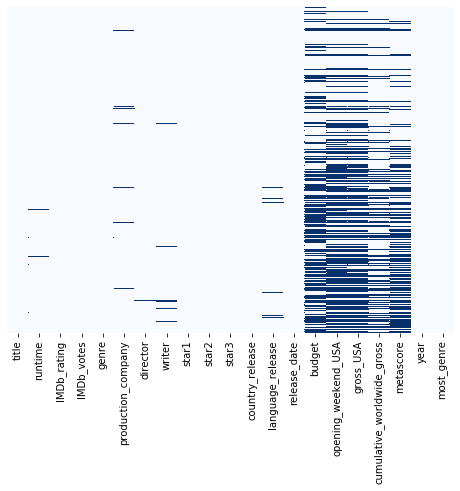

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(movies.isnull(),cmap='Blues',cbar=False,yticklabels=False)
movies.isnull().sum()

In [15]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 21 columns):
title                         9989 non-null object
runtime                       9764 non-null float64
IMDb_rating                   9975 non-null float64
IMDb_votes                    9975 non-null float64
genre                         9989 non-null object
production_company            9784 non-null object
director                      9969 non-null object
writer                        9793 non-null object
star1                         9989 non-null object
star2                         9989 non-null object
star3                         9989 non-null object
country_release               9989 non-null object
language_release              9876 non-null object
release_date                  9989 non-null datetime64[ns]
budget                        5147 non-null float64
opening_weekend_USA           5205 non-null float64
gross_USA                     5325 non-null float64
cumulative_w

### Filling all the missing values with the mean of all the values

In [16]:
df=movies.copy()
df["IMDb_rating"] = df["IMDb_rating"].fillna(df["IMDb_rating"].mean())
df["IMDb_votes"] = df["IMDb_votes"].fillna(df["IMDb_votes"].mean())
df["budget"] = df["budget"].fillna(df["budget"].mean())
df["runtime"] = df["runtime"].fillna(df["runtime"].mean())
df["gross_USA"] = df["gross_USA"].fillna(df["gross_USA"].mean())
df["metascore"] = df["metascore"].fillna(df["metascore"].mean())
df["cumulative_worldwide_gross"] = df["cumulative_worldwide_gross"].fillna(df["cumulative_worldwide_gross"].mean())
df["opening_weekend_USA"] = df["opening_weekend_USA"].fillna(df["opening_weekend_USA"].mean())

In [17]:
df.isnull().sum()

title                           0
runtime                         0
IMDb_rating                     0
IMDb_votes                      0
genre                           0
production_company            205
director                       20
writer                        196
star1                           0
star2                           0
star3                           0
country_release                 0
language_release              113
release_date                    0
budget                          0
opening_weekend_USA             0
gross_USA                       0
cumulative_worldwide_gross      0
metascore                       0
year                            0
most_genre                      0
dtype: int64

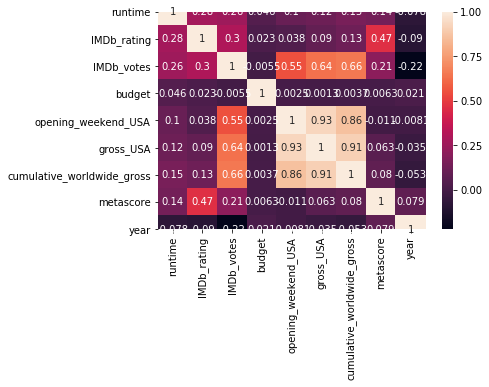

In [18]:
sns.heatmap(df.corr(),annot=True) # heatmap show the corrlation Between features

Text(0.5, 1.0, 'Ratings movies vs years')

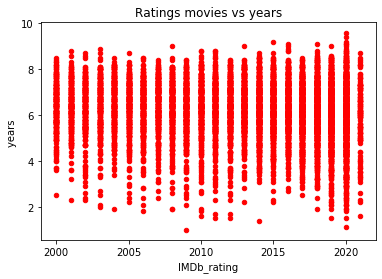

In [19]:
df.plot(kind='scatter', x='year', y='IMDb_rating', color='red')
plt.xlabel('IMDb_rating')
plt.ylabel('years ')
plt.title('Ratings movies vs years')

No handles with labels found to put in legend.


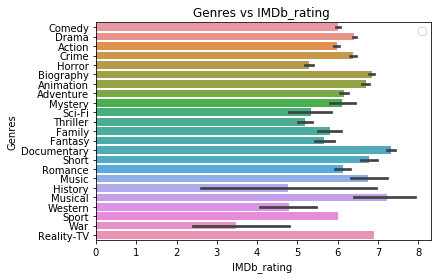

In [20]:
sns.barplot(x = 'IMDb_rating', y = 'most_genre', data=df)
plt.ylabel('Genres')
plt.xlabel('IMDb_rating ')
plt.legend()
plt.title('Genres vs IMDb_rating ')
plt.show()

In [21]:
pd.pivot_table(df,index='most_genre', values='IMDb_rating').sort_values('IMDb_rating', ascending = False)

IMDb_rating
most_genre              
Documentary     7.325194
Musical         7.228571
Reality-TV      6.900000
Biography       6.843979
Short           6.766750
Music           6.762500
Animation       6.696176
Drama           6.406537
Crime           6.380389
Adventure       6.163592
Romance         6.125758
Mystery         6.114583
Comedy          6.006644
Sport           6.000000
Action          5.973179
Family          5.812903
Fantasy         5.669619
Sci-Fi          5.338095
Horror          5.290321
Thriller        5.184426
Western         4.780000
History         4.775000
War             3.466667

In [22]:
df['most_genre'].value_counts( ascending = False)

Drama          2281
Comedy         2183
Action         2032
Crime           668
Biography       573
Horror          537
Animation       523
Adventure       412
Documentary     270
Short           147
Thriller        122
Romance          66
Mystery          48
Fantasy          46
Family           31
Sci-Fi           21
Music             8
Musical           7
Western           5
History           4
War               3
Reality-TV        1
Sport             1
Name: most_genre, dtype: int64

In [23]:
pd.pivot_table(df,index='most_genre', values='metascore').sort_values('metascore', ascending = False)

metascore
most_genre            
Documentary  67.755516
Biography    60.123614
Animation    58.576792
Drama        58.383705
Musical      57.520919
Crime        56.206318
Short        55.503831
Adventure    55.484835
War          55.274406
Reality-TV   55.274406
History      55.274406
Sport        55.274406
Family       54.884160
Music        54.455804
Romance      54.312744
Sci-Fi       53.550822
Mystery      53.209487
Comedy       53.160379
Fantasy      52.560055
Western      52.164643
Thriller     51.749361
Action       51.327161
Horror       50.985746

### Prepareing and Splitting the data for training and testing.

In [24]:
df_ML = df[['runtime','IMDb_votes','budget','cumulative_worldwide_gross','metascore','gross_USA','opening_weekend_USA']]

In [25]:
from sklearn.model_selection import train_test_split
X = df_ML
y = df['IMDb_rating']
X.shape,y.shape

((9989, 7), (9989,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Using the Linear Regression 

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
pred_lr=lr.predict(X_test)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('The MSE using LR is: ',mean_squared_error(y_test,pred_lr))
print('The MAE using LR is: ',mean_absolute_error(y_test,pred_lr))

The MSE using LR is:  0.9752754526424641
The MAE using LR is:  0.7044215756074518


In [32]:
actual=y_test.copy()
df1=pd.DataFrame(actual,index=None).reset_index(drop=True)
df2=pd.DataFrame(pred_lr, columns=['Predict'],index=None)
result = pd.concat([df1, df2], axis=1, sort=False)
result

IMDb_rating   Predict
0        7.000000  6.327548
1        7.200000  7.183382
2        6.202456  5.388029
3        6.000000  5.471356
4        8.400000  7.018121
...           ...       ...
1993     4.700000  5.570062
1994     5.900000  5.997157
1995     4.600000  5.199233
1996     7.600000  8.057716
1997     5.800000  5.067159

[1998 rows x 2 columns]

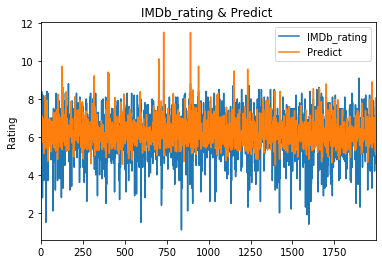

In [33]:
result.plot(kind='line')
plt.title('IMDb_rating & Predict ')
plt.xlabel('')
plt.ylabel('Rating')
plt.show()

### Using the Random Forest 

In [34]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
pred_rf=rf.predict(X_test)

In [36]:
print('The MSE using RF model is: ',mean_squared_error(y_test,pred_rf))
print('The MAE using RF model is: ',mean_absolute_error(y_test,pred_rf))

The MSE using RF model is:  0.9590219328303373
The MAE using RF model is:  0.6882808773685968


In [37]:
actual=y_test.copy()
df3=pd.DataFrame(actual,index=None).reset_index(drop=True)
df4=pd.DataFrame(pred_rf, columns=['Predict'],index=None)
result1 = pd.concat([df3, df4], axis=1, sort=False)
result1

IMDb_rating   Predict
0        7.000000  6.320000
1        7.200000  7.370000
2        6.202456  6.711474
3        6.000000  6.330000
4        8.400000  7.660000
...           ...       ...
1993     4.700000  5.490000
1994     5.900000  5.920000
1995     4.600000  5.430000
1996     7.600000  7.580000
1997     5.800000  5.530000

[1998 rows x 2 columns]

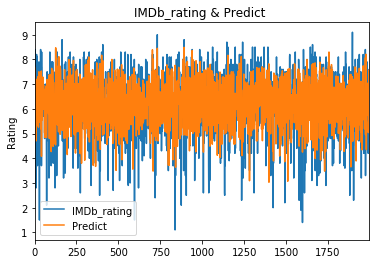

In [38]:
result1.plot(kind='line')
plt.title('IMDb_rating & Predict ')
plt.xlabel('')
plt.ylabel('Rating')
plt.show()

* As Shown in graphs The random forest model has perforemed the best with MSE of '0.959' and MAE of '0.689', Becouse it doesn't have wrong pridiction
* The documentries are on a average highest rated on IMDB